In [391]:
import numpy
import numba
import numpy as np
import scipy.interpolate as interpolate
from scipy.special import logit
from scipy.signal import welch
import math
from scipy.fftpack import dct
from pywt import dwtn


@numba.jit(cache=True)
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T


def util_rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def weighted_permutation_entropy(time_series, order=3, normalize=False):
    """Calculate the Weighted Permutation Entropy.
    Weighted permutation entropy is based on the regular permutation entropy,
    but puts additional weight on those windows that show a high variability
    in the initial time series.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Weighted Permutation Entropy
    References
    ----------
    .. [1] Bilal Fadlallah et al. Weighted-permutation entropy: A complexity
    measure for time series incorporating amplitude information
    https://link.aps.org/accepted/10.1103/PhysRevE.87.022911
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations

    embedded = _embed(x, order=order)
    sorted_idx = embedded.argsort(kind='quicksort')
    weights = np.var(util_rolling_window(x, order), 1)
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    mapping = {}
    for i in np.unique(hashval):
        mapping[i] = np.where(hashval == i)[0]
    weighted_counts = dict.fromkeys(mapping)
    for k, v in mapping.items():
        weighted_count = 0
        for i in v:
            weighted_count += weights[i]
        weighted_counts[k] = weighted_count
    # Associate unique integer to each permutations
    # Return the counts
    # Use np.true_divide for Python 2 compatibility
    weighted_counts_array = np.array(list(weighted_counts.values()))
    p = np.true_divide(weighted_counts_array, weighted_counts_array.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(math.factorial(order))
    return pe


@numba.njit(numba.boolean[:](numba.int64[:], numba.int64[:]), parallel=True)
def isin(a, b):
    out = numpy.empty(a.shape[0], dtype=numba.boolean)
    b = set(b)
    for i in numba.prange(a.shape[0]):
        if a[i] in b:
            out[i] = True
        else:
            out[i] = False
    return out


@numba.njit(numba.int64[:](numba.float64[:]), cache=True)
def matlab_detect_peaks(x: list):
    """Detect peaks in data based on their amplitude and other features.
    warning: this code is an optimized copy of the "Marcos Duarte, https://github.com/demotu/BMC"
    matlab compliant detect peaks function intended for use with data sets that only want
    rising edge and is optimized for numba. experiment with it at your own peril.
    """
    # find indexes of all peaks
    x = numpy.asarray(x)
    if x.size < 3:
        return numpy.empty(1, numpy.int64)
    dx = x[1:] - x[:-1]
    dx = -dx
    # handle NaN's
    indnan = numpy.where(numpy.isnan(x))[0]
    indl = numpy.asarray(indnan)

    if indl.size != 0:
        x[indnan] = numpy.inf
        dx[numpy.where(numpy.isnan(dx))[0]] = numpy.inf

    vil = numpy.zeros(dx.size + 1)
    vil[:-1] = dx[:]  # hacky solution because numba does not like hstack tuple arrays
    # numpy.asarray((dx[:], [0.]))# hacky solution because numba does not like hstack
    vix = numpy.zeros(dx.size + 1)
    vix[1:] = dx[:]
    ind = numpy.unique(numpy.where((vil > 0) & (vix <= 0))[0])

    # handle NaN's
    # NaN's and values close to NaN's cannot be peaks
    if ind.size and indl.size:
        outliers = numpy.unique(numpy.concatenate((indnan, indnan - 1, indnan + 1)))
        booloutliers = isin(ind, outliers)
        booloutliers = numpy.invert(booloutliers)
        ind = ind[booloutliers]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]

    # eliminate redundant values
    return ind



#annotated types for splrep
out_ty = numba.types.float64[:]
out_ty = numba.types.float64[:]
k = numba.types.int32


@numba.jit(cache=True)
def custom_splrep(x, y):
    """
    Custom wrap of scipy's splrep for calculating spline coefficients,
    which also check if the data is equispaced.

    modified 8/2022 for SIFTED - extremaindices are always integers, so rounding not meaningful

    """
    # Check if x is equispaced
    x_diff = numpy.diff(x)
    equi_spaced = numpy.all(x_diff == x_diff[0])
    dx = x_diff[0]

    with numba.objmode(t=out_ty, c = out_ty, k='int32'):
        (t, c, k)  = interpolate.splrep(x, y, k=3)

    return (t, c, k, equi_spaced, dx)


@numba.njit(cache=True)
def numba_splev(x, coeff):
    """
    Custom implementation of scipy's splev for spline interpolation,
    with additional section for faster search of knot interval, if knots are equispaced.
    Spline is extrapolated from the end spans for points not in the support.
    Author : sreenath1994s
    """
    t, c, k, equi_spaced, dx = coeff

    t0 = t[0]

    n = t.size
    m = x.size

    k1 = k + 1
    k2 = k1 + 1
    nk1 = n - k1

    l = k1
    l1 = l + 1

    y = np.zeros(m)

    h = np.zeros(20)
    hh = np.zeros(19)

    for i in range(m):

        # fetch a new x-value arg
        arg = x[i]

        # search for knot interval t[l] <= arg <= t[l+1]
        if (equi_spaced):
            l = int((arg - t0) / dx) + k
            l = min(max(l, k1), nk1)
        else:
            while not ((arg >= t[l - 1]) or (l1 == k2)):
                l1 = l
                l = l - 1
            while not ((arg < t[l1 - 1]) or (l == nk1)):
                l = l1
                l1 = l + 1

        # evaluate the non-zero b-splines at arg.
        h[:] = 0.0
        hh[:] = 0.0

        h[0] = 1.0

        for j in range(k):

            for ll in range(j + 1):
                hh[ll] = h[ll]
            h[0] = 0.0

            for ll in range(j + 1):
                li = l + ll
                lj = li - j - 1
                if (t[li] != t[lj]):
                    f = hh[ll] / (t[li] - t[lj])
                    h[ll] += f * (t[li] - arg)
                    h[ll + 1] = f * (arg - t[lj])
                else:
                    h[ll + 1] = 0.0
                    break

        sp = 0.0
        ll = l - 1 - k1

        for j in range(k1):
            ll += 1
            sp += c[ll] * h[j]
        y[i] = sp

    return y


@numba.jit(cache=True)
def baseline_knot_estimation(baseline_knots: list, x: list,
                             extrema_indices: list):
    alpha = 0.5
    for k in range(1, len(extrema_indices) - 1):
        baseline_knots[k] = alpha * (x[extrema_indices[k - 1]] \
                                     + ((extrema_indices[k] - extrema_indices[k - 1]) \
                                        / (extrema_indices[k + 1] - extrema_indices[k - 1])) \
                                     * (x[extrema_indices[k + 1]] - x[extrema_indices[k - 1]])) \
                            + (alpha * x[extrema_indices[k]])

    return baseline_knots

    


@numba.jit(cache=True)
def itd_baseline_extract(data: list) -> [numpy.ndarray, numpy.ndarray]:
    x = numpy.asarray(data, dtype=numpy.float64)

    idx_max = numpy.asarray(matlab_detect_peaks(x))
    idx_min = numpy.asarray(matlab_detect_peaks(-x))

    num_extrema = idx_min.size + idx_max.size
    if num_extrema < 10:
        print("danger! no extrema!")
    extremabuffersize = num_extrema + 2
    extrema_indices = numpy.zeros(extremabuffersize, dtype=numpy.int64)
    extrema_indices[1:-1] = numpy.sort((numpy.hstack((idx_max, idx_min))))  # the call to unique is redundant-
    # if there are any non-redundant values, then it means that the detect peaks function didn't work.
    extrema_indices[-1] = len(x) - 1

    baseline_knots = numpy.zeros(len(extrema_indices))

    padded = numpy.zeros((x.size + 2),dtype=x.dtype)

    with numba.objmode(v="float64[:]"):
        v = numpy.pad(x, 1, mode='reflect', reflect_type="odd")
    padded[:] = v
    baseline_knots[0] = numpy.mean(padded[:2])
    baseline_knots[-1] = numpy.mean(padded[-2:])

    baseline_knots[:] = baseline_knot_estimation(baseline_knots[:], x[:], extrema_indices[:])
    S = baseline_knots
    z = numpy.arange(x.size, dtype=numpy.float64)
    coeff = custom_splrep(extrema_indices, S)
    return numba_splev(z, coeff)

@numba.jit(cache=True)
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    med = numpy.median(arr)
    return numpy.median(numpy.abs(arr - med))


def fingerprint(data: numpy.ndarray):
    coeffs = dwtn(data, wavelet='haar')
    coeff = numpy.asarray(list(coeffs.values())).flatten()
    d = dct(coeff, axis=0)
    sigma = numpy.sum(d)
    return sigma / 0.6616518484657332

def retrieve_frequency_component2d(x=numpy.ndarray):
    x = numpy.asarray(x).astype(dtype=numpy.float64)
    b = numpy.zeros_like(x).astype(dtype=numpy.float64)
    d = numpy.zeros_like(x).astype(dtype=numpy.float64)
    e = numpy.zeros_like(x).astype(dtype=numpy.float64)
    f = numpy.zeros_like(x).astype(dtype=numpy.float64)

    m = mad(x)
    g = numpy.zeros((10, x.shape[0],x.shape[1]), dtype=numpy.float64)
    for a in range(g.shape[0] // 2):
        g[a] = numpy.random.normal(0, m, x.shape)
        g[a + 5] = numpy.negative(g[a]) + x
        g[a] = g[a] + x
    for a in range(g.shape[0]):
        for each in range(x.shape[0]):
            try:
                b[each,:] = itd_baseline_extract(x[each,:])
            except Exception:
                pass
        for each in range(x.shape[1]):
            try:
                d[:,each] = itd_baseline_extract(x[:, each])
            except Exception:
                pass            
        for each in range(x.shape[0]):
            try:
                e[each,:] = itd_baseline_extract(d[each,:])
            except Exception:
                pass
        for each in range(x.shape[1]):
            try:
                f[:,each] = itd_baseline_extract(b[:, each])
            except Exception:
                pass
        r = e + f
        r = r / 2
        g[a] = r.copy()
    for a in range(g.shape[0] // 2):
        g[a] = (g[a] + g[a + 5]) / 2.0
        
    g = g[0:5]

    for e in range(x.shape[0]):
        for a in range(x.shape[1]):
            b[e,a] = math.fsum(g[:,e,a]) / 5.0
    x = b#numpy.subtract(x, b)
    #sifted uses baselines, not rotations.
    fx = abs(numpy.fft.rfft2(x))
    maximarows = numpy.zeros((fx.shape[0],2),dtype=numpy.int64)
    maximacols = numpy.zeros((fx.shape[1],2),dtype=numpy.int64)
    for each in range(fx.shape[0]):
        br = fx[each,:]
        peaks = matlab_detect_peaks(br)
        y = numpy.argsort(br[peaks])[::-1] 
        desc_sort_index = peaks[y]
        desc_sort_index = numpy.sort(desc_sort_index[:2])
        maximarows[each] = [each,desc_sort_index[0]]

        #save only the most important value
    for each in range(fx.shape[1]):    
        br = fx[:,each]
        peaks = matlab_detect_peaks(br)
        y = numpy.argsort(br[peaks])[::-1] 
        desc_sort_index = peaks[y]
        desc_sort_index = numpy.sort(desc_sort_index[:2])
        maximacols[each] = [desc_sort_index[0],each]
        #save only the most important value

    
    v = numpy.argsort(fx[maximarows])[::-1]
    q = numpy.argsort(fx[maximacols])[::-1]
    
    i_v = v[0][1][0] #get the column of the highest peak found in any row as a legit peak
    i_q = q[0][0][0] #same thing- get row for highest column-peak
    vd = numpy.sort([v[0][0][1],v[0][0][0]])
    qd = numpy.sort([q[0][1][1],q[0][1][0]])
    
    minima_v_0 = numpy.argmin(fx[0:vd[0],i_v])
    minima_v_1 = numpy.argmin(fx[vd[0]:vd[1],i_v])
    minima_q_0 = numpy.argmin(fx[i_q,0:qd[0]])
    minima_q_1 = numpy.argmin(fx[i_q,qd[0]:qd[1]])
    
    bounds = numpy.asarray([[[i_v,minima_v_0],[i_v,minima_v_1]],[[minima_q_0,i_q,],[minima_q_1,i_q]]])
    bounds = bounds * numpy.pi / fx.shape[0] # hack

    l = round(x.shape[0] / 2)
    z = numpy.lib.pad(x, l, 'symmetric')
    
    ff = numpy.fft.fft2(z)
    # obtain the boundaries in the extend f
    bound2 = numpy.ceil(bounds * round(ff.shape[0] / 2) / numpy.pi).astype(dtype=int)
    ft = numpy.zeros((ff.shape), dtype=numpy.cdouble)
    ft[bound2[0,0,1]:bound2[0,1,1],bound2[1,0,0]:bound2[1,1,0]] = ff[bound2[0,0,1]:bound2[0,1,1],bound2[1,0,0]:bound2[1,1,0]]
    ft[-bound2[0,0,1]:-bound2[0,1,1],-bound2[1,0,0]:-bound2[1,1,0]] = ff[-bound2[0,0,1]:-bound2[0,1,1],-bound2[1,0,0]:-bound2[1,1,0]]       
    rx = numpy.real(numpy.fft.ifft2(ft))
    candidate = rx[l:-l,l:-l]
    return  candidate


def totalextract2d(data: numpy.ndarray) -> numpy.ndarray:
    data = numpy.asarray(data).astype(dtype=numpy.float64)
    outputs = numpy.zeros(((1,data.shape[0],data.shape[1])),dtype=numpy.float64)
    first = 1
    N = 0
    while 1:
        N = N + 1
        print(N)
        result = retrieve_frequency_component2d(data)
        if np.all(result==0):
            data_2 = np.expand_dims(data, axis=0)
            outputs = numpy.vstack((outputs, data_2))
            return outputs
        else:
            data = data - result
            if first:
                first = 0
                outputs[0,:,:] = result.copy()
            else:
                result_2 = np.expand_dims(result, axis=0)
                outputs = numpy.vstack((outputs, result_2))


##


In [374]:
import base64
import numpy
from PIL import Image
from io import BytesIO
barb_tiff = "SUkqAAgAAAAKAAABBAABAAAAAAIAAAEBBAABAAAAAAIAAAIBAwABAAAACAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAABAAAAggAAABUBAwABAAAAAQAAABYBBAABAAAAAAIAABcBBAABAAAAAAAEABwBAwABAAAAAQAAAKijn5qYlJKOhIN9eG1pZVtYUk1KQ0RCQT9HSlFYX2lvfIKIj5adoqatr7O2tre4t7O0q6SdkIh4dWthXlZKSUVITlZbcHp/lZumr7G5vcHExJZubWpwfJWinp2cl5eUlJaVkpGRk5SUlpaVlpiYlpeTlZeTlpaWl5KWlZWWlZaVmJWZl5aXk5mUlJebmJuZl5mWmJmUl4BaVVpaXmFfYmNjY2FhYV9jYWViYGNeZmJjZ1xlYmNlZ2VkZ2NlYWJcW2BcXVpeXVpYXF9bYF5fYF9dYGFhYWFgZGBkZneUsMzZ1s7HyMvO0tPW0NPQ0cK1m4d2YolYbW1gfUuNgomMa5FuXW9gV1N8gj1SmIN8UWOQdVE6PUtOS0A5KzhDMC0+MjVQPjY1NS9COCs1QDRNYDYuPzBDSDQrODlCWzg8QWOYZ1NQOC1NbVRCMjlabWFUPDVSfWxxRDNUZHFmSC86WGRQSzU6VGZsWD5QYm9rZmY/OU5ubVM9OlVqd105KUhhY25TMzVIYWZbTyo7T1REMCgsVF5JQy1EYlpNSi0yU15eNSlHXWNPNDRPVkAzKmBwTUg0TF5mUzcsQ1M9M1NYRTJHYDk5ZWJTQJCiYmGcqrW7ur26tbW+tKOIjIicZlyTmbGtoZiOf6GlhjQmJSEYHRkYIihacHJzcnRscG5ubWhkhn9+c3BqZF5WU01JRkFBQUJFTFNdXmVweH2HjZaboaWpsLOxsrm7u7m6srGvqaealoyDdWxfU0tGRkdHUldib3iHjpamrbC/vsLFwMbBxL65mXJsaW54mqGhopuYlpSVk5aQkJCQkZCVlZSWmJeXlZSWlJOVlZSUlJSWlZOWlJWWl5qVmpeXm5aWmZmZm5iZm5mbnZaXgFlUWVxdX2BhYmdiYmNfY2ZkY2RgY2JhZWRiYWJfY2djZWZjZGZiYl9bX11dXl1hXlpdXV1fYGBcXl1gXmBfZWBgY2dtjr/Ez9bRv8PKzM7R1NfV0dLOxbeZinRfjGF0cVt8U5N+i4ttl2hvdWddYIqHRmuwlKNtcJ1wRDM5PTg1Q0EtU1c4NUE1TmpJMTQ4RmJSN0dLRX9rQTw5RGFQTzY7SGZwPEVGe6BubmZAP2qBalJFUHSBeWpKOmOFcoJAPVZkc2JCMEdhX0pANjdOXVpJO09cZFVbUzg3Q19WOjE6QlFUPCwmOUlQUjwpKjRDSjwwKCQ6OisnIyg6RTYzJzlCPjkuKTY6REMtMDZASzc+QTFCKy9LSU08MzlFTFQ7LzJEQyU9RDgvJTVCKS1NR0IucYdLYp+qtLi5urm3tb6xqoCNkolufJeds66bl5GAl56MMS0jHBsaGRweLWBwcXVwc29vbm5uaWBaVE9HR0NCP0JHR1BTWmRoc3uGi5WZlqanrLCzurW8u7m6va6os6yqpJ2TjoZ+dWpfWUxJQUJBS1ZjcXuEkJqkrLO0vsTEyMzIycS/u7CsnJN/ZWlqbnyao6Ghm5mVlpOTlI2QkJKRkJOTmJeVlZWTlpOSlZGVkZSVlJaUlJWWlJOYmJWbl5aZlpiYmZqam5uZmZydl5iAW1RZVl1cYGJgZWRhYGJkZGViYGJlZmFlZGFiY2RjZWRlZ2ZiZmFhYV1dXV9eYGBgXGBgXGFfXl5cX2FdYmJhYmJia3Gby9DS08a0w8zNzs/Q09HQ087GtpyMcmuJaXxtXHlgm3uQhXGWYXRya1psl4JHirqgtHeAnmhEO1lqU1piTEtxaUhAS0dsf2FFRUZrfWRIYVZjp3VVRDxgclxePEJRbmw6P0p6iF91X0FccXRoUEhbe3x2aD4+cGxlazs7T15bQzkzQVtNNC4wMEdKPDY3P0RFPT04PTxGTkEuOUY6OjYrKzc3NDM2JiczNi81Jig2PEk5Lys4Ny0vJyAuMCgsKCs7Uzw/MT5FNkE8NmFVNEgxS3JHQTwvWTkuPCYxRFdKN1s/MzE0MDEuOjw4NTJOXjxmpKOwsLS1srGxuLOug5aVcHCSnKq2r4+Ql4KKiIE2JiUbGBwZGx8wZW10cW90cHFwanFoYURFRUhQVFtlbnV/hYuTl52hpa2xuLeyvLu8uLu6uLOzqqSplo2OjH95bWJdUk1HQUJIR1hcZnF9ipqkq7K4vL7IxMXHzsjGxru2q5+Xhn5qYFNWZmdvf5ynoqGdl5eZlZSTlZKRlJOWlJeal5iYmJeUlJaVlZKPlZaUmJWVl5OVlJWXlpiYmJaXmJibmZqbmZuYmZqamINdU1dTXVxeYl9mY2FiZ2VgZV5iY2VmY2RkZGNlZGNjZmVmZ2NiYmFfYGBfX19gXFxgX2FfXmFdX1xfYV9hYWFhZGdpg6TD0tXQy7vHzs3OzdHW09LW0sW5oIp/c4tndmxbeF2ZfZCJdpJgdm9oYXGYgVmfvaO2d4yWbldGfYh9cmlRWn1tUkxKUneEaFJQTHJ4XVZpWXWkb1pGPm9oXV0uRFlWWj0ySWJiRl9NSWZXU0s/OlFmYFtQMkNhTEhEPzdRWEMzNjRKW0MxLjM9TUo1NEFENzYwKjFLUFtXQD1GVU1CMSs8REk9NiwrNUpXQEAuNU1bWks5RVBKQi4sJjc+NjoyQ15lXU82U1JSX0JGcmRaVkVqfVBYR0VyPS8zI0hVaVdWaEtCRU9DRERTTz9LTj5ERHKgn6yvs66rrKets66HnJ1bZ4ictLSyioqbfYd2dDIbJhkcGxgeIS9jbnJycXBxcW5ubGdgbnh4gImLlZqjp62ytbe5uLu2vbu8u7e2s7GqpKOak46EfnhsYFxUTklBR0RMU1plbnh+jpWbo6uxvMHGxsrMyMrJwL2+tKuik4V6a11USUNMTWlraHB8mqWjnp2Xl5OVlpGYk5STlJeVmJeZmJaYlZWWl5SXk5STlpeWl5WVkZiWl5iWlpeYl5WZmZmbmZqbnZqZnJiYhltVVFVdWl5iYmJkYGNmYWRiY2RhZmNlZGVhZmNhY2FkYGRlYWNhYWBiYl1dXF1fW2FcYWBbYWBeX2BgYmFmYWRlZnWfyMrV2c7VvMPMyc/R1NjZ1tfUyb2jioh6i2tyZl1xXJyElYd+jGZ6cG1leJiBZq67prN9lo6AaliMkol8bE9je2dYSUNRdHVdTEpJXGNISFhSbHNSRjZEYUlDSCg9Tz9KRjRSUzkzQTtLXUA3LS8yPEc5NjY1T1lJOjZBUGttSjw5TWhtW0E9SVZpWkRCSlVIR0Y1Q19ma2lGSVlobFI3PU5XYVtQMjpOaHBbVjtJZm1nUEVqaGBbRS88TVBOVzxdeHJxWj1iXGJyRlZ2aWtXT3J6WWVUVoBKRjsyXl1rW2huV1JdaltYWWtiVndyW1RZhKGisbOzsaqqp6aoo46ZpFZMbpi4tLiNhpR9kYluMSAgHBsaFh4eM2dtcnBvcm5xcGxqZ12lraqwtLa2ub28vL+9vLm3s62tp6OgmZCOhn13b2dbWU9DSEFFRkpVXmVyfISNmJ2prrC6urvDwsXHzcnIyMLBtK6dkZF/dWVbT0hGS1ZhbnSAj3hjcXmYpp+emZSXkpKXkZWTk5OXl5WXl5eVlZSTlZWSlJSUlZSWkpaVlZSSmJSXl5qWl5iUmpaZmJubnZydnJyamZiHXlRUVlxeXVxgXmRiZGJiYWNlY2ZjZGRjY2VmZGNkZWNmZWRkYWBjYmFiXWBbXF9dYF1cXV9gXmJeXmBfYmJkZWRqfKrWztTYy9a4uMzM0NPR1dfV0dPIwKeLinSSb3ZkX3VUmYiag4GNZXxwbWmHl4Rqtbqjs4Cfh31yWH55dmduVGNwTEs6MUdTVUE1ODU9Sjo6OENQRTc1LjlJLi42JkZlSFJJUn5cSkM+M05pS0AwL0pSSUUyLUJwaW1HPkxkgn9ZTkNeeHRjS0tVaHJaTVBVZF5nV0ZcdHFyaUNVbHZ1XThEZGFxbls5UWN7c2pbQV5tcWRISXt6aGNRKk5jWmRZRmuAd29OPWRkaGlCXndrY0VPenRaZE9zgFFYQ0piXmJJamdZU2d3ZmJbcmNXk4xmY32UoKSyt7OtsKmyqpKSiImnZjxWl7aztpKChHyao4E2JSYbGhkWHx82amtwb25wbG5xbGpnXbi/ubu9uri0s7Osq6ahmpSPgoF3bmphWlNORkVFQUVNUV1hbHh+jJCdo6exsrm+wcXJx8jAwsW/w7y5s6ulmI5+c2VWUktKS1NdaXR9iZOcn5+sfGNwdpyioJ+ZlJaWk5aTkpWTkpeXlpeWlZCLkJOXl5OVlJWVlpaVlJaVlZSYlZWYmZeXl5KYmJiZmpqbnZ2cnpmZm4ZiWlhZW1tbXlxfYWFjY2VgZGNkZmBmYmNmY2dfZmRiaGVnZWVhYmNjY15cYV1eYFthXl1dX15fYF9kYWFkYmNmYm96pszE1s7F1K6yy8rKx8fGyMjLycS+o4t8Z4tidGFjbFifh5yChYdifHNqa46bf26+sqOvjal9WmFLWWZSRlFRV1A4OSowRUM0NC4wRU1DPjs0XmdMQzU6T0E+NzQ0aX9RXVGEmmpoX0E2aoRjUUNHdXRvX0s7ZoKAfU1TWGuBcFRNUWptY1pDT2Vwa01JXGhuaXNPVXeAeXdRQl58gW5RM0tscHZxTDxed4BqbEpDbXFpWkBIfH9sY0gsWG9eaFJGcXx6Z0I2Y2tnVTxnfmhTPEx/cVtaQYd5V19IXl9qUzNjYltNZXhoWmVyUlyZkWNvnpmhprO2sK6sprSshoaCeq94OGCcsbS0j4dzdZivljMxJRsZFhggH0Jsb3JwcGxub21uZ2RdsbGuq6SimpWOi4d+enFnYVZRSUdCQkJFSE5YXWlve4aNl5ymqbK2ur+/wsTFy8vLycrFvrGpqZ+ekoWAcGxbVExGTFFdY3B5hJCYnqassrm3t7p/YWx1mqOjnp2WmJeWlZSRlpSTmpeal5WTi4mPkZaUk5eUlJeXk5eWlpeVlJWXlZiZl5aWlJiVmpmZmJqbm5ycm5qYiWFYXFdZWFpcWl1eXWNiYWVhY2hkYGlgZ2deZl5kZGFmZGZkYmNhYGFeXl1eX2BcW15gXlxdXGBhY2JiYl5hYWFpdZrAz8fY0rfSr6/IwMXBxsfFxsfDt7qhjnlfhFNwZWVwYaWFmYGGgVyJeWdxmpx/dbewqKqer3pHRExLbk8nOkFHQDI9L0diW0M2Nk9mZFVETEuThWNaMUxqVFZGO0KFeFNeZ6eXdHpnSlGEhnNdSnCLhIRoU1qEhJBsV2JjcnpZQVZgcGhYQEtZbXRjRURld21ycEZbiIV8c0FEaI+Jakc5TnF+eWg8PlyGgWtqNkJ/eWhWOz99iXdsT0Rbd2JrQk94d3xeQT1rc2BLMmJ/ZEk6SHVrVU87gnFbW0RmZ2lQM1xmU0BZdWRebmxIUYaLVm6smqiptLe1sK+qq6yLiIN5sYNDbJyqurGUjGJvg5ykNCEtGBobGR8hQ29ucG9ubm1xbW5pYl+Pi4Z/enJpX1dVTUpIRENGQ0pPWV5rdHyEiZacoaiutbe+wsPFxsbJy8jIyMjGw760rKaXh3l0ZmFWS0pITFJZZG95gI6SnaGrs7W4vL68vrq2sXVaaXGUoJ+hnJeZmJWSkpKVlpaXmJuTlo+OiouQkpOSlpKVl5OUlpaYlZmVlJeXmJeZl5aWlpeYnJmYmJ6ampyanJSKYlhaV1hWW1pdW15dYGJfYmRhZmdgZGRlYmRjYGViY2NiYmZjYmNhYWBeXGBfXF1bXGFcYF9cYWFfYmFiWGFeaGt/udPVz9nSrL+6tMfHz8/Oz8/Pzsm6sJ+PeVmFWXBvZnlpoYeZgZCGbZ6Oa3ylo4GDurOwpZyodkhKamiKdDM3TldLRT9CaIFwVUBAa3NkW1RNX6OKaWJGZndjYVVIX4xiX1x/sIR8e2NheI2Cdl1hjI6Hhl1XgJCMj09dam98bUw3ZX98bVM5TXV/fmdKRXGFdoNeQluRkoRtSUZ0n45sSEJMf5F+YzQ0XZKGd2M0Q4aIcFxGRnyPgXFiV2qAdm1KUIGIfGlVV3mDX0g3WYZnUUhFaW5cSj5ybF1aSnN5eVdTcW5UPFJyZW17Z0pJdHtNXKKfpqmqs7Ouramqq5KGjYCkiFaKmKW6r5iPWWhzfpUsJiUaGxkZHyRDcm5wcW5rb25vcGdmXVpVTkxFR0NGRE1QWmNncXh+ho2WnaOprrK7u8HCxcnLy8vPyMnLycPBu7SwqqCTjX91aVlRRkhFTVJbZnJ7g4yWnaOssLS3ucDAwL68tq+nn5eNZFdgc5GenqCel5iZlJOTkpeWl5WYmZeTk42Mi4+SkpKTlJOXlZWWl5aWlpSVlZeWmJeYlZaVl5eZmZiZnJyanJycmYtoWltWWlZcWlxbWWBfYV9eYWRlZmRmY2NhYWZjZGJgZWJiZWReZWNfZF1iXl9fX11eXlxjXF9gXV9gYmBeXWJqa4KxzM/S1tOnob290NDT09HS0dHQzcC2n5R+XYZjcnNrd2imjJ2LopBym45vgqSec364qq2gnaJuR2ONg5WKQU9ya2teQFl7iXVdSE97cF5jZVNvlnloY2B7cW5aWmB/hlFcaJmthH59hJGeiH+TjYWSkJORYWCcmZx+QV92foJqR0Bvl4x3V0BOiJN9ZVdKe5SJhWBHS5CXg2tTRXuWg2FTTEqEl35cPjRljoh4WThQin5uVU5Td4B2aGhhbYF4alJbho1/a2RnhIFhUD1fiGxdWUVsf2ZbSGh0XmFWfoV8aWp9c11IVHdvgIluXF5wdU5dkJmgpamrr6qlo6OolIeZiJV6dZyTp7WtkpZTZ4R7eysmHRcaFxkdIUZxbXJvbWpwbm9saGVbTEpTW2FocHh+hI+SnZ6lqqaxt7rBwsPFx8zJzszMzcnIw8O2r7OioJKNgHltXlpPS0dLS1ZeaXN9hYyXnaWrsbW3vbzBv7y4uK2qoJuTiIF3bGRXUGB0l5qcoJmYmJiXlZWVmJiZmJiXmZaVko+PkpKTk5GVlJGYk5aWk5OTlpaWmJaYmpaYlpaWlZqYm5mbm5ycmpyXjGJZW1FXVllZXFpaYF5eYGBhZGRjZmFkY2FhYWNhY2JlZl9lY2JmYWJeYWFeX1xeW2FeXmBeYF5gXWJfYWBgY2hwjK/NzdHSzKuWusPQ0c3Nz8/Q1M7Nwbimk4RlgWt5c3B3c6+PqZeahGqHfVR2oIpWeLqhmpukm3dMd6CPlY5ZeYl2dnBPaYiJclpSbHplVGZvWIGMZmBfdn5xa0pdgJmBVlt7tL2gfXqowLyHdqq/tI6FrbiPdKerqW5La4uRh2JMR3eOg2pTRU6Fh21ZXlF+jIR2U0lVgYdvXVdcf39kTl1XVoGFZ1BJRnp9e2VMR2J7aFZLVGZvZ11cbWxoc2xXXGWCgGhccG19dVBWTmd4YGNnWXB8ZmNUZW1ZYWV5f2xqb3dnYVJkgXaGiHJvcoJyZXSHoKSnr7Cwq6igoKOalqOKf2Z+lo+qsaWNl1J1mph3KysfFxoYGB4iUXNucnBrbG9tcWtlYldrfoaQl5ihpquvtLu8vsC/tr3CyMzMzszNzMXEwLu4saidlop/em5nWVVSRUxKUVtganB7hIyRm6SnsLK6vL3CvL26tLGlnY+KgnRubmtrbGZaUk5YYXKYn56hnJiWlpWWlZaZmZiZmpeZmJWXkZOUlZSSlJWRlJWXlpSWkZaWlpiYl5uZmJiZmZWZmpiZm52bnZycmpqKZVhYUFVYVVhbXVtcXlteYWFiZGViZGBkYWFeYWRiY2ZiY2ViZF9iYF9iXl9eW2BeX2FgYGBgX19dYmBgX19maXSmwtDMzNTFuLC2wsjNyMnNztDOyce8u6iShmWEcoF2hoJ4tJGilI9uYYNvR3CfhEl4vJ2hnaWXeWeIoJWXjnSTjnZ0dV5zkIRvX1l3eV5AYWlnkYFbUGaIh3lqRGKWrJ6Nbnm2ycGSbZXAyptnksHKlGily7yBkLy5h1R0k5F9XEpUcHRqVlFGXXhtVVBbYHJ4dlpVU2F1dFZWZW17a05KY2dmfHRJSlNlgGluTFBgaW5VQ0ZgcmlfS1l9c11qWEpmbndoT1h1bG5dPldiaVxKZ25mZ2xXbF5XZE9obXBuVWdmZk9fYWp9c3t2aHqCh3l9gJCmq7G1tbKxp6Ghp6agqI5sVXCHjqauoZCSSnahqIYqKSUYGxkYICZWc3BxbmtsbnFtbGliVI+rsbi9vL3FxcfIy8rNysC6t7/BxMO7trGqo5iRh4B2a2FZUkdISklQWV9ncneBipCZnaWprba4vLy+wby8tq6qnJCIenBkVFNJR0hOVl1qbmBRVFljdpSenqKblpWVlZaVlZaYm5iYl5Wal5OWl5WWlZSSk5KWkpSXlZWUl5eVlpaam5mZmZibmZqal5uamZ2fnZybmZBiVVVPU1VVVVhdW11gXmFiX2JgXmNjX2NfYWNhYmVjYmJkY2RiYWFiXl9eW15dX15fYl1hXl5hYWRhYGJeYWRoeK7DzsrI0rq3xrS5yM7R0dDW0s3My725p5KDZYh8kXeOfXKuiJN6kGFhh2xSdJyHRXG/nayjrpJ2fpCilomBe6CLbHBwYn+TfWFkZYd9WjtVaoCael5NbY2MiHpobouww8GdaYWvvqhqX5Ktn2lej7CiYHC1x5FkqtKmYX6lh2hYVmRnZE9PUFZqbFhHV1luZXNhSV9ibHVlUF1we3VcQ01lc3N4XDdGYX5zaGA5X2tqaUo1TWpxZFo3Un9qX2pJQ2dzcFc7W3hsYk0wV29fSzhiemZfU0Z6XlVhSHx2aFxWZWNeOFVqZ2xocVdIeYR+do9+iqywtLy4tbOqo6Ggnp2ulF09UHSUpKufjoJYdYyviCkyIhoeGRsgJ1l0cHFua2ttbWxqZWFWnMLFy8zLzcjKzcLHxcO9saScnZybkomAeXFlWlVMSEVGS05WWmVtdX+Ej5WbpKSwsLS5vL3Av728ta+poJaMf3FlXE9IQT87N0JBSVFWW2VyX09UW2N3laCdopqYlZSXlpaVmJeamJiWlJiVk5SWlZOUlI+Ok5CVk5OWmJSVlZWWk5qamZeYmZmalpmal5mbmZ2am5yWj2hQVU9QVlRUWVpYXFxfYWBeZGFfYmJjYGBkYGRgYmVfaGFjY2JhYWBeYF5gX19gYF9cYWJfYV9iYmJgYWJgX2l2p8PSy8fNtKm6rLTL0NXUz9TRzdDMwruhloFol32QaHdqcaqCknWSY2iIb2F8oINWjsCfrauzknaLmqSUdnZ4oJBhaGtvjJR6VmJ+mIRXQ1Fqkpd8Wk1sfoCRpKePdYyxwq13YHqSj25QXnR+a0hTd4pmSn6pm1d7yL9peMKjb2Nka2VdS0hXZ3BpUEVYZGtodFFDZWxtc1dGYHiAcU5BSWJ2eXRKMD1shGxqSjBhc2hiPixMbW1fWDhBd2BiXVBGXndnTTRZd2tYSC9OcldDMFV5X15UP3RYWF5EgHhkW15mW2M9QG1iWW1rS0Nvfmp0jnB+rrK5wL24uauooZeOirGTTjg+baKlqpmSeFpmaJmEJCglGRwVGx8pXXVscm1qbWttam1oYFaTxMbJxsPAuLKwmpuckYmAc2toXVpRT0pESUtOVVhga3F6gYWMkpugpqywtbe8vL28vbm0samhl5GDfW1jWVFIQkE9Pjw/RUVLS1FXV15ianJdTE9aZXeZoZ2hmJqVlpSYlpSZlpqXl5eVlZaSi5eWk5OUjZOSlJaXlZeamJSXlJmVlpqZmJiamJiWmJaXl5mZmp2cnJWQYlBUUFFUVVZWWVhaXV1fXl9eYF9jY2ZgY2dgY2JiZGBlYWNjYF9eXV5eXmJiXWFfXl5eY2FhYl5lY11jYF5mZoa2y9rHzMy4np+otsfJy8rEy8jJycnHvaaRgXmdbHxTbWN1qIWPe5Vgf5Frb5Ope2upvKmuq6iGeJuprJJjcH2dkFdgcISemndPX4eOdlNGU2uVfW9YV3dwbpa8w7SBYHCKim9UQktVV00/QVFbRTI5WF5APGiAWFOXuXBhw8uBZYl2ZFZDQ1lwdGBGQVZvZXNlSUJhbnBpUEJegntgSkZAYHp5X0AyPn91amE2K1VyYFU2LEpzZVJdRjhqVmNPXGBld1Y+PVp0ZE5NPlNtTk8zQXJVZ2lEYlZeVUJ2cV5lZWJYaVc4ZmBbcF5QRmV1aIKCZHaxsbnDuby4rK+lnHqAroo5O0B0rKmpl5NyYVpYgWggIx8bHBYcHTFlcm9wa21tbmxubGVfWHWoqKWfl5SIfnpiYWJXU0xOTUtPUVVXZGVqdXp+hoqUmJ6jp6+qs7i6uru8uLayraWglo+Cem5kW1NHRkFDQUNGRkhJS0xOUlRWWFpdZGhncl5ETVhodZSinqOYlZeTlJWXl5mYl5uWl5eUlZSMl5aTlZeRlZWWmZiXlJiZl5WZmZiWmpqal5iamJaYl5eYmJmYnJyalpRgUVBQUFNVU1dWWVdfX1tdXmBhXWZiY2NhYWNgY2NhZ2NiYWBgXl5eYl1hYF9hW2BeXGFfYmFfYmRlYWFgXmhrlMTO0sPNzLiOkaWyw8HExcfMycnGycbErZyPbYpdclluZXyrj5qPnWaZn215oap+cbC3rKikmnd2m6WliFlgeY6AWFZrhpqQdE9eg31fVU1TeIlwZmaGo490dZmnoIZXRlNTVUIyLzdKSTgyQE9FMig/Tj8tNVxdQFqUeFKh1Ypbp55pU0Q/W3VrV0pCU2tqdFhPSl9ycVxaS2mCdFJUVj1kfW5WTD9gg21tUDoxYW9cST43WnBgSlZbR2VYYFVocmxuTkFKZG9eS11bXmZIYUguZVRnglZRXlldTmR0VHZoZFZqbjxnXmRyU2NYZGpyjHNggLazvcK7vbiwsauee32phDI4RXmqq6+djH5paHuCUicnHxkeFx0hMmttcHBqb21sbG9qY15XVHpyZl9XUk1IR0NGSVBUV2Jpb3Z/hIqKkpSaoKOsrbO3uri6ura4trCppZ2Wi4R8cWVdWU1JRkREQUVDR0pJTVJWU1ZUWFhXXFtbXV5gY2JnUkZHVmp0l6KgoZmUlJSVl5eWl5iZlpiYlJaVmJaWlZaVlpKRmJWXl5OVmZeWlpiZmJiZl5iamZmVmJaXmZiYmZicn5yakWZMU0tRUlZVVVhbWltbW19dYGFhYGRjYGBjYWNkYmJmY2NgY2FgXWBjXWBiXmJcXl5eYV9gYV9lYmNjY11gamySwce3ucTFtIaAoLPAw8rM0NHTzMnKwsGspJVaf1t0Z3JviK+crp6bb5adb3ebonpmsa6eoKSUbHOWmJN3SFN3f3doTWaDkn1wW2aBb15YWV2Nf29pf7XCuI1aXmZjXEI4MTlGRTQvMzpFNS4qNT0xJSg6NzIpOFxhNFCAYW69kUyoz39aXElocGZNWE5ZaHJkT2FYZXJkU2lidXllTWBkU3Z6Y0pcXHt5b2NJSVBrZlRHTVBtZltBTmtfYGBXZnZzc2BGT2FualZNd3NmXUNwdEJeWGGVcUdoVmttX29Sg2xdWmaEVWJjaGpRc3JpYoaTaWGKuLK8ur29urSzr6J+epyBLytHeqKrq5uIgml+nJxVKS0bHBcaHh04a29wcGxvbW9tbG1lYFZPXVhITk9PVVxjZWxxe3x+h4yRlp6jp6asrbK0tbm1t7i0sKuioZmOh352a2NaU05HQkhERklGSk1OUFJUUlRVWFtXXFdYWVZUVVlZU09OS05FQUVVa3WSoaCgnJWUlpeWl5iWmJaYl5eYlZWZl5iVl5eVlZOYmJOXkJOXlZiXmZyYmJqYmJeZlZaXk5mXmZuanJ2enJyTZ0lRSVJTU1RTWVdYVlleWl5gZF5iY2RkXGNjY2djY2VkZGRgYl9eYmBhYWJfYl9eXl1iYWFiZGBiYGVhYWZocIO2vaO4xsazhnuatcPJzNDQ1NHPxsPDuKOdi1Z6YnZzg3aTrpKnlpFsiYtwcJGYdGyyqp2iopFsdpaUkXBQVoB7enhWbIiMdHVmd4FnZGNacJODfGd+obGriVtKPDc7LjIsL0dGPDAtLTItJichLC0jIyQtLSkrT2s+NHqOV4aXTI7ejl+CaXVzWVRdX2NtclVOY2hpdVlNbHB5cVVPZW1ifHlQRmFzhnBuU0phYmdiR0paZW1fTztUbmJbX0txfXNwVz1bbm9mTUt/e2NUP2+TXV5YVpZ1TG1XendmalSJal5ZZ4VjYGFrZU55f2tikpJgaJCtrbW4ubi2rq6ooHx+koFEKVx7m6+hmoiCbYClqWQnKx4aHRUhHDtqcHRta21scmxrbWJcWllhXmx6eX2Cio+Ol5SgnaCmqayys7i4srWxsq6pqZ2ZlIuIeG9sYFpUT0lKRUNKRktMTVFRUlZTV1ZUWFdVVFRTU05QSktKSEBDTElFNjI4OjtARV1se5iioaCblpSYl5WVmJmYlJWWmJiZl5WZmZaZmJWXl5WXlpSTk5aWlpeXm5qZmJWZmJWWl5eUmJmXmpycnZ6ampJhTVJKUVFRVFJWVlZWWF5bXF9dYGBjY2JiYWNjZGFiY2NkZGJjYF5iYl1jYVtkX2FgX2JhYWFjYWBfY2FmZmhzhri4q7vOyLWIeZyxx8TJysrJw8G5triwnZR4W35ke3qRdJagi42IhGaGeWxylJRsfbuio6ihi2mElpKIdVxkh3N6fWJ4jIVycXWAeVtmbFuSoKqujW5gbW1UQ0AoMjc+NigvMjUxMiovKi4oJikoKSQoIyYkJyI1UDsvbqFmS4h6f9eSSquYkYRaYGdpZnVmUFlsa3BqTFNreXViQ09ncnJ8ZkJHYoR9amc6T3FnZFQ6R2hyZ1pDOVlpWmFWQXZ8bm5LQl12Z1lCUH51WUU3a5tjWU1Wi2VdaFuFd3BYbolgYF5rfGVdYm1cRneGYF+dfV12k6itrra1sa6ooZ6ceYOOf000dnyisKCYfIFpdpanYCYtHhkaGSAgQmtucmpsbG1xcG9oYl1XZ2txipqcm6GlqKutqLCxrrevtLKvsa2jnpmVjIWCdHBkYVlTTUlFSEVKTUlMUFJTUldWVldXV1VUVU9OT0dIRkJDPEA8NzkzNDI+PjcyLDE3Oj9IXXB3mqOgoZmWlZeXk5eWl5aSl5eYmZmXlpmYmJiYmJWYlZeVlZeVlZiTlpqbnZaZl5ial5qZmJeam5icmp2ZnpuXkGBNUEtNUFRRTlZTVVVbW1pdXF9eYGJjYmViZWhlY2RiYV9lX19gW2FgXmJhXWBiXmNfY2FhYmNhXmFkX2ZkbG+VxLq6vtDFsYp8oLTCvsC+wL62tqywqKiYjXhifmyQcYlpjZeFh4aBZ4N5aneYjmuEvaClp52CZ4qYk4N1ZnCHa3d4cICMfmxxeIJ1U2JuZJ2zwsGndUlDPzEtLCQrOj41LyoqLSsuMjg5OjMzODU2LTAmKCghJSIqLyhNjXk8e6Z0tps9tLyip3VhcGhrc1pJY3drdF5EVG94b1RATmd2eHhZO0BphHNsVTJJdGddUS1DcG9jUjcyVWZXZU03bHdyXkpHWXNiUDlVfW1RQTRfjWBZP1d4WGxcX4FvbVJ9hFtkY2tsZFtkbFU8b4BYX5VrXYGQpq2ssrCvrKSVlJpzh4h5VkeAd6uvpJVzhGJje5lXHC4dGhgXHx5IbXByampubHByb2dlXlZ3fIejsbCxsbSxtLGlrammo5uXk46Ef3huZmRdV1JPSkhMSUxQS09LUVRVVFVWVlJWU1BTSUtJR0NDPjk4MTcwMTAnLiotLCwtLjEzMC0vMTg5Pk1na3qapKCjmZKZlpeWmJqXl5aVl5uVl5mXk5WYlpeTl5aUmJWWl5aXlZaVmJqYl5qbmpmampmXmJmbmJqcm5qampSOYUtRTE1NU05RVVRUVllaXFxeXmFgYmVjZGdjZ2hkZWFiYGZgYGBeYV9fYV9cYl5gY2BmYWFhZF9gYWNhYGVrbp2+ubrAzsOun52xwMC7u7y/u7myrLWopZKIgW6KepdndWmQmIuHiHlohHtwfZqQZ5G+oKuhm3lnkpqVeXBndIVdYW9yhY1yYW+Bfm5OUG5vip2pp5NnSDk0KignIiksMCgrJiszNj1GTFNRSVNUSklCNzYwLyYoJSAkJSdLbUdduGlrpUii1qG+p2t5c3NrUUFjd2psUUZWdnVhTkk+Y3Z9ako6QHh8a2hEJUhvX1hCLD5vallMMClPYVdkTDtXdm5LSFddbVlGPFd2ZElIPkRrVF4pSmVUblZdeWtkUXt2VnNpZ2deYWllVz9edU9UgWJrhoilramusaqomoiQmniJhWpbZXhssaunkmyOXkVQd0oUJhwbGxsdIUttb25pam5tcXVua2ZbV4GAlay1tK6oqZ+gloWKiIJ3cmljYFdTT1FIS0tLT1BOTlJUU1RXVVBVVVJPT0xJRURDQD44NTI0ListKSsmJS0iKSgnKisqJyotKy0uMDIyOjhAU2dwe5mnoKGblJeZmpiZmpiYm5SXmZeYl5aWkpiUl5aVmJeZmJmal5aYlZiXl5qZmpmdl5iclpWZmpqYmZqam5qYk49kUU5QTU1QUFNTVFJaWVpbXFxeXl9jYWVhZWZkY2NlYmBhZGJeZF5hX1xeXF9gYGFiYmdiZWFiX2BkYWRhZGhtkbC8u8PUyK6pv7vCwbvCwL+8u7qytq6nl5WTfpl2h2Bwa4+YjoWMb2WEdnN/m4xkkbycqqCYcm2WmZJqYGl4glFTaG+JiGlTcIZ8dVdkko1+cGttWz09NyYxJy0nIysrLC82PEVNTF1eYmRgYGBYWExAQDc1LygoJx4kIydBR0GLdTSefZnfjaTRgYWafWVRQGFuaV5QV2R2cVhQXUVZe3daSz9RhnFuYUcuTmlcUD4xQ3BjVj44K0pbW1ZZT1h4YkFLZGZpVUBLW3NbQWVTPF9SbUM+XFRnc1trb1tiaG1We3tfaVtoa2BoRlpwUFtrYoCAiKyvq7CypaeflJKbfYuCU1phZ2yuqqeSa5NdSVJaOh0gHhsfGB8lTXFwbmZubWxxc21rZVxUhHaDl5SMhHx5cm1kWFpYU1JRT05NTkxQUVFSVVJVWlRVT1RQUE1IRUVDPT45NjAvLSgvJyYkKCgjJyYkJSMkIyYmKCUnLCguKiosLDExNDQ4Qj9abGx7m6ahopqUmJeXl5mZmJqYlJWXlZeVk5eTlJiUmJeWmpWWl5eVlZWUmJeZmpqam5uWmJuamJuamZaYm5ibmZmWj2hRVE1PTlFQVVRRVVdaWFlcWlpeXGNhZGNnZmViY2BgYWBiY2BjX11eXl5cYV5jX2JlZ2VlYmJjZGJiZV9mYnF3pcaxzcrAq5/EsrDAvMLDwb+9ura2saOhqJN8kWN7YW5zlZuUjJBla4RrboSdf12YtJ+sn5RsfJuTilJWbn90TUhmeI1/YEt1hnp2fanCuaJwU0I0JikjIicfKyMpOjk+R1RXWF5kaGttb2thZlhWUkdEPTg1LS0oJSckJSEtL0FlI4ezgc94ct2im8SfX19UYnBnTFFsc3JpSVZtWWR9Z0dXVHSCbGhXWk1hZFZHRz5hbF5NPkVBV1RcR2FlaXVSTGNta2BMTmBoa01Pe2xOXlF5Zz5VX2SbbmpvVX5dZViEiF9qVmZpX3JYZGNibmBnmneNt7G1ubKdtaaonqGJjYE5R0RZd6uqo5Bvj15oe1suHyQaHBoeIidXcG5taGxscHJxbmhiXFSDZ2dtZ2VcV1RRUFBOT0xRUldUVVVUVlRYUlVTTkxMS0lFRTs+OjYyMi4qLCYoIyImIiIjJCEhJCQlJSYhJSQlKCYrISwpKS0oKystMTg0Nz9ASl5rcH2Zo5+empaWmJeVlZaYmJmVkpiVlJSPlpSTl5WXlpeYlJWYlJmUlZeXlpebmZqanZqbm5yam5iZmJuZnJacnJiOa1JTUVBSUlRSVFZWVFpYWFxaW1tdYGNhZWZjZmVjZGJfY2BhYmBfXlxgXl1jX2NfYWVkY2RjYWdiYGRiY2VicGarx6/MvbisjbOmn766wL7Av7e2s7OspJ+ehmeBYHVkaXCbmpKOjWp4gmRpi516YaGyoaifjmyKm5CATlNxf3RWSGWBi4BgV36Bd3WUtr67nHNRPjIoIiQjIiUoKztIR0pVX15iZ25wcnZyb2ZhWVNNTUQ/OzY2LCwnKiIoJCImIEMuZL9bp3xT2Luj0r9wbW5nc19JUXFyblxCWGtsa3haSl1ohHhtXkxpYmJgTUZPUW9mV0pAUFRWXFdBZW5vbkpVcm1sWkdWb2liR0+DfFtdTXKHRVZlYKh9aGpOh15eYI2PYmRWY2lRdW1lYG97Wmieco+1sbW8r6O3q6+hpY+WgzQ3NlB+q6ijjW+BY3uXcCsoJhkbGxwfKllybmxpbG5wcG9uaWJaVoFrWVlPU0xQT1BUUlRUVFRVV1NPUE1OTUpGRUE6NTg1LzEpKSgmKCMhJCIkICUhIiIkHyYgIiUjIyYkJickJSUlKCgoKCUpKyouKzMzNDc1Pz5MZG1we5mhn56Yl5eXlpOXl5eZmZSWlZSTk5OVlZOXk5WWlZaUlJeVlZeVmJiXmZmbl52amJqdmpqclJmYmp2am52bmZRtV1hRVFNTU1NVVVlVWFZXWFpZXFpfX2NiZWBlZGRlYGJhYGJkXV1iXmJiX15hYV9jYmRhZWNhZV9hY2NiYWZwervGusG2uqt9np+avrvExMHAt7S4r6ejmIh7XXtlb2djapuYlI2Kb3qGY26bnHZvraulpZ2Fa5WZlXxHVHt9cGZOboqIfnFkgIB2cIKBhIZqTEM0LCgpIiMkKjU7SlRRU1pbXWhwc3d7d3V0cmpiWVFNRkRBPjY2MCwpKiUlJCYgJTEylklcml3WwZrK2Id+mnN0UUtdbnFlTUVTaHVwbUtMYnuEcG1JQGttYVpFPFlpcF5QO09iXlZgRkVlcG5kPFV8bWlWRlt2a1s+UX6CYVhBXY5KWmJdnoJoYFyBZVpwoopnYFljZ0lmeWRVe3pVc5hrjLGvt7qxrLSqqpeXjouOMDMzS4WsqKGNbntagKeCQiUqGRoaHCEqXXJsbGttcnVycHBnZFlXgXhmWllVVVdSWFFSV1FQT01KRkRBPTk9MjEwLSooKiMlJSIjICMdIyUcJCAiIyEjIyAjJR8kIyQlJSUjJSYjJSUjKCMlKSQuLCwuMTg0ODc+QlFobnB5mqCfn5mXlpiYk5iWlpmYlpWXk5OXlpaUlpiWlJaYlpWWlZOZk5eVl5iYm5qcnJqcm5yblZmam5ubm5qZnpuYk25ZW1JVVVVXVFRVWFRWWFVWWFxaWlxiYWJiY2FmYmVjYGRhZGFhYF9jYmFeYGBjZGFiZWFkZGJjXmNjYmFkanKaxs7Cu7y8t36Nn5i/vMnHxMW6u764raeRgH1cfmxvYmJtm5WSj4twfIJle6GcdXqwq6Sln3tumZmTf05Zf3Zxbll0kIN5dXiBkpuVj21hWkU4NTUnKi4kMDM3Q0JRVU1VWF1lZ25yd3h5d3J2bmNaU09KSEJCOjYzLS4pKSUnJCYeKxxQUSyshMi+g8DZn4S+kGpOS2pvZ15JQU9pdHVjR0tlg31wYjw1ZG1bVTkyVXNqW0YxS2laV1kzPmRtbVk5TnZvXU1XVnZnUT1MeXpbVDlCfVVZWkyIdWhSY3VeW3SrgWliYmVmUFd7X0p3dExxjmSLq7G2t7WtsaWmjoh7fZU9MjRJjbGpn4t4d1N0m41MICceHBkfICtfcWpqbG5zdHFvb2dkWVSCeWleWFNSUElMR0lCQkA5PDEwMykrJyglJSMkJSAgIiEhJB8iICAiIB8hIR8gIiAjISMjIiIkICclIiQiJSUjJicjJyYjLCstKjAyMjc1Nj9GV2hvcXmYoZyfmZWVlpWWmZiWmpiUlpWQlZOYmJaZlpWXlpiVlpWUlZWWlJWVl5qZmp6bm5qZnJuVlpebmpqZmJubmZuRcVpYVlVYU1dVV1dVWFVYV1VYWVpcXF9fYGFiZmBiZGJhY15gYV5hXl1iXmBhYmJhaGNkY2NjYmFdXmJjY2ZrcqbKzbasu7S3hIWbnsG8xcnIxcLAv7uyqZN5e2KBcG1gaXaYkpGOh2p9gGh9oZd0fLOmpKSZcHifl5F3V2OBdWpsZX6TfHB7fJK4vrynhWBOQz45NzUyNzM7RURJSFFVUFNaYGNkYmhpb2xraGdhU1RNSEpDRkU+PDU0LjAoJyclJiAjHS5HJLOUtK1Rv86xjc2pYFZQcWdoR0ZMSG53bVtOS3OGdHBPKzZkZ1lHOCpTd19WOypCaVFbTCs5Y25jVj1Db2lVQFphcF9FQlNzb1VGMUFlXGJJUHdlZlljY15idKB0YmFnaGZZUXVTQ3BnSHGAZ4irtri2tbKtp5+OfWV4lkErOFKfs6iiiX9vTmN8hUIaJxwdFx8dMmRvbGpqcXNycm5saV9bVHZtXU9KRUFBPDYzMjIqLigmKCYhISQiISMhHiEkHiMeISEeIyAfICIgISEfICAdIh4iISEhHyQhIiQhIyUnIiQkIygjKCkrKSsvLzQyNDc4QUleam9zepqinqCZk5eTlZaXmJWal5WWlJKSlJaVl5eXlZaYmZaXlJaTk5eVlpaYmJiZnp+Zm5uamZqZmJiZm5qampuampRyWV1XVldWVVVWVldaVltYVV1XXF1cXl5hY2FlZGNlYmNgY11iXmJgYGFfY2BkYmRpYmRjX2JhYmBeY2FhZGlxj7TOsKK/sbiIe5umvLm+xMK/v768v7KqmnF6Y4FvZ2pteJCRko6DZoJ5aXmcl2+CsqalpJVsfKOWj3FYb4RuamRohJF0Z3Z/m7q6tZ57XVBVUkpUSk1HQklVUEtSVFdQVWFcWlhUVFRWV1VNTlFITkdJREVFRkM/PT00MTAoJichJCIfJEAmtox8qzGuzMOOw8Zgam1wa2A9UlpPbHthV1xVfnxza0gvOGthU0s+K1h0XE85IzpeU19CMTlkdFRRU0NsaE5IZW5rWkJGT2pnTEY6PlZcYz9Bb2NvcmNfVHNrhHJjZ2lkW2pYaFQ8ZWFKaXVofqmxvLW1uKmpnpOEXXOSUzE3WqOzqaWOiGxKVFVvQxkjGxccGiE1Y29obGlvdXFzcG1pX15VXlBHOzsxMC4sKSYpJiIkJB4lHiIkIiAhHx0kHSEgHiIgIB8eICEgHiEiICAfIR0fHyMeISIfIh8kICMjISUhJiQlIykoKCkrLy0yMDU1MjlBT2RtbHh7maCYoZWVlpWVlZiZlJiXlpaUlJWTlZOUl5OXk5mYlJWWlpWTlZWXl5iWmJqZnJqam5uYnJqXmJmXmpmcm5mZk3dbXVxYWlhXV1ZYVlZZV1tYXVhcW1teW2BkYGRkY2NfYGFeYGBdYmBfYmBiYmJiY2ZjZGJjY2FhY19hZF1lZGtxls6rr8q2voh6nqK7uL3Avr27vLu7sKqZbntdfWloZ253h4+QkH9jhndpeJyUboa1pqailGmMpJWIZ191hWNjY26NjWxXc32Ai4mEc19aY2lgXmZbYFNMUFFXVFZYW1RUWExHS0RCPzxCODw6P0ZHS0NJRkhKS0VEPzo4LygsJiojIyIdPR6ifDihQLXIu6Oz2WN/mmxvUj1TZGVzelJNZWmFcHNbTj1NZV9KTlQ1aGlWSD4mOlhWV0BARW5xTERlVnBcSlxldGZOSVVXZF9OQk1LUFllVD5rZXCSZGNTf3Rnb11uZ2NLcGpjXU1gXFhtaGmGoa21rbG1pqSZkopgcolfPUFuoLCloJOOb1RUPE01Gh4XGRkcIDRlb2hqbXRydXRwbmlkXVo1NC4qJyojJSUiJCMeIyAhICIcISIgHiAjHxwhIR8fHCAeHR8hHyIhHh8hIB8jHSMeHyMfIyAhIyAkIyIiIiQkJSQlKCMlKi4sLjQuNTYxNkJWam5weHuco5uhl5aTlZWWlpeXmJiUl5STlZSWk5SXkJeVlJaVl5eXlZaXk5eXlpuWmpiYnZuZm5abmZqZmpiXnJmbmZeXeVpfW1hZV1hWWlhUV1dZXFpbV1lcWV1bX2RiY2RhZ19eXl9gYGFdYmBgZF9fYmRkYWNiYmFhYmJiYmRjX2VjaWqCyLGryrq7hYWiqL29wcPCwcLAwsKzsZZrfGB/ZmdmaHKLj4yPf2OGdGOBn5RpiLWhpaCJcpaflX1WZn59WlNcd4+HYVuOl4d5Z1RVXGNsY1tdYFhhV0lNS15cXWBZUVBLQj5BPDc0MzMsNDM8RUJFRUZMTVFRTU9EQz41NissKSUfJxkzHV1/E5l2w8aVvKjha4fHfG5KSlNldXVsSUtne4JsbE1ZXWNgXUNKZl5sYVU+Uj1PVlhQRVNcdWVBRGhublJJa3FwWkdSZmVhXEhLbVBSXWiGUmlqaqdmZFSAjF1nW2dqXT5wdlllZWFcb3RgbpObp6ygqKqbmYqNh2NseWdKYHqSsaCekol8YXBQQCseIhYfGR0iNmlsbGptcXN1c3VuaWRdWSUhKyIlIiMjISUeJSEfIyIiISEhICEhIR8iHyEhHiEbHx8iIBsiHh0lHB8jHiAeHSIgHyAiISIhIiQhHyQiIygjJSUnJigqLy0uMjAxNzE3SF5ucHd4gZ2ioJ+YlJGUlJeXmZWWmZOVlpOWlJaTlpORlZOUlZSYl5aWlJiWk5mVmZeamZmbm5eSmZeZmpqamZmZmZqYl5d6XF5bXFZbWlZaWVVYWFpaWVlbXFhbV11eYWFhYl5iY11eXmNgXWNgX2NeYGBgYmFiYmZeZGJhY2JjY2JiX2ZlhqLCsqXCsbKXrq6vure6ur65uLa8vri2mHN+Zn5lcWZnb42Sj5F4bIVzYImphWORtJ6lnoR0mpqVckxphnZRS2KEkYFkk8K+sZdtWF9iaF5JUFJLTVBKRUpWW2BfWE9JRD0+P0NAOzozNDMyNDk/REFDQkFIT1BRU1FGRj45MjA0KiIrHC0dO2BCxInNrWTJqd53ct+EZE9NW2Z7eFpEUGqHeHBcR2NsbFdVNEJub2deRTxdW15WV0JSYGt1VzlNaXJoREdzemVOTFducWFXQFV3TltbY6VnbGNgm15fWIaMYGBTZmVSS21zUWJ2WV57dV13nZqlqJ2ioJiUiYeGX2xuV1J0fIyym52Lg31qinlpMB8gHBgbHx1BaW1oaXBwdndyc2toY1tXJiIkIiIlISEiISQhIh8hICIeHx8dIR4hHh8gHh0gHR8eIB0hHh8eHh4dHCAcHx8fHyEaICEcJBwjIh0lHSMjIiMkJCYpKCssLy8vMDEzNTtOZXF2d3mDm6SdoJqTlI+PlZaTl5SUlJOXkZSVj5OSkpGSlZOWlZiXl5aWlpeRl5mXm5eZmZmZlpSYnJicmZeYl5qYmJmUl3lfYF1fV1deU1lbWFlYWFlUXVheW1ZaXF5fX2JkX15eYmFcZWBfYWFjYV9gXmJeYGFmY2BgYmBhZF9hYGJfaWqduri2or6yqavItKeusbe2ubizsbC3raudbH5oe2pvbGJqjZKQkHxkiHJikqSDVpSym6SagnKZmo9nTm6AcVdIa4yRfn2zw7upjGheaGVdSENDSEJESD9DUV1eXlpKTENGQT1DRURAOjs3NT45PUBHQkNMQkNFSE9TVVBLREQ2NjUsJyohJx0zSD7Nf7OcPsuv1o146IRdYE5hbH9tT0VPdoRsc0k8Z3RlWEYzOmpzYVg6NVlrV1xKNlpoc21GNktwcV5GOnF2X0VRXGx2W1M6W3FJYlJTpGppWF2GXFlWhYFjWldoZlVWaWxLYHJSWXtuVnmak6KioZ6dnpCRj4ldbWhDT3N1i7abnIJ1fmeMj38vIycWGhYcIkZsaWtqb3J4dnFxa2ZiWVchJSMhISQeJCEiIiEfICAeHiAfHx8hHx0fHSAdHR4gHRshIB4fHCAdHR8eHh8eHh8eHiEhHh4gICMgISIiISMiISUiKCkqLC0uMCwyMjg8QVdsdHl5fIScop+ZmZKVjY2WkpWUlpWUk5GRk5SPk5CSkZaUlZmVmJSYk5WYkJeXmJmbmZiZl5mZm5abmZmXlpuVmpmZmpSVd2JfYl5bW1pdWFpZW1hUV1ZcV1tcW1dfXF9gYmNgYV1hYl5iX1xiX2BiYmFgYmJgZGJjX2FhYWNgYGRdZVxmbJm7u7Ggu7appb/Ar7a5vsLAvrq3t7y0qppxgmZ+Z25tYWqSkIyRc2ONdGuSpHxbn6ycpJd8dZ2ZiGFVd4BuV1V9kJB2gZaLhGhhYmVpW09CPUBBOzxAP0xYYl5YUUtGQEVKR0dGREdGRkRBSENDRkRISk5MRUJBRU9TUlBOST04OTApLCUpISk5N8hScItB1rbGp37phVaWYmd8fFxUTlKHdWxqPzdjcV5TOC0yaGtcUC0qUGRVXjsrVW90YjYzQ3NrUVI1XnBLPVJhZmtYTTpXX09hRDqEbWNFWHFVXWV5cWBXX2hiamVpZ1Nca05OeGNWfZKQnZ6fpJ+bmJ2WjWd5ZCw8U3GMsZiaeWx2XXqOjywgKRccFx8iSm5oaG1vd3d1dGpsZ2JeVCElJCAiICEjIiIfICEfICIiHSIeIBweIB4eHh4dHx0fGiAcHiIdHxwfGCEfGx8hHh8fHSMeHyEgICEgIiEgJSEhKCYmKyorKy0wLTYxNkBJXHB5fnt9hZqjoKCXk5WQjZOQlJaUl5WUkpGSko+TkZKPlJaTl5WWlZWVlJaTlpaZm5mYmJmXmpuampmYmJmZlpeZlZWalpF5YGBgYVlbXVxbW1laVVdXU1xXWllbWlpaXF9fYF9iX11jXWJeXV9eYWRhZGNkY2FkYmRhYGFgZF1iYV5mYGZtf6O+sJmzsrKamb61ubm7u7m4sbSzu7SrmWqEaHpua2dgb5eQiJFuaI1xcYqheGKkqJ+llXiCnZqDXFd5gGlUXIOPjn+BemhYRlRlZmdTTkY9Pz81PTxCUFldXFFOUEJER1JNT05PUk9MS0xIRENJS0lIT1BJR0JBSUtTUU5KQjk1NC0rLCchJjggpUBUi03hrLWwfuqBXruHd4N3SlZaYIlsb15KMmJuW044LjRvZllJOCJHYFZTNSpLb3BOOjM+el8/WT1YZERAVGljYFdLO1dLVlc5NWFqXT9Qa1JzeWxrXlpjZWJ2a2dhXmBhUEluWlZ9j5ienqKloZqaoZWScnluJitEao+sm5Z2Z3BOW3x5Kh8iGhwXISBObGlqbXF4dnVxa21nY11VISMhIyEgIR8jHSMgIR4hIx4fJRwdIR8gGSAeIB0fIBohHh4eHx8gHx0dHx0fHx8fIB8gHiAkISUiJCQhIyMkJB4pIystLC0tMC8vMzQ5RU9meHyBf4OJnaOgoJiVk5aUj5KUlZSVlJKVkJOUkJSQkpGXlpSSkpSTk5KTlJOVl5iZmJiamJqamZuZmJmVmZmYmJOWmJeVk3heYWFgW11dW11bWVlWWFZWXltVWVdYW15aXWFfYmBeYV9eYV9bXmJiYGNkY2RjYmBgY2FgYmNjXmRfZGNlYWxrhcOunLCut5F5rqywtre8uri1srK5rqiYaYJrfm1qaWN8mo2Jj2tujXB0k594cqepoaSPdo2dln9PXX91ZVFmjJmpsKuYfFVFWGdnX1VLRkA8OjdAP0RPWVpWUlNNSEZQUlhdWl9fXFpRUVFDRUhNTklMTk9NSUJHRExQSUtFOzIxLDApJSUlNBuHL2mlgeqTm8CR535a1KiRhmhEUGR8fW5nUVhTaGNZQ0szVG5eUUpIJ0hZWUw7LlF3aThDO1F5UUJZXF1XPVFeZmpUVEZJU0hZTUE+WmNlUUhoT46SYWpaa2NjWHt3a0xjblVaUmpYWnmUpKWkqaacmZiXjJF2dnEpKzxtk6yZlnNkaT08WlYkHB8aHBogJlRuamxtcnZ2c3Jrb2liXlYiIyQiISIhHyIgHSEgIx4eIB4eIRwjHx0dICEdHSAfHh4fHiAcHiAcHhwdHx8aHx0dIRwhICQiJSYiJSQnISoiJygoKy0rLC8wMTIyODxGU218f4SGh46hoKKgmJWTlJKQkZGTk5aTlJWWk5OPkpGPlJWVkZGSkZWRlJKWlJSYlZuWmJeXnJqbnZmam5WZmpialJmWlpeTeWFkYGJdW11YXltbWVpZWldaWVpaXV1dYF1iYGJiX2BgXl9gXlxiX2FiY2RlYmRiYWJiYWRhYGVhYWNfZGJhbGZ2vLCes7C3i3Gfpa28vcLAv762tsGwq5ttgG6AamxpZIiah42NbHeNanabnHV0qaehpIl7mZyWdlRmgXVeVHGTqMTIu6N4UUpUamNbVUpKPTs4OUJBRVNYVFRRTExLTU9TV1xgXmNeXFhTUEtER0pQTUhLT05LR0hKREtGSkVANTAwJy0pJycsH2kykLSR5XSZyY/lfm3ZsZiNZ0FUY4NxcllMYWhqYFJFV0xoZl1IT1U+UFZYSkY7XnhcPEdLZm5NPFlnYEs1X2hpZFdORFVNTlhLVVJdXnFoSmJTnJ5lZ2FsZGBMenloQ151UGJiZVpeepuqq6+qpp+WlpGGi25udjIuPm+XqJaVcGNjNDlAOSIfGR0XGhwlXG1rbm5zdHdybnFramReWCEkIB8kIB4iHyAhHiQdIR4fHx0fICAbHyAeIhwgHx4iGxwhHyEgHiEfIB0dHx4eHiIdHh4iICAlISckKCorKyswMDAvLTMvMDEwMjMzP0xdeYOJjI2PlaCloaGblJaRkY+RkJKUlZOUl5OUko+TkpGTk5KOko+Pk5GSkpSTlJSXmJeblpiZmZuanJmXmZiZmpmWlpaVl5d4YWdhYl9eYFtfW15dWl1bXFhcXlhdXlxhX11kYGFgX2BdX11cXmJeX2NjZWRhY2JiY2JlZVtjYGFhYl1iY2Rpfoy2uKC3uK+Gb4+cqLy9wL67ubWzva2pnXaKbn9scGtsiZiUkIxveIhldKaVcn6mpZ+lhIChnpFuWHODa1VcfZy0urOegVtMSldtYVxXTkk/PTs7SERJVlNOSUlES1BXVFlaX2JhYF5bXFBRT0lHS01RT0hJT09LUVBLSEREQkA9NjAsJykkKiceSTWzqIvSSZvSheODfNyfip2OV1hxem1wS0pnc2FeR0VkaW5hVzhLZV1NWU9OYFR1c0ZBU19vYT5BV25aPztmdGpdVktLX0VWUU13YGZbcopMWFmSpGRgYGpiXUx+emA9XG5La29dXWh8o6+wta2so5ybk42IaGV5OypGeJehk41uXlpBWUcqIBwaGxYbHytfb25ub3FvdW1xcWloZF1VIiUhHyAfIh4fISAgHiEfICAeHh0eIR4hHx4gHSAdICIgJCImICMhIRwgHx4gHB4gHR8fHx0gIR4lISUkKiouMTU2Nzo2NDYzMzM0NjpDUmeDjJGUm5ibp6WioZuUkpSRkZKPkZKSk5OXlJSUjpKRk5GOk46Rjo6TkJSUk5SWlJaamZuWmZqamJuZmZeampeamJqYl5iWlX5kZGVhXWJfX19eXlxeXF9dXGBeXV9gXl5eXl9jYV9hYGJfXV1dYmBkYWZiYmJhYWNgY2RhYGJfY2BfYV5haWeWrLW+obfBo4RthZuduLW7ubS4s7O2q6eeeot0g3J0bW1+lpyOj21ziVx0pZNqf6qgoaKBhaSZkWlfeH5mTGOBkpaIgGlTSEpQW2tiXVlOT0BBQz5MRkxUS0RCRUNLU1ZVWFhXYl1iWFlST05QTkVRT01XT0hNU0xXWlFOST4/PUI6MzIqKCkpJiRHG6qOVKxEqdiE2ZJ75oJztbR6ZoF0bWRCTWtvXFg3QWl0bmBKMkFobE1gQUVsaH1nPkFdbG5YMz9cblI9OV15b1xYTFlhQlxJVINgaU9ejkhTU4WSZVpdZ2NUU4d2WEVfaEpmdlhecXyhrq62ra2loJ2XkIpoYnZIKkOBm52TjnFiWFp5azgdHxoZGhoeLWRucG1ub3F0bnJubWhlX1UlIiAmICQgIyEiIiAgIiAeHSIeHyEdHiIhHR4hHyAdHSIkJyYnJSYjJCcgISAfIh4dHx8cHxwfHyIgIicjJy0qLzI1ODg4Njk6OEU/RVBcdJCXnaCkp6Wrp6KgmpOSko+Plo2Rko+Tk5SQkpSQkJGPj4uPjpKPj5OQlJeTmJeVmpmcl5uamJyampmamZedlpeamJuZmJaXfWFiZmFgYWJfYV5dXWBhW15fX2FgYmFeX19cYWFfY15gYF9eYGBhYV9gYmJmY2ZhYGVlZV9kYl1jYGFdZF1taZrFvb+js8KXgWyLnpe1s7a4tra1tbmxqaR+jniEdnVuaXWWm4yPZHmIYnShk1uBqZqemHyKn5mGYmN9el9QaIuRi39qVUlOVllgaFpcWlFRQ01JSE1KUEtIO0BARElJTUtRT1NYXWBfVVJRTFNGR05NUVNVVExVUVtWUlNPRT45OTg6NjMvJSglJzwfqF0ojUvFzILanIrmaGXDz46Ij2txV0JMc2RbUDI9bXdlXTkuNGVlUFsqOmh2dlE1PWF2YkgwNVxnR0k8SnVtUlFUYU9CWj5be1xoPU94TkhMeHFgXWJnZVVPiGxZV19hT2FzUVp3dZyrq66rq6SjnpaNimlZdUEuT4yinZSLdmZUbI+GSiEjHxkXHSA2Z21sbW5tcXJycHBtZmdbUiIgJCIiIx8iIyIfIiEfHyIfIB0dICEeISEgHx4gHSAhISsnKSonKiYpLCQoJyUoJicgISEhIB4iICEjJCQlKCcqKi0wMDM1PD1SWllaYWuBm6Wmqq6xsbCppKGak4+SkZGTj5CRkJGSk5GWkZOQkZGQj4+PlZGOlpSWlpaamJqamZ2am5ybnpybnJualpqXmpqam5qalpd6ZGRoZWJjZmFhYV5fXl9fX19gYV9jZWJfX11dYF9hXl5gXl1eYWBhYGBjZGdlZWViZ2hiYWVjXV5kX2NlX2psjL7CvKmluJt4cJGembSytri0tre1u66nooKOeIhyeHJkeZCYkIZnfodqdqCMU4OonKGVd4afk4FdaYB0WliAr7ixmHRYTVRfZmVjW1tdVVZMUE5NT1BQST8+PDs/P0RDSVVRVl1bY2ZcXlVOTUZISk5NS1FTUVZUVlFNU05IQjw3Nzc9NjcqKCcjPhWEPzaadNu4gN2beOBdf9LNlqCfa2ZRU1VwX1NHRTludl9XNCsvW1pSUio1YX5pRzIvXnZXRTAtW2FAT087YWNTPVJjS0pVPVxuYGA2RmFQUkFiZFtua19nZV2GaV1wYVtcZ2dYU3d1nKymqqiopZ+dl46HaFpqUTRLj5+eko9/aFhuiJJPIycdHhgcHjtoaWlqa21yc3Bxc21pYWBUJSEkJCEkHiAkICUgIiIhIiEeIB8gIRskHB8iICEeISMlJiopLCouLC4rLS0uNDU1MiwuKiYoICMiJSIkIyIoISgmKC4rLjE5R2Bsb3RwfIqgtq+xtri4tKukpJqOkZCRkZGSjZOTkpSRlJKVk5GWkZKRkpOUk5CYlJaZmZiamZqdmpyanKCcnp+fnqCbmpubm5ycnZyYmn5nY2hoY2diZGJfY2BgYmJfYGJkXV9lYGNeYl5fYGFgXltfX15eYGNgYmBiZmJoYmVnZmJgZGRfYWNgY2FjZGh7mbS4paCwqYSOl5Sesb29wr+5vLm4r6agf4t7iG96cGV7kI2Rg2mGg2t/o4hcjKuboZVvh52Ve19zf3JaY6vIwqyHYUtOXWdxa2NeX2FfX1lYU1NUVE5GQT04PDk+QENQVVRYXF9dZ2BhYFNVUE5PTExEQ0hNVlNUTkdKSVBLPjs4MzY5PjMnKCYzG2gwc7iW3pF945R23EyQ1baGrbV4aU5kamhhSkxYTnZpXEhCLylaVVZQQDVme1ZAOC5jcUhCPjtcVztMZ0BNXEc7UGBJUUlAYGViVTxRV1J9UEthVoZwXV9ybHRjYnxnU2ZvX1hNcWydpqSop6akoZyajINmUGRWSGeJmpuNjIFoVl9qhUsaJxwaGSEfPmdoamtub3F4cXRzbWpjW1IgJSMkISQdICAfIiAgIR8kHCEgHR8fIR0iGyEeIh4eJCMpJioqLS4rLissMTk8PkA9PD85NzEvKCwnJSQlIyQmJykrOTAxNz1SaXJ3enaAh5e1rbK4u8G3q6SimpORkJOOjo6RkpOSkpORlJOTlZSWkZWWlZeXlpeWl5mZmZicnZ+doJ6eoKCeoaGjoKCbnp+cn56dnZucgWdjZmdnamVkYmRkYmBkY2FiYmVfYGJhY2JfYF5fX19fXF9gYV9jYWJjYmNiZmVkZ2BlYF5jYWJhYV9iXmVdZG1worGkpLGwlK+egqazv7++vri6tLexqKV7kHuJeHhya32WjZGHaYqAYoyqg2yXrJqkkHGNnpd9YXt8dFhvraeZfV9HRldgbHJxZF9qYmVoZF5YW1lYTkU9QTU7OjZDQktRUVhYWF9gXWBfV1VUVU5QTUxGQUNHUlNPSElJT1FHQDozLzo3OTAoJTAgUimJt4vTZ3Xnk3jcP4vXkIG/vYCHWWtxYF1DS15udmFWQFM8RFVVUlNWRHFzSklEQG9kQUVJT2BNPUpsWU1bQkVSVEpKR1JhX2NJTVpYUZl1SmZWj2pcWnZ6cF1hgGZLWnlVWVJnZZSgoqWipaOgmJmIemJOW05bcoGamo+IfG1NUkhmRRgjHRscHSFBZ2hra3Bwc3d2dnRuamdbUSQkICMiICIjHyQdISQfICAjHSEhHR8bIx4fHiEdISAjJiQkKCcpKSorKS8xNz4+Q0FFR0ZCPUA5OjUxMjI5Pzo5NkROQkZLS2Z6e3t9eoKAjKajp6u3u7mppZ+Yk5KTkI6OkY6VkJGRlJeRlpSWmJaXl5iXmJeXmJiZmZqZnJyfoaGkoqOhoaKjoaKhoZyhm52em56bm5h/Z2NpZWdmZGRmY2FmYGBmYWRiY2ViZGNeZGBgYV9gYF9dX2JhYGNhYWRkYmNpY2RmYGVjYWVfY2FiYl9lZmBmaGWVs6Gos6ujtbCFpbC3vri4s7O0uLWvpYGWfot/gHNth52LkoZuj3tgl6p7cKGonaSEdJailHZkfnlsW3SIdmZPR05YbXByenVqaGxocHRoZmNhYlxKRj9AOjs0OkA6RUdMTU9UWlxfYF1gVllXUlJOVEdJQztER0lQRkRIT0tIQTcxMjU0Oi0oKSJIIaSWXqxElOaKjMo8qNBphteziLZqdnBeTC9LYoBoXkc/XlVeUFZAU2dieGVAU1dfdVA8SVtkXUM5U2hkVFc4VGFHUUpOZV5jW05mW1dPnptXZ1V/aF1Pc4ZuUGB7XElad1RcXmBljJmcpZ+enZiXl4WAW05NO2Zpf6KakYR5cFtfPDwzGh0bHRohIUZqaW1tdHJ5eXt3cnBpY1lRJiIlISIjJCIkJCAiIh8jHyEiHxwfIh8iHSIhISEiISIjIiMkJSQlJykqLC41MTg7OzxAQT8/Qj8/PDxCSltqcmJZbmxdW1tcfpuLiIN9g36PnZyjoqivrKmhoJiTkpGVjY+Rj5GTj5GVlZWYl5eYl5mWmpmZl5iWl5mamZucnp6doqCho6Keo6Ofo6CbnZucl5iamJmXln5oZ2dlZWVmYmdjYmVhZGVkZWRnZWRjZ2FhY2JfZF9dYmNfYWJgYmFjY2VoZGhhZ2diZGJjY19jZGFjYmRkaGRxeo29oaqyp7GmtZKasbW+vL20tLe+vbGuhpOEioKGc3KIm4uShXONfWGYpXZto6mapH14n56Sa2Z+emFtj4+NbVNUY253eHJ+d3Nrcmx3eHNuamdlXEpJRDg2ODE0NTY6PEBGS01YXV1iXGNdWlRTVU1TSk9LPz0+RU1KQT9ESkhJPTI0NDI4NykqI0EhoXQvhUao3omdtFjQvFmQ4qp+y4GBclhLM0ZqfWJdOj9fZWFTVTJNcW53WjhRZnJsSTFKaGZZNzVQYmdYUDFgYENXRVxvXWRTSXBSU0OMo1xjUXVkXVJ3g2hIY3ZYR11sUmJpXWaRmqCloJyXk42OhIVfVkE2X1x/pJyVg3d4X3VZNysdHxsZGSQjTGxpcG92dXp6fXZucmpkWlUjIyIjISUhJCAfIx0hICAjHyEgHyIfIiAfIiEhIyEfIyIgIyYeJCMkJSUnKSooKzEtMDAwMjQzNzg5PUxabIWYjY2noIFyamqNr52Uj4OJgJaUmbOjnp6boaCcmZSRk46Nko+NkZGTkZGXl5mXmJqYmpicnpqcm5ibm5edmZ2dmJ6enZ+eoJ2en5ybmpeZmpaWk5WXk5WQfGVlaWRmZ2ZnZmZkZGRlZWNlZGdoZWRlYWJhYWBhYF5hYmFiYmJgYmZiaGZmZWZnZ2NgZmJkXmRmYGVfZmJpanulqsOnpbSnuZKlopWvrrW5vbWzuLm5rK2NmYqQh4Z4c4Sel5OBdYh/aZCeZ2aopaCeeIqhoYlmbYR2ba6/vJ9yYGVyc3d7dnx4dnx8e4CCfHt0bG1eTk1CNjoyLy0wKzEvOkBFTVVhXF1YYV5cXFBWTk1PTFFNRzs6QkNCOD9AQUpDOjQzLjQ0LCwiOxpwSlGAcszBiaGbbuGbV6fdloTZkKGAUFE2THZxXFI7NVpsW1lGJ0lqfGxFM0BtdllCKUJwY004KEVjW1lOLFtbR1NKbG9fZ0hIbU1LOWWLXVRJa2Fma3h+YURvbFJVamhSYXZZbp2dp62io5qPioiHiGtiPz1HT4GnoZyBd35lin9VNCIgHRodICZRbG5xdXd5fnt8eHFwaWJXVSMiJh4iJCAhIiEiJCEhIR8iICIgISEeIh8hHyAfJSEhIiEjICMiIyQiJiMlKCYnKycoKSoqKSwrMDM4SU9gd5WYocS9mYhzboejlo6RiY6InJWgxa2bmpeanZuXlpGUiYmUi46Rko+UkJaYlZeZmJqam5ucnJuamZuZlpeZmZmYl5eWmZmZmpiZlpuWlZWTlpaSlJWTlJB/Y2dnZ2RlaGhkZWRkZ2NlZmVnaGZmZGZjYmFdY15fYVtkXmBkYGdiYmhlZmdmaGhlZGJjYmBhY2VhZGFkYmVteLPAx7GntKq8homqkaWpq7Wzsq+2uriwppOekI6HiHtyf6Obl4RsiH1qkaFfXqqioJp7lKOdhGVziXKUy76wiWdhY3B1cHl0eHp6iIWHh4iIg313dGNXTkg+MjQqKi4nMDE4NztCS11aWVxaXl9bXV5PTEdJUVFUSj44OzpBPjw6P0dCOzItLi0wKyMtG1c4hJeV0Z2NqYt84YVWt8mBjeN8lptbaEljdGVbS08tUmxSWjgvNWt/XkYyNGhzSj0rOGxeQDksNVlaT1Q3TlZOT0VxcF1kQUlhSERGUG1hTUhrXXODdXZeVWxqVmttYFpdeFVsn5ymrqejoZOOiIaCemRMPTZLgaejmoV4emKGjnI4IiYdGhgiJlRua3N4dHp/ent0cm5mYFhUISQiIyEhIyMiHyMjISAiHiEfHx8gIR8gHx4jICQeIiIeIx4hHyUiIyYkJSUlJSgkJyUlKCUnKistOUVLSFJie4amybCUinJ1goiAen6Bi5Cem7zKrpualpWanZeXk5KLjJCMkJCPk5SWmZeXlZqXmZmXmJmXmZWVl5STkZGXlZOXlJeTl5SWlZWYlpaSlZOTlZOTlpOTknxmZGhpYmhoaWVlaGNnZmZoaGVlaWVlZGdgXl5cYlxfYF1kYWNkZ2hkZmdlZWRjZWVkZGFkZGFiZWNnZGNjY2tyoLrJtKazrK16ep2Vm6mzt7Cxsra9vLepm6WMk3uJfW2FppiZfGaPcW6gmmVoqp+ilXuYnZl6ZICCfKWkhnldWGFib25xd3Z9gIeOio6MjYyMh4F3a1dPTz42NS8sMCkwMjMvMjVDUFFVWVdZXFZgYVRTSUZJT1xcSj85NjhEQDc5QUhCNy8rKiwpKycmQzu4i6C8WY+ueqLbW3HPn2qx12KtoYKLWoJtYlREWztKYk9TPjM1dXZNTT02bWZHQS44aVQ6QTwpTllCUE5JU09HRm5lYlxAUltCUmZXYVljY2hff5p5bWFtbF9egHBcXGltT2yanainp56ekoyIgIB7ZVU2MEuIpKCbgnxrXnaBfjUjJhkeGSMuWmxrdnZ1fH15eXdyb2ZfWVIiISQiJCMiIyIlHyMfIh8gIyEfICIfISEeHyEgISQhHyAiICAmJCIkIiUjJCkkJSgnKCYpJygrLDRJVllQUGZ0e6i9mYR5b3WAfHZqaW50jpyfxMemmJaTj5abmJSTko6Nko6PkJCQlJWUlZSUl5KUlo+Vko+UkZCRlJGQlJWUk5iVlpaUl5WVmJeXlZKUk5WTlJSVlZGSf2JmaWhmZGpqZWVkZmZmaWhnZmdlZWhkZWJdXl5eW15dXGBiY2VlZGZlZ2RnZ2NmZmVjYWNmY2BkZGRlZGNkZm6Cnsa1obCun3RvkZqcrba4r7Ous7O2s6mdpY6ReIl+bYill5p4ZpRqdauYaHaroKKPe5GbmHRphH59h3hoV1BXYWdrb2t1doKKjpSSlJGTj42LhH5yX1ZTRzszNjAtKDIuKysuMzxFRk9QVE1WVFZdWldXT0RIV15XTUA5NjxCPD47Pz87MSsvKSUuJDE1RsNvkpw8nbF+usZNjNN+csvGZ8Wkn6NqimdeTEBcUlJaVElOPUZ9aEVYT0d0VkRTO0ppRD5MRzdHVzZHWktQTEhTZWBiU0VaVEhje2VkV311Y2N7pX5pYH9sW16FclhfcGFUbJifqKimnpWRh4Z5fnZkWjAwTIyenZl7f2JQZ2l0LB4lHRwcJCpba2p1d3l4f3h7eHRvZF5UUyQjJiMgIyUiISQgJSMfIiMgIx4gIR8hIR8gHCMhICQgIyUhIyUlJSUmIScfKCYlKCQmJCkpJisxOk5fX1hYe3uBrqmGb2ltdn12bmVdWWOLm6XGuZ6XkI2MmJ2Zk5WTj5KQkJGRj5CSk5GPkI6Ri4yNiI+Ji46Ljo6NjpSPk5SVmJaXlZaYlpeamZqVlpaYl5KVlJOUjpN7YmlpZmplaGhmaGRmZGdmaWlnaWdmZGdlYF9cX15bYF9dYGNlYmVmZ2dmZWZoZmJnZWRkYWdjYGVnZWZjYWRfamCHwrumsLCUc2qAmZCrtK6ysKytrK2rrKWtkZFzh4NyiKGTnHR1lGeCrZRihayepYpzkZqPbWyDhouWmHZYU1poYWlsa3R6iZGWmJuampiTlI+IhnhiYlhJQjs1MywuLisrJS8vMzQ3PkNGRUhLS09dXWFcSEJKVmNeT0Y5Nz09QTo1Oz43MCspJicmLzBCszpSa0W+qZPSnk6xxFx33qNy4Jaxs3ORYFw6QlZlWlRTP1pTYXdXP1hmZW1LRV9TYWA4Ql5ZTE9POEJjTFBMUG1gX2FOWVxQSW6JbWVSkHNbY2mofWVZgnBWXYZpV1hvXFxvl6WlqKSakY2Gf3x+ZmJaMDFWk5yak3yGV0FeQlUoGiQcHR4kLlxrbnR1eH16fHp1dXFlX1RQJCUlIiQiISchIiUgHyQfICAhHyAgICAhHyEgHyMeISAiIyIiJSYfJCUjJCYlIyYnJicoJykrLjI8SFhYV1+GgJCymXxnY3J5d3NqYVtXZZGdrsSumpeKgo+Vm5iTk5CQjo+PkI+Oio6Njo2KjYWIiIeHioqIiY2Mj4+TlY+UlZaZlpuYm5ydm5ucmJiVmJmWlZmVlJSRkHplZ2loa2hnaGlmZ2ZnaGloaGtoZ2VnY2NgYFteXF1iX19kYmZhZWVmZmRnZ2JnYmVmZGRjZWJfY2VhYmNkYWJoZIG3t6qtsJV3a3WUhaSwr7e2srCtsq2vsLSVl3SJhXOPl5GbeHuUcYuxkVyKr52kiHqWnYdpbYectryrflldXmVeamxteH+Rlpmbnp2enpuXlI6LfWttXVJHPDs1My8sJy4mLysuLCsyMjg6PkNGSFVbYV1XSUdNWGVbSUQ8Nz4/QDY0NT0zJy0jKCMzJjeKKlpcdMuimNWETMetUZbYiIPpha+0fqReWzZAU2xZVU49YWNtcUs5UnBzYEU8XWZkWTJBZGRdT0gwRVpMUEVUd2FfXVtjWk9HboZtY0mAb15XXJl6Y1N+bVBghmVVSmdbY3iWqqenpZ+RkYaHgIJfYV40NFiUoJePfIVSOGYuNykcHxwaHx8xYGlwcXd4fH53fXl3bmFhUlEkJCAlIiUjJSQkISIiJR4jHiMfHyMeIxwiIxsjICIkJSQlIiQjIiQlJiUiIygmJyYoKSgoKC0wOkFDSU9VZ4mDp6yDdF9qc314cWVfWVh3maC+w6aXkX98jZSYmJCSjoqMjo2MjYqKjImMioeIhIWIhYeNjYqOkZCSlJOWkpWWlpuXmpmanpqgl5uZmZqXmpaYmJOYk5KSdmNoamlmZWZoZ2JnZ2VnaGVnaWVjZGFiYVxgW11cX2BcX2JgYmFjZWhoZ2dmZmhlZmRjYmFlYWNhZGJgZmJjaGyHmqGwqKKvlnZxcpOIo7Syv7m5tbK1sayuspWacImLepSUi5xwgJN0kq6GUY2unamCiKKagGB5kr/Hs5JeXWBXW2FqbHB/jpmcnJqfnqKin56Vk4uDdXFlWVNCPzw1NTEoMicqMCwsKCowLzUzOT5BTFRbWmBcTk5NXWNVSEc6Ojs8PzIvNzQvJyImIDIfRFYwf22ywY2rzl5w2n5ewLZtpN5ouaOIvmVtPjtWalRcPjpga3JhPzBJcHJSPC5Zb2BJLTlfbl5QPixJWERSOU12YGJSamZSS0dvfGRbO2phXExSh3FaYHllS2CDWFVFYVZthpWpqqenp5qWkZCJhmdfXkc9aZadk4t+hVNKdEwqJCEfHBofIjVja3F4eXd/fXl+enVuY1tVUiImISIkJCMlIiUhISQlISAjHiIfHSEgHx8hIiMgJCMkIiIkJCMnHiMkJSQnIyglKCkkKSkoLjQ8Q0RJTVNtgIuxmnpqYW91gHRsZ1pXW4OdpcTCoZWOcnSNkJmUkY2MiouMioyKiouJi4qIioeEioqMi42QjJKSkZaSlpeTl5SXlpmZlpuZmpqVmZmbmZeXmJmVlZWWkZJ0X2hnZmhlaGtoZGZnZmZmZWhoZGdiYGJgXV9dXV1dYF5fY2NjZWRnZmhoZ2dnZGZqYWZhY2ZgYmFmZmFnZGNvaZmwjqmmmq2adXNxl42hs6+9traxrrCspJ6vlZd0iox8mZKNmnF8kHWTq4RPkKufpoWVo5t4YHmhv6eOZ1haV1RWYWZtdoaSm52fnqKgo6OgoZiTkod/d2thWEpFPz85MS0uLCwtKywmKystMTUzPD5CTVJYYmhcU05OYWBPRUdDNzo3NS8tMzEoJCYhLxk+OVqTf8mqgLm6UZjSaHfNlWXBy13Jm5LNcZZUNF5hU1pFN11wblU0MT1xaUs7L0lxWzwzLlJwV04wJkhNSEk9RmlhW0lqY01ISm9zYFJAXl1dS0t4aV9zcGJLanpVU0plU3KKlKKooqqpmpyVko+Hb1tZS05zkpuSjXeGT1WAZT0mICAeFSMfM2lodnp4fHt/en96dGthWVRVJCclIiUlJSckIykgIyEiIiIdIyEbIhwhICAjISAjJCIkIyUlIiYjJSUkJyUnJigoJigpKisxOj1DQ09PXXx3mq9/b2Fmc3t/cWlhW1RnkJ2vxrWWlYZcd46Nl5SRjIuMjYmKjYiOiYuMi4mJiIeMj46Pj5GOk5SSlpSSlpKTlpeampqYmZeamZSXlpmWlZaXl5aXk5STjndZaGZlamhnamdnZmllZGljZGVlZWJgYlxgXFxdW2FcYGNjZGJjZmdmaGZoZWVlZmVlYmJlaWViZ2NoZWRnZHBqoLiHpKKcs517cHSdjaKys7iwtK6tsq2im7CZmnmNjnycmY+ab3yRcoqnf1abo6GehJyfl3NngZqLdWZPVFZPUVhkaW5/jJecn56go6Shn6Chm5uXkIeAc2hcUUpISEA2My0xLSkrJigoKSkuNTc+QD5ESFRcZmpcV0tSX1lMR01FPTczKy4tMC0kISQhJDgxkY+HyHFrxZ1HurhQoMBrcdihdN+VtsSCw2RJYlhYT1VEVXRlRjsuPXJcR0wvR29NRDkmPWNSQTEpPUtIQ0dFWGNUOmFaSk1ZbWleS0hhWGRgSW5fbY1rXF9xbVRaY2JWfI+Um6Gdop6Yl4+OioZoVkxDWXCTn5WMcYxFVYh+TyMqHh4cICM8aWp1eHqAe399fH9xa15ZWlQnJSUmJigjJicmJiMmICAiHiQbICMeHSMdIiYdJCMkIyQkJCQjJSYjJyEoJyIpJSknJicrLzg/P0dFUVJphICnom1nXmp2fX1nY11WVXmVnrfHqpSSdlF3kJGYlJGPjY2Pi4yKio+MjIyLjImLio2QkpCSkpGSkpWWlJCTkJKUmJqXlpiYl5eUkZaUlpWUlJaVlpSSlZSOd15mZmZpaWppbGVmaWZnZ2RkY2RlY2FiXmNbW19cYl1fZWNkZmJlY2ZpY2VkZ2hlaWhpYWhlZGNlZ2VnZGdlbWmQqo+npqGwn4VthZyGpK+zuLG0r664s6aerpicfJKOeZmekphqepBth6N6YKSjopmCmJ2Vb3KCh4uDdVRYVEhTV2dtcYmQmaChoqKoo6GjoKOjoZ2WkIl5bmJcVlhQSD05NTEsKykmJiMiKCYwMkFDQz9ATk5jb2dhVFFRW1VJTlJHOjIuLysuKyYiJB0qNjuwdmunR3rJe1jTlFW8pE6K2YSN64G6sYDaX3ZvVFlEXVZfc1tARzhQc01IXEFdakRNTS8wV042OzA4SUNCVlFXYkk9WFVFXWZtZl1OYGVVaoRWalx7oGNcb3toWWN3WVyCkJefo6KenJKNiomFf2hYPTRWZ5Cjkoxxi0VTg4NdFi0eHhkgIDtpanZ9e35+f31+fW9lX1xaVSgnKiUnLCQpJSgmIyAiISAjHx8iHyEdICEhIyMjJSIgIycjJCQjJCYjJiUlJSclJiooKio0PkFHRkpRWXiDka2FY2JfcHt7emNcX1Fdi5qjxb+flItiSnyRl5iWkY+NjY+NjoyNj46LjYqKjYmJjY2RkI6SjJGQkpSQk46SkJWWmJWXmJeYlpaPlZWUlJSXk5WXkJWUkY9zXmZmaGtpa2toZ2ZnZmdlaGJlZmNmX2BeXlxbXl9gYGJkZmVkZGNlaGllZ2dqaWxra2hmaWVlZ2dkZWRkZ2VqZ3aFlbqmnaybkHuMjYGeq7G3tbaxtbmzqaOrk514kZF6nKKRlWKCkmaNpWtrq6GllHyUnotzgZqvuaN0YlpMT1dZZWx4kJafnaKkoqWlpqOipKSlopqWkYJ2a2hiYF1LSUM7NS8wKiklIikkJSksOkhCQD9HR09obmZgVUxRVEtGVFREMy4rJigoJyIpHTEvPahGT3E/n71hgtthfshvTrDDZbTaasqKf9hhroRWUT1dZW1tSj1XUmdnQEVnYGpcPFNeQjlVQTtFQkJDQz5gX1hgQlBZTFVqc3BjVVtvXWBonXhvV4OfXVd3hV5baoBVWIiMmqSqqaWglY6Qj4qEbWE2JUthmKCOiGuBQV55cFoXKRwhFyMgP2hrd3h7en19en54aWRjYFlUKygsKywrKiYrKSInISIiIh0dHh4iHiMfICEiJSAlIyEoIiUiIyckJyMhJiMnIyUpJiopMjg/RUNKTlRdd3+lpG5nX2V3e3txZF9XT2mVma7JtpqTgFNLfZKamZWSj42Mjo+Mjo2PjIuNjIuLjYuOj4+QkI2QkJGTjpGSkpKSlJeZlZiblpqVlZCTk5SVlJSVl5SUlZWQj3RdZ2Vna2tsaGxoaGlkZ2VmZWFmY2BjXl5dXFtgYF9gZGJnaGVnZWVrbm5qbGhqbWtrZ2hnZ2dlaGZhZmVnZ2dpZmWKwqqesJ2WjIZ8gJettLy5uLm5vraspqeSm3iQkniioJSUZI2NX5imYW+tnqeNeZiciHOTv8a4jmRXUUxXWlpicIeSm6GhpKajpqamqqSnqKWmoJqXiXt2a2htYFtSSUU5NzIxMTEqKiklKCw4PUJCQUhFQldsaGdcUkZNUkJIVEY5MCknJSUpJCAeLiNRhihOVHK5rVugvUWlrlJqxaFgz7VgyXyqyXfWlVZQQltpb15HQFxob1g6PGV1alE1TWpTS1M4P1JOQkk6OWRdX1U/XVpKXHp2bWRNYG9YZlemjGdUfJRXVXKEWVlufVFQi4uYpaqrpp6WkZGTi4tvZjcnRGSano99anhIdmFRSxgmHhsaJCBAamp3d3t6ent9enRqY2VhXFYrKy4tLS0uKSksJCUhHiMeIiAhHh8hHyAhISQgJSMgJSQjIyYjJiUiJiMjJyInJikqKTE3PEJDR0lRU2FtgrKPZ2FecXd+empoW1JTdJuduMutmI90RkqAlJmdlZKRkIyQj4yOjI+LioyMi4uLjoyQjo+QjpCOjpOOjpOPlZSUmZeXl5ial5WVlJWWlpeWl5aVlJaUlJaNdFxmZGlqa2xoamdoamhlY2ZkY2FiYV9fXFtdXl5jYWJlZmdqampsbWxubmtpaGlpbGpoaGpkZWhjZmVlZmVmaGBqZYXJqZ64naaRdnB2kqy6ury9vLi5ua6oppSado6NfqabkpNqmoZfp6Fae66hp4mGmZ2EdKvCp4djR0xOTFdeWWB8kJehoaSlp6mrqqyrqaiopamkop6RhIB0bnVtZVxZUklCP0JDPzozMS8tKTU5QERCRkI/QFthaV1TSjxQQD9GRkUxKiUjJCUmIh0uFkpON3lbpq+SdsWHUsZ+R5LHdYDdfILWd8q1iOyLZHo+X29kVz4/XHRrRjg3WHZjQzFCYWVRTC46Yk9ESDdCZFdgSzhhVERchHdoX0pbalNiRIyPXkhtfVZXdXhdVGp3SlOGjZmkrK6noZaVk5OOimtqQyZAbJqXkHdocluEQzQ3FiYXHhojI0Rta3V5eXl4eHt4cGdlZmRZViwsMS0vMC0sLiokIiQdISAeHiEgHB8gICMiIiAlJSIlJCMmIyMmISYiJSMjKCYkKCcsNDw9RERJSFBWaG2SrnlnX2R1enp2Z2RYTlmDmp/BxqOTi2I9THyZmJ6XkpCQj5COj5CLjYyKi4eMjY6Qjo+Rj5OUkI2SkY6NkpGUlpSWmZiYl5icmJaYl5ialpmZl5eVk5WUkY5wW2RhaWtra2psaWdpZWZhYmVhXV9fXWFaXF9eYWZkZ2xpbWtsbGxwbW5qbGlnaWVqZmdnZ2ZiZmNiZWNkZmJnYnSTncaunLaip45wY2iKqLm6vby3sbm2sauqmZl1joR+qY2Pl2uXhVymoVqDsJ+nh4uYmXlyro93Z0hAR0xQWllZaYiXnKGmpaatq6+qrq2rqaqlq6ulpJWNiIBxeX5taGZkWVNTVVtNSElCOzQyMEA/R0RGQkA9QltgX1VPPD5HMjc/REArJSYhKCYhIiUcRCphjGW7ineUwFt1xFJir69ShcdhqdKF1ZyW4HOOqUdlcl5TRD1Wd1xBNShIcVVGMitYaFVGLS9dTUBFKjdcWF9HO1dRQFCDeGJdQVtiVlk8bIBXQmJtVmR7b1xSaW9IWYKGl6Wtr6iinJiZk42GXndFIURymY6Jc2dqYXhSQSwcHxwbHiAhRG9udHt3eXl2eHhqaGhpZlZRLzAyNC8yLSYuKSMhIx4gIB8fIB0dISAeJCAjJSAnJR4oICMlISUkIyYlJygiKiUqLi07PUNBRkxPUFtvd6aga2VfanR7d3BmXFBPZJCYpci7mpGAST9JgpmYoJaVkpCSkJCQj4yPjIyOio+OjpGPkI+QkJSSkJORkZCSkJSWlJaal5mamJubl52XmpqWmZSWlZiUmZmQj2xcYWBpaWtsaG1oamhlaWFkYF9dX2BdYF9gY2NlamlsbmxubG5qbm5ta21qaGdoY2hmZGZlY2BjYGRgY2VkZGRpfLa5va+erqSogmpkXIqrtru5ubKwubiurKacnWqLgoSvh4+Xb5iCYaSaY4Wsn6B/hpaWcHiPfodwS0ZOVFRVWF95kpmfpaamqauvr66vsLCsramurqeim5eKiHuAhXV0cXJnZGhnamNbWlNKQDw3OExDRkVFPzs6SFtcVlE+MT01LzE+QDQlJiEhJxwjICM3O6J8brFcc7KgSq2aQY+0ijuomlbUt4bUcaPDZsC+UW12V0pZRkx3Tz0+KElrS01KLkNkUkAxKE9NPj4tL1FaVEtIUUdAWnp1XlZCXVxVUTpZZldJWGVVfoJlW1JxYlFrd3mXpausqKOcnJ6Uj4BVekQfQX+eio1uaWFRb2ZhLx0kGh0YJCFHb292eXh3dnV2dGxnbGhkV1ExMTI3MjMvLy0rIiMiHyIhHh4iGiEfIB4kICQmIyUhJiMiJCElJCMlJSQnIicoKikxNTxCQ0RGSlFPYHJ+sI5oYmBvdHtybWNZUExzlJepwLCUkHNGPEmBmpuhlpWTkJGPkJKNko2Pjo2Qj5GRlJGSjo+Rk5WQlJCUkpSTk5WUl5mYmZqYmpuam5qYm5WXlZaXmJSWlZGOblpcYGVnbGpobGxmamlkZWJjYV5iYV9kY2ZnaGhta2xvbnBsamlraWxpamlmZGVkZ2NlZWNjYmJiY2FmYWJlZGx5ssKzqp2vrKOAbGlYhqqzurGvrKuvtaupq6GgZJSNi66MkpRzmoBipJhlkamfmnh/mY5yfpqooXVQT1VWVlVVZYiXmaGkp6iqrK+vsLG0sbCyrLKtq6OfmpGNhYOEhHp+eXR0d3R3cmppXVlLST89T0lER0ZBPjg8T1lVUD8sNzYtKzU9Oi8iIiQjHiQeLS5StV5XlTp3wX1hwmlRrqRdT717g+ORksFjxKR53LRgiHRURF5XXnFCP0wyVGZDUmM2PGJGQzYrSkw+PDQwTV1IS1VPRklydGxdTU1gWllMTVpdXGdaYFyQhl9dX3RYXHlsdJegpaeim5yXmZGPd1R5SSZHi52Pi3NrXT5mcXQ0FiQbIRohHkRxbnd1dnh2dHR1Zm1raWRWTTA0Ni82My8uLCUiISEfICEeHh8gIR4eIyEiIyMkICImICMmISQmISYjIyclKCkrMDI5QEJCREZLUlFodJuxeGRcZXJ6eXBoXVFMV4WXm7C3o5GJYDk+SYWcm6GUk5GPlI+Pko+QjI6QjJKUkZSSkZCPj5GSlI+SkpOVkZSUkpaXmJianZiampibm5qZmJeVl5SYlZaVkY9tWGBiZmZraWpsamlpaWJlZWRpZmdpZmpnaWppZ2xpa21qbGhmaGpoaWloZmZlZGVmYWZmYWZlZGRhYWRhZGRlam+UtKShoa60nIVrbmF6pq6xpaGmqKmurqqrn6JkipqMspSXk3Oae2SmkWuWpZ6bcYGbiHykwMKcX0pNVVNQVVd2mZygpampqq6vsbO0sre3srSysLKtpaaZlJKLh4eOhYaEg4eHhoKDeXZualxUUT1UT0ZGRUI4ODM+UFRMRDAsMi0mKDE6LSUjHSQbJBszJ2GlOFBiQp22XYC5Q3i0gUV8xX2r1GWUpXDdip/dmHa3eUVGVWxlY0BDXUxiXDpTa1VKWEBFSDxPRkE4RUNNXDxKV05BVoduaFtQW2RZWFdgYV9Wi2paXpWPWlxteFNcgWhyl56gn5WMlpqUlI5xVntSKkSLn46QfHFaLVxygTggJhggFiMkSmxwc3V2dnV0dXFscG5sYVNOLzcxNTcxMispJyIfIB4eICIhISEfISAhISImIyQlIiUjIyAiJSUiJSIkJyYmKS0wNztDQkJISE1SWGx5qKpzYl1pdHt3bWdXVEtdkJegubOajoNXOD9Fg56cn5eUkpKPj5SQkZCOkI+Pk5SRk5GQlJGPkJGTj5WRk5SPlJKTk5aXmZqdnJmal5qbmJmYlZqVkpeUlJORkG5cYGJiZWpna21raWtnaGpqamxuaWtqbGdoaGhqaWhqaGRqZWJnaGpqZmpiZmhmaGRkZGZkZGRlZGNiZGNjZWRkbGyemJCcoKmdgm1uanWao5SUoqasq62vraifp3OLm46yn56XappzYquMbJijoJV4hZ+GisTHp31KQklMT1NQZIWaoaOkqqurr7KztbW2uLe0trSzs6+pqp6VloyMkZCLj4qNkJGOjomFf3x1aGZZS1VSSkZAQjgyLjRJTUxENi0rKSkoKjEvKiMjIh4kHTMeZHwpUkpxsZpmrJBGnKZiRqK8gMGtXcGWiNx8ts97kNN2TE5Sb2lYOkhkYWVRNUdvaVhWPURUS01FP0RTUFRYNU5XTjtYiW9nWF5oXltRXW5kYVSfdVpakIpVXXN6TWeMZnOZmKCZjIOWmJSOimpTeVcnVYqYj42Ab1kqWWd1PxYpGRwbISFIcG1ydHZ1c3RzcXBvcWtcUVA1MjM5MDUtMCcmIRwiHx4dIh4dHh8eICIiJSImIyIkIiMkIyIjJCUkISYlJSopLjg9QUBERElKUlFibpG2jm1fYXB4enVnZVJPS2+YmK7DspCOcD06OUyHnZ2elpiNkJKRko6Pjo2SkpGSk5KTkpCSkZCSkpCUk5CSlJKSlJKUmZqamp2dm5mbmpmampaVlpWYlZWSj5GOaltiYGRlZWtocG1tbWxvbHBrbG5oaGdlZWpmZ2hkZmdlZ2ZnZmdpZ2lmZ2ZkZ2dlZmVkZWNjYmdhZGVjY2FkZWBrVoOKdJOPmZiHbGx2foyXZ3KdpbOus7W5raamdJKcl7aip5Frnl9lsn9uoKielIKQn3uovpBxUj9CQ0NQVl15k5qjpKSqq62xs7Wzure3u7i2tbK2sauroJaZkpSWkpORkpWYkZaQjoyIhH53cGdeXVdLPz08ODAqLjVFRUE9LictJCcmJi0qJSAiIRslJh9hPEFlVKije4K1XWm2ekt2wY9iu3KE2Iy4vGnMn3S+0GxwZk53Ykw6SGJsW0IwPGVzW0w1O15SS0Q2UGZYWE8yUVNJQE58bmFWbnNVYUZYc2RdSph1TFmIflZVbndHapRrd5+cpZ6Ni46IhHx+ZVd5TTpugJmNjHZzWC5XRVwvFiQZHxgiI0xsanJydXV1c3N0bnRuaFlTUTMxNTUsMi4sKiIiHB8jHh4iHxwiICEgIiIgJSMlISYeJiIgJSUlJCYlJyIrJSwzOEFAQkFISUxTU2hvoLN3a1tkdHl4cmdcUEtSfZqascSmj4diODc4TIqcnqCWmJCRkZGTjpKQj5SRkpORkpKTlZGQkZCUk5OTkJWSkZaSk5ObmJiampmYm5mamZWWlJOSlpKSkpCOjYlrW2NfZGdnaWtya3BvbW9rbmlqbWJiZmRkZmdja2dmaWdoamdoZWloamhpZmdmaGdkaWNjZmRjZmZiY2NeZmNlY2tdfIVzkJCWl5BvbHeDhZZdYZunqamzu7urpqRvkZ+buaOpjmebZH64dnGppKCOh5SUhrCPcnFUPz88RlRaaIeZm6OmoqqtrK+ytbO5urq8vLi0tLOxrquhm52Yl5eVlZOWmJmUl5WMjY6Ignt0cWlmWkVCPTs8Ki0sKzpCQDs1KiglKCUgKi0gJiIhICAjI04wcm1kt4V1naRFh7BVW5XAZ2ShWK7Ph8qRdNZ7jte2bql5Sn1VTUJCYWdVPy4wWW5ZTDE3W1VIRCxOa1NfQSFST0JLQ2lqXU1xdFNgP1VuYFdAgm1PRnhwVVFpcEhpl251oZynoJmSj3dlZnJpX3BKUHd1m4yLcnlWOFwzPywXIBseGSEjSG1scHJ0eHV2dHRzcHNjWlRXMzYxMjIwLy0mIR0gHiIgHx0gHSIfHyAiHyEkICIjIiQkIyQkJSYlJScnJSkqLzg7QUVDR0hMTFJabHuxoGtdXWt0e3RsZlNORWCJl5y0tJuMgVExNDtPiaCdn5eVk5WSk5GRko+QlJOTlZORk5SVlYyOlZGUk5OTk5SWk5aTlZiXmJqXl5yZmZmVkpOUj46TjpGMjYmHiGleYl5iZmhpbGxtbG1qb2dpZmVnYWRlY2dkZ2ZmZ2ZnZmdnZ2dpaWpnZmdnaGZpZmdnZWNlZGNnZGRkYmJlZ2JpaYGVlp2Rlp+WmndtepB+nIaBoJGBjK60rKOgpG2LqZq8oKyJZ5tnj7htc7CioIyAlIuml36hjlREOzdQV191lJucoaSkp6qtrbCzsri7uLq3tbG1s66vqKOioJucmZmYmJmam5uamJCRj4uGfH15dG5eREI9Nz4tLCkmLTg8OTAsKCklJyAnKSghIyIbJB4sOFuiYYKmRnu3cVW1hUGAsJg/b4Z10p16v2WkxHG+0IuE0oVafktGVEJWZUg/OyhFXlFROi5QUz5BKD1iUFk0K0lQO1JOVGVQQG1tUlg8VGdgSTZmW0tEaWNUXHNlS3iab3ejnKminJOMVkBHbWlkXj1gcnSeiY5zdWBMbEM0HiEdGhwbIR5ObGpvbXJ4eHp2dXNyb2FeV100MzYzMC4tKiEhHx8eISAfHB8gHyEfJCQjIyUjIiQkIiYiIyMjJiMnJSYlKi4yPkRESU1JT1JOT19vjrOPZVxebnt2cmdfU0tFa5KUnLSlkIp1RTE0O1GKoqCdmpaVlJSTk5GTk5KTlZKTlpKRkZKTj5GUlJOVlZWTlZaUlZOVlZeYlJmYl5iZlJORkpGMjY2Ni4+OjY2FalxgYmJnZGhrbW9sbWxvaGloZGVgZmZiaGZmaWlqaGdpaGdpZWZqaGlmaGloZ2dnZGpkZGJkZ2RmY2dgYmRmZGxrirOst5iTppWafGyKm3udnZulcl5voquhramncIWvmbmjrIpum2yWumNur6Cjg4ORna+YssCNT0I4PVRZZYKWnZ6jpKeoqKursbG1ure4uLa0s7Kzs6+qo6WinZ2ZnJucmZuanJ6YlZKQjoeEgH51dF9HPjs1NTEnKiQnKjU3MCwlJCQmISMlJSUhIB8iIC40hKdMe4A2lbRWeLxcTJ2sdj+clJPJb3uta82re9S1d6DWgnF+RURZUVlgPkZPLjVZSFNRNFFQPUMtMVVTUzQ0R0s7VVxRYE05Y2NUUzxcZF5EQ11SUk1eaFNvfl1YgZZtgKKYpZiLhIJUPkJqZWtULlpndZuJkW5xaVt7aEkrHyAcGxseJUxsaXBucnV2enh2dnRqYVtcYDE3MjMxLionIyEfHSAhHSEdIiAdISIjIyIlJiQmHiEjJSUjJCUkJSYnJigrNThCS0dLT1NWV1RSZ3KkpnVmVmJ0d3VwZVZLTU59lJaYqqCJiGg6LzI8VIyjnqCamJSWlpGVk5SWlJOWlJGTk5KTk5GUkpWUkZOUlZKVl5WVlJeWl5WSmpeWlZOUkJOOjo6Mk5GOlZOSkYhqWmJgYGFiZmdtamxvbG1qZ2plZWdgaGZjaWNmZmZoZ2dmaWdnZ2hoamdmZmdkaGVkaGRnY2VoZGZjZGRjZ2dlbG2FsLjCopuynZuGfJyUepqhoaB1cHqgmZi7rqFwia6ataCsh3GecJ2zW3SsnaKDhp2zsbzKsGtAPDJDVVhwjZecoKWmq6morKuusbS3t7e5trS1s7OwrqeopKKgnZygnJydnp2VmpeTk5KOi4iCfnlyXkg/ODM0LSkkJSUmLC41JSsmICghISQiKCEkIR8sK0WjgzVuTk23j1CkmEZ2r49LbLiUrZpVrJeD2Xyf0YJ+xrhuoIo5RlpgX1o6TV1CSFRATmBKVkc+Qj43T1o/PERIR0BdY1tcRktnV1lIR2ZjWUVdXE5Zb2JeWIh/U2mMkmp+n5alhmtodGxcX29nckkkSFt3lYqPZmxrZIR9Yi4iIB0aGyAiUWtocGxzc3d6eXd2cGdjX2FmMjI1NC4uKiUiICEgHyAgHyEdIiAgJiAnISUkISYiJiQhJSUlJCYlJiYoKS44PkhMR0xPWldcUlhuerGUZmBaZnV1cmtgS0pGVoySk5Sal4eBWDAyMTxTjKOcopmVlpWVk5OVk5eVlpWTlJWUk5KSk5WTlZaSlpSUlZWWl5WRlpSWl5OZm5SXkpaTlZmUk5SZmJWbmpyYjGpZX1xgYmJjaGZqbWxqbmpqamVmZmVjaWZnZ2VnaGdoY2hpaGdraGhpZmdlZmVnY2dnY2ZiZGlkZGRkYmRlZmVncHeZtsCnn7innYmGn4F8l6CSk5ibnqJ+hbqtnnOJrJu6o6qGe5tyoKpbeaibooqQrra8zLSDUDc5NUhRXH6UnJ+jpaerqausrLCwtbe3tre3tbaysLCrqKakoaOdnaKeoJ+eoJybmJOWk42OiISBenBgRzc6MTQqJiQlJiQmKS0pJyYiIyEfIiImIx4jHS4mVaBTO1VGfrd1W7JrSZmlakuXsZKia3LJj6vHZbiybKHLmnXBjjxKWGRfUDdQZVNVTzlIZl1QSTtLT0BVVD5HTEtDQ19oXlk+WmpSXkhUbmRVTWhfTV2Kb15dlYJSbY2LZX2ZkaByTE1xhnJ2dmh2SxszUHiTi4pnZ2dlgoNzMCMjHxkaHyZQbWlucHF0c3l5dnZxaWNhY2w1MzQzMCwnJx0iIh8iHCEeIx4fJB4mISUmIiciJSImIiInISYkJSclJyssMj9ETU9CR05YWVtSX2yLrn1gWl9ueXRuaFpPSkRnlY+QiI6NhHhIMS8yPVeNoZ2jm5eZlpaUlpWRlZiUkpWTlJOTk5GTkpKUlpCUkpCWkZSUk46Tk5OSk5KWlZaVmJmZm5uamp2Zmp2bnZiPaVldXGNfX2RkZmlqaWpraG1pZWVnZmdqaWdpaGhpaWhkaWtlaGlnbGlnZ2hoZmVjZ2diZ2RlaGRoZGZmY2VlZGRqbHCnvaGftqaejHmPe3aWlGl2prGroGV+u6mebImhnLyhr4F/mmycpFeAp5igjaS2ucaqfF9EMzw2SVFkjpqfoqOoq62vq66sr7K0uLW1tra4tLKyraynpKWhoaGcoqCkop+inZmVl5iQjYuGgn51allHNjIxLS0mJCUjJCQmJSgoJSQiIiEfIiMfIiIgLh1pajVWRHShn12Hmjt6q3xNa7WVcYBhqMeEwJJ20YGDxLV3ntd+WlVOallGOUtmY1FGLUFmXk5EOVJhTVdMPF1RSD07XWZeUDpkaVBbXmdqaEpUc15OU5xyWVuVfUxrkYJggYp8j2dGQHWKfn51aHZUJC9JfJOJi15hZGByfHUmJCQYHBshJFVtZm9ub3Rwd3hxdm1rY2BmcjMzNS8xKyckISEiICIhISIgICQfJCYiIyMnIiMlIiQiIychJycjKSUqKi45Q0tQTkVHTVVbW1VhcpqfaV5YZHN9dGxmU09JQXqUkYh7iIeCazcvMCw+VIyioKKcmJaWlZOXlJGVlZKUlZGUk5SSkpSQj5SUkJCTkZOTkZOQkZCQlpOUlZaYmJqanpydnpydnpuZm5qZmY9pVVtbX19gYWJkZGloamdqbWdqYmppaGprZ2tqZ2lpZ2ZrZ2hqaGpraGZna2lmZ2hlZWVlaGRoZmRmY2ZjY2RmZWRtXZu5nputn5+PaHx5bo2PU1WQqJ2VgJi8qptqiJ6bvqGphXybZZCgV4WqnJuXrLPGrnh3eEk3OThKTHSWm6Ojo6ipq6+trbCwsLi1tbO0uLe0s6+vqqijn6ChoqGfoqSinqScmZiYmYyNh4h/fnRrV0A3Mi4vKyYhJSUfIicfKyYkJSAiIhwkIiMjIB8mHV05TnFCm513ZKByRZafT06YrXVfdHm+onu7bpzMbKrJjn3BxWqKakRvTElDQ2NkTT4mOltdR0IzSmlSV0QtY09CNy9UX1lQO2JjUVdvd2RlQ1NzWUlOknFTWIl3TGiRg12AfWF8fGRadHpxbW1jd10iLkV9lIuJY19eWF9laCccJhkYHCIhVWtobmpxcW50dnd2bmdhXGV0NTQ0Ly8qJiEjISIfIx8iICMgIyIjJSImJSQjJCQkJB4oJCYlJicqKCovNj1IU1BNSFBUUltbW2h9pYZcW2Buentual1MTUNUjJKQhXWHhHxZMTMqM0JVkKKhoZqXlZSVlZiSk5GSlJSTkZOSkJCRj42PkJCRkpCTkZGRkJOUlJiWmZmZmZqbm5qfn52fnZ2enJuZm5qXjmRUWFpcXGBiYGVmaWVnamhqamRqZmdqZWtnamlpaWdlZ21pbmZsaGloZ2lpamdoZWVoZWZoZGhiZWZhZWNlYmZkZ251o6ybn6WgoIxnbXdqiJJOQW2RdX6jqq6kmWKMoZ2+m6d+fJJanZFUnqujnJ60w7mEkqqCQz4yPElRh5qeo6Klqamrr7Gvs7CxubO1srS4srewsKyspqWioqijoaCjo6Cfn5uYl5iViYiFhHt5cGdQOjctLy8sIyEhIiAhJSAlJCIkICAiHR8iJCIfJSEoQUaSaWKreFSEmUZ4pHA/fqyPSmuXjaxnhKBu0qWAy6F1odCQdMRyR2tDSVQ+Vl1FQDIrU1Y9RTQ8YVBSNC9aS0A0JkNfT09CVltVS3KEX2M/UW9MR0F0Z1BLeGlNcZB9WIN4RnmWgXhwXlNdYF59XCkyT4uOiYxkZ05TTUFNGiIfGx0cICdVZWZnaGxtbXR0eXZwaF1fZXk1MzExMCslIyQgHyIgIyEiIyMiIyglJSYoJCUlJCUjJiQlJyQpJSkmLTM5P0hRUE1RU1tVXVdfa4afbF9WZHZ8d21iVEtFQmWSkop8fYaAdUUwMSg3P12OoKCimpmVk5aTlZKRk5OSkpGQlI+RjY+MjI6LjJCRkZWSk5aUmJaXmpmcm5ybnJ2cnZ+doaCbn5ubnJmamJaOZFRXVlxcW2JhZWRmZmhoaWVmZWhnampqa2dqZmhoZ2loaWpsZ2poZGhpamZqZWhnYmlnZWdkZGJkY2NkYmZjY2VrbJKrmpufqK2miXBpb2uBmVg7XHNLZqKioJ6jYIqpnr2SpHp1jFemilekrKWbqMLAnZ2+snE6Oi1EQWWUm6CipKSoqqywrrK0s7S4uLK2trWws7CurKeppKSkpaWfoqWlnZ+dmJuVlY+KgoeBeHVtZkk+LygsLCshJyEhJB8eJR8lIyAmISEhHyIfJB4hIS08dKlSa5VOYaF2QJyJTmGfo2NLnKSLflathYzbd5zDdYbFtHOZznBRaDxIX0hPVD5HPDJSUzdPRTJYUk80LUpKOjQqO1lLTE9WVVlCaYRfXDlYZ0w9QmFdUEJpXFeBiHdZgH5ZgZ2IhWRAPVReZYBiLjFVjomFjWhvSldHITsXHBscGxskJVZjYWNiZmlqcXJ2dmxiW1xphDQyMi8wKCQmICIhIiEhJCMjJiUmKCUmISghIyQjJSQkJCckKignKyowNEBBR0xHTlFUWllbVmFsjYdkWFtwdn5zZ1xPSEJKepGPhnd/h39nOy4uKDdAXZKgoaObmZeTlJSRkZOUlJKQjo+Rjo2MjYuLjo+QlJWWl5ibnJmdmJmcmZ6anZ6anZifoJ2enJqcmpiVl5iUkYtfTlZXWVtdYGRiZmdlZ2NoZGNmZmlnamdpaGZoZmdpZWhnZmlnamVmZmpnZmdnaGZmZ2loYmNkZWFlZ2NmZWNhZ2xrnq+LnZuquKaLcWhrcHyVbkNZX0pmlJyfp7Ftiq6jv5KocHiFY7OFaauro6C+wKWpxcCPUDs3NEFCfZqdpKGiqKqrsa2usrG1tLa5tLW0tbKusKyrrKinqaSmpKWkpaagoJmalpWSi4mBh357dGtmRzkyKC0tKyMgJCIfHyQfJCcdISIhHyAeHyUfIyIoLVSfjkNkYEKIo1FdpVZJjqd7RXaykm5WhcFxu7FevZhwtMeDesKqa4NgN0hcXkpKNkRURlFONFliQ1ZTSEI3P0s0Rzk8XEdFXFpTVjpdeWNTQGtdSURJX1NSS1xUZ5GAb2CGiXyKjnpwUi0uVmJufmw7NWKOh4OJc3ZUZ1csLxsfGiEZIR8mUVhbW1ZfX2VrbHVzbWBeZnmTMjUzLTAqIiUiJCEgJSIlIyYiJisnJCQnJSEmJScjJiUoJicnJykqLTU7Qz9ISUVPUVBZWlZXYW2OfV1ZXXN5e25jWEhIQFKIjo2CcoKDfFowLyspNkJdkKKfpJqal5SUkZKOk5SQkY6Ljo6OiY6OjJGUlpWal5mYm5ubnZqbmZqbm5+cnpuZmZqdmZ2clpmWlZKTk5GQiGBPVFhZWl1hZGJlZ2NlaGJnYmRnZWZmaGZmZ2dkZmdiaGhmaWZlaGRlaGViaWNmZ2FoZWliYmRjZGRiYmNmX2RkaWqLqoKVlqCxo45tbGV0eIyPcXyBfIWipKqssneIqaG/kqtseo1vuH94r6qjtceiqcW/mGRIPjM6PVGQm6KjoaulrbCvsKyysbe1tra1tLG1s62tq62rqKiqpqWlqKSjqJ6cm5iUlI6Lhn2FfHd0Z2RLPDInLysrHiIhIiIcJB8gIyQdHh8iHx8gHyIkGjElaqBkOVBKZaCQR4KFPmulk1hTnKpwX2OvsX3JeXzMeJPMqXWfwYBvnVk8TFVkTEU2SFZUT0g6VnJUUlBCVkRFSDpbUExWQ0RiXFZNQmFrZkxKc15HTltiU1ZmXlN2nnxnaIeOjZR8X1JBJC5dZXN4cUdFZ4iKe4Zyc2Bqc085HCEbGx0cICRLU05VUFVbWmJmb3BrZWp4iZ42NS8yLSopJyYlJiQiJyUiJiMnLiUnJyQpJSklJSckKCglKigoLSszO0BHRktJSE9TT1hYUVdec4luWlxpent0a15OSkFGaZGNint0h390Ry0tKDA1SGGQo6Khn5iVl5OSkZGTkY2NjYuMko2QlJOSlZmYlpiZlpqampycmpqdmJucmJyamZaVlZiWlJSSk5CPjo2NiIuDXFFYWFxWXWJiYWRlZWRnZmRkZ2hkZmhlZmhlZ2VkZWZlZWlmZWRmZ2ZlZmVhZ2FoY2VkZGFjZWVhZGFhZGVeZmNjZ3KQhJaUmKydlnJwZXmIjKudo6WmoKaqqZ+kdIycn7yUq2+Bj322e4C1pbHJpKHEuo9nZlo1ND04bZmepqOnq62xsbKyr7Gytrq2tra0s7W0r62rqquqqaimpKWopqGhn5aYmJKPjomAgH53eXVjYkw5NCgrKyInICEiIR8gISAkIiEgIhwjHR8hISIjLSl1dTdQR1+UmXJcjk9VnKBoSYKtiVh1jLSDia5curt9v8F5i8GXcHqYUUpPT1pMRENIVlNLSDlQc1hQTTxgVEVISGdhVFM/SWlaVkZMbV5jUF10W0lXbGRUWnxqUHmpgGJth4SGi2A/MTEkLWBocnFnUlxvhoR2fmV0YmyAcEccJRwbGhsfJUVMSkxKT09TVlxla2twf42cpTcvMy8uKiQtJyYqKCUoJiYkJSsqJiYoJiglJScoJyglJyYnKiQuLTk/SUpIUEpJT1RZWlhTW1x3fmFYX256fGpnWk5GPE96k4yHdXmDemk5LzApLzlGYZWhpKCbmZaXlJKPkZGPjYyPkJCWlJaXlZiXmZuWmZyZl5mamZuZm5uYm5ual5uWlZaSko6SjY+MioqHh4WDhX9aUVlaWVxcX19iYmVjYmZjY2RkZWZlZmRmZGRiYmJjY2RnZmZoZGVlY2JiZWFiYmRjY2JlX2JnYmVjYWJlYGJiYGNkZ3WGp5iXsaCffXRliZmAsKWkpqGTjpWQj5l5kJihu5encYeNgLN5hbGixrGYv8CXanmFUTA3Nkh+nKGlp6uvrrKxs7C1trK4trW3tLO1sLCtraqoqKioqKWhpqSkoJ6clJaXkI6MhYGAe3l0cGZgTjo1JSYtIyYhICIiHyEhIiMiIh8hIB8fHx4lHyMnJGpAP2lHipZ/b3Z1P3enh0tkoqRia5OQm1ubg2rbmYjLmXCutHh5cnNrYFBVUk9NS09RUU1HQUxnU05FOmFWR0ZSb2VSUENMZ1VXQ1FxYlpabm5ZQ1VzY1Bag2xOeamKX2aGdGt+SS4qKCcpZ2V2Yk9SXW6Bhnd6YHdlZoF9Sh8oGh0ZHhskQ0dHSEdITU1RU19ob3uKl6WnMDMwLi0tKS0qKigqKiosJyomLissKSsvLy8qLiwvKystKCorKi0zOkJJTUpQS0lLU1pXU1ZdXnZtVVNkdnx6amJTQUQ8XoyQioJyfX93VjIsLiUxO0RjkaCiopWVlpaPk46Pj42Oj5OWlpeWlpaWlpaYmpeXm5eXmZmYl5manJmbnZeYmJaVkJCOjIyJi4aEg39/f3yDfldWXVheXl5eYWNiYmFjYmFkYWVlYWJiYWRjYWFhY2BjY2FkYmJhY2NfYV5eXlxgXmNiYWRgYmJlYWJhZGFhX2NhYmF0eny4opW4qJyMe22el3abjIaCd2dkbGSHnnqUm6K9m6l3h4p+sXeLp6+6m7u/oHiUqIVENjw7XpCcpqSqsK+wsrK2tbe4sbi0tLa1sq+ur6ypqairqKqopaOjp6CcmpiTkpOKiIqBfn93eHVsaVtMODEqJCojJCEfIh4fHiIfISUeHiMgHSMgHSceJSAsSjt7aF2jemh9gUpbnZNbUZCpfUmPlINkbrJrn850o7VolMKAfHJOXYpvUmVUXlZaUlZXTlJNUltSVUhHWlVEV2ZpaUxWZFdnWFdOYXNjWGeKY1hFT3VgTk92aUplpo9cX4RrPG0/HywiLDJ0aHpKMEBRa36LfoBcfGlgcHdKFioeHB8YGyZERklFRElESUlMUmBofYuboqAvLy4uKy0tLC4sLiosKy4tKzAuNzc9QUtSTUZIUlJTRkxQNC0tLzU8REhMTE1KR0pMV1hRXFljb2ROVW93fnBqW05GOUdwlY6GfXN/f3BHLC4mLC86R2CSoJ2hlZCVko6QkJCQlJKVlZWWmJiTlJOSl5Wbk5aZlpqYmJaYlJWXmpmYl5iUlZSNjYmIh4SDgXx5fHuAgIR+W1paWVteYF5gX2BhZF9gYGBgY2JjX19fYl9gYmFfX15iXl1hXGFcXltaYVddXVtgX2BgYmBjYmJkYWNiYWNdYWBlYXiglrmslbKrlpB/eJGHco+DU1ZONEhYO3yfgpKbobubqXiKi3KrfIiqsKi8wKeWn8GrcDo7PTx1mJ6opa6vtbK0t7O4ubu3uLezs7Oxpa6sqKurq6msqKmopKOloZqXl5KMj4eDhn59eHZ1cGxkW0w6MyglKiUiIh8hHiAfIR4hIiIfIR4dIRweIyAiJStDa5ZXYZpLaJdnRH2gbUd9qZZSXqp7YmChr4PCoWi0jm/Bp2mSYk9plXBabV5lYWNjXVxbWVpbW1hWVlJWWU1hbmBjT1yAY2tlWGR8c25fbZxmVkNNcVpKQmZeSFSPk1JiiHlSbFA4OTcwTHlmfUoqMTZke5CEgGh9bVdVZz4eJBkeGxYhH0JJREhERUJCQkdIUGBugpOXlTIzKy8vMC4sMDAtMC8sMi4yNDpESlZbY25qZm51fXt6goxeODY3Oj9GRkxMTUtHTUxQWVBcW2NqVlRgb3t7bmVWTUQ2VoCWi4N3eIF7aDkuLSguMDtIYY2gnKKWkJCSkJOWlJSUk5iUl5iVlpOSkY+Vl5aVkpaXlJaTlpOTkJaXlpaRkZCSj4qKg3+CfX19eXl+eX+ChoBdWlxcXmFgYmFfX19kXV9eXGVfY2FbYVxfX1xiXl5cXFtdWV5bWlxYXFtdWl5ZX19eXl9kXmRiY2JkYl9mYV5hX2Zjd621uamWq6yVj3x4dm9xk4g9RUUxOV5PfKSJkJyauZymeYmHbahwi7CoxMOhoq7IvINURTw4T42ZpaulrrO1tba6u7q9vLi8tbWzs7Chr6qnrKupqqioq6mnpaGhl5OVj4yKgYKCe3l0cXRramlTUjsyLiUuJiUeIB0gIBwjHCIfHyAfIxskHR4jHSApKmGQhkFhbTmIlkdUmH5IaKSlbj+So1dYhsCRnrlmirhypct7jpxWX2t/anRlZ2lla2dmY15hXWFgXlpdVlxeVWVoV19OZ35kb2pbbIRueGZvmGNXSFduVElCW1FRVHuFUGqRiX99cmhfX1BqcmSESSIuL16CkYx+a3dmVDlKMhsgGR8cGCEeQUw/SkJCQD1CQERLUWJ0f41/LzEuMC8tNSsyLS4vLS8wNDhBTFNcZGpyeHl5goeVmKKuuopIQj89Q0ZDS0xLT0lTUUtWUV1YY2NRVGV0fHRpYlFNPj1lhZOJf3J9gHhaMS4sJy01OlBjj6SeoZOMjpKUl5eVkpaRlJSRl5KWkpGRj5OYlZSTl5WTkZKPko+Rk5CVkY2OjY6JhYR/fn19fHp9e36Ag4aJhFteX1phXF5gX1xeXmBgXV9ZXmBfYFtdXVxbXGBdW1xaXFtXW1hYXFNcWlpaXFpfXlthX2NiYmdiY2BlYmVhYV5hYGJworq2qpinr5WVemhpZW2RlDZCQTI/Yn+PqJOPmpm2mqV2iYd2pWiUsrnOop61w8CNXWNGOTphnJuqqamvsbW3tru9u728u765treyr6qvqKmpqqypq6qsqKiloJ6UlpSTioSGf355cnNwb2xqaFhLRjMqLicqIyAfHSUeGyIdHiMdISAfHx4fHyEdKCc0f5NbOFlEXJyAQ3OOWVCQrYVPaqyIVHChsXOnkl66o3jLpnCvhFlTWF15iWJsZ2hqZmplYGdhYmFgXF1cXV1hYWBZWFJmbV1oaFBgeGl2YWOJaVxTZmtSS0NfUl5wdHZVdZaTkJOIh353cXpmZ4xEJS81aYaUjX5va1pbOy4pHB0bHBgbHx5AT0BDQTs7PDtAQUNLVWVwfG4vLS4vLy4tMy01MSoyMTZBR1dfZWtqcHJ4fH+JkJ+svsnMqV1IREZDREVHS0xQT1ZUT1JVWFhhW1NWant0cGVbTkg7SmyJjoV+bXx9b0ouLikqLzI9TmiOo6CglI+RlJaXl5KTk5KUlJKUkpWSk5OSkpWTk5GQkoyPj4yQi4+Mjo2PiomKhoeDhYF/f36Cf3+DhIaOjZaFY11gX19gYF9dXl5dYVxdX1lbWltbXFlcXlVaW1ZZV1lXWVVZVFVbUVxaV19YXlxdXF1eY2BfYl9eYF9eXl1XVVVWWF+BpbKllqizoZp4V1ZkbJGdSzVAOD1ompuolZWWmbWZo3qPiYiiaqG+xqaRt8G7jmN4ej47Q4edn6mmqq6wtbe4ubq4vr+5vbq1tK6wra2oqKmqraqsqq2pqqWgmpaUk5KFiICCf3dydGtpbGtoVUtFNy4qJCcjIh8fIx4gHh4hIR8fIB0fHyQcIh0pLDGFbjVJRFiGkGVTf2dFequXWVaSo2dshZx/cKlgjMyClsdxj6xhS0tLYJqHX25iZWJjYmJiZWJiX2NeXF1aXlxgX1xZVlxZWVhYRkJkX2JSWHNqY1ppa1lWXGlceJCDaGSFlo2Hjo2MhYB3fGNrikkpLTx3kZKNenVkUHJTPCscHh4bGR0eHTpKQkE4OjU4OjlAQklQV2FsYzEtMS4xMi0yMDIwMjI4RU5aaXVva21wdnZ7gI6aq8DLzMWwdktMSEVGREdLTE9PT1BTTlVXWWNYUl1tfXVpZFRLQjhSdoiJhXlufXllOyswJisuNj5PaIyknqKWkZSUlpWXkZGVkpOTkpGSlJOQkpWTlJKPjo6PjYyLioqLiYeJiIiJhYqFhoOChYKDhYeChImNkZeZn4tkX2NhXl9fXF1eX2BcXV5bWF1ZWFlbW1laWVdZVVRVV1RWVlJTVFVVVl1UXlpaWldVVFlWWFdWV1NVVFNRUFBOTU9LVV96q5uRqLWsoXZVTWNykKZaN0JFSWuajpuhnZWbt5qkfZCQlKdoqsGfjLW4u5NrhZ94QEJglJyeoqWnrKy0tbW4uLu6urq6vLSyrq2wrqaop6qtq6usra2opKGckpKSjYOJf4F7dnZxbWxuaWFXSkc5MSonKCQhIR8hHB0fIB8iIRkhHR8eIhoiHychN3E8SWBJiJByXWV0R1ugpXRKdaeFUX+BelqWkm28uWmtol+xjVBMTllvkXVtcWFnYGRjXmRhY2NfaGBeYFxZWl5eXFxcXVhXUVBBRFRSTEFhZmNeU2VxYl1qcml+n5FjbZWZemZ+d3RybmZ0Y2yKUDYyNoOSj415fGJafm1dLyMiGx4YGh8gNks/PTM3Mzg7P0M/SUtPW15eLjEyLzEvMzMxMDY0P0hVX2p2fHRucHB4eoKLmq29zMvDt6Z9U1hRRkdESEpPUU9OVVBRV1NebVBSaHJ/cGhgTks/O2J7ioiEend/dFwyLCslLy82PlRpjqafn5qSlpSUlJONlJSRk5SUk4+Tj5COj5GRjoqMiYuHiYeIhoeFiIeHiIiIiIiJhoWGhoqJioiMkJOYn56ejGJhY2NfX2JeXmFfXVxcW1pcW1pYWFlXWFhaVVJWUVRTU1RQUU9SUVRUU1ZWVlZTUVBVWVRXVlZaXmFgZWNnZWpqamhwbWOijYuiq6ygeGlpd36EqWs6Rmt3gpRria+ol565nKWIkJSfnnu4oYi1vqWieJqwpF9FTnKRjpSaoKKqqrCzsre6u7y4ubq3s7Wur7Csq6Woq6uuqautpqmhnpySlI2KhICAfnp5dXRxcGtnYVZQRT8yLCooJSEdIx4fIR4gHCAlHh4eIR4hHyIfJh9BR0B8WGikdGJtdVFHjamKSmKWnVZgkF9Xb7eCk8yJa7RsjLNuY1tcU2tubYhtbWplZGRkY2RgY2VpZmRlX15gXl1fXmBgWl5UUUpMR04/PWVbVUtHZG5iXW1wZ3Oemmh8pppzVmtZTU1NS2debYdaRTlXkJKMkHuIZFyEe3MzIiQfGRwaISEzTDw6PkA5OD5BPkVHS09TVFcxLy8vMS0yNC83ND9MWGZqdn17dnBwdnl+i5itvcXLxLKrm35pfGdKSEZISk9OTVRUUlhbUmZrTlxseXxqZVlLRjpEa4GNiISBfH1xTS8rKyYrMjNCUGuSpJ+hmZSUkpOSkY6SlJSSkpGPkY6QjoyOjYyLioeFiIaFgoaEhoSGjIaLh4uKh4uIiYqKjI2LjJKUm5+fn5uHZGFlZV5iYGFeYWBbYVxdXFleWFlYVVdWWFRTUlNUUVJUUE9PTU1QUlRWW1xeZmlpbXR1c3R2eIGDhoqMjpCMlI6QkJaUdp+DiJmiopyAfJOSkISjgkJEhJaTkVB+samYobidp5GTmaOVi6aKqcyil4uVw7WGUU1XeICCgoyWnKSoq6+utbe5uLa4t7aysrCvrqqrpairq66qrKylpaKenJKUjYmGhH+Aenl4cnJvbmNiWVNIRTUuLCYlIR8hHScYIR4eHyEfHh0eIR0eHyMiJTZIdIhEc5lVVXpoPmymnGFKiJyCPH6EPFmVtn6yt2KUsV+7lmhwU1VHWFl+k2twcmtuaGhmZ2dkY2hqaGdkZGFhXlpfX2FgXFdUVFBHTj48X1JFPENjY1lMZWJZYoyZa4CjnH9tbj8zMzA1XV9ugWNaUGmPk46LfYhlXIJ8ejAgKBcfHxofGzNIOkNSSkFAP0FFREpLTUpPVS8wMS8wMDM1MTpBTlxgb3Z7gX13c3R6fYycrLnAwbu4qZmVgXygfFZURUxHSk1FVVJSbWFTbF9QYW97dWdhU0VGNU51hoqIh4J9fGs7MC4qJio1NEBYaZOnoKSakZSQkZKSjo+Xko+Rjo6NjIyPi42IjImGiYaHhoWFhYWKiIyOjI2KjIuJjYyOjJCPkI+Tl5ibnJyZlYVpYWhgZV9iXl5hX15cXV5bXFtaWVdXVVVXUlJOUlBQVlVaXWBiYmxtc3l9hIaPkpeYnqSan6KjpaanqrCtrq6wra+usaygqJick6ahoYqGraSliJ+WS0KInZCRXH+tr5qdt5yklZKdoJSQmqzLtIeancDBkWJXTGuCeXt1fYiQmZ+pqKyxuLezt7aztq+xsK2wrampqaysra+tqqinoZ+dlpKOi4mFgH97fnN1dW1uZGFZU0hBPzAtKCcgIB8gIh4fHyAbIiAfIxshJB8bICElNnGUdTuBaD97ekxMk6R2RHefillQomFAc6OajLuAaMKQgMRvfF5ER0VYaI2Ga3hydHBvcWppaWNmZmtmaWhrZ2FgXlxcXltgW1lVU09MRUBPSDw3SF5SSjxYVkJCc41qdJqbjIx9KiguIS1UXHJ+bWJoc4WXj4h2i1pedHBuJScfHx4aHx0hN0tGXXFgTkhENjs/RUZHR0lTMTA0KjUwMDY5RVZiam5xd35+fXd3e4KPn7K9vLm2sLediomBhqGUdGlmWU9OTkpjWk6CZ1JmVVZnc3txZVxRQzs9XnyJhYqVhH56XzQvKicnLzE2QVZqkKagpZmPlI6TjZGOjZSPjI6Mi4uLjIyNj4iJiImIh4WLiImKiY2Nj4+Pj42NkIqNkZOSk5aUkpWXmZaVmpeZhmtlaWdkZmJhY2FgYF1jYF5eXFxYV1ZTVlNXWFteZWtyeYCFi4uPmZidnqSnqq+ysbW2t7e1urS6uLG6urm8u7m5ube8trS0s7WaqKmjlImtqbKQk6dsYoiLeIiFma6xmpq4nqGSkpyfmJO8w7iHkLG9wZpmaW1BhZKJhnlwdXyLlqGipayxsbG2s7K0ra+wsK6tqqyrqa+pra6qrKakop+WlJCNiYeEgH99dnZ2bWxsX1lWT0VBNyktIiMjGSQeIR4eJBwfICAiICAeIx0gKylXkoxYNGZEWo9oQGqkjU5dm51nTIKZWVp0j2qQn1+WyninoGl8Q0xWWl9teGqAdW94dHRwcG5samVqZ2NnZWpmZGBhYFtdWlpbWlhZUVNVSEhAOT1OWE4+M1NJOTpYdVxefpuNlX03NiokJ01fc4JvXWtsf5qNim6DZmdhVGEiGyQaHh4cIx08W1mAh3lnWk9IRkFAPjlBQkswMjEvNTM7Q0tbaHV3enV7fXx7eH6Flqqyv7+0sbGvsJd8gX+AnJqRlJN1XlxbZIBtVIJpU1pNXGt1dWthV0lCOElufY+Ck56CgHRLLy8nKSUtNTdDWGmSpKOhnZORkY+OjYyOkY+MjY6LjYyOjY2Pi4qKiouLjIqNjo2OkY6PkpSTkpaSk5OWlZeYlpiSlJWUmZqfo6OKbG9sa2doaGJkZGdlZWViYV9fX1xdY2VtcHd7gYqNlZ6gpKmrqa6vsrSztba5vL27vr2+vr7CvMHAur+7wL6/vbu/u8C7r7K6wpuiqKCTiKmpupSPsYyRm3BYdpioqbCambSYoIKUnZ+juciphYW6vcSTaGyWZUSampuUinpqa3mHlZyip66srbKvsrGtsa6wsK6uq6qrq6quraurp6Win5eVkY6KjYV/fH16d3ZubGtfXFlSREM6LiwgIiIcHyAfIR8eISAhHyAiISAfHyQoL3SOYDpDSl+Fh05FipVZTIykeUxrnm9aZF9gYKVsecSicrFrfW9SZF9fUF1VapJtcXVzdnFzc29wZ2xpZGdkZGdfZGJgXWBaWFpaXFpZW1lUSj48RFBaTj49T0Q2Pk9ZTkhrkXp+eFlOMyUoTmJzjGlDXmKBm46GbHxrc1U/RCIfIB4bHR0iJVVudJGUjIN+c2teVExGPz46QzIzLzA8QExWYWpze3t/gX+Fe31/iZuvu7q8srOxrKech3h3fIafpKqytItpamt9ioZrbF9TUU1ib3hyZl1ORkA4WHd+joaanoN+ajktLiQqKDA0N0VWb5GmoqGclZKNjYyKi4uOjoqOi4uRjouOjI2MjZCPkY6Qj5GSj5KRkJKUlpeampmamJmZl5iUkpKRlZedoqmsqotzcnBxa21qaWhqbW9oZmlobm9uc3uBi5OZnZ6gq6ivtLC1t7ezuLe4ury6vL2/v8C/v8DBwsLAwMLCvL3Av8C+vL69v76Zl7C/nZqgmZCEnqW2mJGvnqCjbVFnmKent5uespmeepWenb3Dp4CBtr64oWp9l5xTWqKZoZuUinNkaHWDkJuhqKiur6yvr66vrrCtq6usqq6tra2vp6ippKSgmJWUkIyRhYCAfXp1c3BraV9cXFZMQD8xJyYhIB8dJhweIB8gHyEiIh0iISEeJSc4e2U5SEhcioN3SVqNcEFwpZRSVYuOSWBSR1CQnmOmwHWElFyTZWheVk9EU1p5hWt4dHV0cHZtcnJucW9qaWRnZ2BkZF9gY19bXVpeXFxjXFxQRkVCT1hWQkJWSUJYWFNPQVWMXlmAdWk9JzBSZ3GPaz1SY4WbkIdrbWhyYVA5IyEeGyAcICQnZX9/lpaYlJONiH91bWFZT0U9NTU2P0lUYWlwdXl+f4aIiYmDhI+dssG/trKxs66ikYN8cnWFnaqwvb+/oXF1e4SAj4hRUFRMU2Z0eGpnVUtCOUBnfYSJiJiUfHlbNS0qJigoLjg6Rl1sk6WhoJuSkIqKiYmHiYiHh4uNjI2Ki4mLjY6RkZKSkJKTk5aSkpGWk5Wdm6Ghnp6bm5WSkIuQkJSanairr6+qiXR1dHZ1dXhxc3p6fHyCg4OMjZKZnaGprq+vsrC1srS2s7a3tra5t7m7vL2/vb++wMLBv8DDw8LEw8LCv8HAvr67wL+8vpBvk7iclaCWkYSQqLKYj66hj493eXudq625n6WynJ16nJahxZiDj7XEp6Z3i6ukeUdrnJidm5SQhWliYW95jJOfoqanqqusrqywrrCsrK6tra6sra+nqKSnoJ+bl5aSj42Hh4B+fHVzb21pYF9aVlRFQTMpIh8jHB8eHx8hHSAeHx8fIx4dIBsnHkFgOldhTI2ScV1Tb21OXJygaUpukFxCdzJKb6yIhMKWYKtwco1SY0hDTFRZW2xmeH1yeXVzc25vcHFxdHBxam1nZmdlaGRnZGNiYGNhX2FfY1dQS0JGUFBDSF1MTWZiXFtHVYtfTH6LeD0tNFtobpVmWWZijZqUh2liWG5zaD4gJR4aHhoeJStphICWlpyeop+dmZKJgnxrWkY2P0VQW2Nxc3Z7foGCiYqMiomTobO9v7Wwpq2snI1+dnF1g5iwtLjBvLmpgX1/gXKBjkZIUEpcandzZFhURD44R3KCi4aPm4R8cUwqLCgoJygwNTtJXWmRpKGgmJCMh4WEgH9/fnx9gn+BgH19en5+goSFhYWFhYaJioeHjI+QlJeeoKCdmZeSiIiFhouNl5uiq66wr6eNeH1+g4SHh4aMkJWYmp2hn6eop6upr7K0trG1tLe3t7a3ure2uLq7u7u6vb6/wL/AwsDBw8PBw8LBwsPBw7++wLzCv7q/oGZ+spudqaCXi5OutpiNrqh3a32VjZ6rqauhoq6dn36cj6KkdZ+4yKGYmIq8t4peT2aaj5iVj5KLd2tUWmBwhpGbn6Glq6qrrKyxsKyvrqussK2vrqiop6Sdn5uZmJGQjYeIfX54dG9tbWdfW1tXVkhANiYiIxogIB0eHSAdIiEcHiEeIB4iHyMdOEZJg1tOnXFeWFprQ02Kp4RJX3lyOW1zKmJ8nW+isWiCwGOIcEFVRFBZW1FOTE+DeHR7dHRwbW1ucG53d3Z0cnFrbWpuaGhoaWdiaWVhYmNjXltVS0dEQ0lSWVJNZGhnYFVejnhmgnxxSz5EW2htkW50hmqRmJCDblxLa3F6Qh8nHxseHRwmKF6AhJeVnKCioqSin5qYkop6W0lPWWNpc3Z3fH2ChIiKiIqNm6m1u7mzs7GbqZyHfnBzdYaZrLq8u7u3r6CNgHxzXWRxQUtLSGNxeG1kWEpDNThZd4WMhJefe3toOi8rJislLjI4O0pgaJCjoZ2XhYOBd3dvbGplZ2VoZ2RkX19fX2FiaWhlZmZpZmxranBxdXt7g4mQjZCKf3t0dXl3gYuTnKGprK+vp5SMk5aYm5ufnqKlp66vr7Cur7GwsK2xtrS4s7i4trm4ubm5uba7t7q7ubm9urzAvL++wMHAwcLBwcDCwMHCwL/Cv8HAv7yxi4+xoKStpZuWmbO1oo+rrnNWb5uWnayoqqWcrJ2chJCWlYmfxMSofaWetMebYGdXYJuJlIqLiYh8cFxRT1Vuf46YnKKop66qqrCrqK6srKmtq6utqailop6enJyWlJCMh4KBfXVyb21qZF9ZXFlUSkU1KCUhHR4eHSEdHRwfIB8eISAbIx4eICQuUnuLS1qISl1laFI+dqSZVkxwZklNjmZSZHdsaq2CYrWreJxOUFlXXVVPPz0+S3xwdnp2dnJycHJxcHh4fnd2eHJwb25qa2xsaWdoaGNhYGViY15RUT86W1VKSENYa2RbXmmRiYF0Y15kXl1jY26PcYqcc5eSkH9vYT1kbns/Gi4YHx0eHSEqT36JmJudnaGhop2foJ6el49yWWNpbnR4enx+goWGhoaIkqCwurq2s6+1sJGRinl4b3uJnau5vry5sK6ikod7cGJKRExBSEhPaHV4amFRSj8vRGV7h4mInpZ5d1k3KywnJygsMzU7TWBpkaSeoI53cmpiXlVQS0hJRkhFRkM+Pzw/PzxGQEFEQkRESEhHTE9SVlZfZ2tua2tiXmNhaW92gZCYnaWnqrCqn6Kop6mqqKysrrGxtrW1tbOwtLOysba0tLe0urW4vbe8vbu8u7u7u7y5urq7vr+/vsDBwcLAw73DwMDAwcG/wcG/xMG/wL2qqq6goqmmnZiZtLuqlKm0i3J/lpymqqynpJuvmpyNl5mKrcS+q3iMuq/HoW5hiFFxl4KMgH9/f3xzZ1pLR1Rpfo+ZnaWqqaqprKmpq6qsqq+pr6upqaWhnqCZnZWUkImJgIB8cXRqaWhmXltdVlpPRzsqJiEdIh4dIRwfHR8fHx8fIR4fICIhKEF6j3Y4WVpAdGdkOGCboXI7Z2pHS3mFW2FRW1aNmmKNyY16iFBkW1pQRT4wNDdGX3SCd3p6d3t1enhzeXh8fHl3d3FybnBtbG9pa2xoZGJjX2ZkXllQUT1nWDdAM1FmWFdbbo+QjltGTXZ1bWBkbYh0kqFzmIyOenVcQWFebDobKB0dHR4fIyRGfI6XnaGcn52fnZugnqCfnoZncHJzdnt/e4WFh4mDiZKnt7u6tLSwsrGogoB+dXV4jZ6vtr24uK+kn5GIfmtfSTUyOkFGS1VueXVmX0xDPDNKcX6JiIucjnh1TC8xJColKDEwNz9MYWqSpJ6eeWBVTUU/OTcxNy4vMy8vLzAyLDEtLzIvMDMxNDIzODQ5Nzw+QEdIUFJXV1tmbXR7f4eLmJ2gpKKoqq2srrGusLKutLCysre2ura2t6+3trK0uba0tra7uLm+vr2+vbm+u7e9vr28u7u8vr69v8C+vrzBv7zCwMG/wMDAwL/FwsLCv7G0q56fp6ipmZW0vraZsLinnZ2bn6Cgqaalm6ydoJefnarMvZ19g7y0vapwb5GMUoiQgH1vcnN1cXBpYFZMSlVsgpKZoKaop6emqqmppqeoqKuqqKejoZ6gnJebkZCOh4d/f3twcmpoaGJfXlpYWVNHOiklIx8hHB4eHh8cIR8hHSAhHyEhHCkrYJSAUDVMSGt4aEpFjqCJSVJ6RkRrimdTVkBReKd2c7m3dZh0VGJLSkI8NTAvMzpJe4R+g31+fn6CgXx8fXx+enh4c3JwcW9tbWlpbGVmZWFhYGJgXlZbT2tMLzUyWF5KSVltjZOJWEVJfHluXmJwgXWXn3aThol5cmRMWkpSLh8jIB8dIhokJzdykJmgn5+cnp6cn5+dn6Wnl3R0dnd7fIV/hoyJiYuXqr7CubGxt7Gpno18dXd0f46itLe2ubCwo5mQgn9rV0UzLjU4QERKYnF8bmJcSD83OVp4hIqBkZmAe2lALycnKCQnLTM3P09iaJGknpxxRD42LDAsLSssKC0tLC4tLS8tMi8xLzM0Mzc5PT5BREhMTFJWXlxjaG13f4qSmZ2goKSrrKurq6qwsrCztLO1tbm0tbO0ubi5ubq4tLu4uLW7u7a5urq7urzAvr+8vb+6vL6/wL28vbu+vr69wbu7vr+/ucLAwcHCw8O+wcPDwcG9oKajkpqkraycka6+uaGqs7Crr56dn6Csp62fq6Ogm6K1xr2SfIi3w6Ctd3ehqXZYj4l8bWRucnNwc25nYVpRS1duhZean6ano6imqaKnqaSppaWhoJqcnJyal5aSkYyHhoN9fHJxaWtjY19cWVZYUUg6LiUhIxwiIB8iHR8eHSMeHiEeHyAjJzJ6h1U+Rkd3h3JlOmaoklxFe2Y6Y4dwTVhARGygmmigxI9rmmFNRkJDQkIyMSoxPEB3hoWKhIeFhImIhIaAhYF+e3d6c3V2cW9ubWhoaGZkY2RiX2NdWmBaW0UyMDVWVERHV2uQk4ZrXV1xZWBXYmx7gpaXdJGAf3lval9fQz0nHiAbIB0iIiAoMV2Lm6GfnqGfoqOhn6ClrKqiend5fICCh4iNj4mTorbBwbyxsbS6qZGJenRydX2Qo7S7uq+0raOakYR6a1Y+NCsyOT9CQ1VkdHZsX1dFPzVGaXuJioOOj3l0XTAuKiMoJiwzMz1DUWRrkaSdn2k5PCktKi4tKjEqLjEsMy8wMzc2OUFCRUhQV1lfY2hpbXR5fICGhoeMkZmgpayssbGus7O1srCxsbe1tbS0uLi4uLq0trm3u7a9vLu6uby4vby8vL29uby9vb29vry+vbu9vb6+ur67u7u/u7u/uru8vby8v73AwMLCwb6/w8HCvr+Nf52DlpumoJiSrL28qZysrrKwqaqqqq+uraOvoaGbqc62jHubscyci5RxrrWXV2KFgXVdYXV5gH2AgnlwZ11TUWB2jpSdpaWjoqOmoqSmo6KgnpqZlJiZmJWUk5CQi4aHg4F8c29uaGRkX15WW1dRSDstJCYdIB8dIRseHB0iHiAgICEjHCckOHdbO1hKbJ55aVFCiJ5tQ2iEQ1d3fEtLYz1ifqB2cb+laX6MTkVGRkhCOi4uLiw5PGOKjI+PjY2OkI6Ni4iJh4SBfn16enh3dHFwa2ppamdoa2ZhX15YXF5TPDEuOlBPQUxabZSTi3t3aFRKTlRgaoCOnpN6loN9dWVsaWxdQzAnJSUgICEkHSctSIGWoZ6ioaSopKKdpKmvraV8fH2BiIaLjYyQk6a8xsK2sLG4uKuWfXlybHWCkqa0urq7r6unmo2GfWFYOi4sLDY7QUVFVmx1cWlYT0E7NVB2gYuGfoaEd3JNMi0oKCkpKDI1N0JTZHCSpJ6hZTU7LC8tLi0wMjE1NDk+QUVLTVVbYmVlbXd+g4aIjYqNl5qdn6Khn6Omqa2ysLS1s7Kztbe2sbW1uLe2t7e6ubi5uLe2uri8u7y9vLu8v7y/wL+9v767vr6/v76/u8C+vcHBv766vbu4vL6/v7y+u7+8vL+/vsHAwr68wb/BwcC6wZNykZGbk6ibmJSmvLqymqywtLOzrrKlrayopbCioZaxwIiCn7m/qnWUjaHJnm5SanNxYUtaanV/hIyRj4h6aWNYWW2FlJmloqKinqOfpKKhm5qZlJKRj5OUkpKRjY2JhImBf3dzcGtqZmRfX1pXVk1HPC4kJCAhHh8gHiAdHx8gHyEiHiEdJSE1WTlYbEmMmVxhR12YfE1TkGdAbG1cPG9nXmp7f2OevXhqjnJTT1JLRDgyKyctKzxAZJSQlpOUlJKSk5OOj42LjIiFgYWBfnt6eHVvbG1raWlsaGVfXlpcXFBCLT8/R0k8WGF0lZWRiIRqQjZFU2BrjJunk32ghn9xZG5ue29dQzs3MC8tKSgpIC89cJafoqSopKikoZ6nrKqvp3+Bg4SNjYyPkJmrvsXFuLCzsratkoZycnBwh5aotrq4tbWopJ+NhXhrUT4rKCorNj5IRUxec3VsYVVEQjU4YXeEkIWEhXd5Zz4uKSwlKCctNTY6RlZmbpGjnqBnND4vNC8zNzY+QUlQVlpkZ29ze4GEh4qPmJ6foqKmo6Wqra6tr62sqaytsbOyt7Wys7S5ubixt7q2vLy5ubi6ubq8tLi7uby+vcC9v73Avb7Avr+/vb6/vcK9vb++wL2+w8C/v7zDuLfBvb+/v7+8v7/Bv73DwL/Cvr/CvcHDwMC+rJGXrq2fq6WimaS+u7Wgqq+utLKvrKCrqqursKSglqmVi666uKN5irimw7FzWWVoX1VMO0NQWm56jJKZmIt5aWNbZXyPmp+foJ6bnaCfnZqUl5OOj4eJjoyNjoqIhoSBf35+d3NybmpmZmFiWFlUUEg+LiYjIyQhHiAfHh4cHCIdHyEgHCceIzFFWXljR5ZuSF1KdYlQSYSMTExpT0ZifGtsX2Jbc7WXWo+FXmNTUEQ4MS8uLTQ5SlZ4npibm5idmJmYlZSQj42OjoyKioeChYCBf3V2bmxsZ2toaGdfXldWU0o4WlA6RD1ZbHyXk5SMi29SRkxdZWySoqqVgZ2LhG9ra2p+fHBeX1RPSURCNTUrMzRbj56kpailo6GcmaGlpqqkgYWHho+PkJKYrr/DvbSysbqtppR+eG1ydoadqri6ubiuq5+VkIJ3ZFI6LCgnKjU7PUpCT2R0c2lfUUY6NURqf4qOhJSJdnVdNywqJSojKS4zNzpJVGVtlaSdn3A5Pzg4Q0FMUllfam95f4KIjY+UmJ2dnqaoqa+qra6trLCys7GxsrKtq62xtLK1uLS0uLm5trW0uLe7u7u7ury5uLy1uLy8v7/Avr++v769vb/BwMK/v8LBvr7AwMDAwMDAwcG/wMS5vcDAwsHCv8TBv8G/vsS/v8HBw8HCwsDDwL+5rKy8wqWnsaaXnLGssaWorauxsK6sp66prK+xpZyZkJG3wq6SeIW4v764f2J6e2hWRTw6QzhCVV96hJOakIdya2Zkd4yXn56hm5ednZyYlY+QiYmFfYSEg4iHg4F+fXt5eHZ0cm5uaWRlYlxWV1JOSD41JSYiHyMdIB8gIB4fHR8hICMfIiMjOWh/gkhPekFZWlN5ZjxumHRFVEtEZXhqYWJHTWiPqWptrm9ZYUhJPDMzMTQwOD9RW3qXn6CcnqWenJuUko6Oio2KjY+KjYeGh4WFgHl2dXBqa2ZoaGJlXVdTVUpzajw/M1dsgZWUlZCOemhaYmNpdJOoqpaDmIiDbnJtXXx6enhycG1lYFxTTURANk2Am6Ojo56Yl4yMkJCTmZ6EhoqOi5CWnay/wbevrrW0tZ2Kg3Vyb3iJna24vLu1rqSck4mBc2NSNzEqKCoqOThBRkZWa3VxZ1lPQzc3U3OCjoqHoIl2dE8xKyolKCkpMzQ4PEtXZm6TpJyibURFRE1aXGpsc3qBiI+Vl5ueo6GnpKeprKyvsbCvrrCwsrS2s7O2srCwr7W0tre5uLe3urq4ube3t7u4uru1vLm4vbq6vL69v76/u7+9vry+vr7Av8C8wcDAv8LDwMLBwMHCwMDDw8HCwcTAxb++xMHEwsHEw8HBwcXBwcTCwcXCwbqutLvEqaOyppaQn6eroqWyr7S0sa2rr6mutbWloZeVvMaxh3KFtsaquotih5eQe2daUFBUQjxHSFpuhY6OinZwcGh3i5ienJ+Zlp2clpSRiYiDfHZ0eHl3eXp3dnV0bnNwcG9ucmlmZmFiXFZUTUxJPTUrIyIhIh4dHx8fHx8gHyEdJCEeKitdjIZoOU9TUGpZYGNEV5KPVEtGQWd+dFRYSDtlgJeEYJqkWlBOP0M3MS8vLyozOUlRZ4qkoKGlpJ+bm5ORj4aKhoeOioyLhoiIhIeDgHp6dG9ta2hsZmlhXlZZVnh+RDc1S2uBk5SVlI2FdWdtZG59k66lk4+Rgn9pdm9XcW17gYR+e3p1b2pnVVFAQXSNmqCXlIuKeHF7c3uEi4OFh4yMlqW0u765rqavtKqhhn13cHN2iZ2rt7q5t62knZCKfnFkUDsqKiUnKS44O0BBSmBxdWtkWUpANztfe4KQhpGmhnVvQTAsJSomKCswNzg/SVdmbJOjnKNyU1tZZm11eoGFiY6TnZ+io6Smpqiqqqywr7C0sLGxsbS0tbe1trayr7GxtLW3uLi5uri6urm5ubm3u7m6uLa9vLm9vrq9vL2+wLy8v76+u8C/wb+/wbvDv7/AwsC+xcLBwcLCwcLBxcK/xL/DwL/EvsLBwMTBwMLAxLq+w8LAxsPEtpqlsL+roLCmlIeRraudorGvsLOsra2rsbO6saeonbbPtIlwi63Lq4+kZ4SropiPhnhrZ19MRklORFtzeoWBdW1xcniOlp6dnpeWmZaWjoqFfnlyZ2praWdlZmVnZmdhZGlkaWdqZ2JjYVtcWE9SSkdAOCofJh0fHxwgHSAjHR4iIh0jHyQrOIGXdks9SF98ZlxkQ0x/nm9ISzdhfYRXUFUyUHuJf2Z5s4NDTUZDQjUrKCopJiozPUtXiqedp6WmnJmZko6MiIiFh4iLioeFhoSDhYGAfH95cHNsa21oZ2hkW1tfeIpUMDVAYH2VlZqXjop+bXFicHqYr6KalpV+fml6aFhnXHaFiIeHgoF7d3VqY0pFXnyQlYiJgXVgVV1WXmlyfICEj5OtvMLBtLCtqKOnkYZ3dHJzf42jrre6t7SupJiNhn5xYkw4KyUkJigqNDo8RENLaHZxaV1TST0xR215hY2DmKZ8dmM4LionJSgpKzI0OEJMWGZukaOfoIBrdnJ/g4aLjZCTmZqkqKaqp6uorK2usLKvtLSysrOytLO4trm2trWwsLG0tra5ura9uLq4tbu4urm2uLm1tby6uru8urq8u7q9urm+vcC+vcDCwb7AvsG+wb/BwsDDw8HFwcK/w8HGwMLFwsS/xsK5w77CxcDBwL/EtcDDv8DGxMK5f4Ols6ycp5yRe5G7sZmirq6vr66sr6qxtLGqtK+30LaEcJG6wLZ3i4J6v6udn5ubj4N1ZV5LSlhJW2pudXdxbXJ3e5Cbmp6amJaVlI2Jg3x0aGZVVFdTT0xMSlFQUlBVVVldXmJgXmBdWltVUlBHSEE3LSMhHyIbHiIdIRsdHx8gHyMdLiZLknxSSUdbkIZUY0s+dJiKTks6R4B/aD1nTkFnfXVbaqObY0xOTkQ4MS4wKCswM0JFVWWXpp2lpJyZmpeVjo+Oj4+KjYqLhISEfYJ7fXt8e3h3cXNwb2xlamRhXWFph1wwNzlSc5WTnJqRj3xvcFhweJysnp2clH+CbnlsYGdBa4mCjIiFiYCEgnpyXlRVZoKCcX52Y0Y7PT5CRFd2f4aXr8XLxLqts7GlkI5+dG9xcn+VobW5uLixqaOYjIN3a2FKNy0mJCYpJy85PEBCQlRrdG9iV09DNzRQdX6HjYCgnHRyVTEwKSQoJSopNTQ4QUxYZHGQo6CfkIGJhouQjpORlpiepaWrq66qr62usK+zs7C1sra0sLW4uLa3uba2tbOysbS4ubm7uLy6t7e3ubm7uby6tbm1u7q3ur65urq2ure2ubm/wb/BwcDBwL/Dvr/BwsTBw8PCw8LDw8DAwMXBwsjCxMPGwr7EwMHFw8HCwMO7wcHCwcLGvMKBX5umqpyem49+kL29naC0tbestK6roqatqLK9vMu3g3GTuL+sfnWujLHDjpGgn6GRi3dxaVlbZVtydmloZ2pobXh7jZyenZqalJGRhYV6b2VZV0ZFQzk3ODc3Ojo8PkBIRkxOUFhTUlVXVVdRT0lBQjsqJiAhISAgHh8bIB8fHRwgHh4qIVWBT0djTX+jcE9gPF6Vj2Y5TjVdfmBJUXNXVV1oUmGPoXhaWlNKQS8xMjEvMTU9SUpUaY+UnZ+glpaXmZeRmJaVmZSRj42Hh4R9gX99fnh6enV2dXV3cm1paGZbYlxuYC0wQkJxk5OZl5GNfmxuUmyAlaOdmJaReYJve29oc0hsiIiNh4eIhYmFhoJzaV5db29ZcG5VPjAwOS0wOX6Jm7HDzcO5uLK4rJl+eHVvcXaFl6mzubi0raialI1/dWhaSTYrJyQkKyYrNT4/P0BFXnBxal9URkAxO2R5gY2DgqKLd2lFMCcmJyUmLCo1MzZCTFhnbZGioaKVk5GSlZiXlZiXn6Kpra+ur66xsrSysbOxtLOztbSzuLe4ubW7u7e3trOytLe3uLm4ure5uLm4uLu5wLu5u7i8u7q6vbu4uri4u7q4vbvBwsDCwsG+wsG/wMLCxMLCw8G+wMPBxb7BxsHEyMTFxsfExcTCw8XFw8LFxMPAw8HAwsS/wphzmpCinqOhj4eLuL2lmLCzsqiuqKSfpaqwuLe/t394orq1mX13sbmpyZlskp2hoJCJc3x0YWZsdoWCcWNjX2hneX+NoJ6im5qVj41/em5iV05EOj42NTMyMjIwMDYxOjo6QEJETEtHR01QVE9JRUBBNC4oICQdHh8eIBwfHh4fHxsfISMiVlFFcWFWkIZJVElGjpRuPFRJN2JWP1ZqZFdORk9gh5d6VVdSRT41MjAwLiowLThBPUZUaYqfk5qZl5qcmZmampydnZWUjo2KhoaEhYSAe3x6eHh3eHl3cm9ocGFoVFRSJjc+Q3qXjpiNj4d0bmpXcoGLoJqQlIh2c2uCc3CAZX+LiY6LioqLi4uLjIJ9cmlqX0ldY0o5LTc0JCgojKW4vsTCu7e7tqyZgntvcXB3jZustbi2sayfm42FfG5nUUI3JyYmJCQqKi9AQz0+QFJqcXFlWkxEODJLan6KioONmYFyYTUtJygmKCcnMDI4OkFOXGNwk6KhoZidl5qcm5mcmpujpayusrGutLK4tri1tLS1s7K4tLa6t7u4tbq4tbe0s7Ozubi3uLe5t7q6t7u1uru9wLq8ur29u7y8vLq5urrAvbq8v7/CwMPDvsO/wsHBxMLDxcDFxLzCw8XGwcXExMXHxcTGx8PExcDGxcXDxcTGxr7DxcDDw8C/rpakgZielaSNhYOvwLGSqLCuqq2tp6mqrbKyrLKIgaW7sIpwhq3IoraoZHKXn6Ofjoh3eXhoa3iGjoZ6b2hjYWd2gImepKGdmJONg3hxZFZSPz03NjczNTI1NTA1NTI9PjxBQ0NDRj1AQ0hLS0pEPj02LyUjIB8fHx0eHx0gHxkjHR4hIChBX3J7Tkt/TE1gOniZfkRGYjw8REldbl5PTDlEaX+OdlxTRz02MC0qKSgnKCsvMTc6Q1FilJ2NmZqanqKenZ2fnqCclpWQko+Ni4iLiYaBgYB/fHl6eXh3cnB1bGpURTwuSEJJhpOQk42KgXdya1lwgYSYlYyWhnZtaYtwdIZ5io6PjpCNkJKOkI2NjIaBeXBkUlJSRjY0OzUoKCeuv8S/ura7uriok4F6cm90eo+gtLa5tqyrnZCOf3lsYVI9LiYmJiMmKSwsOEpDQz5CX3BxamFXS0A1OFV2gI2Jf5SScnNQMC0nJicmJy0wMzg7RVBdZXCVo6SgnJ2bnZ2enZ2dnKipq7CytLK1tLe3tra5tLeyt7e1u7m6urm1urq2uLWztbW3t7S1t7e7ubq6t7a8ur2/vr67vrq7vb7Au77AvMO/v7++wMC/wsW/w8PDwcDFw8DDwsPGv8HExsXEw8bCxMbDwcbCw8TCwMfEwcPDwsbBwsXCxMLBv8O5pq6JoZ2LnYN7e6PAt5qnsbK1srCsqqenraepmZC3uqmBbJO1x6h/rWVsl5mho56PjHlueXN7hZGRiYJ4b2BdaHSAjJ+jopyakop9c2hcTUc9NTQ3NDY3MjkyNTg3Pz9GSUpSTk1LRD86Pz9ERUI8OzcuLSIgIRweHxsfHx4fHx8dIh8mNGOOhmM3T1VHbktTlYNRPXJPNjNDbHZoRUw7NWeFf3JOaFI1Oi4sKiopLSoxMDU5QkRNXXSWlZGboqOkpaOgop+enJaRko+VkpOPkJKMjoWGioaBgXp5eXZxdHhycVxMODtfS0uMlJCXkYZ+eHJoVGt1f5GGiZuGeG5qjmpygnyNkZKPk5CTlJGVjpOPjo6Ig3NpX1pYUkxPRz88N8LIwbW0uLeypY9/dnJpdH6PpbO6ubWuo5+NhXx5ZltPOS0pJSQmIisoLTU/TUBAPElndHNlX1BGPDBBZHeFjYeEmYpta0YqLSklKCYpKzA1Nj9EUV9pb5GjpKGdoJuenaOgn6SjqKutsLO0tLO2tra6tbW1tLe0tLa7u7e5tre6uLq6t7S1tra3uLm/vru8vbu4ur27vcG9wb++vbzAvcG9wsDCxMLEv8K/wbzCwsLBvsHDwMPDwsPDw8TAwsTDxMTHw8TEwsHCw8C/wcLAxsHAwMDBwMPAw8TDw8LBxLWcoZ22pI2YhXl0lba6oqe1s7q0sa+opauop6SfvcmmfGeRvr6rcY2TZaydnaagoZOOgGlxcnyIjI+HhH5zZ1xtcoaVn6WjmZmSiHtwYldJQTcxMzY1MzU1NjE0NTtBQ0tSV1xcWlxQTUI9QDhAQjs5NTItIiAiHh8eHx8fICEdHx4dKilXj5t5Rj1FYnhuRXCQWD1qdjswNF98ak5BWjRDeH9jTFt1SDw6MjAyLjExKzY1Nj1DRE5WaX6JnKCqqqqsp6KgmpyWkI+OkJGVkpCSl5WSko2QjoeHgX17eXRydnRzZVpJMW9cS4yRkZ6ai4R7cmZVY2x2h3l/noZ/bWyRYWhxco6TjZORkJOTlJKRlpSQlJCNh351cXJsa2lkXl1Vx7uyr7S6rJqJdnZqaW2Al6WzubS0rKCYjIF4a2hVRTYqJiQlIiQmKS8uPUxLQ0JBVXF2cGFYT0MzNU1zfImMg46af3BgNS0pJSgnJSktMjY1QklSYGZwkqGioJ+fn56eoJ+jpqerra60sbW1s7e1tLiztbW0tLa2ubi3ube3ubq5u725tri6t7i9u729u7u/u72+vb+9wLzAwMG9v8C6wcHDvsHBwcPAxcG8u8LAwsPBwcC+wMTEwsLCxcPAx8LExMXFw8LDwsHBwcDBwcDBv73Bvbm+wcLDxMTDxMHEsYGFncWsjJiSf3uFpa6irLS2vbe1s6upraakp77MqnZrjrW5mXR4uI2iwpukpKWlmZKDdW1tcnZ6fYKDg35ycXx0jpygpZ2Zmo6AeGpYUkA7NS41NDI4ODE0ODs/RkZOT1hfYmRlZFxXUEZBOzY7NjU3MS8oJB4kGxwfHiAcIx0fHyMtKXaff1BAQ2SOhldSfmQ+XYdaLjc5bWhPP1pXOUtoW0xacGJBPTYyKy8qKColLywwMDQ7P0RZaJOkpLSzsK2moJ6clpCLj5CRlJCTjZiXlJiWk5SSk4yJhX5/dXV4dXVtYlRBcWxWipSPoZyUh35xZlhlanN/cIGdg4BqcolwaVpkipORlJGUlZOVlZGUlZeWkpGRjImGiYSCgnx5eXLBt6uysq2Uh312cWlxe5amsLa1rqedk4iAdWpdVUc0LCUlIyMkJigrLjNFUEZCPkVkdHZrYVhHPjM2XXZ/jIuBmJZ2blQtLiQmKCQsKC43NDlES1RgaXOUo6OinqGhoKCjoqSopqysr7WztLW2tre2t7iztLa1t7a5ura0t7e5vLe9u7u2uLq3vL+7vL28u769u727vby9vLy/wLy8vr+/xb/Ew8TEwsPHwb/Awr+/xMPDwL/Cw8PFvsXGwsPFxMPFxMfEwsPAxMTAxMPCwsHAwcG6t769wcLCw8HGwMG1dWeMxbKRlaGJfn2ToZyqsbK6uLW0q6murKOyzK11bJCmqpJvebG4nsiynqSjpaWflYt/bW9nZW1re36Fh4KIhoiWoaeonpuZiX9yYlJLPDYzLzQzODY1NjtGTVdQWF5YW11kZGViYF9WUT89NTE3LTUwLS4gJSEdIR0cJBwgHx0gISk2iIZSRlZNiZlzQmZpQlWDgEI1OEFdSEFTYUY7QE1NYW9hTDg1LygoKSgmJCsvLTEzMztBT115oaOourWxqKOcnJORkY2VlZaWkJWQmJmXmJmVmZaUk4yOh4OAd3x3dXNnXUNrd1+Rk5GenI+Gfm1sWmVvcIBwgZ6Dfml+h3JkS1aLlJCXlZWYl5aYlJWUmZiTlZKRkJGSkY6OiYmJgre5pqmljIR5dXFrcoKVpa2tr6ykmYyCfG9mV09BMygnJSYkJSonKi0xO0tSQ0JAUG55c2heT0M5MkVpeoSNioedjG5rRC0tJSkoJSssLjc3OkRNVmJqdJWjoqOdoaKhoaSkpaaqq62ws7K1s7S1t7a2uLa6ube2t7m3uLi4ubq9uLq4vLm5vLe9uru5vr28vry7vbu9vry+vMC/vb6+wcDDwsbGxMbFxsfEv8PEvsHCxMPCwcbDxMbBxMXEwMbGwcLDxcbDwsHBxMPFwcDBxMHDwLu3u7/AwsPBwsLBvryPZ4O7uZWdrZSHeJqolKKqrbW1tbKsra+un7yxeHWRqZl8bYKoxJmztZSloKekqaSbko17dWZtZmdydn6Bi42TmpylraiinJaEeGpbT0E6MTEyNjQ8Njc9RlVlbGpqb2piWl1hYGVfXldUTEQ4NjAwMi8uKyQhIB8eICIeHyQbIBwnJEF2TUdiT1yVeU9Ga0FNgYthMTsxNUJHWVxMOy48U2xzZUY3Mi8xLS0vMDA3NUFCPzxDRk5bZYKTmKm7sqimnZqVk5eSl6Ggn5mVlpWZl5mVm5eYlJaVkZaNioV+gH13eGlkTVV5c5KTlJuYjIR1b2pWbWt0hm+MmoZ9bYR/b25XWo6Xk5yanJyampyWlZmZl5SUlZSXl5aWlJORkpGLt7efkYx7dXZranaDlqKlp6Ojn5OLeXVpYlNDOjQnJCUlIyUoJSkqLjRGUlVSPkdbcntqZl1JQTU1UnJ+hpKFjZ1+b104LCgnKCcpKCsyNzk5Qk1XZGpvlaGfoqCjoqSjpKGjpqSpqa6vr7Kxs7ezt7i4uLq7u7m5ury8vLu5vr24ubi6u7q9uLu5uL26vru/u729vby+vby9vsC+wsHBw8TDxsLFx8TFxMPAw8LCxMTEwcPDwca+wMPBw8W+wsTBxMPEwMHBwMPDxcTDwcPEwsLBvLi9wMHEw8HExcK+wKqOkq66n6K1oZKHqLWbl6mts7a1tKurrKihsIJ2pKOVcWeVrbefdK6Ag6GbqKOoo6Cal419c3htbXByc3qEi5KXnquvqqObk4NzY1pGPjcyMzM5Pjo/NzpDUGVuc3GBeWhcWFhcWlxYVlRRSEI9My8vLi8rIiEhHR0iIB4hICIgHSYeRU1XbWNBX3lQRWJSPnaRdzw5MygwTmRdSj8zLlR4dmhNPDY0NDMyKzQzNzU7PkNEPUBDTU9XaXWRqrGroaOanJiZnJqfpaignJiZmpibm5OcmJGUl5SVlY+Ohn9+fnp7aWpaSGx6kpaSmpKLf3RvbVdyaHKKcZWTh4F1i3hleWtxk5eYmp+cnpyam5mZmZuYlZaUk5qXmZaXlJaVk5W0ppB7e3JvaW52iJeiqaOem5eOg3ZsY1xKPTUtJiYmIyQnJiYnKy01Pk1UW1hDTmd3dWtdV0U8Mjtgd4KIkH6Ul3RrUTAoKikmKConLzM3ODpFT1pja3OVo56go6akp6OmoqOlpKinqaysra6usrO1trm5ur68vbq8vb2+vL66wLu4u7e7uLq6uLq6vLq6uru5vL68v8C9wL7AwMDBw8HBxcO+wsLGxcXDxcLBxsLExMHCwb/DwcC+wr7AxMDDw8DGxsHEw8PDwsbGxMXAwcDDwr2+u8DBwcXDwsLEwb6/saSpnbSlnLalmI+tu6KQqaytt7CvpqiupaqNg7K0l2ljmLqwmGWNnlyTnJ6mo6elo6Kemo2IhoB8foB+hoqMj5qiq7Gop5uQf25dUEI8NDU1N0FBRD89Mz08W29ecX95bV9YVFBST1JSUVFKRz88My0sLyYjJSEkHCAfIh4kHyEdIylAaYV8TTdRUk9lWj1kkHtJPTArJztrZEs6STI6cHZiTz46My4yMCgtKTAvLjU3Ojg4NTk9QEdYb52qp6Sho5qgn6OinqGppJ+cmZmZmZ+ck56aj5iZlZGUjouBfXt1dnlub15LWHiYlpiXkIt8d3VpWnFmdod6mZSIh4CQcGR8e4CVnJueoJ6fnZ+bmpuanJqXmJeZl5eYmJaYmZSZmKSKfHNzaGdteIaUnaGhnpeRiH9zZV5STjksLiInJScjKCUpKSYrLzpFVVNgWkZccndyZltQQDU2SGx5hI+Hg5uJcmQ8MSgqKSgoKCwwLzo7PEhPXmZtcpSknqCjpKanpqWno6WjpaOgpqalq6qsr7K1tbW7vLq9ury8vr29vr2+vL25tLe2t7i5vLy7uru4vLq+vb+/wL2/wsPCwMPExMLDw8HAw8PExsTHxsTHw8XDwsDBwcPEwcDCwcDGwMHEwsfGw8XEw8XBw8TCw8HCv8HCvbvDv7++wcK9v8DBvr6pkq+Woa2TtaeXlKS5p4qmra+5sLCipa2opoi1w6ZwYJCwr4xxfL2EfqCapKOmo6elpaKhm5mVk46MjouPjpCTn6eur6mllYl4Z1dJQTY3OTdBS05IQjcyQjFkXz1kaGtnXlpRSkhFTUxPTktKRD06Mi8tLCMlJCIkHyAgJB0fHiMlOGyNkmc/NEtndWtESYOFVDlGIy0uQGlMOUdONURrYEE6NS8vKSwrKycsKSs1Mjk0OTk8QD1BS1t8pZ+ipaCioKOmpqWepKahn5mZnJydqJuVo5SSmZiOkI2GiHh7e3RycnFvYlVNeZ+ZoJqTjIF2d2RYc2l7iYSYjIaMio1tYXZ5f5acmaGeoJ6fnJycl5+Zm5mampaZmZmbl56ampufinZ1cGticH2IlJifmpuTjoN4bmVUSEQ+LiskJigiJCMkJygoLS4yQk1XWGVSSmZzeG5iWEg8MThSdH+IkoGKnH5vWjUtKSooJConLi42OjpASFRfZm11k6OenqOko6alpaOkoqGkoaKhoaWmqKatsK+0s7i6u7u5vby/vLu/vL28vbixt7u5ury7wbq9vLu8u7+9v8DBwMHDxcfCxMS/xcLCwsLCw8LDxMbExcbCwsHEwcDExMLCxMLDwcPFwMXIwMPCwsXBxMHBwr/Ewr/CvsO9vMK8v76+vb2/vsC9wKhvnJCLsZi0rp+ToLiuh52trba0sKGmqq6nr86rcmKNpJx/bYW6uIurl5+kp6SlpqSmn6SmoJ2bl5WUj4uPlZmhqaysqqGTgXFdUEQ8NTU4PEBXWUxCOklMP2NgN0lFVVJRT0tEPjtAR0pHSkhEQj44MSwzJSomJyAcIxwhHR0fKi1dmJV4SkFGc45+VUFngV46VkEmNipBSD1HTUYzOkw/LjEuLS0sMC8yMTQzOz48QD1CQkdJREdMVXGLjKOkoaKkpqumo6KgpJ2em5yhoqmmmZuelZiTkoWHhoGFfH53cmxoc2tjXkl/n5qmm5mRhYB1Y1h2bXaQhpGEgouChmBScWx8lJ6cm5+hn6CcnpuZnpqamZycm56cm56dn5ycop95dXBrZWt9i5Sbm5iYkoaDdmxgVkY1NzElKCQmJyYmJicpKigtMD5HVVhcaUlRbHl+bWNSRDsxQGF6f4uUf5KVdW9MMS8nJignKCotLzM6Oj9LVWJnbnSVpZ+fpKKjqKWloqKioaKjo5+ipaWlp6qssrSyuLe7vLm7u728vb6/vr2+t7a4vby7vL3Bur2/vb26vb+/vsHDwcfHxMTDxMLDx8DAw8XGwMTExcTEwsO+wMTAxMPDw8DDwsPCw8LAxsTEwcbCw8HEwMDBv8PBwsC9wr69wb2+wb29vsC/wL69rmZ2i3WvnK6zoZWZtLCLkqmsr7Sxp6irrrHLvHxhf5yScWaPrcqWnLaOoqCkpKSmo6Sgoaagnp2Tk4+MipKZoKuwrKmpnIt7alZMPz06PD1BUFxeSklLWlNLS1dGP0RMRT8+QT89NDg6Q0RGSUFEPD0yMzUqLSklJiAiIR8hHyIsKH6Ze1VHR1yVimxCUG5hQVNlNDA0KDJCSU9BNC0uPUM5LjUwNDM0NTY1NDo6PUE8QD9ARj8/P0FGVmuKqKCmo6elp6ehoJ2gnp6coKapqp+Um5qWlIqGfYKCgomAfXNtZ2RxamFjUoWdmqSfmZKKgHhgWHdydpKCjoR/gXSFWEhnWXebnJ+doKWhn52fnZqdmpqbnJyfoZ2gop+hnJ+hpHNvZ2VvfY6XmJ+ZlI6FgHFqXFVEMS4pKSIoJigoJSUpJykqKy4zQkpXWWZdSF13m5d9ZVc9NzZLan2Dj4iDnop0Y0EvKCsmKCcnLSozOTc9Pk9WY2lueJamoZ+jn6KgpKWepKKioKKkoKSmoqSlrK+ztLi3tLy6vLm8vLq8vLy+vr+7vL2+urq9vcC6vMG+v76+v8LAwcPFxsjGxMfFxcfExcHExcnFw8bFxMPDwsHCxcDDw8bEwcXBw8PCwL7CxMPFwb/AwcLAwb6+w8DCwLzBvL6+vcDCv7+9wMK+vrq2e2aBfaydp7SemZGpt5WOrKytt7KprK+pu8aJYoKXi2likbO5pnOxqI+hnaOipqOkpJ+hopyYl4+MioyNmZ2kr7Guq6OTh3ViUkZBODw5O0ZOYGRVWlZpWlRPUFREU1xKPjA2NTM2MTU7QkREQ0JCNzE2LzEvLygmJCAlHyAgJCgyiXdQTlRCcZJvS0lhXUFQdlY1LS4iPVNORDMsJTlJSDgxMTMvMDEuMi8uLzU1ODYzODM8OTs+RUpTc5ijm6OiqKCkoaGen5+foqSlq6ylmouWlpOLgn5+gYWNh4N6dnBubnRuZmZihZeYn5uYk4V+c15XdnB2j32NhX1xc4lOUlpBc56ZpJ2fpqCjnqCel5ybmZubnqKgoKKinqGfoaOjbmZlb32Jl5yanZaNhnl0ZVpRSz0rKSglJyQmKSYnIygoJi0sMTtITlpZa09QZ4+9sp95XkQ1OFh0fIaPg4eegW1cNywrKCoqKCkqLTM2PTxDUFlla3F5lqOgoJ+hoJ+foJ6hn6GdoaOio6aipaissrW5ubu5wLy+u7u6ury9vb3Av72+v7+9vb6+vby+wMDBwb/Cw8PCxMXHxMfEyMjHx8HIwsbExsbEycLExMHCxMLDw8HFxMPEw8TGxMK+wcHGw8PBwsDBwsHCwMC/wL6/vb29vb28wMDBvr/BwL+/u7ychYiPsaCmr6Cci6G2nYyoq6yxsKeqrqe/nmeFnpFnW4ixs51zhraKlpicpKGjo6KjmqKclpWPiYaLjpico6qxs7Gsn459bVtMRD8+P0JBSEtfcGVmZXRoXFZRXktgalRFNCwrMi0wMDI8QTtDQjw8NDcyMDMpKysmIiUhIh4pH0ByTlRjTUF6bU9IX1tDSHZzPDAqLCpPV0E2NCUuQktBLC8uLiktJy4tLC8tMzMyMTM0NjxDRk9TU2B6mpWbo6GkoaOhop6eoJ+kqqurppySgZCVjYSBfoKLiIyJg4J7en19gnpucW6AjJKcmJmRg3xpYVRya3qDdY+Df2B8ilJnWz+CoJiinqCjoKShop+cn5udmZ6foaSgpqGhoqCjpaZnbW18h4+cm5uWjIN7cWRXSjxBNScnKiUnJiUnJiknKCsqKy05Q0xWVFxhSFp3r8rIuJZsQDxDY3eAiY6Ej5x2aUwuMScnJigpKSksOTg9PUZRW2lrcHyWpJ6joKWfoZ2gn6KfnaShoaOipqSlqq+3uL2/vb2/vL68urq7uL66vb++wcDCwb3Avr67vb/BwMPDwcLDxMHAxcTDxMbExsfEw8nGxMbFx8XEw8PFxMPFwMPFwsTDxcPDxcnFxMK/wsPGwsLEwMHCwsO8wL66xLu9vbjBvcDAwcC6wMC/vsC9vauioaG5o6Ksop2FlLGijqKrqK2xrLCpsK1wiKucb1iCoqqLc3e2m32ZlJugoKGkoKKcnJqWko2OjJGdnaCnsbWxs6mci3djU0dEP0NDQ0NFS15ybWp3eWxmVlxdWHJwXEw9LigsKS4tLjk8Oz1BPDk5NTUwMSswLiYoIiEkHSgdO1Vde2U8Q1xLVmRiR0VtflsvLCkqMUxFMT83LTU8QDgwLTEvMjAsNzE3ODo9Ozs+O0I/QEtQU1NQWXN8h52ip6enpqGhoJqbnaStqqWilouDjpKKgoOFjJGOi4yLiIqLkIyOioJ8enyAh5KVlIqCdmhbVW5hhHh1kIOFYYWJWH1qWJGenaGdoKOjo6OioqCgoaCfn6Cko6KmoqGioqSlpGx1eoqTlpuYjo6Ac2tfUUM2LTUsJCgmJyYoJScnJikpKistMz1JTFtVVlFHYYjGzcu/p3VDP09tfYKOnZGcm3JoRCoxJiopJyspKzE1OD8/R1NgZ3BzeZSko6GjoqOhoKCfop+go6Chop6joqmstLa6wMDCvr+9vry6ubu0vb6+wb6/wcLAwL7BvcC/wcHBxMPBwMTBwsHBxcXCxsTGxMfHyMjEyMjIxsXDw8XExsPCwsPHw8TEwcHDyMPEwcLBwcXAxMLAwMHAwby8u7e/ury/usC6vr+/ubm/vb++vL3Ap56vn7atmaihl4WBoKOSpKemsLKtsamwkoe+rX1YeqGTfGeCrcF+hJmQm5ufn6GgoKCdmp2Yk5iXm6KeoKq2ubGyp5aBa1tNR0JERkRDSExMYXBrbH52cm9laGdwd3dgUkYyLiYmKCwqMDg4Ojo7ODw1NjYzMy8uLigmIyIhJCtIc4qCUzM6VGh2bkw/Y3loQC4vKS0sOjQ5Qi4tLDQ6Nzs5ODw3Njg9Oj09P0I/QD9AQD1EQUlHRURHXGiPpKa1sbOsm56dmJebqq2tpp+VjYOPk4iHi5GUk5KSkJGTlJqYmJmWj4iDfXlxhpCQiYJ0aF5YbmiKd3qThoZhjIdhiX11l6Ggop+joqSfoqOjoZ+hpKOkoqWloqWjoaClpaWnfIOKmJqZl5CGgXRlWk8/Mi4pKykkJiQlJiYpJycrKSosLDA6SExSY1lFQFBootHIxregbzxFXXSAiJ+zp62bgGM8MS4rKSwsKiosMjc9P0JIVWFscXN6l6ShpaGjpKCgpKSgoqKjo6GioqSnr7C5vLzDwcS/v7/Bvr68vrm+w8LBwMDDwsPAwcLBxMPGw8bHxMLBxcLDwcPBxMDFxMTFxMTJx8bHx8jDwMLDxcXGwsPDw8bBxMTAvsHJwsTAwMTBwsHDwMC+wr3Bt7S8tsC9vL68wbO3wLi6uL28vLu/tryjfZeWp7WWo6WYjHuUnZakp6eyrq6uqa2TusaPWWeXkWpeha3AlXqajZaWmJ6gm5+foJ+foqCiop+gop+isLq3sK6gjXJfVkdHSEVLSUJNSlJmcHFndXBtcm1yeIB5eGJSSjcyJikpJyswMjY7ODg9OzQ3OjU0NTExLColIiUqPXmVkWNFOlV9gXxWQVV0ZEE5Li4qJiQxPD44KC8uPD06PTk6OTYzNTkzNTU1OTYxODQ5OD09QUNHTVBhe5+ir764uaWbn5mUmqCrsKyhnJWKgYuNi42UmJWVmJuVl5uamJuenZ6TjoV9c2B2h4qGgnVsY2JwbYt6hJOGgmeRgGWIhYCboaCioqWhoqOjo6Ghn6OnpKampqakoKeioqimqaiOl52enZSWi3lyY1lIOjQqKycmKiQlKSUoJicpJywrKS4tMztOUlVpWTY9U2+y0svDrI9bP0pmfIOOscG5u6aQXjM3Li4sLyktLjNAQ0JGSE1XZmx0d3uYpaGmpaSlo6OppqalpKWjpaanrKy1t72+wMHBw8LAwcC+vsC+vcLCxMDBwcHEwsPDxsbDxsbDxsbGxsLGw8PEwsPAwsHFwMTGwMfGx8bFxcTBw8HCxMPCxcPExsDFw8O9wsbFw7/CwsLDwsTCwr2+vsO8t768wL67wL7Csq+4s7y4uru9uLu2uKZraoyUs5icqZyUfpijlKeprLaytKyzrbDQqWVkio1sV4SpsZ1plaSJlZKZm6GXoKOeo6Ono6ikoqSgoKi1u7awp5WCaFZNTEdLSUpORk5SUmhycGtxamxtbG99fXBvYlVKOTIlKSgrKC00MTk4OTs6Ozo+ODU3LzMtLScgLydml5RxTEU/gYqAZkFTZWRFNzorJiYoJDlBMysrLzVLNDA2K0E1KTQuLzQ1NTo5MTg4PTxCRkdQUVdWV2d9lJW0vLaun52blpigqaivpZqYi4R+h4mLk5yVlJicnZmcnJSXmJyem5SKgX9qYm2AiYN/dm9paHJsfYOIkIF6aJJ8Ynl8gpqln6SjpKWmoqOioKGhpaakp6mlqKOgqaOiqqepqpioqJqWi46LcWNTQTgzKycpJCgoKCMoKSQoJycrKiwsLS85QlFRYGhNNT5ccbPExbefd0dBU29/hpm+xLq9q49SPjUxMTE3NTpDR1VbVFdWW2BpcnV7fpamn6Wkpaelp6qoqqanpKanqa6ssbm9usHBv8LAwsDAwb7AwcHBwcLAwsLBxMPExcXGx8XGyMTFycfGycjFxsfEwcLFxMTBwMbGxsrGxcPFxMHGw8TCxMXGw8HEwMLDv8TDw8bCwb/AxMDBwcHCvb7AwL68vr+8vb7Bvb64sbe3vbu4uLuxuba1rX9dhYaompapnpqHpa+Woquwtbi2rrexybtyZI+NZFJ+paKOa4S4mo+UlJianZygoZ6gpaSqpqSooqSkr7m5sqqXh3RdUUhMT0xNS05KT1RZa3NxcXFubGdlYGtqYGNbT0g3MywpKiguMjY1Ojs7Pj9AQkE5ODozNi8vJisuMoeKa0pKPFGOeF5NUmNcQDtILSYiJikrOzI0JzYvPWMtNzwyUTouOTdCQklJR0dAQENERU1LTFNSVE9QWm10jbWtq6afmpuVm6unoqaXkIx+fHyFjJOfmY6ZnZqfmpmXjpWXlZiSjIZ/fXdvbXd/gXx2cGVkemJ0jImPfHV0kXVeYWh4naihp6KlqaWkpaGioaSnpqipqKempKKppqirpayqnaqlk4t/f4hrUEQ1LS4mKCgiKSgnJiwkJikpKykuKTAtMj9FVVRrYj84RF90lKuupI9gQUNfc4GHnMK/u7Oqhkg/NzY4PktOV2FkbnJwcm5zcnV5e399lqSfoqWmpqamq6inqKelqaqqrrC1vL68wb/Bw8DCwcPDwsPDw8XDxMHGxMPFwsXHx8XFyMjKxsbLycfIx8TIxcfGxMjEw8LBxMXHyMTGwsfExMnExcTAxcTBwcHBxMHAw8DCw8DBwMDEwL7BwMC9vcG/wb/Avb27vsG5v7i4u7q+u7q6vbG1treznX6QfqCjkqujn42isZ6SqK2wt7e6vsLLnWWMoHVPbpWWeWt+sLSSlJKUlpiZnp2gn52jo6ajpqaip6a0t7Wvo4p7aFhTSFBQTVBMT09PV1hocW54dnhtaGZWWFZTT1JHQDszLycpKy44Pjk/P0FERUZGREA8OjQ1MjEpMyo5gGBPUFEyVHhTUFxjWkU6T0YrJSsnKykwMTItOTFCekhFVVBkSTdAPEhJTkxHRz5CQUE9QUVBR0JDQUZMZnmYtp+joZ2dmpaksJuamIqGe3Z1f5CRm5+PkJybm5yWk4yNkI6Li4mAfnx4gX16d3N3c3FnX1p3Y26QkpGFeXmValVPT3KapaWmpaampqWmo6OkpKinpqulqKemp6inq6mnqqebopiMindndFk4NS4tJignKyYoKCcnKicpJyooKi0rLzA5Rk1TWW1YNkJOaXJ5g4aCc0g3UmJ8goqpwr61sKNzREI2PERYanF/fIWJi4yMiouIhIqKiYiXpqKhpainp6iqqKeqpKOqqa6vuLe/v76/wb7DwMLAxcK/w8LDw8PDw8bEw8TIx8bIwMjGx8fGycrFycfGxMjHycfFx8jExcbFx8nGxcfAxsbGzMfDxMLEw76/wMK+wcC/wMDBwcDCwsPDvr7AvsC9wL/Ev76+vbq9vbq8urm9vL26u7q6t7S2tbSnmKJ6maiUq6SgkJqzoYuesrC6vcfJ1K1plquRVlqNh29dhK25jIWYj5WUmZeenJ+gn6SlpaOmp6Kor7O0sauXg3JjVVBQU1NRUE9OUFVXXGRtbnl+fnNwaFVbUUpGR0Q7PDQzMCswNjxCQ0ZJTE1JT0hDRTs8NzMzNCwzI0deSWpgSCpGVVRubltDQFNVOSktKiQqJTM0Myo4NUqKXl9zbmxMOzk7PEE8Pzw4NDI3MDQzNTQ3Oz1HR1hvh5+elqKdnZ6dnKmukI+QgX5xb3uKlpyck4uUmJSYko2IgY2JgoR7dnBycXGEgX97cGdwa19XT3tjaZCWj4p4f5FcX0k8dJylqKapqKemqqakpKSlpqWop6Sop6mrpaysp6mpqZSUj4+MbVpVQzAsJyokJCglJygpKSkpKCgqKjAsLS0xOEBIUFJeaEo2Q2Bwc21lYV5TNjtWb32Ejqm+vLetn1xBQTtMXXWFjpSVmpqboJ6enp2cn6GclpynoqGhq6anq6app6mhpKiqsbG5vcDBwb7Dv8HBwsDDwr/DvsHExcLGxsPDxMfIycbBx8bGxMfIycjHx8TGyMfKyMbIyMbGxsfLyMjGxcfIx8rJx8TEw8LEwsHDxMC/wL/BxMDBw8TFxcDAv7y/v76+wMC/v766ub+5uLy5ubu8uru7uLm4trqzuaWVp3eVrJCppp6Pk6+njKG0sMHGzdPZhIfAp3JHgIdiXHupuJZrjZKSlJSXmJ+aoKKkqKenp6mmoaqttLCtno98bF5TUlNRUlVQUVFUV1dcYGludYCCfXprYGFTUk1HRj8/OjU3MDA1QEdLS1FWUlRRSUtCPj03NjQvLTAtRVtxfl42L0tmeX1lRkFXXEYtLislJCgsODQrKzI8S4VycIOBdEouNistMy8sKzElLisqLy8vNj1ARk9UXHKBi4eXoJuenqClqaCIiIp8eWl3hpKgnpSJkZSTjoyIg4F7h3pycWZgX2JiZHh3eXdoY2xqXlhTeWhkkJWRi3aLhWBsVz13paSnpqeoqKSkpqKkpaWnp6inp6SoqaijraukqqupjI6QjYdjRzwyLCQqKCYoKCYoKiYoLCcpLSouLS0wLTQ/RkpRWGRbPjdPa3hwZ1tSSDszQF1yf4mTnquxq6iEUEVEUWN6i5OaoJ+hpKeqqaurqauvsKyjoaSio6Oop6qpqaesqKWnqK2ytbrAwcW/wcPBw8DBwcHBwMLBw8THxMfIxcfFyMnIx8TIx8fDxcbGyMXGxcfFxsnIysrJxsnHyczJycfFyMfJycrJxcbAwsXBwMTCwcC/wL7EwcHDwcPDwb6+v7+9vL+9u7q9vLq7vbu4u7m3uru6ury2uLi3ubO6nnqOdpSxlKero5CRr6iVpLK6xs7M1M2IuMqFUGaKYFWFoqiUZ3eeipOSkZaZm52epKmpqaaopKWkq6uxqaSQgHViXFJSV1RWV1JRUFZZWl1eZ2x0fIOEgHZwalxYVE1LRkRBPjtANTZASU9XWlxWWFVPTEFAOjk4MTMuLjljg452SDNFcYaDbkpDWF9PLygoJSYpKisyMSwlLT0/d3d8jI17STUxKy4sKiwuKSwtKS8vMDE2PTtBSUVNV2dzf6qgoKWkqaqklYaFg3hvboGRm6GTho+TkImDgHl7dHN0ZV5aSUJIREpQXmJjYlRVZ2ZcXFJ1amiQmZGFcJB+Zn1mVoyoo6qiqainp6ampKakpaiopqmmpqerqKeqp6isqKqOk459a1I3LiopKCUoJCklJyYoKikqKS0qLiwtLS02N0hJTVZYak40QVx1eHFoWlA9NDRGYXl/iZOJk52UkHJISltwg5SWnaGjpqWqrK2ur66prrGusaigpqKipqWpp6eqqK6qqaqrtLa7vsHExcTCwsHCwMDBwsDCwsLFx8nIysjLyMrKy8nJysXHyMPFxsbJxcbGx8fGyMrJzMjIycrKy8fJx8bEx8jGycbFw8HDxcHBw8LDwsDBwsLCwcDCxMK/v7+/wby9vby5ur+7u769vLu5urS6t7u6u7i0u7i9tLqna2hqlbmepLGqmZOmpJ2musbJx8XZx7LTq2dYhW5HcqWff2lwpaSLk5CSlJqam6CjqaOjo6eipaaorqyfmod3b2BYVVNTVlVVUlBQVlhZYV5ocHB9goWHf4B0aWlcXE9RTUtFR0c/PTxJU1tgYF1aWFNMQ0I3PDU1MTUyU4yUiFhDM1mNgXJPRVddUDc2JiQtKykuKi41LSYsMDhmd4OMl4FUPy8xKi8qLSgrKSopKSsuKjIyMzg0Oz9FXXmUq5ymqqiqqJqNhHx5bneAjJiel4iGkpKOg3lzb25mYVxJRjo0MS41ND1DRkZFQkdbXltVT2xrbY+XlIFtkoFshXhwlaimqKOpq6mqqaampqWlqqamqqelqaqpqqirqK2qqpKSfl9OPDErKCklKCUpKScqJyclLSgrLSovMCsxMjZCS05SV2FlQDZKbn93bWRXSjcuMURfdXuNlX6AhnlzXFJpfJGfpKimp6mnp6ysq6uqqqWoqKispKKkpKOmqKmqqKurq6+srLC3ur7BwsPFxMbDw8O+wcHDw8PExcrJy8rKy8vNycnLycnIx8rJxMjHxsbGx8bHysjIycnMycfMy8jLyMjIxcPDx8fGxcfFw8XEw8HCxMPEwMO/wry+vr/BxMG/wr/CwL++vru7wby8vLy7vbq6tru6ur25ube6u7e3t7N9YGmWwqOes6ydkpyeprLDxLu/ytDDzcJ3XX2DUF6VnXpee6O2mIyQjpOTmZmboKOoo6WmpKSlqKuvp5mRhHJnX1lUVFRWVVRRTk5YWlxhY2dvcXiDhoWEhH16dmpjXFxWUklOS0lDQU1UXV9iXFlXUEpFQTs2NjMxPTJ2lX9mNkQsYoZhUkxdXk09PDsoLicrJykwMzIqKywuN2V4gZCVjVo5MCoqKCYnKCcoJigoKy0yMDI5Njo/QE1kfJSVkqmmqqadjYd4dnR6jI6Vm5mIho6UkYl9b2RgV1FLQjo1MCgsLC8yMjMzMTY2PVBbW1NOaGpzkpqWfXOYgGyDf3yfpqmnpa2rraiopqeqpamrp6epqKarqKunqKqrr6uujXteRjoyLCgqJykqJSskKykpJSosKy0rLzAvMTA1QEdOUlZYZlc4NUZxfXBsY09GMzM4OVRjbYCLdXd4c2hdc4eYpquqrKypqqWlp6ampaSkn6GhoaefoqSjpaasq6ytrq+vsa2wt7y+w8PExMXDxsTCvrzAwsTDyMXLzMvNzMjLy8zIyczKycrJysrKyMnIx8fKx8XJxsfJyMrJyMrJx8rJyMzGxsnFycXDycXEx8HEwsPDw8TEwsDAvb7Dv8PCwMLAwsTCvb6+vLvBvbm7uLm7uri1vbq9vLm5urq5uLa5tJ6EhZi9rZiwqKCQmqewvbiwuMvMu8HRk2F6lGNJgo93XXmjuZuCkIyOkZGYlpqfpKSkp6SjoamorK2ilY+Ab2dfV1RUV1VWUVJNUVZaXV9lZ21yeICFf4SGfYR7dm5oZl1VT1JRT05KUlpbYGFbV1VQSUY6OTg3MTc3OIB4XURBOCxeXEtaZGBSPD1FNykqKSYnLTIvLigpLiw6a3mCj5SSZT00LScnKSksKSorKywwMzk1Nzo5PD5ERFlteniRr6SloJCBd3B3gI6Wl5uYk4ONj4+Je29eV0lAOzgzNTIsLCsrMzIsMSkwMjE9R1VXTVJlZnKQmJJ3d5p8bHl0fJ2praqqsKuuraupqq2prKypp6qoqqyoraumqa6ura5yXD83Ni0uKSgsKSspKyspKionLissLC4uLzEyOT5JTFNXVmBnSDYwQWZua2ZeVElAS1RXV1xfanNpanF1cXWOoKSsrKqsqaeooaKjoqKen6CcnJ2epJ6hpaSjp66urLGysrKwsrW7wsLBxsTDxcPHxMG+vb/ExMPIyM7PzNHKyMrMyc3Lys7JzcjMycrMyM3JyMrIycvJx8fJysnHyMfHyMfJysjHyMXGwsHFxsXFwcLDv8K/wcO9wcDBv8DCwL+9wb7Bw7++v8C9ub69tri3trm3u7q7v7q8ubi8ubi4ubq4rqCkl660kKinn5uourKorrfJybm7w7lqfKaAS2SHaVZ4oquebXuShpGRkZaZnJ+joqWkoqOjrKmsqKGUinhtY1xYVVNVVldPUU9PWlteYWZqbHJ5goGBhISAg397dHNoZV5WXFZYWFZaXV5cYFtVUkxIQDo9MjkuNjFDbU5LUz4uK0hZanVmTkJFSzwtKCYnJi4wLi0hJycqKkNveIOPk5Z0PzgwKiwsKy0mLCcrKjE0NDM0NTI1Njk3RFJhc52spqKainJzdYaSl5uamJSMhZCHgXllWE09NzQvNDExLy0iLS0uMScrKi42OD1DU1dTW2NlcY6Vjnd7mHtuZmFwmqqsrKywra+urKurrqyrraqqq6qsqqupqauorq2sr1E9NDQxLC0sLiouKC8sLSssLikxLTMwMDIwNTQ/SUxRV1paYmNANDU2TldfX1tbYGp5hIKAd2dmYmRlaXh5h5yjpqmqpaempaOho6CioJ+fn5+aoKOnn6GlpKeos66xsrOysbW0u8HFwsbFw8TFw8PGwL6/wMPGxcnKzc/OzcnKyszNzc3Ly87My87NzM/NzMrIy8jKy8zIx8jJyMjIyMbGysjGycfIx8PAvcPExMO/wcHGw8HCwcDAwsHAvr/CvcG/v7/Avr29uru6uru5t7S3t7e4uru9vLy4ury4uLW7ubayn6mUmbWVoqmjq7CqnqW/ysatvrW7l2izqGFNdWpRcp2gk29vko6Jj5GRmZqboaOho6Gip6qsqaalnZCHdW9jXVdUVlFTUlBPUFFXXGBjamlrdHWCgoCDg4KBf3t6dWxuZWFgX2FgW2JfYFtcWFJPTEY/PTg3NTAzLT9UXG5VOitAZHqBdFE+TVJGMCMqKCssKSctJSAlIiotR295hI2VkYVMMTQoKignKSknJiokLiswKjAuLDMuNTg/T2F3mp6goZeDc3iJlJudlZiUjIWFiXZvYE9JOzIvLzMvNDErLCAvKSwrKCgpNDQ9QkZNV1ZiZl9nhpKOc32UfnBST2GTqqitrauusa6uraytqaqrq62qqa2rqqiqq6isrKuvQDAwLCwrListMCwwLS4vLjEwMjE2NzM0MzQ5PktVVFpZW15sXUFJS01MUltfanWDjp6koJ6SgXBtZmtteYGPnZ+ipaSioqKjo6ChoJ+ioaCmpaWnqa+hoKejp6ivsbG0s7e1t7q+xsbFxsTGyMbExsfBw8XExcbGys3OzM/MzMzMzs3OytDLzM7Oz83OzM/MysrIycrJzMbJysrKx8vHxcnGysnGycXCv7u5wsLDw73Dv8PEv8DCw8DCwb++wL+8wMC+vcC9vb23ubq5vLe3t7a6tbi3ur+8uLi5uLi3s7i3tq2PlYyKrpigqKOkopiow8q9pLHBn8GFkMuLS19wS2Cbn4dqZp+kjo6QkpSXmZ6cpKKdoZ+nrKuqqKGYjIBza2RdV1BUTlBPT01PWFhdZGdqbXB2d3+Hg4OHf4F8e3p1cW9nbGdlZ2NkY2BgWlpVUE9JQUI4NjY0LjQyTG2CdE4zMF+CiXxdQ05XSjYwKSsrKSkpLywjJCUkJjBRcnaBi5SRjFEzMysqJy4iKiglKigpKi4qLTAxMTc0OkFNW3KAhKCckH57jJqbnJ6Ul4yFfXp1Y1ZNPzs3LDIwMzMuMi0pKiswJCYlJCw2P0NGRkxTVWdoW2F8iIlrgIl5clJIXZShpKqpqq6srq2rqqupqausr6qrrKuqp62oqKqorq00LDArMSosKy0wLy8tNS41ODc5Ojo+PD5ARE1VYGRmZWZmaW5hZG90dHBwd3eBkp6orLGtqKGJfHhucnR6h5Cbm5yhn5ygnJ+hnqKko6epqa2trbCur6OhpKSlqrGys7S0tri5vsTHx8jExcnEyMXFycTIyMfGyMrJzszLzsrLzc3Pzs3Pz83Mz9HOzc/Mzc3LzMrLx8vKx8rIycbHysXIycfKycXIw8LFvMDEwcXCwMPCw8TEw8XEvsPAwcDAvL3Awr68v7u9vri6vLq6uLe0t7i1ubi6vLq2uLa4tbW2t7e0roR0hYmqmpqck5icsMbKt52lxKSryYy7xGVLdFNPg5+JZGqRuqOOko+Tk5aan5+gn56go6muqaymmpKEd21rY1tTT0xJTUlPTFJWWmJoZm5tcHZ5f4mEhoeCf356e3hyb2xva2pqZmhjYGFbVVJQTkg/PzszNzA0Mz14hI1kQzoyeoR8YkZTWlM6MDAqKyUpLCkuJyImICIrPGNvd36NkIuSYDk7LjMsLC0pKSopKissMC0vNzA2MTQ2OEZIWmF6opWJfIeboZ+bnZSRh31yaV1LRkE4ODEuLzI1MjEuLSolKSkrICEoLj9ERUtJTFFUaWpaX3OAgGd+f3JtYlllkJagqaaoqKqpqaunqaimq6msqqmqq6WqqKepp6msqzAsLSkwLisuLjMxMzY8PURISE1MTFNXW2Jsc3qChH19eXt7eXqMk5aYlJSZl5ypqq6uraujn4x9eXZ1dn6JkZeXm56cmp6doKSjqaqrsayws7Gzsq+vo6Kko6SqtbS2trO4ur3CxsjJx8THyMXJysjLysvNysnLzc3Ozc/Oys/N0c/Oz87Qzs7OzszOz8rJzsrKy8jJxsvJyszGy8bIycrIycnKxsXFwcXCxcPExsDCwr/DwsXCxMK/w77Bvr6+vMHBvsC8u7y9uby7vby4ubW3ubW6ubq6uLa3trO2s7e3tLOxiWF6kLCimqiissPIxbGXqcCupM2xpNGVTW1wQXKKgWFsmqqskpKTkZKUlZudnp+bnqKmra6praCRh3pxamReVEtISUNESUlNUVpbZWtpbHFyeHyAioeFioSCfH56eHRycm9tamxlaGVdXllVT0xHQD49NDU0MDkxZZKHdUU9Lz10Z1dQVGJTODs0KignKCoqLS4hHigfKzFSdWp2fI2QiJJtQz42My8pKysoLSUtJykrJy8rLS8uMCw0OTpPWHyegnuFl6CinpuZjod9Z2BLRD46OzgyLzItMTIxMS4oJislKSUiJik5S0tRVFBQT1ZralddcnRzZH50Z211bXiPipigoKWjo6OlqaWlpqanq6eop6imo6Sjo6ampauoMC0vLS8vMDQ0PEZSXF5mdIOBgYOAhYmOkpmeoqamnpuXk46Pl6anqa2mqaepqq2tqqekoZ+Wi4B4eXZ5gYqRmpagoZ6ko6mpqq6rsq2zsbGysLGvrLKnn6SipK60tLa2tbi8wsnGy8zHycTIxsnNx83MztDJzMvLzs3O0MzPztDPz87Nz8/Pzc7Ozs7NxsfMzMfIycfIycnMycnGx8fKy8fHycnHxcfGxcbGxMTFw8PCv8PCxcPBwsDAvr++w72/vsC+wLy7vbq9vr28ube4uLa2tbi2tri1tLWzsrSwtLSwsLGegHqVvba6w8DHyLqlobDEsKPFwpm/vmpfklNKh25ZZJeznXqCkpCSlJWTmZyan5mcpqaysa+qnI98cGtiYlhPR0FEPUA+RU1PWmBlb2twc3N6f4SGiImIg4KAf317dnJ1bW1pa2ZnZF1ZWVBQSUQ/OzsxNDEvNzR0hWZOOj0lNVZNWGJiVkA4QTElKSkvLSwsHiEgIyUrP2l+a3J+i5CHiHlDOTYuLC4oJyQqJCYqKCgoKSctLi4wMzI6QE1adIl0dpehnKGdk5OAcmdRRzc3Ozc5NiwxLTAvMzMwLCwqJycmJR8mK0NQWVtiWFdRVW5kXWNydHNlf3FdaHd3fYqEkpecoZ+goaKio6KloqOmoqKhpaOgoqCjpqOmpaIvLjAzMzM7PVl0fpSXnqKtt7a4ure8v8HBwsLExsS8vrmwqauytKusrKqpq6qnqKahoZyampKNgXx/foOOkZugoaqpqaqsra2sra6yq62wr7Cxr6+usaifpqKlr7OxuLm0vL7FycjMycvGycrIzs3Mzc3Q0MrNzc7Nz83Oz8/Q0cvNz8zP0M3Q0M7Qz8rIyMzNyMnIyMjJyMjGx8bGxsnLxMfFyMjHx8jFxMbHxcXEwMHCwsPDw7/BwMG/wsC/v7q8v73Bury9vL29u7q5uLu3tra4uLa0trSxtrO0s7G1sbKwsa2dj53Bx8XDvLetpbG+y7ehw8KhrtKSWpuSRGh4S2aOpqJvX4iRkZaTlZSXmJqdmZ+mrrm1sKWWgnVoZl1dVUlFQD86PTxBSVNaX2Zwb3N2dnx/h4mJh4eDhIN/fn54cXZub2lmZmBjV1ZTTU5DQD07NDQxLDEsOWtcS0xFNCQ8V2t1a1ZAR0Y7LigqKi8mKycfJCAeIy1NdoJrcICHlIeGek49Pz9BQDc1NTAuLyorKykqLisvMjAyMDU5Q0xfaXqRn6GenZSKempdST84NTY7OjM3MS0vMC0xMCwuJikoJCIkISk2T2FjaGZbV05da2JnYnJ0dGt/dldhbXN5hoiOk5qanZ+bn5+cnaCdn6Can56jnp2hmqChoKKgoi0wMTpESFdjjrC1w8XGycrR0NTY09nW2NzY29jX1tPWzs/EyMe9sKyqqaikpKKjn5mZmJqSlI6HiYyMlp+iqKmsrK6vrK2srK2uq6+rq6+rrrKvsa+xqqClo6ast7S2ure9xMbJyMvJx8rKy8vMzM3Ozs7Ry83Ozs/N0MzN0c7OzczMzdDNzM/Qzc7My8fKzMrMyMfIx8nGxsjJxcbExsfDyMbFxsbIx8TFx8jExsS/wMHBwsPGv8PBvr+/wr3AvLzAvL+9vLm/vLy8uLm5uri3trm4trO0t7O2s7CysrWwsa6yqpuXmLzHwLy4sbS9yMW1prvJoKrHxXJ/wXQ+cVFVj5mNc2CMn5CSl5WPmZWXmpyan6W3u7Syn4p5bGRgWFlTSURDQT47OT5HUV1iam92c3Z7fISHjIiIhYOFgn19fnZ0b29rZmZhXVhXUk1LRUA9PTY0MzIrLyU1VE5nWD8uNWR8gHdZREVRQTIrKygpIysoIB8iJx4nM1x6hW1ugYWXioB9Y1JQUVNTST8+NTIxJCsqJycsLC8vLjIwN0FHVl9rjqOcnpWTg3FoV0o9NTU2Ojs8MjYsLy0sLi8wLyorJygpJyMhLkVfam5sZFhTTWJmZWtjb3JxZoBzVlVSY3aFjo+Ul5ibmpuYmpuam5melZeam52anpmenJqdnJ2cNDdIb3SEjZa90NXa2tnW1dXV3N7Y397g4d7g4dvh39zd2NXV0si9uKqpop6dnpuZmJSdnZqdm5iUmZ2jq6yvra2wra+xr6uura6vsa2sr7GwtLOys62qoqako6+2ubi6vcPHyMvHy8jIzMvNzM7PzczLzNDKy9HO0MzPzczOzsvOysnNy8rKzMzLzsvJyMnJycrGxsrJyMfHx8nGxcXGxsbIxsTDw8fFw8TIxcbFwsLCwcLDxsPCwcLEwMDAv7+/vb+/vr67uLq9urm5t7u3t7e2tra5trW1tLiys7KxsbCwrrGkg36jv8O8t7m3ub+2p6q9y5ulxsaxdru+T1ZcRoOVhF9jjaukkZWXlJaVmJqYm5udpbO0rKiSf29nX1pVVVBPRElKPjw1PkBPXmJscXZ1eX58hIuJiImGg4CAfHt9dHBuamlgXltXVFFMSUhDPj04NzQxMCwsKUxsenlPPClNhX55WERKVEQ1LicqIisqKiocICUgIig7Z3uJcmx/iZqOhINyXlRUWFJGPzw1Ny8zNTY5ODk1NTg+P0JFVVlra3SVmpKNgHZrYlhPRjQ2MTk7PDs0MzEvMC0uLiwsKSsmJyAnISg5WmxxcG5gWU1QY2luamp0emhniWxfTT9McYeQlJGYlpialpaXmJmYmJmRlJiYm5qbmJuWlpyYmJxDUG6hqrK6vMvX2NfZ3dnX2NfZ3drd2t3f2uDf2t7f2tzV0tfV0Mi6qZ6clpqbmp2aoaaop6WmoJ+hpamsrqyurq2wr7Gxrq2yrbKzsbCws7C1sLKxr6mjpaSnr7W3ub7CxsbJxsfKyczOzc/O0NDOzs7OzsvKz87QzszLyszKzc7Kx8zIx8bHzcrKycbHyMfIzMjHyMfHx8XFyMTExMrFyMjHxcHExsbEwsfFxMbBx8TCxcHGxMPCw8XCwcK+v8G/wMC9wLu5vLi8ubW3tbe2tLW1trm3sbO2t7Kysa+vrq+srKp2fLS+urarqKWlqaWwwsWoksjFxrSU159AZ0VRj3hdYY6ln5GWlJiTl5eZnJmbm5ygpZ6dl4R0aWBYWVVQUU9ITktHPTc7QE9eZW10dHV6e4GHiYeEiYWCf318enl0cGlpYVxcVFROTEtGRUA6OTc0My0rMSxBeYyJakE6KlV+aFZJSU9LNDgrKC4nLCwnISMhICIiJkBoeYp4aIGJnJSHjoBfSU1MRkpER0xNUU1WVFdSS01ERkZMS1BXXGdpa4CKenVqZWBcUU1BNDE2OT45OzEvMDEtLystLictJSMmIyQiKURlbXN4bGJZUlthZm9mcoSAZmyNbWdhSUhvhJOSkJeTlJmUkZmUl5aVl5GUlpaVmpeVmJGTmZKbmGt4lcfIzNLPxs3R0NHX1dXV1tjZ3NnT19XX2d3Y29rY29TQ0M/HxrajnZycn6Ojp6eor6ytpKekoamoqK+sra2ssK6zsLGvrbGus7GwsbGyrrOxsbCvp6Gno6ewt7i7wsfGyMnIyMvNztDP0dDQ0M7QztDQzc/Szs7Py83JyM3MzMrJyMjKxcXKyMfJx8THy8jJysjJx8XHxcbFxcXGzMbJx8jCxsXDyMHGw8LDxMPExMPBxMPDwsHEw8LBwr6+vr7AwL69v7y6uba6trS0tLW1s7a2tbmus7Ozr7Cura6ssKmrroucxb7Auq6qqq20vse/qJu807zKr7PVbU51QXh0UGCLophxepeRlZeYmJucmpuZnZqRiYuFc2hgVFNTTk5QS0hMTkc5NTVCTGFob3Nzenl9hIeHgoGGgoN+e3t2dnJrZ2VgWFZUUEtJRkBAPTY4NTExLyo4KmSQhndIOjIkT1pNVFBQRDk5NyotKiwpKSMeKCUlHSUrQGx0intqgoydlY6OjGFVWFNYYF1laGZpY21hZFxQVEpJSUpOTFVfZnV7hYpoZWFfX1RKQjU0LjY7ODgyNS4tLysuLCwtJCcnICMlICMxTmZsdHtuYl1ZXWBsZ2N8jINodJBkbnReXHCAjo2NlJCSlI+TlZKSlpOWlpCTkZOVk5SSj5OXkpaUk5mw1dLW18+7xM7OyMzS0dTQ1dPW1MTIzM/Pz9PU1dbRycnEw724r6OkpaalrK2trayusK2mqaalramrr7CvsK6yrrOzsLKvr66wsLCwsbGysa+wsa+lo6alqrC6ub3ExsnHysnNzc/Q0dDQ0M/Q0NDR0c7PztLOz9DOzsvJzszKysbIysnFxcbGyMfHxsjLyMzJxsfJycTExsbGxcnLyMzHx8LHxMXGwsfCwcTBwsPDwcTAxL/BwMTAvr/Au7y+vMG9u727ubu2trq3tbSytbS0s7SztK6ts7Crrq2vrautqbCvrbrDvr64r7CyuLvBt6apvMjFvcG3zLRNd3VCek5WgZmTc1yClZGWlpmbnpuXnpyglIJ6eHJjXFRQSktHR0ZHREhNRjkxOzxOXmZxcHV7eHyAh4d9g4GCfHx6d3lzbWljYllWVE1MRUVFPjw5MzI0LTEuKTIvcoVpVD43JSxHUGNlU0Q7OzczJSkpJygjHSEjKSgcJCpEa3KLgGmFlJydkpCVeGxuZ2pvam9tbWlkZWFdV1FPUE5XWGBiaXeDlpKdkGJnYWBZTEE7MjEzND43NjMwLS8vKi8rKisjJh4hIh4iIjpTXmx0eWllW1leZGtiZoKMhWhxjmNyfnNqbH6MjYmTjY6Oi5KRkpOTkpWVkY+Ok4+SkZCOkZGSkZOrqrzUztLRzLXDzc7BvczM0c3MzNHLub/Cy8a/zNHRzse+vra1sbCxrKivpaayr7CvsK6vr6erqqqzrbGysrGwr7KvsbKvr7GvrbCwr7KwsLKvsLKwr6WkpKepsrq7w8fJx8/Lzc/Oz9DQ0M/QztHQzdHRz87Ozs/OztPOy8zMz8vHyMbGycbExsbGx8fHycnMysrJx8nJxsXIyMbHy8jIycfKxMjIxcfFxMTEw8LBwMHBwb+/v7/Bwr2+vb27t7y5vbu6vLu4tba4uLe1srG1srKxsLGur66qr6iqrKuuraqrrLK/u7qwpJqWlZigo6yutsnCubK8w7bTfFOqYEtgRIWOhW1gjKCUl5SbmZ6dm56lpKSQeGhnYVRQREQ/QEI8PjxBRkRBNTE1RFVfanF0eXt6eoCHgYB9f313eXV0cXBoZV9bVVFMS0lEQEE5OTQ1MjEuLykqKDNkVk5RRiwoTGpxdmFFOEQ+MSkoKCknKSAcIyNCKxopJ0Vqc4x9bIyap6CZlZmPfW5sZmZlYWFdX1tdXV1fXWZtb3d8gIOHjpeinJ6GZGdhYVBDNzYyMTEzNjU1MS8tKywrLCkoJSYdHyMeICEuQFFbanByamNXWFxqZl9viIuFZHmEWG16e3Bsf4uKh5GMi5CMkI+RkpKQlZKSjIuSjJCOi4+Mj4+QjLGsvtTR1NHOr8HNy7+7y8vQzM3Mzcy1vcTJwrfHzc/LvrSzsa+yrLawq6+oqLCwrrGwsa+vqqqtr7OvsLGwraytq7Cvrq+trrGurK+usK2wsK6xr7Cvp6Gqp6uzucHGycnM0c/Rz83T0NHOz9DQ0dDO0NDSy8/Mzc3N0M3KzMvMysfGxcTIxsfKxsrFysjIycvIy8XKx8fHxcnGyMbGycXIxsTGwsfGxcTEwsDBwL/Bv7y/vr+9wL+/vLi6vLy3ubm6urq3ubixtrm0ta+xsbOwsK6vrautraioq6ioq6qrqauwwMbBvrWpoZmXmKSsvMPLvrGvnMS6vMlchcBPVU5fm3pfYImvpJSalJybm5+foaampZmAZF5UTD89NTo5NDM3ODxCPj4zMjhGWmBtcXZ4e3t5fYGFfX18eXhyd29saWVdXlRRTk1JRUQ8PTszMzUuMS4uKCggL0tYals/LzFuhHdvRT5FRDowLyotLScoHyUqKlYwHSslQmVyioBtjKSspqCZlJV7ZWVjXGFgXGNmanFzc3d2fIGAhoWJiomNkpaQinxnWV5ZSEAzNyszMTE2MDEsLiwtKCcpJiUiIx8bIhwjIjJITVlpanFnYFNUYmZfZ3SEintpdXhSU2hwbWh9iomKj42Kjo2NjpCOkI+Rk5GLh5GLjo6KjI6LjIyLq6u70c/Sz8u0w83KwMHQzNPR0NTUybi/xsu/tMjN0cy3sbOusbSztLKur62wsrKwr7S0sq+rrq2ws7Gxsa6uq6utra+trK6ura2tq62uq62urbCvsbCoo6moqLO7xsbKy83Pz9LQztDQzs3NztHSz8/Mzs/PzM7Nys/LzsrMzMrIxcjExsfGysnGyMjKycnIzMXIxcjGxcnEycXJyMTIw8bFw8LFxcLEwMG/wMG+vr28vLy7vLq9uri3tba4ube3t7e2tbK0tK+xs66vrq+usK2vrKyop6eopaWmp6inp6aoqL7Gvr24squurq+2u76/urehwKmby7PNrGLGsjtZTXuLUGaHmaSWnJaXnpqdn6GhpqqkopJ0ZVNHOjMzLzEtLDItPTo6NjMvO1NdaG91dXh5eHp3f4N9eXZ0d3Rxb2dmYVlYUU5LSEZBQDo5ODQ2Ly0wKywpJihRb3p3SzorP3pzX09ARUU2NzItLConIR0eKC82YDweKic9YHOGhXCNqK6opp6RlHltcmtudG9vc3V8ent9f32AgH2EhouNjI+UlJaHiWdLWU5FNjQxMi4yNS0zLiktKSspJCYjIiIfIBwiIiEkOExRWmZubmhZT1RpamF0e4WHeGZxak5ESl1iZoGLjIqNi4yNi46Mjo6RjZCNkYqKjIyMjIuHkIqLjoqnqLPExcTIyrfDy83Bxc7O09LR0tLJt77Gyru2zM3RzbOwsayys7GzsK+vsbOxs7CwsbKyr62usq6xsbCvrq2sr62trqqurK6urK2srq6urK6usLCzs6qlrqituMHJzM7NztHRz8/N0c3Pz8zP0NHO0MzL0M/MzsvLzMvMyMrJysjGw8TFw8TIx8fGw8bJxsXHxMPCx8TFxsTEx8PGxMXCxcPBxMHCv8HCvb/AvMC5u7q4uLW6t7u6s7Wysra0s7WztbWxs7GysLGyqayqrayqrKmprKSlo6OhpKGlpqSmpqWvwsTBsq2emJyfpqqtq6aqrrzKn7XEt8ikjd+MSWNUgF1PhomTmZSdlZubnZ6goaSlpqSgoYd1XUc+NTEzLi0rMC03ODUzMTJBYGRvdHJ4dnh2d3R6f3d2dHFzb25sYl5cV1RPSUhGRD47PDg3MS4xMSotKCopQ3qGg2Y7NCU8ZFFJQkZANzQ5KyYuKiUfIRwnLDheSSEmKDpccIOGc42prKyonpOQgXx7dnl7dXR4eHyBf4SEhYaGioyPlJeXnZ6goJKVYkdRSDwzMy4xLzA0LTIsLSwoJyQmIyEhIR8kHiAkISY0T1FdZWdsX1pNUHFwcIGAh4N0YHRdUEIxRlZshoyMio2NjIyPjY2NjJGLkYmPi4eMiI2Mio6MjYqKj5+gpauvrrrIuMPJyMLCyMnMzc3M0se3vcbKuLbHy8zHtLOxr660tLOwrrKxs7CzrrCvsrCur66usK6urq6srq2urLCpqq2qrq6sq66ura+tsLGzuLO4r661tbm/zcvP0c/O0M/Pzs7Qy9HJzc3Mz8zOzMzQz8nPy8fMx8rJysnGysTExcHEwsbFx8jCw8DFw8jBw8TDxcHEv8TBwcC/w7/Av7zCvL25vb68vL24ure4tbWysbO0t7axsbKwsq+zsq+zrq+vsLGvrq+pp6qoqKeopaanpKOhpZ+joaKho6Wnq7vIxMK6taulo6Soqaetsr3DzrGsxre4yLGw2WBWclV1PniIgaegmJyZmpufoaChoKSjnqGjk4RsVERAODgzKjQsLjQxMC4wNE5qbXV4dHl1dHRzb3R7c3R1b3Jsa2deW1VUUVBKR0NFPDo3MzUyMi8pLi0oLSpjin1uRTUmJTpOV1BJQzc0OTMtJysoISIiIyItMFZTHycoN1lsfolzjKqqrqifkoyCgoJ9fYB6fIB/iYiNj5CTkpaTlJOUl5eZmpqUioldQ0Y9NS4xLi8wMTEtKyspKiclISEhHx4eIRwgHSUlIzVGWV9nbnBjWU9bdnWFiIWPhG5md1lhUzY5VnKHiouKi46MiouNiI6MjY6Ki46HjIqHioyJi42MiouNk5WYlJeaqMW4wcXHvba8vMC+wsDEyLXAyMq4qrm4uruvsq+usq6zs66vsbGwsa+tsq+usK6wrq+xra+usK6urauvr6uqqqutr7Gur7GxsrS2t73BwMDDvsHIx8rQzdDPzs3Pzs/Oz8/NzsrNysjMyM3IzcvLyMjJxcnJxsrGx8XDxMHBwcLBwsTDxL2/v8HBwb+/wsHEv76+v727vLm/u7y+u764u7a8u7i5uLa2tbO0tbGwr7G0sbOws6+xsK+ur7Gwr62urq2wraqoqKmkpaelpqOkoaKmn6GeoqCip6e6w8K/u7i2trW7t7e6ubzCwr6zqMm0t8PEt8K+RX17U1xUnWSRrJajnJudm56ioZ+iop6eop2XjHlnTkc7ODUyMjEuLS0uLzQ5XXFxe3h1d3hxc29ub3NzcnJtbWxiZF5VUlNNTkdFQUA7OTc1MTAuLiwuJikpK2lxWE07MiMzWmprWUM7OTo2KzAtJSQgISknISssSlYiJic4Vmh7hnSLqqyuqKCSioONiomLiY2OkI2Tk5KUlJaXl5OQiYmLiY2LhoB0dWVFOjowMTEqMi4tLyorJywkHygfICAbIhshHxweIyclLD5QZGZ0eV9fVFx4d42Eh5aDcHF6WW5nTkhUeoOGi4aHi4mKioiHi4qLioqKiYmJi4OJiIiKi4mIiomTk5eVnJ2uyLrExMy9sLm2u7e7ub/GtcHLzbWhqqanrK6wsK+xrbGzrq+vra2usKywrKuwra+trq+qr62tr6urra6vrKmsqq6xs7S2tra9vr/Bx8vLzM3Mx9LQz9HPzMvOys3Ozs7Nzc3NysjJx8nKx8zIysnHzMXHxcjGxMjEw8TDwb/DwMHBw8HDwL+/wcC/vMDAv8C8urq+t7q7uby5uLe6tra3tLu4tbiytLS2tLK0sLGvr7OwsbKwsa+urqyvrq2tq62qra2rqqmrqaemp6SooqWjoqKgpZ+goaKntsPDwb+8trO3u76/uLWzsLGvsa3FwqvFvMSxz5RKrXxaSnueRZaVprCcnZydnqKgm6OenZ6emZOQfWxbTUc4ODEvLiguKisyO0VmcnF6eHh0cnNxbmtucHBybmxpZmBdXVNRTUhKSEBCOT0zNDQxMC4tLSwlJiIvWk5OSj0uKVR5eWtQOD05NS8uLCgjHB4jKCciKCs9USgkJ0NVZHiFd4yrpq6onI+HhI+PjpGRlJWRjpCNkI2PlpaYk46OjY2Oj5GMg3h6fUU0OC4tMCspLigpKiElJiMiHiIaHR0eHCEdHCUhKiktOEhoaXh4ZmNVY3J3jIKMk4ZwdHhcdXJiW2N+hYKEhIaFhoeIhYaIhYiIi4eKiIaJg4OGh4iIiYaJh5ibnp2nprnGuMXEy7yuube5t7q6vMS4wcnNspulnqKprrGyrq+qsK6ura2wra2wrbGpqa6srK+usKysrK2vrKyvsbCvr7G0try6v8G/wsTLy8/N0tTR0dPF0NHPz8/Iy8nKy8nNzMnNy8jIxsfHxsjIxcbKxsfHx8XFw8PCw8LBwMK/vsC+v72/v76/vrzAvb26vL27vrm5u7i5vLq4u7e1t7i1t7a0uLS2tbOws7WztLOyrqqysrGyrrGxrrCuq7Crr6urqqmsqquppqeopaWno6WipaiioqKgoKChoq6/x8nEwLy4sbKxtLezr6yorrW8w8mot8W7ybzQcGrNdUdNmn5Nh5nEqZ6eoKGfoZydm5qZnJyZmJOCcGBbS0E4MjIvLSsvMj1IWGxyc3d6dnVvcXBpbGtsbG9qaWhkWlxaT1JKSEdCPz45ODgzMjEwLy4tKiYjIzJRXGNONywsZXtuUj47OzU1MigtJB8jISIkJCIjKDRHLyI1VFZldYZ7ja2arKiaj4KGj5eYmpmYlZCNjpGQkJSZnpuampmYlpuYnpiMiYiMQTE3JzAqKysnKSkkJSEhIB8eHhwhHh8gIiAhKCkyKjI1RGZoe3hkY1llbnmGfo+Thm53elt0cWxncYOAg4GBhIKDhYWChYWEhYaJhoeHiIl9gH+HhYWFg4eEpqeqqK60yc3Ey8nPvLG9ubm3vLnAw7LDxs21n6iiqa+vsrOtrauvrKusrK6rra6srqmor6utra6urq6vrrGwq7S0tbm8vsLDxcXMzMnKzNDP0dPP09DSzrTLz8jQy8XGxsjHx8XGycbExsbEx8TFyMTExcXFxcXIxsTFwsK/wcG+wb6+vr28vb2+vby8ur26vrq8vbi9uLq5urm5uLe4tbe1tLW0tLG0s7C0srCysrOwsaytq66wsKytsa2tsKurr6mrq6epqaenqaOlp6Wjo6SkpqGmpqSjoqOeoqCnucTJwri2uLq4uLCsq6yvs7K8w8K+qrDIv8XGvb1sodRfUGCRYE+At7Gap5mhoqGempaZl5mcmZqdk4NtaWJVSzozNS8yNjE/UVZkbnB0dXh1cm5vb2pqa2ZoaWVmYl5ZWlhPTEpHQkA/Ojk2NjIwMi0sMSooJyAzV3N6akQsKSthYlFBOTw2NDQxKCckICYmJCAdICMnKj0rKUZlWWd6hoSQqJSrppmHfn6SnJqgm5+ZmpWYmpeWnJicmpeZlZSPlY6RjoaBgYM8LzIoKiUpJiQlIx4hHh8fGyAdISAeHygmJS4oMjYvNjVIaGl5eWhlW2dld4F6kJOGY3x2YGdlamyBfnqCfn2BfYR/f4CChIKCg4SChIOGh315f3+Fg4KFg4KurrCyssPX1tDR1NPJt7q5uLW8tcDHr8HEyLimq6qrsa2tsKytrKurrKqsr62tr6ytq6iura2vr7Cztre5ubu6wcLCy8jL0c7Sz9HVz9HPzs/Pzc/Oy9DLssnLx8rJyMbFxsPHwcHHxcTFxcXDxcPGxcLDxMbCwcfCwsHDv768vby9vb28u7y8vry8ury3vLq5vLu8trm1t7i5tri1t7S2tbK0tLKysbSxs7Kzs6+ysLGsrq2qr6+urq6wq6yrrKyrqqmpp6iopqOnpqano6OgoKGko6SkpaSjop+jorLDwsO5ubvAvry3rqempaaop6yvq6qzxbu+vr6+voS+xExZcm9MT4qulbaumKajn56Yk5OWlp2bnaKainZvcWdXST47ODtBRVReZm9ubXN2dXNxcG1ta2toZmRhZWJhW1dWVFBKSEZDPUE7NzUzNC8yLS4tKysoKVWCiH5ZOCsmK0tNREM7NDc3LywlJRwjKConHSUfICkjNjAsWXFbZIGJiJCqnq2mloZ8fJGblp+fnJ6dm5eWj5CRjYyNio2MhIWEfHttbWxpa00yJColJSMjIiEcIiAcHhsiHiEiJSoyNz06PjY7Pz8/OU9pbXx6a2VcZV1vd3iKk4Jie3doWE5YaYR3d3t8enx9fn18fX+AfoJ+gYCCgYCDfXx6e4KAgIKAgq+ztLW4zdvb2dnX1NO8tLqxtLezx8mzw8TJwLG0sK+wrqyvqq+tpqyprquxr62ura6srrGytLS2uL2+wcXEx8TLys3R09LS09HRztDMzs7Lz83JysjHyse9yMfHxsfGw8XCxcXAwMPFxMLEw8LDwsTBwsHEw7+/wcLAv76+ur+8vr+6uru7u7q9ub26ubu3vLu6ury2trW3t7a4uLaztbO0sLKysLGws7CwsrCwrq6vr6uurKutrKutrKyrqKqpqqmppqaoo6imo6Sopqieop6boaGfo6GhpaShn6Opw8HBxMHExMHAurawqqqpqaekqqu1vse6qbnCwcXCm9KiQX5+T0NrkI+xxaGfpaWcmpmQi5SZnJqeoZ+Xg32BdW5aTkxGSk9VXWlrbW9vdXBxdHBubmxsamRmZGJfYF5YVVNRT0lGQ0U9Pzg3NjQzLzEuLi8nJyorbIJ5YUE0JShJV1RIOzMyODIqKiEiIiEnJiMfHh0hIyUwLjpndWFvg42MkqmnrqSUhHh7hI2QmJubmpqWlouMjYuPjJKQkpKPjo2FdWtob2VrbC4kLx4iICEeHB8eHh4fHh4gJy0zOURKT05LRUBKUEJBVGZxfX1sY1plYmhxdYuRe193cWhSUUNehHB2eHd3eHl5fXd7enuAe318f399f4B6e3p3fH57fX53tLa2ub7R2drb3NrW08O0ube1t73RzMDGx8vFurWwrquwq6yqrainqaqurq+xs7Gvs7O5vL++wcXFxsnOzs/PztHQz9LSzdDRzM/Ly8nKysnMy8vIx8jHx8XFxcbFxcPExcTHxMfDwsfCxMLCxMLDw8HAxMPBv7++wb69vb68vLy8v7q7ur25vL65uLu6t7i6uLe6vbiztLm1sLa2srOzsbCxsLOtsK+wsK6wr62srK+rq62nraypqqqqqaynp6qlp6WkpqOlpqOkpqanp6SkpJ2ioJ2jn6GloaWhqb3Fx8nEwsfCw8G8ua+wrKirq6u0usDBsqqxuMK6v7aj1XZYrnxCR5d5fc2fnqKipZyak4h+jJKOkJCZn6SXkJOQg3JgWVhVWV1jam5tcXNxcnN0b25ubG5qZWZhYV1dW1ZWU09OSkJFQD49OjYzNjMxMDAxLS0nIy9kZFRDPS8nO2hmVUM6NjY2MioiICQnKigcHyAeHyIjJSsxT216ZHeIkY2SqquvoJaCeHd3kZOem5uem52amJSXmZmZmJmYlpeUmY2CeHN4a3N3KigqHCIgHx0fGx4eICEqLjE6QkdOWFtfX1lVRFVVSkFOaXCBd2xZWWhqaGZ8i5BzYG1yaF9fS2iAcHF4dHB3dHh4dXh2eHh7eHp5eXl7fHp6d3V0e3Z4fXO3tLW4v9XZ1trc2trQw73AvsK/yNbPzs3Ozci+tLGsrK+sqK2rqq2srK+ys7a6trq+wcTHzMnOzc7S09TU1dHQ0c3O09HMzs7NzcfLx8nJyczHyMXCxcPFw8XExcDBwL/Fw8PCxcPEw8LBxcG/w8HDw7/DwL6+vry+vLu6vr28urq7u7y8u7y5uLq2uLe2uLa2uLm4tLGztLKwtLWvsrGtr7Cvsqywr66xrrCur62vrqqqq6WsqKipqaqorKiop6SmpKSgo6GloqOloqWko5+joqCfl6CeoaGgpKW3xcvLwb7Dxr/Au7q4sLGpqammpqWosKmpwMG6xLvCtLvGV43Gb0Zdsk5VtI27nqCim5WIdHB5hIB7gYeYqKGepZ6TemlnYF5dY2JpbG1ycW9yc3VvcHBrbGtmZmJhXlpXVVJTTE1LQ0U/PDs3ODc1MjIwMDIvKCkgM09RTkA5LStLb1tCOjU1NjAwIh4jJSsrJBwhHx0hIiIjKTpcd31keoiQkpiurLCgk4J4eHWSlJaXl5yanZublJGSko+Oi4uHhoSGfnZpb2pkaGssJCgcHx4hIRwkJScyO0xHSVhcWl9kYmZqXl1FVVBFQUxodn1waFlbb2xoaH+SiXNbbHhia3BddIBwcnVub3JydHVyeHV0eHZ1dHR0d3d1dnl0dXF3dHZzcbS3tb7C1tja3dze3NLJyMjJz8zS2dPX1NPNxL6xsaytsK2sq7Sxsre0vLzBw8TIxcvNzdLSz9LR0NLP0tHRz9DQzM7RzcvLycjNysbGyMfGx8TEwcDDxMLExcPFwcK+wb7DwsLEw8TBw8DBwcDCwL/CwMC/vb/Bvru9uLm9u7y5ubq8vLy6vbi5ubW4tbe4trS4t7a2rq+zsq+xsa6wr6+sra2xrK+vr6utr6uurK6rp6ipqKqppqanpqqopaqlpaOio6Cho6Ojo6KgnqCkn6GkoKCZnJqfnZ6kr8LPy8HBxsXDwr+/urqysKmlqKanpKiztMfJv8TDv8S0vLFIq81ZU3WsRUqXq8aWpKCZj31oX2VwamdrbYOYnZ+inZV8amplYl1jYmJoam5ubW90cW5uaWxqbGhnaF9dWVRUUk5OTEVHQ0E6PDgzODI1MTEyMS8rJS1PZ3NjPjIpKEdXQzc5NDY3KiQlISEmIyghHSAeHyIjISkoQ2R7f2l9i4+UoLGxr6GVg3h0cH5/gYaMjZCTkZOSioyKiIiHg4J/eHFoYlxcWlpVXkcqJywpLTEwNTg/SlVfb25ncm1ramtkZ21cYktOSUZCSWd2eWxjWF9rcmJnhZCJcV97elZkdWx5gW1wcWtxb2xzcXFycHB0dHFycXB0cXNzdHJycnJxcHFttri+wMjY297f4t7e1MnLzM/Tz9PZ1djSz8y+ubCusLO2t7Owv7u9v7/HysrLzc/R0dDR1NDT0c3O0dDP0M/PzszOzMvMy8nKyMvKxsbGx8fJxMDBwMTGx8bHxMfCwMLAv8XEw8TCw8DBv77BvsHBwMK/wby+vMG7vL66vbu8ubi4ury4urW8uLa4tLS0uLS2s7O2sLOxsbCtr6+urK+trqyprrGsrq6qqq6rrKqsrKWqo6inqqekqKSmqqSopqOmpKOkoaOhoKagoZ+coZ2eoaKknpyWlZudn6a8zcm/xcnFwMTDwb28vbKvqKGioaSmsri7wrC8wbu7u6uvkGjPuklhgY1CSqC+rJuhnZSJdmdka2ljXVdcan+NkpKQhm1kZWRiYGVhZGdpbWxvcHFucGlnamloZWdpYWBaVFFTTVBKRUdCPzw8Nzk0NDI3LzMxKzAjUniDgls2LCcnO0Y5ODgzNS4oHiYrKCUmIB4eHx8jIyMjJS1ObIB/a3+JkpeotrKvopeGeHhpaHp/ipKTlJaVlpaXk5WXk5ORj4qAeGxiXVxcXVlgYjpBSENMTk5VVF5ocXiGg3V8dXFqbGNka1dkS0lMRj1Janl3ZmNWYmtvYWSHjoVwXoJvSlRpa3p3bG9samxpbW1ta3Frbm9vcWxvcHFybG1xbnFvb29sbG7BxsfK0Njf4d/j497YzMzP09LPz9PW1NPPyr+1srO4u73Bwb/KxsjJys/R0dDT1NLUz9HRytLOy83N0M3Oz83PzMzLysnNysjKyMnGxsTIxsXHwMDExMjGxsfGxcbBwr+9wsPCwL/Bv76+v7++vr68v729vbu9v7i8u7i8uLq7tLi4uLi2tbu1tLazs7K1sbGxsrSwsbGwrq2rq6+tsK2vqaevrK2rrKerq6qqqKippqmkpqippqanpaOmpaOloKKkoKaioaCapaCdoZ2hn52hoaGhnJSSmJ2gtcjEv8XKw7/Gx8LCvr66sKumnqGeoZylp6iqs8G4v8G+sbCRiN+YOIKJb0JhsaqWsJqekol4c359dnBfUE9XZG91dW1xXlVcX2JeZGFhY2lqam5vbm1ta2pna2lmaGRjXlpWUVVMTExGRj9APjs6NzU1MTQzMS8sLTFuiIVySC8oJTdMRD86NTYzKiAeJC4uJyIeHiAdHSIgIyEpLlJzgYRtgI2TnK26t6+pm4t9empgg5ObpaKanJqZm5qWl5iTlJCSjYJ8cGlgYFpgXWZxTmRlXWtrZWllcXh+goiKdnV1bGZnYlpoUmJLRU5FQU50enZlYVhcbHFna4iKf3BhfV1IQ09fdHBraWtsbGlsbGppaW5qamtsbGtsbW5pamtqa2xubWprbs7U1drY3uPi3+Ti4dzQ0dPVz9DL0NjU1c/IwLi4vcHCw8jMy9HOyMzP0dHSz9TTz9DMz87Izs7KzMvOysvOys3MyMrIx83JyMnHysXFxsbFxsTDw8PGxMTGxcfBxcHAwL3BwMHAvsK+v7y8vr27uru8ury8u7i8uri8uLS5uLq0uLa3t7O1ubW2t7O1s7Kwr6+wr6+xr6+xraussKyuqquoqKupqqyppamnqqemqqekqKSjpaelo6ajn6GjoaGgn5+ioJyfmJmjnZmenqCenJ+enZ+clZaen67EvLjGyMPCycjAwsPBvbatqqeioaamoqOnqLLKurvBur6wsZqt3HRWsH5XRXi7irG5kaGLioKDkYSEfHFcUFFVVllVUlNMSFBUXVthXV1kYmZoaHFrbWxraWdmaGJnZl5eWVZSVU5NS0lCQUM7Pjw0NzcxNTEyKy4oOnh4aU82KygsTlFFNzU3LzAgJCQjKi4iHyIdHB4eHiMhIiktWXaBhnN6j5OftLm4sqickIJ8amCDmZino5aRjo6NjIqFhoSEgH16bmxjX1ZaVltYZW9nenRlfHtsa2d3fHx/goFxamtkWmFdV2FOYklKS0ZEWHl9dmZmWV5td3R0joJ/amduVFlDO01wa2pqa2pnaGhnamVpaGVpampnaGhpa2lpaGdpZ2hqaWpu3N3e39/g4uHf3+Lh4Nzb29nRy8/Py9HRzMrFvb/Ew8S+w8/Mzc7Cx8zM0czO0tDOzc/MysrJzcvLzM3Iy8vHzMnExcXHyc3GyMfGxcXDxMXExsTCxcXBw8TExsLCwsLCv8O/wMPAv728vrm7urq7ubu3vbi1ubm5t7i3t7W0t7S2tLS2s7K2srC0sbOwr62tq6+uqbCtr7Gsq6uqrainqaiqpqimq6eop6WopaWopKWmoaWipaSipaGeoqGioJ6fnqCanp2Zmp6anJ+im56bnZ6cnpydnKKrwri5xsjAx87ExcfIxr6+tampqaOhp6elqrK1vryutbS2tKydo7jNUnDYZUtMkaSByp+XlomOiZKXhImLgXJjXFhOTkpDREE+P0ZLUVpaXF9fZGJjbWpuamxoYWdiZmJjYFtZVlFTTkpMRkRBQj08PTY7MzgzLzQqLCI4WldNPjQnLTFPSDs3OTcwJiQqKycqIx8gHR8dIR8fISQlKTBWen+IdneMkqC0vLayqJ+ThIFvTGSCgIyekYCAiY+Mi4qFgYF8cmFVVVBVVVldXGFic354b2B9f11XU2hzbnVye2VZZ1xVXFVWXElkSEhPRkRkhIZ5bWpbZW9+hIKMfnxfaGxYcltHT2tpaGhpZmdlY2ZlZWZkZGJnZmZmZmRnZWVmY2ZmZWhnaGrf3t/f4d7f4dvc4t/g3t7a287J1cu/y87IzMfDxsXEvbi9yMDBxL/CycrNzM7NzcrLzMrKyczMyMvJycnJysfHx8TGw8fIysnGx8PGx8LGxsXFxMbEwsLBxMPGv8K/wcPBwr3BwLy8vLy7ure5urq3ura5uLG2tra2tbazs62zsLKzsrOyrrCxra6vr66rr62rraqprayqsKqqqaiqqKemqKmkpqepqKSjpaKjo6ejpqSdo6GloaOjoaCioKGgoJ2fnJqdnJqanJyYnZ6Xm5iampubnZ+cp7q3t8rHvsjPxMbKycPFw7q2p6GemqOmpaOgpKSmqLixvr+9sZ+gtbxKnNdbT1+dfHe4hKqNjo2Ml5eJhIuIg3VsYllUTUZFQUE6OT5ET1VUXFlfXmJoZ2trbGhiY2FhYWBgWlpWU1FRSUtHQUY9Qjw6Ojk1ODEzKy4pJEZXYFM7KisqLUE6Nzo0NyogJi4wKyEhHB0fHSEdJB4lIiQqMFd2fol7c4ePpba5urSqn5OFfHBFP2ZncZ2YhIqepKCenpWOkY18ZFhWVFpcZXJweHiFjGVUUWxzTDZAWmVlbWp0YVdjVVVZU1hbS2BGTEpGSWuLiXtvZFppbYCHgouAdllrcWF2bFxaamlmaGdkY2NkZGRhZGNiYGNmYmRgY2ZiZGNjZmJkZmZoaNzZ3N3f3Nzb2trd3uDg3tzd1c3Sx8DN0MjMyMbFv7y1s7e5raqrrrW6wcHGyczKyMvHzMnIycvHxcXGx8XGxcTHw8XDxsfJyMfDwsXCxMTExMLCxMHCv7/EwsO/vr+9wcG+vru/t7m6tbu2tre3t7a3tri1srS0tLOxtrGxrK6qrq+rtKyrrq+uqa2rqa6srayrq6msp6urpqmmqaanqKWlpaSmpammpKSloqKipKKlo56in6SkoaCjn6ChoJ6gnJubmZucl5mYm5mYmZWZmJmYmZqcnZ6wsrfJx7vJzcLHzMbDxsfAurKppp2Qkpukpp6eoKjBxbbBt7ioqJrAtTS4zkNpdZVfSZaes4uSjI+SmIiEiYeXi314ZmFYUExFQDszNTk9R0tUWFtbYmRka2pqZ2RgYWJiX15gVFlTT09LTERIQEI/PDo6NzY7MDUxMClKbHhtUzgjKicsNjM8MzExJCUkJy0lICIaIx4fIB0gIiIjJCwzVHZ6jYJthJGouru6s6ufkYd4bkovSl9XjKKHnquzrqGfkoiNi39jWFZUW1pmd3iDgYyHS0E/W2I+Oz5QYl1mY2lZU15SVFZRV1lJXUhLSkZHd5CIfmpkT2lvd4V/iYJxVGx2Y3NyaWdoZGRjY2RhYWNjX15mYGFdX2BhXl9hY2BjYF9kYWNnYWZlzc3N1NjY1dXY19nd39/c2trc083MytPMxsfAure7srewsridlpaaoKStr7W9wMTCxMXGxsjGyMPBxMPFxcLEwcLDwsTHxsfIxMLCwsXDxsG/wr/CwcHBvsDAwb+/vLu7vbi/urm1t7q0u7e1tbW0tLS0ubOzsrGzr7K0sLOurausr6yvrKqsrq6rqamoq62qqaepqamoqaimo6WkpKKlp6CjpaCnoaSkoqOho6OgoqOhoJ6eoaCgnZ6en6CanqCam5eXmZqUl5aXmZmalpqYmJmal5aYoa64ysK7yszByc7Cw8rFv7u4tK2sp5+Zj5mfpKWluMO4r7e1tqugoNmcXdqjPY2LfFFal8KljZeGkpGXjIKCg6CZlIuBeWpcVUtEQTU4ODQ8QUdPT1NdW2FobWtnZmBgYmBfXVpZU1FRUFBHSkdARD8/Ojo7Mzk1LjUuOHCFfWVBLScpMDk5ODgxMCkuKiopJSEhHR8cICEeIx4hJSMuN0ddcnqMhW2Ek627vLiyqZ6PgHJqTjE3YExwonygoK+mlZN9d3Z0a1lQVU9VV2Fvcnl9hn5bRj9NTDtNRUxcW2FhXlVOXFFQVE5cUk1ZR0dDREmEjop8altObmtvfHiIfWxXanNaY25raGdiYGJfYWBfYV9eX19gXlxfXGBcYGFeX15dX2BiYmJfZmKoqK6zz8e4uba/v9Td2tvZ2N3Y0tDS0cm/uKego7OxtbKzvqKPi4uOkZWYm6KnrbO3vMHBwsXFv8G/wcLCwMO+vsG+w8TFyMPEwMLCwcDDvru/vL+/v7++vL2/vr+4urm5ubq4uLe2uLe1trSytLCxsrS1sq6xsLGwsLCusK2tq6qvrKyqqaqprKuqp6aoqqmmpqWqo6ino6GfnJ+fnqKhn6KhoKOgoaGfoZ6gn56goZ2coJmdn5uanJycm5qanJiXlpWWl5aUmJaZm5iamJeZmJmWl5mpv8nDwcvMw8nOwMPOxr3AxL+5raipqaejmJiblZqmqbC8vMK8uaK4xY+Z2olMt5ZUWU2jvJOhi46NkpSRg3h+lp6fm5uZhnZuX1lOUklDQjk9PD0/R0dVX2ZsbGZjYGFhX1xeXFlXU09QTUpKSEVDPz47OTo3OTcuNi0/eHlnTDUlKzQ2ODs3NS8mJisxKyYjISIdIR0eISAhHyEoLDVKYWhsd4eFcoiWrLy6u7ComIp6cGZVRClgXDGaa42bkq2IlXlxZVdaUlddYGFucXl8goeGjYNiQz46OlpNSFlVXFxZUVBbTU1SSFVKSVpERkE9ToWMhndqWlBwZ2FzeYWDbFlpaU1IWmFlZV9dYWFdX11fXVpfW11cXVtdW1teXVtdW1leXl9eYGBhYJKPkZ7JvZiZmJ6myNbY29vY29rZ0M7NwbqlmZKVs7G3trTApI6Oi4yLjY2Mj5Saoaeutry/wcO+v8DDwcLAwL/AwMG/wcTDwcHBwr/Avr+7vL+9vb6+vb64vL28u7m7uLi3ube3s7a2s7SzsLGwr7GwsLGwrqytr66xrKywrKuqp6mrqKmrpqiqqqmnpKaopaekoaeioaWioZ6enJyen6GeoKGeo5ujnZufnJ+boJugnZudmZycmpmdmZmdlJmYlZSWlZeXk5eVmJmbmZaWlZeWlpiZpL3KxMPLzMTMzMLGzse+xcXDuLKtp6WjpKOhpKOXlaSrwMS9u7aspcKkpbbPcWHVj0FeU7Wko6+HlYqTk5WFeHuHlpacoaWdiYZ2bWhyYFRXQklARDk9QkpZZWxpaWJhYV9cXFpgV1ZUT1JMTEtJRT9BPz04Ojk4NDUrJjVlW042MCsqMzU3OTcxMCYnJzAtIiIgHh4gIB0jISEhICgxR2Bxc2twgX13k5qwvb24sKWViHhsX1lMJ1VsHIdlZp1ys5CejXx0VlpYYWhpb4CBiIyQj5CXlmlFPTI0WFBIWFJbWVVQU1dJSkxIUkNNVUVCQj5PhYuFdGReUHJoW3Z4hYFqWm1jTz5HUmVhXFxgXFxfW19dWl1bWV1cWF1cW1tdWVtcVl5dX19dXV1ikZGRnMi9kY+Mkpe+0s/Z2tjU1dbJx8K8speZl5Sxsrm4sruli4uKjouLjomIh4yPlp6krbm9w8C+wcDAwb/Cw76/wL3BwcG+v8DAvrq/ubq9vLy7ub27u7i5ura6t7i2tbe3tbaysbaxsrCsra2tr6ytr6+rrKuqr62qrK2prKSgpaanqaemo6anpqalpKOlpaKgo52go6CeoJ+bnZ6dn6GgoZ6goJ2amp+dnZ6dmpydm5uamJ6YmpmamJqalpmOkpOVlJaTlpaRmJeVlJWXmJiWmKbAy8jEyMzFyMrCxc/HwsjIvrm2tbGtraedmJyiqJycq7S+s7OztKGltJ/LtMBiheZ7QW1rrJG/q4iWiJSPlIt2dXyDho2RoaGVmYSCgY1uW2VRTk1MRURHSlBeZ2xrY2FdXltbXllZV1VQUExNTEVFP0E/PDk6NjgyNS4kPlBKPzUkKyswMjo4MDEtLSgnJCIiGyEfHxshICceIiIhLTxgcX1+aWx8d4abn7TAvrqvpZWHc2tYYlIfXHUZbG05lVusmpenfo9iWlpeZ2dufYWKlJOQkJKRaEhBNT5WTUtQUlFWVEpQUEZFR0VMPk5TPD1DOU+Fh4NyY1lUd2RleH2Ef2hbbl5WUD1IZV5WW1peWlldXVpcW1daWVxZW1tWW1lZWlhbW15eWlxaXF2NjZKbyrmRkZKUl7bCytXY087MysO+uLmwmaWembS2ub2zsqKIhIWIiI2LiomJioiJkJedq7bAwby/wMDBwMDBv7+9vr2/vb3Au7y8u720tby5uLi5ubi5uLm3tra0trKwtbO1s7OxsrKuraqrrKysqqyrrKupqqurrKmqqKaqoJ+joaOmpaOioaSipKOfop+fopydn52gm5uemKCcmqCbnaCenJudmZqdm5ybnZqZmp2bl5eam5iZmpiZmZSWkI2Rk5WVlZCWlZGXk5OVk5aWmJqfvc/GyMrKysjHxcbOx8TMxsC9wb67tLSuqqOam5WakZCeqKqpur++qK6ewcugtVqu4WBNhnONk8KVlpGMkI+TjXtzcnN2eXuKl5aZi4qJim9gZVRUWFhOUFFSU1hhbGxjY2FdXV9dW1tWWFJPTkpMR0FBPj48Ozk5NTQzLURgYFE/KCklKjY0NzUrLC4uKiYfHCEfHx4gISAfIh4hIio0U3CCgoRraXV5lJ+mt769t6ugkH9wZlZlViNTdBZnaDWgPJCigrd7nHhPWFxfZGVxeX6IhIGBgYN1XkxGQlNLRlNPS01PSE5LQUY9QUY6TUlAQUI3UYGFgGxhWFh3cG91g4J6ZFtvYWFnTExlXVNYWVhXW1tZWVhYVlVYWlZaW1dWXFRbW1ddWV5YWVlcWpKQk5rHto+Pi46QmqC61NHMwL68t7aouLCXsaKZt7Kxwr2tpYuGg32ChYiKi4yJioWIiYqUora9ubm+x87Fvrq5vcDBvru2ub67u7m5u7K0t7W0tLW1tbS0tLOysq+xrq6zsrKyr7C1sbKtq6uoraynqqurqauqqaynqKimpKain6GhoqCgoKCdn56goZucm5ucnZ2am5qam5ianZmenJydnZmcmpiZl5udl5mbl5eWmZiWlpmYlZaVlJeWk5WMiZCSkpCTjpGUj5KTlJGUlZWaob/Kxc3LydDHxMfLysXIzsS+xsfCube0tbappKSooJ6RipWlsr26uK6on6XZnpPAWMDQTHGqb2WPnp6rhpSNkZKOhXNrZmZlZm16hYh+fXlwYFVaUFZWWVRVXVpiXF5pbGViYmFeXVxYWVhVU05RSElFQ0A9PDo6MzsyNjM4b31rSzcqJjA0Ojg1MSsmKCoqHx4iHh8hICUiHyYjJiIkK0NofYmIi3VpdYqYpK63vLu2p5yKe25iVnFOIlNrIlVxHJRKZrFeu3WToFpobnF2enZ0fYODgH+HhpN/YlVLUURKSE1JSUZDS0M9PjtBQj1ES0hEPjdPfIZ6Zl5TXXl8c3OEgnhlXG9YZXpkW2VYVVZUWFhYV1ZVWFdYWVZXWVdUVlVZVllYWFlYV1lZWFpZrqyqrcy7op+ampaZmLnPzsa9vbKvp5avrZatopy2sanBxbmwoJONhX16gYmJjIuJjIeCgoiUprfFurzIzszDt7i+y8zAvK+2wsTEu7q5ubm6trO5tbazr7CwtLGzrrCrrbGssa+tr7CvsKysrKasqKeopqqnqKemqaanp6OipaOgoZygnJ2dnZ+dm5yZnpmanJmfm5uWlJmbmZmamp2ZnJyampmZmJiWm5iYmJaXlJeTlZaSlpSVkZKTkZSRkImKjJKQj5OKkI+Oj5GPk5KTmJ3AyMLPxsjPyMPIzcfEzMzCv8rJv7m9u7m5squhn6ahoJmVoLG0tLKwsqaXxLuCwMNhzrFFm7xgUX+KwqGEmo6UjpKHd3BjX15cYGhwcmpoYlpPUE9PVVVTV1lcYmJmX2RuZGRjYmBdW1taWFZVUU5LRkZDPz46ODo4NTQ3KkR3c1s9Li0yMzY4NCwsLSohJiIgIB0gIR8jJigkHyQoJSgvUXSCi5CJd22BlpyssLm5urSmmIZ3bGNRb04gTWQgSXAdh1pCvFWpiHG/bnKAgImMhoOIjpGRkJOQoI1nW1JMP0dFTUdDQUJJPzw+RUpFPENRSD03OVB3g3RjXExgeYB6coV/eWpdbVNZeG1dY1dbVlBXVFhUV1dVVVRWU05XVVdSVVJWVlRWVVZWVFpVWFjGxMTCycjAv7q7u7e2xc7Nx8LJvJ2TgJmskq2nnbGvqLrHycO6ppmPgHRtf4mLi4yLi4J4fY2UqcnHw8XHzcvFvrnJ0MzHuLnEzdDHwLnCxMnBvcC+wL25rre3try2tq6wtLGtrK2usKutrautqKeoo6ekpKWkqKGjoaSkoqKhoqKgnp2cmpyem5yZl5ubmp2cmZuYmpWQl5mXmZyamZeYl5iYl5mTlpiWmJeYlZSPlJOSlpKTlpCQj5WPkpCOjo2Pjo+Qj46OkI2Pj42QjpaVsMrCzMXA0cS7zsi/xcnLvL/LxbjAx8W6trWwraCZnpWWjIaTn6apur7BrK7IjKzWqnHViVS9wUw+cXrJfoKakJSUk4uAd2ldWVhZWFpdWFNRUktKTVBTUVhVXFxjZmdnY21rZGRfXlxbWlxXVFZNTUtGQkJAPjs2OTg4LzEoPWFRPiorLy0xNjAuJSkuKyAgIRshIyMiJCMoKComICUpLTFcdIGLi4l3c5GXpbK1ure3sKKWhXVwXlR2Ph9MWCBDcRdxcy29YYmnVcWGbYB/hYqIhoqSmJOTlZKclH5hUks9R0NIR0Q+R0tCREpYT0Y5Qks6NCk0VHSBc19YTF9xf4JvgYByZWNpSUhjY11bV1dTUFNXVlRTVldSWFFVUFNVU1RRV09WU1BVUVRVUVdWVcPCwsDCxcPGxsXIxsTMz87Jw8y/ioV2jKmSq6igraqouL/EycSqlI2Ec2Fzh4uJjY2LhXZ1iI6dusXJyMDGyM/NwcTIy83Gw8bIzs7Iw8HJzszJyMHAxsS7vr2+xMTBtrO3u7q1sLO2sLKxtbOqp6akqKSgo56koJ2goaKhpJ6ioZ+dmpycm5uZmpiZmZ2bnZmamJiZlJSZl5aXmpmZmJaWmpeXlo6SlJGUlpSYkJKUj5aPkpGUjo2TkY+SkY2Qj46Mi46PjZCNjI+Qi42TlaO/xszEuM7CsM7Ksr/Pw7jEyr+2xM3Btba4uLKpqJ2em5eLhZCerrK8s7iiwqqR1beOmNRtbNmvMW9bX6pPgJWXlpaYj4qDcWldWVVTU01RSUtLSUlLUU9UVlleW2BgZmdjbWhmZGFfWVxZW1NUUEtOR0REPj87Ozg4OzMzKzFIRT0xKScqMTQwLiYkIikkICMfICQiKCgkJSMqLSMjICgqNGNzgoWKfXJ/l5+stbm8uraqnJJ/dHJWTWo9H0pNIUdqHF98HrRsWrhPsJVbgnuFiYiLjpWal5ianqCfl2ZUUkNMTUtWUlFQTUhQUFtMNzg/Oy0tLTZccn5uYFpTYWZ8e2t+fWpeZWVPPEdPUVdWVFNSVFZSU1RWVVFUVlJWUlRXUVRQVVBUUE1SUVFSU1FUraurrK+ysLe2uLy7v8XGw7ytta5/e3l7q5yjoZinnZ+mo6qqt5mCgXx9TGOEh4OIjImBdGuCjIumuMLJxMLCyM7KycTDyc3OysK/xMrOzc7KyMvMzMLIx8nLyMHFxcvIwLzByMXAvcG+vsXFxrqupaOjoZ+dnaCcnp2hoZ6hn52cnZ6Zmp2Wm5ial5aYmpiYmZaXmJaXkpiUlJiWlpmUlpeUk5OSkJCVj5WSk5GRk4+Pk5CQkI6OjpOOjI+MjI6NjYuIjo6LjoyNjY6Nj5SetMHOxbDOxqLFz6W30rquxsu3s8bQt7a+wsC5sKmnnJmbnpOQl6Gpp6mzvKu7kr/Oiay7yWp+6JA6jHRZhGhvjZyVmpiakpKIf3hrZVdRTUtLSEdJTEpOUVRWVldYXF1fY2FmaGViYFxbWlhXUlBQSkpER0E+PTg7Njo2NC8yXmJLOCwmKDE0MSwoLCUiICAgICAiIiMkKzAjISUqJCYhJS41Y3B6fX51coObpq25vru6sqaci4JvcVdFYjUlR0ccSGclToUgk5RNwWCQrmSZk5aalpiVnZ6hm6Otp6uldWRmXWdWVm5lXFNHRU9OSkMvODY0NTI5RV90emxgXFdgYXJwaYB4Y1hpYl9URj1LU1NWUk9TVFJSVlJVUVBTUVBTVFRRU1FTU1BQU09NUU5TU1GbmJaaqaKepqSmqK21ubavmo6PjnxzfXmntKWfl52UmJaKjYeTh3l7fHlPXYGEgYaIh31obYGKi6W0t8DAyMjIysnQzcnExczPy8PAxMzS0snDw8nRy8nDw8jRy8LDxs/Mw8DEyMnJycXGzdDPyLywo56YnZ6an5uZnZ2cm5ydmZebmpaam5aamZmXj5KXlpaZk5iWmpeVmJKSl5SSlpCTlZKSkpSQkZGOkpOSk5OPk5CRk42PjY+Nj46LjIyLjI6NiouNioyNjIuJjYyQlam5ysaswdKfqtikndHCnL3RsqvIz7qxyMq8s7GvraqdkpSZjoCKj5eor8S9u6ue3J6c0bSybJbncUuuhUp6mGSDoJWcnJqZnpiXj4l+bmRWU01OTU9QUFFSVVRUU1JYV1pdXWFjY2JdXFhWVVVQT01MSURGPz4+PDo5OjQ2LUN4Y0gzLC0xNTIuICgrICAhIB4hJSYlIyQnKyMkICQiIyElJjZkbHR3dGt3h5+qsru8vLawopWIfXBxWUFbMyFFSh1GZiFLhCyFpkOyc3q5cp+YnZ2bmJaepKSlrbWxrayKfHhxallebGdVTEJESUpGPjxAN0BCO0JRZnR5aWBaWWRlbGtshXdcXWxhaWpbS05SVVFST1NUUVBTVlFSTlFSUFNTU1BSUlFST09RUFBRTVBRUZCWj5awo5Wdm52hqauonpJ4cGxudm57eZ3Ft62dkpCOioB6d3l4eXl6b1JrhIKChIOAcWdygoWGprK3wLzFzM3Mys/R0c3KxsrRzcnHwsnT0c/JvcbN0MvCvtDW0Ma9v8jQysbDyNTSx77ByM/Ly8W2o4aVnpicmJWYlpqVlpuZlJWWlJiWlpiYmZaRj5aPlJKTlJSVlpWVlJGVlJGSkZSSj5ORlpKTk46TkZKPkJKQko+Qj42NjI+JkI+Mj4uMkI+NjoyNjYuMi4yMi5CZrcnHo7vSq5TPwYC70JCn1rKcx9GyscjNtrC4u7auppaTi5WMfIyQnK+xta+7l8XFicrJjpR/p9lWbsmNPHnFVWakkqGdnqClpqmjoJWOf3hrYl9YXFdZVVdWV1NMVFNVVldXXmBcXFtXWFJRU0tMTEVJQ0FBPD85PDc2My8nSHRQNzAuNDQyLygkIyYgIh8fIiEjKyYjIiEjJCAjIyMiICQlM15oa3VvaHiMorC0vLq6tayekIJ4b29XRFQtIkpEHUdgJkF+NWW5K5OMS798jJSTm5mcnaWkpqawsq+sqZ+Pe3FjUVVhVkpFTE5UXVJUTkVDSklDSVhsdXdpX1dYbWtoZnaDeFxebF5rdnJZU1NRUVBPUlNRUFBTUVFPT1JST1JPTlFPU09QTk9QS1JOT1BOjZCPlKehk5mgnZ6oopaKeGVjYmdzb3p9kcLEu5+SkYqLhYF/ent9eHthYX6Bg4SCf3drbXqCgYibqLTAvMDLzs7Pz87Pz83JyMzO08/HwcnQ1dDBvsTT1c3CxM3SzsC2vNPU0L68ytDHvbnB0NPT1NOvd42fkJ2Uk5aWlZWWlpmXl5OWlZOTl5CRkY2OjYuOkZOUkpKSlJOVkZWSkJOPlo6RkpGTkZOSkpCSk46NkZKQko6RjIuKi4uQkY2Oio+NkI2OkYqOjYyMi46Pk5q9z6Ck1reKuNONjteef9DAjrrUrafGzK+sw8W1raqmnpWLjoyGkpuaoKqlvbak2JOr2J1+rZW0w0ic0ndAh8lGX6OSo56hpqyssK+spqCZlod+dnBsY2BcX1taUVFRVFVSU1VXW1paWFVQT01SRUZKRURAQD1BOjs6NzQsJidCUTYrKSswNCkqKR8jIh4iHiMhIiUtJyQgISEhIiIiHiEhJSUxWmZweGxpepKpsri/u7izqJiKfndtbFtFTSgoTDofS1ghOXktVLMqjpYyuHR9nZChn6OlpKKgo6ytrayqppFvXFBCUVZVV1thZGxrZGVWUU5NTkVMXnJ3cWhdVl12aWNnfIF1WGVsXGVzdWJQVVNQU1FSU1JPUlJOUVBTTlJST0xPUFFOUFFNUktNUU1PUk59gH+DjpKJmLGcnqSTg3ZsX19gYHRxdXuFpbi1mZWPjouIhoKAfnhzcGd2hYKGgX1zbXR2gIKDiJGSo7K3wMPJ0NPV1dLT0s3MzcnMz83Nx83O0M7GxMnS1cvEv8jS08i8ydPUyra7xtHPw7/K0NHQ281ygJuQmpGTk5WVkpaTl5eVk5WWkZORhoyOjo6PiomKkZaQkZOUkpSQlJOPkpGUj5CPjJKPkpKQj4+Pk42Qj4+RjpaNj4yNj46Rj5CMjY2Qj4+OjYyMjoyNi5SNptWlicnMipvWqna4zG+d2IyY2a6YxsuqrcXFr6Wzsa6kmIuNiX2Fj4eXqbLOqry/g9qzi6vMlKKzMbrTZE+StkNlqJSioaarrLKztLGsraamnZOPhXlzbWRoYltaU1FUU1RSVFdXWVVTUU1MTEpFRUM+Q0A+QDw4OTU4LygnOD45KiApLiYtJignISAhIR0jJyMjIikkJyEeISEhHiEgIiAjIyxPZ3B3b2eBmq61vb+8uK+llYh9eG9saExILCpKNyBHVSI3bTA+rD1aqiifiXmqlqOkpaimpqSnra6trqqpmGZJUU9jamlxbnNzeHJqa15RU0xMRUtgc3JuZ2JWYHlrZW6Bg3Vbcm9YTV9qW1ZSVFJSVlNSVE5RUU5RUE1OUk9RTE5NTk9KTU5QUExQS0xTTGlqaG5vfXWOupijpIB5a2hjW2Bhc3N1fH2Qmp+QkoyLiISBgH95cGlmanqEhX96dG93e4CBhIaMj4+Wm6S0vM3Z19rh3tzTysvOzM3P0NDMzMrQz8zNyczLysTDydbU0cXEy83QxcPL0tnMxc3KzcvL1Xx2no2ckpWWkpGSlZSYlJOUlJWQkIiMjZGRkZKLjoORko+QkZOSk5CTlI+PkpKSj4qOkI+NkYyLj5CSjo+PjY6SkZGPj42Ok4yRjouNipCOjI+PjY2Mj4yNjpTJvoGm2Jt6wMt6iNmebMe7bsDJhrTSpKXIwaStvL6wqKadh42LgoeRlpamtrKn05Ol4Yavxrx8i7Qktc1MZaWWPIislKWfqayrsbOzsrCurKqjnJqOiX91cHFkX19XVVVVVFZSU1ZYU01PS0lKR0I+QEA8QD89ODo2NDErKTFNPTEkJCkpJiUgLCUdIh8fHyYqJSIkJiQnIiUfIx8gIh4jHyIlKkhucXhvaoafr7i+v7qzq6CThn53cGpsU0IsKk4tIUxQID5lNDSaPEawG4mRcKqUpaaqqqeopqeqraesqaagb1tkXnV9en56eHtzcG1rXlFTTEdGRWd1dGtiYlFfd25wdISFdGB8aVo9QFZNWE1UVFJVU1dTTVVOUlFPUE9PUVFNUE5PTk9PT1JMT01PT09MZWJiZGJxboe1mKelcXRxaF9dX2JzdHZ5fIKDi4iMiIOCfn98eGxjW15vfICAeHB0d3t+g4KHioqOi5CNjaC40uXl4+fq59rNzMzJydDS0M7LytLLysfGzM7MxsjN1tHKxMXO0dXPys3R0cvCzsW70sDVjXSckZmTlZWSkZSUl5SSlJKVkpOHgZKQlJGSkpKSipCTjJWPkZONkZKRj5KQkZGNjYyPj4uPjYuPjo+NjY2NjJGPj4+PjZCRjo+Nj5CMj46MkJKOjY6PjYyQvM2Ok9DBd5ramm63znWI3oZ23ZGJ2aqTyMqdqcjCraews6iEhIqFjJGThp+lpsbGhs+xide2kn6nrVHLtkGKtHVEpLOVpZ6pqqqws66xrbCsqaOenpCPhX1+cm1nYVxaWlZaVVdUVlVTUU1ISUZFQUA/Oz07Pjg5NzUxKCYqOEo7JiUoKSQiIiInISEiHiIfIScoJSYrJy4nKCUgISEfISIiISspQ3JwdnFpi6KwuMDAuq+ono6KfnVyZ29bQSYuTC4kS0wgPmIvKok/Rq4lgpdcqZ6nqqenpaempKmsrbCxra6NdnNofn59gXp5dnVxcGpgT1RJRkpFaXVwZmFcTGJqdHp6iol0aH1pYFA4O0RTTFVTT1RSU1NQUU9UTVJSUFRPVE5OUUtMT05QTk1OTk1PTU1hYl5lYmxwhquZpJxvdHBpXFxfYnF0d3p5f4CDiIaBgIB+enhuYVpaXHF+eXZzdHh8f4GDhYuLjouGjIuPp8jb6+zo6+jk2s7SzsvHzNPQz8jGz87Px8bK0NHKxcjN0MzFxMzO1NDJycrOzbzIyaPKvc+WcJuTl5OUk5CTkZWYlJSXkJGTk4SNlZSSlZGQlpSQkZSPkJKRkZGSkZGPlI+SkJCQi4+Mj5CNj42RjY6LjYyNj42SjI2PjpKNjo6RkY2RjI+OkZGOjpCPi7HVo4i/1ZZ+ycR5iNanZrHRWprUY7TPgLDVoZ/NwqWrvb+2oYJ+hHx9hIWHm6260amc2ISy14uNrrmXZdKSQLm0V1K9s5ein6eoqqyurK2trKuoop2bko6GgoB2c2xlY1tbWVxaV1ZUVlNQSUhFRkJBQD08PDo3OjQzMSAoIiU0OCkhJiYiJiUjISkfHyIdICEjJiYnLC0xMzIxKyIlHyAiJCMfKCtMcXF1cG2OpbO8wMC2sKOcjoR+cXNobmA6KjVLKiZOSBxFXCsyfDNCriN1ikqvnqSjm56foaWlq66ws6+orJyFb2V4e35+eXZ1bnJtZl1NU0pHREtteGxeZlVQX190fH2PhnFogmhkYko9RlJRU1NSTlRPU1FOVVFSVFNSUlBSUE5NTkxNTk5OTUxMTk9OTFxhXWJianCEn5enk2x3aWphW2NhbnZ2e3p+fn5/fn59fXh1b2VXVlhbc31ucnl9dHR3fIOEhYqGiHyDj4631+Ln6OXl4t/ZzNDO0cvLyMnNy8fLzdHPysrJz9LMx8fLzszIyMjLz8zKw8XOxrPUnqKzyZxrnpCYkpSSkZOTlJSVl5SRkJSNho+RmJCVkZCTk5KSlJCRjpSQkZSPjpOQkY+MkZCHkI2Nj4qPjYyOj42PjIuKjI+NjZCRk46RkJKTk5COkpCSlZGTmIad1LeDqda0fKzWo3S10IR9zahbwbZUzKV0166MxMmfp8fDsKSfl4+Jf4aKk4iSvaW7mLy2dd6ofrrFpoFs1H9B165OXL+uj6WeqqWoqqqoqqyrqKafnJmTjIaCgnl1c2lmZV5cXFtZWVZXVE9LSEdCQD88Ojw4OjM3MSspIiMkKSorJCMlIiU8QCIoJyEiIiMlJCQpJzAwOkJFR0E4LCUcJB8jJyExLUxxcXZzcZCptcDAvbmvo5qNgH1zdGpsYjknPU8qJFBHGUldKjZ1QDyjLWiLVaKWlJaSm6Omqaqrrq2rpqKkp49sZ3J2e3h0dXBwb2tlWU1RRkdIUnB1bVlkVEpgW2Z4goyEbmmAa25yYFNPVVNRVU9RUVJPVVRRU09UVFBUT09QUE5KTkxRT0lOTklNTU5NWl9gYGZpcIaem6mNbHpqbGNbYmBtdXl6eX57fXx8fXx9eHFrYVdXVlxtdHR6fXlqZ2ludHl4e397c3yCirvc3uLg4N7e2NXRy8nPzszIxcrLy8/Pzs/NzsnK0M7QzMzMyMzJyMjMy83LxMDPq8q1kZq+lWmcjZmSkZWQk5GTlI2WkZKOloqEkpCYj5OUkJSUlpWRkJKQk5OPk46Oj5GPjoyTiYqPjYyLkI2MjoyRj4uOi4yOj46Qk5CRkZOSk5WRkZSRkZWXkZmSi8PPkpPNypKRzcOGmdOzdaXTiWvcjV7bcZDahKnTpZ3GxKmiq7OtoIyCiZGQepKkiqyXzYya3n6e0bKBhILNe0fhpUZvvZiIoZyopaarp6mnqqmkoZuZk5SJgYZ+e3VvbGhkYV9cXVpVWFZWUkhHRT87PTU7OTg4LzIrJSchIikqLiIkNjkyLFNTIywzJCMjIiglJyctN0JMU1ZTU0EzJSInHikhNUwwUnFxdndwlLC4w727uKuhloZ9eXR0aG5jPCU6UigsVEMjSWAyMnY+LZ8wW5RFlZeUnKKmqaiio6WqqqyjpaSwlm9xcXR5dXFybmtrbGBaTVBFR0dadnVmWltOTmBbX3aCjIJqaH5saXRpXlVVUlRTUVJRUVJSUFRQUVRSU05SUVNQTlJNTlVQTk5JS1BKTk1bXl5iZG1uiZ+ZrINxem1tY15jX211e3x7fnh+enx+en11dGhkWFJXXWx1e3t1alpWVl1hZWZnaWtna3F4stfX29vY1tfMxsrHzcnKyczJy8jKy8/Ny83KzcvQy83QzcnGy8vNy87Fxc/QrsqnrMKVi6eIapiPlZCTk5KUlJKUjpWPkI6OioqSk5SQkZOQlJSWlpSSkpCTkJGSjpGRko6Qk4+Njo+QjY+NjoyPi5GOjZCNjI6OkJGRkZCTkZKVlJaWlpCRlJiXmZau2aiIvtWojL7WnI7HzIyMz7lynN1nhtpKsrto07WIwcujpb7Cuaigknl+gHx5hHmdspzKbsm4cdDCiYWtm7t7U+OORY+7dXqcmKWgo6WkpaOjpJ+flJWPi4qCgXx4d29ua2JgX1tYVlRUUlNORUhCPz04OjY3NSwvJiYhIyUpKiguKDRbXkIvVFggN0ciJSIkJycmLDtOV15iYV9ZTjQnJSQbLyJWaiZYbnF4dHWdsr3Dv7q3qJ+Rgnt3b29qbWM/JUBTIy1aQh5TYSg6eEAynzlZpTeLpZyqpKidmZaXpKuqrKenoK2aeHZycnVxa3dpbGppYFNRS0BHRl17d2haVklTa2Beb4GLfmZvd2lhZWRfWFRUVVNTUVNSUFNST1FRVVRTU09SU1FSUVBSUlBRTUxPUExOTGJdYGRmb3GMnJumfnB5cW9jX2NfbnZ6ent5e3p8fHx5fHt0a2JZWlZbbHt6cmVYT01OU1RaWl9gYGZfZmmfy8nMyMrDx8O+wcbMzMfDycnOzcrKyc7Nz8fLzc/OzM/KzMnMy8zOy87Cu9unxa2NtpyOlXdymI+Yj5WSk5STlo6Lk42Njo6NkJGVkJKMk5CSlZeSk5SSk5SVjpORjpKQj4+SjpGQk4+OkJCNj42NkYyMkY6NjY2SkZKRkpOSlJWVlpibl5OZm5misc/Ci63ZtpG117aPudijhbvQk3vMvFK4tkjUfnrkfZrXnJ/BxbSio6ajjIFzgnN0hcKkpKhv44Ga35CHscKTl3V243NOtLNOapiTnaGgo56ioJydmZWSjYqJgoB9enVwbWtlX1xgWVRVUlJPTEtBQEA9Ozg5NTUyKSQnICMjJSknOEk8QW5sUCs9Tx1AVBwuICciJi04VGFmamxmZF9TQiwnJS03KX5zKF1tcHhzfKq2wMO+vLSlnI+EfXVybmdtZTwnSVAfOWI7J11hJDh5PD2mNGynRZ6enqKamJSXmqKrrqynpqWjqqKIfHdweHBrc2pqZmhbUk9FQkBFXHN1aWBXSV90Y2Fqf4t6aHpuYlZQU1VUVFZSVlBVVVFTUVFQUlNSVk9WVFRTVVBTUVJTT1FOUE5NT05RXV9fZGluc5Cam6N5cndvbWRgYVxvd3t6eXl4enx7en16fXRrZF1WWlhseW5iVU5JTEtQWFpdYF1iZmFeW4WnqKakp6WtqbrDvsnHx8fGwMfJzcvEy8nMzMvJyMzKzczKy8rOz8vDz9Kmy6muxICclqmTa3aTkpaPk5KWlJaTj4qJiouNjZCQk5KOkY6Nko6SlpGVk5WVk5OPk5KPkJOQkJCSkZOQkZKTkY+QkZCRkI+QkY6NjpGTk5aVlJaVmJiYmJudlZuhpMHKwKOn08eZrNXFl6vYuIer1a5/rdSOc+CHW9hToMlWxLp6wsmho6+5tqmainZ8bo6VtoSnlGPSXMDBcrnJqnKAgIfdXmfbpjxnloybl5ybmpyamZaTko6HhIOAe3x4cmptZ2JfV1tVUFBNTUlGREA7Pjk4ODQrMCgpKSQmK0RFNjBPcFhCXWVKJykxH0ZSHS0nIicnM05lb3JzcWxrZVxMMiktVDkqlXkiWWlveHSLsLrCv8K7s6mckoh+d3JuaWhrOiZRUx4+ZTooY2ElUHZBNqFAW7FGgpWTnpmfoaanp6ahoZ6doJ+oqJJ/cnB0am5saWdkY1hMS0Y5QUNYaG1mXVhVanZsYWh+i3dsg2ReWEI+QlNRU1BSU1VSVk9UUVRQUVJOVlRSVFVRU1NQUk9PUk9QTU9OT05aX2BjaWt2lpifoHJ2dnFuYmFgXm55ent7d3d6ent+enV9eGtmXFZaWGhvYltSUlBUUFprcHJoZGtxcGZngJaVkI2PnaeXuMnAxcDCxMfDwsPFy8jIw8XDysnExcHIyMvHw8fI0MW236W6qo68kZiCtpVfepCSk5KVkpaUk5WQjZCPkI6SkI+Rko+TjY2Qk5KTkpGZl5aSkpKSkpGRkpGPjpCUj46RkpSSkJGPkpOSk5KTkZGSkpKXl5aamZSZm5ubmZuaop+40LqrssvPpavNzaKg0MmRn9HFjZzRuXeg3l6Ox0bPnlbehozanJm7xLSspaCUdnmHl4GMc6ONibRQ2oqB2q6Hfp6Qg9BZcOyTO4SZgZiRlpWVlZWUkJGOiYOCfHt6dXRtaWZlXltYUlZKTEhHR0NBOj03PDU0LystPVVKMS5EZGpPOVZ3aUU4TDkiISYqQkIhLyclJCs+W3F3enp3dXFrZVJBJ0V3MzKdcSVeZHJ5epe0vsTBwr6yqZ2SiX54c25paGpAKVlSHEpqNixzVydRej8zpUJNtEt4l5eopKWnpaCdmZqdmqCoqa2tmoF0cm9pbGZlYmNeUUpGPjw+RldjYVxUVlFsd2pjbYCJdHGIXWRjTz87U1FQUlFTVFJXU1FUUlBUU1ZXU1RSVlRPUk9RTlFQUUxKUEpQTFpcXmNjZXeamaGbcXt2cm5iX2Fdbnl6eXpybnh8gH51bX55amdcVlhaYmldZFxtgH9xeIuWl4uFhZGbmZeZpaekl5mmtp66xL/Fw8LAwMLBwsPCxMfHwcK+wsXEwMHDxcjJyr7L2JzHqbCycKWaoXK2h1l5ipaRlo+VlZKVkpWXk5OSkJOSjo6TlJCQjI6Uj5SUkZaUlZGRk5OTkZKQko2PkJKOj4+Rk5CUkY+TlJWVlJKTlZKSlZeWlpqalpidm5mamZycqsq6ssDNwrG0y8qmpsfNop3NzaCXycyOjs+3U8eiOt9xjt1du8F8wcuro6u3saKGkZF9YWmFepGyiVXLYrHVe4iysZFsv1d26ndFqKJsi42NkI6Qj46LiYmGf3x3dXNxbGZoYl5cWVJPTklIQ0JBPjk4OTY0MDRALDVkiXdbQ05yfGtESV9jSi0qKSIgIis4KSovJiYrLkpnc3+Bg399eXJsWk4xZ4gxOZ5wJl9icH1/o7fAxcLCvLSqnpGGgHt2b2lnbzonaUgfUmQ1L3JUIlx3PiqaRzy3U3OgmqWdnpyXl5efoairrbGvsqimh3Fsa2VmYF9gW1VKQUE5O0haYmZfUE5SUm14bm1uf4dzdIheZm1kT0xTU09PVFBWU1RUUVFTT09VVVRSVlJVU1FRT1BNT09PT01LUEhNXFxcXmJle56VpJFve3R1cGZcYWBse3d4bmllen2CgHFpfXhqaFxXVllmZmRvc4mgoJicobK2rqujqba8uq+0ubm1sbO8tMTDvsLBxsS/wr/Dx8TAwsbFxb/CwsPBwsTAwMfKv7Xfn66kk66HjJOkdap0WGyEl5GXlJSTlZSQl5WWlZSQlJOPj5WVk5CNjpSTk5GUkpOTkpSUlJKUkpGSjpKTkJGPjZKWkpOVkJOVl5WWlJOUkpSXl5mWmpqWmZuXmZeWnJu6vrbLyb6wvMzGqKvIyaujxdCkm8LRo46/0Ily6GNx1VnPpoDchZzXopa5wbuuopOZdmlrjZ9FirxmgLU+zqN1xMCbfVimYYPlW17Ink56h4OKiYmJiIWAf314eHBubmJmYmJgWFZTTUxFQUM/OkA3ODgzLzIvVW5KPXGakYJfTGJycVY3PE1BLikkIiMgKy0mLigmJSY3VWd4gYWJhIF7d29kWD18jCxAnWotWWFue4urt8LEw8DAs6mcj4eEe3hvbWVuOyVvQSRYYyg1c0UoZHg2O5Y5SLZQc5iNl46TmZWboqqvrrOusq+up6WPbWpkYGJYXltYTz84PDo/W2xubmRWWFlScnR7dXR+g3BxhlpucWdhUVVUVFFVUVZSVFRRUU9SUVBUUlJWU1RRU1BQUU5RTk1OTU9NSU5XWl5dYmV/nJakinR8dXZyZl5hXWx3c21iXF14fX+FcXJ/eGdoXVRZWGVubYeYn6iwt7y7vMDGxMPCxcrJwr+/vcDAwsHCw8TIw8DBw8XEvb7Dv8TExcDEwcjCvcPByMXEusPOm9Ctppt8p5h/eaSHlGNaXICVkpaVl5OTkZSWlZWTl5GVlI+RkZSTjpCQk5OPlJOOk5GRk5SUkpOSk5SOk5KQkJOVkpyVl5uVmJiWk5qZmZiVmpmXm5mbm5iam5qXmJyarrm40Mi0ssHNwKi0ysuwp8bOrJ/B1K2VuNGteLPPXcOna959t8Jvx7eDtsuyoqipp5xvhZGQmkWAvk6EmkTSbZPdoniCfaNxfeFPbd2ZNXWQc4KAhIGCe3h2c3JybGRjYF9cVltQTk1GRj49PDo5NTYxLzMuMjNtjmdQXH+Sj35eRVFeXUUpNS8qKR8iJR8nICwrIyMjKC9SZ3mCioyLiYN8eGtmR3uHKkWXYxhUYW56lLG6xMbEwL6zqZuUjIWCfHJvZG5CL3A+JmBhKEJ1SipreCxDiz87sVRnl4SPj5ifoaKnrLCytrOxrrGtppVvZV1aXFpdWVhNNTo5PUxrdnV2aWFhW1Zrbnp9cX59aXeGX3JnYmBYWFJWUVVVUlNTUVBTTk9PS1JQUVZSVVRRTk9RTk9QTE9QTktOS1ZaXV9jaoOXmKaEdX1zdnNmXWFcbHRpYVpbWXd9fIBxfIJ6aGdgVVtXaHt8ma6qp7K6xsfGwsXGyMnGx8TAx8XGwcLExMi/wMbDwsHBwsTDwL63vsLCxMLAw8PAwb++wMy+rd2TqKqioXWTnn92mZmHUFpUe5iMl5WUlZKRkpaWlZKTk5STkZCRlZOPjZGVkZOSkI+RlJKTlJSTlpSWkZCUkZWSk5mWmpaXnJeZmZWTmZyampmcm5eZmZubm5qcnJeZmqC4tcrMsrvFyryrt8rFs67EzbKivNC3mLXPu5OW1qRw4X6aw3fbi4/XiJPQspesu7evnYKTlXOGVnTGRX2PTrtWwcp8jqqam3B73kVv5Y83g6Bjcnd9d3d0bm1taWdjXlxXVFZSVUtIRkJBODo4ODQyMigtMjk9Nm6Jb1ZMX3CEhW9OOkNTSSsrJiUqIiMjISIiKyYiISMkMFBpd4WLj46LiIN/dGxObn8sNotgLFRpbnydsrnGxMLAvrGqnJONiIJ+dXFpbEE5bzknYmAiQ3ZFK251JEmFOUOxUl6fhZmYmp+jpaevs7K0r6+vq6ujoHZgXlhgXV5WW0o1OjlGX292d3lxZ2NcV2lkc3pwgnxlfoFjelhKVldWWFRVVFJYVFdQU1NPUFFRT1BUU1RSVE9PUFBTUE1OUFBQS0xQVVhfYWx1fZKbp312fXh5dGlgYl1sbl5ZV1dadoB0cW54hXlnZ11UV1pqkpeir660trnAyMPFxcPHxc3Lw7vBxsnEvr/Bx8PAwLvCwsK/vcPCwr29vLzFxcHBvr7Dxsa3wsyU1p+SmJCqf4CTlHmCrHxQWlN9lZCUlZKTl5KVlZaVkZWSk5KSlJGSlI+PlJKSk5GTkJGWjpKVlJOUlZWRkpaSlpWWnJmYl5eYmpmZl5SYmpybl5yZl5yWnKCanZmfmJyZp7zEybbFzMK2sb7KwrK3ycewq8LNu6Cyz8GhoMbOfazRbNSNlNVlxblwxMGLrcm/raajlIaAZpJlSshOa4JYrkTMk3jBuJZ9cHnSTm7reUetqkpdc25qZ2dlY2JfXFxVVFFOS0xIREA/Ozk3NTQyLzArKik1SUszUWNgWVBRWGJ0eV49MjpDLCopHiceISIhJRwnIyAjISQvSGl5h5COlJCOiIZ8dFdgciU/ilwxYG50iaS2usTEw8K8s6aelYyHf4B4dmptQDtvPCVhXCBKcz8tc2siTX4zSLFJZKSNnJmYnqqpqLGvsbOxtLKtrqSjgWZhXWBgX1tdSjY6QlJlcHR4dnBnX1NaZWFocnCCd2mAenN3SD1DVVdWV1NZVlVZU1RUUE5SUU5QTlNSU1RTUE1UUFBTTk9QTk1OTU5VWmRqf3p4iJaid316enlzb1xjYWdqV1hYVVt4fGljZHKCdWdiWVNXXXCepaqtr7e8wcDEv8LIxcO8xsnHwcG/xMXDwbrAv7/EvcPAxcPDwsDCw8W8vLzAxMPCvr3D0L2v04i2pJmNfqmLcIeef3WwckdfT4KTkZaSkpSVk5eTmZGRk5ORkpOTkZKVj5KTlZSRlJKUk5SSk5aVkpSWlJOSlpaWmJiam5aXlpicm5aVmZaamZibl5eamZmenJ2bnJydmpyvxsm6xtXBsLrGyL25vcnEr6vDzLmmtsm+qa/CzqCC2Z6E21u7pXHkgJDZkZbQvaCnsbOifX56oHBAwWFSe5uRSM1opNWfeXuNhsRaeuheWsupOE98Y1NfX1xaW1ZVU0xMS0lKRUBAPDwzNjMyLikvLS4xKzBLSjI6S0ZQZVtpV1BqX0wsKy4rKygjIiUeIiEkGyYhICQjKCpMZ3mIjZKUj4+KiIB4YVZhJUmIWUlwcX6Vqbi8wsLCwbmwppyQioJ/fnl5aG5BPHExLWtSIlJwPDN4YSRWdixTsEdhoo6dlZqhqa2vtLGysK60rq6uqaWKbWRgY2BfX15LNUJMXWtvdHZzbWNfTF9pX2JucoZycH5zdG5SS0VVWFhXVlhYV1ZTVlFST1NTTVNLVlVRVFJQUVNSUlFST1BNTktIUFphaoCKeHOCi5J5enx6eHh0aGtma2RaVVVVVnVvYGJndH91ZGFVUVpbdKWotL2+uLW+wMW/vsPHx8HBv8HGxcG8vsTExsO8ucTDx7y8xMHDwcDFwsK+vr6/xcLIwrPEyZrXjo2WmpRwm45xeZuIa6plQF5Qe5WSlpGSk5GVk5SXk4+TkZOVkZSRk5WOkpSVl5GVkpOTlZCXlpaWlpSWlZOVmZmZmpmal5eZm52ZmZicmJecmZmYmZqdm5eemp6dm5ucobXMusjTu7fDysa5u8jIv6uxx8i4rbvDtqy6x8CkjbfXdK+9UtJzndBhxrd2wseSocO/sqeKiH2NiTGmhTd2r4RZtE3Dv3SPp6yInXd541pm4505XY5YOllcTUxZUklOU0lCRE1ANzg3ODAnMzAvKScvNzIvKjZANjNQVTuFaXR7QExQUzQtJSYoKi0hIiMiIyEiJCEiIyIiL1FddoaNkpKOkouLg3psWFU5VoNoZnp3iJ+vvMDCwsO/uaynnpGJg358fnhsbj9Ecy4ualQkWnE+N3VdJ1d1LE64S16jjZyZoKitsrG1r6+tsLKurquooJh0ZWRiY19eXkk5RFplaHFyeXRrZ15TYm1fX2pziXFwe2trZ2lhVVxWWVZYV1RZVVRUU01OVVFQVUxRTVNQUFNNUlFTUU9PTk1LRkZPX2h5kYp8gIGAh3h9e358eXdydHFsZFpXV1ZXdGtZZnJ8hHZkXFNQW1p7rqS2xcjCt7e8wMXHvcDCwsO9vcPBw8O/u77FxcK1vr7EwcLCv8TCw8XCxcLFx8nGwMbVs6vMhceYi4OOoHmHi4VyjJBzlUtFW059lZKXkpaTkZWUlZeSk4+VmZKWk5aTlZWRk5aXj5SWlJaUk5aXlpiWlZeVmZacmZqbmJqUlpqanZmamp2Xl5eZmZeWmZyVnJyanZybmpumwsDBzbu3yc69t7/GxLewusXDubm8vbGuwcW8l5Cp0a9u3IJp0VPInWrjgY3clo/Hw6mksaGCanySQo6VP2q2d42oRtKIe8C5pXN9f3jaWGHpkD10nFAuYGQ9PlpOPUhUTTpATkc1LTQ6LS0tMDQuJiwzMi8tKDZIJ2F0IJd6XJpNN0BFNC4oIyYnKSYiJSEgHyIgICIjJTE/TlV2ho2Tko+RkIiGdnFmXl5rg3Z+hH6Tp7PAwsHAw762q6WdkoyAfXd7d2luPDx1My9vVClbczk8elgiXW4sYbtLXqWPoZ2gp66vs7OvsbC0sbGuq6uhn35kZ2RjYGBaTDZOaGpucHZ7dG1nY1tmbmBdbXiDcG94Y15fbmtfWllbWldYV1ZUVFNSUFFVUlFRUFFMUVFNUFBPS1ZPUUpNS0pESU5idouXjYyUhYB+ent+e318eX55eW5kXVRUVlZ0a19ydH+GdmdZVVlnaYe3srvCw8bCvba6wcbFwb67v8PCwLi9wL/Bvr3Aw8HCvLzBx8nGy8bCycnMx8XLzc7Is9TJm9N2l5+Sd3qch3SBnXF6lot1Q01UUnyXkpmUlpSPl5CVlpGTkJWVkpaXlZeSlZCVlZOQkpWTlpaVlpWYmJiVlZuYmZuanZyZmpqWmpyem5ybmZeXl5iVmJaTm5OanJmbnJibl7XHwtK6vdDLvLnIybuxuMTCv7vBwrKss8bDrJCNr8jChJzdYKirbeZoqM5kx8N0t82cmrvDp3FzgpNNZZ1FULNpkJBOxVem16SBeoaJb8hpSud6P5yeRzd4bjM4YVAuOk9NMTdOSTIqMzMzMSUtMy4hKyslLT0fP2Eac4kQlZM2jmQtMjQsLScnIyQnIiIfJSEiIiAjHygtTGNKSXWEi5CPkI+MjIV9fnp0eYCFhYmNip6qusHGwsHAurKrpJmSh4J6d3h1aWw+RXQvL3BUJlt0ODZ6Vx9faytmwUtOopGenaCpsrC2tLCvsbGwr6ypqqWkh2dqY2JjX1xHQFtrb25xdnxxa2ZiXmptYF9ve4Joc3leV05iZl1dWVhZVlhWVVRSU1RTU1NRU1BOUE5OUU5NUU9QU05MTE5IS0dFT2+EkJaWm5iEf395en55fHx6fXt3bmNcVlRVWHdycHtzeYFwbFtZaXiBmbW4vcHGwsXFwby+wcXFxLq6v8PEvcG+vcPEwL7AxcjHxcHHyc3Qy8XHydHPzMjI0dSpvcWSyX+ElZZyeJOVbIOeeHWUm1A4UE9SfpWSmJWWlJOUlJWUkJOTk5aSlJeXlJaRlJWTlJGUkpaUlpeTl5WVmJiYm5uam5qanpucnZqdnqGbnZ6XmpaWlpeXlpeXl5ibmJmZnpWfw8XSwL7RybjBzcm2s8DFwLq+xcKtp7nJxaaKkrLHv52L0bRf3HaQzlnXmXLkjYLZqIe7y66Zh46KflphkFo9p2OQg1KsQcfCeYmomI5drnFe6WhRwJ82SJRvKkmDRSQ9SUUrMkhALzMyKjY0JSg4KSMyMR84RRxjaRyRgQ6amixzXDgvKCYpLCgqJiYjIyMkIyIkHyIjMzxXeVVLdoKKkZCPjYqMhoWIh4OKi4qLkpKUpq+8wsTBwb24sqyimpCEgXp1eHNmajpHdis1dk0qV3EuPn1OImRuLGa/QV2nj6OcpK6xr66vra6yr7Gtra2qpaWSb2tjY2VdXUZLZW5xcnF2eW5mYl1dbXFlZXWBgWl3elpaQU1TWFxaW1xZWVZVVVRUUVFRUlNTTVNNSlJKU09QVFBXTUxMSE1KSU1Jg46UmqCakH98f3l4e3p+f3+AfH1vaFtWV1dZd3x7gnNxeGZwbmR4hqW2ubiywMLExMLEwcHAxMTGv7q+u8fDxMC6wMXIw8XDx8zOy8bGx83Rz8vGxc7Mz8a44LSiu3mukISKkIp5baVsdJiDcY2iOj9RTlR8lpCalJaVk5WUmJKVmJCWmJSUmJOWlJWVmZWUl5aWl5ebl5eblZaZmZ2dnJ+bnJ2dnZ6cnqGgoJudnJmZl5SVlpaWmJiZl5eZmJibm7PEzL++08e2wtXEsbTHyLe2w8e/qq3Byb+ciJm7xrmXmbvUi5HZXcieYuBtp9Vlss52qNCqkaiwqoFpeXyAdj2DcXR+fp1B1JFzvL+PfVB6i2jhbFHcnTlmpWwnYppIK1FaNihAPistPi0lOTkiKUAqKD4xJltJI49XJ6p9JI6tLUBSMi8rISMnJy0mJCQjICMiICImJSlWV1V4aVBtgYyQkI6OjI2QjJOSjpOPkZOdnJ6ptL7CxMO/u7myraCYkoOBe3JzdGlvPEB5LzZ3UiZbcjE3flIhYnMraL5HcKKUo5+psbOurrCzs7Ozr6yqqampoZl/amVkY2BfR1JmbnBwcXd5a2NhV1pycXBudYWBdHZ8XWJRPkFUXVpZWldZVVZTWE9SVlFTUVNMUk9JUlBST1RTUFZSTU5NS09MTE2NkpWenpGGf3x9e3p9fX9+foB/e3VlXVdXVlh0e3iAcnZ0aXV/fY2VssfBuq2xucLJxcG8vr/ExMPAvcDAxcPFxL/AxcnLy8rIxsvOzsrKx8zQz83IycnO0KXKwJu1b5uYhHaHmHJeonB4gYxxjJotQU5QT32ZkpmUlJeSlpaTlZWVk5OYlJSUlJWSlpaXmJaWmpmbmZucl5mUlpmYnJyanJyem5udnZufoZ+fnZ2dm5qXlpaVmpeWmJeXmJeYmpmmwcrFwNDIt8LQx6+2ysm2s8bJuqmwxsu5m4igwMS3lZS5zbN+xLhn4XKI01TMp23bn3nPtoylw7mjgXOHh2l+Rlh/bHCTklPJZpTUqXt2ZmuLast9MdOoLHGyZDF3n0gpbm4zM1A5JDRALiY+NyM0QyguTCpFgUEzoFMnrocdeqFAODgrLScpJCQlLiojJSMjJCYjHykkN29vWmFwV2eBiY+RkI6Oj5WTlJWRk5CWlaSlpKy3wMHEw8G7trKpoZeSg393cHNwbGtBSnw6LHxYIlxwLTh8USRlbyprv0lkoZanqbGutbCus7Kys7CtqaqopqampI9xaGVhYVxNVmlsb3BydXlrZlxWYHJve3F4iYB1dHhgamJMSVdaW1ZZWFZZVFRWUlFUVlFTT1JRUFBSU09SUk9SVlBRTU1OT0tPTpGYnpyQhoF8eHV7e31/fXyBfn58dGNbVlRVVnR2cHdwdX1se42Xqaq3xMPFurCxucTHxLm2vMDJycK8vMLGw8LGv8LKzNDMycfJzc/Uz8/LzM/Jzs7OwcDgoa2zkLRthpSSe3mfdm6UeXttlHmMgyRGSlBSepiSm5WUlpSWlpOSlZWTlJaTlo6Ul5KXl5iYl5mZm52Ym5qZmZaZl5qZmZuYm56cmZ+bn56foJucnp2amZeZmpebl5aZlJmXmZaanbXLxMDTx7TE08Oyu87KtrbKyrSpssrMr5GSp8TGq4+Utcy5jZ7aiI7hQ6yzS9h1kdpzpNKHlcjBp5OYk494VG1SP4BrWaGEfbdOvct7fZuMa3hmr5A3z6wuecBTN5WaOjuMdixNZDIsQD4oMEQxKD5BJVJXJWucK1K3Sz6vjTBZhUYxLCgnKykoJCEnJichJSQiICIhKiVDcn9tTWJfY4CGjpKNjo+SlZWXmJWUlpufqaqnrLrBwsTEvbu2saWfmI6DeXRwcG1obkBDfTsyeFojW3EzOnlVHV5yKmrATGOkmqalpqavs7e4trm0srCrq62qqKikoH5nZ2FiW01aYmxrbW5ydGplXFFia2l7d3iEgXFudV1wb2BbVl1aWlxWWFVYVFdUU1ZXV1FSU09SU09TVExQUFBRU09PTVJNS1BSlp+ak4R+e3dwbHp+foB/fH9/fXxzZFpVU1VXdHVrc2l1hX2PoKa1vLq+wMbFv7m2vb7Ixr24uMLHx765vMDGx8i7vMfN0crHx8nO0tLPzMrM0MjIydXEqOOqn5+Hq3p/hpp3bpWCfnqMf16RiIpjLkdGVFN+lpOZlJaTl5aSlJGTlZGTk5eSkZeVlZaampiamp2gm5mYmJiamJuZmpOcnJiemZ6am5ycnp2dmp6emJyZl5iamJeXlZaWnJmXl5ynw8y9z8u3xNLBsL/QxbS4ysqvpbnMyKmPmLXDv6WLkrfKvJKWycFvwLdP3HZq0067s2jSqnXBx5+UrrSigmNWV1kycX5Im4ObokbWnm6xs5BpWFiTlFnQojObwEFLr4wtUJ1sK3BsLzNQOiNCQyg1UDQ5hVwck5okcMBPOKSHLkhcQy8pJiUnKSsnJyUmJSQnJiMkISQlLVxieX5PTGFifoeRkY2NkJSVmJiVmJmao6mwq6qyusTExMC/t7ato52TjH92cm1ubmdsRTl7Pit3WiNaci47ek8iY2wpbb5GVpyLl5KdpbK6uLOws7Kyra6urq+qrqeliG1lYGRbU1piZ2hqbG5vaWNXVF5pYHV1e4h4b21tWGZya2NWXllXWVhaV1ZXUlhVVlxTVFNUUFRUU1NSTlFOTVRSVU5RU1BNUFOgnJCDf3t2b2Njdn5+f3+AfoB/eHRmWVZTVVZxdnCAc2+Fiqq4sLm6vrzAw8LGx8C5s8DHx8K5ubnExcS8tLvDyMK+wMTMzMzJv8XI09HJycnTz82/x9SKwbKcmGyUk3RyoHpmiJGNaZmGYn+aiD84QUdSUH6WkpqXl5WVlpGRlJWUkZKXk5aYk5qUmZ6bnJ2bm5ybmZeZmJuam5aalpqemJubnp6dm5qam5qamp2al5eZm5qZmJeXlpmYnJKXn7bMwszIt8zQubLF0b+zv8+/p63FzL6dlazDyrOZjKO+xrWMmcHHko7fg27mS5mrRd1xh9tynNiciLnKsZGGenpSUDVFiz1+hZGVZ9Nsk9Ojd2hWTWmVbam4MpvIO2C5hi1rrVwrmHMcUl0yJ05HI0RtMUiuWC6vmyx4vmcsdn0/MDUuLCkrJyAmKCsoJSUjJCkoICciLScyfVVTd2xFTGZ3h46QjJCUmJeXl5aXnqGssbKvqrW+wsPCwbuzsaqelpGEfnJsa2trZm1GO4BALXJbJFRzMTd3UCNYcCRcvEhYiW9+h52nrqqhm6GvtrSzsbKuqKmoqqiaeGdjYFtTX2BlamlqbGtpYVNRY2Zgam59iXJxb2NTUGJhYFpZXlhbWFhaVVlVV1RWWlZVUlRTVlNSUlFTUlFPVVVSUlJXT1FUU5ySgX5+cGxjXlt1gH2BfoB+fn93cWVaV1FXVG9xbYx+gI2WssPAvLW1uMDCwcXExMK8vcLCx8e+trzAx8e9urrBx8rJwsHEztTHxMbI09DOxsjO1MWx3oifoJqYZ46Wa2uXend2kpNjm4JzbqV9Lj06Sk9VfZWRlpWUkpOUkpKVlI+Tk5SXmZuXlZWXnJ2dnZqcnpmcmZacnJmflpqanJ6ZnJ2fnZyanJmcmpqXmp2XmpuYmZ2cmZaamZidlZynwcfNyb3J0Lu0yc68t8PNvKOuzMyznJu3yMetj5Grw8Kpj5bCyKGGv8lsscw+wo1Hz0yrvGHNuniqzrGXoaWYi15EQkB+TlyCgpGKvkmuz3h6knBQVHl8k7VWpdBEXcp4L5ayTD6xdBZgayo3X0gnYY8vUL1iKZyqOF2rcjNQY0crJiklKikmJyQiJyskJSQhJyMmJjtWND+LWT1fdVU+WnKCiouOlZaYmZmYm56jqrO2sa2ttr7Dw8DAubOsqJ2TkYN4dWprZ2lnaUw7fUUob10fTXcyL3JTIF1xKGG/PzllTnaKmpyVioKInK62srCwsayqp6qppaSFbmViXlZgYmZqaGpoamZgUlBta2Jib4CNcG9uWFVDSk5ZXVdeW1pZXVdUXVZaVVpZVldUVFVUV1JTVVdUVFNUWFNWUlRXUFdQjYF8e3VrX1dbWXWAgIKAgn+AfXpyZldVT1ZWbXlxhomer6Wvu8LDvre1tcHFxsO/wb/GwMLCx8nEv7q9x8bEvbm+y9HLxr7EzM/Ny8TIztXNyb3My5DVmZCLiph2fY+Lc4KFimOJjGuJhYVhpHMeQTVGTlN8kpCWk5WSk5WUlpWUkJWXlZiZnJiVmJmdnZ2gm52emqCZnJ+enp+anJqgmpiZm6GbmpqYmpiam5SbnpmYmpqXnJyZmpmbmpubnLXDy8y+zMy4t9DOurjIyLOltcvLqJqovcq9oI6dt8O7moihwMupiqzTmoDaml7iY3q6RtOHcN+Dhs+yiabFtZiHdVpWPl9fNnNzhpmrRrqnYrSvfVhVXHmDpXKJ109P0Hsxn7E/UsNpHIF1M0B3Wyl0qitTx3I3mahMQolzOjVCNy4nKh8lJiInIickJSYiJiIqOjEuXYNONnVrQTVuajtZcICEjpGbmpyen5yhpKy0tbq0r7C6wsXDv723sKukm5GOgnhyaGxoaWZrTTR1TCVnYSVLdSwvclEiWG8oXbtCNFFHgIeEe29odIaVo6OgoKWtq6inrK6nppRzZWFdWWBjaWhrbWlsZl9VVnFvYWVvhY51cG9XWlE+PFJaV1tXXltbWlVcWl1XW1xYWFZXVVJUU1RVVVdVUVZVV1VUU1RWU1KAfXt1bmBYWVlbdoF+hX6BgX2AfXNnWFRSVllzh3+Ij6q/vLa2tMHExbuutLrFxsbAvMHDw8W+w8XDw77DxMbHw8DEys/QysPFytDSzMnGy8/Wt7vRfLWbkX51l4FriJZ6dZCQX4Z9fXKHj2SgVSM+M05NVX6SkpaTlpSXlZKal5SWmZmbnJycmZmZn5ydoJ+dnZ+cnZmdnZyfm5udmZ6XmpmXnpmZm5qXmJyYmZucm5eampicmpmcmZ2Ym6GlvMbJwM3KuL/RzLu/zcaqqr7Nw6edtsfDr5WTrcLGrJKHp8XGqJCqybN+t9Jwp9dQvI5T3UydyFm0yH+XzMCajZqUf3BNRGIxXmZvmKJYt3Vp3Z9xZYFgZXuQgnbJZFPUfjqmrD1dxWcvmJU7R55sLZCyQV2/gzZ8pVQ2YGU8KSstJConIiQhKSMmJCAkIiUnJkVqTztzll44UWVaNFh0UXBwfoaVnaClpKWnpKqusrq4u7Ors7rCxcLAurWvqqGbk4qAdnJqaWlrZWxINHFIIGNkIEhzMS5tUiJOcClYvEYvTUpxaWBfX2l7goaIhImWqbKvrq2rrKesnX1kZF9dYmRqaGttbGplXlZYcHNkanOLjXN1cVdoZUtDVV1YWF9bWFxTV1xaX1taXFlaVVhXV1NUW1RXWFlTV1NXU1ZUVVhTUn18eHRnXFpWV1l0gn+AfYCAfX96dWdcU1VjaHuNl6OprLzExb60ur7HycC4srbCy8S+urrDyMXFwL/GxMa/v8bHxsrIzM3QzcvIyNLS1s/FvNi4pdp+k5CWfXGMjGaCl4NohY53c3ONW4eVdolHLzo2R0xSepSSl5SWlpmXlZuemZubnp+en5ucnZefop2goZ+bn52ZnJ6doJ6ZnZybmZqbnJmbmpibnpmampqbmpudmJublpuampqdmZyZoLTAyL/Lx7nF0sW7x8/BrLHFyreipb/NupyRn7rHu6GJj7HEvp+PsMm8jJbSpIHWp2fmX2DNRciaXtmUdsbFkY+zuqKIfmBDVzZGXFaHpHS+YFTbdHSdonRSZ3yGbp+NVLygOpO+TF3HhDyYu1BTtIwygr5YSaiWPFKObDI3UDsvKSckIiYjJSIkJSEmIyQmIjQyXIx7R1eNai45WXlCOnVihHR8lKCpq62srqyrr7S3uLy9ta20vsLDwb+5trCoo5uSiX52bmlraWdobkc1a0cgXWQlPnA3JGtPHUxsL1W9TihJO1VSVWFjZm5maWdyhZWnra2vqquoo6ifjXFjYmFlamhrbWtwZ2ZYV11tdWxveYuMdHtyXXFuZVVYXlZeV1taWFhXXVtdXFtaWFpZWFlXVlVZVVZbVFhRV1VUWVRVV1VSfHx4c2ZdV1hYWnWDfoJ/foF9fHZyZ19VWnV9iJOkubq5usTFxcPAvbzExsS7s7q/xMnEuri8xcXCvb++ycfFxMDHy8nLysvKzs3KzcfS0tKrzbWG0IaJgI6La3uTdnqPkmtzjIxneZVWg5GLdzozMzVJTlF5lpGXlpuampybn5+fnaGeoKCgn5+enaCenaGeoJufnJucnKCgmpqblpiXnJqfnJuamJudnJiamJqbmJucl5qWmZmamZqXmpymuMXEycq2yM7Bu8jPv7G6x8Kxoa/FybiWkqu/yLWUiZe4xreYjKvMwpSUxMOFsdV9md1Sp6lP32x92WeZ1ZuCtsetk5GUhGRUPTlLTG+hgap1fcZQm8CdbF9Xb3xzhY5plbBUfclpU8acPo/ObFG0pkByum9Ahp1TM25tOy81Mi0rJyYkIiMmIyMiJiAkKCY6VkBblJRXPG1lOjNSil4vYWaGdICiqrGzs7GwsLOzuLm8u72zrLa4wMO/vLmxsaqfmpKEgHRta2pqbWduSC5mSCJVZiM+bzsnYlQiSG8vTr1TIUUwRFNXYlxYWF1sdX6Mk5+go6Wkqaimq6GbfWJmYW1saXFub3FrZVtTX3FvdnR8j4l5fXVkbG5pYF1dW1lZWltWWldeW1lcW1lbWldcVldZU1lTV1hUWFVXVVVXV1dXVVR+fHtzaFxYV1ZZc4F9gH19f3p4c2hlZGBifIijsLW9vb/BwcXEyMbDvr3DxMbCurO1xcjJtrO2v8zGwLm+xsnJwcLFzNLOzsrJydHQy8PC4Kq9u2asmY5cgplwdJWGboKWcnCMmmeGmGd7g5pgNDowNEhNUnyXkpiZmJydnp2eoJ2foZyfop+in6GfnJ2doZ2dm5mam5man6CXmZmVmJmbnJ6bnZ2an5mbmpuYl52ampmYmJiZmZ2Ym5ubpK/ExcjNucXSurnLzb21xMu/qKe8x8WtmJ66x7+tkIymvcOxko6uyMKekrvMmpLSqHjMtlfRhoncVLevX8q2cKLQr4yftK2Od2VFQUNEWY+EnYJ3qEjBxHZwkGFZcGeCfX92p4BlvIxIr7RSec6QRZ+/UFeriz1dmm0zTF4+MyorJScrIyYhJCIkIiQiJSQsL1KBa1J5lWgxQFY/NUaTfzVSZmt0jaevs7azs660tra8uL27t7CttrnBwr68tbOwp6Gaj4N/dGxuaG1paXBHOGpKGlFlJDRtRCBfVh1JbTFQv1UjQypFUVBRUldhc4OBhIV/g42bpaaspaepo6qIZmdlbWpwcXB0bmloVVJlamp1eoKOhnWCdGVdX2JgW19bWlhTXFZbWVhcWFhcWVlZWFdWXFVZW1hYWFdXVVZWVldaVFhXU359eXhnXVhVWVhzhH2BeXp6eXdva2Jyd3aJk668wsG+vsHGxcjIxsXFv7/FxsnEu7m+w8zDu7a0xsrIwb3CxcvIx8LGzNHR0cfEzNHXwqvZorW8ZpWTlW58lnppj4dzeZF7c4mYb5KIhHVynUcyOzA4SE9VfpmSmZ2cnZ+enJ2joKChnp6fn6SgoaCdm5yfnp2em5malp6hn5ycmpeZnJ+cnZqdnpmemZmbmJqanJyal5eZl5yYnJqYnqCru8XIz8DFzru8y8u1usnNuKWww864pZiuwMa5m42ZssG8qIuVtMW/mZK10a6GxMJ/odx6iNhnwrBj3H172YJ7ycGHl8TAo4uIgWZcRkFaeYaVhY+iJ8akVqKub1BlVn18f3mGmGGbnlyTumldwaZPi8FwR5aeUEWMdzgxSTk0KScpJCUnJSUjIiEnIickK0M3XpOKU1iCZjAwQ1BDPIyYOUR8U3eYprCytrW0s7q2vbq8vLu6rrG1vMLBwLm1sqypn5iMgX5ycG1pbGtnckwpaUIfUlwnN2w/JF9XHU5sLVe8WSVCLkBJSFZhbHaBgHhzcXF9ipymqa2ppqafqZNuY2RsbHBxdHZzaWdSUWZlZHF6f499coR0Y0tLU1VeWV5ZWVxfWVxcWFxYWllZWlVaVllbVVxZV1xWW1tWXFRZWVdaV1hUgHh2eWldWVJYWXGBgH19dnZxb3lyaHuImKqpsbjEy8jAtLW+xcrJxcDAwMPIxcfGv726w8TEw8DAwMTEw8G7xcbNzMfLysrQ0MrFv9DZmsiYjLKFi3KWf2mHjG5+iolmdo2KfI2MjHKbbmmRMjM4LDdFTlKDmpabn5yfnpybm6KgoKKdnKChoJ6inJ6cm5ydnpuYmpeXnpufnJudl5ibm52dlpydmJqal52Xlpydm5ial5mXmZ2dmZudrLXFxtHAydO2w9LDtsDNyK+ku87Ir5envsvBqJCRrMLBrpSIoL/DsZKSucu2iq7Vi4nPt2K/tGbfeJnTULLAWanLhobDx5yNpaqfendKXXFOho+Thp5UzXBY1KVtUU9GWoZwgnuIh3GWhGullFeRvGtgtKBGc6pvN2N1Py4xKi4oKyckIyIoJCcmHzMvMihDcFhYg55nNlVdNDA2aWMzeKpQUZxSdKKjsqy3trW4ury/vL6+u7essrO8wMK8uLSvraeemY2AenJvbmtsaWdxUjVoPhtRWCkyZEMbWloiR28ySrlZI0AqN1BjanB1dHVubXKAipKWnaeiqKakpqKmnnhgZGhrcG90dXJsZVdMYGJiaHSCjnhygnNgRz48UllcXldbWWBdXFxdWVlaXFpZWFtaV1lYWFlWWlpVWlhYWFpYV1VYWVR+dnV7aF1aV1dZboJ+f3pyc25mfIJ3ipSsw8C6sLTCycq8s7O4xszKvbq2wMfHyMfDwb7CxMjIx8TAv8LEyMjGysnMzc7QycnR09K0tt2VxpRvnpOKaJWPbXqUfHSOkGxyiZp1g5yBV55uanYrODAwNkNQUoWel6Cemp+dm52boKCdnp6an52dn52em56bm52gnZqam5ibnZyfmpycmZmYnZyZmpuXm56YnJmWnZ6dmpqbmpmdnpybnKK5w8POyMbXvb7TxbS/08KursHPxaecq8bLt6CLnrXCv6aMiaS+xKmOlLbJupGc1LJ6ttCFeeGEk9BezKRe2Ydn0KtqqNOehqrDsZKBi2yFckWEgp2GoWe7X0zigmF8U0REhHluj2+XeHaabH+mamqzkVSXvlhQoIM/RF5CMSspJSonKyUjJiQoLS0nNlVZMFKLgFBfkWwyNko7MTV1hTldsGJEn1t8oaKxqrS2t7q9v77Bv7+8tK2yt7jCwLy5sLCupZ6ZiYJ8cXBvbGlrZXJUM2JDIFJbJzdkRh5VXSZAbjZBuloWPy49YW9tbWpocnmBi5KTkIyQkZmeoqOipaajh2NjY2lsbnVxb2xjVE1iY2Rkc4GPdnB+bmFRRzpTWlxbXV1ZXl5dXFpbW1paWl1TWVpZWlhZWFdcXVJZVVdbWVpWWVtWWHhxenlrX1hYVlZsfHh4d3N4e2t5jJKoprHEysi+s7K8y8rHua2yvczIwbayusDHx8C+vsLDxcnDxcPDwb/IzM7RzMvJz9HRy8bF3L2UyYe8mnKKl5ZyjpmAbYmPbISZfmiEpXd7on1Pk3ZvVC40LS80Q0xTg52enp+inJ6cm52bn5yfnpugm5yZnZ+bm52cnKCem5ycl52bnZuYnJqZmJidm5qYmZmanZiem5mdnZuZmpubl5+cnJ+YqcbGy8vD0sC/1r+4xdHDqbfLz7qeobnLxqqUnLLAxK6Xh5i2vL6fiJ2/yraQlsnKipzVp3S4zGq/nHHqa5DPXJ7Sb3nQs3aizLqVkKani5JoYH9knIKUeahhSttKbrVeQV2OjU2TenqbXoqOYZGUXomwaG2/g0GEi0o2PDswLCsmISonJyUtMiZEWkE5eolLUo+bXzpnZTEoPjw/M3KnSUmjgjuIW3GhnrCstri5vr6/w8HBvryvrLG1uby+vLaxrailnJWJgnpycGxnZ2tsb188YEIfVVgnMGVEIE9mIzpzM0e3XRhCMkFiaGNlcHyLkZCRi4Z9eXmEjZygoqGlo6WabmFlaGttcm9ta2BXUWhnYWVuh45vdXhlW2BXRltbW15gXFtfXVxeWFxZX1lbWVlbW1xWWlhYWVtbVldWWVpYWldWWldUbG14eGleV1ZZVW17cXRwbH+JeoSRpr68vr7AysfAuLS9ytDHuK+wv8fGwLGwtr3KxsO5t8LHx8XDw8fJzc3Mz9HT0czKydLOxbHWyZDBa6aWg3mLnIB8ko1jhJVzfpOUX4CZgnefdlx/d2w3MzMuLTZETVGGnJqfnKCcnJ2dnJudnZugnp6bnJufnZudmpyZm52bm5uXm5qdmpebmJyZlp+Ym5iWmZmcmpqamJ+YmpuZnJuYn5ieo5iwwcrMxtLGvdTCsczNvaq+0cuyoKnFyb+hlKe+yL+mi5Glub6vlYehwcWwj5vAzqOLysJ/k9uVed5soMdfzKJizaRbrs5+f8m+jY+2v6iMjnqGZE2ahImMkXRpxS6DyltOj6qIS5yTWpx0baBscaRwZbV/V66XSWF/US4zKy4tLysnIicpLlFPMlWCVEGIo2xPfJdnND9XMyk0R1owdbRiPJaRMmlXeaCcrq61uLq/wL/Dwb+9uq6ttra4u7u7tLKrqKaZk4Z9eXFtbWxnbWdyZDtjQBhbViM3Yz8eU14nRG81T7VcH0AyPlplc4CKkpORiIKAfHt/hIyXoqCgoqOlo593XGdkaW5wbG5mYFtTa2piZHaMiW56eVZWXF5RW15dXF1eW19gWWFZWWBbXFpZWlpcWlpZXFhXW11XWFZcWV1cVFtWV1plZWp6Zl5aU1hUanhwcHdsfI6SpqmwvsXJv77FyMnHvbq+w8vJwbOxub7Kx7mzq7rEycK7ub3MzcnEwsfP1M/JyczS1tLGxMbRna/GkMFlgJuZbHydkXCIl2lyloB0jJtigoiRbpN/eWRqYyE5Li0wN0NMUYObnZ2boZyZnaOcnJ6enp2eoZ+bnZybmpmamJebnJqbmZabmpqZmJuYnJqbn5qcm5icl5qdlpmXmZqZmZmam5melp2hna+6wcfLysHPxLPJzrCtwtHEqZ+1yMezmJ+0x8OyloyftsK2ooiKrcPBpYmfws+sjrnTmITEyW6ry2HTkoHebovYdXbRpmSqzpF+t8ysj5Wjn49YWXuNcZd9gXStQYfMQ1+7r2Jqup1Kg5pahJBfjZJXlqRafq1fQGBKNjQlKScpKCkrQjg3dnpHVpR3QHSnk1dPfWkzKko5Ki9XgjVfuoMri58oU0lwnZqtrLW8u8DCwMPDwb62qq61ubm+uriysqylo5qRhH15c25sbGhqa3FmUGFBJFJcJDFjPSBOYShAczQ+tlsdRDZJbH+Nj5CLi4aBhYqIjo6Ok5qen5+ko6WkpYFnZmVqbm5tbGJgWVVrbGlqeY2LcXp4VEpOWFFgW19eX1tcX19fXl9fXl1bW11aXF5eW1pdWVxaXFlYVltZWllaW1NWV2ViYXRnX1pUV1NqdXN5hH18iZ+6wLq6wMTFxcXAvsXGwL++w83LwbqvscTIyL+qq7bEzsjCtb7Jz9LHxsvS1M/KxsfR1dDBtuOck7GCvm+FmaN0f42ee4GReXqHkXF8knWCc5lqgH+QU2VUIDkqMy4zRU5UhJyenpugn5ufoZyfnZ6dmp2fmZycnJeZmJaZl5uZmZuWm5uZnJmam5qYmp2cl5uemJuZmpuVmJiZm5mdmJqcmqGWnZugsLe3xsXF0se1xtOyq8fRwaSovcvDqJulwMe+pIuWqcHBsJSAkq7FvaCKmcLKso2m1LWBrtKedNihf9ljrMJixLRfpc97cMqwa5vPsomTt7WihHKGWI5fk3t6gJFoh7c3eNKZUYzRi0iQrl1cpHFlnG1zsHZhpng7RkAyMywqIigtK0FvVESCl2pKh41bWZOlYjdbXDMmPTg4K2abRlGymCh8liRHPWqbl6mss7e8v8HBwcS/vLOnsLO5t768urWurqKgmY6HfHlycG9uaGxvcXFSY0McWFMiNV08IEheJjt1Nzi3XBtOSFuDjpCOhIKFi46TkpCJhYOBhoyTnKKjo6OhknRlaGlvbW1oX1tSVWtxdG59jI11endRRD5KUV1eXlthXFxjX11gYWBgYFxdX1paXl5eWFtbV19ZWVpbWltcWFtZWFhZZ2hld2hfXFJVU2dxcHqOjJadqLvJx8O+tr/DyMPAwcPCxMDAxMTIxrqyvr/Hyry2sLzJ09HCwL7P2NTQx8XJzdPMxMXL1MWe4KGPnXiygZGQnYaBc6GEcYONcXifcXOGi4ZklXF1fptaZEYoOSYwLTJGTFWBnZugm6OgnZ+coJ2fn5yanZybl5ualpuWl5mYm5ubmZqbnJecm5mfm5ybnJuWnJ+bm5uZm5WcmZqcl5uanJqZnpiYmpuos7K9vc3JssLPt6vF1MCkrMPNvKKYrsPLspuOmrvDwqeLhZu4wbeXi568yrCRoMnIkZrSvIWe5Hmpv2bXjH7eh2jItVuO1IFgvcWHfrfGqo2Rm6JUhGCZgGKSdX53sDJ113lHpNZsWbSuX0CkjkeBk2GUnVWFiUQ4Mi0yLi8nL0c4SYt8TW6giEtqlHtPa55oNTlTNh43PEYwaK5aPp+nHV6AJkw3apeYqamzuLrAwr/EwcC9qqqxtbm7v7u6tLKqo5+Yj4h+enNyb3JubXJydl1hRh1TVR83XD8gR18iOXI4OLZcJFtPY4WIg4eCiZKRlY+FgXZwcHN9hpCboqKkpKKdgWZubXBxa2hdVExXbHN/eH+Kjnh4dFNKOTdPYFlfXl9iXF9hXF9hX2BgX1teXVpeXVtYXFtaWVtbVFtXWF5aWllaWFltcnF2alxXVFNYaHx8fYqatLmzs77Eyca7ubjDxcjDvbvAwsPDw8XGxMC8ub/JzMq/u8DM2NHLwsbO0tfRxMPFz9bLxLnTzYLInqCNaKSVmIaQmn1noI9xeZp0dKF3d3qYhXCLe2lxl2ViNzIuKjAqNkpPVYSamJ2dn56gm5ucnZ2dnJmbmZyYmZuWmZiWl5yfnJqcmZmbmpmbm5ybnJycmpiZnJmanZyamJuam5qYnZqbmZmbmJiamqKrs7C+x7e8xbWwx9K+prbKyrWZpLrIw6mOl6rCx7ediZKqvcGpjoulwb6pip/Fy5yRzb+Xm9K6btCCndNeucdfmNR+Zby4WYjRlWejzKmElraxnl2LZJSUMpJqf2+aT3vOXki+wVJizqFPd7uRRnWvaHCua2CBTDoyJy8wPjRLdVBSkJleU5KXXFGGmVlEf2AxKUc3HzRFajRhuF81q5QXa1MpTjB0j5mmqbC0t77CvcPAv7mnqrC1ubq9urq0s6qjoJePh4F9d3VzdHV0eXl6Y2VEHFhSIDhgMh1WVylAbTRIulUrX05jfoOGjZCSkYuCem9tcXN8g4uWm6Gio6Kko6OIaW9ucnJvZl5TRV1rdIp7gIuGcnJzU1hIPVFgWl9eXmBgXmBdYmJdZFxfX1xeW11cWldcWlxYWF9ZXVheXVxcVmBWWHJ4eXxrXFZTVFlsio2Ljp+6xce9ubjDycTEtrG8xMnHv7q4vL/Hx8fHxsrDxsrI1NDLwsTP0tfTyMXH0tjPyb/Eys/QrL/edqGQopFtjpOfgnyahW6JlXNvmX94kIt/bZyDeHiPYmKJc1gwMi0sLys1R05TgJmanp+enZ+bmpuamp6WmpaWnJeZmpebmZWanJ2ampmYl5qamZybm5uanJ2bmpeZm5qamZqZmZiempqcnJqYmZuYnJ2do6isr7uvt7yjssrNtq2/zsWonavExbmdk6K8xb6ojpKkvcG2noeNscK5oIWew8ujkMDOmJ3B1YSQ0HPRmmzej2XGuFl/z4VTscBhdsK2eoXBxKGJfqKBkK0tjnNren55bblaPr6sQYDaij+byXhSmbh2UKqRSmRMPzczJkVwQVaSfEhwoHlFaZhzOWWZcC5LVzIiPzQvLlOVQEuxaC2riBdfOzhILnCIl6GnrLK2u8C+w8C8tqStsrS3uLu7uLSwqKKdmI6Lg4F9fHd4eHV9fXlyZ0QlUlUnM105JE1XKTxuMUi3VCRZRGiJjZGSjYSCenl0eX2EiIqNkJKUmZ2eoaGho5V2b29zdW9kXlFKXmZtinqDjXpzcW9aZl1MWl1aYFpfYF5jXlxfYGFdXF5bXWBbXVxYWFxdWV1bWlxaXFxgW1xZW1lYdnx8e25cU1JWZ3GGk6Kvs7a+ycfBu7a/xcrEuLKzvMLHwbavssjPzs/Ix8vLzcvS09PSysvL1NbRy8fM0tLWzcfFwdmkn9t8mnmZlIJ2jaB5b5WNfnSVfW6TjHd6mYRqjISEapxga3J/Ri08JzAsLjdEUFGBl5ehm5ycn5uXmpuanJaYl5eYmpmYlpyZl5idnJualpiVmZuWmp2dmpqYm5ubmJuampyam5qampmdnZyam5mamJmdn6Klq6i3saOxoKjNzLOsxtG+pqO5ysOrk5izxcWxlI6buMbAqY6HnbbEtJSEpsTIqI+50KORvsyncManjtZjps5li9OKSae8WGXIlEiZxIFpqsuoepWutI19szmCjz+Cb41hmmk+uZg2etRySrPMWVfDt2FruZtFW1s7PFQ5X6FgUpSYUU2LjUdIg4E7Q4RtNC5LMSM2Mz8sZK1AVrRQPLRwIFgpS0Euc3yWnKOprbC3u72/vb+wo6yxs7W4ubm4s62ln5uVkouKhoaCe319e4B/fnhsRh9TVhw2XjUcTlYmO24vSrNaLFpQd5aOioJ+fYGIiISKh4iHgICBf4SLjZeXm5+gnYJtcHR0amRfUE9aZWmCdoiNc3RxbFRqZ1leX15bYFxcYGFeW19fYWBfYF1dYFxgXFtdWmBYXFtbYF1eWmJcXlpdXFp5c3R7b2BaUmd8hYWNqr/Ev7vCxczJv8G1v8rIv62tsMPMx7uwu8LQ187JycnR0tLR09LPz83S1NLP1NHNyc/Q0sqq16d2uoalYomVlmt9lXhjg5OIbI+LcoOTfmyYhnh5gIZkknN8VYA7KDotLi4sMUdNU36blZ+enZyenZmdnJycmJaamJaampeXmJmalp2bm52ZmpqamJmZm56Zmpeam5mcm5ucnZibm5qampucnJaYl5eYmZuio6apq7mjoZ+WxMSws8jPuqOswci9n42iu8u/oYqRq8HJuJ+HjKa8wKqMh6fFyaeQr9OwirfNr3qZ14W3sGHUoFq0wmJgv5hFgMVlQ6+rVXnCrnqFvryhh4y5XH+kJYB0jGhrhjikmSh5zlw8vr1OZtelR4bNikaJgTdAgEZauXlEdqBnNmqMWC5kgUEnWl4wJ0M1JS09XypopUSCrTdEoVUxTiBaOjRzcpCXoKWpr7S6ur68vaykq7C1tri3ubSxrqSgmpaUjpCNiIqEgICBgYKDeHJJJE1WIjFZOR5JWSU+aTZCs1gtY1B1iIF+gYeLkJSMhoV+fHt1fX6EjJGXmZmcn6GkjXBvc3JrYWBZTGFoaXpyiotzdnFoTWFkX2RfYF9gXFpfXl9eX2JbYF1hXl1fXF5cW15ZXlxeXVpeXF1bYF5dW19dWXRvbXNsZWdaaYeQlJyquMvMxcG6wcnKyLi0vsfHv7OptMbOzL+5tcLW19PNwsfM1tjV1dHM09HVysfU1tTKyMHQ0prWpGSdhqlrhIyhaX19dnN7i41tiJR2dZWEaIuMimCCh3B8goRNdjMyNCwvLi45RU9UgJ2ToZyfnpudm5qcnJuZmJuWk5iYl5KZmpeXmZqdnZmanZqYnJeanpaclpiam5ydm5yempqbm52ZmpuXmJSXmJman6Gpp66ytJ2imqDCq7jMyrWnuMvIr5WTr8bIs5WKorjFwaeOjaO2vLaahpCzxMCeibDQuIyvzrKDhdGwlNVumdhlfc+VTYjFZUioqkRKs35Fmrx3a7HJnYCgtrhwc6kobYN1f0+JQ4KcNHfAST3BpkB42Y8xnddjRLmZMEuYTlCnhkVVkm8vSX5fJUZrRCI7Sy0oPTYwJ1xwUpF4QKacJk6FNUI+J2ckSWxhjI+eoairsLm4vLq6qKOpsbWwtba4s6+so5+cmpeOlY+NjIeFgoSAiIJ8c0YqSlUgNlkyJ05UHEBrMEy5TCpiSnB/gJCRkJGNiH14dnp7f4eNkJSamp+inqOinaaXdnNxdWNiYVVVY3Foc3mPh3F3a11KUFNWYWFiYl1eW15fXF9fYF5hYV9hXl9ZXl1fX1tcXF1bW11aW1pdXVtcXl1beHFsbmJrenF7h5auubK0vMTKybq9v8fMwrq2ucPGxrq0usLT0MrAuMjM1trOxsPO1tjWzsXGz9jRy9HR1tbNtL/UhL6meYd1nYN7ep12glt6hWt5lHl0m31mkI1rfJCVWn6HfGeSiV9wJTguKTErLTZFTVOBnZagnJ6dmJ6anJ+YnZuanZmWmpmXlJadmpaZmZudl5admJaZlJaZmpyXmJacnZucnZuYmpmanZmXmZeal5KbmZygo6aor7GunqCko6ixx8GxrcDQwqeUnrrNw6aPk7DExLaXjZizwrinjoSXvMS4l4mqz8OLotC8h4C40o2+tWjMrVyoyG9TqbRDVrWHPHWyXUaynFGOxat2hMW+nXuIrElvlE2ISXBbXaNCWLRUNq2cN2XJgzKYzFZIvqEtUZxbJnuPSSx3cDc0ZGIpMVNBIi5ELiE5Oj5CbHWBnU5MtIgeVV8oTS40ah5LZUmHi5eeoqqvs7e4urako6uttLC0tLW2rqihoJqblZGWj46Ni4eFg4OFhIF5TSdIVSM0WzMgT1QmPW42R7hXL1VOgYiQl5CHgXx6fHyFio2PkZSSj46Rk5WZnJyhn6GEdHZzZmNkWFVmdWtte46FdnVjWk5FQlFjYWRfX2FeXGJeYV9fYF5fXl5fXlxfXV1dXF5bXV5eWV5aXFxZW1lcXVh3dHl8ZnKFjZKVl7DFwcK4u8DFycS9uL7DxcO7vMHHxsTAv8fQ1tPIwMDN2tjWycLHztnYzcXI0tXY1MnGztyzrdZqnJWRdHWWlXpfkoqET4aRaHOVgWideGGEin5yiZZte4iKW5B/c10oOSwtLC0uNUdOU4OclZ6anp+YnJybnpibm5uenJiZm5eal52dmJyanpqYlZmXl5mWmJmbnJuXmZ+dnp2fmZaclpycl5qYmJyTlpqdoaCnqKqssK6ep6mfo7m9rLfIz7ygmq3Eybuei6C8ycGijY+mvcK0lYWNpL7CrYqMqcrDkprGx493qNGmldaCkNp6bMOpTnC9jEF/sWVHlqVCYMJxRqu7cnG0x597nrKqYWScPXNcP2tPkl45o2A0mZY2Xbl3MIy8SDmojyxLf2gnTYNTKlBrNyNJVzEkPz4mKkEwJzhCaHZfbKuYN1mubiZVQDJRI0VqGVRcN32FkpycqKyxtLa6tKOjqa+xrrOwtbGtpaGdm5qWlpKVj5CPioaDh4aFiIFhMExQIzNZNx5QUCVBbDdIu1orWV+OjImFfHl5foeSjpGUi4iGg4F9gYKJi46SlJmfo4t1cnNoZWJcVGd3Z295k4R8d11ZYEs+VWFkZGJgYWBcZl1dXmFhXmFhYF5hXV9dYFxcX11cXlxaW1tYXFlaWFdfVnJyhYh1d4WXqLGstLu/x7+7ur7Hy8fAvL3AxcLAv8HGzdDJxsfL1s/MwcDK0dvTyL/C0dfaz8nKzdbbz7+z1qic1GuKh6FwdISXfHGEk4hakJRya4uMbYyFeW2Dkmt8j4Nyg5VehnOCUCg2LDAsKy4vRVBQhZ2YnZubnpiZnZ2al5+bnp2am5mYl5uanJ2WnpmXmpeVmJWXmpaZm5qYmpeZnpyemp6bmJebmZmal5qYl5iWnp2hpaapramurKGoqaWqtaayyMi5p6i4yMSzmJCkw8y5nYqXscG/qo+GnLG8u6aIjK/Cw5+Kvs+hdJfFvoO3v2y/wliOzYRIkbtrQZmkSEytkjF+u1Bju5JThcWtconCvpVzgaFJVGkoXFJvfTyLeiV7mDtOp3MtfqlBN4p/NTVsayc8cVcrNls+JjdMNiE6PiApPEJIOk+ZkkdkvostVptTJ1IxN1ccTGQWXFkkcn+Ml5mjqKytsbKxoqClqa6trq+yrqyhn5+ZmZeXmZiRlJKOhoeHhouJh3JES1IkM104Gk9TJz9wO0O7Yi9cYYh9fXd6hYqLk5iOiYZ/eXt9gYWLkJGRl5qanJynlHZ3dGplYVtSZ3ltbXyRh4B6XltrWk5bYGRjYmFeZF5fYF9eYmJgYV5hYF5cXl1cX11cX1teXVlbWltaW1hUW1RbcWyCkYmVlZmxwsK8sbfDx83BwMDDy8rBvbe5yMvOycjM0dTNyMXM1NbWycHF09rWz8THzdfZ0s3Gy9fayJvKkIrDdIR3nm6CYpSAf3KUiHyMj4Fmi5Rweo6HX3yXam+Cjm1+kHxvWIYxLjUsLyowLTNFUVSIn5ienJyfmpacnpqXnZ6cnJmcnJuZm5qZm5ebm5OZmJWYl5qZlpmYmJaalpibnpyZm5qYmpiWm5eYmpWZlZqbn6Klqayuqa6qp6ypqK+qpr28s7C8x8m6pJObtMXJsJGSp7/GtJuFka6+vauVhpe4w7mcibjSsXaLv8aMiNSEgduKXLu0W2CxpEtktIY/e7tuP6WeQXyzZkuouXZcsMqdeZywolRSbyxCWVWFPGOGMWqXQkSbay5rkkowbXE3MVxmMC5YUyowSTwmLUYzIDg9MzFBeXM1a8mQMHm/bCVnfy03RSRPRh9mVxdnSCNxeImSlZ2lqaqsr6ygnKKnrqurq66tpp+cnJmamJuam5mYlI6Ig4iIjJCMgl1VTyg1WjcgTlUnPnE1SMFZLVtWeXiAg46UlIiKhXx7eX+Eh46Tl5adm5yfnqGhoqSah3hzbmNcVFBtenJ1gY+EfnxbZHFmYGJjZGNhYGNjYl9mXmBiYGNgYGNhXF1eW1xdXF1aW15bWlxcWl9bWlhVWFiCdXmIl6utq7C/xsfCvLa5xMnHwbm/x8vIvbe9x9DU0szT0tLOy8bK1drWzcPGz9TdzsrGz8/O2M3EwNHYkMGDbKSHfnGNfopUiYqLZImCm4KMjmSDmntpjo9rdZR+c3GUdm+Lm1RUiSQ2MiwvKS4tNUZPVIael5+bnpuZlpibl5ybm5ubl5iZmZiXm5mWl5eZlZeal5qXnJiWmJiYlpeVlpeZm5qal5mamJmVmZWUl5manZmko6erqa+wq62ur6ytsK2psKi1w8fEtaWir8LGvKePnLrEwquNi6O6w7eaiYqpu72tkI2tzcCBhbrHomq4uVutzVt6y45MfbmARou4aUidsFJTsn46lKZEXrOQT4HCqXGHxbmRZ4KFRjNWSHJTQYZLP5BXLoV7Lk6GUyhPbEMnSV86JUJOLyU6OyclPDYpNVxdMlaygTOJ0oAreapRLmxWIkwyLmYxIW9DGnA8KnNkfo+OnJ+kqaipqpyZnaKopampqqiinJucnJ6bm56dm5mUkIuGjIyRlpWMeV5WKS1hNyFMVSU6cDhBvGcpTFuEjJOPi4x/fXd8goOKjpOPkI6Oio6Mi5GUmJOam5mVe29pYVVMU2t5gX+CkHp+eltpbWdkY2FjZWFgZV9hYmJhYWNgYWJhYl1fX15cW19aWltZWllaWlxbXlpXWldXV46LjZGgssLBvbi8x8nJvrS4wMvPxb++wcrLxcLCydHb1dbQxsnNzs7R19fW0cjGy9PV1NDPxsLU18yots6FvoBskImFdHmShmCBiZFjgXyseIOYdXqVhmWIkndjhod1a5KCaYynUWt/GzcpKC8qLy4ySE1Uh5+Xnpqdmpicl56bnJucm5qVm5eam5ealpmYk5aVlpmZmJWdlpSVk5eRmZaUlpmamZiXlZuZlZaWlZSZlpqanaOlqK6qrLSwrLKvra6yramrpb27trWzucC/wbOfnKrEybudi5yww8KqkoWYscG1noqQscbAlISzyq56jdWCb9OcUqLEaE+hq2NTralOYLSURHW4ZUSojjF9rmVMmbV2X6nJnm+Ns5dGSmZMXVcwclYvfWssboc3OHhdKT1iTCo2Vj0hNkIzITI3JiZCSDFOlXkzhM97MZfGYzuBizszYjoySSdEYyc4dDMncTQtbk1xhoqUmJ+ipqWknpOaoKGipqWnoZubmZygn6CdnZuYm5SSjoyPlJKdm5WLcVcxNF47IU5WKTduOjS6YyhXbZaMjoB8enuCgoqVlI6PioN+fnt8gYGJjJKQkJaWoZp9bWVcUUZUa3WKgYWOb3V7WmphV2RiYWNjY2JkYV9jYmBhYWRgYmFfYGBgYlpeXllYWF5aW1pbXVleXF9YW1VZkaGzsq2uwMjJw7e/xMzKw7e0v8zOyb+9wMzU0c3Jw8zU29bEw8XQ1dTT1NfV0c7L0dTV1NrMv8fP3qqVvGyqh3R2hYyAYpV/eXN9knh1datufpOHc4aOaHyHhWZ6kHtoh4tugp5egW0XPSktLyctLTRFUE+Cn5qenZmZmZucmpybmZ2bmZeblpuZmpyVmJmQlpeUmZaYlZmYlJKUlJOYlpWWmZaZm5SYmpual5mXl5uVlp2dpKaps6irs7GusbGssbCtqaems5unu7zGvbWtp6i5w8aylZOmwMO5n4iRqLu+r5SLl7XEtpiKr8y5h3+/xl2S1W5kvatMabeTR3W+iUOAu3NFmrRIV7hxNZCdQ1mqjk5nuaxub7TBh1+QhVFJWT5OWzRWeTNVkEYvaWU1L1hSKi9KQygvODUjNkIsO3BjN4LAeEGnz2Y7m6xLOn9mKkxTJEZGH1hYIkhuKTRwKDluNmN+hJGTmp2ioqCalJicnJ6ioqGdm5qYnp+hn5ybmZqXlpaTlJWWlZ6hoJiFaD47WEEeSlkjO2k3PrVnJVlwh3x8dnuDi5aSkJOLg355dnd7f4iKjZiWnpybnp2hooVsZFRQRlRmb4mAh4psbXhfbVFHWWNiYmFkZWBiYGBkYGJiYV9hYV9hYGBgYFtfWltXWVtaW1teXV5bW1lZWVqOqMXEw7m8wsjOwL+4wMTIxry7wcbPyMHAwdTZ2c/ExsbU2s/KxMTK0tjZ2NTOz8/T0svM1djLwLjgrpKrV46KfmF+lnpdlHSVanqQi2l6oHJzkJVwgIl0cYCMdXeKiWx5kXx6iHuJTCw0KiwuLCkwM0ZNUYedlJ2XmJibnpydmpqZmJmYl5qTmJmWmJSXl5KXlpeVl5eVmZWQkpOUk5eYlZeWl5mZlpWYnZmampqWmpiXm6GqqKu0ra6ysLCxsK+xsbKtp6iklqi0tMC4trW6u8C2ppyht8PFqZaSoLm+tqCMk6q4uayNj7HJvYyFr9aQZ8WzUYfKeUaWum1NnrNgSqypT2a6lTmAtVFIon4ze6liP36rdk2Lwp1mgMGUS1+EYDpQRD9uQUCPVihccTsmU1YxJkBCKTZDNEBvWDF9o15KssldQbmwSk6agzI+dUItWzItXDAubEMlZV4eTWQbRWkfWnN3iYuUlZ2cnJ2SlZiXm5ycnJuZmpqbnJudmJednJ2gnJuclpiZn6OkopKCWkxaOx9OUSo5ZjhCsF8vVmR4c4OJkpSWk4mCenx4f4GEjIqRlpOXmJucnaGfn5+gkHNiV1BGVWJsf3qDhGNsdGVnTkJZZWJlZWNkZWBiY2JhYWNlYWNgYWBiXmBgXl5bW1peWVtbW2FcX11bXFpaWam0v8jOycK7vsbJy7+5vMDNycPBv8fLzMrH1NTS183Mw8XO0trNyMDI1d7e1cS/ytLVzMXH09bElcumkaBOfY2DX3mafFuHaaFteIaVbHqAhHaDnXlyh4tkbY2Cc4OReWeLi3J2koc3NjIsLCwrKy41Rk1ViZySm5mYlZybmpyWm5uYmZick4+Xl5aWk5aWlZeVlpaYlpaZk5aSk5SRlZaXl5aVlJaWlJOamJqZmJSXmZicoa6nq7CusK6vs7KusbKysq+nqqScpJafuLa8u7q4sqemr77DuaWWn7S+v6qZkp2zvqyeiY+2xLuOhq/GvHaP0Y9XqrtbWbCpS2e2lU5tv448hb1zQ56mP1mmaDKPnT1IhIpJS5ejblSaxoBQjqx1NGJ9RFJYQIBoJVB3SChJWjk1QUBWcEpEgp1WWLOwVWDMsUtauI4yWpBeK1JmKj5VJ0RVJkRsOSVsUBxaTyBUXCFbYGeAgo6MlpibmpKNlJGSl5aZmZmZlJeYlpiam56hoKagoZ6XmZqepKWmoJl7amBBJ0hTKTdlODitZCZTZ4eJk5aVjYaCfHx5hYyQjo+RiImNiIWJiI2RkZaUlpqTgGNXUkVUYWd4eYV/YWtuY2RYTlxlYWNlZGNkYmJkX2JeY2RgZV5gXmBjW2BeXV5eWVxcWlxbWmBbX1taXV1YxMC6u8jO0ca/wMTRzMe+uMTHzs/JycXM0NHVysTN0tnNxMTP2dzXzMPJ1dvZy8DEy9TVzsPC1NZ+spWKl1lye4VscZJ8eWhvn3R6d5KAfWKVdniag2h/lmFuhItzdpSCa4GUdmGdfyY5Ly0rKyouKzZGTlGJnpWemZeZmJyZmpqamJqamp2QjJeWlJWVlZmcmJOXmJaXlpeVlpmUlpWSl5aTmJSVk5KWkpeWlpaXkJeWnJ2jrqesrq6xr7O2sq+zs7Kxrqmmpp+fkparprW9tbSwrLa7ua+mo7C/wLallZitu7inj4uXs8OzlYewyL2Se8HGbHXJnExzu4RGj7dyUJ6+ZlCrq1VYtY4tdKhSPKOCM2CHajZUjnpJWqGiXV6vt29Nl6FUQH9sbHBPY3RUPkdaa2FAV5SRUGu3rUlx1ZxDec+ON2KmaCpihTwmZ0goUUYkVk4hVGwlOnM4J2FEIV1QHmRHVHd2iYSQlJqbj46Oi5GSlZiYlJSRkZaWnKCgpKuopKOjn5qanZ2fpKeno5aCdFE0R1UsLmc1O69eM1t4l5KRioR8fn6Hj4yTlI2KhH97eHx9f4GGiYySjIyOk56GZFlTRldnZnZ8hndibmZXX2FcYmRjZGZlYWRiYWJhYmJgZWBkYGFfYmJfYV1hXGFeXVxcWl1cYVpeXFlaWlrKzsW8wsbQz8nCvcbM08/GxMLK1NXPwrvBzdnSxMPJ2djRx8jS19/XzsfJ0dbXz8rExdDWyLDA4IGeh3iQdGt0i3pqhX6JTm+KfYFrjZF6VZ58cpCMbIWUbHZxkXdxiItvboyDVZt6HD8qLC0rKTAoNkVOU4ablZ2bmZmalpeYl5iYnJmZmZOPk5aXl5aYmJ2alZSXmJaZmJWWl5aYlpWXlpeVlZWSk5OUlZKWk5SRlJmaoaSqqausr7CztbOws7S0tK+vqqenoaCXl5WJoK6zt7W3uLSrray2vburnZ+otruvno2QpbK1q5CMrMW+lYSq0ahinNF8T5O0ZEmurVVpvKdWa7uSQXW7bjiIpDVRsGowdYVSMl+CSDVmk3VBcrSgV229rlRYr41deIV6cnpjR3Ofc0CFvpZNktOZQo/UgD+KvG05bJFJKmxtLTxnNC1cOCpeQxtlYiFJcDEpXDYoZEYgaTc/cGV9foaQmJaPiYuNjJKSk5aPj4qRmZump6mtraqopqafn5qgnaKipqiqo5iJcUdNVisyZzc3sV84ZXyWhIJ7foSIkZOXkIuGf3l0dXt5gYqMkZSXmpuWmZSZoZNtXFZGXmZpc3uHc2ZwYUlWZGFlZmVoZmVjZGNhY2FkYl9gX2FjXWBiX2FdX2BdZFxfWVxcWV9dXFxYWVdYWcbR083HwsbN09HHx8jT1dTOwsHG09TLurTC1dnNyMLS1tjZy8zP09fRzsjGydDW1crBxc3Ul6LTgaR6b46GamuMgmF8h4pIhW6NfW+Flnpcm4NxgZJ0gId9dWmTg2x+kHJwhodYlmocPioqLC0qLS82Rk9TiJuVn5ecmpeYlpiYlZiWl5aXlJGSmJeYmJSYmZaVlJaWlpeWlpSWlJeXk5iWlpiYmJORlJGTkZORk5aUmp2kp6erqK2vsbe4sq+1tLSxrrCtqKiioJ+akoOTk6i1s7arraqwtrS0qKKstru2ppSVnK22qJqLlbC+u5aDqMbDf4LGulxtvJVVfcSGSpjDfUaVuWpGnalVTaWIMm+rSz6ReTdDc2o3P3R2SEiEnm5Mj8SSWI3EjWiZoXuPo2lTp75oW7bJdV65zXBKsLtbRJadRjx5dDE6c00kU1ojSl4kPmkrMHVJI1xlJDljJTVnMyprKkJmUXFyfo2UlI+IiY2NkI6RjYiKjJmgo66rrLGtqqqnpKOhn6Cdop+jpaipoJyIaV5XKjVlM0KyXjFjdX97f4GNk5iRjo2Ae3p2fX6Ai42RlZaZmZydnJ2fnZ6enHdfWU9kZ2hxfYdwZXlWPkxZYmZmaGlmZWRkZGFkYGFiYWBfYGJfX2FgX2BhYWJfX1tcXVxcW1hcVVRUU1ZUv8jT2tfJxcLS2dPPxsfO19vQwr7F09XKv8DO1NjTz83P1dbT0c/LzNDX1cvFx8vT1cq/vN2aerV9pnxuiotqcImCa26KgFuHSY2CcG+OhGOJknJuk4SDfpJyZImKd3GKfm9ui26MVR08KSksLCstLTdGUUyHnJOgmqChm5uZmpmWlpiYmJiWlJSXmZiWlpWWlZWVkpSUlpeVlJePlZWUmJWZk5aXk5aTkpOPkpKSl5acn6eoqqalsa6xtbezsbezsrOvsK6pqaKhoZ2Yi4h3jp+jsKywr6+ytbOts7e4raCZnK6zsJ6Pj5y1uqyUiavDx5d/tNGYXaLHelmpwXBbuLNgYK+nVFyxk0xmqXRDg5xOYJpuRFF8aUBTe25AVY6DSmOpqnOEta6LmraNh7qzY3XMtlpxzLVaa8iyUFazkURIj3oyRXdUJVRoNTRgRCJbUCJUYCNAdTwlZE4hUVQfPmYnNG0jPls+YWV1hI+SkYuMkI2PjIiJhYmOm6SprqywsK+pqqimo6KhoJ6fnp+ipaSmopmHdFsyNmU1Pa9lI1VrfoaTlZSUjoF6e3mCgomRjIyPkIyLjouOkZKVlJiZnJmdg2NgUmtqaHB9hnBoelI8RkhfamNpaGZoY2JjYmJjYGFeX15iYFthXl5gYFxgXl5dXVhbWFRZV1VWT1BRT1HLxszT2tvOw8LL1dvUy8bL19nPxsPK09bXz87Mz9LS083L0NDZ2dTQycvR0NHKwcPO1byh3aF4nmudhG6BiXV0fIR7X4dtf3RCjoKGYoiHe3iZeW2Ik4Jsm3Zwc4yGZXWQeWWOg4A9LjcmLicsLCswN0hKUYmamJ6bn5+dm5uYm5ycmZmYlpeXlZWYlpaZlZOUlJSSkZKSlZWWl5CRl5OVmJeVl5SWk5WTkpGUkJOXl56fqaeqpqK1sLCztLGzs7OzsrGurqmmoaSenZuRjXl+gISdnquusbO4urS2q6unqbK3uKSOkJasu7mii46sv8mofaPTwniKxbV1hsOqdI/Al3WJsZxwga6YaISoiGaOoHJ9l49ma5eDW2+bfFeBqHNboLB+fruwfpTIp2aa1phRmdaTSZjOjkaBwoU+X6JnM1iEUS1dbDk1Y1MlSV8vOWY6J2VVIFRrJTdkOSlXQSBQViBDZRxDUyVKUmR7ho+Xjo6Ni4uIh4iDjpGco6awsLCyrqurrKWnpKCjn5ybmpqgnp+fn5qHbT03ZDZFsG0pYoGOk5eMhH15eoGFjZWPkY+GgIB+eXx/h42PlJOWl5WWmJ2PZltVbXFwdYCAb2R6VEBEOllqZWZpZmdnY2RlYmRiYGBgYmJeX15fX15cXFpcVFhXU1hSUVNOVFBOUEtOTdPQzMbR19/KwsPF19jXzMfQ0tjY0s3J0djb1szIwsrV2dPOy8vW2dfOwsXM1djKv7vNvX3LmXOZUYuMcnuAf35wh31ifWqeWlh+eZVZgoOOc5GFdHKYemiUf3lhipFmZJaFZoqcfTIzNCksKyosLiw3REhThZuZoZqen6CelJiZmpyZnZWWmJqZlJeWlJqVkZOTk4+Tj5KUlJKVj5GWkJWUl5aWl5WVlpaQlZKVlJSbn6SnqKypqbSysbG0sbS0s7OzsKyuqKWloZuampORiHpwboKEoLGvtbi9trCptLiyv76mkZiip7/DpJGbp7PDvpWOwc2ljbO8pJyisq2ZmqqtlI+rrIaIsad6iriZdqGzhIOuo3SLuY9vo7KBerSvbovHm2ek045itdOBWrjLdVKzxW9GqcBgQ4yqXzBuiEk2aXI1OGtVKU5lOTJeTidLZCszcT8jXVkmPF0lNFkuLFdJIktaGkdRGzw9UWp6jJWPiouHiImHiY6Sk5qgqbGzsrGvrKirpqyio6GdnZiXmZyZm5ybnZV9UkNfPjiuaydxio6Ggnp4eYGLlZKSj4SCe3l3eXtyhYqOmJqenp2dmpyZnZZ1WFVweH15goBoZnpTTFNAWWlmZ2hpZWZlZGdkYmNiXWBfYVxaXVhYWVlaWVZUU1BSU1BLT05PUU1MSktM09zWzsrQ18bQyMPJztjZ0s3K0NXW18vJzNTb2s/Cws3X29rJwMPP2djNx8TK1dbNp8e/W6qGj4xUjIh/c3ONf2eJe3Jkb6FQgmBqlHZycpxudpCDZ5h2c36KfGCGjHtmjox2gq9sIUEqLSsnLCspLTdDS1KHnZqcmpyenZmSlpqXnZmXl5SXl5WVk5WSl5OPkpCSjpCQkJaNkJWOlJSNlZSTl5SUlZCUlJKSlZaVlZ2ipairq6+ttLKwtbOyt7K1tbG1q66oo6aem5aXmJCQg3dsaWSHmJu4vbq7uL69sL3BqqCyqqK1xqeduK+guMGjnLi/qKq7p6a7rpOswJ6PuLyPmsGphqa+lom1u4iWxaOGrMONhMO2fprQnne1zIZ7x8Jue86/XoDVs1ll0KBPcsKeSGG2lz5Kl4E5QXlpK0R3TStSaTgwZlQoSWQxNGNNIVFkLTlpOSVUSyJJSyNCXiotXj8dWz8eRiw7V2qFj4uMhoeIiY2Nk5WVnKassLWwsLGsqqqqqqWfopqamZaXmJWXlZiYk45sVmY3P69nNGt7cHN5gI2Kk5KOhX1+eXp+hoaLioOOioyMkpGQkZOYk5mVlIBZV29/iX6CfGVpdVFaYFJiZmdlZmdoZWVmZGJkYFxcXlpaVVZYVVdWVFRTUU5RSlFNS09MTU1NT0tOS0rM1dvZ0s3LxNbb0M3FzNTW2s7Kyc3b2tHKxtDV19PLxMjS3NjIwsTP1dXXy73Ey9OXt8Nci2aRjmWDfY9rY4x/ZXaAfkx7h2GZTXOIimRvpXVyl5JrkH94ZoiBdWWCjGR9j41ys2UTQSktKSkrKywtNENNUoifmpyZnZibmY+Yl5eYk5iUlZaWlJSWlI6UkY+SlI+PjpCSjo6QkJOTk46SkZOUkpWUkJKUk5GUl5iXnqOnqqyurrOzsrS0trK2tLW3srGsraeopZ6clZiWkJKOhHVuYGl1eLSsqsLDu6W0x6yhwbycq8atmb3CnanKqpO8xJyfyq+NuciVm8mzg6XPn4vAwIeXyKp+rsyYhcLCf5nRqXSt1o15ycpzh9m1YZfaolWW2ZNPndWKRY7EfT6GuHY5bqpqOlyOXC1VckkrWG8zNWNTLEpqPixfVSdFZjgpYkskTlssNlc0J1g4JldVIj9iLidbMShMITFEUHiCiIuGiYyIkJKWm5iiqKyysrCwr62tq6uno6Kfn5iZlpSUkZSQlpSRlYVtaz0/rWUmYGp3g4mVlY2FgXp1fIOJkI6SjIyEfH54anF7aXx0fImAjIOIgV5VZnyQfIR0YW5sTlpnWWJoZWRmZ2VjY15hYV9hWVlaVFdSVFNQUFRRUlFNT0pOUEpRTExNTkxQTEpOSs3N1Nne2c/GztfV2cvGxc/b2tPKys/X19XLxczQ2tbKxcbV19jRy8rL0NvWxrKwyXyet2uER4qEhIFyl2xjhX9va4h9T4VgfpNOf3aXbneZiHeOlnp/iYFRfoSKY4WRdHGElWirUx9BJi4mKycsLys0RUtSjZ2bm5qamZiUlpWUm5aXl5SYlJaUlpaUjpKUkZWVkpCRlJCQkY+Tk5OSj5OTk5KMjo+QjZCSk5SUlpyepKiprauytLCytbe1trW1t7GysK2qqKaknpqVl5WSkI2KgHhpYl5jkoSQxbGls824l7/Lnp/OuY2yzp6Zzb6Krtegj8nCiKLYp4TBy4mK0Lx8p9aWecLFf4vTsnWm25J1xM14gNa7aJjfo2Gt3odcusxzV7PMZ1i7vl9JqKtXP5ajSj+DkE8wcns8NG1iMEJrWiZJZTsxYF4rP2lBKFpXIkBgNCxaSCZGUic7WSw2a0IfWFkkM1UoL0ohMTk1Y3WAhISIioyQlZydnKKoqquvrbCsr6+trqeopKGdnJiVl5CRj46SjpaWk4RxSzekaB5sfoqPjI+EfHp5gomRkpWPhoV5fnhccHJJaIJUgHh9kX2UgYGAYE9geYt6gWxgbVhIVV1dYWVeYmBiYl1eWVtdWlhVWFRSVE9VUU1ST1BNT0xLTUpQSUxPTk5MT1BOTExM2NDNytXY2dXLydDa29DHxc3U1tfPyMfR2NjNx8fN0c/SzNDR1NfU0cfEytLauZ/FZ32ZfnxAiXWSfW+UcWd2gHxeindnfkOSfmSBWJF5f3uZfIKXhm+Ne2R5fpljeoaGbXSXa55IGD0jLyYnKyssLjFFS1GMnpiel5yXlpKVlpaYlJiZk5aWlZKSl5GPkJKRk5OUkY+UkZGRkZSTlZORkZSSj42QjoyOj5GSkJWYn5+iqqqrr7Gys7OztLO1tLW0rrKvrKyqqaSgl5mWkZONjIyJgHVpXVhqWXaniprHwZWv2KmLw9CPmNaxhr3YlovWv4Cv25iEzsx+nN6ncrLai33Sw26Y3p5us9iFeNHDcJDeqWOl4JBoudt0VsrHZGTLslZoyKxQZL+fPFeskD9Vn4BBMn17MkV4aStAek0pTm87Ll5XKT5tTCdTZi82Y0MmTlgiOV0yKVJAJlVSJEptNydjTR1DSh9CURsyNCdOYHZ7foaIjZGTnJ+hoKampa6ur62vsq+upqein6CempWXkJGPkI6QkZOYjYJcR6VsL3WKiYV+eoCCh4yQlZKJhHp3cFl2g1V1jVp0mmuPlpKlmKKTjodoVGJygXp5aFVjTTxKS1ZfYFtcXFpZWlhYVlZZVVRSUFFSTVVSTlBNT0pMSk9NSU5PTVFNUExKUk1LTUva3NLGyNHa39PMyc3X2NTLxMfN3NrQyMbO0tLVy83IztfU08zIys7W1MS7uNuylcZZcn2Qak59Y597dYR9bWmDgVqBdopfPpdeh3JWiIWGapaDgIqTaY19eWFvm3t3d5ptao6KjCw1MysrKCooKywsNEVLUYqblpuZmpeXlZKYl5iVlZiVl5aYkJWWkpKQkJKSkpGSj5KSkJKPkZWTlI+Qko2PjZGOjpGPk4+SlpufoaWmqqyrsrKxtrGxtLC0ta+vrK+rrKqppZ+blZmPj4yMiYeKfXNqWVlRW3Fej7mHl9i7hbHdpIPNzYOf4ax5v9iNj9u5ca7glXvOznaP3LNtreCMbcrMcoXWsWef5I1nwdV2bM7HZHPbrliG1qBGiM+HRo/LgT+Bt3I4cqlmL2qcWyxeiFQsXn1JLGt0Ny9nXyxAbUEtWmguOGtSJ01fKzVfOSdWTSQ7WC00aEEkY2QiQWE1KUk8HVU+HjstKz1HYHB2gomJkpSbo6ChpaOiqa6xsK2wsKyrpKKfnZ2XlZeQj4+OjI6RkZaQkHJcqGAte3l5eoGMkZaXj46De3FhWX54VIaccIShe3qrjZGtnquoqqmgnIRnbm14d3ZcV2Y4QDk4U1ddWVhXVlhTWVdUV1ZQU1JQU1FTVE9PUkxQT05NTk5NTk5LUE5QTU1PT01LTNHa29PIxs3U29rSyMnT29jNxcLM1dnUzMXGztrb18zEw8vT1tLJxs3Y1bqUyJ5/tmd+aYxjdm9GjoV2bY9sXYR+Y3F5m01feFiZaml3jItojpeAfZZwhoyQUXCKjHZvknhze6x+JDwuKigqJCYpKi00Qk1QhZuVmZaYlpeVk5WYlJOWl5iUlJWRlJaUkpSPkZSRkJCMkZGPj5CQj5ORj46Nj42Nj42Ok5GPkZKam5+ioqmqqq+usbOytLSxsbWxsK2trqitqKaknp2WlJCOjYyKiIiEenBkXFNQUU1mgF+dzoWM28F8p+OeeczUfI3htGu134p518dwm+WhXLjchG7UwWuL4qJgrNWGZcXMa3nYuFmJ2aNRkduLTZzQeUSivWxJoMFWQpWjUDeClUc7golBMXF8NjZwdjE7gV8sSHBKI1tqLjlsVipGczwoXk4iSVsqMmM2KlVMIVJtLyxpUCJOXSMvTigxXTEnQiYsOTFNZm57hoeRlJqjoaOiop6nq62xrrCsrqmoop+fnJiZk5CNj42LjYyPk5CXiXelZC1rdoSMmJaXjoaAcltqfFtbkpRqhquMh6SchqKqjaulprKkrqmqmXt3dHR7dldZaDtGPjFPVltWWlhUWFJWVFNWVU5SU05SU1BVT1VQT1JNU05PTk1OTUtPS0xOTk1MTEpHycjQ19bPysfQ2tvOycfP09fUysfH09ja08fIz9je2si+v8nT2dfJv8Xczoe8hmqedYNlgGCVWGKChYJmj3RfeIF3WWyXVoBOXZNmhFF4i3J7no1wjYV2k41Rd3GVgGuFh3huuH0gPywsKycpLSguLDRESlCDmpGYlpaZlpSVk5aUk5SXlZeSlJKUkpOWlJGRkJKRjoqPkI2Sjo+Rk5CNkY6MjY2Li4+Rj5CTk5mbpJykqaesq7Czs7G1tbSxta+yrK2uqaqppKCgnZWSkI2Kh4uFhYJ/eW5iXFBKSkhSS4GYXaHaiH7Wx3KX5adls+KBdtm+ZpznmWnH13N82b1emt6TYbPaeWzMxF5/2qdXmd6MTqrTdlO3yWVSt7dXVbWnTli2oERSo4k4TJR6NkyQbzBHgGUkT31aMFaFTCxZbzA7c1whUHNCJlxnIkFhNypcSR9UXSg6ZD0kZ2UiPWw0KF9LHUFDIEhWJDhCIC46I0JkYHN9hY6Sl6OkoqWeoKSorK2tra6qqqelo6Cel5eXj5CMj46KiYuNj5CXh6FrNn6MlZqRi4VvZYB2UXeZeWSSpoN3n6WKmq+WkbSbnLCksampraumjYJ9en17W1psR1NNRFRbWVlaVlhUTVRXVlNQUlVPU1NVVU1SU1BPVFJQUk1OUk5PTk1PTU5OTEpNSEbRxMXR2NrUycXJ0tTWzcvK0tbUz8jIz9fa2c/JzNLZ1czLxMXR2dW8pMjLhrl7YoOBhWlqZqFVc2R/hmeIeWdugoVadHtvizZteXKLVHqGhmyckG+Cj3GJgm6AWJCHb3KLgGKxdhtBKSorKScrKi0rN0FHUoKXk5iXmJaYkpOVlJKUk5SVlJaRj5SSk5OTkY+NlpCMjI2Oj4+QkI6Sj5GNkJCNkYyNkZGRk5OTm52hnaCkqK2sr7OysLO2srSzr7GsrKyqqqamnqCbkZGOioiJh4WEgIB7eGxgVkxORUdFVmNPlrJej+KbYb7Ye3fTxmKY45Biwdl0e9u6WpngkV+3021p0L5WftieVJ7bflO60GVaxbtXZsmsTWbBn0FnvIw+bLODOl6sbStdm2MwX5VYLFmATihif0coboQ4K29fJU9/SCZebjErcE4jU1srN2Q2ImRSIUpnLTN1TyBMYic1YjUpSjohWUwdQz0kNDclRV5QYneAjIyVoKGkoqGhoaamqqurrK2nqKagop6YlpWVjY+Mi4qHh4qNj5aRnXRUjpCJhHR0f2RgkpVpe6iUcX2mnXSHrZuKqauGo7CRraupr6atqaygiYV+gH5iY21JWlxUWF1aW1pXV1pQVlhVU1JUUlJTVFJWUFJST1NQU1NPTU9RTE9LS1BNTVBNRktNR9nPysTL0trYy8TE0drZ08rIytPY19DHztPZ2M7JxszT1trPwsPR2MyNprV0s3FsboSOelNzkVWMUYSIZn17cmx5kFt6aIt8RXxQiYJlbXaaapOTfXeXc39zintdh4Z+Y4SJbKNdIjwrLCooJy8lLSw2R0hVhpaWl5aVk5STk5KVkpWTkZSUk4ySk46Tk5CTj5KTko6PjYuOkI6Lj4+OjpCNkJCRkY+SkJKUk5ebnaGeoqSorrCvsLO0tLKztLKusKqtrKmlp6WenJqQj4uIi4eFhIGCfH14dWhbT01KQ0RBRkVud0eZyGh02q1goN2RW8PSZYDer1Wm4IVgwc1hc9esUY7ekFCq0nJbw8JWbNOsSXrSm0WDz4dAhcN3O4S4aTOIpWA0gqdYM3eXRzV+i0Azc3QwOnluMjiDcx9JdUskaHkpOnJVHlBuNy5jSSFQXh5Aa0AjWFshS3Y2I1pIIUxZJzVSKTFmNSdULSlHMSlNYD1NbHuHhZCbnqGioaGgoqakpqyqrKWqo6Cim5uVlJWPj4+JiIiEiIqMlZSehHGKeXBqTHSVd2+XqoF4n6SGd5aohXScp4yUsI+OtJuZs6GwqKevqauSjIJ9e2Jma0tXW1paXVlYXFlcVlNbVllWVVFSVlRVUlZPUlBQUFBSVFBOU09TS0xQTk1QUE1ITU9I1dvaysbE0drZ0cTFytPb2NDGydHX1dPJy9HU29TMysfM1dfRwb7N4IeRmV+fb4BbfouDSXxyZ5JOdoZza4B7XWGQbnhSlGduczKLe39hcpt2hIqIbJaEcmOUdm5zgopZdI2BjkYwNyorKSgqKistLDVDR0+DlJSUlpaSlJORlpWRk5KRkpKSj5CUjpCRj4+TkZSUjpCOjY6PjI2Nj46Pjo2Qj5GOjo6RkZSVlpufoqGlpaWutLGys7S0rrW0sLCvqqqsqKCjo5ydmZCPiYqGhoZ+gIF+eHx2bGRYUExESEE/QkFMQnaYSIDUg2HEzGp63q5Xo+CAXcXOYGzYqVGQ24FNr9RrVMq1UnbTn0qJ1IxAmc17QJvGY0Gdt1lAmKhMPZmUQ0CbljtAjYU7QY96M0F/ZCNNgV8tUZJcI1Z0Oil9ZiZEcEQiYV4pRWM3LGdSIFZrKTtoSCJWaigyXDIpVkgmQU8hRWQiN1spNVoyJFRdMTlndH6FjJWbn6Kjop6gpKOkrautp6ahnZ6bm5aWlZCQjYmHiYSFiIuQlZuRiHpfdnFWfqeWdomqm3yDpp57fqWZc4CpmoinpIKiromtpqaxorOtr6CMg31zYGJkQkdOWFlYYFZfWFpcVVpXXFdYVVJWV1NVV1BPU1BQVFBPTVFOUFBPTU1QTlFQSkpKTkrI09rW0MXDzNbd08rBx9bc3dHIwcbT2dfPzMrR0tXTysXBztfLpazehpeBVYl0ild6i4NKglN+iV12gH9hgIRWb4CFblORV5NWQYdvlVlskoh4eJZuhZFjV5NyhWJ/jV5sjJuIMzgvLCwmKigsKC0uNkRHUISVj5KUlZGTkpOUkpGRkJORk5OOkpOQkpCNkJKPkJKPkI+Qj5CNjI6Nj4+Ojo+LkIyOi46QkpSWn56ipqWoqrGysLCwtLOws7GvrayrqKumnaGhmp2VkJGLiIaEhIF6gXt2e3dxbGRWTktGQUBAPTs+TF9Acq9dZdWrVp3hhFLCzWB11a1RjNuFTbDNYV7FvElx2ZRGkNF+RqLMa0CvwVZPsK5SSqmkPEmojz1SpX84Val8NVSYcS5TkmwqToxOK2KBSi9qjEsoaWsnRoRXIU5sLjVoSyVcYCM9ckAmalweSW4xLmtSIERUJjdcNilZQxxZWB9PXSBKbTEtW1wtNGtsc4OHkZicn6Kfn5ugoqatraupqKChoZ6bmpSYkY+Ph4qHhoOFiI2Tl5mTgnKQj2x/oaaJeZqpi3WXrI90kaiHcZqtiJKwj4+0kqGwpbSmramlpYiBf2lbY1ZBOzxRVlhbWV1dWFxYWVpcWFVVVFpVVFVWVVNSUFNQVFBMUE5PUlBOT1BSUk1NSExOS8fFzdbc1snFydfZ2M3Iy9PZ3dPFwcXT2djSycXK0djXzsC/zdaZg8V/m3tbdXuJZXF/gmOEOYR/cHd6jFR7hlp3ZJNhXXhZoUttamiXYnZ6lXRgjn57m11NgXSYZHuObGKBr4AsOi8tKSoqKSoqLCw2RUhPgZSNkpCSkJKUkpKPkZKQko+Uj46SkpKSko6OkYyPjZKMjpCNkY+NkYyNjYyQi4qOi4uIi4yRk5idnaSmqKqurrOzsa+wsrCwrq6qrainqaWfnqKXmpaOj4mLg4eDfX17fnZ8d3JzbGFVSUVEQTw8OTo5OjtNdEpkxYhRudVnbtW2TYDfjEiq0WNcwLpGadmWR5rVd0OoxWJMtrpHVcClR1i1mEBcs4szX6x3M2WqbzFpq2gtaJpkLWWVVy1kiEIodHk6NXmGMzd3WyVPhEchY18eSWw4MGxXH0x1KSx4Tx9WZyQ6az4lU0geSVklPGQ1JmVJI2BhIFiCLjJhWy0xbWFgeYOLj5eZn52dnJ2ipqysrKyoo6SjoJyalpWUj4yIioaIhISKio6Xl5ySiKGgh3WOqZx9hamggIilpHl6pJx3gK2chKqoiaqpnrOpqaabnZCShoB+ZlxdS0g9NlBWVV1cV1xZWVhbWFlZV1VXV1VRV1hWV1NRU05STkxKUVBSUU5OTlNRS1BLSk5L0cjHz9nc1svFydDZ3NPJyM/W2NTJxMjL2tvWz8XH0NrazLi+4Z1zqmqRc3BTcX9ybnVyhXU8i2KLdHyPXHyAcW5RlGp9TnKOVIxIdItweGiYdFOQhm+aXmxmc5dodIh3XXuyaSRAKDApKC4oKCwoKzlESFGDjoyRkJSQkpaQjI+SkYyQko+SjpGSj5GRkYuNjI+OkIqPjYyRjY2PjZCMi42Li42Lj4WLi5GSlaCgo6mpqq6vsbCxrrGwr7Cwr6eqp6enpKCfnZmZkZKLioeAhoB+fnt8d3Z2cXRuaV9OSEQ9PDs8OTYzMzU8QVaSXU3JrUuV3YlQttJmW8u1P3bWjD+b0XBTuMROWMGqSFfHlzl3xH40brxyLneyaDJ5qlcvh6RUNoihUDV9l0EyhIs9NYF3LkCEaC1JjWgrTX5JImxyKT9tRSVkZiNJeT8laGIiSX08JWRYHEpnIjRbNClYSiNYZB09bzcrdVgido8mN2dTMTFwUUtxfIKLk5agmZucm6Sop6yrrqaop6Kim5uYl5SRjoiKh4WEhIeGjo6VmpyXo6uVcnqeqo5+m6uUepWrkXaRq411nq2KmLiWl7Weo6aPk4OCc3p7e3piWllGWktBV1lUXVhXXFZYWVxbV1lVVFdWV1NaVlVbV1RUU1JNTU9PUlJWTU5QTlBMT05NUE7W1c/KytPc29HFwM3Y2dTMysjR2trRycXI09rZ1MbAyNTYrp/fnnyWVIt4e1ZxcIFqamOWaFN6TZV4e4trdnuIXFWBeIdBgGdtkjl2dod7Zo2AZIaOaYV2gE10h31vfIhocaJVID8nLygoLSgqKSkrNkFFToaOjZOSlJCRlI+MjpKPiI6NjpCNjpCQjI+OjY+MkI6NioyPi5GLjIuLjoyLjISHi4uNiIyLkpSZnqGlqaitrbCyrrOtsK2srqysq6eko6ajoJybmpeRkIuJhYOCfX99eXh3dnJzcG9uZVpNQ0A7OTk3NTMyMS82M1BCRqmBQKPPXF3TtFd62pBBns1tTLi/U2bMoj11yIw5f8h1O4+9YzuNsGEqiatIO4ucRTiWl0Q9mJE5R5CFOziKgDFFjWYoUohZJGCPUCZcfTcpdVsjUWsxNHZYIlxyLzRrUiRcdyo4bkIjW1YcRVwiQmU6LW5YIVJyJzl+VSiElio/aFErNXBJMmJ1foiMl5mZm5yfpKOmqqqtqaano6Kfm5eVlI+NiYqHh4aGhYKIiY+WmZ6gqZx+coaopoSFpqmDe6OnhHujpn6HrqKRrqyAppiCl3l9cW9laHt6d1phU0NlWlhVVFpXV1lVVlNbWVtZV1lWVVhYV1JXVl1YUlhSTU9QUlBTVVJTT09PTk1PTU5QTc7a39TNys3X2tPIxsvR2dvSxsjL1tbVz8TDy9Lbz8W5wdmncseOiY5GeX5+XmxehnNmW5VieWBIjX99goFtco9SaWGCg0iAS416Unxcj4JqeYh7eY11a5N+TXltkHFtiHtyhkItMygsKiUvJiYqKiw2REVNhJCSkZWUjpORkI6Pk4yJj46QjJCOko+Lj4yOjYyPjoyMi46Ni4qJioiPi42GeoOMh4qKjpCSlpmgoKSsq62ur6+wsbGtsKyurKerp6Oho6GenZmXl5GPiIqEgYF+f3t6dXRzcnZwbGtnY1hKQj04Ozc2NTQuMDAyMzc4ZFs5kKdIdtqQSqXVb1G4vVFk0J4/f8yBOYzDZTqfvFk/p6pLSaGiR0ailjdGmos3TaiCMlurdTRSnnQtXJxiKWCRUilphUUtdoQ7MHN2JDx5QCpmXyJLfT8nb2EmRnY5JnFlI0RpLzJkQR9eUSBVaik3fUUhY3ElS5FJLJGcKD1wSi83cUUgWXJygoaNlpCZm52ho6Spq6upqaeio6CcmZWTkYuLiYiIh4aEhYSGipCRmpymnJKAdZWtlnyQq513iq2cfI2unn6ctI6NqXaHkXWDc3Rta2hneYB1WmZPS2ZcXFVXVllXV1lSVlhaW1RZWVJVWFZYVVhYW1lVVlRWUVNTUVVTU1FOUU9QTVBRTlJPw8rY2dfPw8jV29rSzcXN1NfTzcPFz9rb0sfDx9Pc2b6y17RapXuMimBue4FtXFuFgWJXhleSTFiEhHtxkGZ1hmRzPol4cXA8lml6bVWOhXRohIlxiINanHVhelWXfWWFi35uLjMqLCgpKCoqJykuKTVAQlKCmZCSlpKQko+SkI+SjoyMjpCQjYyRj42QjoyMjI6NjI6Mi4yKioyIio+NjIZ7hoqEjo2SkJKWnKGgp6qrq6ysr7Cwsa+tq6upqaqnpaGin5+ampWUkouMiISBfX17fHV2cG1yb25sa2VpYFJNPjk6NjY2NDIvLjAzMTEyPjVbdzxwyW84t8ZKZM2iRoLXgT6Vw2dAorNKSamqRFK2lDlVq406Wax9LVukdDFpr2cqdKtqMW2kXClymFYrb4w/Mn19NTuBdC0/gmIeUXAzMXNPIFl4MDR6TyZdcio2eUwgVWEkPmUxJmk9I2pgKEqDQiZ2bSNVlUkzmZkpVHpPLThvRSRYb2t5fomMkpaenqKho6iprKino6Wknp2ZlpOPjIyKh4yFiYSDhoCLiJKZmqOhnJhzfaKniHifqo15nKyTfp6zg36wiXWYfH2Ffn96enRubmt8hXhZaE5JVVNbVVpVWVhYVlNTV1VZVVdSUlVTVVVRW1RZVlZWVldSUlNUUldVU09OTk9PT1JOUE7HvsXQ4NzPyMjR2tzax8PE0dzXzMTF0NjY2M+/vsnbvJfZq16TWpF8cFVqg3pTY3yIVmtja5JFdWqMb1uWYHV0fmZBimeQWFKBXpxaX3yHem55l3mAhFCSbolwUpqAX3+Ti0YxNCYrJi0kKSckKy0qOEFGUoaXkJOXk5GVkZOQkY+QjYyNkI+LjpKOjZGMjYqLjIqNjYyJi4uKiouIkIyJioeMiIeNj5GOlJeenqOmqayqraytrrCwq6ynqqmnqqWno52dnJmVkZCPi4qDg4N8ent4dHVpcG5tamlpY2diXlJGPjc5NzkzMzEuMjAwMzAxMjNEOFuRS06+nTeEzH44mc9VTrWuR0S3lDxhuYoscbxxNW6xbi98qWEydKlVMJGkUDqLoUwzg51DOYyKOzWHdixIjGokToxSKViISCFlWyhEdzcmdWIkTXk3LHVfHVJ1ODBnTiFVXSFBby8wfE8bXoEvMohgH2qVPz+hlyNekE0vRm4/Il5tW294gIWPkpqdnKCipaipqKelpqWfnpyXlZCMi4uJi4iFh4WEg4WIj5KYnqKhoH9ujKqceYusonuGraeGg66EbJiAdoaEhIeHhYCAdXRwanqHeFtqVUpAQFRTWVdXWFhVVFNWVFlVVVhTVVVRV1lWVVdZV1lWWVJUT1dVVldTU1BSUVFST1BPT9XIwsPX2tzWxsHK2t7XzsTG0NXU0MzJzdDd3My3rc22b8WgcY9JhHaFUWOCfltocIRhfT9wgF2FU4ptaItycm2VTmBrYplKc1VgnVx3YH+CeWqXgn+AYX1immpnjIhjb5mGMy8uJi0nJygpJyomLCo1RURTg5aQlJSWkJSRkJKSkZCQjY+PjY6Qj46SkIyNiIyJiYuNjYuKjoyKioeNioqLjY2KjI2QkI+Rl56do6inqaqsrKyvra2qq6ipqKmmpaShnZyYlZWRjY+LiICDfnt5dXJxb2xrbWpnZ2ZiZGFhW0tIOjk2OTQyMy80MC8vMDAwMTM1OU88RZZ2LYrAVFPBrUljxZQ1ecF6NXu0aDGBtFY7iqxSN46gRzmNmERBopY9SZ+OOkefjDFOm3YxSotlKFaPUChhiz8xcH8yMG1DKV9tKjx7TyZhbCpBf0kiZ2gmQHA5KGhQIFtpI0iFOyd5fCtEl08hfJQ+QaiSJnKmUi1RbTwlYWw7X3N8gYqRlpqbn5+kpKmopqimpKGfnZuWlI6NjomOiIeHhoeEhYSMj5ObmqOfkHZ5n62HfqGvkH2VrYdsmoNuhX6AhoqNi4yFhH97dHBucYNzX2BbSTk8UVZVWFNaUldUVVVVV1NZVlRVVVZYWlhUVF1TWlhVVVJVVVVVVVJTUk9PU1FTTU9P397Qw8XM293VwsTN1drc1snGx83a19bLxM/Z3MmgxrhVpoqIhkxveIhpYneAcGdfeXZ5N3xffYVOhW9wfIZjY41Zf0dqiGSDNnF/a4RQfoWHXpOJeX98YWyWbX11hHBkkHMeNjAlKSgpJiopKCksLzVCSVGDk5CVlpWSk5KSkJOOk4+OkY+Ojo2RkJSRiouLiomHi4uKjo2PjIuLhoyKjY+OjoqNjJCPkZOZnqCkp6aqrqutrauuq62pq6elqKOkoZ6dl5eVkpCNjomGf316e3lydG5tamtrZ2VjZGJhXl1dVkxCPjU6MjMyNDQwLC8uLjAxMjIyNDM2VFUmdaQ7YcqNPILIeC6VvV07k61PO5+jSEKenj1EoYo1Tp2AOVqwgC9fpXkxX6tyMGWhYChmjUwsboo5L3yALjqFaSZCbi8rdF4hWHc+MHhaJlh9NyxzWyFTayg7dT0qcGMgWok8MYJ1J1eYUSyGlTRIqYcsfLFbKlZvPCdlaS9QbHZ+hY2TlZidnaajpKenqKmmo6GinZqYkI6PjY+LhomChoKGg4iNj5WaoJ+djHCLqZ6Ei6ulenmfiGyIgHyDgYeNj4+MjIuGg3p0cm5peWhXXVJQRkRVV1dXVFZWVFRWWVRWVVtYU1dVVFlaVFVUV1dcWFdWUFdWVlZUU1BPT1JQU09OUE7Y4drNxsHM2drUzsrM09re1czEwM3S2tbEuMPXz5LFs1WWbpN3bWJviHNfZHyFaF5viGpReEOJeV58dHprkV5qd25+NndmhH40gGCEfF9zhY1pjId0gZNJcX54hmN6fVt/Tx85JSgqKigoKCgsKS0uNERIVISRj5SUkpKSkI6OlI+TkIySkpCPjo+RlJKLiY+KiomJjIqOjY+Lj4uHjI6Lj4yOjY6Rjo+Qlpueoqamqquwq6yqqayqq6epqqWopKChmpuXkZKOkYyMhH58enZ6cnJvbWxsa2hmY2RgYGBcXF9ZTkpCOjg1MDU0NTUvKy8vLTIxMi8yLzMuOzNWeDRovGQ9m7tbPLKnQk2omTxPsIw3VrWAKGWmbyxjpGUverVaL3mgXjF8qlkvf5dFM3yCNDZ/cjBFiGsjVI1IK11jJUCARyBqaydNh0UpanMkQHdDJGpZH1R5LjaCUiRtiytAlGYra5tDMZqLN1Cqey6DtlUoYmo3JWNqJERtcHuBio+TmJudoqCoqKepqKWooqOem5ePlI6Nj4qIiIeFhYmDhYqMkJSfnZ6ae4KfrJV6lqd5b46AfYSFhIWGioyPkY+NjoaFfnZzbWZyWldSSVRSVFNaVVNXVFZYWVhVVVpYWlhVVlVVWFdUV1VZVlpWVldUWFJbVFFSU1FRTVBQTlBMT8rU2drSx8XK09vc08vLzdPW1tHDxsTS3M2zo8fBd76hXotXinKBUWl8gGNhd4ptY2SOWnZZRpBneWiCgmmSaXJagm9Mckmbal15RpVzdWF0jXp6iGyGl0J9YYCQY3OFaWkxKDMjLScpKSYoKiooLCo3RUhViJGPlo+Uj5GPj46UkpKUjJKSkpGNkZGQko2Lj4uKiIqKjY2LjY2Ni4yMjYyOiY+PjZKOjpCYm6Cmo6erqq+rqquqrKmsqainpaWjoZ6Zl5WQkZCPjomDfnl2d3Vwcm5sa2ZqZmdjY2FgW15aXFxTVEg9OzI4NDM2MjEvLCstLzMwLzQtLy8uMDBFLlGPRTyfoDpcwY40XLt7NG+4ajN9sGYveqZTNYKhRzecpEhBlZBHQJmTRzGMgDJHhmkmTolYJlqLTSF3gy47cFEgWnwuMXpWIWiENjV4Xx1VcSU6eUIobW8hTIs8KISAKVadWSN9mjpCoYcvWa1sMY6zViltajQrZmMmP3BocX2Eio+TmJugn6OoqKmqpqWioJ2cmJSUj4+PiomJhoSFhYKFh4qOkJqcoZ6RhZOvnnB5ln13g4SGiIqIiYqLjZKQk46Pi4WBdXRxZWhQWEk+UllZWFtTV1hYWFhXVlVTWllaVlFTU1VWVVRYU1dXWVNSV1NXVFZRVFBSUE5QTE9LUVFMx8XM1dzVzMXHztTa19TLy9DX2NTOvMTU3cWSvLNVqYh9fVaFeYtScHKGcV1whnlhYnpfjzxad1eOXYiEbop+blCIWXhXT5ZciFxKjHOGVH6EimyJbIKIYoBPf4luZ4l3UCwuLicrKCsoJygnKSoqLjdHRleJkY+VkZKRk5GRkJOUlJOQjpCTjo+RjpCPj42OjYqMjY2Ni4yLj4yMi42Mjo+LlI6QkY2PkZagoaWjqKmqrquor6yrq6urp6impJ+gnZWXj5GPj4uJi4KAeHZzbm9wbWppZmdlY2BiX11cWltaV1dUT0Y6ODM1Njs0MTAvKS8uLjAwMTAtMy0sLy0tO1A6Pol7Mmy6azGIuV0sjq1SOI2mRjaRmDBGl4o9Sa2JN1ujezFcqngyW5pfLl2LSx9ng0QucYA3M5FtIk53OClxaCNNhD8xgXYkRH1CI2JhH1F7MzSDYBdvizI+k3gbYp1HMI+WMU2qei1tr2Y3lq5KNH5uMTRrWyJJclxndn2HiZWUmp+epaaqqKiopaGfn52alZaRkouLioiKh4eFgoeEh4qLlJeenZ2RkamacXCEgoGGh46Li4uMjJCNkZCSkpCOhIN8d3FtZE5bP0NHTFlbWFZWV1tXV1lTV1NXXFVVUlFSU1VSU1VVVlRWUlRUVFRRU09RUlBTT1FMS1FOUEzVzMjI0drY1MjByM7Z3NLQyMPO2drIs73Z0pC3skKUb4t5WnR8hWdtXYZ8WGaCg2FuY3SKPHFZW4lgg4h8eJJmWndojUJndGCgQ11ubYxZcXWRa4x5e3iJdkt6f4Bdi382LjMlKSslKyYmKScrJy4qN0ZFVYmSj5WTlI+XlZWRlJWUl5KOjJGRkZGPko2RkI2OjY6MjoqMiYuMi4yLjYuPjY+Rj46Sjo6TmKCfoKWqqqqsq6utrKutqamopKSfnJ2blZaRjpCLjIiGhHt5dHFvb29paWRoY2RlXF5fWlxZWFlWU1VUSUA5NTY4NzYzMywsLSYyLjAwLy8vLi4rLiwqMDIxUVcvZJtVM5CpSUShnEFOq446TqJ/LFugdjFutm8ydKdlMHKtXjBwklIncIE+NHp+LjuEcCtNoF4cZHIrPX1UI2eEMj2OZSBUeS0wd0skaHUnSZFPJYKKK0mccidrnUA5l5I5TK91LneuYDmWqk8vinstOG1ZH0l1R1RudYGHjpKTm6Cjp6Wrp6eko6OdnpmalJKTjo6MiIuHh4WEg4SEhouNlZudoZ6Xm5F/d4CDiYeNkI6Ojo6SkI+QkJGSjo6Ihn17dWxlU15GSD0+VFpWVllXXVdaWFJWV1hYWVNSVFNUVlNUVVJVUlFUU1RRUU1RUVJTUFRPUFBPT1FSS93a0MLBzdff1srIxs3V1tvOwr7Q29S0lMXKe7ijVINfl294YXeBfGZagn5haHSAa3E7g3VbgDtoh298hIdrk2pmXneHSXxMcJBFeEt1fWZmaJR2hIl1aZ5kYG5ji1uGdCY0LCgqKCoqKSolKCoqKSk6QkZbi5SRl5SUkZaSlpCTlZWUkJCKkJGNk5OQkY+RkZCNio2JjIqLio2MjoiMj4qNjo+Njo6LjZSYnp6jpqmqqKyura6pq6eppKmloKGcnJqVlJGLkIuLhoeAe3ZxbmxtbGllZWNiY15dW11ZW1ZZV1RVUVZJQUE3Nzo5ODMyLTErLC8uMS0vLy4rLCssLCwrLC8wNzBFbkgxho01VamENWSzcy1lqGQuaKNcMYq0VTePoE82jaBLMYWKNzqFdSxFimcrTY1fJmSkTSFzXh9Rf0Uqe3knTZVQG2RwHUZ9PCt8ailVlkYjkIMuVKVqIHGbPjuhjjBNrHctea5eM5WrRkOlhCxBcVciSXdAP2hte4CLkZOdm6Skp6mnp6SloqCdmpiWk5KPjIyIi4aJhISEgoiFiouQmZefn56akIWCg4mGjJKOj46Rk5CSkpKSk5KRkYyHgX5zcGdZZ0FJRUBVWVtXWlddWVhZVFlXWVhXV1NWVlFVVFNUVVRSUlNSU1BQUFBXT1RTUlFOU05RU09O097dzr/Fzdnb2tPKyMjP3dzOxcfV3sGFsrddtIpqek6McY1PbHaJYl98fXNpbHqBaEeGVH52PXB0gm1/i2eJd3ZKfWlpey9+cWd3PXZ4fV5sjoR5mmZelmWLXmGRVoRYGDoqKCknKScoKCgrJCksKTZHRlmPkJaVlpGRko+WkpKUlZWOj46Qko+RkpGRkZCPko2JjYeMjomNjoyMjJKPiZCPkJCOj4mQlpidoqSpp6qpraysq62oqaimpqOhn5uamZaRj4yMjImHhYB7dXJrbWtraGVhY1xfXFpbXFlYWVRXVlBRUEZBQzs9Oj41NjMvMSsuLTAvMDEwLC0uLS4sLiouLCgvLTA6ODBiZyxfmGIwg6hUNoKiRTiLnkk8p6U1SamIPE+iizZLl3MuVY1hJlyNUSdijkgve5svOHpOJWt6K0SKaiNYkToxdF0jZnYpR4lbJnWUOEGgeipjrFwqkJA4SKeIMWeway+ArE0+oqJCRa6EJE55TChVczgvZWp0gIaQk5meo6Olqaepo6aloJ+ampiUkI6NiYyKiYiKgoaEh4aGi4ySlZueoZ6Vi4eFi4yQkI6PkJGTkpOVlJSWkpOTjoyEf3dya2JhUFtWS1hZWF5bW1pYWldXWlhbV1lZVVZUVFVYVlRbVVRWU1VUUE9SUFRSUlNTUFBQUFFUUFHF0d7Z1MnEyNHc3NbUyMLQ1tzTub/b04Svo0eeeYtnVHd0j1xrX4hoa2Z5gmhrb41cXHFLl2VUbWKSYHCMcnaCeEt9VY5qOX1Wh2FWZnOHZWl6j3GfY2KAZZpfZoVleEIjNyMtKSQrJygpJSwoKC4rOUZCXY6TlpSVkJORkJOVkZKWk46SkZOVjZGTkJKSkJKNjIuNh42LjImNjI2Oko6Kk4+QkJCJipSXmp6hpKanqqqrq62rrKqop6WioJ2hnpqclJKOio6JiYWBgHl2cG5saGhlYmFfXlxYWVVZWVZXVlRWUU5PQkJDPj9AQDk2MzEyLCwvLzAtLzEtLCwsKisuKSsqLCosKyowMDVDLkxtRzKCjkFBkpA7SaGON1y2izBms3ErZ6poMWOYXCpojUotdoI+NX6DNUOTiCVLfj4ufW0oTpNNInR+K0J8SiR3cx9Ok04vi5EtS6Z3HmuvXSOQkzNPq4ArZ7FoK4CpTEKkn0NQtYIqWoVFKVpwNSpmaG19hI2Rlp2hoaOjpqWlpaahoZ6al5WRj46LiomGi4eGiISEh4OJiY6Tlpiin5qXjImMjpGRjpCRlZCVlJaVmZmUmZSQj4V/enduZmFPYGBXWllcX1xdWldZWFlZWlxXXVdYV1VXVFpWVVhWVVdXVFZTS1BOUlBSU1RQTlNRVFFOVMXHz9ne2crIyM7U2d7UxL/F1tmvmcPRe7KcRI1sl2JlZXaJcWpjgXN4U32IdGpijWdyVUuUVHJiWZRkb4t/aol0XGtLmFpiZUmNX3pMa4KAYGGUbpdpb2Bql1xtb3pqMystKCgoJignKCgsJykoLCw3R0dbj5KVlZOVk5GRlJOSlJSTj5KQlZaQkZKOkJCRk4yMjo2JjI6PjJCLjY6RjY6Uj5CQjYiNkpacnqKkpamqp6mpq6moqaWmpaKhn6GdnJuTlo6Ni4mGhoB5d3ZubmtiZGBjYFtaWVlVWlVVWVdSUlZPUktDRT1CQD5EPjk2Li4uKy4uLy8wLzAwKyspLioqLSspKygsKiovLTIvNUI5NWZrN0GOdjBdsHcwerpuM4CpYzN6plI1eZZJMX+DOjqEdjU+jHIvVJtzHV56MDmKXiRikT0uhnAlSoI7LYxrI2edUCyUkTNUrXIjcrdOKaGRN1KveSxysmEyj6dHPKCcPFa2gCtimEkoX20xLWtnXnd+ipGTmp6goaCmpaKlpKGgnpiXkpKQjY2IioeKi4mIiIeGhoSJiY6SlZybn5uXjY+OkJCPkJOTkpOTl5WWmJqal5eQhoB9enRoXUpfYFxcWl9gXFtZWlpaWFhaVVtcWltYWlVYV1VVVllUWVdWVFBTTlRTUlRUVVNMU1BUTU5S0sbFztre2tXMycvQ3d7WxLrN2b98pMNxs5BZgV+YY3xLcIN6al53foBbeoWBZleCcIA9V35ViF1YjnFogIxjd3h0U0SLXYFNUIdijElud4poZJFziHGCS2GGaXBfhVksMikrLCgpJycoIyonKS0qLTFDRVqMk5aVl5WWkpOTlpWUlpCRjpSRlZORkZCQjZGOjoyLjYyMj4+Pko2Ojo+NjJGPjZGOhY2RlJuboqKkp6aoqKiqqqqppqWmoqKfoJ+cmpeSk4yLioSHfnp1dG5uaGBhYV9eWVlYWlRUWFJZVU5TT09QSkNAQTxEQ0RBPjoyMCwrLykxMTEwLi4tLSosLicuKikqKisrKisxLS8wMS8wNkUuPHJlLF+nay+Aul46iadNM4ufSTqLjTtAinwsSZBzKk6ZZyZenWImY3ksQZFUJGqLOTmJZiRXgzg0lm8YaKNILpWUM1SydiF4slI5no88QKeALXKvYzaKqklBpZs8WbeIJGqnUyxebTsrbGVNcnmFkZKYnKCen6WhpaOhoaGfmpiVkpCOjImKiIuNiYuIi4SFhIaGio2SlpifoZuWk42RkY+Pk5KVk5KXlZianJuZmJWJh359eGxhTVRSV15eXWFbX1pZW1laV1pUW1tUXVZZVlhYVFZVU1ZaVVpWU1NRUldRV1hSVFJRUFJNUE/c1MzHztbb4NbQy8XR2N/Tu7/bznaVqVWufXFwW4duijxvcItlZmR6f2JzeopfXnN8djpqVGONXGV5f2dzimVwe34/ZW5ijjluZXSMVnhimG9zg4V1gYk+dWBsdlOOQyszKCkoJikoJycrKCcqKSosNkZAWY2SlpeZlJWRkpaQmJWQko+PkJKTkpKRjYyOk4+PjoyQjYyNjpGRjo6Oi46MjJKLj4+HjZKXmp6mo6Wop6enq6upqKmnpaaioaKen52clZWRjYuHg4GDdnFybmxjYF5hWltUVlZWUFRUU1dST05NTUtHQD9BOkNESUNBPjovMCwoLi0zMTEwLi0rKygsKSwpKSgoKioqLS0sLzIsMCsnLiMxSUQwWYpLOpuoQ0WmkUBCoY0xVKB9M1CZZTBhmVQsYphMLHqWQDF+ZSRfkEMngoIpSo5KJWyCMEejYCODoD8/o4k1VrNpI4GrQzqkhTFWtXAjeqxfLI6lP02slTRhu3gubrhKJ3BpMTFzWz1ldoKMjZeanJ+do6GkoqCioJ6Zl5SUjo2LjIuKjYuNiomFhYGDhYOFioyQlZqdn56Vko2Qj46TjpOSkpWUl5idm5ydkpGHhYV7dGVJUUNWYF1fXmFeW1xaXlpXXFdaXFpcV19XWllVVlZWV1hXWlVTVFRUVlNUWVVRVVNSUExST9jg3NTGytDU2tvZzLvA09q9m8bZfZOYNZF2iWBbcnCKS3ZZi3JoUXSBcmhyj2hkYXhxU284ZoJqdWiEcmOHdGF6fk92TXWJQn9Fb4RtcUeLe3tul2Z8jUl6O2GASYRAJjYmKSgnKiUlKSkpJiorKyw0QkVUjJGUl5aYlJGSk5OVj5GQkJCQkpKRk5OMjo6QkJCPj5KPjYqPj4+RipKPjo6PkIuOjYWPkJeZmqGipqemp6qoqamnpqeloqGjoJ2fnZmWkpCOiYiChH95cG5vZ2FeWV9YVlNVUlRQUVZPU09OTUtMR0Q5Pz82QkRIRkc8PzguLiwtLTA1MjMvLi0sKiwnLiclLSMrKyotKS8uMC8wLCgoIystMS8+UkQ4f485S6mEOFSrfTNhrXIrbKRaLXCdUyNzjUQzhIc1PYFhI2qSNjWMfShSiUEse4glUqhhK4GmRD2ojy9jt20seqdNLJ2NMGCyfjBvsls1jKZGQqiTOF+3ejJ2ulQue282LXBdKVFze4aLlZaZn56coKGhn6KgmpqZmJSQjY6NjoyOi4yIiYaEhIOGg4WIho6Pl5ufo5uakZKOkJGNk5SUlJOYlZuem6Gbl5GKjX5+cVZPRFNkYWJhX2JfXF1dXFZbWVVdWVpYWlpZWltVWFhZVVddWVZVVVNXVFdWVVNUVVNSTFJPzNjf2tLQy8fN2eDZwra/18N7pMl0pIZMhGeYWnJVbYBgd0+AfXBLa3WEZmuBc3ZObmZ1XDRzaHZ3X4R/Z3OCZHZ0bnwwenBpgTd/b4djUXp/f1+fU3h8YoEncHxVeDEtMCUrJS0oKicoKigpKiorKzVEQlWOkZaVlZiSlJGTkpKQk5OQk5CRk5OUk42LkI6Sko6SjI6MjJCOkIyMkI6NkY+TjI6Lho6Tl5qYnaKjqKOkqaeppqWjoKScnp+dnJ6cmZOTjI2HhISAfndxb2plXltZWVlWVVJNUlBMT1FNTE1KSklCQjo+PDhARUhGRkM+OTMwKCsuLzE0MjExLS4sKikoKiolKicqJywqLTErLzApLSUjJyQtLC0yMjRWYzRQmmpDcq1qLXmwWS2Fo0k0iZVAOYl/NjuTdh5Rh1EmfIo1OpVvIGiIODKMhyNZqFsxh6w1QrGJLGS2YSuBokU9p4czWbN0KW+tWzePokJKpo0yYbZ3MH23UzKNdzM6bmAnS3Z1g4iTlZibnZ+eoqKgoaCenZiXlZCSjo+Mi42KiYyGhoaDiISBhYSEi42UmJ2fnp6XlJCPkI6RkZORlZSWlpucop+alJGMhoJ3ZltRXmJjZGBjYl9fW11aWF1aV1lbW1dbWltdWVlaWllYWllbV1pYVVdUV1lRVlVWU1VPU1PGyNDT2t3WzsPI1t/bwbLM1nd5s1+mflx2U5JmfkZ2cnx3TXB+dVZmW4xwZXB+fUdpZoZRSW1PgHlga4ZxY4Jpb2eFekJ+WoFyRXxejWZrZnuJYo5edGJ8fDJzdmlhLi4sKScpKiYmKCcoKSYqJystNEJGVImRlJWTmJWUlZOOkJSSj5CRkpCSl5KUj5COj5CSjpCOjYyRkZCRjIuQjZCOk5OOkYeGj5KWm52doqKnpKOopqalpJ+kn5+dnZ2bnJaYkJGMiYWCgX18dG9sZ2ReWVdWVFNSTkxPSkpNTExITElHRkRAOj46PEJCR0pHQ0I+NzMvLyotMTA2NC4zLikwKiwsJywoKC0pKSktLS0xLy0tKCYiJSkqLisuMS89MUh0YlxsmmE8l6tSNZSZPT+SjjQ8kXUrTpxmJWKIQC+IhzVDm2shdY8+L42GJWKvXS6RqUc1po8uZLVkLoGlTDqjkTJUsngob6tgM4qjREKhjzVZt3s0ebpeLY+NMjtuYyJDe2x5hYyUlJmcnJ2foZ+foaCcl5qTk5CSjo6LioyHi4iHhoaHhISEgoOEiY6QlZyboJ6ZkZCLj4+PkpGRlpeVnZqinZ+alZOLiH90ZV9kY2VmX2RjXGNdW2FbXV1XWlxbWVxeWGBZW11aWldZWllaWVpZWFdVVllRWVZUWVFWVdTJxMvQ1tvaw7O8zt3EnsHbcoSNTalcdmVUgHiAQXhaj2pmZXlvbmFXjm9mYIF6XmJlgExwWEJ6d21ljXldfnBoWJRgZG9IlVJvZ0+JantNcYZveW5uS4VrVnhlfU0rMC0mJisjKiQlLiMoJicqKS02Q0NVjJKWmJSZkpmWmI6SmY+Rk5aXkpWUlpeRlZKQko+PkJCQi4+TkJONjZCMko6SkpOQhYmMkpaZnJ+ioKeho6SmpqOhnaCen5ubnZmXmJKRjomJf4GBeXh0cGhmXVxbVFZVT1BLS0xIR0tISEdHR0hEQT85PDs4QEFHRklFQz46NzEwLC4vMjQ1MzQxMCosJSYpKSgnKCgrJyouLTIvLTElJicmKCguLCsuLjAwRk1jXFNyXGOSmDhCp4I2WJ91KFKaXytroE0sfX87O5h7JF6pUieQiy1IonMtdbJONZyhNkawfyN0tFozjp9MM6OHLGSycCx3rVY3jpY/OaCHLGazdjV+uFI1pI41QnVdH1J9YmuAipCTl5qdnJ+inZ+hoJ6bl5aXkZKNjouNiYeLioeIhomCgYN/hYSFjI2MlZmhop6ZkY+NkI+OkZCWkpaamp6doZ6YlJKLh3hwZWhmZGdjY2JkYGNeYWNcX1leW1tcXVpZXFlgXF1dWF1bWVpeW1dYV1hYVlhYVldSWlRW29bVzsbF0t3Fu620z8SAndN0j31HkGOQW1ppf3ZZbkmLb3dUcG+BX1t+fXBRenV5WFxxTYdES25wfFuEf110gGFMi1yHXEmCUY5TTXN1hUdpf4BngnQ7g1xxeVOGQyUxJCgpJSkmJCknJykoJiwoKzNCR1CKlJqXmpqTlpSXkZWYjpKSlJmTl5GVlJCVkZCSkY2Sj5GOj4+PkZGPko+RkZCTkJGCiYySlpacn6GfpqWhp6amp6KgoJ+cn5eZlpaYkJCMh4iDf354dnRsamNeWVZSUVJMS0lGSEhFSUVHRkNDQ0E+Ozs7ODg8QUNIR0dHPT46MzIsMCoyNTM1MDMvLS4pKignKScpJygpJyssMC8tLy0iJSUlKCcuLC0tLDM8U1tFRV5maW9xPFecdjlbm2IoZ5dXKXqdQjOJgDJEoHUpYKhUJ5CTMlCvcS1+s1M7oKE/S66IK262YTKHpkFAo40vWrR1LG2xViuJmEBFpIgwZrtzLoG1VzqbnS82d14rTYlLVH2DjY+XmZucoJ+fn5+jnZubmZmTk5CNj4yLiIyHi4iHioKDhH+Df4OIhomOj5ufoZ+Xj5GNjJCQjpWSlJaanJyinpqXlo+Nf3psamNjZmRhZWJgYWFlY11eX1xgW1xaXV1cWlxgXl5bXVxcXF1bW1hVVlhXWllYVVRYV1bS2uHYz8XG1MzVv6PDxmh9t2WiZlV+W5lWblJ8a3leS35wfllkWoJiZmuGck5yZoRgY05ogz1mWG2GaHB/YmWRVFt1V5tNXF9fk0lxV3aFZGJukVuPcTp8QId0QXk5IjAlKScqKiYqJigoJycoKSsqMUFFUouWl5qZmZWTlZSWlpaRlJOTlJSTkpGQkZOQkpSQkpGPkZGOkI6RkpCPkpCNlY+Rj4GKj5KWlp6eoKSjoqClpqSlpKWhoJ2bmZWUlpORi4uIg4J+fnV1c2tnYFxVVFBNTkdKRUlCREhEQ0RBQz1COz82OTw2NTs+QUVIR0RCPjo3MS4yLjAzNTMyMzMvLiwmKiklKScoKisqKi0uLy4uLCYlIyclKSsoLik0LENaQUVcaF9XSU9VaoFiMVOATStnikU1j5IyQ5p1J2KuaSx8rEg8qY8rarVzLYm3TzulpUBhvYglfLRfNImmQEKoiCdjtW0nc7FMLZKUN0KjgS9wu240kLJUQaKfJk2OXydZj0lDeYCIjpKYl5udnJ+dnqGem5ubl5KTjZCOjoyKioiHioeHhYKBfoGCf4WGg4yMkZyeop6YkpCNi5GQkZGRlpmZnqGhn5yZk5KKgnltZGhlZWRiZWBhZGJlXWJgYGNeXV1cYF1cXVpfW2BdXF1dW11cVFVXU1lbWltVV1pUWMjM3Nvd1MTAx97On7TQZ2ugTqJlbmpRkGt7TnRnj1NccGx9Z1dgg2t2Vot2UmhahmxdQHVtS3dEY4J8YHlsWpFdb1VYkVVxQWqFVn9Men52YmySYoh2XnEzgnhAZTImLicjJiknJygnJConJisnKSsyQEdSiJeZmZaZlJSXlJmYl5mWlpSUlpGQkJORj5SQkZSQk5COk4+QkJGRjJKPjZCOkZOJg4uOlJSYnp2gpKGin6KnoqWjpKKenZuZkpWTkpCMi4aFgX95dnduamRfV1JRS0pGRUVAQ0FAQ0FCQEA/Oz47ODg4NzY2ODo+Q0RHREE+OTYyMzExMDI1MzczMy8vLSsmKCYmKiQoKCkrKi0sLy0sKiQmIyYoJy4rLDAxUEk/XGZgSEJLXGRnZEczOlk+JVR0OzKIfzhGmHAqZLNlKoivRDqwky5vv3gujcJUQ6+wP1W+jS19vWE2lqpPPqCQMmCyeTFvsFszjpk9T6aFMHC5cjKDtk86paAxW6BmLWCVSjN4foKLj5OXm5ubnZ6cnp+am5uWlZSRkZCQj4yNiYaHioeDhYF+gYB/goODiYqPk5qhnpyalJKLkI6OkZKUmJmboaCfn56alY6IgHZqZWdkZGJkXWJjYmFiXWNhYV9cXV9cYFtfXF5fXl1ZW1xeWF9VU1lRWllbXVdYXFVYyMLFz9zaxKmxyMOKpstcgXpYoF2KVV10enhVa2eUUH1PbHp4Tl1yeHlYiW1zV1eFe1g+eE9rekNoeolOeWleg2p/O2V6bGwyeV52e014codlaoJygmuAXzl9cFRMKywtJyYnKyUpJikqKCYqKiUnLDFBRFOKl5aVl5aVk5eVlZWXl5aXlJCTkJGTlJOUkpGQkpCUl5GSkZGRlY2OjY2Pj42NkoaCi4+UlpmboJ+joqCipKSko6KnoKCdnJuVlpORj4yKh4F/fXh2c2lmYFhVT0pNREVBQT4/QD1AQD89PT49ODk1OTo2NTc0OT9BQUdFQkA2NzM0NDMzMTQ0NDM0MjIsKyomKycoKigrKigsLSwuLSsrJyEhJyUmLCkwJz1LOl5hV0RBUWNqXlBDNDsuNSklNEcuLWpePVuGVjB1pFI3kplAVLKFLYHBajakvVFIu6k8asCIMIXBVDadrT9MsoIxbbltMYq0Tj2ZkzVIqHwrgr1iO5mrRFGwlzNntGEtcZNFNYSAeIqMkZSZl52dm5+cnpubnpaYlZKVkI6RjYyKioeJiISFgYGEfoGEg4KGiYiQlpienZydlYyOi4uPkZCZlZehnqCfoJyYkY2Fe29pYmZhY2VgYGJjYWRfY2BgYV5eW2FdXV5gYFtfX1dgWFxfXFlYV1RcW1xcWVtZWFnYxr+/z97XupivuGORt16aX1eDX5hIbV2CfW9daYFeiktmb4RXYV6DdWB2aYRSWHqFUVNnN4NpU2hkkFV3bGdrdXg4bVd/Y0hwP4hwZGlgiHNncYBwZpNSSm9ray8uKykoJicnKCgmJiolKConKSktMEFGT4qYkZiVl5eYlZiUk5aWl5qWkpWRlJaYlZaVlZaTkZWWlJGSk5KVko6TipOTi5GPg4KNjZSSmZmcoZ+ioaGko6Oloqadn56cnZaYkpKNjYiGg358dXJvZV9cVVNMREZAQD5APTk8Oj45Pjc6OTU3NDYyNTc0NjY7PT9CQ0dEQDw2NTQyODcyNzc0NTQ0MS8rLScmKScnJSMmJyouKi8vLC0lJiMiJyUqKi4qPERUYE1BRV1lYlpEOT9CPS4sJSEmIycnNkNDSlRFQW1/SUiAfjxNlXM4g7VqQ6C2TE26n0VsvYgxhr9VOKSpQVCxhjNnvnAvkLlQRaGWNlS1dzaLv2I4naVAV7OSOWW7aih1lUUuhopsiYWNkpSXmpubm5+fnJydmZuVmJWUkY6SioyJiImEhoKDg4OAgoGFgYKHh4yOkpebn6GblI+NjI6Nk5KTmJifnaKgn56Uk4qDd2xlY2JiZWNjYGNiZWJjX15hXl9dYF5bXmJfYV5dW1xdXF5dWlpaV1taW1paWlpbWt3a0MC/0t/Slai1T3+YYKNXZ2Ruk1V4SHl7fE9zZHSMRmpmfWtmSn9rdGZviFVoaYFibUs6g1p0ZVKKWW11a1yAaVteSoBacldAhWSAWlx/fmlmjGFYj0drZGRqLS0sJSooKCkmJycoKSclKCokKy0wQkhPiJaVmZeZlpiYlpeVlpWVmJaTkpOUlpWWlZealJSUk5aSkJKWlpWRlJSNl5SOj4yDhIuQkpSVm5qfoKGioaGnpaWkpJ+cnZyam5mSlI2MhYWAgHpycmdkX1dST0ZEPzs+PDo3Nzc5Nzg4NjU2NDIzNTA2NiwzOTg5PT9ER0VBPDc2NDM2Njo1OTg1ODQwMywqKCYoJiMpJikmKSsoLS4rKywiIiYhJyUpLiw7UlxDPk5ebFxNQT9OTkw5KiohIyMiJiIsN0A0NENTW1I4VFpXOj9pY12DomZLj5NRU6eaY4KyfzyApUpDnJY6XbN4OYS2ajeVuUlMrYw/cLWHR4y8akyboV1oqZNLerBsQHeQSECNgGWAg4yNk5eYmZecoZufnJ6empWXmJKTlYuMjIiHiYOEhoGDg3+BhIKCgYWChImLkpWanpudkpCNio2OkpCVl5qdnp+gnpuWjIl9c2hmZmBoYWFiX2dlZWVgYF5jXmJbX19dYGJhYl9aX1xbXWBfX1xcXVxcW1ZcXVhc0tvax6quztONorZIgnBlold/S3F+ZntJd2uHV3dJdoZoZ2V0c3BVdWqEVW+AZnVSc3x3OFJsUodiVHphYnx0V3ZodktQbGaIQVdrYYxXZWeCdGOHWlB9U4VeX1sfMSgmJyYoJyglJScmJiomJykpKy4/R0yIlpOXlpiWmJmZl5iUkpaamJWWk5aWlZeUl5mWk5SUlY6QlJeYk4+Uko6YkpGTiICHipCUk5Sam5+jnqWjoKSmpaShn5ybnZmdlZKQio2Cg4B8eXFqZl9aUk1OQ0E9Ojo3NjQ1NDUyNjYzMzIzLjAyMjYxMDMyNTo4PkFDRkM+OTIxNTU2NTo8PTg6NDQvLiwmKiMoJCgpIywmKyktLS0tKykjJSMjJyQwKz5aR0BRY2NZSDxLWF1TQC8qKSQgICElJSozLy5CVFZGNDpKPjlAVGh4g4qCZkxlb295m6KChpRwPmaDRlSKeUxvqXM7i65nRpWzVE2ojExyrZxrgauFa4WhhnqPlXt+lXphenlTTH5xVn5+hoqPk5WXl5qenJ+fnZyalpaZk5eSj46LjYyHhYWChoOAhIGEg4GDgIaBhYuMj5SZn5ybmJGLjYyNjpOTlZudnJ+gm5mSi4R7bWpnY2ZkYGNeZGhgZmZhYWRhY15hX2FgYWRgX1tdWlpdW2JeXltdXl1bXVxaXFjB0N3Sq4e0v2yhqVOMT2aLYoo6e2iEcFxmdIBodzaFbXliYGt/bV5gZodTcmp4d05yhmxAZkdXimFmaXFffHxgX2h6Q2ZIdYQ/ckdigmBuVYJ9aIJSXmNWkVldQikrJignKSMnKyUoKSYuIykpJi4rMkFFUIWVlJeWmZiZmpqZmJWTmJmclpiWlZiTlJWVmJKTlZKUj5OVlJaQkJSRk5iRkpSDfoWIj5GSlpiao6GfpKOgo6amoqWfm5+cmZmUj4+IioeBf351cGliXVVQS0ZFPDs2NTMzMTAzLDIzMTIvMS8tLTExMi0xMDE4NTg7QkJFRD85NTU1NTc1OT0/Pjk8ODEwKSYqJiolJigkJycpKSwuKy4uKSchJiMkKC0sUU49W2NeTz9AU2JgWEAxKyokICUiIyUoKyQtQ1NVQzE5RDo+TWZ6hoyJf2paY3eGnZSZm4J0aVBJdGFAbIRdV4ila0+Vq3VOlapuWZmIZ2+er4iBlpyMcpiojHWToYl4gomGZlVmeFtPgX9/h4yPk5WamZ2dnp6enp2ZmpuZl5KSjY6LjoiHhYWGgYaBgYR/hH+CgX+HhYmMjZObnaCel5CKi4qLkZCWlZ2Znp6YmpOQiIF4bmxmZmZiYmBnZGVlZmRgZWFkYmBiYF9jY2NfXV9aWV1YX19cXV1fXFxbXlpdW7/J19/Bep6nTpiRbZU7emp5hEp4VpFqdE9ldIRkOn1agGxoVYFuc1Bng1xsV4N3WmqGYGFnLGB3aXNefVVvhmhQbmtdZzeBZmF9M2tpeHNPdoFwc2RwSFaDa1E1LicpJicoJSYoJiYoJyklKCYoKCozP0lMhJKWlo+Yl5mZl5aXlJOVmpmZmZaYmZSYl5aXk5GUkZKQlZWRl5GSlJCVlJCUlIZ8hIqPk5WXmZ+joKOhpqKhqKSlpaGgoJ2amZWQjomKhX99enNtZ15bU0tJQkA7NTUtMzItLy4vLi0tLSowLCgwLTEsLy4sMzEyNzk+RUJGPzs6MTU0Njg6OzxBQD48NTEpKiUnKCUmJiYpIyknLCgpLS0rJSUkJCEoJDdPPlZlVkdATl1kXU5BLSoxKCMiICceJCQnKD5PUkMzO1BLP1xtgIaDfnFtbH+WoaiqloqCY2hkQmGbakV4jHBfkayHaJW0k12IrYphhZOKdIm1qoKCqahwhLejcoazoHWBpp1vYnWGXFCIhXuFh42Pk5WXmZuenZ6dn5qbm5qYlpGPkIyNiouIhYeDg4WBgYOBgoCBgoWChImHjpOXoKCfl4+OiI2MkJKRmZicnJqcmJWMhX52bmlnZGRiZGZnZmVlZmVkYmhiYWBhYmNgYGReXlpdW1ldX15YX1hdWFldWV9ayLrC2dB5nZ0+inWCjD+BUI9yX3NJgm6BTm1hk1tZbk56cG5OfHB9UGd2cF9OgXpqWntdgVcrZ1twe1qEVVKJak1wXntWQHpPgW5Ab1WLaV9pf35md3k7YWpzSyc0JSgpJiQlJicmJyklLCQmKCcpJzI/RVKJk5GWjZaXm5SUk5SXkpqWmpmYnJaZlZiblZeRlJWPlJGTlJSXlJSUkZeUjZSPg3uFhpCPlJWZoZ+ioKSko6GnpqanoKCgnp2YlpGPjIuEgXx4b2tnXVVSSkFBOTUzMS4vLSwoLiwrLCovJSolKS0sKiovLC4sLzU1OEBAQUVBPTY0MzI2ODU9PkFBQz47Ny4uJyUnKCQpJyYoKSgqLSwvLTAoIyYjIiojPUFPZVRESldkY1lLOjo5NisjJB8hIyMjIyg2SUw/NjtRWkpXbXR6c29ocoWVo7CnoJN0b1lKf4tPaquEUW2RlWyEtqN6iLCncnuln3h3lqJ4c6a3kXCfsoFuprZ+d6u1hX+ntJFof5h+VIKSeoWEiY2RlJeYmp2cn56enJyal5mWlZORj4+MjImJiIOFg4OBg4CCf4CCgoCDgoGJjJWZn6GglJGMiouIj4+VlpiampmakpKOgIBybmppZ2NlZGZmZWhkY2hkZ2NjZGFgXmBlZmFfXFxfWltfWlxdWFpXWV1bX1zPqZrFxnKjk0CKVoSGUXpDi2h5YU91c4RdalWRWX9cTnZ6clNraoVcYmiHWU1xcnRda12NUEdgPHF8XYhYTYVvXWBbhE5ZY0SNXF9kRIpjdV53iV+BdkpoTXpHITUhKCcmIycmJCklJiklJykmJyQrMj1FUoqTlJaRlJaWlpWSlJSVmJiXmJealJeXl5mXlZWRk5GVkZWVlZeVlpWRlpSPkY2Be4WJkJKUlZmdnaGhoqWgoaamp6aioaOgnpuUk5GMiYSCe3VzaGNfVVJIPz04NDEvKiotJSwqJysnKCgpJiUrKissKi4sLSovMjM5O0JBQ0U9OjQ0NjU1ODQ9QENAQTo9LzArJikmJiclJSQpJi0qKy4uLi4kIiUfKCM1TV9SRFhtbmNWRUlTTUYxLiYgKB4gICIoJ0FHNzQ9TVtLSl5nZmNmcYKRoqipoI57ZVJ1X0iWpWZmo5dgXYysiXWttpF4mLCJboyolWyNrolklLajboaxkmyMt5tskrigfZW+q3t7nphlc5mEgISFjI6Uk5eZnaCeoJ+cmpuWmZeUk5GQjY+MiomGiIWBgoKCgYJ/gH5/gn5/fYWJjJWaoaGfl42Ni4mMjZCVl5ebmpmUk5CIhnpybmlpZWZjZ2dmaGNjZ2VkZ2NiY19hX2RjYV9eXl5cXWFaXF9XWFlWXF1dYNaqdKewWaWAUoNAjnJzdEiCYZVPZFxvfG5fWYZfl0tba4htZmNmhGpmYZJSWmBqgGlUYoFMbkw5dHdmf1tWf250TVp9UHY+TYFVhE5Md2KHWXCNVntvXW83cz4qMCMoJiciJCQnJyMoKSckKiYqJysxQERRjJWVmZaWlJKUlZKTmpWampOWmJaTlZWYmZSXl5KTlJeVlJaXl5OXlZWXlJCQjHp+hYuOkZOYnJycnp+jo6ChpaSno6Oio6Gdm5KQj42HhH56c3BnYF5RT0E9OjIyLSspJygpJSsmJiokKiUhKSUqLSkrLC0nKi4xMjc5QENDRj87NzM2Nzc3PD1CQkJCPTw2MS0oJiclJCQiJyUqJS0tKy8sMCokJyEsJTxhTUxlhIFsU0tdeIBfQTEsIyUfISEfJiUyPzUwPlVWTzdCU1RndIqUnKOglIVvZWM+VZt8WJiyhGWPoHZQgLqjd5S7pHN6qqNwdJ+rcnWolXmFo6p8eaKegnunq3p6qbaKgbS5knGYrYBojpB+gYKNjZCUlpibnZ2gnZyam5ebmJaWk5CPj42Mi4eJhoaCgYOAg3+BfX9+fYB7hIeHj5OboJ6alJGMiYeLjpCXlZiZl5iZj4+KgHlwaWlmZ2RlaWdpYWZkZ2NhZmJjXl1eZGFkYlthX2BeYFteX1xZW1lfXVxe4Llol5BGoGVxfzSFXoxjXWpcklV6PWt5fVRrbGmaRGdbgGx6T2F6eV5ijlxvSl9+ckhoZmCBNkprc2l2amhpcoJNaGRodzBeYFmPPWdXYIRdbH5nc2F+ZT1iNygsJCMpISciJigkKCQnIykmKSooKjA9RFGNlpWZnJqWk5WUlpSXlpSYlZaTlZeWlJiWlZWXlZGTmJSXlZWXlZWRlpKUkpWHen+DjYyVkpmam5udoKGjoaWjpaWjo6GjnZ6ZkJKQjYSCfnpzbGldWVRJQD82NTEtKyUpKCksJyonJCclJScnKSkoKykoLikpMC8xNzg/QUNDQjk4MjM1ODc5O0A/Q0U7PTk1LiwrJCgkJCgkJycpKyktMC0uKikjJycoVlNLcIiQclVVdY2Yjlc4MishJCAfIh8lKC4vKz9SVUw1OUZMcIWTnZeOi3ZnVUh4iEpnrZ1oga2dbm6UjFpptLqBeq20h2uasodmi6+LX5Klkn+HnZF8i56edYewkm6Uv6B7nMGtfoewnm14lYZ/gYqMkJCXl5qem6CenZqamZeZl5eRkZGPjYuLi4qFhYV/hYGBfoB8gH19fnuBhIOKjZKZn5OXl42Lh4iJi5GTlZeVmJqTk46JfnhtZ2hkYmdoZ2dlZmdkY2djYGBeX1xlXmRkY2JgY15eXl5gXV9cXl1gV13WvGubd0GUX5BwSXREl116UWJ6bnw/bWiDVnZHd31icVFwb4hPaWqAZGV2bXVBZnN9TmNNenhCalFnc2V1flp6gFtsSX9oRWk6a3lReDxpdXRncnlkV4hhTk0wLCgmJSgjJicmKyIqJSYoKCYpKCkpLz1GUIuXk5ybnZaVmJOSi5GRj5iVlZWXmJaXlpaVlZ2WlJaZlJiTk5iVlJGXlpSSlYN5gYWNjJSTmJqanaCfoaSlpqako6SgoZ2cm5iSkZKIhH58dnJrZ15VUUU/OzYzLigsKCYmKykpJykmJCglJyYpJykoLC4pKiotMTA3NTtBP0NBOjsqLzU1OTU6QUFEQUA7PjMvMCkmKCQmIyQnJSkqKysvLS0tLyArJjhcUXyOiXVaY4KamYxwREEwJSUgIh4kICUlIy9CVFJJNzpSUXONko2DcmFUQmBjSJKubWeltYRml6mGV36VeF+YwpxxkLejc4SyoWtso55rcqemf2uFpYNwka97baCrfHavtIR9tL+UeaSujGuElYB+hIaLj5GVl5qZnpybm5mWlZeXmJGVkoyRjo2LioaEhISFg32AfX1+fn59fn6AgIWNipGZkJidmJKNjIeLjI+UlJiXl5eSkYuGf3NtY2VhZGRkZWRnZGZjZmBfXV1cXV9bY2JiYF9iXl9cYV9gZWNcYGBZVr6obadiTH9NnmptaFCJXotCbWJ+c1ZkXYNiezd5Z3RwXGJphFtwUoJtaGR2dk1jZYFmVjiFYVd+Qm9yVXOCV3h7bGBCflttWSxvXHBuPmpigmFrhVtKe1RlOyssJycjKSQmIyYnJyUnKCQjJyYnKykxP0RNiZWUnpiampuWmI+EkpGRl5mXmJuZlpiWmpaXmZaWlpuUmZOTlpWSkpeUlpWUfHiAhYuOkpKXmpqdoKCgpqOopKOloqOhmp2alZGTj4eEfnp1cWpjXlJNRT41NDApKiYqJigrKSspJismJyUnJSUnKSkrKyksKCwwMDU1O0E/QT4+ODEzNTc1Ojo/Q0JCQjw7MzE1KywmKCQjJiQoJikqKy8tKi8rKSonTl5/mYttXnOLmJWAZ1NXQS0jIiEeIiAjJh8oOlBSQjY7T11bhYJ3YlQ/Rk03fI1Tk7yZZYm7oWd4q5laZJCQcnu0s4V4qLSIcp6sf16JqH5hka6JYHOilGN+s45piqqQaZu4m3edw7GAj7WjdnGUjHiAhYuLjpSWmJqam5ubmJeZmJmWlJaSj5CPjoqNhIeGhoeCfn6AfX59fnp/f36AgYyGio+NlZyal5WNjIyLjI6OlJOWmJOVjoqGenFoY2JjZWJiYWdiZGVfX19aX1pdXlhgYGRgX2FfXmBfYWVmY19jXllco4Ftrk5lYlGfXIxUWHRti050TYZmclVhb39wPnRJg2lsSm52cWpLhHRxUHRuaGNYgXhISHpHfHtJc3NMaIJkbWuASVJsVYpCSGZFhFxcWU6Cam6JV1NlVXQqLyokKCYiJiQjLCYmKCgjJSckKCkpLDNARVKGlJeclJqVmpmUkoiVlpSalpiYnJuSl5aYlpSWlJeYmZSSlJCVlJCRkZSSlI93enyFi4qUkZiZm5uhoaGmo6ejoaWkoKCfnpuYk5SNioWAfXNvaGJXUUpDPzY0KywsJyopKCsoLiYqJiolISckJiYrKisqKSoqKzAxMzY3PENBQj82NDYzNTU3Oj5BQUJAPD01NDQsLyooIyQmIikkKScrKi4rLS8uKi9cip2Nb3WKm5WIcGBgbWI8KikeISEgJCMkJzNITTwxPFJdTlRtVkg+RDRbckWPsGmFt7V4cLK2e2abp3BQf6SQaZ26nnSMs55ufaeUYmqdlmF3qptqaJumdHKrpnVyn558hqyqg4u8v5SHp7aMZoeJb3mCg4mLkZCUmpebmZiWlZeZmJeWlJGRjpCRi42JhYWHgoB9g3x8f3x8fX18fn6AhISDiYmOlpedmZKRj4mJi4yPkZWSkpePjYqCdmxkZWJgZGBgY2BkYmNfYFpfXmBaXF5hYF5gYGFhXl9eZWVlX2FgVWGTWGGeT4hPUYNbl0lsUXGBYWtCfWKDTm5VgmJcZUN/a3xDb2OAaFF5enhCZG1/WVeAe0JgXECKcFp2c05jdnZlYH1XZ0xogUZqR0uEWHxJT3d1bX9iY0hTbSwuKyklJiMlJiYnJiglKicmJSgnJiopLz9EUoeTlpuSlpWalZSWkZmXmJmVl5iamZWWlZeWlJeSl5eWlJOQjpSTkpCOkZKRjXd7fYSKipKTlpuan6KfqKSnqKGjpKGhoZ+dm5WUko6MgX97b3BlX1hQSUE+NjIvKSwrKDAyKioqKCkqJiUnJCcpJSopKSwpKiwsLjM2Nzc8QEJDPTk2MjY0NzY7PUJBQj9APjg0MDMrLyooJiUnISYmKSorMC0sLi43OXynh3WIpKiceWdreYh6UzcsJSAiIh4kHyInN0M6Lz5WU1E0QUM1N0JsPW+eYYnHjXKmv5dklrmWZIOqiVZuqqtzfbCygnSirHhbkqRuT4yhemqWqIJgkriPb52zjmWBpZR3lLGehqS/soWVtJ5taHtac32CiYqOkpOZl5iZlpiWmZqXmJeWk5OSko6RiomKiIWCg32Ce3+Ce319gH1+f3yDf3+EhoaRkJudl5qTkI6LjIuPkZKTk5KNi4Z9dmdoZWJmXWRkY2JgY2ZdXGFfXlxaYVxdXV1gW2BhYWFlZWJjXV9XXpE6aYNflkZpYWaVUXhAdm5/X1RqYYVWcUN/ZXtLVHB4eVBoVIZsZ2eGdE1oZIlYYXN1W3NAR4VYaHR2XVtmhl9ecW5yN3ViYXovYGRZg0leXnxvcXZ0NVJgLSkkLCUkJyQnIiknJiYoKCUpIykmKykzQERUhpaVlZKXmJuWlJmVlZqZmZebl5qYkpaUmpWWk5OXlJOSkZKQkZOTkI6TjpaBd356hIiOkZSZmpygn6Cmo6iko6Slo6CinZqZlZWRjYqFf3hwbWRfVlBHQjs3MSwvJSgrLzMtKi0rKCckJSMjJiAmKSgpKignLyowMzM4NjtAQUI+OjgyNTczOTs9Q0FAQUI+NzUzMS0wMSomJCQlJyknKy4vLDMqOThFo411mbC0nH1ug5iajWNBMikiIiMhHyMfIys0My5CU1dKODRBLjpNVI1YdryLfsG1cou8r3R6sqx3ZZuiaVyiu4xsmLebaYeqiVp1no1QaaSTbHyomVx+tqp6g7CncGmhq3h/qa+Ph7HAmYCimmxIXEddeXuJiYuSkZeWlZaWlpWZmJiXlZeWl5KSj5GNi4qGiISDgoF9f4B4f3x+fHt7fnx8fYCCgomLlpiZnJiWlZGPio+Lj5CQjo6MjIJ6cW1oY2hjZWhlZGhhY2BdYGFfXFxhXl5eXl9dYGFkYWFjXlxdW1lekDR3Y22WTn1GaX5lfD5wXYhbZ1ZjdmxtSHhVhURiWHV3a1tTgmpzXIV2YFdggmxsZWxveC5aa1WBdHduVluKYFphe284cEt8cEBrRGZ7WWZHeXpkfno7V1AqIywnJCkgKiIkJyUoJickJigmKicoKzI/RlOLmZaWk5ibmpeXl5WVl5WYmJiWlZWWl5WYlpOSkpWVlpKNlZGPkJGOkpGLlHl2gHmEiI2RlpibnaCio6KmqKOmoqejoaKemZqVlo2OiYF8eG9tZFpZUEZCOzcxLikqLC42NzEzJyYqKScnJSYjIycjKSorKCgsLjAzNDg3OEA/Q0A+NjU2NTY3Oj5BQUJCRD47NjcxMC8wLycnJiUlJiYqKi8wMSo9MmqjcJ+1sp2AfJWtrJV2TT8zJSIiIR4hICUiKiwtP1RYSTo3SFAyOGtjnHltxal2rsmMdK2+imScsJBef6aCX4y9qG19rahxaJybY2CRn2pgmaV9ZZ6gY2ujtohwm7KPYJG0j32Xt556ncOue42GXzw3OkpvdoSGi5CRkZWTlZSVlpaZmZiVmZiVlJKRj42Mi4iHhIWCgoF9f3x9fH56fXx/eXt6fH+AhIePkZWam5yal5WNjY6Lj46NjouMiYF8cmdmZ2NnZWVnZmZlYGFfYmFbX2BhXl1fYV9iZl9lYF5gXFlfWF+DP4FFfIFiiSxrZIBtUGhNjGB4RHFkgVteaV+FVG0/c25+PllxcnhXgWZ2TVp2eHJcZ4RnPG1IV4hxc3pMVnhvZ1GFYWNdPoxbZ2MzbGhyZUZ0fFuBck9cOysoKicnIygkJigjKickKiUnKCUoJSgsL0FEV42XnpmXm5ucmJSblpOZlZaWmZaUl5KWkpSUkZORjpKUjpCSj5CQkJCQj5CNdnl7fISMi4+UlZyeoqOlpKimpqSjp56hop+fmZmRjo2JgHt3cW1kW1lNSkI2NzArLikoMzg3OjIpLycqKCUoJCUiJScoKCooKSwuMTU1NjU4PT5BPT42NTcyODY8PUFBQERBPzk4NzIyLi8uKSwkJCUmJyosLC8wNDs4j4iXv6ePf5Omt7KYcFNZQyskIyIiJRsiIyQmLD5VV0g0PE5dVDQ9iWeapGi3x3eQyqt2lr2gaHyqomNpmptuc7CzhmaTr4RWgJ9/Vnqpi2OGqpFiiZF2Woa1nG2AtaZwfLGoiYWusYCHtK16bV9DMyswOlx2foOIjY+PkZGUl5SVmZeYlZeYmZiVk5GSjYyIi4aDhoGAgX99fXx8enx4enp5d3h8fH59goWLjJObmJucl5aSko+MjI2Pio6LhYN5b2xqZ2hlZmVlZGZgY2NhZF9fY19dX2BiYmRlW2JcWWBYXVtdXXBkfTOAZH18OnRPg2VvV0p3cHdLa1mOVXNPY3RuZkVpantSZUl5e2BwZYJQXF94eVpch1ViajBff2tvfmBiYYBcUH1cgUZQelWMTjlnTX5kU2l8YHVkbGA2NCMqKiImJSciJiclKickJyYlKSYnKigxPkJXjZqZnpqdn5ual5mYlpeWlpSXlZSUkpeRj5KSkZGOkJKQjpOPjZKQj5SNlYZ0eHmBg4qOkZWVnaKjqKSmrKWqoqamnaOfn5+alpGLi4l/fnZwa19fUk9IPTk2KzArJi81OTc3Ni8tJygpJiQpIyYkJyorKiouKzExNDQ3Nzk6QEE7QDU1NTc4OTY+Pj9DP0E+Pjg0NDIvLC0sLCglKCQoKSssNCw7OkSUkLWhg4ads7GnjWtlbWBCJyYjHyIhIyAiIyY5UVZHN0xhZGFCQleVeY7AdZzRk3i8wYOArbB5YJqqhFqCppNvlLeeXnCnmWJhnZdnaKGmbWygpGlnfHthbKWufW6nuYhwpLuYeqG7nXOSmmdOOy8sJi4sSGt4gomJjY+QkZOVlJSal5eXl5mXmpWVkpCRjomLi4SHhICCfHt+enp6eHp1eXh2eXl7e3l9gISHjZKWmZuYnJeXlo+Pj46NjY6JhIJ0cWpnZWVhZWVgZ2NlZGBmYl9lYV9fZWhlZmVcYFpZXVddWl1eXoJ6NHdPjWpbaTyCYIZJYmJ9cl1bUYRYhzpjaX5iWVdqdWdjQnp7bF9le2ZlTXl9XlV0SoVXN2JqaWJ7b2dLh19WZGOHPWpTXZRGY05OemFnWnFtX1h3ZEYrKyonIicjJioiJyYpJiQlJSYoJignKjE+Rk6Ml5edm52fnJiamJaYlpaXmZSTkZKUlY2Oko6UkoqNlJGPkY+Lk5KRlY2SgnR6eoOEio2SlZagnaaloqqoqKikpqahn5+dnJqTkIuHhX54dm9oYV9TTUY8OjAxKScsLTo4Ozg1LysrJygnJyUlJCUmLCwoKiosLjE1NzQ0Njk+Pz4+OTU4NTY5OTxAP0FBQD85OzU1MTEwLS0uKiolJyYmLCsvL0A6Xp2omnqRq7aqlHt0goh7WTQvJCMfHiMhIiYjM0VPQzxcenpkUEBudY2WgMeTesa2cJ3KnnOTsppaeK6YaWqltHx2qK55X5SogFeNqYBgjLCDXYeudkplgYFlh7WbbY+2pHKHvLCDjbmmYF50RzUuJiwnLS02WXN8goiJjJGSj5WWl5mTmJeZm5iamJaUkJCNjIqJh4aEf4F8e3t4fXl3enR5d3d3eXp2enl9f4GKh5CSlpydnZ6amJWUkZCPjIyHiH13cWdnYWJlY2RkZWNkYGJiYmJiXmRkaGhkZV1fWldcWlxcXmNGkGlPdTePXXhdSXNfkk1rT3xodEtMcWiBT2pQf2VsS29meVlHdnh5UWB1c2pBb4BeXVxOkktTXEVpVm2AZFCBYWpNbnZTejZlg0iFN0xuW3ZVZ3VWQHJ2TSMxKCglJSUlIiMpJiUlJiYmJyYqJiYtMT1HTYyWlpyZnZmalpmXk5uUkpWUj42RkJSUkI+SjpOUiZCPkY+QjoyQkZOSjop8eXd7hIaKj5SWmZ+gpKWmqampqaekp6GgnZ6blpGPioSAfXpybGteXlNLRT40My4sKy0zNT45OjcvLCopKSkjKScjJicoKSspKzAtNDEyODc3Njw9PD46NDsyOTk8PzxAQEA+Pz46OTczMjAuLC0pLCooKSYtKy4tOz9srZV5kba2pYN2gJejlmhINyojISIfJR4jICxGRj9AYYSNeVFNYpGDfrF6u7RrrcqAer+2fHWnqnJonKaBYJfCmGqOsZRheKiZX2+llmByqJlka6p7PleAoG9sq7N/c6e1hXWrv5Z2mZ1OOEgtJiwlKiUqKy1JZHmAgYiLj5KRlZaWmpiZmpqbm5ial5GRko6LiouHhYaAgH96fXl5eXp4dXd4eHh6d3h5d3p4f4OAiYeUl5yhoaGcnZuWlpGPjoqKhX92a2diY2ViY2FiY2FfY2JgZGZjYmVqZWVkXmJbXFldYF9iY0CaXnlkPX9Ti1NjVmaBYHFEdWeAQmJSenFrYk95b3BNbGGEVVdmeX1QZ2SDZFJrdXFnO1uCQ3pLRmxVY4ZjWnFtcTxxWW9yKndbYoo0ZkpkeVdee1FGa3lMJjIlLSMoJSclJSYmJigmJScpJSYpKSkzP0hRi5GWnJaZmJOVlZOWlpaVk46RjI6QkZSOjpKOlJGMj42SjIyMiY2Pj4+KgXd7eH6ChYmPlJacoaGkpqiqqKumpqeln5+fnJiUj4+Gg313dm9qZl5dUk1CPzgtMCopODIyPjg6PDAwKiknJiYnJiUkKCUnLCkwLDMxNDMyNjQ2Oz48PTo6Nzg3Oj8/PD9BPkA9Pjo4NTQyMC0uKi0rLSkqIyoqLS1AMn2kbJq3spl+epiqsJ58SkE0JiAhIiQgIiQuP0g+QGiHkn9dTXCMkIN/uoKhzXOSzZhpqcOUZpGzjmWGqZpuiMC0c3Omp21jmad0XJagdmGTpnpflohmVoOuh2mUupRnj7ekc5K9n1dteDctLCYqJygrJyYtMDVXcnt9iYqOlJGVlZuZl5qbmZubmJqVlpKSjoyOioiJhYGDf3x9eHt3e3Z4enZ9dXd7cnV1dXd8gH6Cg42Pl5qgo52fn56elZSSjY6IhX5zb2VfZmFhX2FgYmFgYWRmZ2poZmhkYmRjXV9eWWJfYmRnN45Xi1dTaFuMUnc7aXB5bk5iZnpVbzt1ZYJTVWh1cGBYW3tfalh4eF5kU4ZcYlpngWAxbF9YgkVUb11afHJrVX9oS2hDhlpFcjp3eFNsP2t6aVV9UldXe0odNyErISknIygmJikmJScnJSgoIykmKi9ASFOMkZaZk5WWlI+OkZOWk5GVjZKOkZGSkYyOkZGTjpCPjI2LjIiLio2NjId1dHh7fYWGi5GTlp2epKalq6qpq6Wlp6Kin5ublZSNi4iBe3NzbGhiXFpPSUU5OC0uMChINSw8Ojg7Ni4sJiokKSIlJiUnJygqLS0wNDQ0MzQyMzQ4Pjw6PDg8Ozc8PDw/PUE+PD08Ozk5MTAxLjEsLi4wKisqJzEoMj87nHmHvqiKfI6nvLicfFhMRSkjJCImISAmJEFIOUJliY99XFNvipJvcYS0movTjnm6tm+Lv7Fwb6+nd3Cir4h6rr+TYo+vjFh4rItYfJ6NY3qlkWJ4koNacKqkcnmxqHF4qr18b6eJQkJGKSonKCYmKCgpLCcsM0RjdX2GiI6TkZSXmZiXmZmZm5uXmpaUlJCQjY+KioqFg4B+e3x5d3l4dXZ3d3x1eHZzc3F0dXd5d31/hIePlZednKGgo6aZm5iTk5CJiXt2bGJjYWBhX2FjX2BjYWRua2tkZWJeZmBcY1xeZGRmZ2xDglGTWm9UYH1dezlxUoJnXldbcW5rQXBZi1BpTml1clBlaW9vUnJzdVlSeGZ3S2SKVTlvO213TV9valRve29PgmhnUkmDUGxhLHpgb2hDaXJ5WXVaa0qCSB03ISolJSklJSUmKCgmJycnJycqJSwqMkFJU4yRlZaUlpWXi5GRkZCRkpKQk4+RkZKQioyOk46Qj4yMi4+LhYuKi4mHg210eHt/goiLkJKVnaWgpqiorKqqqKano6GcmpiTk42Hhn16dW9sYl5aU05GQT0yMi0tMl81Kjk4Ojs4KjAnKCclJiMmJCgmJywrLzAyNjI0MTM0NDU8Ojw6Oj47OTk+Oj48Pz9APj46Ojc1MjMsLy4tLywrLiwrKyg8MVCRebSsgH2Ytr21mXZjZV4/KCIpHyMfIyUnTDw8YoKKfFdTdoqKelBpj6SyecWvcKHBjnSwxIxqmrWTZ5C3pHePv6lrdKaiYmCfn2hfk5xwXJega12Jl2phoLGEZpyyjW6Uv4FNfmcwLi4pJykoJyUoKSgtKCwyM1FueIKIi5GPlJaXlpmXmZibmJWalpaSkZCQjYuLioeDhX98fHh3eHV5dHd7dnV2c3RzcnVxeHZzeXqBgYuNlJabm56lo6CfnJqamZSOioF2aWFhY2JiYmRhX2djZ21samVkX19gXV5gXV9oaGhqblN4SZFhgkNmZ3F2SGtFh2d4SV1kfGNIYFeCYG9McHJ6TGxPaXVaYm+EUlNlbX9QZH9hU2MzdmBjZHJwTGd4dFmAaXdAUW9JhUs/ckJ/YVJeaIBfaGR5VIhNHjgjKyckJyMmIikmJiYjKSYnJiYnKCoxQUlTiZCRk5WVmZWSkJOSio+Sj5GRj42OkI6KjImPipCQjI2Ji4mFiIiJh4h8ZHN9fIGDjY2NlJOfpKOlpairqqepp6Sio56ZlZSOiol/e3t1bGphXltRUEU/OzQtMC06ajIjOjc4ODgwLScoJyYkJyUmJiUqKCsvMjM1NDEyMTMwNDY6PDk7OTw7Oj48PTo8Pz4+Pjg8NjUwNCwtMSkwLisvLSwtLDktYoSbsYF9mrq8q45ybH96XDgsJiEjIxwoHzJKMlN8hHlYTnaMjXJVWoGakb9/qciBhb+udJfFqXCAtap1fq+2hXWwuIBjlK19UYelfFB9oINWfKN1T3WYhFeJtZpmiLOkdXWpdzJNQycrKiUpJCgpKSUqKSgsJy0zQGB0fYSLkI+TmJSVlZmYkpyamZmXl5WUko2QjYyLhoeCf35+d3Z3dXhyd3p1eHVxdHB0dXFydnF2d3t/f4mNjpaYm56hn6Ghm6GdnZmRkIJ0aGFiYWRiZGRiZ2dnaWpnZGJcXmFeXlxhXGVrampwe2ZPhGmMQ3JQfWVkXUN9ZYFOYFmEYWdJYW5zcE1ma3ldZD5xd2ZUb4ZXaE9rdmFocGJ3TTxzTXZhbnVlVm14a2l1eD5iSFaFP2FYQIFbcUxee2tWbn5llkgmNiYpJigmIyUkKiclKCQlJyUoJCknKTNCR1SFjZCPlpGVlJKQj46Kj5GOkIqQiYqNjIqIi4qLjo6MiIiJhYKHiIeHh3JhdX58hIaLjo6Vl52jpaemramqqaaop6Wjm5iUkYmIhXp7eHJtZWBaWFBLQT07Ly8yLE5xLSY3NTw1ODIuLSgqJSolJSUpKScrKywxMzQ2NzUvMTAyNjk6Njk9OTo9Oz0+Oz8/PD07OTo2MjQwMiwuLiovKzIvLDMuNzpnnKiBhau8s5uAcHyQmndJNikmISElHycgNjxDdIBuUVNykI1vU1+GjaOMu5CIz6B4q8mEf7y8jWqht4xqncKjbpa7lV55p5VWaZqPXl6Yk19oj4JYWpKUYnGpqYJxnq5yVX9QKTMqJSYmKCUjJygnKicpJy0pLy4xT2x4g4qLkJCTkpSVmZaXmpaal5mYlJWSjZCNi4yJiIOAfX13eHV1d3V2dnZ2dHF0c3Nyb3Juc3B2d3qAgYiIjZOTlpyeoJygn56hnp2ZkoV1bmdiY2NkZGZrZWVlZ2NgYF9gXWBiYmJmaG9rbm6MZVtvaIdWa0N6XIJDTWZogVdhU3xlej9lX39uXlZvcnVdQnJ4clVzemZyQHRocWtdcYA7VlpBgGpzcndPZ4B3UnBuWmQtbGhLfTxLbVt/SVtsd0prd3WdQyQ3IisgJyUgJyQmJigqJSkkJSonJyguMEBGU4GKi5CRkZKRjYqPioyOjY2Mi4yKjYmHiIqLi4iLjImFhYaGfoiGgoSCaF10fH2BiIiOkZaanKGoqKmrqqmoqKino6CbmZGRioeBeXd3cWllXVtVUUhCPjQ0LTQuY24uKjM0Ozc4MS8rLCYnKiInJSknKCwsKi8xNTU2NjExMDIzNjg6Ojs7Oz87PTo7Oz0+Nzs5NjkwMjMuMC0sLSwvLS8vMi9BPH62foizvKiJdXyVoJ+JVzs3IyEgIh0lICIvOmJ1aUpWeoiJaU9ohJiAoZGosH/AxHmQy6Rynsima4e0omiEwrp8fa2pfFuRo2hPg55wS4KddWB9jGZIf594XJGzl11+m2gyRTYfKSQnJyQqIycnJismJyspJisoLzA7X3V+hYuLkJCSkpSWlZOal5yWmZiSmJKNkIyNjIiKg4F+fXZ6eHJ4c3N2eHVzdXJydHFwb25ucHNzdnp9gYOGiYqOkJiXlZyanJydopyck4mAcGdkY2FjampnZGVgYGBeY11eYmNkaGhrbWptbZZgaV1teGlwS21dh0dmSmNybFpWam52SWdKfmVxP2VvhldUaHZ1YGtnd2xGZVaBaFJzckV2PUV5cGxrflxpdH5KZ2N3Ti9tR15/NWdJXINXY1l+WGBphJpGKDQmKyMkJiMkJCYmJyUoJCYmJikmKCwvQEVPhYiKjpCOi5CQio2IiY6MkI2NiouLiImKi42NiIuGhImFh4R8iYSAhXldXHB6fYOFiY2Ql5udoqepqaiqp6eppaalm5qZkIuNgoF4dndvaWRcW1JQSD49NDEvMklxcCwmMS84NzgyLiorJiUmJSclKiopKSorKy4xMzA0NTMxMDA0NTg5Nj06OTw8Ozk8PDo7OTs4NDcyMC8tLSssKy8xKzIvN0U4o5d7vbSee3qWpLKaf19ERyoiIyIjHyEiJC9TZ1pEWIGHe2FSbI2OhmCaoZPHiqjZln68wYN+vb1+cKK0gW22xJlrkbGUWXGhh01jmohPYJuMXWaGfE1jmY1ca6SXTlVuSC4qKSYoIykkJCclKSglKickKSYrJystLjRMa3qCiIqOjpKSkJaUlZWYmpiZlZiXlZGRjo2JjIiCgn59eHV5c3VydHZ3dXV0cm5zcHFubW5ucXB0dHh6eoKBhYiNj4+PlZOSlpacl5+bmpaEeGxkYmRoaGRlYl9dXl5gYGNiZ2ppam1ra2pqkV6HWW9nZ3FRW2CBWHM1a2R7V1pWcm9oXURvbHdUYmKHWmJda3FvaFV9Z19SSH5vUXFSUYAxV11zY2d/bG5pfFNbX4NKVlszdW5OcjlmcXFlSn9nWFqMl0wnNyclJCMkIiQhJyMkJicpJiYoKCYnKjE/Rk2FiYiOjouKjJGMj4qHjoqQjYuGioqHiYiJjIqIh4V/i4eDhH6Hg4GHb1hdanl8goKKjI+YmKCkpqqmqKunp6mhoaabm5WOjIuBgHd0dm5lX1pXT0pIOzo1MDM2XnVwOS0zLzc1NzUsLSslKiQoIyYqLC0pKystKi8wNDM0NTAxMi4yNTU1Ojo7PTo/OTs2PTk5ODY0NzEzLi0uKy0xKTIrNCw9OkefeKa5jHmEo7GtmnpXWl47KiQmIiEiHiUkNmFUP1V8iHtYT22KlnheXpOsgcygjdW4eJ7QnnCgv51qhbCheJi/r3V1q6VqWJKWYE6Em1tRi5ZnUHWIWVF/lGpQhn9GPT42KScoJyclKyMoJiknJiglKiQnKikpKSwqLTpedICEiI+MkI+QkZOWlZaZmpeXl5iXlJSQjY2MiIOGf396dHhzdHJ0dnZ1dXNxcHJtcW9vbnBwbXBzc3Z3fXuAg4WIh4qMi42Nj5CTlpybn5eHe29kZmZmZWNgX1lfXV5iY2loam5sbm1paml2WZVTaVh1cW1PYWl0Zz5tUIRYbEhrXntTU1pycGlZW2xacVhqd4NgRnlsd0BUdnFkYUF2bEJoQnhbYnF4cGV3bExfdVV3Pz1xUnJwM21ZfWhRcnZWW5iSTygwKCgjIyUlIygjJikgKiQjJyMpJSoqMkNDVIiKi5KNjI2Mk46QjIiMioyLjIaHh4OGiY2NiYeHgoSIhoKDhImBgYRjWVtoeX9/gYuLkpmao6amqqmpqqOop5+ioZyXlo6LhoF9dnJvaWFgVVZLTEQ9PDQ2MEZxcHU5LDQtOTM5NS0uKSojKSgmKSwuKyopKyoqLjEuMTEyMTIvLzExNDQ4OTg6PDw8PDY7OTs7ODIyNi4yLCwrLS8qMisxLzo3ZIOYsYOCmrG4o4dmand7YjIqJychICIgKiBKVTNSeIVtUVB1jIl3T12Gj6yIt7uDxMqPicO7eH61t31jobySeqy2jmqTrIpOdJx9RWSbfUxtlnVMW4lrPmCEbDZVTzExJywmJiUoIyUoJSQmJikpKiknKSYpKiwsKy0uOklpe4CGiI2Njo+RlJaWlpmbl5eWmpWUlo+NjYyKh4SCgXl2eXFzdXF5dHN3cHJucXBwa21ubm9wa29xcXV6eHt9fIJ/hYKDh4aMiIuPkZagm5WOf3BpY2dlXGNeWmNgYGVma2xrbW5sbGpnbE9eklt3SWhvd01mVoZeXltFdGJ2TmNchFZkQHNqek5gYnJzYFxtillQa3J7RV5acnFPQHxXZGY7e2FoYG55X3Z6SGZca3k7T1w8fl5TZUaAaV5if15qlJROITcnJyUjJSEmJyUqIyYoJConKCUoKSk0P0dRhY+NkI+NjYyMkI6LiY6GiYuIioSDgoeLiomIiIeHfoeIhIiFh4CIfVhaWWp6foGDjJGUmp6kpKWqqKqpp6aknqGempWUi4yGgnt2cW9mYltaX09ZVD5XSDZOYnh0eUIpNy80NjgzLisqLCUpJiYrKy8rKyktLCktKjAxLTIzLi4wLTEyMTYyODc4PDk7Nzc4Nzc3NTIyLTItKy4rMisvLysyOT5qnK+Gg7C3tJh3anaPkXlJNCkmIhwjISQjIEk9O257a0pVdYmKaFBhgpiIpJqdyI6k0aV6rcmWaJ25lWCGw651i7OhbXejnF5bko5UUo2RUlaLgFVIe242PmZeMi8zJywmKiQmJiolJygkJyYlJiQlKSYpKSkqLCsrMi84PWB2fYSGi4+PkJOTlZeYmJqUmpabl5SYjY+OiYaGhYF+dndycnR0c3dzc3NvcG9wb25rbWxtb25rbW9vcnV1dnp5en6BfH2CgIaEhoWIj5OYmJaMgnNmZ2RgYl5gY2NjZWtta2pvbWxta2lrLWV5aYQ9W2N5XF1Ig1t9SVVoY3NcWmB3a2xDaWaDW2JOeW1wVmmOUVpYdHFcZkJ3d0FHa0l+Wz98ampTZ35dan9QYkB3bUZqOTl8UnhUTHNqZ1V6bYWTk0kiOyArIyMlIyckJSUiJScpJyQoJikoKTNASFGIj5OPko6JjIuLi4yIioeHiYiKg4OFh4uJhoiIh4eBiIiFjIaHgYZvUlxWZHd7foOLkpidn6OmpamqpaWlpaOfn5yZk5KMiYZ7eXRwbGdzX3yGUZB4RJ1lS5d1gZB3S0Q6MzY0OjktMSolKyUpKisqLCwrKi0tLiwsLy8uMDEvNDEuLzUwMDYxNjc4OTc4NTc2ODQ1NS82LCsvLSssLyktMDFCQYu1iIuzvaeKcnaSnZeHVTgyJSMdJSIgIx4pODpedWJLWH2Mf2ZPbYeTf4GcqIvAq4nFv3+QxrJyfbGtbm+3w4Ron7F/Wo2hck11mWpEdZNlTG2GWi9fWzMtPT4yLCgqIiolJikiKiQmJiUoJSgoJiUnKSknLC4xMThBOT9NT21+f4iKjI2SkpWYlJaalJiWlpiWlpaSkIuLiIWIgHx5dHZyc3RwdHFycGx1bnBwbG5rbW1sampramxxbnFzdHN3eHh7fHp+foJ+gYKEiomPlI6RfnBpZGBjW19oZGppaG9pa21ub2tpaWwkaF9tiFJfYXlrYkx1WopGZE1ncmxYXmd9alphY39tX0hzcHtQZ35mbU1wZ3RgQ3J2S1tOPYhMWnNwckpjfmhudmVXOXlQYGkrVmJOg0taXmhyU2pwjJGRUic0IykjJSUlJCAlIiUnJSYlJyckKyQrMT1KUoeSkJOTkoySj4yNiYiLi4iKiomIioeIi4iNiIaLh4WIioeKhoWFhWVTWFdhdnp8ho2WmaCipKanqaippaWloZ+cmJeSj4qFhXh4cn50dJtlpKRYvoxXyXldyXaAumlsfDVNRzU9OTUrLCgqKSYoLSkuLi0qKDIqLC8tLy4uMC4wMjEvMTUvNDM0NTQ6NDc0NzY2NjE1MS8tLioqLSsuKjEtMUE7m5eAsbSignSFnK2cgmFDPiwhIiEkHx8hISQwS2peRFR6i4FiTmqPkIVddpavj6fGfa3NmH6zxYljmbOKZJ/HmFyLsZNabpeGRluVf0dZiXhHTn1dKUFCKyonLiszKCQpJyQnJiolJyckJSYpJycpKSkqKi84NFE+RGlFVG1MaoB5iImLjo+SlZaVlZaXmJiWmpaUlpCQjIqLhIeDeXl0cnRzc3JvbXJtb3BwcW9tbmxpcWxsaWloa25sbnFtcnJ0dXd4e3p8fnp7e36Ag4iKjpGNd21kZGBdZGNpbGprbWhqam1samRsZzphPHl5XWBYcn1ZVVllfVF1OXBif1ZeVHppcFZgdn1bUmBwe1dca3h1R2pVgFpTYmphZTBXdE1zXHhyT2F2cGxxfEVOXkGBWz9mO2F+UmlJaXdfVXWTj5VRKDUpKSMnJCQmIygkJiUkJiYnJyUpJysvPkJTiIuPkI6Qj5ONi4+HiouKj4uLiYuPjIqOjIqKhIiFh4qLh4eCg4h7WVZVVmFzfHyIjpOdoKOnqKmpqKmnpKSjn5yUkpOPhoeAg4l2s3yUxWzPsWzZnXDdkHfigoXXYYuqRIdsM2JNNDUtKyopJyotKSwwLS0uLy8tMC4vLjAuKi8uMTEyNjY5NjE4NDY4NDc4LzU2MzQvLy4tLSowKS8vLSs7MFeRgrKwinWForOum3JUWlA6JSQlJCMeIiAmJDtgVEBVf4V3VlVwkZt2W2KMjK6giNOKjcq3dpLGqGV4rKd2fLewcmmfoGNSgpRiRYWJV0NxhkwwXkgmLi0kKCUrKzQrIicmJignIyomKiEkJiYtIy4rMkI5XFxLh2BhnWJrmFxrh3mFiIuOjJSUkpaTlpOZl5aYlJWSkZCMiYiGhH17eXdzdXFxcXJvcXFvbXJwb2xtaW5sa2hpamdrbGltbG5sbm5ydXJ3eHR2eHd3dX14e4CGi4yHdmpmYGVnamxubmxsZ2ZrbGxpZ2hnVUg1d2JyalBrfWFqQWBpam1DZ1+FZWNHdmmBRFZrfmVdTm93WVNee3dfV0uAV2RRY3deL2RSWn1IaHBfY2h8Z293T2Q4Tn9QY2MoY2VlcEBicWpVepaQmEwpNSQpJCQlIiMjJiYoJCcnKCclJyglKzFBRVSIjo2Mi4uTkI2SkIuLj4uQj4uMjZSMjI6OjIqGioaIiYqHhIaAhXBWV1ZWY3R8gYaNlp2hoqampqijqKWkoqGfnJSVkY+Gj32hnYHXgqzUdtK9dtutdt2keN+Wh+Brk8JMsIA/nFw9WSwrLiQsKiwrKi4qLS0tMTAyLiwwLywvLS0vMjE3OTs3ODQ1NjQ6Njk2MDkzMTEtMSwvLCouKi8tLzoyaoaotIZ0jrG5sJBxVmhzUTQmJiUeHiEhHyggS1g3TnqBcVNMeoaUgFdujpGRpa98xK6AusiLfLS6e1+YuJRnn7iOWYCeek9omHZDZoxnOVp9Qys/MygoIyQoJicrMysnJiknJiQmJiUsJCkpKSsqPzhNckSCflCofWm4d221bGqVfX6GjomNlJSSlJWUl5iVmJiWkpaRjoyMiYmDf3t7eXR0cXNxb3RucG9qcW9vcG1rbW1rZmlnamZqaWxramtra3BtcXJwc294cnB2cnV2d4CChoSAb2lmaGxpbW9wbGpjaGxsbGpraGxjLkFgTYJpWmNrcm07aFWEYVdZV3RrbEhoY4JdXVl3c2ZRaHNgZFBzcXRMVGhbcUZmfVdJYTZld0pkaXNjWIBpa2hkbi9ZZEuCUTpoP3ZoT1dhdl6Bk5GaTC0yIyoiKCQlIiYlIygmJSknJiYnKCYsMEJDS4iMjYuMj4+PkI6Ljo6Qi5OPkJCPlZGPko6QiYiMiYuMjIiIiIGEZFVWVlhgcXuDjZOYn6Gip6mmqaampqWiop2bl5KTi42sesGtiOiOsd2Bx9J5ycd4zMBx0LF23YKI0E22nDa7ZFucMTxFJi4nKygsLSstMC4vLjIwLjEtLS4sLCwwMDQ5OTQ4Nzg4Ojo6Ojc1NTgxNDAvMTEuLDApMioxOj94qrKCeqC6t6GAZXCAim1BMComHyMfJCEiKCNLPT9yfGNJVniOhW5fcqCohpiZt4ei0YOczKtwlbqcYHC8tGp4tKllXY+PXFOMikpJfHc6PmE7JSsjKCMlJSUnKSkoLi0jKCcnKSQoKCUoKyU0NTZ2RHedTaKaULiYW76PWcSBXal+doaHi42Sk5SWlpWVlpeZl5aRkpKSjYyKhYR9fX15eHN0dHJxcm9xb25rb25xcG1ua2poZmlnampoaGhraWZqa2ptbW9vcHNub29vcHByeHh8f395b21vbWxsbnFsamRob2xtbmhraGIxUkNBgGZrX2B5cElkQodXck47Z3lsVFpfd3FbU29zblReZm1vS2htf0BbUWtqT2VvTmVVNGdnXFVjfmBKdnRlW3tdN2NAVoVDWVsxbWRmT1p1cYGXk5lOKjUnJyUkJSMmJSIoICckKCglJyglJykxQUNVhpGNjI+OjI+Oio6OkI6Oko+TkJGRkpGRkZGRjI+NjZGKi4uKhXtaV1lVWl5wfYeSl5ygoaWlqqioqKWooqWhnZyYkp2QlsZx1bOK7pir44+64IG32nm12Xa2x2/PnHnYXa+qKsBkcLspaGgjOistKisrKjEtMC8wMTEwMi0qLSssKC8xMjU1NDM3ODw7Oz05Ozk1NDcwNDEvMCwvMS0wLi1BP4S3hH2iu7CTeG6DlJh/UzgxKCIhISMkIiIdKUExW3hgRVV4iYRmU3mfrZptnJWuoYbWnYbBwHd1r7J2W6vEhWabsXxLdJNxSnSOYDhjdUIwQSopJiEoIiUmJSgnKSQ1KSEqIyklKCkkKSUyJlNHRqNQi7hKpaxTt6pPuJxQwpNZsoNvhIWHi5CRlJWXlZaVk5qVlJSPkJGMi4yEhYB8e3p5c3RycHBxcHBtb2tuc2xybW1samdqaGdoZ2RoZ2hjZmhka2hrbWpvbWtra2xtbG5wcXN5eHhzcHFqbGtqcGtsZG1xbm5wbGlsW0xZLk1rWXxXWHprZ1dGfVV9PVpTd29vUVdrd1paXGt4Z01dcHNfW2N7V2RCa1pdX1xPfj5BWllwSFOFVk9oeF1RgVFcXClibkx7PERlV3hRU3J9hZWRmEgqMiQpJSUmIyQkJSUmIygiJyYlKCgqKTBBRFeHkJCNkY6NkI2Oko+Qj5CRk5WPj5OTlZSVlZOQko2QkY6UkIyJclhfWFxeYnSCjZSbn6GioqmlqKenpaKkoZ6glJ+Hr5mX1HTXvIjqpJvnnKTlk6HhjZvij5jYdbqwW9JmnK9JzlaHujSkdiZkLicxKSotLy0uLzAzMjE1LzEvLCosLi0uMDQxNDQ6PTw/Ojk8ODg5ODUyMjIwMTAyLjEqND9CoIx3rLemgnKAmKegf1hBPywoISQkJCMfJB4vNUxwVkZXeoZ4YFF3qKmVbFuZlqG2fMO9eKjHlmmZuJhjk8WnY3ywlFhbjoNPWIprIUlfOzApKSYkJSQlJiQjKCIrJzIoJCkkLCYoKicpLDo2jFpcv1eWw0+ftU+yrEu3nFTEk1y9gmiGf4iKj5ORmJaTlZOTl5STk4uPkouLi4WHgXt/enx1dXNtcHFxbW1uaXBvcWxvbWptaGhoZ2RmZWRkY2NlYWRmZ2poamtsamtpaWpoa2ltbW50cnZ0bm5qaGhxcG1ub29vbm5samlQcUooW0pXhFhWZ2Z7SlFjW3xOYEJ2bXlSUmF2ZmFLbn12Uk1wdW5SXnFuXTxfYmtXR1N2QFo/V3pCUHdZW1ZzWVluSntGL2hJZIE0XEledVlXZ4WIlY6WTCkyJiklJyIlJCUjJyUkKCUjJiQmJScrMEJFVYqQjY+OlIyOj5SVjJOOkZKQlI2QlJOSkJmTkJSRk5GSkJSMjIpoWF5aXmFkeoiSl5+fn6Omp6aqo6mmoKSdn56Sr4TAoJXhetHKheG5juGxkOOpjOKmid2yiNScsLFb2W+CvUPFWoaqPsNlPpMxNTspLywrLy4xMzEzMTYwLzAsLSssKy4tLjEzNjk8PDg6OTk6Nzo2NDUvMDIuLDIuMyw9MmCYcK60l3l3mqevm3xZSFA3JiMjIiUiICIgIyU9X1g/VXyFdVNJdZ+ri2Vla4eikL2EodN3icCxeX+xsHp0s7t4ZJ2laUt3ilpBdmMeNTswKyMpIigkJCgjIyYkIycmLygkKSUoJiskLyNGVUezYnLOVpHKUZW3T7KnT7SgUbyWWMB9UIV8h4mPkpGWkpaSkpSWlJCVjI+PjIuJhoeAfHt8eXZ2cW1vcW9tbG5qbm9xb2ttaGloZ2dlZWVjY2BeY15gY2RoZGhmaGVqZ2ZmaGNoZmdnZ21scnRvamxqanBxb3FxbXFwa2xpa1eERUJaNF90ZGhYb4ZPYUtma2FmQGhue11WU3FxaEhle3VST2l5d0xeX3taS1BfZlY6WWNQZDFYeUlSZVxmTm1kXFFRhDxRWjJya0JpOlpqa1lbiY6UkphKLTQhLCIlIiYhIiUlJSIlJyEoJSgnJisvQ0RYjpCRlo+SkZGWlpCQko+Pko6RkpWUkZCRmJCRk5SSj5GQk4iNhV9cXFxeYWyAkJabnp+gpKWmpKalpqSgoZmfnJPDfb+si+eCv9uDz86Hz8mC1MSC0sGHydCHucWqoX7cc3HMOLdjZKFFvlBmrCNMUSM2Ki4vLy81LzA2MTUxLzAsLS0rLSstLy80ODg7Nzc6Nzo3Nzg0MzMwMDEwLS8zKz4sa4OWupB2gaS2qZV1WVteTCwlKCUiIh0gHyQmJlBWO1F2gm9RUXWQnotgZoxpcqqLt6OE1ZhursOSdJ26nWOZwJNef6SESFqJYjBXUSMnKykoIickIyYjJCQjJiQjJycxKiYnJyckKic+JmtwTstna9FhiM9Yk7xLsKdMvJ1MwJBUv3lTjXuEiI2OlJKTlIuUkZOQkZGRkJCKjIqFiX5+fHh4eXhvcnBwcGptamtrbXFsbWtsa2VpY2ViY2NfXmBfX19hZGdjYmdlZWhlZ2RhYmRjZGFhaWhtcXBsbm1tbG9xcnFub25tbmtqYnxBZUwrZ2Nnb05rfV5vO2Ncd1xJW2N2alNYWnlgUWNugVNSZG5+Ul5TeV9bQldoWzZZSmZbL2FqXlpNZ2dIZmplNlpzSHBGMW9VWm40XlV1Yl6OkpOVlVEpMyYoJSInJCgiIyYkIiYnJCglJygnKzFARVeOlpCXkpGUlZSWkI+UkI+SjJGTlpGSkZKYkJCUk46NkI2PiYx1W15cX15keIeVm5qioJ+lpqWkpqempJ6gmqCmjdF4usB66Zen6o+y4Y243Ie82pC315Wq3JyU1qqEp9h2d8tFuWVJoDa3OHSjKIhaJEkqLTEtMTExMTM0NS8yMS4vLSwrKy4rKzY0Nzc3Nzk6OjY4NTYyMjIxMi0yMi0vODVrl7KVcIqsu6+MbFlvdWQ7LysnKR4iISUhJCIvVjxFcH9sUE9yjI5+ZWqSn15foZGluni8vWuTxa97g7i2b3qzqnFhlpNWRHlcKTs3KCUkJyIlJR8pJSEmJSMmIyQlJzYpIy4mJyctKlEwi4VOz3Ze0nBw1l2JwVKrrUi4l03IhU/AbVibe4KIio6Tk5OTkpGUk5KSk5GSj4iMh4OIfn16d3l4dnJvcXBvbWxuampqb2xramppaGVkY2JgY1pcYFxdX19jYmVkYWhgZGNiZl1jYWBiYF9lZWltbWpwb3BtbnBxc21xbm1ua29mbk57MT5iRHVvWWxqdHI6Ykp4YltIX3RyV1RVemJuRWCBU2RVZHdgWktwZWE+VGdiQ1I9alBQXmF1VUdzak1cdWMyZVFSgDlEZjdyZU5cQnpnapGPk5OVSyY6ISgkKCIlIiMkJyUlKCQmJSciKSYnNT9GVZGVk5uOlpiVk5eSj5KSk5OOkZSWkpWSlJaSkZSSkIyRj4+NhmlbXmBgYWl+j5aenKCmo6SkoqWmpKSmmaOYorKE1n+4yX3kpJfqmp7jmqTgnqLkpKDgqo/PuH3Eu3Gq0WqDzDuzb0udNKwufH08sEZMXR81LjAxMzQzMTU0MjIxNC0xKiwqKCguMzM3MzU1OjU4ODg2NTYyMjAyLi4wLi85QXS1lW6Ss7amgGZvfIR1SjovKichHyUhIyEnGj5CNmh0aUlQcYeEbFxzlaiKTV6RmpbHhZrRgXu4vpVxpsiNZpy1iFd9lmo0WE0pKyUnJiglJCUkIigjJCYkISQkIyQlLikoJysmLyxEekKokUrFhVHRdnPWWY6+RaqfQ8ODVMVyYcRddKxth4aKjZCSk5OSk5WQkpKQkJCOiYmGgYN/fXl4dHd0cXNwcW9wbmpra2tua21tamhoZGNiX2JdXltcXlpeXF9gX2JgYWFjYmJeXWBfXl5dX2BiY2NpaXBzbXFwcHJvcG1xb21tcGVQZHwzXEg8dWVmZFp2Z1VVR3VkbkJUZ3RlUlBraHdDaXFed0NWaHRXU2BuYUxOYWNgSTxeTmtRWntTUmxpWFR3XEZdM21zQmpGNHhUdE07dW56ko+TkpROKTUlLSUlJCMiISQqJCYkJCglJCglKiozREdXkZqUmY+XmpOUlpSUkJWXk5ORkpmRlJWVmJWSlJSPk5GTj5B9Xl5dY2VkcIaTmaCcn6SjpaSkqKOko6eXqp2jv3TXja7ad9q/iOWyjNq5lNq7ktjDjszLhLXRfJrNdn7Tb3TOVrNuZaYfljuNSV6rKolbJkYqLjAyMjI0NTYzMzIvNC4sLCsrKi8vMzQzNDY4Njk3OjY1NjEzMDAwLjMsNj1GpJ1tlravkHNwiJmSelI/QC0pIiEhIyQgICMjODdSc11GU3mBeV5Vf56klV9CXHqljb6efs+mcJ3Dqm2Nya5veK+fWlGIaSs3NiQpKCIlIiYlIyMmJSYlJCYjJSImJCQoKSgqLSM/M2OeQ7GfT8KWSsh8adZVkaxLwIpUzWtcx1duwkqSqFuIgoyKkZKSk5SUlZCQkY+Sj46JiIZ8foB7eXp0dXRxcG5tbnBuaG1pampsa2tsZmlkY2FgYmBbXVtbWFxbWV1eXmBdX19fXF5aXGBbWV9cX2FdYGJnbHBycG5yb29xbm9ubm1wXD1zZ0xpLURhXHNkVHJhZU1NYmpqT1NfcXBQUVtybUVvW3F9OVVidF9ZTGRhYTpaYG5KRUZTb01Yal9hXHJeUmtkZk4vc1dYfTFDYVGBUU9jcIaTkJeNmkshOCQpJCElICUkJCYpJCUoJSYnJCcpKDNCRVeSl5mckpeblpiamJeSl5mUmJGUl5KYlZmWl5mUmJORlpaRjW9fXmJlY2pyi5Wcn6KjpaSmo6iooqadqpWwp4zIddqbk+WAxtOHzNGHwtOPxNOSutmVptuZjdeYcMeVWr+OUsRxioWCmjShMYM9aHszsUVDWyE0LjExMDQyNDIzMzMxLDEvLCwrLS4wLzAzNTM3Nzg4NjU0MjAvMDAsMyk+M1Kta4e6o4Z3hZypon1SRVA6JSYgJSMkHyQfICsoQmNWQlR2hWxVUnukoopnTmNRZqiPp7p1tsp4dbm9ini6xopdmaVjOmVVIygnJSQjJiUjJCYiJiIoISMnJCckJCYiJyYjKyUzJF1LdLtGorFOsK82t4Ne1EunoUvPcmzHUIq1Rp2tS7CXUYuAiouPkY+WkpSUkZGTkY6Pj4iFhXd9g3l7eHN2cHJrbG9rbmtra2pqamtqbGtlZmlgYGFgYl5cWlpVXFdYXV1dXWBdYFtaXlhaXFtbW1tbXFpbW2Fpb29wb3NtcXFrc2xscHFbOnRNZmYiVUJTdV9gaGd2SVJTbGdjU1ZmdFdaSHJpaWpRhmxJXVVvaGBGXWdmQ1VXck9POV1eV1xdcGJQc25NW214QDtkQnB7MFtFT3pNZFhsjJSWl4+YTSwzIykjISUjIiYhJSUkJSMqJSQmJSgnMkVGW5aXnZ2UmZqbmZ6blJeYmpeXlpaXl5iWmpmXnZiWlpGWkpOEZmBdZWRnbHeKlpujoqSko6Klp6alppqsl6qwhNN50LOC5pas5JOx35Sj36Oj26eZ27WL0bl4vMBhprZTlrFEm5BTj5+JVqQvlTxcXESsIWtgIkcpMzEyNDMzNjUzNTMxLi0vLSwrMC8vLzEyMjU2Ojo2NjUzMy4yLy8zJ0EtcYN0uKR2eZuttp+CVkpbTy4qJSMmIiEdIx8mJSxYUTtPeH9tT1J0lqCFXmVxZj1cnpiYxoqX05hnosiqfp/Ip1VwmloqRDYoJyYjKSImJiIkKCEiKCIkJiEmIyUlJyYmJSgrJD8ie2xpx1WMxUqVvDi8fnDQQbGWUNFhibVJqJxGsJlMu4BZmH6HiYyRj5ORlJKOk5GTkI6OioiGe4GDfHx2dXhycG5vbmtsa21pbWlramhsZ2ZlZ2NhYV5iWl5aWlZWXFVfWlpeXF5eWVdaWlVbWVVaV1laWVZbW2VqbHBxbG9vb29vbW1ycVs8Z0F9T0VZK1phZGhSbHRaWEdiaHFVUmhrallEa1iEXVOKT2VcS2VrZkpPamJSS05nYkw0Wk9mWVF3W0dzclBQc3NFWUo0fGNJbDJaYFh4UHSSk5OXj5hKKDYjKiUkIyAkIickJiciJyYnJyUiKikyRUJelJmemZeUmZeWnpedlpubl5eWl5mVlpaamZaal5iWkZeQkHRgX2BlYm1rfY6YnqKjo6qio6imqZ+slbOai7x+3IG/wIDirpffrZTftY7UwY7IyovC04ew04CW1XZ7yGR2xENaqjR4p1+HpDaTP3hETHwppDtDVhw8LDIzMTE1MjUxMzQxMy0uLiksLS4tMS01MjQ6OTY5MjE0LjAuMCoxNjp0e6ynd4qsv7OVc1Zfa1w8LCYlKCEhHyAiISccQlM0SnR8YUZXeYqOdltslIFJRFmJoozAo3rEuHSDv8WQfrevWElxTioqKCQoIyUjIyUkIyYhJCUjJSQjJCQiJSInJCYmJSspSTSdg2LLbXTPXX++N7lre8I8yXloxV20hVvDcFPAdF7KXWOxc4iIjJKOko+UkJCRkI+MjoqMh4Z+goB9enV0dXFvb29xbmxna2hqaGRmZ2llZGdkYmBhY2BgXllbVFhXVltYXFpZXFhZUlhWWFdYVVdWVlRUWVZXYGJobm1pcHJvcnFvbXRvXFJVQXNJakMtYEdxcVJoZWtgTldbeGJTXWN2UU9TT4hXYHFOf1lTVW9kVUZnXWJISF1qTEdJSGpXSHNfQ2tvWk9vY1htNEF1RWtpJ2RHZ3tYfJSSlZWUlkwrNCIrJCQjIycjJCcmJSQhJSgnIygoKDFCRlyTmJqWlpaVmJeXlZqWm5uZnJqal5SWl5aZlJmWmZiVlpWOaV5hYWVmbnF8j5qhoaWnqqSkp6Wona+Tsp6DyHfghanSfNjCj9XCisvPjLrXkKfbmKDcoJLVpHzMnm3BiVLBbEW2QVuhRJiZL5s2cz5eWEufHXVOH0cpNTIxNTYzMzI1MzI1MS0tKTErLC0vLTMyNzc4NTU0MDMxLy8uMDEzRnSlqX6Ksr6tkGlfcHZuQjgrJikgIB0kJR8jIyVSOTpsd11FVXeIfGxVdZWnaEBRS4Wflay3bKnHj3eoz6RhlaBMMEkyJiYjIiYnJCYhJCIlJiMkJiQkJCUjJSYkJiUnJyUqMihoT6qbV8eHX9Rdg7Ywx1yOsz7PbIWnbbtcgbxVhL1Zgb9MgKpqh4SOkI6Qj5CSkJKPjY+LiY2IhYF/fnh4dXF4cW9ub3VwZ2lpaWdjZWNpZWZkY2ZfYmNmYmFeWVlaWFlWWVpZWFdaWFdUV1hVVFlUVVVSUlJSUVRYXWFob21ycnBvcW1uc21jcT5KYkt/M0FPNXVoZl1XcGRVS2FvaVxVXHpYYkNcf19uU1B6Wl4zXWheQFpbbklSRWhYWThKalhLZ2JPV2hpTWBScGwxV1c7e1xKaTNmdGuAm5OSmJKVSiM4IiomHyMkIyMlJiYlJCUkJyYmKCYqMkVEWZOVmJeUmJOWlZaSmZOXmpidm5qVlZmakpeVl5ebmJaXlYFhY2FjZWZscnyPmKGipKempaKmoKyUu5GRrIPWddOgneGFt9mRs96Ppd+jl9ewi8+8i8jLibTOfqrKcaG5VaqjQbJtPrEyepkomTJwO2JFW3UpnzNEVCM5LjQwNTYxNTM1MzE0MS8vKi0qLi4wMDA2Mjc0NTUwMy8sMSwqNjlInKR/kbW3nXpocoWFcU46PysnIiMgJSAhISMhK0guV21YQlV6gnNWWX6hpYtMVFM8fZmhlcaDgcuucoG/rU5mczcsKiUlJiIlJiIlJyAjIiMiJSMlIyUhJSUlJCYkJyYnJiw5KJBkl71SsK5Dx2ltpTjHWqanRMSJj36UpEafokGhpkmlpz+dnF6HgY6MkZKMlJGRkIyPjIqKi4eHgn5/eHd1cXJ1bnBwdG9qaWdnY2ZfZGNiZGNkYWVeZWRlZFpbWlpUWVdYWVVUWFZYVVNZVVdSUVJSUVFPUE9RUVJVW2Ntbm9wcG5wbW9wbWp3PlNLW3Y+XjlBamB4W1V1a2VTVmpyaFBgcWNiOGBra29AVW1gXj9dZWVKT1ZpVVFHZGRjNFJnXlZba1hLY2xYVEZ6WUhnPTl6S2llMGFoeIudk5SXlpJVKjErJikjIyckJCckJSYkJSQoIycoKSgyQ0VXlZOVmZSZlJWSlZSakZeZmp6Ym5eZm5uWkpqWl5yUlpOSdV5mYWNlaG9ye4+ZoqSoqKWoo6uar5G4nXa4ctaCyLiL5pWa46Wa3qyP1sGLws2Ns9OVpNqektaah9GUfsl7i8RGkpcwsFtiokCOS4Q4XUJlWEKaIm1RIUMsNDE0NTQ1MzY1NDEyMDAtKi4rLS8tMi82NDM0LDEyLy8uLyg5OFmsfIGzsJV2b4OVlnpZQEZBIykeJCYiIiEgJR4yNkBoVj5Td4BxUlB7oKeQY0ZeRzhxkqWKv6RvuLh4ZZygSzpJKCYpHyYnJCQlJSUmIychJSQkJyMlIyIkIiQlJyMnIyomKUctnHKB0GKawk3FYVyqMr5Sm6VVvqWBb7OBUbqEU7uJWbmIUbeBXpF+iY6MkY+Sk46Nj4yOiYuIh4eDfX57dnNxc3Fvb3FvbGloZGRhYWFiYmNiY2JiZGJlZGVgXllbWFhXVlZUV1ZVV1JVVFZVVVNRVFJTTU9KUE5OU09XXWZvcm1ybnBscW1ugnhQYDRrWE1pKVNQV3ldXGRwdVJSZHZsWWZedF9MXlt7bjVWWG5SS05YaVtEU1thVERTZ2Y/WF5lYU92W0dgaWpKQ3VFaGQoSWJBg19DWl2ClJ2Vl5uVllIqMygpIiUlJCYjJiclJyYkJyUlKCgpJi5ERFqZlZWXmZqalZaVmpeVmZmcnZidnpmenpSYlZSbmZSPlYVlYGZkZGZncXV9jJyipaqmpaehrpa4k6elhcRr1Yq5y4HesYrWwo3Ly4i62Zef26aU0rWLycOFu8R+tMJ1tKxzwYGJuUmgg1GsXoJ+iS5wOWNFUm8pmy5ESSU6MTYxNTUxOjA3NTMxLi4qLSouKy0yMjMzMTIzNDIvLS8yLz0ueIdxsqiDbXyeo5t7WEZWTS0sHyYmIyMeICUfKiczWlI8UHuBa0xOdZ2lhl9YbE8/QGCJpI+pxGOXsHZSaXQ6Ky0kJCYjIyMkJCMiIyQiIyQhJSMlJSMkJCIjJCciJCgjKy4sZFKsjm7Te4PORrpcVZRVw1S3o1qst11ouFlxwVlwwWNwvl5twlproHWKipCPjZGQjo2OkIuKiIeGhoF/fHd3cXByb25xcGtuaGdkYmNjX2FiX2JgX2NiX2VjYWJcW1tZWFZYVVNUUlRYUlVTVVdTT05RTlJNTU9KS05JSlFUYG5tcHFyb3BzcG+LcGReLGlGdlkyXTJlbGVkVGx0ZlNaaHJkWlhvYWpUUIhgP1VAb1RYPVVlYDpMSmVSTEpfZllPU3JeUHdYVFZodENUWTt8UjhYPkaET2JSUYaVnJaYnZqXTyo1JigpHygjIyMkJSMmIiohJyUlKCQsM0dDXZiXmJWYm52XnJuXnJmZm5uflZ+em56al5iVlZiWlpCUeF1mY2RmZGtsdXiKnKKopqinqJ6zj7iZkrWCy3LTmqndgsjQg7namKnZnZnXtonMunq9zIqo1ZmX1JyM0paKyHyasm68bX6wSaN7a6BsW4wveTZjSkWSF3M8KT0nOTA1NDI0NDQzLzIyLSwrKS4rLTEzMjExMTQyLTIwMC40Mjtze6Wwd2+MprCcdVpSY187LiMlKyIdIh8lISMkKU5VOEZ2fWlGTm+Lm39eZoJyOk5BTYScoJjNYWKbX1ddQi8oJSEnICQoISghIiYgJiIlISQkICQgIyYgJCYiJiUlIiYoPCB2ZaKyYcuRastDrFBukkO/T66mTKmsPoioSJ6pSZqrUZyrRpSuS42ebY6HjpGQj5KOjo6Pi4mHg4eCf394e3Vxc3Bsb29ubmtpZmJkYmBiXl9cX2NeZWBhYGFjYGBcXVxXWFlUUlJVVVVTUFZUUlNJTk1PTUxQSE1ISkhET01YaXFucnNwcnhxcH5feFdEV0J8TF5NLWFUd2NRbG94UkllcXZXSm1efVNPgVVgSEFiWl88SV1WRUdAYVRUP1dca0xLbltcaWdiTmh0TGM8RnlFXGApTm0+eVhUhpScm5ybmJpLLDIjKSUiISMiISkkJiYgJSQmKCUmKCwwSUNgmpSYkpeanJmbm5qempuZnZmVoJybm5manZeamJeTlYxoZGRjZGdraW1zeYmXpKKoqaSul8iMnamFxH7RfMqzk+iYqN6dmd2yjdHAhbrVjam6kpjMrITGvoK9w32ww3eurXDBhpSkXLtddKFVpWB/hjWOJmQvYmojkiRKPSY7LzIxNTI3NDUxNTIuLiwoJi0uMjIxMC8xMzEuMSsyLTM2RHGlq390nK6ok21bZ3RmSi4yIysnHCUgJiIfJSFDWTY8Z3tgRVNwg39uWXaQlVhAYjc/fY6sj7ZlLWg7WGQbLSYgJyUjIyInIyMkJCUjIiUhJSUkISQgJScfJyYjJiEnJitHN6BzhdJXs6dSvFCqVZaEeMFKwI9EsIw+rYJNw4Faw4BcuYJdvIpSsYRijoSQkJGPjZCIjoqJi4WDg4R+f3d1eXF1b2tubWlsaWhpZWRgXmJcW1tZYFtgYGJiY19hX19eXVZYWVJUU1NYVU9RVFBQUEtLTkpITElKTUZKQ0JNTVJkc3F1d3B3enN2clZ+UF1LQHJHeD07UEV1XWBVZHllWmBte2NJZF6HV1FzXnI9TUxfW0VGT1RSPTZMV1M7TVB0Tk1oVmNSa2pPZWpkaS5WX0N0Wy1YTEh/X1uGmZadm5eYlVYqLygmJx8kISMiIiMlIyYkJSMmJiYpJjJHRl+WlpiSl5ubmp2bnJuZnJmelpeampmbkpqgmZmbmZOXfWNmZWNkaWplbHF2hJOipKaoorOOy52LtoPOfMyNs82D1riP2LyFxs+Mr9eWltqujbG9h7DPhpvTlpTRmYjOlIbHd52yd7ptmopXtFCXa3t+RpAkgi1nTlWKHXYuLj0tNjM0MzE2Myw1LjAtKSsrLCw0Ly8yLzExLC8vLjQuMz4+iayEeJq1pIhpYHuDeFQ2PCsuJSEfICUiHyEkJE1FMFJtYUFScn54XlN4m5yBRF1WMz9siaeMhmAmQTJLXh4pKiMiJSQjJiMiJCMhIiQiJCIjICEnHyElISIiIiQmKCIwJlxYnZBk22WVtE+yWKJbk4mRqEa+cES5aUu/aWXJZHbGY3q/ZnfCc2a3bWOOgI+NjY6OjYqIiIiHg4GDgn59eXd2cXFwam5rbW1paGdnZGBgYVtbWlpcW15dYWReYGBhX15gWVxZVVRSVVRXVFJUUFFNS0pITEpKSUhISUpBSEhMTV90cnh1c3p8eHZvSnZXdz9TT1l7N1owRWdacVRecnJmV114cmJZVodRYFhhdklVPmRRVENEUlg3PzZWSEo3Qm5TWFNZZENob1tbWn1dOmQ6TXtGTmEvTHJpcYufmJ2bk5SWTyg0JCglISQiJR8mJiMkJSQjJSImJSgoM0ZGZpeZmZibm56bnZ6cmZaanZ6bl5mVm5aYnJuanZuWlY9oZWNjZGVoaGltcHiCj56gpKWcvoK3rn7EdsWDxJud4IbC1oq61ouj3KWN0rmEwc6LoNWdjdCqgcLBgba+dK6+cLKlc8OEopp1qVSqanWMdH9ufiWGKG85b101hiNWMS83MDU0NDQ0LzMzLTAsLSsnMDEyJi0wLS0uLjEwNS82PTmafHGmq511ZXaPloNYPEE3KikeJCInIyMeIiQuRTFJYlc/UXh9bVBNfKKihVVOcDo/OVuKnHI/SSMuRjdCHSYkIyQjJSMlJSEkJCMjJiIiIyUiIiIfJSEiIyQhJyQjJzsfdG2NtlfNfW+4RZhxnoeXibdxVLZJbLtIgblPnLNSqKpQqKFWoapZja5RaZF6jY2NjY6NiIuIiIaBgIF8gXd7c3Vwc3FrbGpqa2lma2VlXWFhXFtdV1tbWl1fY15hX2NfX2BcW1lWUVJWU1dUU1FOT0tITEVJSEdGSUdFRkZFR0dKV3R0enV5enx6eXJLZmF5QV8+bGdNYyZNTWVyU19kd3ljVWp1b1RUelllSWhpYE89YFRfRD9LVkc2NkxRSTRGWV9aRVpiN2FwY1VSe1VTYClYaUVvWylXYW16k6Cbn5qZlJ1TJTUoJiYjJiQfJSAoJCUnJSMmJyUpJSs0RURllpmem52cnp2anJuYl5uZn56ZmJeal5ygmZycnZSVgmBmYWBnZWhqbG50dYKNm6KjqpbIjJS5c8V4w4a8tYfkmqXfoJfdpIvRxoi7042i1qeN0LuCucaIo9OXkcaLiMmLh8d3pK59tnCecIiOTJpjfIpwX4Ipdy1wP2J2JHQnNzcvNTIzNTI0LzIzLzAtLCsrMS4wLSwtLiwxNTA2Kz4uUIlknquNb2uFnKCHX0JISDAsISEmKCAfHyIkJCgwPF1aOkxvfWpMTXCdooRZUmtZLk42UI6MVSk7LzBeJignIiUjJiIjJiEmJCEnICUkIyMhJCUgJiEjJSEjJSMpIishRyt/hnrJU7uRYaxPmG2mpXiJt0N2rjqZpEu2mVi+iGTEfmrAeWi8g2CujkybiHWQho6IjYeJiIeJhX2Cfnx9fHt0dHBxbmtqa2lmZ2hmZ2RbXl9cXVlaWFtcWmBhXmJcY2FeYVxaWlZQUlRUVVJTTU9QS0pKRUdERkdHQ0NFQ0FGRUZRcnd5dHh5fHl4cFZXX3JWYTdrUW5YN1I0ZmFhXlJue2pUXHZ6UVBkZHo8XWNySk1OVWJKQ0pYVjE6QFVHPD1KYWE+V2VJV2duU09sSnhLKlxKUYJQM1pLbYSYnJ2anJyXnFMnNCQoIyMkIiIiJyUfJSQoJyMoJyUpKTNFRGWXmqCZnZ2gnpybnZqZnJmfnpybmZyZmp6anpucmI9wZGZeYWRjaG1vb3V6g4qVpKGtk7e1bLmBvYe2narRddO4jdbAiMnJia7anJjWsYrBx4mtz5aQzKiCx7eAr7N9p7l7taV7wXuVloKXbaFZlXBxjm2NbUF6M24uektIfCpSLzI0My82MDIyLjMuMjArLCwvLywtLCwtMDQzNjUzOixfeZGuhWdwkqachmFJTlk5KikfKyUjIiEgIyMlJTZVWj5CbXBjRlBui5t6W1x0bjhFTTREjXBELztAKmAkIiYfJiMhJSQhJyAnIiQhJiAjJR8iJh0kISIkISUiIiggMSFHVJWeYdhdmaQ7oleeb6G4T4WrNpicSsCEYMdzgMFnjL1fkbVajLpie7VlXqpwcYyCjoqLiIWHh4WCgH9+en17dnZycnFsbGllaGVmZ2NoX19cXWBZW1VWWFdbXGFcYWBfYmBgXFtaWlFQVVFQVFBST09MS0pGRkZGQERBQ0JBQz9BRUtwd3V1d3Z3d3ZtZUlba2dhNGRAeU1URDBmUW5hUmx4bl1ZbHdgUFhve0ZcWXRTVj5bZFJKRV9aOTw9WEVHMkVcZkNVZlJNYXZQTFhTfUNKVjhUfUNPYjtniZqenJien5idUyo0JiglJCQiJCEiKB8mIiQlJCclJycnNERGZ5mcoJ2fnZ6foqCenJuenJ2dnJ6fmpqbm5ycl5yZhGZhY19iY2RpbHFyc3x/iJKkm7WZkctqvIGwlpe1lt2CtNOGuNuMqNmYjta4iMHOjp7UnI7JsoCzxoKhzZOQxJWCyY6MwXimnoCtdp9wm2uBfVaUbJZhZ3ouciV6M2tnHGYaOTAwNywxMi8zMTAyMi8vLDAsLCspLDAzNDY3MjcxOFyKrIpjdpeko4FeT1hmSzQwHigpISIjIiMlIiUtS1dDO2BwXUdLbn2IeVtle4ZVPlk8OkaFY1EwS0ImUiUjIiEmHiMkIyIiJR8lIiUjJCQkIyElHiUiHyQlICUmKSExJVJ2jbtNynOAqlOjWa9qnrI8m5k8u4Rqz2qJv1qmpmGvoF2xmVWvolaZpVJ5qVd0h4GJhouIh4WFg3+Be3p7e3h3dW51bW5oaWdkZWJkYmdhXl9aWltWVFJVWFheW15fX1xgYV9dVmBXVFFUUFRPT1ROTE5HSUVEQkJBQD1BQT5DPT5ER211c294cXN2cW12PFlgcldUTER0Tm4wQ05Ob2NWVW93ZFRmcGtWSXlzW1tRa2BeNllfXUo/Vl1PP0BNWEYyPVVhS09lX01dc1JcPlhyQm1IJ15eO3JgP2iIoJuem6GgmKFPJTMiJyAjIiMhIyQjKCIkJyQlKCYjKCs0R0dnnZ2hnp6en6Ojn6Oen56dm5ueoZ+bnZmcnJ6cnZdwXmJfYmJkY2lucnB2eYKCiKCVsrV1v3mglqWrlcmE3JqQ3J2Y2amJyryBtdeWm9argb/BhKfOlJLLqH6/vH61vHywuXqyonm6gKOTjIqJhWSSVIlxiGuDZUduL20rjjZCbSJJLTI0MjIyMjAxMTEzLjEuLS0qLC0tMjU2MzY2LTo9a6uJaYOopJVzUl1tb1g3NS8lKiMkHyUlIyIgKUldPjhXb1c+TnSCdGRVb5SPczxYUjlARIFYWStEOR8yISIjISAjICEkISYhIyMhJR8lHSUiICUeJR4iIyElIiMpIDwvUI9xzF25i3K0N4VjsVafnD7Fd2nJaaK0aMKQa79zfr90fr5nesByabR+UKSKP4eBfouFioWHg4KAgH95eXp5c3Ryb21ubmlnZmBkZV9hZF9jXVhdV1dPT1JUWVpaWVteYGBhYlteXldUVFJWUVJUUlRNTElJP0ZAQEE+P0A/Oj89PT9DaHhrcXNtcG5xbHlNWVNyWGc6U1xcbSpZMlRkY2NNYnRpY2FjcFxGb29rV0pdaV1AUUxhUkJKYF0/Q0hkSTo2TVpXR2lnS1lpY2IvZFRSfTpAVUI5flhQaIugnZ6en6CbnUcqNCMmJCMiHyYgIiYlJCEkJyQmKCYpKjRJQ22dn6GcoZ+kpaKjpZ+go6GdnJ2jnZufnp2dopqgimJjYV5lX2RmZ3BydXZ7fn+JlZabx4aljZ2mlLeN2oHBvn3LwYvFyoWt1ZKW1rGEwsuFmc6giMe4gq7GfpvRj5LLlofJj4e/dqGghaqBlIOSb5FmiGxwfH9db2g2YTh/JYdFL1YgPCw2MS8yMDAxMjAvMS0tLykvLiw0MDMyNTExPT2RjmePqKeIZVhsgn5mOjg7JycnICAnISMeIyYtV0kyTmpYOU5ufHFUTXmYnYBLTmY9RD5Mg1NFLiwqICUhJB8mICEmHyQiIyYiJSMkIyAlIiQhIyMfJCElISMoICkmN1B3qWrNcaqdV6FaiJyzVsN3XdBhn7BpyYSJx2idr2Cup2Kuo1qlrFaQqll2tF1dn26Bg4aLg4aDgX9/e3l5e3hycm9vaG5taGZiYWJfXmJgX2FdW1lXUUxQUFFYVlpaW11gYGBiXV5cWlRTUVRUUFJRUU5NRUhCQ0E9Ojw+PT45Pzc9PkBkcmdvb25scXB2emNST2JadDBYQGpaT1okWEVuZU9TY3Z0Ul1wbktlYXZYS1JoV1hJN1xXTEFcWkxBQ19XRDRFXF1BaWdWUVdwYjpcNmhxP11KKEpxT2Rwk6KfoqKhoZqiTCc0JCskIyUeJCAiJyQkJCYjJiUjJyUpMUhGap6gmp+enaWjoZ+ln6Klo5+ioqOgn5+ho5+mn6FzX2NeYGFkYmZpcXJ3dnx8gYaMo4Gyp4uhj6uEwIfRnpXYhaPZm5nYpIbRvIK5z4ia0ah9t8qGptSWicqpe7u7gq3EfZ6/dauodLaFnZKFkIp7jnpvgmOFcmZ/UGNnRmgwlR9WTCFGKTksNDMtMy4xMS4vLS4sLy8yLDMxLjMyKjszUJJfkquWfFxrg42GaEE/QzIwJSMjJyQfIh0oJDJJLEpfUjtKbHFhTkx2n5R5V09wSz5QNVGBUCMwISQgIiIiIiAjICIiISYgJiIiIiAjIiAjIyAiIiIgIyQkIiYgKjErbHC4ZbiLiLBGoJt6qp9UxGKIv1/BhpbAZ7ebccJ/e8N6fL14csB/Y7B/V5+aSYecWHyBg4eDhYKCgXx3eXh3dXFvb21raWlnZGJeX11cYF1hYF1aW01OTU1KU1FQWldbXF1fYGFbXlxXW1FTVlRUU1JLUElJRT9GPj8/PD8/Pjg+Nzc/P15waHBta29rcH51b1JOVWZvSlg1bE5rSjRNN3JWZFBVcXRhWGx4UllbdFtaPV5UYUY7Vl1QRVNaW0FAVGBEPz1cVk9fXV5QSXBbVFAtb1RScD0qT1JLdHaZoqCkp5+omqRPKDghKSMjISQkICMiIyciJSgjKCcmJigyS0Zpn52foJ2coqCkoKOjo6ijoqWjo6KhoKKeop6jkmZgXl1hY2NjaGtuc3d4en1+iYSumYa0hKSMrou9mbbFfsuvhs29iMXIhLHTlJDPsYG3yYuU06mHxb+AqcuJlMucisajd8GYgMOAmKyDpYaQiYKLiG2FWYF3aIROfl09XER1Kok3RUYoPCwzMi8xMDEwMC8wLywyMTEvMS8vLS8tPzJgdHmvkm1fepSbhmdCQ1M6Ly4iISgoIR8jISciLDVAW046RmdvWkFOcI2ZdFhdd2w2VkkyUntNHC8fJB0hIyAeJh8jJR4jJSIhJSQhJiEgIyAhIiIiISIiJCMjJiQqPTKRabh+n6VnuESnpmTMeHbKVLeXhb1yvZeEwnWZuWeksGWasFuWtmKHsV9ps3ZTo35EgXuCgoKEg3+Cend6eXR0cW1uamtsaGhkYWBbXl1fXl1eXFxVUk9LSklRUU9WV1lYXV5fX19dX1tXVVRYVFFUT09KS0hHPkM/PTw4Pjw+ODk2Njw6XG1nbWlrbG1th2d1Vk9HZWFmTDRXT3U7Vy5BXFJ1RVRndXBQZnVjVFJqX2FATlRmQ0Q+XFhORlllR0RJXFdHPVhQZkxha1FFYlhvPDtfO2pvOENSNVB1gZ6epaeno6mfpVUoNSUqISQiIyIgJiInJSIkIyYjJyklKDRKSGmin6Ghnp+hoaGgoqSlpqeko6SipKSioqCjnqF3XWRaYV9hYmRrbG5ydXh7fnyEg5u7hJ+Qnoull6qsjN2HpNKFodeUm9iikMy8ha3PlI7MsH65yo+f0p6HxbOCsceFo8SDlsF5nrR2tI2SnIOQgYiLcotid3RmglaRQlBbRVNDgB5mMTg8KTcxMDAyMC8yMDAsNC8yMDEuLysxMjI2PVp+popgcJOcn4JaRlJkSy8xIyMpJSUdICIlJSEuRV1KOEhpalE/UHOAfWtXcYuFRUVnNTNXdEEeLB0iIR4iHSQgIiIiJCEkIiEiIiMlICUiIiUjICQhJiMiJiUjLShTT6B2tI94tU6yX7aTZdRTpKZtx3O0kJC/bbWdar+JfMR+fb98bLyKYq+OT5iiVnmrUFmPcYCAhH+AgH15eHp1cnBtb2dvaGhoZGJgXl5eXVtbWlpfVFVQTk5JTEhNUFNYWVpeXlxeYF1hXFlVWFNTUVNPSUtKSERBPEE0OzY3Oj41NzQyOjhea2VoaWhqamuLZXBoWkFeW3JETD1UZU5fIVA9WGtPWVZwfFNhanNXUFplYkZCTF5TSDtUXVM+U11XRT5TYlBGSVRtSlhxWUdUXXU7VUExbVk/YUcuV2yMnJ6mqKWhqJ6lUic2JColHyYeJh8iIyEnICUnIScmJigpNktIbp6co6OeoKCco6ClpqKqo6SnpaOmpqWlpaChkWVfYlteXmFnZWpwcnh4fXuBfoKTgrGii5mRhqSek8R/0qqE0aOG0LWJxseJqtSVjM+zfLPJiJHQq4O+wIOiypKOyqmGva11t6N3wYaRqXimho6IhI13hXNvd2iBaYFKh0xKSmVaMHsrWDEwNi4wNC8uMDAwLy0xLjAxLzMuMjI2Njw/ZaWLX3ufqZp6W1Bib181Ny4gKyciHyYjJSMiKUhjUTZFYWlNPlJueGpXWn2Ulmg6YFQxPF9wLicmHyMcICEhHyMiISIkIyIhIyMjIx8jIiElHyIkIiInIiUkKCI2IGNekImgpXO2ZLhatnWFwkfBg6CniMFzvZCDxHGYumqosGSmrmSWumiGt2RptH5Yn5A+fYtfg3yEfX1/eX13dnRub21qaGxlZ2RlY19hXVpcW1lYWVdVVVBPTkpMS05LU1VZWl5bW19fXWFeXFZZUVRQT05KTElDQz8+PTw8OTo2OTo0NDI2P2JmaWZoaGlraYpzZnZdRlNLalNZMFZNZ087SSpdVWZbRmp6X2NifVtTSmZeVjVJT15KO0xaWENIUmJJPU1pUlYzVnBNWWxcWUpdZFNjKz9bP050Nz5SYpibo6ampKCln6NQJzcnJiYjIyMiJSEnJCMmJCYkJSQlJyo3SkpuoZ2lpKCjoqGkoqmlpqijqKqnpqarp6iqoaJ6XmJeXl5fYmRla3Fzd3p8foCCe6yUg6iIlYuNk7eEyoylz4CwxYGp0ZGa1aOIyruArc2UiMiwe7HNkI7QoYHAt4KnzIOVyY2MxX6VuHStj42kgJGFi4KHgW99YX91c2SDOmREbDRiZCxuIDc3LzMyMDMuMTMwLzItMzUzMzI1NTE4QDuOkFqEpqeTalNje31qRTE/HigtHyMnJSQgISYtYFo5RF9hSzxVbXFfRVOIm5V1RFVbOkMwaVoeJCQjHyIfISIdJCMeISIiIyUhJCIfIiMhJCAgIyIkJSMlJiEoIj8th3GZmICxcKl3o2i+W6yabr97vom3l429crWeb72LecSBd8F/c76TaLGVVJmsVnauW0+kbkyBdn99f3t6e3dzdW9tb2hpa2NoZWNiX1lfWFxbW1ZWVVNYTlNNTE5LSkxOV1dcY1peYF5fYF5eWFlVU1FNUEtOR0RFQkA+PTk7Njs6MzkyMjNBZmdpZ2hvZ2xsh4BbcmRUSFBfX1wxTkBtTFk4NlNKdFtKXXNkZ1h9ZVRFXGJbOkBHYkhKP1NdST9PZE8/SF5aWjRdYVpXW2ljRFtPaV0pTzs2XW04UlFfmpafoKCinZ6fo0woNSMoIiMiIiMhJCQiJCQkJSYnJSUnLDNNSmyjnqWin6eioaSkqKajpKOnqKamp6moqqekmGtdYVphXmBiYWZrcXV7eHx/f4J5nLSBkZCMl5t2wYevtYXTnInNm4TPr33BxYal05GFy7V+qM2KjM+xgrrDipzKmIPHrIO4tn21rXe9jYizfaaHhpOEkIaMeH9oeXRrdGlUdDdoJ3Q/QGkdQy80LzEwLjAvMDIxLzEwNDQyNTEzMDo5RpJkeKaji2VfcIiIc002RjMkMCQfJiQlIR8kJTNYPzZdXEg8T2pvV0JMdZ6Vd1JOakA7TCVzQxksICQbJRwfJSAhIyEeJSAhJCAjJCElICIlISMhJSEjIyUhJSslP0uUgYepd7F+mKOThLdaxnyapZWwjsR7t550wHmSum+ftmWZtGaUvXOAvnZnsoxSmZxFbKpOSn5xgXt9e3t2d3Z1cWxsaGtsYmRnY19eWlhYWVhZV1JUVE9SUU5OSk9ISVBOWF5hXV9gXmFhYF9bW1RUUktSTE5JRUdBQkM7Ojw4OjY3NzEzMEdraW1rbHFtcW+GgFpqYWhARVpuUUs+Q15SZi5QNlN0YldaYGxsU3NtXEVQZFxLO0JXTFQ7TVhTQkdcX0NIUGBdPVpYZ1ZOZ2dJUkZ4Q0pbKTdfT0RqRmaNiI6UkZaVk5eZSyk0IyklISMhICMkJCIlJSIlJiEnIicsMlBFb6efpqKlp6KhqKKopaKjoqimpaSnqKeupaaDXmFaXWBhXl9kZ21udnt6fXp/fISBpqGBlpOMroC8pIrRiq3If7DDfrDLjZzUo4PMtXeszo+GyrF+rcyMk8uof7i+eqLIjZLKlInCjpyyc7OLi55unISPj4+Eg3J4dWx5XXhfS2YsdCZ1RD9aJzQyMjAzLTIvMDExMjExMjI1MDIsPStedHOwl3pbbI+Wk2VGQU9BKTIlICQoIh8gJCghNjs3V15BN1NraE48UmyMj2RTYnpYKlg3K2gsHCcfICEeIiIiICAhISQhIyMjIyEkICMjICUgJCMkJCImJCghLiw9a5OWfK5nqpaIwHGSmmjCf7STtJO4npDHb6+ibsGNesGHcr+Fa7uaabGhWpS0WWixaU6WhEB7cWR8dnx3eHV1cnZtbG5paGlhZ2ReX1pcV1dYWFhWVE5TUVFUTk5NTUhJS1BWXWRdYmBkXV9dYVhZVlJTTU1QTEhISUNBQkA9OTk7NjI3LTI0WHJtc3FwdXR3coV7YFVob0pIUmlRWzRORWxaPFsoYGJsW1hVZ2tYZnBgSUpcW1c7QUdVVUBNU1xKPFlmT0dFZVhVTVNwVUZjZV1IQWhCcVQqRVE6Wm1Da3R0eXx7gYODiIk+JzQgKiIkJSElICQkJSUhJiUmIyclJCo5SUZ1paKko6WmpaOkoKako6Sjp6WkpqWnqqyrnm1dW1xaXGBfY2hobnF3enh+d353lY+BqouGpYCvjJnIecaphdGdjdCaisyshcLGfqrMiIzGsnqqyo6LyLF9sciBlsqSf760fbG8gKa2kK6Qnal1qXeSjoGVhYyGfH15bn1hfVp1TFBmPXo3hE4pQys1KzAxLjAwMTEtMDEyMjIwLzUzOWN3oaFqXXWYo5FwS0FWVjIqKx8lKSMfIyEkIyArO1FeQzJOZ2NLO1BudHxhUW+JeUBIWiczVCIgIiAhHyAiHiEiICEkICQiISMhIx8iISIjHyQhIiYhIyQkJyE0MVyKaqVxrnOrooDBXrWJkq6VqZ6qkcSBtaN/xHOVvG2is2abtGWSvnB+w3Zkt41Rm5tFb59aS5FUWnpxenV2dXNycnJramZoaWRmYVxdVllXVFlUWVJSUFFUUVFQTE1MSUxFT1ZcYWBiY2FeX11fWllXU01MUUpOS0hHR0NFQj48Oz02NjMvMzdldnJ0d3J3d3h3en1qT2htWUlRUl5ZQ1Uxd0JlUjFdSXNfZEdgb15ZaGRfRktcYUNAPFlVUEBHXVNBUV5eTTxZVGlAUm1VSFheb0NHTzN5RD1fPy9mYFFpY2ZlZ2Vob2xxcDkqKyYiJiIiIyMhISUkJCQnIyYiJCcmKTlJSXimo6GhqKeopaahpKmmqaekp6Slp6atqKmJXWBaXVpbYV1mZmtwcnl3eXp4fniJqoiGo3WnhZuzds2Qmc2CrcOGsr+Dps2fltCbh8Oyf5/MkXzCuH+k0I+Hx69+r8J2lMmUhcOjf7axkqaktIKhknaebpOBjIqDfn54e29zbHpEcUhec26NQFNUKjYuMTIvMS0wLy8zMDIzMjEzMjpBaaCTa2aNpaGCYUhTZF06Mi0iJyskHiUnJCEnI0NfXEQ0TWJaPztWbG5dUFd+lo1ZOV9BJDYwHiEgHh8gICAiICEkICMiIiceJyIiJB0kICQmIiIlJiIoJCclLC1RfZ5wuWSfhqCZgrFovYCnoKaWsou0nZXBdrOdc72Id8KCcsCIbr2Zb6+mYZOwY3WvblGTgEB1gjpmbm10bnZzcXBxbmtpZ2dpY2ZfXlpYWlVbWVRWUk9RUlRSUlFQS0xMTEpSVltfYGVfY11fX1xcWlRUTk1MU1BKUEZHRkdGPUA+Pjk5NTE0RnJ0eHh5eXh4e3V3fnJQYGhoSUhMa1daSDlrRoBHSU5CbmBsPVtoYl5VZGpBRFFYTEQ3UVhYOEZZXEpIUmRTOU9Ubj1VX11STVlrTVI0RnQ5WmoxMmFNWmNeYFxgYWFkYWJjOCUoJSUmIyIfIiEiJiIgIiUlJSUiIyolOkhKdqKkoqGkqaamo6Onp6iqo6KoqKWnp6unonJdX1ZeWFthXmRpbm9zd3l5d3x3eXyXpHqci46ahcp9ort8wqWIz5uKzJ2IybCAucOCoMqUhMS1eZ/LkITJt3iqy4qNyJt0t7R8osGJjMGWirCzipawaZ9re4R+j3+DeXt6eHJ7bmBwRHB6hWZHe1YpPiwwLzAvLDIwLzUtNjI2NjI1Pj+InGZtkaqgg11OYWZlSi0+ICUrJiEhKCMiJCAzWWNLM0tgWj08T3BqWENTgJiTcD1MVjIuJykeICEeHx4gICEfIiUhJiQmIiAkIyAhHyMhISIhJiQkJyQhJCQ1KVp9qHO1dIOJj4iOpGiuiqihnaKpjb+AtKGByHKSvWmaumeUu2ePxHiDvoJqs5ZXl6JUaKBiRYphOXdeZXJrdnFzb21uaWloZGdmZWBfV1lWVl1WVVZQT1FVUVFPUE1LSU9ISk9TWV9eY2FgX2BfWlpaVlJOTU9OUU5LS0hHSUNEQj9BPTs2NDFQd3N3dXp9e3d6eGd5dlVXXWlXS0FpT3hCSE5EfkZrO01aZ29CWV5saEpoaU1FSlFfRTxDVFtARE1gWEhJZlZMQlRhTlpRXV5IT2NYVStNUT1wXTBETUBXVltYWFhaXVxdWls0JickKCMiIyEmIyMiIyYfKSMkJSclJCo3SUh6op2enp+lo6Who6ikpZ6jpaepp6mtp6yTXl9bW11cXmJgZGxscnN2ent6e3Z7k3eZj4Wki6p/tqd5wZGZyn+uv36ywYClyoqRzaKAvLh3nMuWeL22eaTLlIPEsXWlwH+Lw5p4t61xnbdzjbiCgr52j4R4hE+EcIZ3fXp5dX5udmFTeoRkSHODRUZVKDUwLTIuMC8vMS0yLzU6MT07U59ma56onXVXYnd6Zkg5Sj0dMiMiIyYoIR4jJj1cSjZGYFU+NFBqZUxDTXyUim9LVF03NC4fJSAjHiIfICAgIyAlISMlJyQkJCElISIfICIlICUkJCciJyQoKDY8iXihf5qOk4aec5eNfrOWqaWVs46xnIjHb7Gsa76UcsOMa7yMbruhYqquYI26Z2myd0uTiD1oijtTfUBja2dza29qb2pqamhlZmRgX11ZWVNXWlVUU1NPUlNSTk5PTEpKTUlIUVNYXWBiYWJkXlxaV1dRU05PUE9RTE5KS0lKRkZEQkVAPjc2OF94dHZ2e4F7eXx5Tlx8X05bZmNTOVpTgD9dPkloUHk2TUZqaVNYTXNrR2NbWko5S15HQz1QUUtFQF9gSkZbWlhBT1ZhWERbZUlDT2RQNU8xQnFKPFw3N0dCS0lJSlNRVFZWUzElJyEnISQlHyYiIyQlIiEnISYkIyUlKDpJSXuemp2bm6OhoqChpqSkn6Onqaqnqq6prH5ZYFpdW11dYWJmamxydXV7e3R1eHekjHuhgqGSrpWMwH+fuILApIfEmIzInIHDrn61xX2Zx5h2vLxyl8iRgMC2e6PHjYHBpnSnvXmNwYJxtI1jrJJirJN2kY95XIpdg3B5d3t0e3J1ZWV+akVng2NFdV4mODAxLzEuMC0uMC0yNDYzRS9tfmCkoZFtXXSJjWxNPFZXJTEpJSYkKiAiICYnOUIxRVdZOzhNXmBKOlNphYNgUGVvSTA8JSIhIiIgIR8fIB8hHyQmHyUlIiIiISAjIh8iISQfJSIkJiIqIykqPmCbgpqXhaKVfppypIeZqpOxl5+qjMJ6tJ95zHiPv2qaumiZt2uQwnl5v4Vir5tUlqpVaaNmRoloMXpkOGZeaGxubGxtaWtrZ2NlY2JdXVlWWFdWVFFTTlFTUVVPUE5MSUpPSElRTlddX19iYmBeW1pYV1NOUU1RUE1MSU5LS0tIRUlDRkM/PDZDanZzdHd4gHx4eHozSYFqUlxca11RTlduTnIlUUhddEBWMWReaFNHbGtTTllhSzlEVU9MMkZUWkI/VVtWQkpYX0pITGNaRU9jUD5DZ0VWRSJLXDxVaSs1NCo2MjU2OUA9REdFLiImIyUkIyQhJSEiJSMlJCMkIiUkJScpOEhJeJ2XnZidnZygoKGhoqCfo6Oppqmmq6mfallfWFxcWl9hZGVtbXJ2d3l6dHZ1cIyqf4mbkI6lsXWorIC8mJLKe6TCeqrAfZ3Jio7Nn3a3v3uYzZR3urV9mciXgLq3fJrEh3zBnWqtrGeLrWJ1pVtrqGZxpWxonzxtZWxwdXR6cHNvZm9FXoNfTmuBUTY2LDMuLy8vLzAwMTA2NTk5PHNrlaiAZGeKnph1Tj9WaTssMyEkKCYiHiQiJicqOk5WVDs6UF9SRTdRcGtyVU53iGs0QTodJh8fJh4gHx8gICQgJCchIyMgJSQfIiMiISAiIiUgJCMnIisjMCw/dICUhqiFqJF+o1uejqKmlrCKto6qqIbJc6mvbr6SasCIbLqTXa6oZaWuZH+6cGW0hkuMlElqj0ZGhUVCa0ljZWdramxpaWhmaGJjXl1gV1ZYVlJUUVNOT1VPVExQS09OSFhOSU1QUlteYWViYmFZWFpXVVBMTk5STE5MTU9JTUhHS0hJR0NFNlVzcndweXp8e3l4eS03e3BZYFJ3XVhKS2BXbzdYN2hhVFY0X1NyUkdea11MTWFUPEBHV0s8P0JbRT9KWVdIRVVgVEJDXlxIQ2BYOkFYT2c8LEZIMmJmMT0qJCgkKSYrLC0wMTQnJiMjJiMiIiIiICInIyUkJSMlJSQlKCU2S0Z2m5mclZ+cmJ+fnKGcoqGdoaKjpaWlq5NYXVxZW1peX2RkZ21vcnd1dnlyeHB5eJuaeZ6XhpC5iIG5jZy5fsScgcuXhsWcfsCtf7LBe5bIkX67uneZx5J8trd/l8iUf7uqcp++doa7gWeqf06bcEKSdkeac1efUnBmaVxoeHF0bmppXVJ7ckZfgWNRSDIsLyswLDEuMC8uMDE0ODdKZYKoiF1jiKSiglZFU2RbMC0rHC0qIiIfJyQjJjNRYlQ+NVBiWD82SmRrXk9RdY6OTTpRKSIjICMhHxwhHSEgICMiIiQhJCIfJCQjHiQhICQiJyImIyUnKSQyMVyMbKN9tY6gkHObea+Orpugpo63h76PprlvxYmAxnKJv2qCw3J6xIdxuZRgn6dggLZrWKF7RoV8PGl+M2FfMmBdZ2ZkaGRnZWZnYWJfXV5XV1dPUk1NUlBNU1FNUUtNTU1PXlJLT0xUXFxgY2JeYFhWW1lSU01QUU9QTExKSk1MSUtLSUZLRUc+XXNud3N4d3t5dXl4KzNrcWRdUG9gZklSQ2FhTlUhZ1RyTkROTm9UTlBfZUhLVV4/N0NXT0c5QlZVP0NRYE1BS1dcQjtVXUU/VF0/QklUbDZHSDAvZlJDQyEnISYfIiYiKCQkIiUiIichJSQgIyEgJCQkJCEkJSUiICUmKjtKR3icmJiYop6cnJqfnp6goZ+dnZ+koaGjf1RbWFlaW19hYmdqa3BxdnV0eHR4bnqRepuLh52UfpmrdpmsfbyUl8KBqr57pMF/mcWLisigerK1fZPHm3ixrXuOyJ14trl8k8GNermja6WtYIWdVW6QQWONOW2GNYltUn98TWhnbnJramxganRDXntoQmNgHjIuLi8pMi4uMDAvMDYyQk51pIFabI2flXlSTmJnUjc1JiIqJikfICgiISQtVWdjQjdXYl5ANE1hYlY/U4CUlGo6VD0pJiEjIyEgICAfHx8jHyYgJSAiISIiHyEhHyIiIiUgJSUnJCgoKjBCe5xqrX+2lJeHcJ+NrJSvlLGRrJyctIDKgpq6abWlaruaZLOhYqaxZJa6aXi2flqqmE+EoVFjl1VLhVU+d0U5W1BgYWBkY2FjZWNgYGFbW1VWWFBPT0tTTkxRT0xQTUtSUVhiU0tPTFFbXWJiXl9eW1tXXFJTUFJQT05RR0xPSkxITExISUlKSEdncHBzdHV2d3J3eHgqK1xoa2dRZWB0U00/ZVJrRjxQTnVIXjtKYlhXR1NnVENMWkhBOFBRUDY/TllLPkRcWEo/TlpMO0FfSDVPXkhLMlhXOWc+JTpUPFA+ICofJCAjHSUeIyQhHyYgIyclHiIjISQkIyghJSMiJyIlJCkmO0tJd6CTmJegn52dmpygoKOioaOcnqKeoJlrVlpWXFtcYGFhaGptdHNzdnV3dHNxcJ+GfpiJg6OSbqOcd7CMlbh4uKaBw5t9v6B4vKtwrcGDicCcdLXAfIi7mnC0wICUxZZzsLV3kr2AfbSEYZh6UZNpP5BMOoksVn0veX45blBga2tvbGhtTVN8ZURZfFQhMisrLysvLykwMC8wMzpDS56IU3iWm4lkUVxwb1ozPT0aLSwhJSMoJCEgJz1jXUU5UGRZRDhQYlhGPU5+l4xtQ05YLjAjHigfIyUbIiEdIR4nICEnIyIjISEiHiMdISIjIiUnJSQmKCQ0Klh+n3iqiKiSlYN9nZqjnaOgqJO4hr6Kn7ttwol/xHKPwm2Hw3V2v4hlsZVbnKhWfrZsXqV/R4iBPW57Nl5xL1hLQFxZXF5hYWNlYWFhXVhYV1ZWUVNLTVRLUU1RTU9KT1ZVWF1PS0xKU1dfYGJgXV1aV1tZVVlRUVBRTFJLSk1JSkhKTUpJSUlLSmlvb3R0dnRzdnR4eywiU2BhcF1YWGljUDhaTnk7UTlPZFBqNE1LX19ISWVdSEFRVkM1Q1hUOEM/VlRBQlRWTjVCUFM+PVlPOUxYUlEvUj9HcTUuSDUvUTMgJCIiJB4jIiIlIiAkIiQkJCAnIiMhIiEjJSEjIyEmJSElJSk7SUh3npSYmZ2fnJ6Zmp6hpqOioZ6coZqfjVxXWFVdWV9gXmVoanB0cnNydXJ2cHBogJ6AgqGBka1+daiOirZ2tZaKyYKZwX2YxIKLw5GBvapzob56jMahb56/eojEpnWovX6GwJhqqapykbFtaaJdbpRFcnkpb1AoeCpFdC93TlthaWxrb1pVcmY9WXpjQSksKigsLC0vKy0xLTQsQDdfm1N9n5d/WFZ2gH5cNERZMSUxJR8nJyEjHSclRFE3O0xgTzs8UWhVQDpRbZCAXFNbZ0AuMx8gICAkJSIhIR8iICQhIyQdISIfISMhICMhJCIjJSMkJiQmJjY/fnaefo6RlouShZabnqGmnK2Yr56UunPJhY3AaLOkZrugZLSjY6SwZZK4a3Kxe1mnllKFo1dYmFtGh1gweUw2ajM+VE5dWlxeYmFgYVtfWVZWU1VSUkpLVExNUE9JS0xTWVhUT05GSkdQWF5fYl9dXVtYW1dXVlNUT09NT0tLSUlGSEtKSEtGTEpOaWxwdHVzcnN0d3Z6KCNIW1Rza1FWYWpYQUZTbk1kLllFYmZCUTtjZklHXVxMPkVgRzw4S09JRDBOVVA8SVFQPTdKWD1ATlRARExfSTZNJlNnMktPJzFGKiEnHyIiIiEjHyMlHyIlISMkJCIiIyEeISQgJiIhIiEkIiUnJjdKSHWglpmel5+ampqXnZ6loaCenKOhlJ9/VlxVVVlbXV9iZmtucnRycnR2dHNyZ3N1i5V6j5KDnJ9ygK57r5OHvnmzrHa5pHa2rHOpuHaax4V/v593psB+eL+hcaLHg4DCo3OeuXV/t45qq5ZWlIdamGxZkzZTcR1lQCFwImFaRXVmYW1yV2FpRFt1YEVHKSUrJiwsLi0wLjEvMTA/MHlvZ6WTfFhig5SFYUJEZ1UvLisgJiwiISAhKCI4ODpSXE81PFFhXT82TGRuelZPcnZZM0AqHSIfHyQoISMjHiMhICIeJx8fJB0iHiAgICIiJSElJSYmIygqN1qOhJiRjY2RgIyIlKGioaGhqI68g7eYh8lut5x0xXp+ynd6xX51u4xqsZ1akqxZdLRvWKGISHqQQmeFNE95NFBbKUpASVlXW1pfXl9iW1xYWFRTU1NPSk5OTUlPTklNSk5ZU1FRSUZKR0tWW15kW2BaWltWWVlYV09SUExQTUxLR0xESElKS0lLSk5ibXFuc3F1cXJ1d3kqITthTml1VU9Sa1dWN1NdWmQ2UzVoVmI/NmBkT0xQV1dDQFxHRzNJSFRDNztWUkU/RFU+MkpVSkVEWE5DP1tPVT0iVEg7bEQnOTgjHyEiIiAgIyEhIx4lHSIjJCQmJCIlIyAiJCQkIyMiISciJCkoN0pId6CYm5ySm5iYmpucnaGfopqfo52WmGpWXFVbWF1gXmRmaW5xcnRxdnZwcm5qa4V8g5V/g5N9kZtym5mGtXexoIPEjIvChofEjnvBmHe8snSbwYd6u61wmcCDe8CwdpvFiXK2oW6XtnB+s3VlpWdnlk6Ab0SDMFNUGWUqPmMzeVlQbGFnX1BUeV0+VU0mLyQnKSouKzAuMS8nNjM+bWaflWZgepieiF1FUWtsNjAwHCUrIyEhISUiJjBIWmZLNj9XYk89O1JhYFJPXoOPbzxDQCIgHiEiICggKCIjIx8fISAjIh0gISAgHiIjISIhJCUkJiclKzM4cnCDlJKNgo9ziYacoaOjlrKOqamHw3W4mIrFbaWtU7SoYbGpZZ+zZZO9b26yg1ainU+ApltWmWRDkFsxdVcxaTc3TzBJTVRVV1xXYFpcWFhVUlFSUExKSUlMSUlPSU5LTlFMT0xIQ0hGS1BbXmBhWV1bWFdXW1ZbUlNQTFFMUEpJSEhJSkdLSUtMTFppa3BycXRxcnhxdSokO2pOam1jVUdjXVw6VUdoWFFIMltXZkBCU19aVEFUXEZDTFFTODtEVkI5OE5LSzREVEkxQVBVRD1cVEI9S1VmMjZPMEN0Pzw/LygfIiAhHh8kHiMhIiIjJSAkJCUiIiQgIyIjJCIjIx8kIiQjJSo2Skp5opmem5OblpqbnpyfnJ2gm5+em5eMXlZZVllcXF5hZGdrbHVycHF2c29uZm9UgIhzkI+BooRsmZJ+q4KrlIbBdqqzc7SqcrKvdaO6eZXHjny6p22gw4p4uKpvnciOebesaZS5gnazkmWhmFSNjFWTZ1uLRnpRSWkUWjAmYBdqRU5sUXNZUGpkQlhkRS0nKCgnKSsqLS4tMC4zMkVhjppkYYShoIxhR1pxcU00NCUgKScdICYmIyIqSWRlVTlBVV1NNztUZFhLPViIloRUOlI1HCQeHx8mJCchKCEgHx8hICIhHyUfIB4kIh8iIyQkJCQlJicsN1qOfJ2DkIxzi3qUj6ScsZudtXvBg6SqfspvtKFmxH57yX51xX9vvJFjsqJdlKlldLF3U56JRniQSGqPNkl5NFFfJUw/MklAUFNUWVdbWlpWV1VQT1FPTElISE1LSkxNUExMTEtNSEdFR0ZKUFVeX2BbWFlVV1daW1pXVkxSTk1QSUhNR0ZKSktKTU1LVWdqbnJxcW5zcnJwKCY1cVNra2pWR1VnYUtROWBXbzVASlBkSUNBVmNRPk5WTko6VVY+OjhORDsuQVFLNT5UUDA+Slk7Qk9dQT49V2Y1VEgiTl89VkItIR4jIiIfICIdISIiICIkISIlIyEkICMgICQjIyUhIiMiIyMoKDdKSnygnZ+cmpeYm6Ceo6KbopydoaCbn35YXFZZVl1eX2Nla21rcXFudHBybWtmZVppg4d/hYSLm3RtoIienYa3cKulfcKMeMOJf76ReLifb6+5eI6/iHm7tXWPxIxxu7R1i7+Obquvbo22bXOudV2gZ2CQUHxnW3JFcChPPSVeFVM3Q2Q1clZkW0Rba01BMCUkJSUlKCkrLC8uLS88QHugZWePppt7VlNte3ZTNTwjJSkjICIpJx4mIzZmYk85QVxTRjc9WWNYPTdSfpSEWD9XSSgnIB4fHiAlJiQjIiEgISEgISMeHyIfISIdIiAjJSAmIighLylHdKJrdp2Cl1h/gZuXpJu5iq2birh3x32rp3nKb5q3Za2xZKWyXZu0bIe7dWuvhFaYoVJ0pmBPlW1Fjm8zc1kyZ0E0WixEPTRGSk9QVVlZVVZUU05TTk5MSEtLSUpJTUxTTE1LS0pHREZGRUxPUV5bYFtWWVZZV1VdWFZUUVJQUE9JS0hISUpLSU5NT05PYmlvbnJxcXB0cmsoKDBqT21ua2JMSWdZWks6Vl10OVA0UFZTPzxMY01JS0pYSzJPUkU3NEZHPTI2TEY+OU9UPjtKTkc+R1pERzFTVj9uQyhPTDxhRyUoJCIfISAgIB8hIR4hHyEhISUkISQfISEhJSQkISYkICMkJSknOUlKfpydn5qbl5manZ+jn5ufmZ6goZqbeFNaVVVZW19fY2dqbWtvcHBwb3FsamVeXWVxiI57hXyEjXOFoIStfaaYhL96oLZyqLJzorhxm7t9i8SXbrCtcZXIknC2r3GUxZR1rbVug72JbqqVY5adWIKRTIZxW4RVdFtnSklTIFwVSzk2WUNrT21JUGpTQVUuISojJSMpJycsKTAoNDxBmnpakqGZeFRbd4h3YTs+PRstKh8kJycjHSUmQWNKN0BUYEcvQVRjWEA2TGGEfVxFV181MyQfIR0gJSUmJSQjIyIiIB8jHSEiHiAjHiAiIiIkJCQlJCQzLV98lY6OpWZ7cot9nZugnLV/u4Ojooi+d8SDoLZqvpJzxYpyv41nuZlip6tegbNlZLR6T5WYSWKcSV2aS01+OkZsKkZOKVQrMT5CUEtSVFRWUlVPTVFNTkxKTE1MTExLUFJOS0hIS0ZGQENISE9TVFtdWFZVV1hXVllaVVZRVVJTTktMSUxHSktJTk5STk5caW9ubnFycnJtbScmKlg5bHdja1BGWmBpQUlBZ2VJVjVOSmFFR0ZWUlVBRV1LOUVNTDcyPkhHMzZGR0YySVNGPT5JUjo/UFJNJ047Sno9Olg0P2RIKCYjIiEeICAfIh0iICEhISMgJiIiJB8jHiIjIyUhJCMkJR0oJSg4S0p5m5ehmpuanpyfoaCfnZyenaCfmZZpVVhRWFhdXWRjaWxsbmxwcG1wbmpqYFtXW2+BiIeSjG16kH2ajZeZg7V8qaV2vJJ8v5F4v5V3s6NvqLx3iLyOdLO0eYu/kHCxvX2Cu5RrpbFrfrF7b6l5W5tsYZJQd3BfbVpkS2QxVSY/OyhNNl1FZVZdUz1cVycmIiEkJCYmKiUrLyg8LmOOWo+ljWxVaoyVg1w9QkYwJjEgHCsnIR4gJyQ5RTdIVVtGMUVYXVMyN05jYWVMTmtwTis9IB8gHSEiJSQiIh8hJB0fIh0jICEeHyEiIiAhJCIkIyIrIzVBeIGHpYWgZYdmhIyaopWjo3+2dr1/sZmWuG3HhoLIZp+7Z5+6aYzCcXm8gGCql0+Pp1dipGxEkHlCh4I1b2wqaE0jYTA8TCo7LTxHSEtSUU9RVE5PTUtMRktOSktORkpKU0xISUVFR0JCR0RJS1RWWVxYVVhUWFlTX1lUWVRVVVFTT05LTEhOTExOUFZQVVVscG10cnRybm9vISUgQihcgFRyVUZQW21LUTJlVGFMQz5HW0lVO01ZW0BAVlJBPEZOPjg4SFA5PjVLTDZBT047OD9YNjxJVko6QypQbThWWCg7WkYgJCIiHyEhHCEgISMdIyEiIh8jIiMjISMfIyMiIiMjHSYlHygjKjVJTnqhmqOdm6GgnJ+cn5+hnKCbnZyZjFxWV1NXWV9dY2Vna2xqbW1tcG5vZ2djVlVRdol4gISWgGCEk4Sbgqd9op15wXySunCdtnGduHeJvXp9wZltpbJ2icObcKm2boTEnmucuXR7uo5knaBdiqBdeJRXhXJRiVFuZGVbZUZWMEM7H00jT0xaYFdAWV9EKikiJSUiIigmJiwnKjwpam19q4ViW36WnYlbQEpRNywwJyImKCMdISgmJiw6VGFaRzJCXFxINzVSYFlJQ1R5gmY1PzcbIhweICAhIyUgJSIiICIgHiIeISAhICAjIyIlISMlJCYrMlh7jHyiiY9lhleJmJiuhq6GfaV8tIK7f76KksJjt6BjxpRuwJdhs6Rdpq5ggrNrWqyERoqaRGCZU1maWUqGRjlwLT1WJVA0NzosNj1DRE1LTUxQSk5ITUpLSUZLSEtISUtSSURJQkVFRkdBR0dNU1JXWFZXVlZVV1hcXVZYWVdWV1BTUU1PSk1MS05RVlRUV2Zxb3N0dHFubnIhJCIrJ0ZuUWhhTUVZYFlVOlZHak1QOUtOXVc+Q1NSS0BHU0g2Qk1MODVFVEdAMExROzZOTj4zQFVCPT5VSlA6IklSO3FWLT5MOx0mIiIhHiIgIR8cJB0jIiEiHyclJCEhJR4iJCUjIiQjISQiIiooN0hKeqGVnJ+boZuan5qen5ydnZqalph9UVpVVFlZX15lY2dsampva2pxZ3BmZmVWYVdpj4eBeYaKfGyVi5iMk553t3qdr2+1mni+mna5ommkq26cvXx6uqBwo799fbqYa6S+f3W4oGWTsHVwrIFcoYRRk3RdkFJ4b1hzXmVlU1tBRT8lTRxIOkxlVF1fQEMuJSQgIyIiIiQlKCQwLDxgfqWCWWyRpZ2FXkZcZkMqOCUiKSwgHiIoJiEkPF9lZkUySVtbQjI6U2VQQjpfgYx3QjxNJyYcHx8bJh4jICMhJSEdIh8iICEeIyEgIiIkICUkJiUhKzU3c2CQjpiEi1J+YoaSmLF3sWuDk5qlo5qZvmjBi3rMbozDbZXDbobDd3i/hl+nnU2FrVJjo3NGjH1FhoY4bXosZlogWjc5TCxFLTkvMUA+SEhGTE1JS0tJTUlKRkhESUtCTE1DSkZJRkVKR0JFSEpPU1dUVlhZVlRaV1haV1hXW1tXVlNRUE1PTE5OTFVTVVZUY3BwdHhzcm9xcSAgJSMkMFBZYGVYRE5Va1FGSEFkWVozRz5kVEU/SFFTQ0FQTkA5TFM9NUNMV0IsSE5JNkVSRDI6UE07P0lMXTItRTk5c088ST0yISEiHyEfICMgIiAgISEgJCEkJCElHSUfIiEjJR4lIiIjIyMiKCY5Rkl+n5WdnZ2dm5qdmZ6hmKCgmZySl3JMW1JZV1phX2VlZmhmbGlsbHFqbmZlYFlbV2t9iYeMfHWHgIGSiJuBp3+cpXW6hIe7eJe9dZO8fX+7iHK2o26bvXh7wKFsmbd2fLqhcJO4dW6rl2OMplp5olxwk1uAd1iDWWtgYGNcZExPSSdJGUstPWBMbk4+UykmJSIiISMgIiMlJSgxPmKdjlxtk6mjg11TZXRgMDk0HScpKB4jJCkgIiZSaF1LOTxZWj40OU5cUz88UHuLe1RAUUIlJBwjHB4iHiMhISIiISEiICEfIB8iJB4hJCAjIyEnIiQqOFSVdqKMin6AY351oJWYqXitcaeRnKeyfreadcppnbdfr65itqtlp7RilLhsdLV7S6eRSYKeVWCaXVGZZzmGWjh4OjdcKU0+MkEqQSotNTxBRURHS0ZKTEVKSUZHREZGSEVLR0FKR0ZHRUpGQ0ZESU9TV1NZVllZVFlVWFdaVllaWFxUVlRQTklMTU9MUVNRVlFfbXFzdHRycm9zIyIjISckOFlVY2ZOR1FrV2Q9Q1FoVDs9O19TUjE9SlhBQkdRSDdJUEY3PEhcQjhCTlA+Pk5JODpJV0A8O05eL01AJz1mQE1SOCsjISIfIR8iIR4iIiEiICIiJSIiJyEjJCIgISMjIiAjIyQhIyQlKDlHS4GbmJ+cnp2bnJiboZicnqGem5iTZFFYVVlXXV5hZGNkZmdqam1sam9qaF9fU1hOaYV3doeRaGqRg4qJjpCKnny2fY+0bqemcrKlb7GuZ6C3bInBhXS0p2uYwYR0tKRvkb+JbaumaXyuemKmgFiXhE6Kf1mJYG9uXWxaZV1oWlpUM04fTCY8RURmR1xJIikoHiYfIiMhISUjJjo0hpNTc5yllXdUYX6DcEE5QiAmLyUgIiYpIR8pLlxUPDdGWlc9K0VUWkY4PFRrfmxOSFZaMCkiHSIgIB4jICUjHyIgIh8jHx4iHiIiIR4mHiQiISkeMChBcI53i5R5hZJhjXOkjZuga6N1rJuZupiByWuoqmPJgXfMe4PKenvEhmm6ll6ho094sGhao31Gioo/fJA+aYcuXmweWUIxViZCMjM7LSwnOzhFQUZFREpMREdHSERCRUNIRkhFR0lJS0hGRkZEQkNHS1NTVVVYWlVbWllZWVlZWF1YWVVTVk9OT0lQUE5STlFRVFVrb290cG50cXMhIiEeJyEzUkthaUtBT19ibj1HSGpUUTY9S1VSPDk5U0lCP1BNOUFNSj04Qlg6RjxHWj89Sk5CNkRYQEMvT0s7Zj0mPU85VVg4LSAnHx8jISMhIiIjISIeISQhIiQhJSEjJCAiHiIeISUeISIjJCYpN0lLf5qWoJibnZmdl5edmJecnaKbnpBXVVVTW1hdY1toY2VmaGZqa2psamtmYV1TWVJgioV6fIyEaHaShY6Hm36dgpujcbWHf7x8jb56kMCBf7uNb7OnapW9fnm6pG2WuoNzsq1oibWCZJ6YW4ifXXacVmCUVXF7WXZkZWFlYGpjXF8/VShGJT4zPVZQYTcwJSciIiIiICQdJCIrMjGSYFecn5NqVmuPkHpUMEozIC4rICMoJiQZIykvTzM3SVtUQTFBV1ZKNDxRY2JgSk1mZEUtMB8eHyAgHiIhIiEhICAjHyMeIiAfIx8gIiAkISIkIh8wL1p5k5CLi2lzjlmPfrV+kpNVmXm1mJrCc6KwZMl/i8NjqLdnrrRkobZnjr91crN/VJubTnqlWFadZ1GYbUCHYzt9RzFlK0RBLUMsPy83KyY0NEA+Q0ZDSEdER0ZHQ0NEREVGRkRFRkxGSUZHQ0NAQ0RJTlRUV1hbV1hbV1tbW1lcWFxVVFVOUk5NTE5OS1FOSVFOU2xxcXBxcHJwbyEgIyMgJyRET1dpXk1GU2ptTExCYFlfMkY4VFdFODlLU0Q9SlRCNktNSjc3TjtVOUhVSj5CUkg0Rk9MRy9KOE5rODVBMzRUXTUjKSIeISMhISQgIyEhIiEeJSIhJCIjHyIfHiAfISMgJCIkIyImJSk6SkyAm5OdnZ2dmJ2blpual5mcoJyghlBWVFRZW2BgY2ZlaGZoaGdqamloamRfV1ZRW1lwfIKBd4GDb4SQi4eNjoWdeq9/ibV3oqtvrKZzqK9qmbR1jL2Jbq+nbI+8iW2wrWmMwYxtoq1mcat4X5qDVYt9Q4J7SIdgW31jZ2lpbGVfZEdaN00qPC84PExSOzwhJyAkIyEgJR8kHTAgRXNDhpODXFJ8mJ9+WThIRSwqLiUfKigfISIoJSk2PVRdWjwwR1hURTU+W1xaRUVjeXtRNjorHCIfIB8gISAfJB0gISQdHyMeIR0fHSIiISAgIiMiKSw8gY55ipB9e22GXoN/uV+EgValh8B9rLBXwYJ7wmGym27KgXXJiHG9kmi0pV+ZrGFvr3BXmohAeJZKa5ZJSoo/U3gpWFAjVyY3NTI9JTsoLyguNTs/QDxGQ0FFQkREQkRGQkZHRUNLSklJQkVGQENBRE1MUVVXXVZXWllbXFhaW1lYWVRUUU9STU5QTkxJS0lISk5PaHVtcW5wcW5uICIfJCEoJEVRUmNiVUlEbWJbTkFTW18/SDJLV0s+NkVSSDw+WUk2QE9ROzc9Qlg+RFFQQTxRSzlCSVVCOEMpUmM5RUkrLU5WOh4jJCAhICEhIh8lIB0kHh8jIiQjIiMeIx8cHx8fISMiJCMiIiYoJThLRn+ak52fnZycnZuSnZiXnJqhmKJ+TlVRVlZdX19kZmZmZ2VqZ2lqaGtlZF1ZV05TXmltbop6ZYGDeJCOiIGVfKOCiKpwsJV2u3+DwnuAwIN4updvsK1ujLqEca+oao+7hnKprXN9s4hdlKBZeJ5eZ5NRWJJEZYJDd3JacGtnal9kUGQ6TCw4LzM7Pk1CMyYnISUhIR8jIR4lKB1OV1uJc1RMbpOeh149Q0kzMC8pHikrIB4lJSUmIz5ZYVdIMD9YVkY0N1lgUkI7X4CJcThAQSQjHyAfHx8hHyAiICAhHx8fIx0fIyAhICEhHygiJiMwLT6FkY+IjYKHdoZ4n3OzVHV/hZWEumrFhm/KZKujaMh0j8VrmsRpiMNvgcGDa6+WWoysVmurZlCVfEKLgjd0dzRzXjFoOjtNJkEtPzM3NCwwHysrNzo6Pz5AQEM/Q0NARUVER0NIQ0dJRkVFRkY/Qz9GSU5QUVpYV1ZbW1tdV1xbV1pVVFJPUlFPTlBKTUpERkJFS0xnc25vcW9sbWwnICMjISoiQlBUWWdaSjtjW2xJQ0RbV09EMURQVUMzP0tQQThaSj8+SVs5PC9FUkhFPVhBPkxLTTxCWkRKOx5NTTFfSSM2PFYsIScjICIlHiMeIiEfIx8eISIiIiIkISMiIR0cHxsjIiMjISMiJyIqN0hHfpuVn56ZnJyVmJybnJ6doaKcnW9NVlJXWVxgYmJoYWRmYWlmaWdpaWdeXFlUWlRab3xpgohsY4GIgZGGgoqIkKNvq4eFtHScqWutqGessXCZuHeJvpJrqatoiLqJbaaub4G6lmKVpGFspn5XlYVIiHxBgms4iFRMiVRreWFuZmJYY1VUOEM0NTg3RkElJyUjIyIiJSAjHR8lJ0FVb2BAS2iDi3xTRFNQNS83JyUlKyUdJSYkJSE4YGVUQDNCWFJBMDtVYlE4P1OBiHNOO1U1ISYbICEdHiAdIR8eICQfICEgIiAjGiQgHiMeIiIlIDQ0dpGAnXuSe258jGuNaplWhoSTh6mcatBVlK1hx3eZtl29n2PDmmW3o2ipr2WFt25lroVLkplIb55RXZ1UQI5KQIM4TmMoUTY0OypBKz0sMi0kIygrNjUyPDpARD1DPEBBQEQ/Q0RDQUVEQ0ZGRDpAQURLTVBRV1pYWVlbW1tZXFlYWVZTUk5OVk1QTUxCREM+Qj5DTWdxbnBsb2pubCIiIyYiJSs2WFtOY2JTOE5UbE1TPk1SXkA9N0hRTTc1RFJCPU1QSjZFVUg8K0hFVUE8T0xEOlFVPEJLR1oqKkQsPWlBMjw3RSMiJSMgIyIiICIiISEgIiMgJCEgIiUiIiQhHR8fHR8fJSEmIiIjJyc8SEiAm5mgmZiempSXnJufnp+ko5uWYE1XUFZYW2JgZmVjY2ZhZWdmZmZpX11dVllyYFFicXh5d4BxYoyIh4qDhI+DqIZ9qXCknG+2hnzDgn7BkHKynm2ouXOEu5Fpo7VyfreWZ5a5b2WWglR7oF1sn11elU9YiUNndyx4Z0SAX2lxYmBrXFpFTzo5MjI2Oi4hJyIlICMjISEiICclPm1XNlBrdXFbRUxta0AsPSwkJiwpHyMrJBwlJ09lUTQ3R1VTOS9BVltNMj5XaHxlSkFaUSYlIx4gHSAdHyEfISMdIiMeIB8dIRwiIRwhICQhJSEqLEiIl4qZhYN8f3x/golel0t0nJ1st2uKu0C7fHy3asF+hsxphclwisR4gcGFY7KXUY6rXGerbEKUgD+JiC5vezByaCxqQDpYIkMqOzEyMys0JS0fJScuMjM4NT49OkA4Pz8+QEE+QUFAQ0JBRUVAP0FASEdQTlBXV1lYXl1dX1lbXFdXVVBSUFNST05JSkREPz08Nz9FZHFpb2xubnBuJSUlICgkJzFTXk5XZVNDRk5jVFs+Q0xgQkkzQU5TPzM5UUlDQlBQOj9JUz4sPT5XRD9AUkYxTFM/PztGVC1EMiRCXzREQjY4ISMkIiMhIiEiIyEkIiEjJR8hJCAhISIjIiEhISEiHyAlIh8nISMmJjpGS4Ccmpycop6enJugnZ6dnp+gm49WTFZRVlpcXWVmY2ZnYWRhZmFkZmFfW1tbVn1uWmRYZIByaoB2do+FgYt+kYmHpG2UkHmyeI6waaSub6C2c4u6fHzBmmugt3Z5vJprmLZ3bLKeYHGjck6YhlGJi018gUR7b0CCQ0eCLWhqUXplamlhX1BdQEY3ODk8MCglICUhIiEiIh8hJydVYTVSaW1hSD1NbYNXLUc4KiYrKx0nKyIhISMrTUstPk1cUTcyQ1RXRTI9WWFdWUJPZVs6LiceIB4eHB4dIR8eHSAdIh8fIB8gHx8eHiIfISUeJDQpeIaWmI6TcoR0jYWKlE+KYIawiIO/RK2GV8diu4yFt160qGG5pmO4qGKnsGOBu25eqolJjZpRZpxTVpxdRIhZPYNCRXEvVjkyQCw/LDotMiskJSQgISUtLDI0Nzs4PTU7PT8+Pjw6QT0+Pj5DPz9AQUZETk1QVFZYXFlbXVxgV1xaVVlSUVFLVU5PS0ZHQj8+OzQ0OkNkamlua3BucWw/OzQxLysuLT5cRUpmUlU/SFJhYEo+RE9STis8RlNEOjVCUkY1S1A/OjtVPT04NlBKPzRURDBBTkk+KkREP1UrJEdANlRNSikkJR4kISAhIyAhIyIjICUgICUgIiIkIiMhIx8hIyIjIyEgJCIhJCcoN0ZMf5ybmp+inKCcm56dl5yempebhFJRU1NbWV1hZGViZmZfYl9hYGNjYWFYVl5Tbn5YZmZef4xmaIN/foh6hIKHnnWPk2mie5Cpca6WbbiVb7qfa6aqbpS+gXa5n2KTvIBwsaNqhreHYpahUmWlbFiUelGTXlKQPl5wInZPNn49bXFdeFtlX1xSTENBOT47LyUhJSMhHyIkICYjK2E4SHBjUz0+WW98Zzw7RzErLy8hIC8hISEjJSk4M0VZXFA4NElWVEIvQVtcTUFDYXhuSTE4Ix0dGyAeHyAeICEeICEgIx8gIyEgIiAgIh4jIyEoNzWmmYijfY9sfHuag4ObTIyDlbxhlKM8xl2Kr3PAcLaId8h2eMd4fcl/dL2KYqmiVYGvZF+mdUeKhTx5jzZeiTJndytzUjZaKkcsNjMyNSs3IycnIyAkIiMpLS81NTk3Njo7PT0/Nzs4Pj0+PkA9PkNERkJMTk1UVVtbW15gXF5eWVtZVVFQUk1RUEtJREE/PD03LzIyPWhtbG5rcG1wbWdiXFpVTURERVtHQlxWYkFIQF1iUjhAQVxGNThASk49MjhOTDY/Tkk1PUdETjI3Q1BCNkhDNTZITT4oOzFMVCk4QyU5UlpQIykiIiQgJR8iISIgHiQjIB8gJSIiIyEjICQiHh8hIyAjIiEgIyMjKCU4R0qAnZ2coZ6fnpufoJ2Zm5uakqJ6R1ZRV1taYmBmZWRmYWZbX2BgYmJdXlhaVldZdGJZXmJ1hIFta4iFd4B9h3+XjWeZdIGhaq2Of7ptkr1wkL18eruGbrGoa4+2gnSuq2eHu4hfnq1ma6l/TouWVnadWnOMRH9pRII2UHUgb1I/f0RvZmNqX1xXUU8+Oj41IiQiHiEiHyAeKRs7SEBwYEw0RF9tcl1BNUU1MzExJSEsKR4dJSImIzJPX1xMNDNOWVI9M0JdWUc4P26DgVMzRTMfJBscHB8dHBwfHiAhHSAeHh4fISAcICEhIxwlICo6R7Kvg6F/iXmLfK2EYpNUrYKfuDineVPJTa6OnqWHvGOoqlerqmiutV2VtmGAt3tZoo9Mip5RX5pdUZliQ4xnNYZQOX8pT1EnQyg/LTYvLzMhKCIgHyQeISUoLC8xNTI0NzY7ODo6Ojw8PzY8Ozs9QEFFR0dPT1ZYWF1cX15bXltbWFpUUVRNT1VKTkVCQjw3NjQwLzZCam5ucG1wcm1siIWEgnt2a3RpUkxISF5hTEc6VFldRTxDUkRKNjZGUT01MElMOztKTEE5Ok1SNDk2S0c3PkdANUFPQDE0LlNJNVk/HzpEZT8lKCEnGyUiHCMhIh8fJCAiIB8jICIlISIiISAfICEkICMjIiIjICQoJzxKTIGgnKSioaWanZ6cnZydmpyUo3FFV1NXWlthZWhlaGVjYFxcXV9fXlpbWllTWkxSZlRVS254boN1co12dnx6h3+ZemiXdJuFhbVsoZ9stZ1prqlsm7Jyg72KbKasboa7i2akr2t1sI5aialkVqB8UpaIVol1YYVNb2M4gjY8dR9tUVVxWHBhYV9bVUM6PDcoICIfHyEiHSUfJTlBZF88N1FpbWZONTxANTAuMigdKiogIiElIiItUWNYQzU9VWBPODFMWVk8M0dmhnheNkVPJSIeIR0gHR8eIB8dICAeHiAfHyEeIyIfIiIhJB8mJz1to8GOloiCfJeCp4VFj2K4Z6qTM8NCiKdtv4qyhLmKcMdxdsV6fsl+cL2IZKujVYOrXGimeEaFhz93jzhtjjpffi5dZS5lMEA5MTkyNSY3IyglIiQiIiEhIiYpLS8wLzQxMzk3NDk5NDs5Nzk6OjxBQEZGTExTVVZbW19eXl1fXltXW1VTVVBRUEtKRD49OjYuLzIsNE5ub3Bycm5xbWiQj4+Mjo2GjH1OU0owXVVaSjlIVFxTQjVHRVM1NDxKSUAsQElBOz1TRzszSU48OS9ERz42S0kzPEZBQCwtTjhGajkpPTxfNCMnICMhIh8iISEiHyAiICEhIyQkISMjHiElHx4jIiUfIiAgJR8lIScpOUtHgaCdpqCmo5ycnaCenJ2dmZmdZktVUVdbXmJoaGhoZmRcWVhbW1xdW1hZU1VVSkpXTVZCYodhcYV9e39xc3WEgYGWaIWPfqFtqI5zs3eJvnp8v4Jxs5htqLNwf7WObKOxbnu2kFyNr3JmoZBOeJ5aap5hYpJndnJXe0BqXC56KlBrMndRaGRfZVlWR0I9OygiHyEfHSIdHCElNVliPjdXbW1gQjVJTjwyNiwsIiQsICMlJiEkIz1bTzwzSVheTzU6S1hSQTJGXGtuU0FMXjkqJh0gHBsgGx4eHiEdIxwhIRskHSEeHiEbIBwlHicxKn2LtpaOiXp7pIKOhlOQZbpCq247xjSYjoyxnpyQv2GdsVKktGirtWOVuWN5uXxZnpRIiqNUYZ1cVJltPoB4LHlhKHo+SV8pTyo+MTExKTEgIyMiIB0mHyAjIyQtKS4xKzExMzY1MTc2Njo5ODk5PT5DR0hJTlNWWF5dYGFeYl9fVldbVFNXUk9PSEVBPzs2Mi4wLTAxU3Vscm9ybnFua5CTkJCTkZSRi1lgTy9ZS2NKRTVJWF5ENzlKTT87NkRNQzU4QE82M09PPzA/QUg9LzpHRTFOTjc7O0RHKjQ7LFBmNUA/OE8pIycjICIdJB0dIx8gIyEhIR8gJSQhJCAjIR8hHyIlIiIgJCAhJSEiJik6SU2GpJ+loKGgnqGdoJ+cnJ6ZmZ1YS1ZRWVxeY2ZraWhoXl5YVlhZXVpaWFdYU1FJTl1WUVBafHhmb4h9cnZzenyReH2MbJN9jJN7sXiOqW2oq2uism6Lu3l7vplmmbR3eLqXapOzemajoGN0pXJRkIZKg5FGdpBdfmJtZE55OmRYKnYxX1xHb1ZpXl9aS0A/KyUiICIbIx0dJyBCYz06W2lnWTo7VWRMMEIvMSsgMSQiKSQjHSQnQUg2OE9jXkk3OVJYTz05UmJbUkpDXWpNMzMgIB4fGx8gGiIfHx8hHx8fICMgISAgIiAkHyYgKjMum4qVnIKJhHykhHGEX4SFpTG5VnKwSLiDpqmpfKubYr+DXsCQcsaNa7SXXKKsW3Wsb1ylf0WHkEdyl0lflUtOijtEbyxhQT5EMT8tOyMwJyYlIiElICUhJCIfIyYhLzUvNC83MzQ2NDM2MzQ7ODg9PkFJSkpQVVhZYFxgYV1hXV9aV1xVVFJPTEpIQz0/ODI0LyotLzRecW9vcHRucW5tkpSRkZaWlpSQcGpHO0hFYFFOM0RNYkQ+MUhGSj0wP05DQzM6Vz44Q1BAMTY7ST42MkhHNEtLQzswT0QzRi4nTFgyUUs/Rx4qIyAiICQfISIiISAeHx4iIR0lHyQlICAkHyEhISIhJB4gJCMhJSEmKDhJTIijnaOgn52go52hn52bnpick1JOVFdYXF9eaWdqa2pjXFtSVldaWFZZU1hOTU9GX2ZnZGVvbXdwb4V1ZXR2eIqHYoGAeYx1n3iWoF6xg3e+hnO4kmesn2ucuHlytJ1qmLCBbqqgYXyygl6PlVNommJYmW1KlnNZgmxxUXJdSXctcUo+cDBpUmZlYGBVSkA1JB8hHh8dHx8mGk5LMFxmXU43Rl9rajE+QSM8Hy4rGiwpIiEeKSQ2MkBVY15KMjtVWEw5OFRgW0Q1Tmt4Xjc7NhshHhsdHh8eHx8gHCEgHyIfHiIdICAdIh8kHyErM1KmnYiUfn+IeJWCS4OZcJqLNcY7l5RtuIStsZODwmeAwlWHwmuavW2MunB2uYZbnJpRfqdaWaBtSJZ3PIJ+M3BwLXZPNGkvTDM6NTQ0JS4iJyQfIiImIiAjICAeJSA2SDEuMjAxNi4yMjA2MDg4OTtAQUdJRVBVWlxbX2FfXl9eXVVZV1hRUE9KRkRCPzo2MzEvLC0uPWhvbW9vdG91bm+Sk5WTlpiZlZN7XUlMNUJRWFMyQEFbUUMyOkFSQTo3RUZPMkBQQz40TkQ8MjdJRUQvREw0QEVPNjJKPEtSJC1ENzRbU1g/ICsjJSEkIyAmIiIkIiIiHyAkISUhHygkHSMjISEkIiIiIh8hJSAhIyYqN0pKiqafpZ+gn6Gen6KgoZ+im5+HTk5XVltaYGJmam1tamVfWlFSUFZUVVJQUE5OTUVRW2Foam9eZ4NzbnhxbGyBfYB7XIZ7f4GGlXSwf4Wya5W1ZpC5bX6ziXKuq2aMt39rp6hufq6JXZOpbF2afU+EjElzkUNomVprhHFmZ3hKcU9UdSpqOVlaUW9bZF9URz0lJCAjHSEeJR4rTShWZ1M7OFRtdGpBMVYkODYkMhwpLR4dJSYoIy9NYV9WPzZDWV5BNUBUYU0/N0t6fms+OUomICIcHR8cHxwdHR8iHyAfHyIfISEhIiEhIiAjJS8pcYqjjYKJe5aAhIZMmKZXtGBiuzCud4uxibSsc6+dULKYV7yVYcWTZbiZX6WrW3+va2GlgkaDk0VumkNZl01MjT5LfilbTi9NK0EuPyguKSQoJSIiIiEmICQhISEoI0hfQTUwMDAvLzExMTIxMzU2PTtER0ZKUVhXYF1eY1xiXV1gWllaU1ROTklERUI+OTgvMykoMTFTbmxycXRzcXNtbo6QlZSWlpWNkH5NWVczQUJiSkM8O1BWRzs1QExLPTI7SVA1QUJOPDJESEcsNT5MSDBGRj03OU43NT03WlAqQzooO1ZbZDMpKCclJiYkJiEkJCMkIiQiIiIfKCAkIiEhHyIfHyEjHyEkHh0fICMjJCY5SUyLpJ2jnKGfoJukop6coKOepYRIU1VTX1xgZmZpbW9qaGNdVU1NVlBUUE9TR1FISlxZVlVWamtfan10ZnBwZX+IaHxuaot4jXyRgIepZKeSbLWLa6+bYZyvbIW+hmqlpG17uItiladvaKWKVHaYX1uTZ0iIcEaGfU6HfmxseGRlb0Z/OGRVQGs6cFBlYlVRQzIiHyQdIhskGzE1OWRLOTtcb3FdRjNWPShDJC8iJS0nGyQlKR4pT2JhSDk3R1pWRDY/WldMNDdSZX1pRjtWQR0iHx8cIBkeHR8cHiMcHh8eIR8gHiMdISIiHSQjNSR+j4WWeZBzm4hTm3aulkG9QnubSrt4r6OJv49uwmtexGZ7xGmLxXCAwHN0uodVm5tVgadbUZ1oRZN5PoF+N3B0Km5aMWk0STs4OjY6Jy8iKCUhIiQkHyIhIR4iGyYmUm9VRjYxLi4wMTEsMTExNjM7Oj5DQk1QVVpcX2FeYl5fYFxcW1lWUlBNR0pDQj83OiwwLCsxN2FwbXVwdXRxdW5viIuPkZKQjIqOe01oYjw+PVxGTjs6PlhJRDQ1RVBFNDJFTUU5OE9FPjpNTDk0NExKOzRJRTQzRzlAMy5dRzhaOiQ9QVtqQEZANjMuLSgrJSYnJCclJCUkIiQhJCAlIh8iISEbIyEhJx4fHiIiISMlKzpISoShmaKco52dn6GlnZ6jo5+mfEhSU1NaX19lZmlub2poY11UTEpLUk9RTE1NR0pJWGprY15bZ29hYHdvY2hqc5R2W3xxeoSAiXqVaqCIbrhwf7htf7Z7bK+Va5+zcXGxlWiXsX1upptbd6J4TouKTHCKUGCOVU2QX1GQa2l8b156VW5hSnM4b0FhVllmTlpQQSUlJiAjHh8jLSpOTy9HYXFpTj07WVUtPTQrKyEuJB4kKB8nIjlnVEQ0O1RdVD03S1tbRTQ8VmFhXUNDXVcwIyUcIB4cHh0eHR4iHx4eISEfHyQhIiEhIyIiISgqRpacg490jYKSjk63aK+BMLk1mYdis4K+kJLDZIm4SJCvWa6mX7ikY7CmX52wYXSzdFWljEN8k0ZmmE9Qk1JEhUtGezJNWi9TMUUuPDMtLSUoJCggJiMkIyEhIyIgKChYc2ZeQjgvLS8uLy8xNC80NDc+OkFES1JTW1tdX2FiWl9dYFxaW1NTUElLSEZEPjg1LS8oMDNIbWxzdXR5cXV0b3KEhIWOjYaKhIp6WnVfTTY2TEpVPD02T01PNDI4Tks9MTxGTj0zSUlFMklMPzstQURDOklLMjM4Q0MsMFU5R2o3LT03WnJobmZgWE9OSEE+NzMvLCgoJyomHSUhHyYgISEdIhwgIx0jHyEjHiEiISckOUpNiJyWoaOjop2goaWfnqKhnaNzRFFSU11cXWVoamxva2djXFdOQEdNTktMS0dGSUJCWmFlXVpaYWtlXmduZGR1g4ljX39zgn6Jf4OKdaxplqJfq5NgoJthiK96cbCbYZOzeXKrpWOHq3hbkJ5aapdrToN1QYF0OHWBPHSKVHN5XndtX3dIeExkXEllT2pKX1tNNCQmJCAhHCMjLEUwP2NrY0g0Rl5nNzNAKzMiKSshIykhICQnQ1c4NkNaX1M+NExfVUMyQFldV0Q9VGRpQS8rHB8cGx8eGx0eHh0aIR0eHh4jHCIdHyIgICQeLyZiipKMjnyQj2+NY8VIl3FTuiabeZSkkcNvrKtUspBHsYdmyH5/yH1wvoJsuZNUl6NUfbBiTZttP496PH2BOml4LmVnImY5PkgvSS5DKS8nIiofIyIiIiQjICQcICEmLmJ0bWlSQzYvKy8tLisyLDA1MTs6P0VJUVJYXVliYF9fXFtdX1xYVlJQSkpGREI9NzMxKSsvO11sbnRzd3d1cnRzcX9+f4SHg4eEhH1xcV5XOD02T05QRTJCTFM8PjJHU0UzNUBSOTc9TUgzRkFSOjI2PU41R0c8Ly5LSyk7RydKbTZIRDJffIqJjoeCfYBxcHNhaFtZVE5JQjwqIyQhIiUhICIiHCMiIiEfISMfIiIjJSo9SU2Hmpugo6mjpKOkpZyenZucn2ZBU09VWV1fZmVqbmhsaGFcU1JEQUVJTElLSkVFRkBWU1ZNVGNTW2plW2BmZnh/c31hZ354hXqKeZZ0lZpqsXx5tHZvqYNdoJxjiLmBa66ibom1iGKXomRjpIFSfJVUX5RPXItNTolZPIxkTYJlZH5jdF9nalVwRmRCZFRaYlZJNSYlIB8mHiErKC9gYlI6MFZmakswSCo2KyQxHiYnJCEcKCk7NTlTXl9NNzlTYFc8MUdeWUw6O151cEcrOyMZIhsdIBodHxsdHiAeISEgICAfIyEfJCIkIyMvM3SGhYeMfZKPbY9bpjusWHydVLd2sYixoWjHeWPEX3q9Xp+6Y7CzY6iqYpO6bHC4dl6olkh3l0VlmE9Qk1dAhkw/fjdJYCdQNUQ5PDkpLyMpJyEkIiQiIyMmHx8iJCY1aXFzbGVZRj4yMDMxLTIuMjMzODw+QkdRUVdaV15eXV1cWl1eWVlXTlFLS0ZFQjw4LSwtLzpVbWxudXN3eXR3d3V2fXp4f36AhX1+eHtiYVpBQCtIR1lENjpFUkY9Mj1RSTwzN00+NTdHSDw2PVY7OjNBTTY+RT8zLEpIMk08JElcPVpMQmWIkpOal5GUk4mIjISGgXx6dnFrXzYhKB8kISAeIR8dISEhICQfISAhIx8mKjtKTYedm6Kio6Wjo6Whnp6fnZucXERSTVRaYGJnZ2xua2xrYFpYS0hAPkZJR0pHQkdCRWRmZmJIWGFYV2JhXFhgdINmanVmcnqCeISEgox0rHCKpGKeomGGrWd2rn1kqKhqhLiNaZ6tanCqiFmDnGBamHhKhnZHgnU5c3sya4M7aHlRfXVndF17UmdZX1lfWlJfWVRFMSclIyMgICceO15JNTxfbmVRMEhEJjgjLiUgJiUdISUnJSs8WlxaSjBAUGBUOzhOXVxEND5UfHZVNkM+HCAeHBsfHR0cHR4dGx8dHSIeHyAeISIdIiMgKSdRgJSKgoyBj4prf3yYPrdHkotyqoKtgMV2fcRQi7JOo6dNtJVszohzvYhnsJ1dlqlgfLVyUZd6O4N+PHeDPWh9M2BuKGNCPEgyRy0/LDAlIigkHiUiIiUiIyQcIxwjKDhuanJsbWleTz81MC8vLioyLjI2NT4/SEtNVlNaW1pgWl9cXF5bVVZQSktHRkNAOzQzKy01SGpranJzdXd5dXh5enV6eXh6fHp+gXt0emRdWFY8Ljo+XEdJMj9FVEI1OUVPRjA1QURAM0JJRTQ9TkFGMjlJOjRDQjQuQz9DYDwnQkc3YVpZeI2XlZiamJuak5OWj5GSjZKPjIh/OiUsIyIgIB8fIB4iHyMiHiUgICMiJCUkPkZPiZ+en5+doJ+koqGhn5ufmJdbRFNMU1lhY2Zoa21rbGlkXlhRSEQ9QEVHSEhEQ0Q/T2JlYFFPVmNcVF1cWFxof3xdZnxme4B9eot0j32KnWulhW+xg2SplGSSpmh9uYxppLNtdrOTYYimcV2Vjk90mFtYjlpZkk5Qh1BCglo+fVZWi2FxaGxmZGdZZFtjVFpYW0xBLSkjJCUeJxw6Qi9IYnNtTjJBWS84NCctHyspHSEmJCUjPV1hWT01QlpeUTs8VWFYRDVAWGd1XzQ+WDQaJB0fHxweGiAeHR8eHSEeISIhHyEiIiAlJCMwMHGakpKGj42MhKBzi4svr0elf4Kfoo+NwVCcpkWxklLGcnbPapbGbZy7Z4a9eGe2i1mmqVVvn1ZVlFw+jV5Egl03fUM1aC5ROT09OD0mNyUoKCAhJR4oIyIhJx4gIiQlQnNucW5vb21lT0Y5MTEwLzAxMDQ1OjpCSEtTUldcWlldXV5cW1ZXVFFPSUhFQkA5My8tNEJdcXRzeHN3d3d6d3p7cHt6dnt2d359eXZ1bFhYZzU8ODhXSlM5NkFTSEE5QE1OODM6S0o0OEhKNzpCRkkwOEFELD9DPDQ3OUlwOixPOTBbW2yAjpmVl5mWnpeWl4+Pj4+NjpSRj4U8KCoeJCEhIB8gHiAfIh8gIyEfJh4kJCY9R1KMoJyknpyeoaGloJ2bmZuTklREUkpUWWFhZWlrbmltaWRfWlBNRD46PUdGRERDO0I4SldMYmJPVWNgUk9WW2Z1d3NXaXVygH92gYB8kW2egHeraYinY4KqdWymjmGdtHJ+tZZjk7J3ZqGWWXOhclSMhkV3gkiDeTl1bjVodzFgczh4dFZzZXFhbVxmX2ZbVlpcV0o4KycmJSEgHi8uR2hvZUw8R11FKz4mKyQlKx8hJiYiJChaYE48M0VbYEo1O1ZnVz82RV9kXFQ9RmFNLCYgHhsdHB8bHR8cHR0fIB8dISAcICIfISYjKDA/fZh/jIaPloSHtE2Cd0KsRqKIm5ivcKuaRbh/UMVqfMNcrq5lv6Jqu5tlrqhcjblkb7yCUY2KQXSIN2yKPl9+OVhyK2FLN1MvRTBCMDAuJSgkIiMmJCImISUdHyEhKShPeW9xcHNyc3BgV01BPDIxMi4vMDM0PEBCSUhPUllaVl1dX1xZVlJUTE5MR0ZBOzUxLjJCVGt3c3Z6dHh4dnZ4d31zf3x9e3p3fHh6fHN0W2RfPFIvO0VLWjk4OURRTTo4SFBCOzRSSTY9PE1CODRHSDQ3OEIzMkZGNTEsVGQ5QmQ1K09ZeoeSlpiXkJibl5mTi42Si42Rk5KKhzwmLR4jIyAhHyUZIyMhIx8jICQhJSImJjtJTYyanaGenZuhoZ+bmZWak5WLV0pOSFlZYF9naGltbW9raV1aUklEPTw2QkJEQ0A8PUBNY19jcmxhWmNeVVJQY3tjbnVYcYB0fn6AiHWMfnSoaJWYZKGRYJGhaH6udHSynWmRuX1pp6NodKp7UI2WXWWaaUuPZVaPWE+GR0KGSTZ+SESITmJ3ZG5oaWdlZmdaX1tZVEU8LiwhHiQlKEhqZ1lBPFlkUSxCNicvHDAjISYsHSEkPltCNDtTYFhKMz5cYFE4P1RfY1A1PFFnYDMrIyAfHCAcIBwfHx0gHSAgHx4gGyMiJSQmKCosNWp3hXyDi4Kgi4OxM6NYV51wrIySrphqxWRfvVONu1W+knDPeYjOborDcILEf2a6m2Gkr15solxEk1ZBiGE+gFg7eEU7aS5SOjdBMEUsNyUsKCIlIyQlJCcnJCIgJB8tK2B9c3NwdXFyc2tpZFZSRT85MzMvMTU1OjxCRUpOVVhWW11dW1lTU1NNTklEQz04MTA0RFxnbnZ1dHt5dnl2dnR4eXZ6fnx7fnZ7dnd9c3Npbk9LXzg/N05SRTw6O1BXPz1ASE09NE9GRTQ5S0k+KkJGPjUzQzYuQUk7MilHVjFLaz81RFZ3ipKSkJKOk5eTlJCOkpKMkZGWkoaHPSQrHiQjICAeIB4fIR4iHSMfJSEgIyUpPEdMipqam5qZmZ6cnJaWkJqSl4xTSUlLV1xfYGdpbG1ta2xmX1lKSURAOjc4PEFDPT08OkdZW1Nec3dybWNdWVVhfnJVbm9jfnN+e4GAgXqPb5OMa6V7dqlzYKWHYJugZ4u4gXCvpWaAsIxakKFeZZqAT4GRTW6MSHN8PnRxNmpwL2ZrJXNuQYFoY3Bra2pnZ2ZgW2JWUEc7LCMfJyQrY15KPT9fcF01PksoLyQqKRwqKiEdJCU9Py9JWWBWPDQ/W1pJOEBWYllHNjVabmQ/MzUcHh0cHB0dHh0eHCEeHSAgHiAiICUkKSYkMiw/h4iYj3ybfKiKWq8ellhnmn6ujo7AbXq6QIauQLaSactpoLpluK9isKlhnLRfkLx1drmNWI+NPWWFOWGGNVp7N1ttLFlRM1ovRjc8ODMyJicoISQkJCMiIyoeICQgIiwxZn10eHR2eHBwb3FwbmNdV0VBODQ4LzY2OkE/SEZOVVJYVlpWV1JRUk5KRkM/PDAzMz9baW9ydXNyenh2fHh2dHd2cXV6e3t7ent1dnp2dHFyUVtiQ0cxSERPQzY4R09HQDJEUEA5QUVJOjVATUUoNkBIOC9COiw5R0crLEQ1LlBpPUJPR3SFi4uMjI6PkJCQkZGWl5GRlJaPjYs+Ki8bJCIiHSMgHyEgJB8jISIiIiQhJyU9SEuGmJKalZWWl5KWkY2PlpSUiU9HSkpVWF9iZWhob2tsamViVlJIP0Q9OTY1QDo9QDg8NEdNTVZcaXR6cGNhVmt5cXBTbHNqfn15fXmGf3yLb553eKNrhKNifahwc6mLZJ+ucYG1jGCUsHJin49RdZ5kXpJ8ToNzUYRjT4lQR4hIO3w/P4k+WH5EcW1qbWtobGRgZVpWUEozISciHzRVOzFMZHFkOTlXNyctKyseJikeHyYjJS8zUmFgTzszSl1YQTlHXV1SOjFBWWloRDVGMRwhHyAdHSAfHx0hHhokICAgIiMpIyYmJScsMFCNl4+WeZ93mYBWpC2kW5qIgb5+nrZJnpdBuIRmymejr2TGjHjOhXfJfGvBjmWxomCdsmhuqGg+iV8+gl44fFozdkQ8ZzRQRTlHMUUyOSowJyUjJyYjJyMnJR8jJB4mJ0Jwd3Z7d3d7cnJ1dHd0cm9pYVhPSEI4NzE4OzpBQU5NUlRVWVJTT1FLTEZDPTs2MjQ7WWpscHJwc3Z3eXZ3fHZ3d3V0d3l9eH18eXd1enh3c3BibFtDUzQ9O1NBPzU9SFJLNTxLQUQxPVI6ODVMRjQ2OU47LkE6NDNATC4+PSgpR1s4UVZJcYKEh4mDiouHjI2LjJGSko+Rk5GSjDomLyAiIiIcJBwdIiAjHiQiHCMiJB0lKTpGSYKTjJWOj5OTjpOEfJCQj5KKTUVNSFVXXWFhZGlqZ2trZl5WTkhDQDw6MzM7Nj4/Oj00Q1ZZU1hZVWBgWFpNW39ibmhXc3R3hHh7gXyJdIqBfJxlkpBgm41jlplihK5ycbGUZ5e0c3Krn118pmpUkI9Rb5laWopdYYZQcX4+dW8qb18od2A3glZOgF9pbWRmal5jWVxYUD8kIyIeMzU1UmtuYEAvVk4qMicuHCMtIx0iJiInMlpiXkcxO0xgVz02UF9bSzIxRV1fXUgyUEMjICAbHiEbHh4aHx4fHx8eJCEkJyIlJSQhJyY7bXqIgo52nXCadlqOR6phpIiiuGq2jkm+aGDIV5myWMV3iMZmpcBmnrthiLxqgsB7cbqVU5CcP2aHPFuAPVd5OFhpLllOOF41RzI8PS40JywoIyYmIyEjJiIjHSIhHikpTnFyeHV8eH13dHh2eXR4dHBybWRgVE1GPDg4OjlARUpMTFRTUU5MTEpFQUE5NjQxPFNma21sa3FtdHd2dnR5eXh1cnd4eHt7f3p8d3l5eXl0dGxzVUdePzI5R0dLMDU+U0w6Pj5KRi47RUg5LklCRzQzUD4xPUY4Mj1BOlpDKSlFQjJcVlh0f3+CiH6FhoSKhIOGh42OkYuOk4yHPyguHScgISEcIR8hHyEgICMhISMgISYmO0RIfoqHjoiLjpGJk3Z0lo2PkYdLRkhKUlReX2BiaGloa2pmXlZNSEU+PTs3NDQ3Pjs6OTU6QlBAT1VRR0g7PD5Qf29YYnBdfHd/gneEeoWHcJRtiIlloXxmp3RoooJgnJtgi7Z4b7OeaYOzflySlVtomnJJiodMbYpUdX1OiV1Ji0NRgitUgi9gdy52aVZ+YWhuY15hXFpXTDMgJiMpPFxubFU+OFRYMjIyKiQiKyQeIikjJSlUa1E9MkFVXVE6O1ZhUkIsOFFcWU46OlRTNCgiHiAcHBwfHSEcHx8dISEiJiElJCIiIx8uKF6OfZWRiHqpXI9gdohipnKtdb+TY8hhZ8REfrNWyH6DvV2+m2HIkm3Bk1+ymli0qGOcuG1hp21FgmM1f1k7flU8ckE5ZypWTDNLM0QtOC4pKyklJyUoIicjJCEfIx0lJzBhcnJ0e3x6fXZ5end4d3lzc3h0cXBqZl5QSUM8PTtCP0dIS0xRS0hJQkM5PDU0MzxTZmpua21qbmpydHR1cXd5dnN1cnd4en17e3h5e3d4d3hxcnRgXWNEMjY6TEc5OSxKSkQ2Ok1IOTVCTjk2PENNNDRHQjg2SEEzODdBaT4sQkkzLVVSZXp4f3uEfH5/fod+g4CGhoeMh4iOiIMxHS4gIyEhICAfHx0hIh4jHiMgISMgJSs6REl5iIOKh4mPiImNg4mNj42OhktFSERNU1tcYmJoaW5taWVfVlFKRj45PTc2LjU1ODk2OTI9Sk9UTk5HRTY4MU52bmpMb21vf3WDen2DfIt6e49qm3Z7omODoGV6p2xyq3lspaRrj7uGYpunZWigf0qAlFNkmmVIj3JUjGVmgk18bjh7UDCDTTWGPUuCQXZvYnJjZl1eWFpVQCUmJStZaGRMNEZWXDkpOS0sISwiIiIpJSAjOF5PODZJWWBIOT1TYVA4NEFYWFNBMj1XXjwtMRsfIBwdHhweHB4fHR8fICEhIiIhIyAjJC8wbZKWmJSLf65AiFRgg3uel552ymptuTyMrEC8in3CasCMec1ti8hvkMBngcB0e8aGc7ubWImfRF6IPVd7OFt5NldjLVtKOWQ2TD45PSw6KSktJCUnIyYjJSMlIx4mICcqQG5zdXN5fXh9dHl4d3p2d3RyeHVydnVybGRdVE9EQj4+Pj9DRExDQ0I8PzU4NDNAU2Vta21tbmxtbm9yc3NvdXh0cnNyeXZ9enp5eHt6e3N2enV3eHRoYUcxNS9IRkU4L0FHSjsxQ0s8MTpLQzc0Qk02NjlDPzVERzg3LERnPjRXVy8uRE9rend/eHt+fHuCf3+BgIJ9f4SEhYeCdTghJiEfJCIeIB8eICEgIiAeIiEhIh8kJzhDQ3uEg4iIiIaHioyPioqLjpGEUUVJQk5SWFxgY2hqbW1qZF9cV0xLRDs7NzcyMzU3ODU2ODlNTEpUUU5EOz44UXpdbWFZdnF0eXWDdYKEe49pjnZ5mWaOkWKZklqUlGCKoW59tYpqqKxwdqiQVoGeW1yZfESDikprk1pri1Z/b12ISGB7L2p0K3BkJIBHTYRUb2dmZF5cWF1QNSomN2FYQTZBXmNGKz4xLC4jLxokJiUfIiY4RzA8UltdRTU6V2RKNzVFXFtSODFCWWFLLTopGyIaIBofIBweIBsfHx8eJR8dIB4iIiEnK0N2gpGEhJB8oT6TUGeIiZenh4TESIujOK6KWsxrp6B7zG2kuV2xq2WvpGWmrGWhunKOwHpgpYA6dnE2b2Q0dl03cEY1ZC5SUjJaLEQyMjYqLiknJiYlJSYmKB8iHyAhKClQdXB6c3l6e3dzdnh5e3x1dHV1dnF5d3Zya2ljX1lOR0M7PkA/QUE8Pjo2NjI3QE5ja2xrcWtvb2ttcm9xcmxzc3NxdHB4eHp5e3p5fHl8c3p8dnV8eG9ZQD84LUFCTzwzOz1PQDY5RUU0NURHPC45Qj0zLURBLjxFQjQjQ1IzQGdgMzM+R3JydYB5fXp9gYJ8fHuAfnt3fYCAgHxwOiolIiMhHiIfHx8eIiAgIB8hICIgISYpOEJEd4CDi4SKgoKHi46JiY2OjoZUQ0dDS1FUWmJjZWpvaWtmYGBVT05GRDo6NjUyLTY0OC81L0FGP1FPTkM/Pj9QdWlXampkeXJyeXx6eY15goRmjWuFi2Oid2mrcWahgGOel2Oaq215t5Zliah2W5eKTXeaXlWTbEOLf0uGdVmKXXB3RX5OSoo/Sn8qWm8sfFxZcV9rXV1bXFlLMic0TTMzTGJpSi5ERicvKCojIS0kHSMlIzAuPlxgVEE1PldaSjIzT1lZRzY1RVxmTjJAQR8gHhweHR8fHR8cHhwcICEgHh8gIx4iIC4tbZJziYKPj3ScRpdWdaSTjrZioqs0rnhNyWCUum/Dfa6paMiKbc1/bcOBd8SFbsOVcbioW4GoWE6FTEd6O055OFRoLlVOM2kxUUktSDE/KzAvJiMqIiUlJyMnHSAjHiIvKmN3c3p1eHR5cm9ud3p3enR2dnZ3cnZ3dXF0bW9sa2ZZUUtEPTs4Nz02OTs6QUpTXm1vbm5sb25xa25xcG9waXJyb3N2dHd4enp8f3V7dnd9eoN7eX15cFxFTzwvNz9UQUAxPU5LOTRCSjgxPERCNi5AQjksOkQ1N0RIMyM8Oy5Eal01Rz9JcG93fHt+fHyCfnd6fYB/e3V4gH9+enYwKCwhISQgHSIeHiEgHyMgHyAiIB8hIyY7QUd2gYeLiIh/hIWNjomJjouLhFlBRkVLUFNZYWNkaWtsaWRjX1dXVEpIPzs2NTQxLjY1NDYsR0FMSEhKPjk3N0xjZ2BYdW9re3F9dn5/gY1zkG9yh2ydcXueYIWcXX6ga3ysenKrlmSXtX5smpxZdJ9pT5GBRHeOTWCZWliUV3KCXIVXano/gWU1hUkwfy5YdkJ4WWhmXF9eXF0/LS0tOFNlZE0zQFw0LzEpIyQnKx4hJSghK0hbY1A4NERcWEUvQk5cVD4wOlVdXk40QFYnHyIeHx4bHhsgGx0gHCAeIB8eHyAgIx4kMjF/kHqgjaSIXpM7e3eZrIqbolLCdU3DVnrDRrePl7N30XWGy2eWwmWes2egvWiWwnKJxIFZpIdEbW85Zlw6dVk4cUI5Zi9bUzJlMUQ6NToqMy0kIicnIyUjJiMfICIfKytGeHt9e3l6dnp0bHF3dnd5dXN2dnR2c3V1bnJwcXF1b2diYFRKR0FBP0A+R0xVXmNpbW5xcG5vb29qcG5vcGxubnBvcnN1d3h5dnx9dXF3enx7gH50endyZVBcRTszPkpMRy81TEpDMjhROzU3P0o0MjhEOC03PT0yO082Mz4oKkBhTjhYS1N2cHhze3x5dn59enl6f3x6dH19foB8eSsnKh8jISIdIhwgHCEhHyMbICEdJR8lKDlARniJgoaMhYSEh5CNioeLjIiHVUNISElSVFtfYWJramlqZWRfXFpTT0tHPz0zMDQuNDA1MzE5PUlETUZENjc0R1hTaWFbd3FyfHR6eod8kH9tkGKIen2eX5OMVZuDWpeYYpGjbIW1gHGsqmxxpoRYi49QaJhhTJRvP4SGQH6GTYptZn9Ug1lbjT5pdyNxVjaFPGdlVHJbaVxgYFY2LUBaZVtIM0JgTC40MCcjKSchIiclJCRHYVdLMztNWlg/MkVfVFA2LEdXYlZEOEJcRiMsHxweHRweHhkgGyEcIB4fIB8iIiAlHygpQnx8h5+EqHtVij6Sh56rfbh3W8tMZrdGr5hzw3jAg6C8WbqkX8CYab2Pcb2cbL2ea7WxW4GrVk5/SEdwOVJ6M1JlKltFOWstU1IzTC09MC4xKSQkJycnJSUmIiAiJCMuL2SMiIiDgYF8fnlzdnh4eXtzdndzdnd0dHZwcXJyd3Vzbm5sZ2BaVVNVUFFdX2hsaGxtbm5zbm5xbW9tcXBwbW5tcHBtdHNycHNydXt6cHp6e3p+fXV9e3ZsW11ISDY0Q1JLOztASUswN0pCPis/SkIxMkQ/NS84RjI8RzdOQyUoN0w1PF5SYnpwdHN0eHZ2e3x6dnZ8e3t5fXl+gHt2NSoqHiQfIR8eHxsiICIfISEiICEhIiMpNjxHcol+gIqDhImGkouJi4uNhotbP0tDR1BVWVxhY2toa2doY2JgWltSTk5DRTk2NC41LTcvNis8UDpKQDw0MTFDWFtUZ2VkhG19dnh/goqAlml8gmWQa5uBX6Fxbp5yaaaCa6ORap+qboG1kl+FpWtfl21Jh4hJbJJRSpleTJdjXo1bc3Jkf0uGaDiPQlB9InVcOHlIa19mX11fX0k/WmNUPzJEYl0wNzcoISYtIiInKCIjK1tWPTU7WmJVQTFFXlxJLjRNXVxSPjJHXlUuLSgaHxwgHB8eHSAdHSAcHiEhHCMeJx8jLC1vfX53k3WPckuNW6aPp5x4wVBtvj6Wok7KeqSjjr1vyI9sznp7zXeExm+KxneKw3yGw49eo5M1cHYtYV02dF0ycEQ0ZixaWTVrNTtFMzsrMTApIiwhJiciKSEgIyEhJjNBhJmWk4uPi4aFgHl/fnh9fXd3eHl2eXV4dHN1c3V3d3Juc3VtbmhmamVmY2lrbXJpb29qcHJyb3F0b3NucHJrcHBrbW5ucWxqb25udnl5eXp3fH19e4B9em9lWUhQQTQ6UUlBQTNJTjk9PEVFLjZJRTYxOkM6LjVJODJBNmJHITVBPSk2VFtqd3VucnVwdXV6eX11dXl7eX2Ce396dXMuJCsgIx8iIhwfHxwhICAhHCQeJB4iJSY4Pkl3iX+Dg4OEiYuOio6LjZOLjWY/R0NITlJaV2FkZ2dqZmZiZGBdXVZUTExHPzwzMTItNTAzLEhEOEI5OzoyMkpSW1lScWdxf3J4d4R7ioSCjmCFdXuGcqBkd59hfJ1mgKhudK93crSSZJevfWSZk1l2kVJem2hKjXI+g4JLcZVNbYJSgWRzZ2eLRoBtLYBBTn4udkxSaVtrW15dWFBeTTY0T2NhOi9GJisfLiUdJigfICUyTDkzT1tlVzwyRmBWRi88UmFcRDQ6S2JbNzM0HiAeGh4aHRwbHhofHRwdHx8gIx8kHyoqO42CfnKgcH9zV5uEroS0e4K5MpmkPr15ecJ6woG1j4bJZZu9YKG6ZrKsYbaoZLWna622cXOxZTmKUztzOkx5M1RoKltJOWo2VlotTjM7Nyw3MCAoJCMkKCQhJR8gICIwMWCdoqKcmZiWj5KEg4WHg4eDfIJ9e319eXZ4dnh2dXZ1dHJ0dHNxbW1zcmxucW9xcG1yb29wcnNvcnNyb3JybnBzbnBwbXFubm5wc25yd3t5eXh6e32AfIB7c3FbTFVHNzlERVJBMkJFSDw1Rkc0NT5IOjA1QkIyMkc/LjQ6ZEstTFpBKDNFWnJ6dWx0d3Fzdnd4enp4eH17fYF7f313bDUlKSEhISAeHx8dHx4iHR4fICEhIiAhJTZARnmJgoSHh4eJi46KjIyKkYmRZT5GREtPUldXYGRlaGhmZ2JjY2BdWVZQTktHPzk1Mi8xMTMvOjJAPDw9PC43TVZQW1hZeGB2d3B9foGBknKIemONboxshY9alItgl49jmZpfmJ5okax6caulZXSjeVWReEeFj0Bkj1NVkWRHmmlLkGFkgV55X4FrW4xGZmw2gUpda0JzUmpeYlhbWVEyO1xmYUEwSDcpKCgpISUpIh8lKiwxOVNmXVE3L01XVTkyQlVgVUAvO1RiXjsuRS0aIRwfHRsdHR8dHxwkGSEbIB8hICMgKClDi26MiaxveHl5mpOfh8BYjJ41vnlUylqwnpmsi8Nts6NcvZdewZFzx4R0yoCBx3yAw5FknJtGZIQvWl8ob1Q1cUM7ZSpYUjRuOjpLL0EzLzMmJighJiQpIyQgHyIiIy09fayop6OkoqCanpGPlJCLj4+Kh4SGgYKAfXl7fHl5fHV1d3V1dXBucHZ1dHFydXFycnJzbXByb2xwcnBvb3Fsc25ycG5ycHJxdXVxcHN3d3Z5dXh1e3x6gHl4c2tfV045NTlATT01OkNNPjBBR0AwN0U9OzBCRjgyQ0E2KTlaOTVkbUsnNTxYdHd0cnh3dHV1dXp5dnt7gH99fHuBfXtvMSQrHSEfIB4fHyAeHyAfISAfIyEhIiQnOT5KfIiDiIeKioyKi42IjYiPiY1qPUU/SExSVFleYWNmZmVlYmJlYl5fWVdXT09FPzo2Ly4yLjQsMVc3PT9ANz9QS1hOXlxicWJ7bXmAe4SJhGmNaXp+d4xilnhmoHhwqHdsp31rpIlpoaFtiraLZIWcX3GXUFaZY0uIdT56hzd4jz5zik55b2p5aIVXfXRMg0dleD2AO2hUUmtcX1ReTkNeb11HMUxILC4pKiIhKx4gJCcnJjxZZV9JLzdPW1A5LkRXYEw8L0JWX1pAMklFJh8cIBseHB0cHSAeHh0dHSEeICIjISIrLmJ+bqKGnmx+i5CdoYCYsUq6c0fTUoewasKHu4KtoWvMcHrLb4DHb5a/ZqC9aqq2YqO5b3eseEqHYjFvOUVxNlVsL1RMNmU3Wl4tUTk3Pi4vMCMmJiIiIyYlISIhIiMpM0yYqquqpaynpaWmm5mdl5OXmZWRkJCNjoaGgoKEfYOAe3t7eXZ4dHJ1e3Z0dXV1dnJ2cnNzcXNxa3FvbnBxcmxwa21xbXNxdXB6dHN2dnR3dXxydXR3enh7d3x2eWpZTD87MT5RRUEyQEtAMjlFRDQzQEVBLzlGOjM/PzwoMEQzPWt0SDA6PFR1dHB2d3R4dnh3enhxfnuAgnt4f4F7gm8sKCoeISIfIhwfHx8gHyAcICAgIyMgISg1P0h6hoKMhomPioyMjomOiI6IjHI9Qz1FTUxTVl5eYmJmY2hhYWRgYmBcXFpSUUhDPDczLy0tNSk5VCM8QUc5TFlGWFVNaVRpbGh5bYV4jXqLbW2Kaodzk29znmOAnWiKnWOKo2uCpnJ5r4xspKx0Z5mJV4l/R3yNRWeRTFaUW02ZZUiRZluNYHtudXRgi1R0bE2PRnRbUm9McFdeWllYV2dgRjNIXDcpMSUpHioiHiInJiMtWmVZQjc8UFtSOjNDV11MNzVEWl5QQTRLWTYoJB0fHR4fHR4dHh8bIBwiHSMfHigcLCg+goJ9n4Gaan2QkZeuXpucSsNYZMRJqZGOsZC8ec15isFVnbxep7ZotaVrwZ1vxJVzvp5flaNaY4pEPWUsZVYzc083YzhKVDNvQDxXLUMyMDQnKCUlIignJCUiISEhIS43ZKOoqqqqqa2qq6qfoKCdm5qhnJualpmTj42Ki4iEhYiCgYF8fYB6fHx+e3V6eXh7d3h4d3VzcnBtbHBwbm9va29sbXBscm92c3ZzdXt0b3Vze291dXV5dHt4fnd4c15QO0M0NkhHSjQ2SEM3Mz5HOys6RUA0Mj4+ODhCQykwMyU8YmhAM0c8WHFucndxc3d0e3h7eXF9e36Ae3l8gHyAdTMkKh0kHSAiHR8eHh8eIB8eIR8eIiEjJjg+SHiDhIyCiIyLjIyNi46QkIiScDw/QT9LSUxcWF5iYmJmZ2BjYWJfX15dXFtRTEZBOjkvMSgyKDw5KkI2RDBRWk1NV1dUZ1twanNtfX6CgHaHW35/doV/lGKIj2KWkl2fi2OgjWOYmWiPrXd5sJ1mc55uZpZaUpdqSI9yO4CCP3yIPW+ORnl+W4JggWJxfViCTXdyVnZLc1ZpYFpgV1tYXT80TV9MJjYrJR8pJhwhJyAlIkJpTzstRF1fTTc1SlpWRi42U1ldSDc5TGZLJCwiHSEaHRoeHBwgHB8gHhwgHyMgJB8tJleMfHGac3mAiaeNmrE3nntWv0OMrU22d6uWsJiGxVmznVXBlmXJinnMeo3KdpfEcpXGdGixfEZ+dSxiRjxvOFdxLVVRNVg4WF0uXEUsQCwxLyIpJCMnIiIqHyceISImMkOIp6WnrKuorquwqqSloqWinaKgoaKen52Zl5SVkI2PjoqMh4SFhoaChISEfYKAfIB6ent6eHR3c25wbG5ubWptb2ttbWhwbHZycHR1d3FtdnN3bnR3dnd3fXaAeHRwYlNES0Y3OkdNPTc6Rz0xOEc/MzI9RzQyNj09Lj5FMz4qIjhRUjQ7SUVebWx3cnJzc3V4fXt1dXl5dn57eXp9fn53MCYqHyMhHyAfHR4dIB8eIR0jHiAjISAqNz9IeYWFi4WHiomMhYiPjpGThI9uP0I8REpJTlZZXmBiZWVlZGNiY2JhYGJfX1hUTEFEOjUvKTAmNSJOQSdINlZbT1FSX1BfaGB1bHR9g3mLdHV/W4h1iXmMh1yWeGmqdHKodm+if2ymimyenGqItIxhgJdifH9EeJJEaJRLUZVYSZRZRpJlTJJcbXlof2CFYW91VoRSd2FkalxsXF5cVVlSOV9gVywvOyQqJSohIiYjHyQnTk0tOUxcZUw0Nk5ZUDUxQ11fUkMtP1FkWTA3LhkiGR0eGiEeGxwdHB8cHyAdISIgHysnWnZsdJd4lYiQt3WtjjTBRXm7Ma2ChauPrZDAdL2Qasptec1thcxloblquqpvwZ9yvqRhkKpUWY1DRGMwXlI3eUk2bDBKSjZwMkJjL0A2KzIoJSYiIyUoICsgICEjJC86YKSmpKerrqyorqusp6elqKajoaSgoqOgpZ6fnpmZk5eUk5KMjYyQjYqLjouIi4WGg4OAgYN+eXh6cHBva25pa2pybW1taG5vcXJxd3J1cXB1c3dvc3dwdXh3dXl0dnFuZE5UVEA1P0xFMjlFSTgqREM6LzpEPDQvPUIuPDVCTiQqOkE3JDpFVGhocnRtc3Zyd3d8dnZ2d3p1fX13eXl9e3UvJighISEhHx8cHxweHyIfIRwhHyEhIik5PEp6hYmNho2KjY6IiI+NkZSDjXM7Qj9CRkdOVlddYl1lY2JjYGJkY2RhYmNeXFZQTUQ/OjQvLSgvKFszKEM3UlxUUl1gaVdlZWp4cYN9gX2NX35zZoh8iXOYb2aSbH6iaoagY32mbHqme3CoimeYsndbk4tfg2dSl3JGinY3fYM1dog+aYo/cIZJhWZueGOAWYJaa3VgfFt3WmpkXmJZXFJUblYsO0onMSYqIh0tIh0iJig3MUdYXlVEMTpUVkY3NktgY0o4MUlcX1g1N0EiHx8bHB4bHRwdHB4cHh0fHx8eJBwqJj93dIZ7k3mgjJ+vacJccbwzs4ZbxmynkrCKt5h9y1uTulWpsmGzpGjGiXvKfZHHd5TDeW6xh0Z/dylhRj5lNV1sK11YLVwyVVgzZUY6Rig1LigjJiQkJyQnJh8iISAoMkiNrqqpqKirqamrqqupp6eqp6Gfn5ufn56mpKOhnZ+Ym56YmZOSlJOXiI6bkZWVkI2MjIqJiYeCgXp5cm9wbW1sbnFubnBpb29wdXJ2dXBzc3N3bnFydHJrc3ZxcXh3eXRrXFlcTTo4Skk+N0NNOjQ6R0AtNDxFMy86QTs1L0tOL0BPRSomN0RkbGp0cnV6d3Z2dHt3dHh6fHh/fXh4eXt8cy4kKiAiIx8eIRwhGx8hHSAgIR8iIh8iKTlBTXeNiImLjI6QkI+Eh46LlYuOfTpBPzpGRktVU1pfXWRdZWRiZGJjYWJfYGFaWlRURkVAPDYqLyouQihGRS9RVFJQU2ZzcVdvZ298fH6FeYZ8W4NnfXqKenObYXSUZpaUZpWSY5KYZ4ygaYSpeW2oo2lnmX5niFFqmk1gkk9RlVRAklo9jWRBllpfi1F/Z3B4Yn9LfWhsc2huZXFhZlxdUlhgNS9WOiQyKiUfLCUeHSgnKSlLY19QODJAVllDLTZRX1hMLzhOZV1ROixMMSEjGh4eHRofGyEgHR4fHyAhHh4mHy0qXI90lX2PhKeGp51Xvz2OpjzLZZKtfqWXrILIZZ6wULuUXseKbMl8iMZopbhrualwuKxjkrBkVJNSOGkxWlEwckY6bzhKTjVkNEtjNUw+KzgvIigkJCYlKCUkIiAlJS02X6assKqmqaapqaesqammpaiioqCenJmeoaGmoKOfop+gnpubl5aXlpeEk5ual5iYkpOSkZGTjYyGhHt3dXFwbm9tcGpwb21ucW1xdHJwc3h3d3ZxcnJ1cGtycXRwcHl5dXVrY19NQzZBTkQ6QExDNDRBRDMvN0Q7KjZDQzQqREozU2hLKCk0Sm9xcHh3eXt4e3R3dnl5fH93dn16e3l4eXpvNicoIyIeISAgIBsdIh8fHiEhHiMeIiQoOUFLeImEiIuKj5GQj4qJioqOiZZ7Q0A+O0VES1JUWVpdYmNiZGFhY19hYGJgXltbVlJLRkI7NzMwJi4sM2gtK09PTEtOV299bV5uY3p7fX+FcIduVYBygYKRWn2RXY2MZqV8ZaSBZJ+KXpeQaI2ibHWwlVl2oG96dlOSe0OGfDmAfjh4hDZokTdsizmBb0+CWoNnc2pegF2AYGpramdiY15RVUk5VE8rLS4lICknHSIpJyQiRmVeSSs2SFlbRC0/VVtQMzE8V2VeSjI8UUUnJB8bHxweIBsfHh4fGh8fHx4eISMiLyVlfGKWcoqTqn+5dHS4I7F8Y8VfuZGela+Ppaxbyndry2yAyWWawF+0o2DFiXzMgYrIfnC0k0x1ijFcUTVkL1pfMGVaLVg2Uk4waT4/Uy8wNykiKSUmJicjKB8fIiMlNkGDrKWqpqupqKanqqmpq6uipqGhnp+elaGfoqSfn6GgoaGfn5qZl5mXl4WRn5iYnJuWlZKXlZWQkYuIgn15dHRucGxvbmpubXBuaXJvb3B2dnl4dHhydXZvcHFyc3FseHdzd29uXVZRNzdKSUE6QEk4NjpDQC4yQTszMjxJNShCODRjbU4rNDZRcHR1d3l3d3d4dnN2fHp7e3Z1eHZ7eHZ4d282JCogISIfIR0fHh0fHCIcHx4hICEeICg6QE6EiIaPhIiKkZCQjo+Nh42Mk3o6Qzs/Q0JMUlNXWV1jX19hX2JkX15iY11fW2BVU0tJRj8/NjInMSg/WR49S0ZKRE1RWH2GamJscHt8fYWAaYxeaIKDfoeAUo2Fapt6e6Vxe6ptc6R4b6CDZpuUXomvgGOGmHR7ZGuUTluYTVWUVE2PVEWTXjyPVVCOTXJxY4Rfflx3cGl1XXRlbGRnXFlaTlFYLi42JiQlLB0kKSohIypWUz4yQ1hYVz8wQ1ZdRTMyRF1iWD8zQlpWKi4oHR4cHxofGx4dHCEfGSMcIiAeIyAuMm5ud4+JmJmlecZNi5M+yVumnoaxjpyWr33NeIrDTpmxU7OoZMWTdMtwk79krrBut6pkk7JlXZlZN2ovT0g3bTpHdDRNTCtbMk5eLVBBKjUtKSIqJiUoKCQmHyAnIS80XKKgnaCmrKunqauoq6qurKaopaSho5+foaOkoKCdoKCgoKCemZyZnJeWjpOal5uYm5aUk5OYkpKRkIyEgn19d3JydHJvbm9ubmxpcG1xdHd2dnN1dnFzc29ydXF1d253dnZzdnRjY1Q6OzxLRjg3REI4MkE/Nyw4PTYyNEg+LjMqNmBkPjc/QF52dHd3dnZzdXx2dXp/f3t4dHR3d3p4dXp2djMdKx4gIiEeHh0cHSQdIR8gIR4hHiEjJzs8ToaHioyGgoiOio6LkY+Mj42LfUE9PDo/QElQUlVbWWFaX15eZF5hXmFjXmFeXVZOT0dIPz45NC4uIz08JlpCREVFS09JW4aHZWtreXx+f4xyZotgeoSIc4txWpt7d5xtkZlkjp5mgqFpf6BzdZ+HZpmoeWKVlHF7YIJ9RYd9NX98O3mCN2OKLmiKMXpxSYxQd3dkeVqEW3ZmaXBlbGZjXV1XV0ArPS0jJSgnICUsIh0rL0UyNk5fXU46MklZUkUtOVNbXU01NU1eWjkqPCEdHRsgHRobGyAbHx0eIB8hIiQfLiVOhnqNj5aQqopysj+2aHC2W7yIqZucj7KHmMFeupdRxIdjznqDy2qlrmS/kHbJk4fGfmy1kEyEjjNZUjFZMl1UL25TMWAvRkI2YzVIWC4wNCwnKiYiJiIjJh8iIiQnNzp/p5eXmqarq6quq6eqqqyspqenpqKjnqCjo6WhoJuhop+hoJ+foZmdnJSVlJaXmJubl5aQkpaSj5aQjYuFhIJ8dXh5dXBxb29tbGtybHF2c3Z3cXV0b3VybXV2c3x0c3h4eHR2c25mUEY8O0dOPDI8Sj0uPUI+LDA7PjQvQkY7MiQwUVAwOk5Ka3Z0d3dzenl0e3x5en+BfHhzdHh5fXd3d3VyMCQnIiEiHyEeICEdHyAfIh8hHyIiGyciOD1Mf4eNiYaIhouJiYqOkY2PjY+COz4+NUBAQ09NVFhcX11fXV5gYGNhZWVhY19bWlJOS0lCRTo5Mi8jNyQ5YytIRkNKU05OY5J3XW1udn2CeIpdeoFrgo56cZdhcptljJRpn4Ron4tjlZZli5lpfqRxbaSfbG6giXlwY41ZV5ZKT5hPVZRMTJFMQpVPUo5IcIBUh154Zm1zYnZgd2NsZWVgXFtYOzw8Jy0kKx8nLCEhJCgnLTxVZGFKNjRLXFQ5LjxTX1JHMzdUYWJELkMxHR8hGx8bHB8eIBsgHSAgICAhJCAvJmKBgpWVooq3a4KgO8pQd5yBuYqom5mTvGK8mV3LcW3MZojJY6y0asCLgcNvobxtrbVmj7lvWJ5qNW07RUo4aDdBdDdLUC9QL1NPMWBGNTUzKCcqKCkoJSgkJCAlJC44VZahmpiapquqqqqupqerrKmlpKmnp6egoqahpaWhm6Shn6Oio6CinZ2cm5eUmpSXnZqXlpOSlJWSkI6NkImJhoF7fn95dnJwcWhrbHRtcXd3eXRyc3JzdXFxdXR3e3pyfHV1eHNzcmpPTUY6RExDNTNMQzU0Pj44LjtDOi43Q0c0JTY+OCU8U1h2eHd7dnV7e3Z2gHt5gIJ9eHZzd3p7eHV1dHApHygiHSUhHh8eHx0dISAgHx8iGyIgIyY1Qkd+jYqNh4qJiYyKhYaKh46Nj4E9Pzs6PT1DSktUVFpeW15gXl1gZGNiZV9kXVtaU05NSUZDQDwxNyUxI0RSIEpERUxLWk5QcYhlY3FweINyfYFVgnp3i4xqgI5ahIprnoB1pHhypHppnoVemJBljplqeKqXZnSjhndqdoBJg3o7hH09g30zfnYuen4zfnM+kFJpfFaCUntlbm9kcGZtYGFdYFZNSi8rKC0iJS8cISYmJCM9X2RYSDI4Tl1SPCs/WV5QOTJAV2JfRDJJRiUfHB4bHRweGxsdHR4dHCEhHiEiIygsXmWGj5ugeq9OqX1kvUCzh6KloJ+qibCdd9VkkMVNobVSuKZiy4mFxGmspGjJk33Kjm6vpVB3njxUYClTNFVPMG9POWY1RUI3XyxUXDY5MjMlLSknKCgmJiIhJCUjMz17o6Chm6OorKqqqamlpKmsq6Glqainp6Gip5+ko6Ggn6OhoqKjoqKfn56cmJaYlpuenZqak5WVlpKQj5CTi5GLh4WFg397end0bG1zdXF2e3h2cnZyc3h0cnVxc3V2dHd4dXN1cHFzbVdRVUI8SElBPD5KPC8/RD0tM0U9ODU6TDAwSkEoJDtNY3l5e3l5e3d+dXd+d3t+f4F5eXR4eHp5dXl0bC4lKxsiHyMfIR4dHSAiIB8eIyAfHyIfJTs8ToWOjJCMj42JjImDhIaEj4iLeT49OTk8QkFHTFBTVltYXl5eYl5iZWZjYmRgW1hYTk9OS0RBQTk4LjMlQzMtVEBLTk1WVFFUcINfbW13f4FsgnRkioF/iIZfhYRhlX95oGmIo2mEo251nnVton9rlpFlhK2IWYOfgndkhmNblUhalkxUlklUlEtNk0hSjzdtekOIWXFpW39demFza2tnX2JdVVlGMzEmKSYsIh8lKCEiMF1iUDkxR1ZbUDYuRVVYRzQ2Rl5fVUA1SVc1KSEdHxwfHR0cHxsgHx4fHiIhISInKEN9cZSJrI2Oqzq7X5eTZ7qMrKClnq1xwG6fvFC7m1LEhmPPeI7HZriXa8RtksZuqr1rkrp2XJt2NHA/O000YjFQazJgUTFRM1ZEN2w9NDotMCopKSUrJCkkJCAjJS84T5mopaKjqKusqqurp5+mqamroKWpqKqopKOjoKCjoJ+dnqCgoKCioaGemp2cmpiZoZuenZeWlpWVkJCUlJSPkpGMioqEgoCAfnl1dXh1dnh6eXB2dnN0c3dzc29zc210dHFzcXZwcXJuYlteSkBCTU49N0lEMzdGPjEwO0M9MTNDL0tjRSIrMkFqeXp7fX57eYB3en97fn17hXt8eXh7eYB4eXhrMyUsHSEfIx4gHiAfHSEeIB4jHh8gISEnOT5PhIyPjY2Mjo2FioeIhYiPhYxyO0I1Ojs/QkZJTlFTWVlbYV9dYWNgZGRiZV5gW1VVU1JNRkRBPTozMyc1JjtUNU9HU1FVUldcgndka3J9f3pdh213joB8jHtYj3drnmyMkl2ZlmeYmGGEn2t4n3dxmohdkKh0YIinhWV4gFR6eT+Hez+Iej6Cdy6FcjGGaUKIVF+BTH1WdHBrcmh2ZG1iZV5WXU1CNCgmKyIeJiUjJCQ7Wz81PVNiWEgxMlFZVD8vPVJiXUkzOUpgRSosIh4fHxseHhweHx8dIB4dIR4kIC4qXJWBnoW7aZKQSbtXtHCWqJ6kqpaziKSzWsyFbNJhcchfm71qw5V7x2ubqWLFlXvJjW24nlh/oUJOZCxQMlBPMG9GQmwzREM3WDBdUjQ7NTEmLiYpKSUpJCQlJCcmOEB2rKioqKmrrKypq6ymo6inqKylqKeoqaiipKKfoKCjoZyen6KfoaGgn5iamp2alpyenJucmpqZlpOUk5eUk5KXlI+NjIiIhoqDgX9/fHR2dnZ3b3RzcXFyc3FvcXF0bnRzcnRyc3BycXJta2JVTz9HTkI4P0g7M0BGNC41QD02MzAzVWxGKjAwPGt3eXp7f3h+fXd+fnuBen2GfX1+fH9/f3x5enMzIyseICEhHx8fIBsfHx4fIx8hIiIfJSY4PkuAiYqIiI2PjImIiYmKio2DjW85Pzs4OT89Q0pMTlFaVlxeXV9hY2BiYmFhYWFZV1dRUE1LRUg7OzUzLzIfTUUrTUdSTktTWlhth2VpcXR0gWhmhXKCjH95kmZkl2qGkWmbfGypg2uih2WWlV+Immp3m3Vkmp9pZp6kfWyCb2GLUliWVVKSSFGWP1uPQV6MOmd/NoZaYXdTgF14Y3NoaGpiZlhdXEo2JSosHiMrIB0nJjc7MkhcY1lEMjpRXlA5MD5WXldFMjxTYVAvNikeISAeHB0fHB4fGx8fHB8gIB8gKzFljY+Zi7VdsWp+pWOve6qdo6mllbhwyIpv0V6OwkyjrFPBl3jScqStX8R7h8pzoMFricB5XaF8M3JENEszWzVYYjJlUjNTMUxAQmQ7ODgzLyUpKCskKiIlIiEpJik2S4+srKurrqysq6errKOnp6Ooq6Wop6WmpaSjo5uioKKmnKKgoJ+coKCcmpuZnpqYm52bmpqYl5uXlZSUl5SQkZaVkJGSjIyMi4iGhYGFdnZ1dnFtc29xcHJzbW9vdXdxdHl2eXFvcXFycnNzYl1YRT1JSUA5QEMyOUM+MS84PkUsJy9UYjouPjRFbXh0dnR4en18eX17en56gIF7gH+Bg39/e3d6cjUnKB8fICEhIBweHRsgHSAhHiIcIx4iIjY+S4GGhYOHjo6KiYuPioyOiIOKbDpENTg6Oz1ESEtPU1lbWlxaXmBiZGFhYGNfYF1ZV1RTTUxGREQ7OTUwMCFDMzFKR05LR05cW1twfmFuanVxg11rhneKiHV1kll4k2Sbf2uhb4Kpc3qjfmqfgmOQkGd9l3FumpVqb6Wid2+IZ3V9RoZ9QIxyPIdxQIVvO4liOZNIXYVGhlhrb2N2X29mbGZlXWBdVz8oLiYjKyAiIygnKDZTZGNTPDQ7VFxMOy5BXFpNPDFCXGFUNDM+IhweHSAaIBkfHRsfHh4gHyEgHiYkQWaEmpCOq1KyYZyLhp6Lo6Ocs4ismHDSYJy8TbeeTseCctBxprdpyX2LvWe8pW++mGCtqFx/qE9Jcy1ONUlKMW84SW0xR0o1Ty1fTDFJKTooJSslKSknKSIlIiUpNjpNoqetr6u0r6yqqKaqpqWopaulp6mmo6OopaWjoKKfoaSloKOfnZ+cnZmXnZuanJeXmJ2XmZmZnJiVkpSYl4+VkpeRkJaSj42TkImKh4Z4dHV5cnV1c3JydHRrbnV0e3V3d3d8cXN0d3FycnBvaVlGPT9KRzdBRTk4PEA2Ky86RjEoK0VIMDtISVRzc3FybXR5dnd5enZ6e3yEfXt/foF/fnx4d3ZzMSYnIR0gIx8hHx4dHx0iHR4gIR4iIB8oOD5PgIWDhYmPjoqHjY+NkIyOhIxmOEE1NDc/O0FFSk5SWFdZVmBcX2deYmVfZGJeXVxYVVJPS0hHQkA4OS8yKjApNEhFSkhLTVxcX1p/a2NrdXFvf1h8g4ODhmR9h1ePe3SeZ4edZ5Sca4uhb3afeGeZgmKIlWh0notleqqacnqCaoVfWpdOYZNDZJFBZYw+aIc2eHI+klNseEiEVnZiamtnamVlYV5cRjQpIy0lICMoJyI2XGVgSjU0R1ZYRiw2SllbQi41RV9gTTkxRTAgIRwhHRsiFyAeHSIdICEfIB0lJTBdgYmfhaeSYqlxs4Wgk5uhoJynecJvqbJczYlhzmx9ymKluW7HipDBaLmRfsx0lsRvgbt8XaCLM2tbLVAtWDhSXS1qUTFdLkk8QmIzSDstNyMnKCcpJycjJyckKCY4PWWppq+vrrOvraqnp6WmpKenqKimrKakpKOno6Kho5+ipaOjoJ2fm5qdmpigm5uZl5Sbm5Wbl5qYlpGVk5iWkpWVlJOTlZSPjZGPj4iJiHZydXV5eHd2eHJxc2pvdHJ3c3p2dXtyeHl5d3RwdHVwWVNAOUVJQjtEQTU3QjkwJzs/Ny4tPC4qPk5ha3d2c3JzcHhzcHd2eXt9fISCfX16e3t/eXp5dXQvJikcJB4dIh4gIBohIRwhHCEeHx4gISU3PE6CiYOIioyQiYyOiYyJi4yIjFw9PzU0Nzk9QUNJTU9VVFdYX15hYWBhZGBlYmFbWFpVUVJNS0ZEPz45MjArLSE8Q0NISUpOV1tkWG14YWtrgVx3dGKHhn+Je1+PeGSabIiPZaOEZ6KNa52XZYqZZ2+bemSPjmR3n4BhhKqTb3yAen5SgHtDjmw9kmU9kF5Jl1FPkkF2e0ONS3FsYHdfcmNyY2ZiYVxQRCcrLhslKR8mJE5oVkIvOlBdVEYuNFJZUkAtN09aXkwyNlFCJSUgHR4cGx4cIBsgIB4fICAhISIqOGyRhalzs3B4nH6tjqOel6mQsImUtGfLgnbRY4jBT6SwZMeOhshsvJR6xXGyrWy7oWGsqVaAqltLdjVIPUBNN2U2S2kxTUo1TDRfRzpOLzomJicjLSQnJyEoICQlKDlDgaynrq2rrq+tramloqajpqempqWqpaOloqWkpaOko6WkpqCgm5+cmpyZmaGamZmXk52dl5qUmZWVkZGWl5WTk5eZlJOVlY6Lko6Qio2KeHJ1eHp+eHV3dG95bHJzc3R3d3h3dnd5enl1eG52eHNnWEY8PEtIOEFGNzQ/PzQrMTc7NTw5JSY2TGh0fXl2d3Z2dXZveXp5fHx8e4CBfXd8eHx9fHt4di8mKh8jHCIcIxkeIBshHyAfIh4fIhwjJTdAS4GKg4mHi4+Ni46JioyDj4uMXzg9NDQ1Nz08QURLSVNUU1lZXmFkX2FlYmZgY11bXFhVUkxNS0VGPDw4NC0rJDk6PklHSk5WWF1fVnJsYmx2dFp8aXaLhniKa2KUaIGOaJx7dqNtd6x4c6qCZZWUXoGeWGiTgWWBm3hfiauObH+EiWRjkVJkkz9ljjhvizl8fDOFaUWQTW90TYBaeGJqZHFqZGJjYFhNMS4nHiYlHyEtTlI1MEFWYVVBLzZSW1IzMThPYVVIMzdVUjErJhwfHRocHhwaIhsfHx4eHR4kHjBAcJGMq2uuapiXmaWXn52Yp5O5b7aLeMtimLxarKNPxol2z2q0pHXNbqenccyFicd+e7+FXJ+XQ2VpL1AxUTZOVy5iSjRgMz5AOV8zTTkyOCQrIygnIismIyIkJiEvN0iOraqsrKuorayvqaWlpaSjpqSopqalo6ShpKOjqKKooqWlpqKcoZ2dnZqZn5eZm5qWnJ2WmpSXlpKUkZaYkJWWlJiRmpeTjoeSlZCPjo5ydHd0eXx2dnhxcnVyd3R0d3d2d3h5dnh2d3RzcnJ3dHBkTT4+Qko8OkU6MzdFOSovLDtBUTwiKzFEZHaBfXd+e3x4end5gXt6gHp9goOBfXuAgIB+fHh0NCQmIR8fHxwhHx8dHSIeICEgGyMfHCMjOj1LgIWJiYaLiomHkYmIj4ONiotVOUEwOTE2Oz9BRUtKTVRSVlpdYV9iX2ZkZGNhX1xdWFlUVE5LS0RBPTozNisoLSw6SENOTE9XVmJWW3NdaGZ5YVt+c3+Pe3CMWm+TZI9/d6Bqhp1liqJvhqZ0bqWEXImKbXCTfl2DlW1kj62IZ4SPiVt8f0eOaC6RYECZVEuWP1aPNnd3Oo9Ca29fdVZwaXFnZGFgXVJCLiErKR0iKiY7Mi9KW2BSNzM8Ul1ONC5GVF1RQDE/WF8/KDofHCAYIBofHhsdHx0eIB0fICQgPE55jouYbLBqoZ6cpJOmlamVpKVxyWafqlq/lGTHc3nMZ6u0Wsh0mrNyxXegvGyzsGmguGN1sWxDfUdBSTZQNWM1RGIuUFMtRC9SRTdQLjswJSUmKSUmJiEiHyAqIDM7SZmtqa2qqaemqa2op6mpp6Cko6impKampKChm6ampammpqalpJ6boZ2bnJ2bmpmdn5udm5WalJaPk5OOlZKQlJeTlZOXlo6PjZOWlZSPj3BxdHJ4dHV1dHByd3J7dnd7dXZ1d3Z1c3h0dXJ0cXJ2cnBXUEw7RkQ9P0IzMUQ7MScsOEhjOyQ6Nz5hcX59dYB8eXp8fHl7e3iAfHqCfYOCfoGAfXyAfHEsJScfIR8hIR8fHhwdHh4gIB0hHCMeIiQ2Pkx/hYmJhoiLgoeNhIeKhImEiVE0QTM3MzY7PEJFRExKUVNTWlpiXV9hZmJpY2FfX15bWlZTUVBIRkRAOTgxNCkpIy9ER0hQTVdVWWFSZmZeZ11yYGKBdIWLZnWIWoyBZ51qipFfmopln5Vqk51rgKV4YY6UZHSQdV6Cj2tjkqp8a4ief2aMXGiPOm2JPXt/N4NtOpFVS5VBeWlCiE56W2lqampgYV5fVU0xKiwdIyYlJCo6V2FYRjY1SFtXTC8wTl5ZSDcxRFtgRio/MB0jGR8eHx0bHhseIR0fHyEeJCdFX5KBk4+QqIytnaGbmqSRs4DCdJivXMp5c81njcFSp6plzX6Qu2fFgZ2raMqPf8WDesCPWJ2eP2F0L1I2STpJVS9pOT5hMkI6OUwvTjg3OycrJCgoJSYmIyEjIiomOEJlqqerr62spaakrKeqramppqOkqaakqKWko5mepaWppaSlpKKgoJ2eoJ2bnZeWlpmem5WXl5KVlIyQk5CTjZCTkpGRlJSUjpKPlpeUkJGOcnB0c3N1dG52cndzcnh1dXh2dnV0cXNwdHd0dXZzcnZydGFXUUQ/Rj44STkwOzs6KCkyRGM7K1NBRmxvfHl4gXp+fn19enZ5fHp6eX57f4OCgHp5goJ7dDMlKB4kHiEdHx0eHx0hHh4hICAeICAfIjc9SXyEhISDg4V/iImAhoGGhIB/SDk9NDcxNjo8QkFCSUtQVVZYXl1eYGJrZGhkX2NfXV1aU1dRT01JQ0Q+OjcxMS0lJUBHRktPS1hbWmBTaFpjX1SBWnJ/eIWBYX2BZZVzhI9jlXxnnnx0oIhrnJVmjaBvbJqKYnaTcVmEjWpjlqJ8bo2he3l8UoxtQZFbTJdFUpY/Z4YyfXBOjkR6Ylx2VXVibGFdYl5ZWUMvJiIoJSQlRltgUjcxOFVeV0QtOlJeVkAsN0tfWUYtRD8mIxsdGR8eIBsdHR0eHiEdIiInNkpxoXulg4uol62ZopOklamekrxfyX94y1igt1e+lV/JdJTAYcCDkrh3wXuaw2emq2qks2Z4r288gkk0UTZNNV02SVYsYUQ1TipLNT1FL0QrKSoiJSklJiUhISElKydARIWtpaqmraqrqKSoqamtqqmppqampKapp6egnqCjoqamo6WhnqCinZ2hmpqcmpWVlZuXk5WUlpSVjpCOj5R9i5aRkpOTk5KPkZGVlJWRkYt0cXNzdHZ0cHZzd3ZvdnR2dXR2c3JzcnNxdXpxc3JtdXByaFhYTz1CRjlBQzgzOjkoMig8VjA9Yk9Xc3J7dXiAe4F9fX95dnl3dnh6eXl9gIF+fXuBf35wMSgnHx8gICEfGx0dGyAgHSAaISEeICAkOT1IeoCAioSBhoSIhn5/goKEhnlAPjs4NTE4Nj8+QkFIR05SVldbXVthZGdnZWJjYl1iW1tZV1dSU0lLRT89OTEyLCkoM0VDSUlKU1lUY1NTaFZuWG1/Zn2CeoF/X4h4cplojH1poGl1o297pn12ooZulppob5qCXH2PbWKHjWNolKF4aZGdgXpgeZVKboY1fn0wg2w3jlNIj0SBZlCFTHhgb21iaF1lX15bTzInLCIkIi9eVUk3M0lWX1M9Lj5UWlI5MjpQXldBLkVULSUkHR8ZIRwcHxwfHh8dIR4jIyxMY4KehaWPpZycopiglqiJv4G0nXHOX6O1Wb+Sbc1tg75Ws45zxGq6jpK1cMKUcbyGc76OXZ2fTGB/NFA/Pz1GUSliMj1iK046OEkpSS9COCUuIyojKSgoJSEiJCQsOD1DmK6praiqq6erpaioqa2rp6aqqKaoqKiopKKjoqKioqOkoqCdnZ6ioKCcmZiblZmYmpaUlpOYmZaTkpCRknyLl42UlZOVj5KSj5KTkpCRi3ducnVydnNxc3V4c3R1cnZydnR1dnR1c3V3dXFycW5wcXFuYl9OPj9FQDxCOS87MzU4IDQ8KkJhUWR3dnd0dH15g4CChn58fXx7fn59eXx/fn1/eH5+eXY1JyofHh0eIh4fHhsfIB8jGx4dICIiIiE5OUl6fYSKhoKHhoaAfYWGhIGFcEJAPTk3NTY8Nzs/QklGSlNVWltXYGBeaWNkYGNkYmBfXVtZV1JST0xIQ0Q9ODMvMCUtOkFHQU9QVldZY0lcW1pxVHh7b4KDcYZ1YJBrj4hhmmZ/m2WNmWSJo3N8p4NvoZBjeZd+X32PamaKhmRqlJp0Yo6ig210m3VMi1dRkklalDxkhDCDaFGNPHxiXHhSd19rYWVjZFpbQTMwHCQmM1c2MTtTY11MMy5EUFlGMi5HXFxTOjFHXEIlLiEeIB8dHBwdHR4eGyEdIiAnM1V5kpl2l5ukmqWZoZWnlJm2es9toLNYy4BsyW+Zu2Kailu9SX6gbcNsu4iPw2qcrWuYt2h1r3ZHgWIzUzRHM1M2SVcdV0M4UitLNztFMUglKCYnJyQnJSkiHicmJyw+PE6krKqwrKyppa6qqaipp6ekqKuopaqqpqaop6Slop+kn6OinJ2foaShoZ2VmpqVmpqalZmVlJmXmJaWkZWUhpKWjpaWlJGQkZKQj46Qj46Ldm9ycG11cW5vcXRycXNzc3V3c3Z1d3R3dHN3bXFzbnBwbXFsY1RDQENHNEU/MDUyRzslOCwgPE9QanBzdnR3e3yAgYKBfnx/fYCBf357fX9/eoF3f3d7dTMnKB8eIh8fHx4eHh4gHx8fHiEgHCEgIzg5S3d9g4R/gomEg32EiYqFgohlQUI6OTg4NDY3Pj9BRkpMUFVVV1lcX2FnZGRiYmNjYGNgXVdZVlNSTkhGREA6NzEtKysxQ0ZIUlFTVVxbWkVdWWJvVnl5c4R/aY1rbo9wmHB5lGOTiGaXi2Sam2aLpnN5pI5cfJx2YH+PbWaFhGFkl5JoZJOlfGuKk1t0hTd6ejuIaD6RR0yRPYBfTIVFcl1xbWVsY2pgX1pNRCYiKiU1My9QXGdcQzExS1dQPys0S19bTjE0TF9UKiguIBsgGyEeHR0dIR0gIh8lIjFIYIyWlJujm6WaopWjjbSAu4uVwVjEhnHHWp+xXceLa6JNaJErfXKZnoW8aMCYeL+Ecr2QV52cTViJND9HN0JBSTVbNUZXME88O0ssRSxGNiYpKiQpIyEsJCYiKykqKkA6bK+orrGvqaSlrqaop6mnp6amqqqkrKqlpqmqpKaio6KfoZ+cnp2eopyemZWdl5mZmJqWmJmSmpaXmpqVk5OTlJOSl5WSk5CRkZCQjY+Ojo5zb3RsanJwbmtwcGxvb3BzcXN0cHR3cnh0cXdwcnFwc29wcnZtYFlIP0k5PkI7NDNNNDZFJiU1PFNyb3R1eHx8gHuBenx6en9+foJ8fXl7gX99hH98eHl1MiMoISAgIB8jGyIbGyIdHx4hHx4hHSEnODtKfH2CgHuKhYeFgIaQjoeEiV85Qjk9NzE0NDc6QENDSExRVFJYWmBeZWRjZ2JlYWJhYV9dWVxVVVJTTUlGPzk4NC8uKi07Q0pQU1ZSWVpfTExgUXBjWX5ydolsb45khH9vlGSNh2Scdmqie2+miGecmWyHpHpahplzX4mObGOGgV9rlIlhZJWcc2uNiHeLUFiVRVqPOnR5NYxbV4k5gl5mdE5zY2pjbGFhXFRLLyopJiY+V2ZjUzovPU5YTjouPU5cU0UxNlNhWDAxMyUkGB4dGx0eHB8cHSAeHCckQV+DlpyUo6GinaSXnJSaqobJbL6RdtJanbBPwIts1WCRlDeOTm2TarZ7t456w3GptWqduGd2rnhBgmsyVzlAO000TEgwZDNDUCtROjY4OUInKiMlJSUkJCcnJCQlLi0uPkKLrqyvrrCmqKipp6amp6asqqipqqetrKWlqKimpKShoJ2fn56gm52cnJqZl5iWl5mZmZeXmJaYmZmamJaSlZeUlJGXlJKUkJKQj5GPkI+QknNycG9ra29rbm9ybXFrbXNvdXBybnJ3d3V1dnZzcHF0dW90enJqYk5HREQ9PUQ8NUcvR1MoKjY3UnR4eXZ7fn2Bfnp6e3d6fX2Af317fH5/gX6EgIN7fXkxJioeJB0hIB4iHB4eIB8aISEcHyEfICI7OE17gIF8fIWEiIKCioyKjISLWzdFOjo4NTMyODk+Q0FHS1BRU1RcXGFlYGRlZWRjYmFhYl5fXFVXVlVRUEpDQT44Mi4qJjE9REtRVlFTX1lTQlVhU3BiYIBwd4ZgfIdmjm+Ghmiab3Sca3+fa36reHGmkWaPoHJki5dsX42MZGaJe1dtkoZeZJSYa22RkYhnVIxxN4tdS5FCZog8kE5Kh0h+VHRhZWZkaWBeW1RDMyYlNV5qXEszMUlWWko0L0BYV0w9LD5UY1s6LD4uJB4eHRkiHRwgGx4hHyIhIS5FdpeWoZqnoqKYrYylgq6NorRx0mmhuVfBi1zKbZm/VL6BdKBImW2RpIG+brWcdciLbbyZXJinVVmPRUVPOUBCSTZXMUpWLFk3NFItQyw+MiEqJiYmIyYkIyskKSErMDM8VaSssK+urqenp6imoaampquqrKesp6mrpaeppaWkpZ+gnKCioaCYmJmbmZSXl5aXlpibm5iampmbmpqalpOTl5WRkZSQlJOSko+QkY6RkJKUcXVuc2ptcm9udXNxdHByb3Fwc3Vuc3d6d3F5dXRyc3R3cnF7dHFqWFBPPkI+RVNEODdUVSw5QD9Vd318enl9fX19e3d9eXl9gIB+fX6Afn98eoODg318ejMlLB0gIB8eIxwcGh0hIR4cHx4hHiEfIzg9THyDf35/g32Jgn6IhImOhYdXN0U4OTQ3MTQ7NkFBREhHTlFSVlZdX2BmYmZiY2ZhYWJgX2JZWldWVlFSTUVDQjc5MC4rKDY9RE1SUVJhYFNJRmRUVXVgcntseX9ah3d0kGyWcnaTaYqUZY+WapGnbX6sf2yYoHBkkpJlaIuJZWGEeVlsk4JUZ5eSaWeSl3pggpVGcYQ5fnBCkVNmgDqPUmhuXHVabWJjXl9bX00zKylHalU6NDpSY1xGNDNJXlxLNDBEWGRXPTBHQiYqHR4dIBsaIR0fHx8iISEnPlmMmZWjoqWhnZ6ejKJ9uG6/jZPDYMiNc8tjl7phwo9my2KrlW6vZ7iCppp+ymiTv2mXvXBztINFe3syVzg/O0o7QkgyYDVIUS9ROjc5MzkkIycnJSQnIichJyYkJycuPjdlsKOurKuuqqmmq6aZqKSiqaarqaqlpqalqKOipqCjop6in6Ohm5qalZudlpGamJmbmpidmZefl5yWmJmak5GWkpKWkY6Wk5CNkZKRkpOPkJR1cmxvbnBwbXF1dHJ1eHJucm13dXFzdnpydnhzeHJ0cnVycHZ3eHZqXE9ISkNJZFE3Q11GMUlHSmd1fX56e315e3p1fX99fH+Cfn53e3x7fHh5gXx+d3FxLCgoGyAeIBwdHh0cGyEbHx8cHyAgHx8jOT1Ng4F/hH99gYd/eYCBgYSCfVVARTg4OjQ4NTc4Pj1ERUhLTlVSWlhdYF9jYGRkZmFjZGBjX2FaW1lVVlNRSkZHPD0yLTAmLjJARlBSUFleW0xKUWZQWXJncn5me3leiXCHhnWcZ4SMZJyFZ6CHa52dbYqkeHOgnmVnlYxkYpCIW2KJdlpyj3laapWKYWmUmHNwl3Rdj1JUkjtxfj+PSWx2R4BSdl1oaGBkXWBeUUYzME1MMjNKWmBZQy80TmJbQTMzSVtfTTowS1QsLygbIRkfHh8dHR8gHyEeJitNfJeVmKClm6iVpYShiJikdM1muZlv1mWOs1bCjHXQYKGuZMpwqJiLsIG5drKmbsKSbbygXJqtWVeWUjZSOD08SDhTLVZMMlkzQEkuPjI5LiAiKiUkJSckKCMnJCkoJzM9PICxoa2pq7OrrqitpJyqpKKlo6qqqqSjpaKnoZ+kn6WhoqOdo5+cmZWZm5yblpygnJ2amJqXmZqZmpSWl5qSkZWNkZWNjpKQi42RlpKSkJCUlHNvbW1ycmpxcnJ1cHF3cXJwbXFvc29zd3N1cnJ1cnVxbXJxc3R2e21lV0hFRUVfWThRYDk4TFFkc3h6eXl+fnp9eHR+gX5+f4B+eXt7cXh3enqAfHx6cG4vJigdIh4gIR8fHRwcHx4fHR8fHhscICM3O0yBgIKHg4GGhIJ9goR/g4F1Uj1CODg9NDg1Njw7P0JDSElQUVJYWFtiYGJgYWZiX2liZGFiYl9aW1pUWFBNTUJDQjs3LS0pKTs7T1NOWlViU0hRV21MXnBjeHZef3JqjWySd4OQZ5l4caR2dZ59bqWQZ5ajcnmrlmJymYpcapGCV2iHeFdtkHZUbI2JX2SVlHBzj3yGbj6GY0eXQ2d5Oo9KcWRfcFxyXWlfZ2FZUkIzNTE9WGBcSzowQ1ZfVjoxPVNfVEEyMlBgPCo0Ih0bHx0bHh4fIB8fHx8qMl+Pl5WaoZ+fnZydg6x1vHKmqG/SaKO6ZcCEb8dkpbBXy3qYsm7EdbCGoJl4y3WivWuZvnB1uoFKg4QzT0M1O0I6Tj85XypYSS5ZNTk5NzUdKSAjJSUlJygkJSQeLS8rNTtNmKyorqmutK6spqydoqumqKWlp6yroqSlpaifoKCfpaKhoKCdm56WmZmbnJean56em5yYl5iZlJyZkJKSlZGOk42TkI+PjpKLj5WVkZORjpSRcW9ubW9tb29tcm5tcXFvc25tcG5zcXJ1dXJvcG9wc3JzdnJxbnV2bW5hU0JKQ05OM1ReNjdLVnB6enV6eH99fXp4fHyBgH97f398g3p0dHV9f4OAfX16ajkjJyAfIB8eHxwfGx0cGyAeHSAeICEdJDc5THiDhYiDg4SFgX2FhYWJgXpTPkU5PDo2NjY4ODo+Q0NETExSU1FYXVtiYmJoYWFiY2NhYmJiXVxdW1lbU1FRSEZHPDo2KiklLDhGUFBRXFlgUFFZZGhLaGtke3JbhGx4f3KPapCCcZprhKBqgaFyfKqBb6aWa4etil5wm4BgbpR9UG2NcVVyi3JTbZZ/WG+WkGVvkIx4TnGMOnxwRZE+cHFLfU95W21jZWJlZV1USTkyS15hV0IsMkleXVA5L0JYXVE8KzpTXVEqNi0aIx0eHh4hGiAcHSIgIzBLcZWXmZmjm6WTp4iMm3i9WcR+j8FdzZF80WOftlnFgXzLZLuRlq99qX+1c6uqb8SabLijXZayYleeWCxqNTw/OzpULlVGLWgoRE4wQjFAJyIlJCckJSQlJyUkKSEtMy05OGKmq6ytq6+xsaemqpylqKirqqapq6ilp6ikp6KinaGooKGeoZ+amZqcnZublpqgnZyYnJmYmJaUl5WTjZOSj5GPj5KQkI+Oko+RlpGSkpGMkJJzb25vaW9ua2tubHBxbm90b2pwcnFucnJxcHBxcHBydXp7c3NtdXVtdGhdU05GRDkrSVE2QUpbcnh8eHl+cHqAeHt/f35/hHx+hYGDfH91doCBf32BeXxtMSUnHx8gHiAfHhoeHB4eHiEcIB0hIR4jNDtHf4aBiIKChXyCf4CFiYSCfVFDQTw9Ojs3MTs3PD4/QkdKTlRSVVlbX19gZGJgYWFkY2JlYmNfXF5dWltVVVFLS0pBPTkwLycnKzpHS0xZXFhfRl9XYWlRZmZng2Reh2SBcYGEaJ5ygJRpkJJkjKFliqp4gaiNaY+sgF5+m4RXc5h1WHGKb1JxiWxWbZR3VW+RhltvlIppaJhZV4w7dmtIjUZ0X2dwXnNfZWFpYlhUSUlrYkw2MT5SZFpJNjdLXFpHNi9AXF1UMS49GyIeHCEeIRweIR0fHyIqNmaNl5ycm6OaoY+teq13optw0Vq/mm3YaKO5VsmGa8dZraF5xHy2kJ6Lo6B5xnyYw3SRwHZtsY9Pe5M2TlkxPEQySEEwXC1VSy5dMTk3NTkfJiEkJyMlJSYmISEuHy00Jj04d66trqqssauwp6irn6KpqaqpqqqoqKappqaio6WeoqWinaCjnp6cnaCenpmSm5ifm5WblZaYl5KTlI+TkZKOk46QkY2TjY+TkpOXk4+Rjo+OkHF0cGtrbGxsamxub3BxbnFwaHB2bXBvb25wdXJycHN2eHhzeG93dm93bGxhSkhCNCg4Ny1JSFZtcnl5fXttd4J8e4F/fH+Df4CCgn1/hHl7fn98fIF6e3E5IykfIBwiHx8eGx4fHx4eHh8cIR8dICA3OkuEhH+Hhod+fYOCfn2JfX1/VEJBPD45PTY2ODk8PT5DRUZNUVFVWllhWWBiYWJiZmFjZV9lYmBhXlhaW1NUU09RTEZAQTcyLyYmMEBIS1BdVGFTUGRMbWRVaWhmg1ltgGSGa4l4fppkjotrnIJjnpBslqFwh6l/b5qmemCJnXpZfJRuVHaKbFN0hmpQeI9pUGqRfVZulYJrgIFlhWFPizl0Y1R7Untbb2FnZGVjWl1MWWVFMTBJWmVWRTI5U11XPy8ySlphTzE3QC0eHyEfHxseHh8iHx8kITBGeZqXnJ2fnKCXoZqCtGLIap2vZNdspLtazIR+zl2mplzIb6Wji7KHqoS5e6qubsKecLWjZI+vZVuZbC9qPS1BPDRMMEpAN18sTEstRSw3LSInIiYjJiIkJyMjHywlMjErP0CHsausp6uqrK2oq6enpqispKipqaelpaemoqKgo6Cgo6CeoaSeoJ2doaCbl5OZmp2bmZiWl5eXkpSTjpKXk5GUkI6QipCQj5KTlJWTjZCOjo+QdnNtbWxqb29pbHJycXRvdGxpc3dwcXBqc3F1cnF2cXFwdnNzdHZycXVwdGlSREM3MzcrK0BESmJtdnx5eHd9foB8goCAfn18en19e4WDen58f35+g3t2dSkqJxwlGyAbHSAcHx0eIBsiGx4hHh4iIzQ7ToKEgYOIhIGDhop9gYN9eoFePEY5Pj01OjY5Nzs8PERASkpMUk9bWl5cXl9iYmBnW2VhY2ZgY2FdXFlYVlRVUE9PRURAOzguLiYlOUVLTVBgWmRLXF9Sb1xdc2JqfFh4cXZ9b41pjoVtnnN1oXB4o3two41pmaN2dqCkbGSQmmlYho1qWn+PZFR6hmRTf4ZoS3GTbFJvlX9jfoGDbVSKVVeAPn1VcGdfamBrYWZjYFJXTy4/UF1gTz4zQVhaUDwtN05cXEo1Ok85IiIfHxwdHh4cIiAfIyMoOluMmpahmKCXqI2tfpyUfLljzX6bwGDPi33NYKuvUsZzjblhwX+nlZuanKZ9xn+UxnWQu3htsZBKfpk6VGUuOTszRD07VC5ZQTZbLkE0NjogKycjJiUqIysjKSEiNCQxLDFATaCtqa2ppqqrrKuqqqioqqunoamkoZ+ioqSioqCioqCjn5ydo5+gnp2enJuTl5ydnpubnJiZm5WUlJGPk5aTk5SUkI+NkI+NkpORk5WNkIyNjpB1bm1rbGlvcG1tb21ucG5ybWtzdHR0c291c3JycXNxanByc3N0c3N3dXR3bWJORD4+PjUtMjk+V2ZueXV2eXt+gX18gnx5enx3enp1hHx+fXd9g36DfXl2NSgmHyIcICAgHR8fHx4hHSAeGiAgHyEiNjpNfYZ9gIiDhISJhoOFiIF5hGU/RTs9PDc4Ojk2ODs9QkFGSktQUVlYXF1ZXGVhYmRfY2JgZF5kYF1dWVpWWFNTTFFKRkU+OjMwLSUsPkZKS1daYF5LZ1dYaltnbl1ueVh7bX15eYdsm3V9mmWMlmmGnHB9p31xpplvfauUZ2+Xk1xdio9kWY2HXVqFgl1Zg4VXUHuJYk53mHBehYd2XYZ5K4hFXWxMflZwXG9fZ2daW1hMPltgV0wzMUZaXk88LT5QXFtCODtWTysgISAgHSEeHSIcIiEfJyxEd5OUnZuXnZWmkbRmonmhnlfMWrKkcNtunLpXx4lzzVCgloO2gLCLq4a2gp62cL2pbKqtX4e1a1CYgC5rVTA8NTdHM09EOlwpU0ssSSw6Lh8oJyMmIiskJSUnJCI0LC8uND1jqKqpramnqa+sraqrqqmpqqiiqKKdnp2goqahpqSgoKKcmJulnaGcm5+bm5eWnZybm5ednJqcmJSWlpeVl5OTlJORj42NjI+PkJGTkI+Oi4uLi21qa3BrcGtwdHBya3BvcW9ubXBydHVydHNzdnZucXFrb3Z0c3lvdXlzdW1xb1dQSEBEOzM2MTxHVGlvb3V1e36Ce3h9eXh7e3d9dnmCenx8eHyDgISAeHozJCscJBwgHxwgHhwdIB0gHh8eHiAfIx85M0OAf4F9hYR7hYaEi4yEhYGDbz9DQjY5OzY6Nzk2Pj1EREZLSlFSVl5ZXVpcY2NjZGJhZWBjY2BiX11aW1tYV1VRTU9IRkY4OTEtKCcyPkRPTFxeZlZOalFcY1xqbVN1cmaBa4J0hnl1nW2PkGKUjGWPlmuOpHl8rZNuhaqQY3Wbi15mlYxcZY6BXF2FgVJgiX5WUX2GW0t/kWlihIdtcY5LcXU3ekh4XGZrYGdkZF9dXFRVYlQ1LzZJXVxIMzJIX1pUOixGXF40ISYfHB8bHyAeGyAgICMnN1aQlpOimqCbn5ufmoG2Z8RyoLFo1XSkxlzFiXHXY62jZMNvrpWZoZuglqp6w4aIznV6xHxjq5pLdKNRPHY2O0AtQjk3UDJZPTdgLUA5NDciJiUfJiIlJyMoJSgkJTIvLCw5PoCwpK2sqKuur6ysqqytrKmopammpJudnqKkqKOopKCjnaKbm6efo6GcoZuemZacm5malZuanZuXlpiZl5WVlJOWl5COjYuNjY+NkJOSjI2KiIuFbWZwdHFyanF0c3FscnFxbHJwb291d3N2dHZ7eXJxcW1vdHJydHB3eHBza2xxZ2VVS0wyP0AzMDY8UGJqdGt2fHx4dXZ6enp8enp4foF7fHt5dX5+fX99djQmKCAeHCEfHx4eGxwfHiAcHSEdIh4hJTk1Sn58goCJfnuHgoaNi4WFgoFzR0M+PDk3OjU4Nzk7Pj9DQkZLTVBVXVdbXlxfX2FiYmFmY2BkYmJhYGFeXFxVWFVQUEpKQEM5ODUvJig2P0hKWWNYZ0pWaFRiY11mbVh5bXF6a4Vsi3SEk26XhWqZhGGWk2qYoW2Iroplkq2HYnWfhlpvlYlZZpN/UWGGe1ViiXVQVISBU1KBjmVXiIVmd3txg0J4W19zTXFabl9mYl9gWFlTMzFEVl5YQS03TmZdSzM0SmNiPyYhHx8eHx4fHxwgISAgJC4/bZWUl6KZp5KljLB/o5WCwVzIf5TKYMyXctFio7pozHWSrnO0h6uSq461gqK1bb2mZaivXoW5ak+ehDZtXzZKMTVDK0k8PFciWkI0QytBJCUlICYmJCcjJisdKSUoLTEnMjxEmqinrKmoqrCqp6qosKypq6Wmp6GgnZ6doKejpKmhpaSfoaCepKCfoJ6fnJ2dmJ2elZqXlZ2gm5mXmZiWlZSWlJSXj4qNjI6OjouOkImQjYiJiIRxbHRzbnBubm9zcW50bmlvbHBnaXNzc3JweXt4d3Nyb3JucnRvdHlzdHBpcHJsbGJhTjpRVTIoKi49V3Byb3h7fHd3fHt8fH18eXt+gXp6fnZye39+foJxMiUmHx4dIR4dHx4cHR4dHhwgIR4eHiMiOTZNfHyIiIeAhYWHhYqHg4Z/gXxPPEU2Ozs4Ojo5ODs9PUNBRk1KUlVZWl1eWV1jYWBnYWdkY2ViYmFiX15eXVZXWlRRUEtERT43OjEvKCc7PExQW1taY0VeZlhkZk5ub1h/ZXtxenttjWyRgm+cenCbemyghmyilW2QrYVvk6yFXnyfg150n4RWcJN5UWOMd1FhhXtTWId4U1eKiVlbi4NheIaAWnF5RYBSaVthZmVnY2RbW0k3T2JcSjYvRl1hXT0xPlRlWD4nISIfHh8cIR0eIh0gISMmNlWIlZifnaKdkZuNqW6/ZbOSe8xdyZN822itsFzOgpe7ZMaCo6GXnZWdn6Z/xYCXx3aGv3trspVQc6RNSoE4P0UvPDU9RzJVNEZUMUc0PzQdKCQlJSUnJyQmKR8rKTAqMCc0PGCnoaqoqaaprqarqqquqaapqKWmnp+foKKgpqaiqZ6lpJqhoZ6dnp6inaKfnKKXn6OWmZmWmpqWl5ealZSVk5WSkpONiYyQkJCPiYyJh5GJjImLhm9tdHRub25nam1vcnFtaG5tbWtqbnB1cnN2d3R4d3F0cnF1dXNzdnJ0cW1zdnBsa2xVR2ZlRTArO0RbdXZ5e3p8d3x9eHp6fnp6ent7eXuAd359f4F8fnMxJyccIR8dJBsfHhweHh4bHyAfHh8gICQ4OVB7fYaIhYaFiIqLioSFiYODf109Qjo4OjY4OTk5OTo/QUJJS01SVVlZYFhZYWBiY2ZmZWViZWBkYmBhXV1fWVZaVFFQTElIQz44NTUoIS07QUtPXVNWXktlX15hX1hvaWJ2bX5tfnN4j2yTe3Wgb3qfcWyhgXOrjG2erH9qnKV8X4CkeViBnXxUdpF2UGiNdk1njHNMY4V2T1uRf1RjkHtceYppZotIdGRScVptX2liY1xdT09jWT8xNEpjYVA6L0VeY1A5JCAiHCIdHx0cIhshHyAiJipFcZOXmqGXrJmqjaqQerNizmimqGzabqjBYs99gc9jwopyvXy1jaSUmpO2e6Kxc7+oaq2sW461b1qfhjZwaixQNy84LUwzQlElWzdCQjBIHyYkJyUkKCQlJicoHi8nLSspKDdBe6WgrqOrpKirpaqsqK2opainpKefn6ChpqGnpJ+mn6WgnJ+gnpqcoKOeoKCbnpqenZqZmJuYl5OVlZeYjpqXkZGRlIuKjpCOjY+FjIyCjYqLjoaMbm5xcG1vbWBra2hxaXBscHFtbmxtcnJzdHJtdXl1cm5wcHd1eHV4dXB1bHd1dXFubl1cbGxcNjFJUF5uenh8eHd6fXx1dnV3fXt4fXZ3en17g4B+hHx6czYiKiAcIR0fIhweHBwjHSIcHh0eIR0hJjc4U3t8hYOCioiFjYyMiIWJjIeGdUQ9QDg3NjM7Nzo4Oz9BSEZJTU9XVlddWV1gW2FiZWFiZGJmYWVjYGJfXV9XVllUVFNQSE1FPj46My8lJi09RU5QV1FYWFRjXFpZZE1xZmd+bH1pgXKIh3CZdICbbISXcXyidYGshnKhqX1wnKZ0W4ybdFaEnHJXdpVvTnGPb09sjm1OZIh0SmWPe09rkXdWeohidW9peEh4VWJgYmdfWl1TWFM3MTlUYVtFMTtOZWBGLCYdHSIaIh0eIR0hHSAfHiMoMlyKlJafnpemm65+r3uyi4u8Xs15mMRj0I2E0VmyqW/NZKiWia+OoJ2Qo6N/wYGUyX2Cwn5mtJdUfaZZSYk+QFApPi46Ri5WMEpPMU8sPzEcKyAkJSImIygjJysfLiYoKikzMlKOpKeqpKejqKWoqKiqrKelqKekqKKgo6GpoZ+loaSjpaWcnqCenaGhop6foZmZnZqbmZmampSTk5SWmJqRmpaQk5KSi4+Oj4yJj4qMjoWJiYiLiYpwbWxxa2tsZW5oZWxma25vcnJucW9zcHN0b217cnp0b3FxcnR2dHdzcHlxdndwb2tyY2RxbG5HNENDT2F1cnV2dHt9eXRycHd7fXyBeXZ9en56gXyEhHt4MCMlHCEeIR8dHiAaHx0dIB4fHh8dIB4lOTpUf3uGgISMjoyLk4yOjJCSj5GMTDxCNTo4ND03Oj05P0BCQ0hNTVVVWVlcYFxdX2BlYGRjZmRlY2NkYmRhXlxVWlVXV1BRSktDQjw6MSwmJjU9SUpQV1FVVVdeYlRhYU10ZG94b3prhXSNeniYaYaYaYqWZ4WccoapfXapoHNyoZ9rZYyYZFWKl3BSgJFsUHeSaFJ0j2lIbYxqTmuQdU5tkWtVgoNebndzUXheTmpZbFdeWVVXTzdGW2JSPDBFW2VYPSscIB8fHh4eHR8fISAfISIdKS08dpeTlaOWopuhmpOpeMhlv4d6yF7Kk4HYY7GnXtN2m7Jks3ijoZeenJCzd6qndcKiaKumX4i1bGCjizd2cy5UOy86KUY1RkEzWTBFPi4+IyUnIiciJyYmJyYnKiEuKSwuJzszYp2irKamp6SqqKWkp6qkpamop6Omp6ChpaecmqGfpKGmpp2cm52enZ2inp6bl5adm5ial5eWl5WRlpGXmpGYkJGQkZGKkIuQioePioqOgoaIg4iFi3BtbHBpa2prb2pibmtnbm9ydHByd3JvcHVubndzeHVydnJ0dHR1c2xxdXJ1cW1vcHJpbHdvcl5DNTM4T21tcHdte3l2d3J0d3p5f4F6e3l7gHZ+fISAgnctKSQfICIcIB0fIBkeIBwfHB8fHx4fICQ8NFiEeIyCjZWTlI6TkY+MjZGNkY9fRDw5Nzk5Njs6Oz09QEJESEtNUlNXW1xgXl5hYGRiaGdmZmdlY2VlYmNdXllZW1dVVVFMTkc+Rjw4LCgmJzpBSE9JWVVUWltaY1BgYU91X3ludHNyg3CNcYKLZZOOZ42MZ5GRbJ2ndH6pl2x4o5dnYI2GXV+SmGZahJBkUn+OZFV+iWBOdY1eSXaSZlF6jGJXiHtbcH9Xc2xEcU9lWV5YV1xSS1xYSzA1UmFhTzEeIR4hHiAfHCEbIBweHiEbIiEoM1SQlpmWppeqi6eBr4aZrWzSVqqiedZqs7Vg0nOQyF/Ie4ulga6RmqOPo5WBwnObwnaCvH1lr5VPhalaTo5FPFgwPCk6PjVUKVRBNE8nOiwhJSMmHiclJSgiIyUyIy0rKysnPjqBn6KqpKejpqakpaalp52kqKWloqamn5yipZ6WnZycm5+im5SXmJ2anJ6Zm5eWmJuYkpmWlJSYlJOSjZWWkZGPkYmNkIqOi4qLiI6Jh4iBhIWEhYaGbG9tbmtnaGxwbmRvbGhubXF0cHV1bnNzdHBwd3Z2bm9ycXVydXZub3JxdHBqb3J1eGxwdXN1b1hFPD1RZm9wd3J6eXh8dHd2fHh9fXh3e3qBfXqAf4OEeDEmKh0eHSAfHR0gGxwgHCAdHiAfHx8eJjk2XYKCkYuMj46KiYuIiYeIioiJj3JGPzg2ODU5OT87Oz08Rj9ISU1TUFdaXlxcYGBjY2NlZ2ZqZmNmY2diYGFhXFxaW1ZTU01PR0FGQDgxLSIpLjhFSU1NWFVcYVdWYExmWllzY3doeW16fnGLbIh/aZeCapaFaJWJdqmbZ4WqkWl+pY5fY46HWWaXj19bi4hWWYaLXVmCilhOf4NTS4CIXVSEh1ldinRTfXRjdFFuT1paT15XX1RVWEUuPVRkXEEvHyIcHR8eIh0cHx0fHSAfHh8gJCo4cpeWmaCknKaLonq4aLp+kLRW1HievmHQjHjRYLCndcdorY+Sp5GjnI60c62obMCebKexYYK5bVWhjjtyhTFNTTE6KEE0SEIxWTBLOTQ2HikiJSYhJiMrJSMjIjQiLCspMCc+UJSdn6ajop6goZ6loaelm6GloqKdoqKen6Ghnpeal5aXnZ6Zk5KWlpSYk5aVkJeWl5aRk5KVkpeUk5CJkpSRj4yMhomLiI2EhouFiIODgX2CgYWCg4JocW1vbGZncXBva2psaW9tcHB0cXFsdHJzdHV3d3Fubm1wbHN0cXRudHNzbWlzd3h3cHF2eHd1b11TUFZmcHB5cnZ/fHp5eXp7eHx4d3t7e4F8e3uBgoN5NCApHiEgHh8gGx4bHx4dHh8eHCIcIxwnOTpdhIeUioOHhoSCh4SEhIWIiIeLhlg9PzU5Njc8PD49Oj1BRERLT05TV1leX1xgX2FjX2ZiZ2plY2RoZ2hjY2JeXVpcWFdRUVJKSkVFPTYwKSYhLEQ9SVRNXVhpYFNeX0tnVWBvZ3lre26Dc3qGaIx8bZSBbpV/a5uEe6uQaImuiWeEqIpXa5iCW2uZiVdgi4NTXZGFXFWMg1NUhn5QWYSLWFqMgFZij2pWgnFia25TWWVCYVhaXFdVOz5hXlI1JCEcHxwgHhshHh4fHiEeICAiIiIpLlCNl5yYp52nl52NkKRywWXFgIXLYsyVedRosLFmz32oqYC1iKeZmaSNqJWFxnaXxnGCv4JlrZtMeaheR49cM182Pi43PjFQK1JAOVEpPyYhJSMlIykkJyojKyMjLCcqKyQpMjttopugpKCdnqGgn6Kcn5+aoZ+enJmdoJ2hoJqZl5iWlZCYmJeUlZOPkpWQlZCQlJaWkJOPkZOPk5SPjoqPjIyMiYaEhYeJhYGDh4KDhX6Be4KCfoR+fm1sb2xraGhtamxsam9xcXFrbnBscGxtbW9zdm90dXF0bW1scXRydm9zcXFsbXNydHdxcnV0d3Vzb2FTTmFxcXd4dnt8fX16fHl3e3d8hH99gHx6e4F8gXQtJiscIB4fIR4eHB4XIRofIhsfHSEeICU6Nl+Ggo2DgX+FgIODhoSAh4eBhYmMbkQ/OTg2OTU7PT49QUBCREhNUVRYWF5YX15gY2JjY2Zla2ZoamdnZ2hlYmBbXF1aW1NQU0xMS0VBOzYvJiMnOT8+TVxVXGZsY1FdWEpqVmVva3pwfW6AcH6CaZF3c5h7bZZ+d6B2hK+IaZCngV6JpYBRc5p8WXGefVNojn5RZJGAUmOQeE9djXhOW5GEVWGPd0twkGFdhG5gdl9cbzxSWVVbUlhJUmBBJiUgHx4cHR4eGyAfHh0hHR0iHyEdIi41b5qXn5uqm62PqnuyeoWhaclhu5542WivuGTOf4nDa7+GoaaRro2lmIm0d7GkccCeZKWpXIezcE6giz51izZVUTVAJkIrSDo3VypSMTU5GywgKSUlJScnJiUtKCItJSksJC04OYWhmaGio6CboKOenpiWmZyemZmWl5yfm56dmJSWlZqSkJOPlZKUkI6QkJORkZGQmJOVlImQko2OjJCJjI2Di4mJiImGgoaCgYKFgIaHf4OAf4OAf3x+cG9vbm1oaWptbm1vcHVybmtocHFubGxrbG9vaHJycXVvbmtwdHR0cm9zbmtscXJwdXB0fHV6dm92Z1dSYnN0c3R3dXd+f316fnd9eXqFfHx6fXp8e316bi8jKR4hHh0eIRseGxwfGyAeHh0fHiEfJTk5W3x7iIJ7gXx+g4J6f32GhYGHiI2CVDw+Ojc3OD08PzxCP0NCR0pTUlRXWFtbXmJiYmNnZGdnZGhqamloZWVlX15fW11WVVRVUU5ISkdCPzMqJiQrOj88VllXYW52Y1JgVVNuVHFsc3RxfWmGbYh7b5Rzdppzb5V0hZhykrF9Z5KeeWGOoXNXe5x2V3+ZeFVxlXZRbZF+TW6TblJtknJNa5l6T3CSblJ9iV5miWJicllsVmJXU1lOXlBSOiMlHSAcHx4cIRoZIx8dIR8hHCAhJB0rLk6PmZ2dnpuin5udg7pmv3aqq2vRbq67YtaCh9BgwZR9vXCxlKSjlauIpo+PwHSawm2FvXVir5NSe61ZTZteOWU8PTIrNTdLLFM5NEosPSkgJyMkJiIpIikpKC0qJCYqJy4iMjpRlZqfnKKeoZuboJuZlZSWmZ6VmZWVnJ2XmpmYl5WZlJSOi42UkZaQj4+NkYuSkY2UlpGSjY6Si4uIkIiIioOJi4aIiYaEg4V/goOCh4iCg4N/gn96fX5ubmltamtrZ21ta21tcmxva2hwcW1saGhvbW5qcGxxdHJxbnF2cXFvb3Bvb2twcnNwcnp4dnt5eXR2aWNvc3R0c3R1dnh5fnd+eHd5e4B8e3p9eHx7d3ltMSUmHh0gIBwfGR0cGxwgGyAeHCEdIR8mOTVZeX6Ef4CFgoCIgH2DgYOIioqKjIduSDw8NTM5Oz4/O0BBQ0VES09TTlVaV15gYmFjZmZlZWVlZ2xpa2llZmNkX15fWVtZV1ZTU0tJR0c8ODQmIyUwOj9BVFhcY3pzXUxlWVZnWnJjeHJ7dnSCbopzdJRsfpdydI9viZVnoapwZ5mebmaOmG9XiJdwW4Gcb1Z7lHBLd5luUX2QaVB1kWRMepZzT32YZFuFi11nhl1namBkZFxSWk5bUVAzISQaIB0cHB8hGx8gHCMaICMdIyEeJiw5bZucn5qllqiWrIiem3q/a817j8FizJZ/1mOxrmjVeKmeha+KrJWomZWsd7uZcsSca6ymXYO5aVqfk0VumjFHWy5EJTUqRzk4USpKMzszISglJyYhIigkKycqKCokLC0jLSMzO2OXm6CcnJ2hm5qWm5uXm5WcnJqcl5iYl5mZlpeXlpiVl5GLlJGWlI+NioyOjo6OjZKTkZGJko6OjomNi4iFhYWKh4qGhoWFhoF/g36EiIWEg3+AhHl8gmhoZmtpamZpaGpqbWxvbHFoaW9sbWtoaHFqbmxvcHJycXV0dHl3bnBucnJybnFzc29wd3dzenp6dXl1bHFyeHtxc3V3eHV6d3t6d3l/fn5+gHp8gYJ4eHUoIisdHiAaIhwfGxsdHh8dHR4hHB8eHyU3N1qAgYF/goiFhYWEhYWHhYmLhYmOg4NeOEE0OTY9PT09P0FEQ0hJTVBMVlNWXF5jYWNkZWZnZmVqaGpraWdnaGFjYl9eW1lYVlZXT0pLRkE/NCwkJiMyPztFW1pfa3pxYFZqVl5lXnBmf217c3GBa4pvepBrg5Vteo5snIVzrZ9qbZ2YZ2CXkmZgi5lhWY2QalKFkFpYgpBiVISNX01/hV1Rg5hfUouNX1+QgFJ1hGBqbGJqXFpfR1tRUkUjKBogIh0bHx8dHh0fHx4hIh4jHiQqLlGHnZ+im6iTopSxcLd3paGDzl26k3bVbKq7X9CCjsN3v4einZ6mk6uJt4eMw22awXWJvoBfrJxQfa1hS5ZrN21IOzwtMTJKKUg6PEArQiQpJiQnJCImJCcnKCsjLignKyYrJjk8d52bo5Scm52glpmam5yYmJmcmpeZl5aTnJmYmpWWl5GYko+XlZaUj42LjZCSj4+OjZGTj46NjI6LiY2JhYeHhImGiIeHhIaFgX2JgYOIf4WDgoaDfH6CYmVnaG1oaGpobGpta2lqbmxpbWxpbGxrbWxsbXBvcm9ycXV2eHpxbnJ1eW5xd3Jzb3F0dXN0dHZzfXRydXR6fXN3cHd9enR2fXp4eXt/foJ8fHqBgXl6cC4gLRglGh8gHR8bHhodIB0cHh4gHyAeJjY7XYB9foOFi4eAg4GAg4iHhoiFgo6Gi3ZJQjg2NTw9Pz5AQkNFSElLT05RUlZZXGBfZWNkZWZoZ2lqamtrZ2toYmRlYmBeW1lYV1VUTk9LRkM6MikpHik2QkVLXVtXan16YFVsT2VhZG5sfGt8bn1zcIdogY1tfpNsf4h2onh9s5RmbZ+NXGyXjFxjmI9gXo+OXVyHgl5Wh4VaWIiDUVWEg1JZkI1bX5KEXGuVeFZ/gl10aGFnXWBPXVVOTTYeISIeHR4gHxwfHyAdICEgIiEhJi80cpmco5ymm56XoZuOuGnHcq2nZtNnnMBYzIx21GG2m4m0faiTqpGnlZ2uccGVccKbbKypZoK6bVijj0hxmUJOcTJLMCkuRTY6STRNLjgwIiokKSUjKCErIywmKSkqKyUtJCstOUePmJmflZ+Yn6Canpuel5mZmZqTlZqXl5edmZqcmJublpmTk5iXlpWUkI+NlJKTlJCNlpGOj46LkIyFiYeKhYeIhoaEh4aFg4WCgYeCiIN/hIGCi4N5f3pmaWVma2VsZ2puZmhqa2VobmxpaWhpbm9qbWxsbW9tbmxwc3N2d3RscHRxc3R2c25tcHJzdXd4dXp6d3Z1eXh9dnpudn15eHp+dnZ4eoF+gYB5e396eXZmKickHiIdHx0gHR0fHRwfHx0eGyEdISAkOzZfgXyDhYaJh3t+gn2BiYaMg4eGjIqGhl9EQDQ2ODo8Pz5FQ0RJSVBLTVFTXFRcX15fZGdiampnbmtva2hsbWZlZmVjYGBdXVlWWlFQUE1HRzk3MSkjITI3RERVXFhbcod6Wl1lVGxda2RueGV/bX1zcYZqh4hng4trjHuKn2WSsIljfKR9WnScglhxnYNWapWBU2GNe09ijXpQZI1zUmWOd0dimH1RbZR4WHuUbmCGdmN0ZGtiW11jU1NPQiQeIyAcHSAfHh0eIB8gICAhISEqLkyLnKCinKeTqoiqgq6Rcbtlz3WTwlrGlXbYaae2Vb98pJ2QoJmmm6mKvYWNxGuevm6HvYBnrJ9Vc6pmUJV1MnBXMkgsLTJEJlE0Qj8wPSQnIyUmJCYkJCcnJyYoIysoJyolJzQ7VZiUlpqaoZ2gnZ6gnpqXm5yZmJOWm5iampman5ubnZ+Zm5eUnJeWl5KVkIySkZOZkpSTkI2Pi5GJioWBjIeJjIeHgoKJiYOChIGAgoODgX6AgYKHgH59fGlmYGhpaGZma2lmYmlmYWZvamVta21scG5tb2lucXBwbnV2dHRycWtscWt1cnN0aWtvb3JzeXl5dnh4c3l5eXp6d3RxeHp4enx5cnZ+fX9/f3p8fnd3d20oISscIx0gHB4fHx4cHxsjHBwgHR4gHiU8NV59fImGh4WFgYCCgYSEh4qFgoiLhIaHeVA7ODU3ODs6QEBFQUZITE1LUVhUVlhaXl9hY2Zra2pta25qam1raGhmaGFfYGBeXFdXUlFSTElGPz01LCkmJjQ6RkpZVFpedIt2UWNfVW5XaGJwbXN5Z4NqfYJqiohmiYNzknGZi2Wgqn5hhp50WYCddVJ6nnJNc5hwTG2TcEpuj29LbopsTHKQaUh2lXFPdpltU3+RZl+NcWZ0ZGpgXmVbWFFILSMiHSEcHx0gHyEfICEfICMhJC4vbJKaop6ioJ+rfKV4xGemmGvOXcCfaNdwmMlVxoZ9vni1ip6ZoZqplqKzc7mbbr+dZaqqYYi8d1WYmElom0tDejlKPisvNzc+TzFOLkAvIyklJiUnJCcnJyooIyonJi0iLCUoNDtjl5eampmhnJ6cm6KZl5qcmpqYlZacmpuYl5yenZqcn5+ZmJmYmJWVlpWTj5CUk5eVkpOTj4yLjIqIh4GIh4qJiYqGgX+HfoN+f4OAgoWBg35+gICCfoB/aGVjamdoaWhsZ2hmaWtmamtubmttaGtzbHByaW9ucG9sdHR3cnJwbW9ucXFyeHFta25vc3J2dXV0dXN0dXp1eXx3d3F1dnV1eXhyeXx9gH6BeX58eHl5cC0jKxkiHx4bHx8gHhsgHx4dIB0eICIeJzg3XH97hoiCgIiDgYJ/iIWFi4eEiImKjIeKYkE8NjQ5OztBPEVCREdKSk5TVVRYVldfYGBlaWlqaWpra2doamxpaWlqZ2JhYl1dW1ZWUlNNS0pEQTcxKSUhLDZBSUxVTl5afIlxUWFYXmVab193cG92bINuf35rkH5siIB/hHekemypn3Nih5hqWI2YZVGDkGRRfZJhTnyNY0Z1jFxMeoleUX+MV1WAkWBOjJBhWoqPXGyNb2txX2pbYWNhVVM9KSMfICAdIR4cIx0iISIfJSIpLUaGkpygmKmVnpiglpC5Z8xurq5r13qQzFa6o2XWZ6iihbOJoZmgnKyIuIqOxGuQxW16vYBerKddcaxxRZN/LmxlL1MuLS41L1Y1Qj4zRx8sIickJiUgJyEnKSkgKCQlKSQsJyc6P2uYmpubmpuUlZiamJmUnZyal5aRkZqZnZeVm5qdlZygoJuamJWUlJOYmZeUlJWRlZORkJiRjIyMjYqNgYeKioqKjoqCfIOBhH6AhICIhn+BfnyAfIR9gYFhZGZpaGloamZoaWppZmlpa3Fsbm5rbHNubXJpbG5wb2pzdnJ0c3VybHJxdXhxd25wcXFxc3NycnFyb3J1dXFyd3p3dXd1dnJ0dnd9foB/foF/fn2CeoFuKCgnHx8dIB0hHB8eHB0gHx0gHCIcISEmODVceHWFgoR9hIl8goCGi4KLiYKIiIyRiY97Tz82NzY4Pj4/QkVDRkVLUFJVUlpWWV5dY2JlaWZpaGtqam1sbG5raGxnaWRjYV5aWlhUUU9MTEtHOzcuKyMgMztERUtPUlpceoZsU2JZX2hdbGJ+aHJ0dIJngYBnjX5ki3yFfYKqdXGem2thjJdfVpOMXViDkl5OhYldTnuGW0t9h1pOfYZVT4GBWlGGh1ZWjoZWXJKLVnCQcG5qZ2FeYGFeWE01Kx8dIh8fIR8gHyAhHyAiIi02b5WXnJuYpJCthqx6tImNu2PYeI3JXL2iYNlxkMJYwIWcn5Kbm5ixjaOxcsSOcMaaZ6mrWYW6fVOcnERpnUxDgD9JUCktMSZCTS5OL0M0JyskJygmJSUjJiUqLSAqKSgtISwoKD1KcpmZmp6enJGRlpyXl5OanZecl4yUk5iclZeamJqVlqGbmpyVj5CTkZabmJmalY+UkY6Tk5GRiI+NjoyAjYuJio+MjX99hIKHhYaEgoWFfX9/fX99gnuAg2RlZmZua2dpZWdna2dmaWdsamtub2tscWtwa2lsbG1wbnR1cXRxdHBrcm93eG91bXB1dHJ0eHNzcnRyc3Zzc3Fzd3p5eXV0d3l5eIB9fYCCgoCBgIJ8gm8qKSceIB0fHx8dHiAcHxseHCEfHSQfISY8N1p4coF8g4ODhoCDf4KJhIuLhYuNio6NjYhoRzg5Mzs7Pz9BQkRDSktQUlNUV1dZXWBiZGhsamhqa25pbnBubWtta2tnZ2ZgYF5XWVVSU1BOSEg/NzQoJSEoOEBFRE1QTltfdoRlUWVSaV5ea2R+Z3lxdH9riHlmiXprh3uMd5SiZHmlkWFklYtXZY6EU1yQg1BchoFMVYWAT1GGfE5Yg3lLV4V7SVuGeE1gj3ZSbJp9VXeTbGptY15cYGFdV0U1KSEiISAjHx8kICEiISArL02Kl5qdmKSgm5yYn3bDZr+Ehc5QuqBm1nWMz1nGkHO7fKuTmKKRoaiHwn+hw2Wdxm6DwIFaqKJZcK1nQ5eANmduJVs3KzgpMFEvQzs2RiYnJSUoJCQjJicnJigsJCspJi4iKS0oRk54nJKZmp6dl5ebnZyajpaWlZ2YkpOTkJiZlpyXmpKYnZedmZSSkpKRkZeVmJeSj5ORjpKOjZGOkZCPiYaQjoyOjYuKh3+FhIiIh4iEh4WAfX2Cgn+Ce3+DY2doZGtrZWdjX2toZ2pqaWlqaG5xampoaGxqanBsbXVtc3Fub21zb3BubXZ0bXRqb3JxcHN3bndzbnt4dXdzcnRxdHh2dHd1eHd5enp8fH2Cf4B7hHd1byopIiEeHR0dIBwgHBweHB8hHx4fHiEgKTw5W3p1gHWEh4KIhoSGhIKGiIqKkY+LkZKOjXtZPjoyNzs7QT9EQ0ZKSk9SUlBXWFlcYWBiaWxoaW1rbGtvbm1vbW1tZ2prZGJjX1xZV1NVUE9LRj85NDAmIyorOD0/SE5RUVdZdIBeVmNWYlthZWd8bnpudn9qhnZjhHpzg4aGdaOSXnyhi1VplIVZYZF7VGKOe0xeinhOWop5R2GFc0ZYhWxGW4JsRF+BbEZnkGtOc5xvUIWRbWptWFlbYmJbWUs4MSUhICIfHyAhHyIjJC44cZCdmZ+appSmjquHnKF2zF25oGLUc4fSVLKtXcxtoaKQqIuhnpGwja2rdsiXc8OgZaurYIa3dVmRlkdvnVJAfUJDXyMvNCBEQy5RKUUyHSwiJicjJSIkIigoJSoiKykiKSUmNCxKUX6WlZyZoJyXm6CgoaCVlJWQmZmYlY6Rl5yenZWVkpKZl5iXl5OWkpOOkpeTk5CKkpKOkoqMko6TjpKMjI6Pi4yMio6GhIGAhIeKhIaGgoGCfoSDhH99goJkZGhgaWlgZ2ZmZWZibWxsbmtrbHBoamtsbGptb25scm1yaW5tb3JtcWlucnF0cmxtbW1rcXNvdHRyfXVydXZ4eHZwd3l4enN0dHd1en18e36Bfn6Bd21lKiQmHyAfHh8gHCEcHh0gHR8hGSAiIB8oODZdhH2Gen+Jg4uDhYqHh4aKiIeKj42PkpGMg3FNOjg0ODo5P0NDS0dJUU9RU1hYWVteYWVqamtqbWpsanBvbHJvbG9saW5naGZkYltXWFVQUkxHQj4zMS0lJyYoOjdISU1TSFtadHlYWmNUYlFkZGx/a3tqfH5phnZiiHx8gop/eamEXX+ifFFvm3lNcI9wTGqObURoiW9GZopmSWeDZUdggFlDY3tbRmZ/XUh3h2BRgpZeW4yPaWpqWFpfYlxfVVE+LCEiICEjHSEiIh8sMFGHlZ2coKSplquNsXi7fZq3YdF3e8tbtbha0ICHwmy1iJygjaiWoKmKxX2awnGgw3eAu4Zeq6VVc6pnSoyFOlt0Ll5LJzsrLko0Sz01QSMnJiIoIiMlIyQkJywbLSIiLCMoKCMzNUdWgJWbmpygmpmcoKOhpZ2blpCXlJuVkJGYnp6alpCQkZKUlZSZk5KRlZWVlZOQi4+PkpOOi4qLkI2NkI+Pj4+Nio2LjYmDfX+AhYSChoWCgIWAgIWBf4B+gGdjaGFmYmFja2NhZmNramlubmpoaGZnbm1qaGxubmhraGpwam1vbGxram9rdHRtb3Bpa2xtbmlycHR6dXV2dX54eHV2eHh6dHB0c3Z8e3x7fX2AfXt9c2YqJCYfHyMcGx8dIB8fHx8gHCEgIR0gICU6M1+GhIeJf4CJiIODhIWGi4SCiYGMiYuMjpCIimg8PDY1Njg9P0JISktQUFRXVFdZXV5iaWlna2xtamptbXBxcXFxcXFscGpraGZkYFlYWFJVTklFQjYzMSooIyIsNj1LSUxTU1NZZHNVWmZNZFNnaG5+anxpf39ohnhqhn5/hJZvfrB4V4eeeFB4k3FScI5rSG+MZElqimZJbINlR2aBYUNkdlc9XnlTRmV2U0V5eFRahZBUW5KOZGpfWFxhW15cW1E/MSMjICIhJCEhIy05dZCcl56dqpqnmKWeib5iyoGCyFSyqGTWiILQZL2Sh7SIro+XpZeyhLSgdsuJesmaaK6pYH++d1GgkklwlFdBg0pAaisyNCM7NzxMKUQtJiUlJigmIyYiJiMqKCMrISgpIiotJzM+SFmKnJucnJyZm5ebpKCioJibkpmUlZaRl5qWmpiUl46RkZeWkZeUk5GWl5eSlY2Iko2YlouNjo+NiYqOk5CQi4yJh4uIhYR9gX+Ag36Egn+DfoV8gHt5f358ZmNiZmJjYmNnYmZkZGdiampqa2RlYmNsbGpuamttaWdgamlpbXBsa2pvbG12amxzb25waW1rZXFydHZ2eHV1eX55d3hxdXp0cHVxeXh6f3h7eH56dnp4YicmJR4eIB0gIB8dHxwdIRwfHiEhHiMgJzo5ZYWEh4eEgYqGiIeAgoiKhoWJhomDiYeIjoeIelE9OTI0OT5AQkZISkhUU1FVVlhcXmNoZ2dra21sbW9scXFvcWxzcHBwaWxqbGZhYFtYVlVSSUpGPjk0KikdICgsOjlLSlJVTFtLZmhFY1pWZVhrZXR0cHxqg3dmiHdngoR/jo1lmqRpX5CcZlaEjmVPfoZZT3uBWkl3hlxIc4FTSnN7TUZncERBam1LP2tqR1J5cElij3lNa513XGlaWltaX11YWU5HKiUkICIgISIrLVWLkp2cnp6plLCDtH+smXHPY6upXcyAfthlqbBmzneko4+qjKOWqZ2Mwnuku3OhxHWEwH1lp6NXb6tvTJF5QWt7MVlWLD0rJjUwSzwzPSMqJCQfJyYkJyEqICksISwoIy4hKC0pLkJIXpaYnZ6bmpqampeinp2el5uZl5SSlpSTmZSUm5aWj5KUmJeRlpWSkZOYlZWYioqQk5KVjo2RjoyJh4uQj5CIioqHh4WEgIKFg4CCgX+EgYKAg359eHZ/fXxeW1dnX2FjY2diYl9gXl5fZWdoZlxjZWdoaW9samhpa2VkZWZsbG5qam5ucG5pbGxscnFqa2tsbXRub3NydXN2e3d3c215dHRyc3Jxc3d6dnp5fHl6dHRoJiUnHR8cHx0gHh0fHCAeHB8hHSAgHSElODZkin6Hh4WCiYaDhHyBhY2NhouHiIOJiYOIiICIakk8NTY6OEQ/REdHS01QUVNXWFxgY2ZlaWtsaWpvbG9ycG9xa29wbW5ubmxqaGRgX1tZWFVTTkhEPDcwKSMhJyMtODxOT05WTFFMWV5DXVRVZ1lrYHV0cn5qf3pphXRohYF6n35opZVmXZeQW1mIiFNUf4FSUIB+U1B/fE5QeXlRS3ZvSEZrZUNFaGRIR2loQ1l3ZktkjGxPc5pzXmdVVVlcW1heVldDMishIyAiJCo5dZSWnZ6ZqJ2jpI60Z8pqlLRX0Ht00WGqv2LOho68fLiPoZmYn5W1f7Wfe8iNgsOeZqysX4W3elmblFBynFZBjFcxczI1OCE5IT1RLkEsJicjIiYjJCYiJicmJSYhKycoIyYkMi0ySERkmZWZoJ2WmJycmZ2dm5yYoJmcmJKWkpeXk5aempOPlpWbk5GVkZGSjJeVlZiPipOTkJKSk5CPjoqJh4yNjoaJhoiFhYaAiISDgYGCg4N/gYKEe353dn+BeFdVWl9iZGRnZ2RgY1xZWl1fYmddYWRlYWdjb29hZGVraWZpa2Zscmxnamtxbmluam1ycW5qa3Brb2xvb3B2cHl5dXducXp1c3V6d2xydnJzenp7gn1yeGosJiccHR4dHiAbHiAcHh0eHRwgHiAhHCY5M2eGeoaJhIeKh4aFgX+Ah46HhYmMhYuLiIyIhYl9ZDw6ODc7QT9EQUVNSVFUUFpWW2FgZWRoamlsa25ucXFvbHNtbHNucG1vbWhnY2ZjYVtfV1RSTkhENzEtJiEmJSU2Oj9SSVJQSFFIVFNGXFdfXl5rZHxwdHdoh3NnhHJvf3uFoGx4qIVbbZiFVWKNfFBciHVKWYV3TVqCckdWfXBGUHlkQE5sYkFFal5CT29fQmBzXUhwi1pPhpliYGRRXlhbXV9bWFZDOygmJCEqK1CIlpmXpZWskquSqZiAyF3JhHTSXp+9VcKdcNZrqp6HsoeljquQqKODxXOlvHGjv3d/v4peqaZacK5xTJWKOmKPMVRnJkEpLjQjTTo0Ph8oJSEkISYiIiUjKyElKyUpKCckJyctLjlDSHCaj5qcmZabnKCZmZ2eoJ6cnJ6blpKTlJSUlpeZkZSSkpePjZCOjY6JkZaSlZONkZKMjpKQjo+Ij46EjIyOhIiHgYWDhoSBhIODhIeEgoR8hYB8gXl5gIF7WFpZXFtiaWZiZVtfYF5ZXl1bYF5jZWJhYmRraWNlZWRoZmpqZG1vamlmam9ua2ttbnBvcmltcWpxbGprcnRzenJ0dHN1d3t9enp7cnBzeHR7fniDf254ZicmJCEbICAeHxkhHRsdGyQbHSEcIR8jKDU5ZoR9g4WGhIiHhoaFfHeHiIaFiIuLi5CLjI6KjYN7Uzo7Njo+QD8+RkhMT1FTUlhcXGBhYmdnaG1ra3FtcHFuc3Fvb3Bwb29vamppZWdmYmFdWVdPTUU9NzEqJCkkIig1N0BQRE1RSVFIS1FDYFFYY1hzY3htcHZtgXVjfHlogneRnl2AoX9Xa5V9TGOOdklfg2pDX4hxRlmHa0VVfG4/WXNkRUhzYEBJamA9UHJdRltxWUlzgltTk5FcXlxXW1dgV2BXX1JNPSkmJCw8eJCYnJyfmqWSsH+4cq+edtVfpLVQyIxf1GWdt2fBfaGekaCapJS2erSZdcqFfsOWaq6vZIi8fFienE5zoVdDimMwa0M1PyU4KStCN0AmJigkIiMlJiMkJyUtJCQsJiolJiQpIyk0OkBNdZmWm5aalZ6dnZqWnaCem5iboJmUkJGQk5CLkJOZmZCSkY6PjI2Mh4mSlI6Pj46Sj46QkY2PiIqPi4aKi4iGiIWDgoWDhoSChoGGh4KCf3qAfX1+e3t/gnZbXF5eW2FjZWBfWlxoZWFfXFlcXGRmY2ZhZmVmaWZoZGRnZ2hkam1ob2lnbW1qbG9tbG9wbWtxbHFza3Fyc3N3cXR1c3RzfYB7d3Z7bm53eHt8e32AcnNpIyQnGSIeHR4eHR0fHxoeHx0gIRwgHiAqODZoiIOGhoaHiIeHgYN7fIaDhoWJiYmMj46JjoeOgoRyQzszOj08QkBESE1KTVNVWltcX2BjY2RpaWlrbGtsb25xcW9ycnBybW9sbGlpaWdlX2BcWlVOSz82NS4oKCMgIyc0PkRHR09SSVNDSkZJXUxfXmBsZ3VpdXdhgHRmeHJ4gXmnhWCHnXBQd5NuSXCMZUhnhV1GcIdiSGqEYEBge1lCW3RZO1pyVz5TaVtDXnRaR2R7V1KAg1dpp3hTZVlVVF1WXVVeW09RNzEsMV2Nk6Gen5OqmqaaoLBv0Wukul7LiWvTbZLCS7uOf7J9rIuemqeNsJaMv3Gorm+jvHOFw4VkradhdbBzU5iGPWGPNlFvLUMwLDEoNTA7NSIrJCYiIycgJSYnJCwlIyokLCYnISorLTQ4Q015mZyck5eYm5idmJeanJ2UlZualJGQj4+PkpCNlZ2alY+OjZGKioyIlJGSkYyJi5SNjY+Pjo+Mi4yMh4iFgoSIh4OEhoOIhoaEg4KGgYGBeIJ8f4B+fX1/eVxfXFxcX15gXWNhYWhhYGFaXGNbYV5lY19hXWBlZmNhY19kaGNpbm5ua2ppcG5tbmlpbm1wbW9udXVwcXF0b3NvdnV1dHR2en11d3lxbHJ1eXV4fIJ4eGwiJCYfHxwgHiIbHiAZIBwfIB0cHSEhICo0N2KDgoWHh4iIhYODgICEg4B9hYGGi4eNiIqJgYiIhIJhQDs3NT8/QUFETEhLUVRXWVpcXWFkY2NoaW1ua25ucm5vb290cHNxcW5wcGxpa2ZmYl9eWFdRREIyNCgiIyEoJCw4PTlLS01VT1REQUhIVkpjW19xYnhpb25hfHdieXZ+fICveliHlmpOgJFkTHaGW0h1gVhLc4dWR3F+Wj5helc4YXRZP1lrVT1Rdl1LZn5nTnuNV2GZiVmGpGZZX1JVWllVWkxZSVxJQTVFgZSanZ2hm6qPsIW6kJTDZM2AbNRlj8JdsJ9kxWqhnpKmlJ2hno2yd7iTfcZ+gMGYa66wZYDAflOgn1N1ol1Jimctd0osSCU4IzAtMkElJykjJSMjKCElIyYjKSMoJSwkKCgkLyc1MjpCTG6Pm5iVlpSUlJWalpWal46QlpeUkJSNjY2Qk4uWnpyZkY+RkYmIjJGYmJaOiYOGlIyMjY2Qj46QkImGiIB7gIeGhoeFhIaHg4OAfoKFfYB7f35+fnp+e3x6W15dXlpgXl9hY2ZeZmJZXFpeY15gX2FhXGJbW2RkYmZlY2hkZ2xvbWdqaGtvbmttbG1ubHNtaXFxcXNxcWxvb291dHh1dHF2eHRzeXZycm94cm54gHl2bCglJh0eHSAgHx4fHSAbHyAdIRwgIB8hKjY6Xn9/gYaJiImCgIeKgoeGgYCIgYOLhIeHiYmCiIyCfndQPTc4OTs+QUJJSEpTVVNaVlxdYGVjZWhsbW9tcG9wbm1ycHNzdHdzc3Vybm1taWdlZl9dWlVPQDkyLiwiICkgIS81OT5PSFNQTlE+SkBLVkpkWmVpZXNiaW1ic3FweXaKa5eoY1+Ljl1WiIpXUXt8UlR8fVFLf3tPTHV5Tz9qc1BAZndNQVlwVUBmhGdXfplcYZ+HXIateWakkFNjU1FXWU9eR1dNW1NOTWSTlaOaoZyfoJetfcV0up9z0GWPxVSyoVrMdYu3crGQoaChmamNl5GLvnSnvGyjwXCBvYphqq5ddLZ2RpeOQmSUN0d8Lk07JzMkMyk9NBwpJSInIyElJSQnKSApIyUoJCkmJyYtLzQ1Nz9NYoebmJmVko6RkZaUkZSTkJKVl5OQloyIi5CRipWUmpaRjZCSjIiOjpiXk46FhImTio6KjJGNiJCOi4qFgXuAhISIhIiAiIaEgn+AhIWBgn5/fXx/d3t9eHldXVpeX19eX1xkY1xfXVZZXFxgXmJhY1xcZV1cY2FkZGVlZ2NkZ2hrY2dmY21tam1rb2hobW5obG5vb3JucG1tc3B0dndvbnNxb250dnt6c3J4cHR/dHRoKyYkHR8eGyAfGR0dHRweHCAfHSAgIB8rNjphgX99iIeGjIaGh4eBh4WJgoR8foJ9fIaFgoaHh4WBfWxHPDQ4PjtDQUZISFFSVldYXFxfYWFlaWhtbW1xbnBubnBxc3J3eHl4c3Nzcm1qa2pqYmFdWFRJPDIzKiQmKR0fJiwvPD5KRU9OSExDRzpKUktlWmNpYG1daXBcb4B0eIWHa6eaVGSRh05bkX5UU3x8T1SBdUVYgHJKTXtzSEltcUxCb3RNQ2N/WE2Co3Fxp5Vhg7OEaKqtbHypbFVZUVdYU1tSVk9PXU5wg5qZpJiklauMsY6Vs2zSdZy9V7yhXs98XsJasJaPqI+qnaScoI2LdLyNgsaIgMOXZ6qsZ4S8hV6epFRvp2BDjmoyeFkuVSYzKDAoMEAeKicgJSQkIiUlJCkpHywhJycjJCUoIy8vNjU7P01fjZqXmJGUlI6Nj5GMjpOUl5iZmZSTkYeJkYyPko6WlIyLjJKOjY2Pk5OQjISIjo6Mi4yLkIyHkYuLiIaJf4ODgISFhoKCg4iDgoODhYOCf3x+fXx4fHh4eGBVX11hXl1hW2FgVFlWWVteW15gZV9bXF1lY1xiZWNeYWRoYGZiYmZmZ2ZnaWhsamhqaGVnbmtqbmtvcW9vb210cnJ0cm5xdHRwcG50eH54cnhxeH9yeWgnJiMeGx4gGh4fHh0gGhsfHh0eIB4fHyg5N2OCgICDhYeLiIuJhoaBhIiFhn1+fHl8gIODg4OEiIWFflw9OjY8PT9CQ0hHUU9UWFpdW11eY2dmbGxrcW9tb25ucG91c3Z5e3d0dnN4cW9wb2dnZGBcVkw/OjIxKSUqHx8iJCw2Oj1NSExMRUw/Q0BOUlFpVmZjX2hcZ3Bke4N7epZzf618UXGRcVdxkHNFX4tpQGeBZEZkgWRHWIFqPU96a0JQemdKTX+EXW6xnXWQtYJus6psjL+SZZiJUV1TUldYW1ZQVT5hTn6Um6KfoJ+bqIe5cr2Kgsdfv5pn0nt801qjqmLCfaqZl6SfnaqHkFlqw2WutGulv3CCu45ipbJhcrN8T5OSQ2SSQ01+MktMKzMpNB49LSAtIiQiJiMmISUoIiofKyMmJiQmIy0nLC85MTxFS2WSmJeVlpmXkYmNjY6Pj5ibmZqakpSWh4yPjpKPjZORjYmOkJGTjo6SkI+NioyOjYqLiYyPjYiOioiKho2EhIZ8g4SCe3+DiIWDg4OChH+Afnx+eHt8fHx3X1VfVV1fWl9eX1xZVVZbW15WW2BfXFlbXmJlYGBkYl5hYWlgZGFeYGhlaWhrZmtrZWlmaGhtb2xpa2xxcXJxbnFyc25yb3J2dnRzb3J4dXd4b215f3d6aSkmJR4fHR0dIBwdHhsfGiEdHx0eHh4gJTY2YIWAgYSDhIGJh4iJgX+ChIaJgYWAfYF8hIN8gYSGiIZ/dlM8OTo8P0FBREpLUFZXWl5ZXlxmY2ZtaW9rb25tbHFwbnh3dHl6dHZ4c3Z1c3NtbGlmZF5bU0o9NjMvJywbJCYfJS40N0FPQkpJQUhDQj5UUFNmV2VeWGZdandqeYR0hplljaVxVW+RbVF2iGdFbohgSmuBYEZog11BY39aQll+YkNaem1HZJ2OZ5fBlXetsXOMv5Rvqbh6Z5VgUFVRUFdUUUhWQVhjh5iXo5ijl6iVmqx8zmmvomTTdHbPYqO5Vcp8cbaAtpKdoJ6ho3eGNnygbM6HeMSYZ6eza3+9iVSWpllrpGs8h3kydWMwYTQxLi8rJz0dKikhJh8mJCUlJCgiKiAnIiciJSckLSssMTM2OEhOXZGTlJOXlpeTkI+QkY+UlZyZmZyTlZaNkJKPkpCKjo2LjY6QjZWNjpCMko+NiouLhYmIhpCJiYqHh4WEioGFhH2Ag4J7gICIhYKEfX+Efn9/e3l7dn15fXdcU2BYVV1cX11eXV9XWFxeWldcXlxYXF1eXWNhXGZgYGJhZ2NcXltdaGVmZ2lkZWxnZWpqbGtwa2htanFsb21vbXFxbHVta3dxdnhzd3hwcHhsanF9e3ZqKyUkHyEbIBsgHR4fHCAcHB8fHCAfHyAmODZkhn5+hYKDfYWChoyFgH98f4WBg399g3+DhX6BgIZ/fn+DbkE7OTs+P0NDSEpQVVZVXlheX2FlZG1obmxrcWtucHFyd3pyeHl0d3h2eHZ1c3FsbWZmY2FaUEc6OC0wKR4lJxsjKCwzO0FHREVIQ0VEPz1UUFtmVF5fUmZoanlkeYF2nIRYmJplU3yOWk54hldJc4FTRXaAU0d1gFFHbXpaPWh+XEFehW9PjriDd7W+g4q/nnelvH99vaRXfnhKWE1LV09VSFBMToKSmZefmKWZsIa1j5u9Yc+CfNBgnrdXwJNjxWWUnpKwmp+enaaVjHhiloKbvW2gwm5zwY1horFkZ7CCS4maSFeWT0SINj5eJzkpMiYuLCMvJiUhIyMjJiYlJiApJSUlJCQkJCYsKC8wMDc7SFFli5CQj5SQlZWVlJOSkpOXlpiZl5eWk5KOjoyMiomJiZGNkZCRk46Nj4uUkY6OjY2Hh4KCj42JiYOChoKFhIGDgoKFgH5/gYSAgoB5fIB/f4F6eXt0ent9d1ZVXlxWWl1gXltdX15aVFxYV1hcXFhXXVpcY15dZmJfYmFoZF1aW2NdYWViZ2Jia2BkaGhua2pqaWlqamhqaWptc3Vwdm9ob2p1dnZ3eXdxdXNraXh2bWcvHiMdHB0eHB4fHR0eHhsgGx4dHh0fHSg3OGeHf31+h4OAhYOFioOBgX1/fn2Be3yFhYiCgYF9hId+fYp9YUI3Oz4/P0FHS0xTVlRcW19eY2JkZ2VpbG5tcG5ucnN1enR6dnl7d3t3d3Z0dXJva21pZ2JYUT87Ni0sHScnHCchJSs0Oj5BRUNDRUVGQkNaUFhhUVllXnVsZnlsf35+om1hm5BeWIGHV0x+gVJKe3pKUHl4UUx6e1RIdH5ZS2l/W0FymndsrLB/i7+2f5i+jnmvq3WNxXpZe1BTUFFRVVdJS09Nhpmampahn6Cqgb53w42H0GOptljBi2TSa5KoaLOMoqifopWumJekcKuEg8GOdcSVYKOyXXy4hVqXpVFjn3BBgn42cnIoXUcsOSsvJzAbNCoiKh8kJSQkIyYkICogJSUjJCAoKCwsMi8yOTxMUWmOjIyPkJSUl5aUj42QkZKTlZiXlZWUlZCJj42KjIaQjouQkJOQj4+Lj5KSj5KQjouJf4WNi4mFgYOJhoOEgYCChYCBhYCDgn6CfXx7fn2Df3p5dXV5enp2VF5XXllZXV1fW1ldV1tYVllWWldfUlRdXGFhYV5cYGFfZWFmX1deX1hcXmRoY2RkY2ZiZ2lnZWZoZ2lpamhobWx4d3B0bm9wbXVzeXl4eXBvdG9sdXB3ZCkkJCAdHB8cHSEcGx8cHh0eIBweHR8fJzY1Yn12en2CgIGGh4CBg318d3V6f39/hISEhX+CgYSJhX5/hYF2VTs+Oj4+P0ZHTlJVVFpcXWBgYmNoaWptbnFua292dHh7dnh8eXt4enl2eXJzdXBqb2trZl9XSz06Mi4jIiwcJyIfJioyOzlCPj5JP0dLQklYUVJiU2FwX3ZpaXdriXWMnFtrmoNUWoh/Sk+GdkxUg3NMU3xxSleDdk1SfINTR3V9VFaWpneEuqZ8msSleKW1e4W+lmqrpE5rW0tSTE9XVkxMT3SPnJuckK6MqI2jqnHSZbOvYciQXMhpicNYuIaCq4yqn56dl66IuYaQu2mps2qdu255uIhbpqtgcrJ/S4qQSFaOUj+OQ0BjMj4yMCgtJSU5JCMmICMmIycmKSUgLCAqIyQoJSomLS0vMC84PU1TX4+NipKOk5WNnJaLj5OPi5KWl5OQjZSRj4yQkpGLjZSRipGSkZWSkJGRkpiRkpOQkoiFiImMioeBiYiEh4iEfIKEfoKGgoGEfn2DfH1+gYN+gHh1enl/enhUWlFaVFRWWllZV1ZbWV1bXV1cXVZSWVtdXmFdW1VcZmFjY2ZiX1pcVlpeXmNiZGZiaWRjaGNlZ2NraGhoamhrbW9ybWhram9zcHR3eHt3bm9vc21wcXphJSkgHCAbHxsdHhweHhwbIBwbHR4gHR8oMjRedXR4d3h7fX1/gH18eHh3dX2AfYKAhISBf4WChYJ7hH+EeXx0Rjw7OUA9RUdGU1RWVFpdWmFkYWtqa3BtcHBtdHN1fXh6eH16dnp8enh2c3dzc3BucXBqZltSSUQ9MysjLCAoJB4kJSoyNzo7QUJARUpWR0JaTUprXF9xXXJoaWpximecklhvlHxNXYZ1T1mHcUZbf29JUIR0SVyGeE5Xh4BRSYGCWGysqniPw556o8aWdrKpb528fHCxbUVkSUxRU1NPT0leiJSempiYp425drWGnLtj0oh2zm2Vw1O2mGXDbp6al7CSpo2plpi4ar2PesSFecCVXKWoYnu5g1adpkton2xEhX00eHUoaUYyRiYvKCskLC0mIyUiJSIjJx4nJB8rHi4iIygkKicsLS0xLzg5TlFnlI6QkI2RkI2bmYyPlY6HkJiWkY2KkJGMjJGUlYuPlZCLio6RlZCUlJSWlpKVkpCVi4mIiIqKh4OJhYOIhYeCgIB/e36FgYCCe4B/fH+Cg4GDfnd8gH18eVRYUlpQUlVVV1lZV11dXV5iYWBhVVRbVVxeXF1dVl1pYWZkZmlfXWBZXGJYXmJjZ2NpYmVlaGZmZmllYmdmZGRtamtoZWVmbXJvcnVyeXh4d25xcXZrdWUtIiYcHxweHh0dHR0eHxohHSAcGR4fICY3Mlp6fXh+fX50d3p8goB/eYB7gIGIgH6Hfn2ChYKDdnR/gX59hIVhQTs8QD9GSEdQVVVUW15eXmVjamVqbGpucG5zdXN4dnh6eXp4d3h8d3N6c3ZzcnByb2trYVpTTkY8MS0qHyciGyceJSoyOTg/QEFCRVRcR0VSUFZyXF1wYGlraGiJdHGkflhzlnFPY4dtRW6EZUlihWhEZohuSWiLcE9iiHNHXZB/XH66n3invod+t7t/j7yTdK2pVI2LNltMSEpNSUlNT3aNmZydlKOXnqqExme/lXjVbJrEU7CrUslzhLR5qYupoZmdkrJ/vod7w2KmuWqhu258u4tboK1ab7R9ToaVTVqaTkOOSkBrOEU5MC0qIyIyJikiJCYiKSEoICcnIiolJiInJCcmKi4tMTAzOTlRTmqZiY+Mi5CSkJecjo6Xj4mQmJOTj4+SjoyFk5ORjpSRjo+Ki5OYk5WYlZqVkZaUlpSPjYiLiIqBiYmFhoCFh4SAfX91e4V/gn59f31/e4J9goF9fX2CfXl4VldYWElUW1VZWFpaXmFcYGdcXGFaU11SV11aXl1cXGZjYmVjZ2dnZVtgYl5lZ2ZiY2JiZWpoYWNkYmJoZGhiY2pmaWVnYmZtbGlrcG5wfXhzcm94cnFvZSskIx0eHR0bGxwdGh8cGx0eHx0cHiEcKjM0YXh7en5/enZ2fYGCgIF7eHyBf4h/e4N9fH97fnx2eHp/dH+KhoFXPj4+QUdGSU5SU1VWXFxeZGVoZ2psZ3FubnN2d3V4eXp4enl7eHh1d3ZzdnRydnBycWxpZF5UT0g6Mi0cKyMaKh4hJSUyLzc4O0FBR1xmVEVSW1JsXFtqXmZtam+SZniieUxwmGtNZoZpRmSGY0VnhWVIY45oS2eOd1BdinNNaJmIZou/n3mwuYOGv7B8m71/dLt7V5JGQlFCRUU9RUdfjZGfl5uUroO0hKelb9NoobxevJxezXh7x16wh5CljrCMrIiwkpuwbMOKgMyAgciSX66oYoKzf1WgoFNrmmxFh382eHcnaFA3TCozKCweKScqJyQlISkmKSggJyIiJSQnJSUoJSkqLDEsNDYyQldDbpOFkI6OjpOPkJWOkpCPk5GSkpKSlZKUhYmYkI6Rl42Lm5ONlpWZl5ycn5SFk5SUl5ONjIqLh4SJiYeHgIeDhoCBfXV/fX9/gIJ+fX93eX18e3x8f354fHxaUlVQQ1BZU1hWXFteYmBgYVpfYF9cXFlXXl5fZF5hZV9jZ2JpZmZmWWJhY2lkZmJlZGRgZmdlY2VkZGFjZWRmYmhnY2dqam9rampubHN5dnBwc3Z0cG5qNScjGyEdHxsdHB8bHh0cIB4eHh8dIh4oMjVfd3d9e316fHx+hIGBgHd4fIB8hIN8fnx+fnl8fX98enl3hImGiHBLOD4/QEVHSk5RUVZZWWBhZWRmbGlpbXBtcXZ3dnp1e3Z7e3h3d3d1dXZ0c3R3dXl1b29qYlpYSkQ2LiQmJR4oIB4iJSYvMTg4PERHUGRtXURaVVJnWlZoZWluaIqEWI+ZX1aBjV5LdH5cRXSAUkp3g1hMdYtkSnqPaEdwjmhYg6h/b6a9f4bGnnmiwpB8sqJhnKNFdF07VT9FPz1FRnaSmp2XmZimfrF3wYWTxlvDnGLQeHrOXqeldL5vqJSjnJejlLd8uISRvWusuGemvnCDwIhepaNicLF6RJeVSl+YWEaQTDRzNE1BJzMqJSUnISsjJSckJSclKh0mIyUmIiciJiMpKSctLC0uNjREUkd4koiVkpGLko+NkZGSkJCTkpCNl5WWkpOLi5aSjJeajY2amJCYlZqbmZmfj4SVlZKTkYyLjIiKhoeGiYSFh4GDg4N+fYV5fn18hH98fHp5d3p2eXp8e3d8fVlVT05GTVRXU1ZdW1pgY1xcXWFgXmBiW2FiZ2dpYGFjXmVkZWJeZWlgZWFjZ2ZnZWNkYWBgaGllZWdnX2BfZWVjZGhraWtvbWhta2ducXJxbmx0enRsc2s6MSMkHxsdGh4fHB4aIBwdHCEYIB4cISY0M1txdXJ4e3h/eXp7dXt9dn58fn9+hH59eXx+eX15gHt5e4GFgoyNhmo/Pzo/QT1ISlBVUlxXX11iaGZmaWxubXBwd3Z2eXZ3enl6dnd3d3h3eXN0eXh1eXRzcm1oX1pTS0Q6KCwmHicfICQjJSssNDhAQUhPR2eAalJWVVBbYFVlZmN2b5lwV5mPW1aBiV9Nc4BSRXyBUlF7hGBMf41hU3iNX0yCmXBimLKHc7GxdZ7Dj32wu3mDunthrF5MZzhTPz07QT9ajJGel6OOq4qgonzHYrmgadBxhsxZpbBfxXuapYSkkq+IrYmyk56rcMeIfsyGfsqUZq6sZoi2elmco1FuqG1JioA7cYAqYFotWDEuLykjJiUpJykiJCUmJiUmHickJCgkJCMoJSYrLCsuLjI0NklOTYGOkpeQjouPkJGRk5SOkJaRlIuWmJKTlJGRlpCOmJySkpial5aZnZqVlp6SkJOUlZKSj4+Oh4yMhIaGhIWGfYCDf4B+gH57eX2DeXx6fXt3enl4dXt7dXl0WFdZUlFRVVhXWVlXVGFfWl5hZF5hZmNlYGhnZ2plZV9gZGRnX11sZ2FkYWVpZmdmYV9iXWFlZWVnZGVeX15lZWdeaWhmaGhpZ2tpYW1qb3FvbHR0c3JxajYxKh0gGh4cHR4cHB8cHR0eHx0hGxwdJzI1XG9wb3d5eH96dXlseHt1gHd6fXmCeHp7fHmAe3d7dXx8goWDk4qNe1BBOzw+PUVLSlVSVVpcYF5kaWNpam1waW5ycnZ3eHd4eHN0d3VzdnZ3eHV4d3hydnNycG1oXFpRSkExLyceKiAgJx0kIygwMjk/RklLT2+Gb1dUW0lbY1VlX3J0gJhba5mATVuKf1RNfHVFVoN6SVOHgFZYh4ZcV4OFV16VmXBwrK94iMSXerW0f4e/nmmjoFCJezlfQUdCODRCQHKUkZuVo5K2e7Z/g7Vi0H980FyivlC6jm7JYqOUj5OnmJeelrp+v3+QwGutum+nwXV9wYpdq6dcb7N8R5OZUFmaXTqJWityOkFPLTcuKCklJioiKiAqIiUmHSgiJSEkJyEqISYnKSkpLCwxLTk2Tk1CiIyQmI+PjI2PkZKTlY6SkJKVjZmYl5aVlpGVkpGYm5ySl5iYlp+empeSl5eYlpiUk5ORk4+KiouFgomHg4WCf4B/gn9+fX52e356fnt/f3d5fHd2e3p0cXVWXV1bWlZST1ZWW1lZZV5eYF9mYGZjZmhjY2Zqam1pZmZrZ2tnZWtpZWJmZ2dgZ2pjaGhoZGhkZmdlY2FhY2dlZVxiaGNoZmVtaGBnZWZnbXNnbWxpa29mMCsnIhwdHxseHB0cHR4eGyAbHyAaIB8mMjRfenR1enR3gHdzd2x2eHl5dnlwe3Z1d3Vzen17dnd5fH+DiISLhoiFdVA7Pj0+Q0dFT09WWVpcYGFiZmdqbG1qbHFydXd7dnZ4dXh3dXR0eHh1end0d3Z2dXVvbmxlYFxXTkA4KyIrIx8oICAjJigtND5FSUZOUmqLg2lYWkxJZFxfZXlqiZRXaZB9TFyJeUZUfHREU4ZzSVqLgVZWiotaXIqKX2iionl8sq1ym8WFgsOlcZS+fGyybU+JNUtKOD4xNztUjYucl56WoqOBumrEhYDSWqywWMiQc9Ncoad5tYaUmqaOroG6jaGobsWHhsqFf8eSaK2tY367fVmdoFRvqm5DiYE5aX0yXWImWjw1OSonJyMnJyMoJiQjLyAiKB0lHiglISYnJygoKSwqLys0NzhRTEyHhoySipGNjo2Nk5OOlJKWl5WUm5uYmZaUlZeWl5ebmZGXmZqZmpmblI2Sl5yclZiRkZaQj4uHiIaDhImEh4OCgHx8fnp+fXl5d35/f355d3Z5d3l0dXJrbldfXltaVVFOU1ZYWmBgYV9bZWVkaGRoampiYm5pbWprbGxub2lraWpqZ2pkamlna2ljaGdjZ2RmZWNhZGRmZGZgX2NkZmVkZWtjY2JdYWFqb2dmaGtka18oJyUkIRcgHhgbGhwcHRsdHB4dHhsfISQuOFx4enl4dXZ9enR+bXN3bnZ5eHJ2d352dXhye3x3e3l/foCIhIWIh4uHaUNAPjtEREhLT1JWV1xdXmJiZWdqbG1tb3JweXZ4eXV5d3dyc3N5dHZ4d3d4dnJ1cm9tbWlmXVlYSj8wJCwjHSkeIiMgJCYsOUBISkdWU2uJjXBVVExQXWNecH5rn39Od5JqS2aLaUNggmhAZIdpSGiSe09lk4JTaZeBW32rnXyHvYx0v6dwpb+KdbCmWpaLNndMSFA0OjMyQGyRiKKUqIuzhKKjctJdp7JizI1p1W2SxFe9hompjJesjKuXl7l9xXWcvG21tmesvmyHwIdmqadddbR2T5aYTFydVEKHTTh1PkBaLD42KSckKCQjKiImKSQmJCQlICciJiIjKSQnJigqKS4tKzc3Ok1CXISDkY+OkZKPkY6TlZWWl5qZm5mdoJmWlJOUmpibmZqYkJiXmZaZl5mTjpCYnJWVk42QlIuPi4SGh4SEioWJg4GCfYB5fn58fnZ7en57f3p2cXZ0dXFycWtpUF1ZV1hNUFRXWVNYXl9gY2FgYWZoZ2tsamprbmpuam9wb3FvbGxsbG1oZ2xtb3BqamFmZ2FhZmtsZGRoa2ZhamdoX11kZ2VjZFtlZFpdYmBpZmZob2BcYCodIx8gIBscHB0dGh0bHhwdHxohGiAgJTE1XXl0dHhwdHh3entwcnVwd3l6eHJ1f3dxb3B0dnp6en+Ae4eGgoSLj4yJaj4+QUBARUhLUVJVWVtdYWFkZGprbG1wcXN1d3h3d3R5dXN3dnp2eHh5c3l3dnVycXBsbWthX1xVSUEwMCYiKhsmJxwiIygtN0FISVNaU1l+i3pdVk9JXmZahXVypHJQc5JqRmmGZEVhhFxAZ4loR26WeFJqmHlSb5eAZYCup3KWuniIxpJ5t7Z4gL5wWKM4XFcxTzE2MDpOhoySnZ2ijbRuwHubt17PjnjUapDJXcaRer+ArZSRp5iSsoK8iKumasWHgMiCgsaSaK6rY4S4fViipkhsq2tHioE7a30wWmcpXkI0Py0tJyUpIScpKSUnJCUjJiMiJh8lIyYlJygkLSgnLC4vNTk+SztjiImYlZSUlZaUk5eWlJiam5qZmpydl5mWjpGTlZeUmJGRkZGVk5iTmZOQlJKYjpCWi5CNh4qNhX+JioWJhoiBf4R7gHt+fHd9eHt8dXt/e3p3eG9xc3FycGdKVE9WVU9RXVtdYFNZYGFeYF5aaGhna2ZsamxwanNubGxxbG5vbWxucGhpbG1wdGltZmRpZmFpaW1na2ltaGRqamZgXWVmYV1eYV9kYVxdYGNlZ2NqYVtiKB8nGCQgHhsZHxscGx0dHBsdHh0dHB8lMjNic214dHp4d3J3dnF0cnJ5enp5dnR6dnNzdHZ4eXV5fX2AiImEgoyRkJOEST0/PkNDRU1MU1NXW1leYGdjaWhqb29xcXNzdndyc3d4dHd4eXV2eXR2dnZ5c3Nzb2xrZ2JjXVtVRz8xJCAqHyMlGiMiJSguOkBKTlBbTVJrg3heUktNYGZ4k1qLmGFTg41ZSXCEV0FwfFJJc4xdT32Wa0uBkmdXfJt+bI2+knW1n3CzunuRw5NkqZhDk1Y+YyhCNTA0P2OSjZyTqJKZmnrGar6Wb9N0lcVds6xl03qaq4qsi5+ugq6UmrV6xHuVv2iuuWysvXaBvYxdpaddb7R+SZGaU1ubXjmDYDR0RDhpLT0yLyolIyIpJyMmJSkdJiQgJyEhJSImJCYkKSkmKisrLTA1N0JGQnGMhZWUkpCRlZWYl5OSlZWbmZWalpmXlpSLi5KQkJCTj4yJjJCRmZaXmZOVkY+RkZOOkYuHioyGfIiLh4iFh3+Cgnx9enp7dHh8eXl0dXp7fXp2c3F0cXB1b0hMUFpXV19cXGBgW1NgY11hXGFnZGxnZGdlZmtsb25naWZqamtxbG9wbmxraW9wcW9paW9vaWpqbWtqaW1oaWxsZ11iXmZlXmBhXmJgXl9fYmNfYmFhY1wpHCMcHCIgGiAaHxobHB0ZHBwcHxwgHyczNWFydnd3e3Z6cXR1eHNsdnZzd3d6c3B3dXZ5eHt2eX6AgIWGiIJ/jYyPko1vTz49P0FFRUlTTVhYVV9gYmZoZWZocHBvcnBzcXV0dHd2eXh4dXh3eHh4eHZ3dG9wcWpsZ2ZiX19WTD0sIiwhHykdIiQeIywuOkNFTE1SWklPa3RoUlNMZnCLiVuRklxWhIJXR3Z/UkpxfFJJe4lbUYOSaU92kmxXgKSKa5y8h4a8foPHpHijvGtutFNndypcNT4yKzVRfpOToZSsh7d5pKtl02+YwmW7oWPSfY+/dbmKoJ+IuZKWsX3Agaurb8WLf8uDgsqQcq+sYnq0d1Ofo1JqqGpIjYk4ZIIwWG8kW0o4RSgzJiYnHyonJicoKyAmICgjIiQmJiMkKCImKSgoKisoLDY6RkBMgoeGlI+RjJCVk5iTkpSOkJiWj5WPkpaQkIiGjIqLioyLh4eHiI+Uj46Tk5SNiJKNlI6SjoiHiId7hISEhYaGhIKBfH17dHt3d391c3BjdHp6eHN0c3RxcnZ2UFBVWFpcXltZYGBkW1xhXGdhaGdiaWNpZWNjaWxta2hlZmtsbW5obHBubW1rcW5xcWpyc3Rram5vbW9sanFzaW5oZGdhaWRjY2VjXmJjYGFYXF5cXltgWCceIBwfHx8fHR4eGx0cHxgeHhsdGh4gJDUxXnh1enV4dnd5cnN5cWpzcHBvcnZzb3B0dXZ8enZ6foSBiIeHgYSMi42QiH9kQj0/QEBCR09NVFhUXF9eZGlkY2xvb29vcnN1dXJ1dnR4d3V4eHh5eHh2enV1cW9xbm9pZF5jXF5TRTsgLSUdKxomIxwmIywyOEBKR0NUW0xIXW1jVFFZb3ibZmqdfVNdhXlDU4FwTU19cEFYh3tTXY6MVlSJimFilauBebSud6uja7TAhYG+jkqgbFN5OVA5NzIwPWKJkJuan6aEs2vDiZDLXrujatB8gM9itJ+GuIWsip+0gbyHoLB5x3qZvWeruHCqwW6Kw4hfmZ9cabN/S5KYUGGeXj+FXi56RjBnKEo6JzEnJyUkJyMkJyYjIiodIyIkISQlJiMmJiIpKCkrLCotNzpFPVSJhomVj42QkI+SlZCQkYuMk4+LjZCKkZCPjIKLhYiFiIeFi4KGi42IiJKOkoiHk4yQkJCLiIKGiHiAf3+AgIWEhIJ9gH10enx8fHNubWl1d3lvbXRwdXNzdndXVlVQU1ZcWVdYXmRkXGNnZGRoa2VmZ2drZGZrbHBxaGhna3BtcGhqcG9sam1vbnFxZ29zcnBxb3Bvb2tvcHJpZWVjaGZrY2ViZWBfYmJmYFdcXFlfWVtVIiEdHxwcHx4hHB4cGx8cHB8cGxwdHhwoLTNicG9zbHZ1cXFoa3NxbnFsaWZsc25rb3Jydnd6eHl8g4ONh4eNjZCOjI+Lh3xWPT5DPkNDSFBOU1VVYF5gZl5oaW5tb3BycnJwcnZ2d3p4eHl0enh5dXd4d3V0cnNxbm1kYGNhXllUQzcuJxwqGyQlHSImJiowOUdESUVKXVRHSFlaVk5scYySWHuXcktfhmxHYIRrQVt8ZUNZjXpOX5WAU2OIiGJooqiAhMOOfL18icmjcZe0Um2QNWs+PT0uNTBNcY2Rn4+ljJqkdcxps7Bcyol1z2KjtmXGf6KmkqSCvI2YtnjEg5yza8ONeMyNg8abbKm2ZXqzfFCVqlRoq3NKi5E8XIc9TXUuVVsjSS81MCcmIicpIikjISgbJSIkJSUgJiUkJSkmJigsKikqKTE7PEZAYomHjY+KjpCPi4+Qj46QjI6NjoqIjIqRj4qPhYeFhIWChYeJgoWEhIWGjIyLhISPhouNjYaGhoSIfnqAeoF5goGBgHyGfXd6gXp8dG51c3d2d2xsb25zb3BydF1UV1BMVVpdW1hdZGZjZGhpZmdraGdlZWhiaG5ub3Fsamppa2ttbWxsbmdoaW9ycGtka3FxbnRvbHNubG9pbWplZmZoam5lZmRnYmJmY2hfXV9cVl1eVlArHx8bHRwcHB8gHRscGh4aGhwbHhscICMvNldrbnJwaXFqaGhocHNwbWtnbW1ycW9xcnRzd3l4gICGgIqIiI+QjI2LipGOhXZKRD8+REBJSk1SUVJcV15hW2dia2prcW5xcHFzdHd3enh2d3V4eXZ2dHV4cHZ0dHJwbWtkaGNgY1lUQzklISwcJSUcKCIiKSYxPUFGRURGWVNAPTlVSVGBcJt/UYGOYUdlhWFHZoNeNV9/WEdvk25Lbpd8VmWRiV1zrqhyoLprr6ZtrsGEb7J6P4xFV0k4QykzOFt/j5Ohja57roWRvWTQjG3TbZTBVsOPfMR5tZOqjaC0fL2JnrN3yIKUwWWnvHKpwHaCupFen6tdbLOISJCcUmSiajiAbS5xVDJrNkNJKDotKikjJisjKSAmIiAlICQhJCAlJyUiJyYlKScqLCoqMjo9PkJwjYiKiYeKj4iIkYuPjo6Rjo2RjoqLjJGQhY2Dhn+CgoKFhYiEh36FgoSDg4d+hoV+hYWGgoeGhIZ7f31/fn1/fHl9f4CAdnmAdntzdXl5enZ0cGtqaW9sbm9vWVlZUlBXW11XYFtfZVtfYWFgZGdmYV5lZ2ZnaWprbW9qbWxma2xtaGhmZ2lrcG9waV9vcmpobm1oa21tbWprbW1ram9va21kbGthaGhjZFdZWVdYW1lXTSseIB4YIBoXIR0hGBsbGx4dGh8YHB4fJS44V2hxcXNraWlncG1wamtvcG5rbm9udHFwbnB2eHyAhoeFh4eJkYqHi4iNj5SIhnJKRD5AQkFGSExOU1lVWFpcZGFsaGdwb3FycXR0dXZ9eXZ3eHd4eXJ3dnZ0d3d5d3FybWxmZGJkX11TRysiKSIgJxwlJR0jJCYxPEVAR0Q/Qj85LTBAQX19bKNrU32KXj9rglo+Z4BWQmKBXEZzk2hSeph9WWaei2qBuZ1tvYyDxoCAwK9kg6Y8b1pETzBAKDRLaIuHnJeYoXfBW7KWc9dlmb9dvppw02qppouulKCPwX+kqH7Ge6awdMaLfseNgMeYbKuxZIC5gVeZrFxpp3NKkJJFVo45SHgpWVcmVjMzNyssJSYoIyQqIiQiISQeJyMiIiYnIyYnISklKColLSo1NkE5SoCHioeGhImNiYuMipOMkY6KkJCRj4iQkI6Hg4aEfn+Ah4KGg4aJgoR/fH6Cgn5/fX6Af319gX+BhHx7fYB+f3x0enR7fXh4dnh0eHF1dHpzdHJucGJncHBscGxZWV1UVFZaWVVcXVteWVpeW19hYmBgXGRlZWZmZWdsbWpqbmxnbmZoZl5mam5wb21rYW5taWpra2hoZ2tramhsa2tpb21tbGxqa2ZoaGVkWF9fWVZUVVVKKB4iHB0aGhoZICYeHh0bHB0gGBwcGx4lMTdVaGxwcnJoa21vcmxja3Nxam5va2xtcWlqc3F5e36Fg4GLiIuRiIuNi46OlIyKimJGQT9CQkFFRExQVFZcW11iZWZmZm1sb29wc3Vzdnx3eXl3eHp3dnZ3dnV2dnd2c29waWhmY2JkX1dQQCknJB4tGyQkHCchJyg0OkNCQUI1NDMrJzI+YI1hhJdbSYSESElwfFNBdHpLQXSAVVOBk2hbgZV2U4GhkHGXxHWcs266pnCcwnhdqkpcZjRLLjgqOlx0k4ajjayMjKphz2aPw1K7m2PRbo26aMCIn5+Yja6mgsN6rKd7zHCUu2qwsnGqwW5/v4tjpqxcc7WFUpScTWemYT6DbDN1WixtNEFRK0ArMCkmKSUoJCkgIx8kISMiIyMkJyInKCQnJSkjKCotKzM5QTlchYSIhImAhYmJjIiMlI6Mi4qLi46OiI+OjYqChYSDfYKFhISEh4mHhH5+goaFgXt6gn5+enp/fH6CgH18gXh9fXN1dXV2d3R1c3V5dXV0dXNvc3JuamZscHBya1daX1ZTVFtWVlteW1lYXl9fX2VhXV1fZGhnZ2ZkaWhpZ2hqaWtuamVoYWRoaW9sbW9oaGlqamdsZ2dmY21maW1nbGhpZ2pqaWhnZV5iXmFfYWNeWVRTUkYoHyMdGhwaGh4bHiAhHRoZGx4YHxsZICQxMltpam5xbW1xbmxubWVrcHFrc3BlZ2psbWxucXF3gIN/hIuIiYyQioqMjY+PkJCKglxBQ0BBQD8/SE1RWFdYXWJjX2Noa2tvcHByc3J0enZ6d3h6dnZ5d3R1dnV0dXV0dHJta2xlaGVfX1ZQPDQjJCkeISceIyMfKSczOjxGOjQuKSwsMDtPgIRZjY5QW4l3RUp1dkhJeXdGTX2DW1aJkWlXgpdxXIOxk26zrmy8hITJhXOwqEaDaDZoMj4wLjBHaICUj6KFuW2riXzHUr+ZYNFzhMhUu419uYSjmZKcvX62nILJd7GmcsiCfcaCf8qUZamwa3+9fF2dqVZmqXNIkpA8Xo0/TIEuSFwpWzY5OyowJionJSIiKB8lISghJSEkIyYlJyQkKyEpJiUnKywzOEA5Q3qAiIaGh3+Bh4mHiIqOjYyJh4aGiIqIi4qKiIGCgoB+g4OGhIWFioeGfICEiYKDfH2Bgn16e4B8fn5+fHR6en16eHd1eHN0e3FwdXZ4dHNyb3F3cHNtaGlvcHJsUlhZVk9VV1RTV1xfW1pdYGFgZmFgWmJlaGFlZGdmZGlkZ2hnam1laGVhZWZqbGlvbmtoaGtqaGplZmVlZ2hobWxua2psamdqamNhX1phYV5maWRiXVhWSScgIBsdGhwbGRseHyMcGyEcGR8aHCAdLDE2YWdnaW5tcHFvZmlvamxvb2xubWdlY2lsamxtcXWAgIKIh4WFioiGi4qQk4mPi4mJeFc+Qz4/PD5KR05YUlldX2BfZGVqamxwcHBydHd0dnd4dnh0eHt1eXh0dXV0c3R0dnpubWxoZmViXVVMPCcgKh4fKRgoIiAnJSwyNT09OjsyLTIxOFVkk25emYJPXYdySE96bEVSfXBIVYt/WV6PjV1ejJtxY5a5iYDCep+qZ7iuaIe7XFd4MVY4MC8qNV5ukY6cmoOtcMRdnKlZ13VpyFqtqGPKcZ6nlKCWirmaiMRytKd6x3efu2yvs2uovm97vYplqqtecbSHSY+bU2OiZDuHajJyYC1xQTZfK0I1LCopJyQtISAnISQhJR8lIyMjIiEmJCgiKSQlKyQsLDM3QTdXhIGIhYaJhYaKhoODioqKjYSEh4GHioeKhIqDgIV+gIN7gYaFg4aIh4N9goOGhH5/e4B8fnp8hH2BeHtzcnJ2eXx8eXt5enZ4cnF0c3Jxb25tdHZzc29na2hsbXBTV1VSVFNYU1BWVltcWFpaYF5eYGBjX2FkXGNiaGNlZ2RmY2hsZ2hmYmhhZmxoZ2xrbmhramlrZ2dnaWVlZGlucG9rcHBuamdqZGRiW2JaYWZjZ2BgXFxUKScfHhsaGxwcFh4aHR4cGhwdGxwdHRspMERbZGViZ25wbm5maGlsbm9rbWFoaGhpaGptaW92e35+h4aDg4KHgIeKiI6QiYuLjYuMd05BQDw+PURES1ZRWVlcXmFjZmtpaHBwdHFydnR1fHh6enN6dnd4dnh0dHdyeXZ3d3JtbWtpaGdfXFZLOScsJB8oHSMmHCQgJikxNDAxNjM0Oz5AS2d3ll5knHJHYIRwQE98bENRf2xJXoyDXF2UjFxllaJ4bqW8cqagb755h8WMXaWEPHI+RDMqMihIZnedhqqGkI2FtE/NeHPTUqKqWc97kbZsq5aamIumtHW9l4rJdbSidsaJgciDf8aSZ6iyY4K8glmar1hpqnNFjoxCYY5CRoQtRW0eXUI4Qi4vJColJScgISUgIyElIyEkIyYiIyYkKSMqJSUoKy0sNjk8Pm6BgIyDgoaHiIuEgIWFiIaGhYGFhoeFiYeFg36EgYGGfH2Bf4SCh4aCfnt9foOBgIF+fH17ent9gHx5dW9udHl3f3x4enx4dnN1bm5ybXJnbm9xcG9yaWlnbmlrc1VYVFNOVVRTVlRXWlddVlheW1xhXGBfYF9eYGVlYmNlaGRoaW1mZ2ZobF1oZ2diZWhtbWxoamtpZ2dmZWNma2tua2htam5qZGNiZF1ZYFtjYmBbX11VYUw1MScoICMjHB8eGB4cHh0bGx4cGx0dICkxTVllY2NnbWxqbmZnaWtvbGppYGdlbnJrbnByc3V7foSIhH99g4mJiYmIjIqKi4yOi4yKZ0RBPjw/QENKUFVTVVxaX2NjaWdsbWxyb3N0dXV6dnl7dXl3d3Z4dnR2dHZ3e3Z3cnFucGlra2RiWFVFMi8mICoeIiQhJCIlKDAsLDUsMTEyOEVHb2iOhE1/j2RKb4NaQF2AXDpnf2JNcJd5U2+agF9zp6B7fMSPf7FmuZpzt6pdfJY5Ykg2NSgtLVlqhJ+Gq4Szb6yRZdBhrLNTwYN/y2O4lpKojZyOkb6Jkbp0vp2KxHWptmuusG+quXKFvY1gqKxed7KIUpOhTmGhYj2GbDF2YyJvQztlLEo0LysmJycoJyMiIyQlHyYiIyQkJiIkJiQmJCglKCgsKy0zOzVIfH2Gi4CAgn+Fh4WAi4iEiIOFh4aGiYaKiIN/goSBhYeEfoCChYaEgIB+dHd7fn6BgIB/f3l6eXd9fHV1dHF7e3uCent2enZxdnRvb21zcWpybWxpanBrbGVra2pyUlJWUU5NUFNTU1hXUFpXWl9cY2RgYWNmYl5iZWViZF9mYmRraGhoZmdpYGlmZ2NhZWtmZ2dramlqZGloaWdtZWRrYmhiaWZiXl1hWl1aYmVgXlRdZFhdQDU2LismJyMjIiEgIR8fHh4gHB0cHh4iKz9dWF5eX2prZ2NoY2VnY2lra2RmaGZucnBxcm9zdHp/foCGg4GHi46HiomHioeLioyNi5CDX0NCOzxAQkdOUFJSWFpcYGNmZW1sbXBtdHN0dHd6d3t1e3p3eHZzeHd4d3h+eHZ1dndybW1saGNfXk9HPicgKyQcKhokJR4nKSoqLy8zNzc5Q0pndmqac1SGi19LcYBXPmV8S0VrgGFOfZh5VnachVqAr6ZylrhvtXqQxW6MwH1Wk1RKTCswKCxCZ3OZk4uejbFryHCTvVnJjmjPaamteMKBqZmVnYqxrXS9iJDEdbihesuJgcSKgsmUbKuuaoHAhFqbql5mq3dLhpJDX49ESoU4QXQqV04uSi0xKyYkKCMnHSYhJCMiJCQmIiYiJiUlJykjKiQnKiowMTM8OV6EgoaCfIKDfIKKgoGKi4iHg32NgoeHh4eFhIKGhYSIiYSAfoKDhoF5enVqcXx3fHt8gH6Bdn56d3t6d3d5dnt8en56eXN1c3J4dmpvdXN1a3JtZWdtam5paGxqbG5OVlJQT05RTU9QVlZMUVpaX2FgYV1hZGZlYWBiZ2FjYGBeX2ZsZGpoZWtiaGZnaWpoaWdmaWdna2tlaWhrYWhoYGdhZmNmZWRgX2JeX15bZWJiXWBhXUw7NjIwKiUoJyMmJSUhICMeIhsgHx4iHygtT2RdW1hdZGZkXmBhZmFaY2pra2lnZ2x1bnNzbXh6eYJ+foCKiYaLiImHh4eHiomMjo6RkI1/VEBCPj49QUlNT1FSV1hdX2ZmbWxub25wc3Vyd3p4eXl2fHd3eHR5d3l4e4B6eHd4e3Rzcm5raWNiWlNKMB0tISEqHyEkIicnKCsoLi8uNDhBTVt6a3edWVqMhlNMeXhNQnhvTkhxhF9YhpltWoOjg2mPvphuuIWcmXDJj2+rpUdxYjhGJS0pMlRxgKiGon+SmX3MWLmcaNNokcdbx5CBso2pkqKWlMWAmLdxwpmNwnmmumusuXKqv3CBvohoqLFjarWGUY2mU1ukajeFdTVzbSlnVyxoMkY9LCwqKCUnHyseJh8kJSIjJSUhIighIygmJCgmJiUqKjEsNjhIfYOHhH6AgoaEg4mFiIqLiYeGhIuGhYaGhYWJhYSBf4eGhIKBfn6Bfn13cmpwfHx6enp6f4B7fn9zeHt4eXl0d3h5d3p2cXVxcnp3bHF1c3dxcGppaWtqamhrbm1vbVJRUFFPUFFNVFBUWUxTV1tbX2BdWmRiX2NfX2VgaGReY1ddXmNhZWxqbGBeZWhobWhmZmppamdnbGRhaGZgaWhlYGJfZGtmY2BkY2NhXl9nZF9cX2NWPDU1Li4qJyglJickJCMlISMjHiQiJScmMTVXZVZWWmJlaW5nXmBfYlpgaWhvaGVlbHBrc3V3f3t8g4SAgoWChImCg4KDgoKDgo2Lj42OjoVxT0M9OTxBREdLUFRWWFtdZGRoamxqb291dnR3end1eHR7d3d4eXZ1eHh7fnl6eXd7c3V1cW5vbWRgXVRELyonHicgHikYJCYkKyUsLzQ0PDlDZWOGY4WTVFyJf0xMe3FDSnFuTUh7hmFahppuYouqj3CbyHiVooG1Z6e/cnq1V0NnND4mLClCYn6Rp3ygYKh2eaxi03GRylG1nXDMeLOamaCPoIe4qHfFgpi/cb6dgMiGhsmKg8iVaKytZYDBhVSXrldlrH1IiJJEU5BMS4c5QHcxUlkpUC4vLSYmJSIeJR8iIx8jIyElJSQkICQlIyIrIyYoKCosNDA9MV6Og4iBhIOGi4WJhoqIg4mGh42BiIiEg4GEhYWLgoKBhImEiIJ8fH2CgXl4eXd+fnx0e3t4gH19fHF2eHp2c3FwdXN0d3FzdHBtdXlwcnJ0cnJpb2plZ2ZrZGtwcHFsT05PTk1RUlBVTVFVUVRUWVldW1xhZGFeYGNlXmBiZmBlYF5kXWRiamtnYV9kamVkaGVmaWdpZWZqYWBmY2FmamFcWWBiZ2RgYmZhYF9fYWthYl5YXkcyNjAwLyktKCcqJSQlIygkJCMnKScuLiszRlxfXVlcZWdnbGZmZFxgXmBjYGdhWF9nZ3Fycn1+gISBhH97goWAiYOBhYWDgoaLjYyMiYyPfX5qSUA5P0FDQ0dOUlBWWF5fYGdmaWxscXR1d3J6dnR4cnV2d3d0dnl2eXh6eHl5ent2b3lxcXRrbGNhW1JCMC0dJyIdLRojKCEpLCkrLjI7QEJmZYJ4Yp54R2eJcElWfWA+UnhuR1aLh2BilZlsap+xhXTCn3mtd7WBgMiSWaFtMmYxMi4lLktyhZubj6R2smy9g3/OV7WpUsl2l7J9uJGhj5uRlcF7pbR2wo2KxXavs2yztGupwGyGvYpkqLNebLGISY6jVmCgbDSCejd2aixqXypsNj1PJzQsJCsjHyghHicgIyIiIyQlJSEnJSQjJSgmJionLS4zNjxIeo+HhYOGhoqJhoWDiIWDhYeJioeDh4SEf4CFg4mHgoOGiIGGhX57gYKAfYB9e318fHh8f3l7fXx7cXh7e29ycW5zcXJwbXl0cGlwd3Fqa3VzcGdubGdkYWtoZ25xcGdKSUtPT1JTUk5ET1NOVVJaWVhcWWFlYmBbYGRaX2RlZmtlaGVfZ19naGRoZGVkYl1hYWRjYmRhYWNfZGNbXWBhYllPVl9gX2BlZFxeYGFkYF9hYFlQRC8yMSwtKS4oJSoqJicjKCsnKywuLC8zMjpQXmFhYWFeZWZgZGVfZWBgZmJjW1VQX19hZ3F2eoCBh4KDf36Bh4WDiYaLioOCiYuJjYyNkIyFg35lRj4/Pz9CREhNTlVXXlxfYWRqamFlcXZ0dXh4d3d1dnR3end2fHx2eHd4enl9d3d2d3RxdW5ua2NlW1NFNCMkJB0oIB8mISErLC01MzM7PV5yaI9iap1tS2qIbj9VeVo8XIBsR2GVh2Jrnptwc6izc4zBc6SAp6xlqrlabIY6ViwoKic4VIOIopCZnIqndspXn7Bez4B9u2e3j5irlpyNnoq5noPDfaW4c7+df8qCg8eGgceXY6ywa3y8ilaaqlxiqX5GhJdGTZBSRYhCOn02UV4vVTUxMCsmKSUfJx4kJB8mICIiJSIlIyQkJCUmJCYoJiotMDM6OmCMioaGioiIiomHiYaIhYOEhYuLhIeAhot8gYR8hYqEhYeDfIaFgYCDg31+gIF6e3x8e3uCd3V7e3l1e3x4cnd1b3Bscmtud3RwbG14bGJrcm5va3BxY2FeZGlnZ25raDxGQklIS0lNR05ST05OUFdTUVlXW2NhW11iZV5jaWJmb2BkZWBpZ2dmamVjY2BgYV9hZWFgYl9fX2FiXl9WWV9gW1JQW2BhYWNjXGFeXGNeXF9ZVkk2MTIuKSooLSgqKS4pKiotLDAuLS8sMjA1PU5hYWVkYF9fY2NeX2FmY2VfZ2VQU1xlY2BqcHZ8fn6BhImDgoaHhYKHiIWHg4CCgYWOiIuOjIuGgHtdRUA8PT9CR0hOUVZaXl5gYmdsaGNudHN4dnp4dXZzcnp7eHp6enh6enl7fnl4eXl4eHdydHFvbmZjX1NGKygoHCshICYgIiktLzE1Oj48SnNseodTe5hiS3CLXEFfdVlAZYRjTG6bhmF1qppre7Ona7eJlJKHynB3vnxNgkU9MiYuJkdfj4qpiKKUoJKPv1LDjmnUY5yjcbuDrZ6flpaaoMB7sKh2y4yQwnqys3CxsnCmw29+wIxjobNjaLSHUIajV1ufczKAfTZteShnaClrPjtTLjYsLigoJx4nICUkJSIlIiEkJSAlJyQlJSYlJycpKS4xNjtIeo+Jg4eLhoiJh4yLi4uFh4SDjIiGiX+HjIGBin+FiIqHh4SCh4mBhYWEfYN/fnl8fX17eXx5b3d5d3Z8d3p0d3R1cG1tbXB0dXJwcHNtZG9vbmpqcG5oXmJiamdoamRsNjw/P0BBOkNDQExKSEZNUlBPVU5bXlxZYGFjZWVkX2BmYGBdYmdkZGVlYGVdXmBfYF1hW1tfXFxcXmRcXldVWFxZXlpYXl5eZF9dY11YWlxcWFdMPzAvLygmLCouLSkrMyouLS8rMCsqMC00MjRBVlxhZ2NdYFliYFtiXGNnZGNiaFVSamZkaW1ueHx6e36GiYiGhoSEgH6Dh4iBhYB8ho2FhYyLh4WGgHhiSD88Pz5FSUpOUlhYW2FjY2ltbnBydnZ1eHN3cnZzeHt2e3l4enh5fnl7fHp6eHp7eXZyc25xZmVkWlhCMiwdJyQeKCEdKygsLy02OUFPZnRmhXdPio9bUHeBWTpne1NDbIVoT3KeiGOCqplziMmEk5+DpW3DoGKeoERmUjAzJC0vVW+ViKl4m5KzdbGYZdhklMNHtoKNrIiulKGSno+8lYfJd6S1e8OYicmBgcKHgMOYZamsaXy6iFSXq1xgpn5GfpdJV5JWQYdLPH8+QmMvUUIwMS4wKSYmHiofISMgJyEiIiIiHyYiJiciKSUoIyctLzM2PmuEjImFhY2MhYmGi46MiYiIhICBg4SLgYWMh4eMiIaLjISHiIeMhYSKhoB8hX95fnl8fXl0eHRreHp2eHx2eXVycnRwbnRvdXRwcnNrb2tqb3BrZ2trbWNfZmJpaWRqY2wyODg6Ozo6OT4+P0JDQ0dKS0xNTldZYFFeX19kXl1bXmJhX11hYGNeZ19lXlxhX2BdW1xXVFtcXF1gYF9cW1pcWl1mYVRZX1xhW1xeXVZXWFpeUkk2LzAqKisqLywvKy0vLTQwMTAqLi0xMDE2OEtYYGZnZF5gXGFgXWRbYmVkZV9rX11qZGhtbHJ1eXZ3gH+BhoWEeoJ6eISHh4qJh4WIiYWGjI2DhYqChX9gR0E+PENGR01QVFhZYGNiaGxwb3B1dXRxdnZzc3d4eHp5eXh5eH18fX59ent4eX13dXdybmxqZWZgXFFAMh8kJx8nIx4pJCcrMzM3N0BgbW9tjlxaln1TUHh6TEZ2cUtJeIthWYSigmiRtJNvu6qCoHWtdqPBb3eqUExUJTImKT5fgZaNnI6mlq9mw3CByVm+mGSyaq2XmKOXnJuVorV7sqV8w4abwXuxsG2wsXCjv3F3v4peo7FpZrKOSoSjU0+Xbz5/gTRhfilcbypjRD1VLDkqNCwkLRshJB8mHiQgIyMjIicjJSIjJyQoJicpKC8wNjhMfoqIjImKko6Jh4OJjYyAjIWDfX5/g4qChYmLioyJhYmIgYWGi4mFgoSDf3yBf3d6d358enh4b2h5dXV4end1d3Rvc2ttdG92cm11bmlram1qc3BobW1tYGJqZmNrZmVkazM2NTg+Oj45ODo9PkE/QkNFR0pOVFJUT1hVVmJbVlVgXF9eXGBfYFxeX2ReX1tbWFheXVtUV1tdX11jXltZXV5dX2BiWFlfYFxdW1laV1lZXFZMQzMyLSwtMTAyLy4vMTIxMzMzMywwLzEtMDk6UFZXY2FiZV5fX11gYlpaX1xdY2JfX2Fpa3Bud314fH2Ce32DhIB6goCAhIKCiouHh4OKhYaOjImGiYWLi39iREBAP0NDSU1TVFJeX2Nnam5ucXV0b3B1dHN1eHl6enh4eXZ5enl7en5/fnp5eXl1d3RycWtpZWVeW09DKiErGyYkGykiJiwtLzo9NV5heGNtlFFqknZHUIFwQk12a0ZWhopqXJOqe3GivH+Fwn6XfrCNesqRV5NrO1EnKS0rTmiSkJmPnJall3XHVbCnYNVugpNbrouknpiXpI64i43Bd66reMeWiMiCgcWGesSdZZ24aHC5lFaMsmVgp4I+do5LT5RZN4JXNXtHOW4nUEEwOSY2KiYqHyMhICUkJR8mHSUkJSMjIyMkJSUnJyssLTI5PmaGhIWKjouOjY6GgoqJhIOKhYN/gISAhoKDioiIjIeCg4Z/gYOIgXx+f4B9dnt6cnRweIB6en1wcHhwdnJ1eHJ3eHFuZm1raXJsbXNta2RrbWtycG5tbm1mbGxoZ21nYmhpODcyOjw8PTk5PkE+PT5DPjpCQUdRR0tMTE9QWllMT1NPWFlgX1xdW1xeW2JdXFdZXl1eX1xcYmBiW2JfW1leYF9bW2FaXl1eX19ZWVxZW1heVUZBODg4OC00MDI0LTIyMTc0NjIwMDEvMzAtOzxVV1RgWmNdY2FfW2BfVltfWlxiXlxaX2pwdHh+en5/e4KBgH6AgHmHhH6De4aJhoSHg4qFhYqHiIWDh5CLh39ZSD4+QUBISk5SUVpdYmlrbHBvdXFxdHV2c3N2dXh3eXZ5eXh9eHx6e395fXh4enh0eHdzb2xoaGZdWFQ6Ky4eJyMhJCYgJi0qMTg5TGJkgWCSeE12kWlJXX5mQVR6ZkddjZVoZqOgdny2sHCylpp+oLJlrrdVZXw2Qy0mMDJbcpiPl46fkLmAmLJSzYJ8y1+rhoOljqadmqCYoLR2uZqDxoSfwXiztGawt22jwoF2uZpZnLlvY6yYT4OrW1KVczp2jD5ZgTVYdSliTixfLj4sKzkpKCYgIiAlJCQmIyYiIyIkJyIlJCQnJiYnLSwuNTpQfImBgouJiIeHjIqFiYqHhoeGh3+Ag3+EgoWHhoiEhH9/g3x9foR+en5/f3l2dXRxbGx1fXx6fnZ7em10b3F0cXF2cWtsamVpb2lrcWxqZ21manBsa2xpaWtxcG9ubW1kZWM8Nzg5Oj05Nzo+Qzs8OkM6NkA5QEVCSENGRkdNS0lFREVHUFVTUVNXVFNRW1pXWV9dVV5gZWJkX1taYWReYGBhW1NdVFFiWFVcW1xZVVZaWFdaTz08OTw7MDY0LDMxNjIwLzk1MDQyMDIxLi81Q1VgWVtkXlxgWl9hXlpjYGZYYWFdXl9kZnJ1eHt3eoJ8eXt7fnh3d4CAf4OFiHt4gYSHhoiGiIWDhoGIjYiEiXpcQ0BAPkJFS05PVl1gZ2dsbG9ucnFycnJ1dnZ3eHh8eXl5e3t6fHh9fXp7dnp3dXh3dXZwbXFraGJeV087LyUfJR4iJx8nJikvMDU4aFd7c1+bbEt2j2tDX3xhP1iAbEtjmphpaqWpfoTJjI6hjpR9x354vX1CbkAwLSUxO2t9mImImpyQumS7hnDXXaipcbmDmpCWnZqXpIy7gZa8dLmjfsqQjcl+hsmJesWfaKW4bna+lliMsWNZqYRFgJJMVJZfPoNeMHpONW8pTUoqPyYvMyYoJx0nGycgJyUgIyEkJSIpJCYlKiQoLCktLTI6P26HiYeHjYeFhYOKhYmGh4mHh4eIhYWBgoeEgoeFhYSBg3+Be36Af3x8eH1+eX53dXB2b3d/eoB5e3p6dHdzcnR2cGtvbXJqa3FwaWhuaG1waGJpbGRqaWlla21mcHBwbmhnYjY0NTs3ODY2Ozg8Ozo9PTw7Oz4/QUVDP0JBRUZFRkVGQT5FSEhBRkhMSUlRUVFSVVROVF1eZWViWmFiZmJeYF1YWGFVVF1SUlVWWVRaXlxgVlpJPzU8NjYwNjwvNDU2ODcwOTIxMzEtLS0uMDhEUlhYWGNdVlpYXWBfXWFhZGBgX2FhZGhrc3N4d3VzgXh2gXyCeHV1eoGFioiGfXqChoaGgYaJgoGFhouNhYWHgnFaST1AP0NISk9VWl5gZWhsbm5wc3Nxd3RzdXd5fHx4eXp5e316f3l7e3d7eXd0eXl2eHRxcG1rZGNaWUo6KCApHCQmGyohKiosODRfWluHV3SYXU18hltIYX1fP2aBbFVsp5Zof7Kqcaq1f52SoXG4p2SXoD9QRiQuIS9Kc4eTlIyli5mmZ8tgmLtYx39+rI6ikZaYkZ6UoqZ2vYqVw3Outni8p2+0sG+lxXl8wJVknrRuY6yRSoOnYFmacDt7hD1giC1Rdy1iUCZZMzovJzMwJSUiHScdJyIgJSMfJCQfJyUlJSImKCYnKC8zNT9fgYaKi42MiIWIhIqIjIuHiIaDh4aGg4SHhIKCiYWChIaCgoF8gYl7eH14gXp9gnRzc3p5f3x8end6eHx6fHpzdXpzbWlucW5qcm5qamdnbW9nY2duZ2hpaGRqbGVvbmpuZGZkMjI4Mzk3Njk6O0E9N0Q6Ozw+QEFDQEBAQUFDQEBCQERCQTtHRz49QEZESUNISUNIR0ZOUlRYXFldWlldXltbXlVeYFlXWVtXWFpUU2BhZWZYU0E/Nzo3QTAyPjE5MzYzOC8zMi8wKywyKjM3PUtUWVVaXF5fVVdWX15bWFlXW15bYVleaHJ2cnN2eX6Ec32De4KDfX5+goeHi4WIiYeNhoWEf4KAgYeHhISAhYN9gXdgRkA/QkdJUVNUW2FgZ2Zqbm5wcHFydXJzeHV3eXx4fHx8e3x7fHt9d316enx8end4dnRxcmtrZ2RfUEczIi4hICkbJiUlLCkxLkFhVXWAV4WIV05zf1lEZ4BcRWONeFN5qpZviMCZeruPmIqqgY7JdGehXD1MIC0qNFN8iZaNiq97tIp4vVK2kX7GbqiZmqOWnZmVoZO1f6mnfcWNgsiBlsN2kcaBgMWiaaW5bnW6k1eIsmFWpoZQfphHVJJVPX9eMXxUL3EsPVEjOyItLykmIiMgJCEhJCIhJR4lIiUjJCQjJSEmJycsLTYyU32BhoWKkIyIhYKDiIaJjIKEiH+KhX6DgoiBg4ODiX+Cgn+DhICEiH15e3yAdX1/dXZtdXh7fX19d3p3fXt+e3d2enpza3Fza21qamhnaWZpbGNnanJtZGlqZWlpZmtpaGthZ2QyMjk1OTc4OTs9QT89Pj48Ojo/QERAPkZDQkE7PEI/PUA+PUlBPkBBQT5CQ0RDQ0FCREpKSUxOS1JOUFdWW1dWWlxfXVpbXFteYV9dZGZnZV1VP0E7OT46MTk8ODg2OTU3NTIyMC8tMDIwNz0/UVdgXFxZWl9WU1hZX2BeWFRaXWBgW1lhbnVub3J1gXp1enx7e4eChISDhn6Fh4OIg4yGhIiFhnuCiH58dXR8fH6AenRdRUE/RUZNVFFZW15hZWdra2xucnJzdHF2eXV4e3d9eH55eX17ent8e315e396eXd3cXJ0bG9naGJeV0UtJygdJyEjKSAlJS0vP1ZmXIZ1VYmCUk15flREb31ZSHCXe1x/rpRumcF3n5yahKOibbqjUnt3MEImKSo9YH99m5CVp33DaaOgXM5zn6Nvqo+jnZujlKSSrJuJwHartna6qXO+nW62r22oxHx8v5hhmbhra6iYTHupXlqedTp+fztghTZGgDBVYidYMDcvIjEuLR8oHSIfHyQgJSImJCAlJSQiJiYlKikpKiwvN0ZxiIOLh4WNiYeEfoOLhoSMgYaFe4iBeX6ChYN/hYGBgnp+hX+HgH6CfHx8fXZ5gIF4eXNzd3t+fn57eHp6dXt7dnZ1d3Fsb3BtaWhnaGdrZ2dsZWZvcm9lZ25oZ2tiaWdlZ2BoXDQwNzU0Mzk2OTo7Ojk7Ojs5Ozs9O0I9P0FBPzlAPkBBPEBIQzw+QTlEPjlDP0JCRUZERkdGQkVBQ0JISkpMTUxQV1hcV1lbWmBhY2hiYGRhWElCPUM5PTQqPjw6OTU7ODY0MCotMCs0MC8+PkxWVFlXWFdRVlFRVE9WWVxcVlxXXWFnaGlwbXZxd3t9eXl8dHx+hIKAhX6BfnqFgISDhIeBhYKDfnqEd3x4cXl/fnN5d3VlS0FBRUlNUFdUW19iZWdoanFxcXVxcXZyeHl5enl5enh6eHt6e319fHp5eXh3eXp2dXVyb2trZmFfVUAxKCAoJBwqHSIpJjAvTGFhYIpsU4SGU013fFJHboJfSXOgfV+Hr5ZqsaF3nZmTkcB2grRxU3k9NS4mNUpohIGkhqqWjrtSvXaCwWu6gI6ekJ+YoZmdnZayeLWOg8uDmst8m8JzlMd5fsmfZ6y4bXS6mFSSr2pYnopAgaFLWJZVPIJcNHtZKHQ1PlMiQx4mNCkrICkcIyAfJCUgKCIgJSYgJCIlKCUsJiwsLjVAa4iGiY2Jh4eKioeGh4uJhYuGioV3h4J9g4CLgoCEfn6AgH+AgYN/gX96e3l2dnp/dnh7dW9xcnt4d393endzeHd0dnBwbGtzaW9rZmVpa29paGljZWhvbmRoampjZGFmZWFkZWdcOC84LzY1LjU1Nzg7Oz0/PD09Nzk6Pj49QEJBPD05PEM/PUdIOEE9O0I8QTs+Qz5BREREQUFBQUE9PkJBQ0RFRExSTFFQVVZSWlpdYFpdXl9PQ0I+QDo+LC49Nzo4NTg3MzIxLiwyLS0xNkFHVFxWW1daUlRTT1dZUltRVFlaXFNdX2ptbXFwdXZ8fX16eXp0fICBhXqDfnt9eH59f4SHhYJ+e4CBfX95eYB4eHh4fn14fHldTUJAR0RLUVJUXF9iZWdva3JwdG92dnR4eHt6enl4d315enp5e3x6eXh2eHp3d3lzdXJta2hnZl5dUj8sJCclHycgJCckLSlKVGZbbpJPXZFyTVJ6d1BOeH1dV4SifWeYvnuGu3+RnaF8u5pimZZBYkwoMyU8U3WGh6SAs3eplmrJVradgLeBoYyXmpenlqqOsJKYsW++pXzFoXvImG7BqGOlw3aAxJdcobhsabKOTIOnX1efeTt/hThlgTZNeTBWZSRaOzA3HywxJyciJB8kICEhJiIgJCckJiImJyMqJSkqKS4wPFeCjImMiomIhYqOiYuLh4aDiImLhISHiIWChouHgoOEgIGAfnyBgX1/f3Z4eXV3gHd1eHp1bHFweHN0enZ1dXZ3cnRycm5vcm5sZmppZ21sbm5qZWVkZm5qaWdqamVnYWVgXGNoaWQ2MjMvMjIxMjM2Nzo9P0RBQz88Pzk6PkQ+Pz4+PTw6OkE+RkIzPDk/QTw/PTtBOUFAPj47PztBRD9BPkZDSUZCSUpJTVBJUU5RT0xOT01QUUhDPj1COD4sKzg1PTAyNzI1NC42Ly0rLDA0QUhXWlZbWFxPV1pPWVtXW1VWXF5hX2Biam1vc292eHp9d3Z4fHV6fXt6eXp7eHh/fX1+foSBfX56e3N0en2AfnV0dHJ+end7fHRlTT9BPUlESlJWX1tgZWprbW5wdHR1dnd4eXh4e3h5eXl6eXt7eHt5end4eHd1c3F2b2xwaWlnZVlgTj0kJCcfJyQfKiArKDdWVG9PgYFIZIdyTFJ4eE1LdohoWYyrgW2vsmunl4qWq4Ggw29soU47UiAwJUFTfoCRnIq3Z7p5jrJgyYCdpY2dhp2ToJ+goZ2rhLt9nMV4o8V6pb9wmcd4ecKZZqa6cHm9llmRtWZXpYhNfKFJSpdWPoJhOnliK3VAMlkmPScgNywsIyAlHyIjHyEjJCQgJSMkJiIhJicmJiwrLTVPdYOLiYuJhoiHiYmKiYyHhIiCgIWGhomGiIOEjYSHgYmBgn9/ent+dH1+eXt8dHp8dHp6eHdwcnh5c3Z6c3F2dnVzdW1vcGl2cGpjYmhqam5vbW1qaWpmbWtqZmhrXWxlXmBhYGZlZTc0MC8tMDIyNzQ1NDc7P0BDPkZCPz9BRUA9PDs+Oz08PURCPzg8PkBDOD49OD48QD89PzxBQkNGRUNJRUtFTE5ISEpOTk1KTE9OTUpKQUBGRD0+PT08NzI1Oj07NS8zNDQxNTUvNC8yOjY+TldaXVtXXFdWXFdbXllYV1lbYmBhX2VnaW9wdHp7enlzdHl9eHZ+eXZ4eXp9fIB6gX98gnt8fH98d3Z0dnh6eXR2dHN2dHl8eX5hSEA+QkNHS1NXW11hZGprbXFtdnJ3d3d4eHV5eHZ6d3h3eHd6d3x7dXp4d3dzcHVvbnNtaGplZmRXTjEnKR0kIh4oHyAyJVJRYGJUkGpMaoZsSVJ4cE5Vh5JpZ5+wfH/ChYWdjIqql3rInVuAcTRKLS0wSVmFfqGKlKpzx2SvlHvEdayRl5eQnJKllqWPsI+io3TKmX7Hm4TFmXK7qWmivXV8wZRhobp0a62cUHysY1SdgDl2ijdfgz1UgzpCdiVSSyI9Hi46JyoeJiIiIx0kICMgJSQjJSEkIyInJSooLiwyR2x9iYmHioKHiYiJhouJi4mHhoR8g4ODhoOGgoOIhIOFhYWAf4B6eYF6foB9g318eX11enp2d3B4fHhzeXRybnF4cnVya3BvaXFzaWRhaWlsbGtrb2tsbmhuamZnZWtrZ2ZkYGFhZGFfMy8wMy4uMTA5LS0yNDI6OzlAP0JBOj5CPD1BPkA8Pzw/RkQ/PD49PT05PEI5Oz5CQD1DPztGSEJJQklER1BMUExGTU1KUUhMSEpJQ0g9PUI5Nzw6PTw8Ojk+Oz4zLzEzLTEzLzIyMDc7O0ZUV1laXlxVV1ldXVVcU1dXXWFfX1hhZWpna2x0enp9c3V1bHt+dH14dHZzeHl8eXV6eHx7dnl3fHhwcnF1dH56enp2dXN3d3l8e3ZpTkNAQERITVRYW15haGpra3F0cXV1cnh2dXdseXt3fHd4d3R4fHh6d3d5dHV0dHNwdXFuamdnY2BbRjcsJCEkISUoHDAhPVxIclpckW1NZYNnQUd5e1NbkZ1rbqqwbpOyeZaPjJq3cZvFb1NzRjc0IzpRZImAr3e1iomyZstvpKiOq4eai5+TnZ6ZmpuljbZwqb1vrL14r7tynMB6f8CWZ6m2aHy+l2KUs2pbqY1LgKFTTJJdO4RiNH1nJm1MLWEtNzQbQDMoLBomGyQhHyQgIiIgIiUjIyUlJSMmKiorNERqgIGKiIeJh4aGhoeJjIeHioWEhX6AfXyChYSCgomDgISAhn2Bent7fX99hH6Hfnx7fHp4dHF2b3d9d252cHJraXV1c3NscWxrcm9oaGhpbnJoaGpubGlzbmltaGhnam1kZWVdXl1jYV4yLjQtMDEwLDAtMjU2Mjc2Nzw5QTk5PUA7P0JAPz9APDxDPjs7PDs+Pjk5QT4+PkNDPUdBOUhLSEpDRENHTE5OUE9NTEdOTk1GSEtCRj8+Pzs5OTs6Pjk9OTk+PjYzMjIrLS8qMS0zNzNAS1dcWVZbX1pTV1pYW1hSWmBfXVxXWl1oa25vbnJ3dnh3dnZveXt4enZ5dndxdHh0eHJ0end6dHh4dnNydHh4d3l5e3hzd3d4fH16f3VnST5BQUVKUVVUW2FkZ2ltbnF0dHZzdXZ2dnZ4eHh5enp5dXd5fnR4e3R3dHV0c3N0c3FtamRlYWBYRzooJCgiIyYeKSYtXEtac0p2k2BOYH1eP1uGeVdnm51tebeWcLiHfJCQgb2MdLibS2RSKjonS1dxhIyqdshkoJGBwW22lKGZjpKVn5OkkqOQqomtjH7MhIrMi4zIjH2+mWqutG+Bwolgp7RvbreRTYypY1WifTp3hTdagjlXhjZJdShMTys7ICtDLSwlHyccJR0hIh8hISMkIyIjIygiJyYoLDE+YYB8gYaDioWMg4SIg4qIg4WHiYeCgnt/eoOHhoSDhYCDfoCDeH98gHt9f4CBfoZ+fXl8fHJzbHRzdnhybnJydG9pc3Nxb25wb29wbGhqaGhtbmxtbmpqbnFpam9na2dtbGBrZF9eXV9jYzc2MTIuMywtLi40MjUzNDU5OT0/PD1DQUNBQUg/Pzw2PEM+Njw5Nzw7PzxAQ0I/RT5CRUlAREdETUdHRUZSTU1RTE9IRkpNSEdFR0dCPzg4Oj05Ozs1OzU2OTo0NTE0LC0vLS4rLzMvOkBLVFVXXFlfV1hXWFhZV1lYX19ZVldgYGJqb251c3J2eXZ0cXRzeHN1dnl2enV1cnN1d3J4eHx1dXVxdHRxdXVqdnd1d3J1e3x8e319d25bSz9CQ0VKTFRaXWNkZmpsc3F2dXNzd3d3eHl3eXR5d3Z6dnp5enh4dnZzc3VydHJybm5saGplZ2FUTTQmKiIjKh4oKSNQWkFyaUd/iV5CZHtaR16JhF9pqZ9xi8FzlaGDlJ19obxvgq5mQ1MsMC1TWH9/oJN9vma5b6eiiq+KmoyZj6GUlpualpuZjrJltatuu7F2tLFvrLlyisSLaqetaYC/kl2TsmdhrIdOhKFLUJBdOYBcMHxgNnVPK103MzcZPTwkNBskIyIlHCMdJCAgJCMkIiElJSQoKCsxPWF2goR7hIWGhoOBhYaGiYeDh4mNhIWCfYJ/gIaEf39/gIF7gYJ0f32AgH9+eX9/gH16e3x3cndsc3h2cG5wdHFzcnFycHBtcW9xcG1nZWtmamRubm9qZGdramNqbmxraGtmYmZlX2BhYWZhNT80NTQzMzIxMTYzODg4PjY8PEFAPkM9Q0I9SD88ODxBRT4+PDg4OTs7QEFGRkZDQkNHT0JHR0JFSEVJTk5LTU5ISUlJTkpGS0lHQD05ODg6Pjs+PDc8NTMwMzA2ODcsLDAtLy0uMS8/P0tSTVhcX11YWVRWVlRXW1hcWVlYWmRlZ2pzcnR4dHZ4c29vcHBwb3Fzdnd4eXh0dHd3d3F4dXJ0cXF5dnF1cXV3d3NybXaAdnh1c3hyZmBVQT0/P0dITlVaXWNjamxtcnR1cXRyd3d5dnt3d3lzdXZ8d3d4eHl3dnB1d3N3dHJyb3FrbGpnal5cTDQxJSQpISMpH0FdRlZ1W0+AhFVDYnddQ2iYhWd/s6Bqtpp4oY2LnJJ8x5VgjYNDTDIsMVVdjH6qe5Smc71vso6cnomLi5CPlomYi5eKnXiojnPOfIHJhobFgH3ImG2xsW6Ev4xeqLZsca6UVYusYVaegT98iDtbgjhPfjdRejBFUS03KCNBNCwvHSEhICMhIiMgJCMhJSEjIiUkKScrLzxdeX+DhICAhIWEgXmAhYaGhn6FiouEgYR/goJ8hH99fneEgneCf3aBfHx9gXR0fXx/eHV5eXZ5enR2enl0b3JzcnBwdHNzcHZxc3NwcWdhZWllYmtqa2lkZWVkYGhwZ21pbGVkZWNkYGNlZ2FDOUA+OTg4QD83Ojk+R0BDQ0NFQj0/OjdDQEZFQD4+P0NCOj85QTs7QDlCQ01KSURGR0hNQU5LQ0lJRkpQTkxQSklIRUlISEhLQ0A6Oz41Pzo8PDw4OT0zNTYuNDMwMjAqLyoqLC4xNT5ETVBOVVRdWVZSTFNTVVdbW1pUV1hcW2ZrbHRwdHNzc3Z4dXZzbmhwbm9xeHZ3end4e3F1cnN0dHJ0dXVzcHJudHR1dm5wdHdyeXJta2liXFVPQz1BQUlKUFtbYmJmY2xvc3VydHJ1dXx1d3h2d25zeXd5eHd5enh1dXZzd3F1cnJ3cG9vbWpqZWRcUT8tJyckIislMVpPSFp9V06EfFBBZ3xaTnCelG6JvYaBt3uTmIqRqnKkvnJghks2NyVEWmuUg69ntYSGpICuhp6NjImNgZOBloyOkZiDf69mobNisK1ot6hlq7h1jb6NZKezYX/BkGSasWNjqY5LeKhOUJdcN4BkMXpjJ3FZKFk9MjMfMz8sLCkbIx8hICEfJSYdJSIjIyYkIiglJzA9W3uGfYCEhoGFgYGDeIGAgoF/fn6Hi4WFgYV7fXuAgnl3eH5/fHx9foF9eHx+dnZ7eHl1bHN7eXp6d3l6eHZzdG9ubnNzcXJxc3B0cm9saltda2hnbGdrbWZsbGtqaGhla2loamRoZ2BiZGZpZz4+RUE8Pj9DPzo+P0VHR0dHSEtLRkNCREdKSEhCQERASEs+PUJBQT88Qz5GS0RKRUVKSExJS1BNSUpJS01KVVJNTEpJSEZGR0Y+Ozs3PDY7Ojk8NTY7Ny82LjExLzEsLy4wLCowLjY4OEtOUVBOU01UTkpNUFFRVldZWFZVU11aYWdobmt1c25ydXZ6c3ZwcHNwc211d3F2dXd4bG1rdHJwcXN2bmlsbXFycHVzc3B0e3N3d2pnZWBdWFpRQz8/REZTV1pfXmVlam5wcHRzdXh1dndzenZzeXh2d3p5eHZ6eXd1cnVxdHBzc3R1bXNuamxnZmBfUjstKSYkJykqV1VRRm9zSFeAbUxJboBcToCujGqlr2uvinaYk4avi3i/nVJqWCw2KU1ag4qUnne9ebmLmZ6Qm4yJjo6Si5KYjJiYmXWpgni7gHHIhIHIgXvCknCwsGZ/uothpbpscbqQUIarZFSdijx4ijhVg0FLhDtGgCxGWCc4IyBANSUtIh4nGyIgICIfHyQhISIjIiMiJSQtNFR5goGAf4SHhYSCgoV9gIJ9fnl6fIWHhYqHhH1+f4KCeXd6fn1/fHl/gH52eHx3eHdzdXZqdHh3e3d1eHl4dHFwcW5pcXFybm9xbnZwbG1oZGNtb2ZoY2ltcHJwbGtpYF5oaGtnZWloWmJkaGhmPENDOj8/QEFDQUFJRUlKREtRUk5RT0hRT01SS0dHS0tNTERESEJGRURHQ0NFRktISkhMTEdNUlBNSE1KSk1QUlBNS05NSERMRz05NTY9OTg8Pzg2NTM5MzE0MDAxLDAuKy4rLS0zMzY6SlFRVEpISE5NSlNPTUxSUVRSUlRVXFxlZGlpZ3Rzb3FydXRzcnB1c3F0bnRwbnRvdHZuamx0cnJrcnNubWhpc3Rwb3d0bnV3cHFxbmdhXlxcWVhQQD1EQktUVV1iYGRqaGxtcXV3d3Z0dXV3d3J4eHR5eXd4eXl6eXZzdXV1cHJ0dnRzdnBtbmloZmJdVkI1KicmKyROW05SSHxpSlqCaUZNd4NdWJSuh3O8gouihIqYgputZpO6aktWKzYwVV6Vf6WJkqx/tX2ik5SUhouJmJKNoIyajql8nKVnrqhnnblsobVhp7hpisGHZqmwani/k1uWumpdrJFJdqhdSpNoMHVvMHJrL29dKVw7KzMdLkAsKioiHyMgIR8kHSMjHiEjHCMlIyUmKi9FZn+AfXx+g4GGgYOEg4GAgn1/enh9fYGEg4WIf4OChIR6eX6AfYR8f4F8fHZ5bnd1d3R3dmxrdXl4eHpzeHRwcXF2cGpwc3JsbnBucmtqaWtnaGxyZWRnZGxucGpuZmZiWmZmaWhlYmdbYGdqZmU7RkM+PEVGRExDSEhFTk5JRE5OT1ZOS1FTVlhUVFFQU1RRTExJSklOS0tPSURKS01GSEpJR0tTT01HTk1HTEpPTUtNTUhLTExDQT06Ojk4NT09PTc4ODc2MDUuLzIpKyotKSotKzE1NT9JS0xNSklKTE9LUlFOTFNMUlFSWFxgY2prbHBybWxubXByb21tbnRvc3N1cXJvbm5wc29rbnZzdG1xc3V0b2xvcm9tbm5zcnBta29pZF9eVltXVlNGRT9CSk5SWGBiXmdpZ21wcnV1dnV2eHZ4dXd5eHh3d3h7dnh5dXV1c3Rzc3Z1cnJ2c3FwbG9oZ2VkV00+LS4rKy9oTVFLVYViSF6AaEVRiIplbp25a5Snd6CLipKPe7+FaaGcS0M3KjxWb5d8rHenlpSgiJqLk42GipORjaGIqYuknHy/e4rGgXPDlHK9iWjCkmOvsWiCvoxjpbRrcLaVVIWyaVWgiz91lEFHhkJHiEdAezQ/USc4Kx85OCYsJx4kIR0nHyIjIiMkICYgISUgKCktPFZqdHp4fYB+gISFh4iDfoJ7fIJ8eHx5f3lzgnp8hoCHhn6AgH6BgYCEeX57dntsdnh8dnt3bGt2e3N8cnV0bXN0dHZzc3Jycmpta25ta2hrbGZpaW1pYWhlZ2trZGhmYWZhZGFlZWVfZl5pZmdiYTI3Ojg9P0E9R0FCSD5RUEdDQUtMUlFMU1ReXFthW11ZYVdSWVNWTFBXTldSUFBNTkpJTEpLSk1RUUpKTEtLS0tIS0xLR0pGUUA8RD5APT87ODc8NjwzMzMzMC8wLi4lKigpKy0yLTo8PUtEP0dLTU5KUExPTUlPUVJUV1ldYmNpamxtb3ppZ3FwcG5tbGFqcHNtcXNtb3JvdG9ta21vcnNscHFxeXRxaW13cnJub3ZtcXJxaWFcX1hUWFJVUk9MQkBBSFBVWlxeZGZranBydHN0eHR5eHp5dXl0dHR2d3Z4dXx3dXlyd3V0c3V1cXVyc3RxcW9raWlkYFlRRzI1LVNkP1tAWYNfRmB6aUpYjZVxarSgbrN/hJGMg6J9pblvb55vNDgqRVqDjY6Zg6+GoI2Si4aJh42Mm4KhiaaZkrV6r6JsuaVoo8J1nrlmlLNresGKYqisanu8k1yVuWtmqpRPeapdTpVtMXlvL3BsJm5gJF0+JzseLkAqKyYnIiMeIyAgIiAiISQgJx4mIyUpKzdRXmFnbnl8f4GAgYSEgoF7gnt7gXxye356dnd6cHN4foSHgYN7fH1+gnx+f3d0dnZ4dHtxeHVqbnN8dnZwc3FvdXpxc3R2dG52a29xb21raG5saG1qa2pnZWdpamdlYWhiY2hfY2NiY11oYWhmZWFiKy80MjU3Nzk8QD9APEZJSUpITVBPU1FWVFliW2RdXF9gYl1fYFxVVFpWVldWU1JXUU5OTkhJTFBVSz9JSklKTE1MR01MSUtJRD5FOkM/PTs4Ozk5MTMxKzMtKy4oKiYoKCwpLDEwNz5CPj9ITU9LU1FLUlFKTVNVUlVaW11eY2pvbm5tcmptcW5wa2xtYWlybGxvbG9rc25rbmhqcW1zcm1xb2lycm1rd3Fxemtubm52cm5hXFpWVFFQVlNUVFNSQUFDSk9UW1pgY2lobW90dHd4c3h3enR2eHNvcXZ0eHZ7fHl4dnJ1dnN3dXZ1dHZxc3Rvbm9sa2drZGdgUFJEQWxISVg5bH9dRlyAaExhnJ1pfb19l5SJi414pJV4w5pdc3A7LTFWXpaDnoqdl4mbjJF7h3yThpGQhJiHqXi8gpC+bpm+d4TIk3vJkXS8iGKfrGR/un9hpLFndr6PVZKrY1ahiz91lzxLjjdCgztDfzJAXig5Lx09OSUqIyMcIxsjHiIeIyIkISMgIyYjKis1SlldWl9ldXt6foGBfH97fXuCgX2BeXV8fXl4fHp0eHt7foR/hHx2eHp+dYB8dnJ0eXZ2d3J2cWxvcXx5cXFucXF3cXJvbHVsaXNwcXJubm9rbm9ubG9sbGpmaGdpYWRfYWRlamhnaGRmX2hgYWVkZl0qMDAxMTA5MDM9Nj45OkRGTk9MUk5TVVZWVVtaX1xaYGVhYWFgXmBeYGFbWl9WXVxXW1FdUlVYUltNSUtOTUtNTktPTklQSUJBREU+P0I8Mjk5ODY0Ly4yKy0oKiopKCsrKy4wLDM6QUhERUhOSk9QVU9QUUlQTExOTlRaWlpgZ2tqbWtmX2dsaGloZ25mamlma2Rpa2prcGtqamtybG9zbm9tZGxtbnFud3F2bmpucnVwZldQU1VRVVdWWVVTUFRPQkBFRk5WWV1iZGJqbXJ1dnd0end7eHV1dXFvcnV4dXp5end2dXJ3dnd1dnl1dXZzdm9yb3JybXBwbmxoZmlXaV5FYVM/bXlbRV6FcFBrp5xknqNzloeIjHyMsmmcu39PWEYnP1hwk4qegJ+Fi42Ih4CGdpFwgHR4doR6i6xdupZptZlwtbhxor9snL1nfbCCW6KqX4G6iF+fr2RlqYpPfqVhU5xyM3VwMmtqJ29jJmM/LEEeLEQuLCknIR4eISMeJCEiISUdJCQjJCcqNERRV1ReVmFvcnt7eoJ4fHl3fIGEf398dnt7e3h7e3t+eXl6f3uAenJzd314hIB5eXZ2dXx4c3V0cnR6eHt5dm9wcHFvc21pcWVnb25vcm1rbmhqbG9ybm5samxmZ2ljZWFgZWhlbGxmZWFlZVthYmJlWScvLS4uMTAzNjs6Ojw9P0JOR0xQT0tSVU9WUFldXFpfZVxhXV9eY2VjZ15lYmRfZWRjYF9fXl9bXFpYVlZOTlFRU1NMTk5FSEJCRjw8PTU6NDk2MjYuLTEqLiomKh4nKCUsLS4xNT4/RkpIQktGSFVQTlFUTExJTkxNVVhdX2FnamxubWliaFlbZWdmbGlkaW9raWtqbGxwcXBvbXJ1cHZubnBtc29ucm9ycHB1cmx0c2ZeV0xTVE1QUVNXVlNQVlNNPT1HR1FXWl5iZWltbnFxc3Z5eXt9d3p1cHBydXNyd3l5eHZ1dnl8eHl0eXd1dnJzdnBweHF3dnhzdXNzdXRwa2hqaFBSbIFcQ2WKdVhvsI5ur4OKlIx+jXC1kWafoG1FSShDWXeJi4qAmnmFhYaHhn5nXU1IRUhPWEt7cE60a369dZDJiXrHknC+mmKksmRxsH9Soqxfd7aKUYunX1ujikZ+mUdMh0o8hTs5ezdGXzA9LB4/PS4yIyggICAfJyEjICEfJSAjICMjLDdCSlBTVlVUWl5ndHV5e3V2e3l2gol8fHt1eXx5eHZ0fHJydnN3dXh5dnV4eHt+gXt6eHVzeXh0cnN4c3l8eXt2dXFxcXVucmZraWpxanBuamxtZmlwcG5vaGxuamZpaWVoZWVoaWVqZWRiXGVlW15dYGFeJS0qMDIuNTg4Oj9AO0BBQ01IRk5OT01OTFFWVFdVU1hdW1pcXllgYlxlXWJlZ2JpZmNkYGJgXFxgXF1hW1ZYXVxbVVFUTkhCSEU+OzY8OTA6NzUwMCwmMi4oLCgmJyYqIyktLjAzOz9DSUpFRUBLTEpGQU9NS0pLS05ZXF1faWlvbWpxamlqZGNqZlxnbWlwamZrbmllZm5wbnFpcHJwdXFtdHN2eXJzdXFycHVvcHBoYVhRUVRPU1FQTlJUT1dTT0pEQUBESVFYW1liZGpvbHFydHh3f3p9eXVycXBzdHFzdHR6dnl8eXl4d3d4d3Z2cnN0cXZ4c3l7en5+fnl8fXp3d3RzdG1sf3dZT22ReFh6uXCQmIGWl3qie5C/dGqDm2Y+M0ZQdn6IhISKg4iHi4B5W0I1KCoqJiwtLEA7PoJHhqhduK5tr7lxmcBxdb+PXaWpW3Stg1mbrVtqq35Hg6BgUaB0NHR5LWhwKW5cJmM8OT4gLEA4LCsjJR4jICEiICIiISMiICUgKCY1QkdMS1VSVVlVWmFocHN3dXV7fHWBhXt8enl4eXt1dHR4b2x5dHB5dXx9enhzd3x/enR2dnN3enRvdnJwc3V3d3R2cnJ5eXNqb21ybXFwam5sb25tbXBscWxrbWxraGlnZ2ZlaWhpZmloXmNaY2ZcXFtfYWIiLC0vMC82ODc6OT1BPEZKTEpITU5PSU5LVllUU1NTVVRUUllXU1tYWl1jYGFmZWVhYl5fYWFcWWFbYmVcX2NjZltgWlhSS0dIQj45NDk3NTY1NDItMiYtKiYoJSglKCYnKi4vLzk6PkRASEY+PkFKSUNHR0tKTU5LVFtkXGJmZ21tanFuaWxgaGlpZ2dub25rZ25ta2JoamxuaG1xbWxwb3Fzc3N4dXF3cG5vcG5rbmZhW1NOU05OU1VUT0tFTFBPTkxGPj9FSlBSWl9ia21wbnF1dXp6eXt4dHNycG9xc3Rtc3l8eXt2eHl2eHl1dnZ0d3V2enh7e359h4KDg3+CgYB6gIKAf36AgXFtZX+Sb1iilnSah4+ihJ+bbLuVb2WCgUE6Rl6CgJSCjYmLh4eHZE08KyklKSUoJigqJS0oRSpmdFG7gH3JinK+oGCcu2h0xIRhpZdbbLKAU5afVmGjeEuCnz1OkElCiUY8fC9DVi1IMR03RiovJyUjHCAfIyAjHx8hJCAhIyskNj5DTEZIUlJXXFVZV2JtcHR0eHp8en96eX59fXxzfXlyfHZ1dnl2dHt5fnx5eXV3eHt3dnZyeHd9dHNzcWxycXNwb3d0dHh2cGhydG9wcG9qZmtvcG9rbGpqbW5rbmhsaWhpZmVqa2tla2ddYV9lZWBZYGBhYyglLC41OTc2ODoyOEBFREVIS0xOUE9NTE9UW1JQVlJWVVNQVVpUWFZPWl1eX2RiXV5hXmBdXVxaYFxmZV9iY2VoZGhhXFFSS0dAOjo6NzUzMTEzLjAtJywkKiYlJSEmIygiLi8sQDk/QEFIRUFBTE9KS0VERkhLTFJWWl5gX2Jnb25wbm5pbGZlZ2FoZ2pybm9tamZmaGdqa2tpaXNsZGhrb3NxdHVzcXdraW9sbnBsZmFYVVRPUlFTU0pHTUpKS05RT0o8Oj9DTFBYX2NoZ3BubnBzd3R6enR1c3Nyb25wcnByeXp3end3enV4d3Z1d3V4dHp6fIB+gYOJhYqFh4eFhoODhYeHh4eHiIN7goN6Y3Kee5COhZWTgbVsh6SWfllxTjhPeYeOlIeOiIuCfGhGLC4nJiQmJiMlJygmLCQtKD1DQ5Ffj7pljMd5brucXpa5bXi8f1CLoFxkqXdNiadZVqV+LnR/N2h4LWZkHlw5PkInJ0M9IzAkJyAiIh8iHiMgISQiICUkLTQ+QUJIR0hPUVdZUlxVW2hpc3Z3dHx+e3Z0fXl7fnR6enN5eHZ6d3Byd3t+e3d7fXV4d3h7c3N2e3h1dHF0bnB0c21xd3NydHVsaXR1cXFvbWlsam9vam5sam1uaWloZGpobWpnZ2ptZ2hsZV5iZGdlZGVmXmFhIyYpKzM1NjY2Pzg6Q0FFR0pPSk5RUE9OUlBYVUxWWlZTU1ZSV1ZXWlZTW1tXW1tbWlZbV1hXXVxcYFtfYV1hYWRoZGRfV1NLRzk6Mzg2NDUxLzEsKSwuJislJyQjIyElJiovKik9PDtCQUZLRktMR0hKSEFJQ01RUlhbW2RoanFwcXFtZ2VraGllYWVfanFtbG5qaGhpaGxsa2trbGtlaGpqaXNvdHBwbmRqb2tzcWtkYFhVUVJZU01QSUtQTEZGSFFOPS4yOz5ESVNcYWBoa2xxbnF1eHV4dnZzcXNucG9zcHF3c3d3dnZ3dXl3cnd0d3R2enh7e32DgoeKiImHiImLioSLjI+QjY+RjImIfHx5aJF9hYyEhqdtnp5dgqytcFNVPl6Kh5KHjoyJf29VQDElJiYkKCMoJSgoJyonLSsrMTA0UD2ChlKrqVSHv3trs5lYn7RkZqN6R4SfWWWohkmAolFBi1k6hVE3fzVBVy5RMCgtTDIoLSMkHx4hIB0hISEhISAmIS4zN0RBRUlHQUBRVFVWYVJTY2dvc3JzeHd6dnV0dnx/e3x4cHt0c3lxbXF0fn17bnh8cnRxdXp3d3Z2eHVxcXNvb3V1dXB2cWx1cG1vdHRwc3BubXFtcG1rb2poamhoZGZiZmppamZkZ2pkbGxmY2JlZVxkZWRmYWQkJSMtKzIzLzk/QkNER0VDT0tMTFRTVlNTVFhWU1teWFFTV1RSVlhbW1ZcWVRYXFdYVVFWW1JhX11cVldZYWNcYGZdXFpYVEVIMzY3NTE1NC8xKzAlKCwmJiYkIyMhJCIoKiksKjw+OENJRUZITkVDSElCSEhDTVFYW2FeZ21tcm9ybmtrZ2lgZ2xpY2hucG5pa2pqbmxwb25wZ2ppZ2dmaGRib29tbXJtaG9yb3N1amtnW1RPUE5TVEtOT1ZSUVBMSkYxJywqODo/TlRcX2VrbnBybnN1cHp2d3RzcG1vbm9ubnFydHZyeHR5dnp6dXd1d3B1eXd6fnyAiIiGjYuKkIyLi42Qj5KOk5GPjImIf3xzgHOFeY5xoYZvpnttgqugXkhPcJKMioiMhnlhQjIrJygnJCYmKicqKSwtLC8wLTAwMy41MVJTRaF7VK6pYIW9cWm7l0+KqVpamXdLlqhdXaR+PGeBOlqEKGByJF5AN0coJT9KJy4pJSEhIx0gISEfISAiICgyMT0/Q0JGRUZAO0dPT1NdWVZhY2xucHNydXV1dHR2en15enpydXNzdnJzcHZ7eHlydnp1cHByd3Vzcnp1d3RydXJyeHZ3dHJuaG9vbXRwc291bm1wbXBsb2xtZ2lgZWZjZl5kaWxsZGFkZ2htbG1pY2pkWl9iZmdnYiQmKScqMDItNzg5PkpHRkpOTElMUFhUSlVRV1ZRW15dU1NUVVlYWFxaWF5ZUFpVWVtSVldYVFpXWlNSUU5ZV1lfW1xPUFFHRT03NDEwMTY1MC8uKCcmJCckICUjIB8jJiclKzAzPT1AQ0VCRklKSD9FQUJAQElPUVdfZWVlcHRxcGxtcHBrYWdlamlqbW9wbnByZmhwa2xrb2tqb2lob2lqYWdycGtwa2lvaHBxcHNvcGlgUElRTlBNS1JRT1VSU0xFOyojJiUuNjpDT1ZgZGVrcHBwcWptdXJ2cnBvb25sb2xucHF2c3N2dnd4eXh1dXR0dXZ5end7fH+HhIqQjY+Tjo6QjZKRk4+PjpGOjYuFhXpycYRtjHuAqmdsm5ZsdJF4R2F/ko6Oh3ttSDcsKCcmKiYqKygxLzAxMS80MjEzMTEzMTMyMzc4alFNrXlfsKBelrxnY66IRYuORWiudkyRmUpSh1U5hlMugj8+YCpMLioqVTYlMSMlIiEgHSMfICQeHyQkMTo+Pj9CQkg+QUI7QElLSlFaVVxjbHBxeHZzdHRxeXNyd3R9eHNycXR0dHhvdHZ1dXRyeHdxcnB2dGtzdHN4dHB2eXd7dnlzcW5tZ2lycHJpbnFoaXBub2trcGtqaWNmaWZmYmJnamZjY2hrZGprb2tqaGdkY2Nna2ZkJicoJygxMC4yNDU9RUVJSlBPTVFPU1JLU1JcWFVZWFhRTk1MV1JUWFtcXlpQWFZXXVFXV1FYWFJVTU5PTFRRV1pXV1dRUklCOjk1MTUxMjEyKTAnJSckJSIfICQeICAkIykmLDU3OTlBQEVJSUZHRD5FP0JESVBZWmRlZWlscm9wbmpvcmxmZmRnZ2loa2lrbWxmbW9qbGhtbW10cGpqZGdsbW5waXBocWxpcW5udG5qc2ddVlJUUU9PTlFLTk1TTT83JCQmIiUvNT1JT1hgZWtucHByaWxvcnVub29vaWtvaGttbHVxdHVydnd3dXV3dXJ5eHl0eHZ+gYSFi46Oj5KTkZKPlZGTkpGPk5COkIyEfHlqf3uBemWkjGCCqpNyYXBRY4WQjYdxWUUwKiUnJCwrLDEvMjE1NzY5Mjc2NDQ0MjUvMjAwNitAN0yNU265d2a0pFuCuWBZq3FDiphTaqhzPHV8OWOEMFl0J2NDNkckJztVKy8qIyQgHyEeIR4gISAjKjE8PTw/OUBKPkE/REQ+RkdGT1xRWl9lbnNwdnJ0em95dHF0dHh2cXVwcXNzd3NudHNxcXB0cXBxdHJxbXF1dXZ0c3R0fHh3dXFvb3JuaWtxbmVubGVlb29qamtubmhsaGdmaWxkamdtZWJia2tlZ2xva3FybWxrZ2NraGI="
barb_bytes = base64.b64decode(barb_tiff)
cameraman_bytes = base64.b64decode(cameramantiff_base64)
barb_data = BytesIO(barb_bytes)
img1 = Image.open(barb_data)
barb_image =  numpy.asarray(img1)
print(barb_image.shape)

    # toy examples

    # num_signal: the number of signals


(512, 512)


In [392]:
candidates = totalextract2d(barb_image)


1
2
3
4
5
6
7
8
9
10
11
12


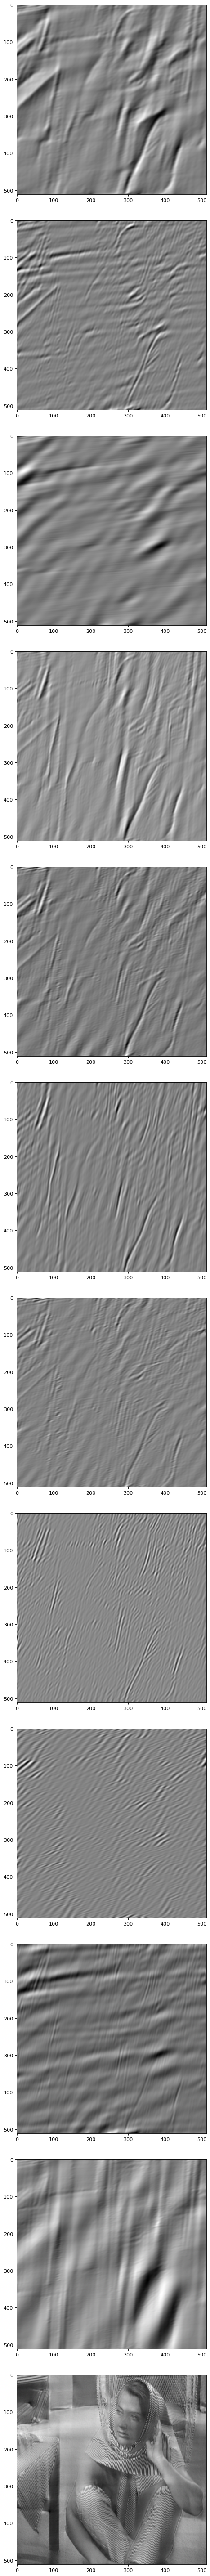

In [393]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
from matplotlib import pyplot as plt

fig, (ax) = plt.subplots(candidates.shape[0],figsize=(6,(candidates.shape[0] * 6)))
plt.tight_layout()
for i in range(candidates.shape[0]):
        ax[i].imshow(candidates[i],cmap="gray")


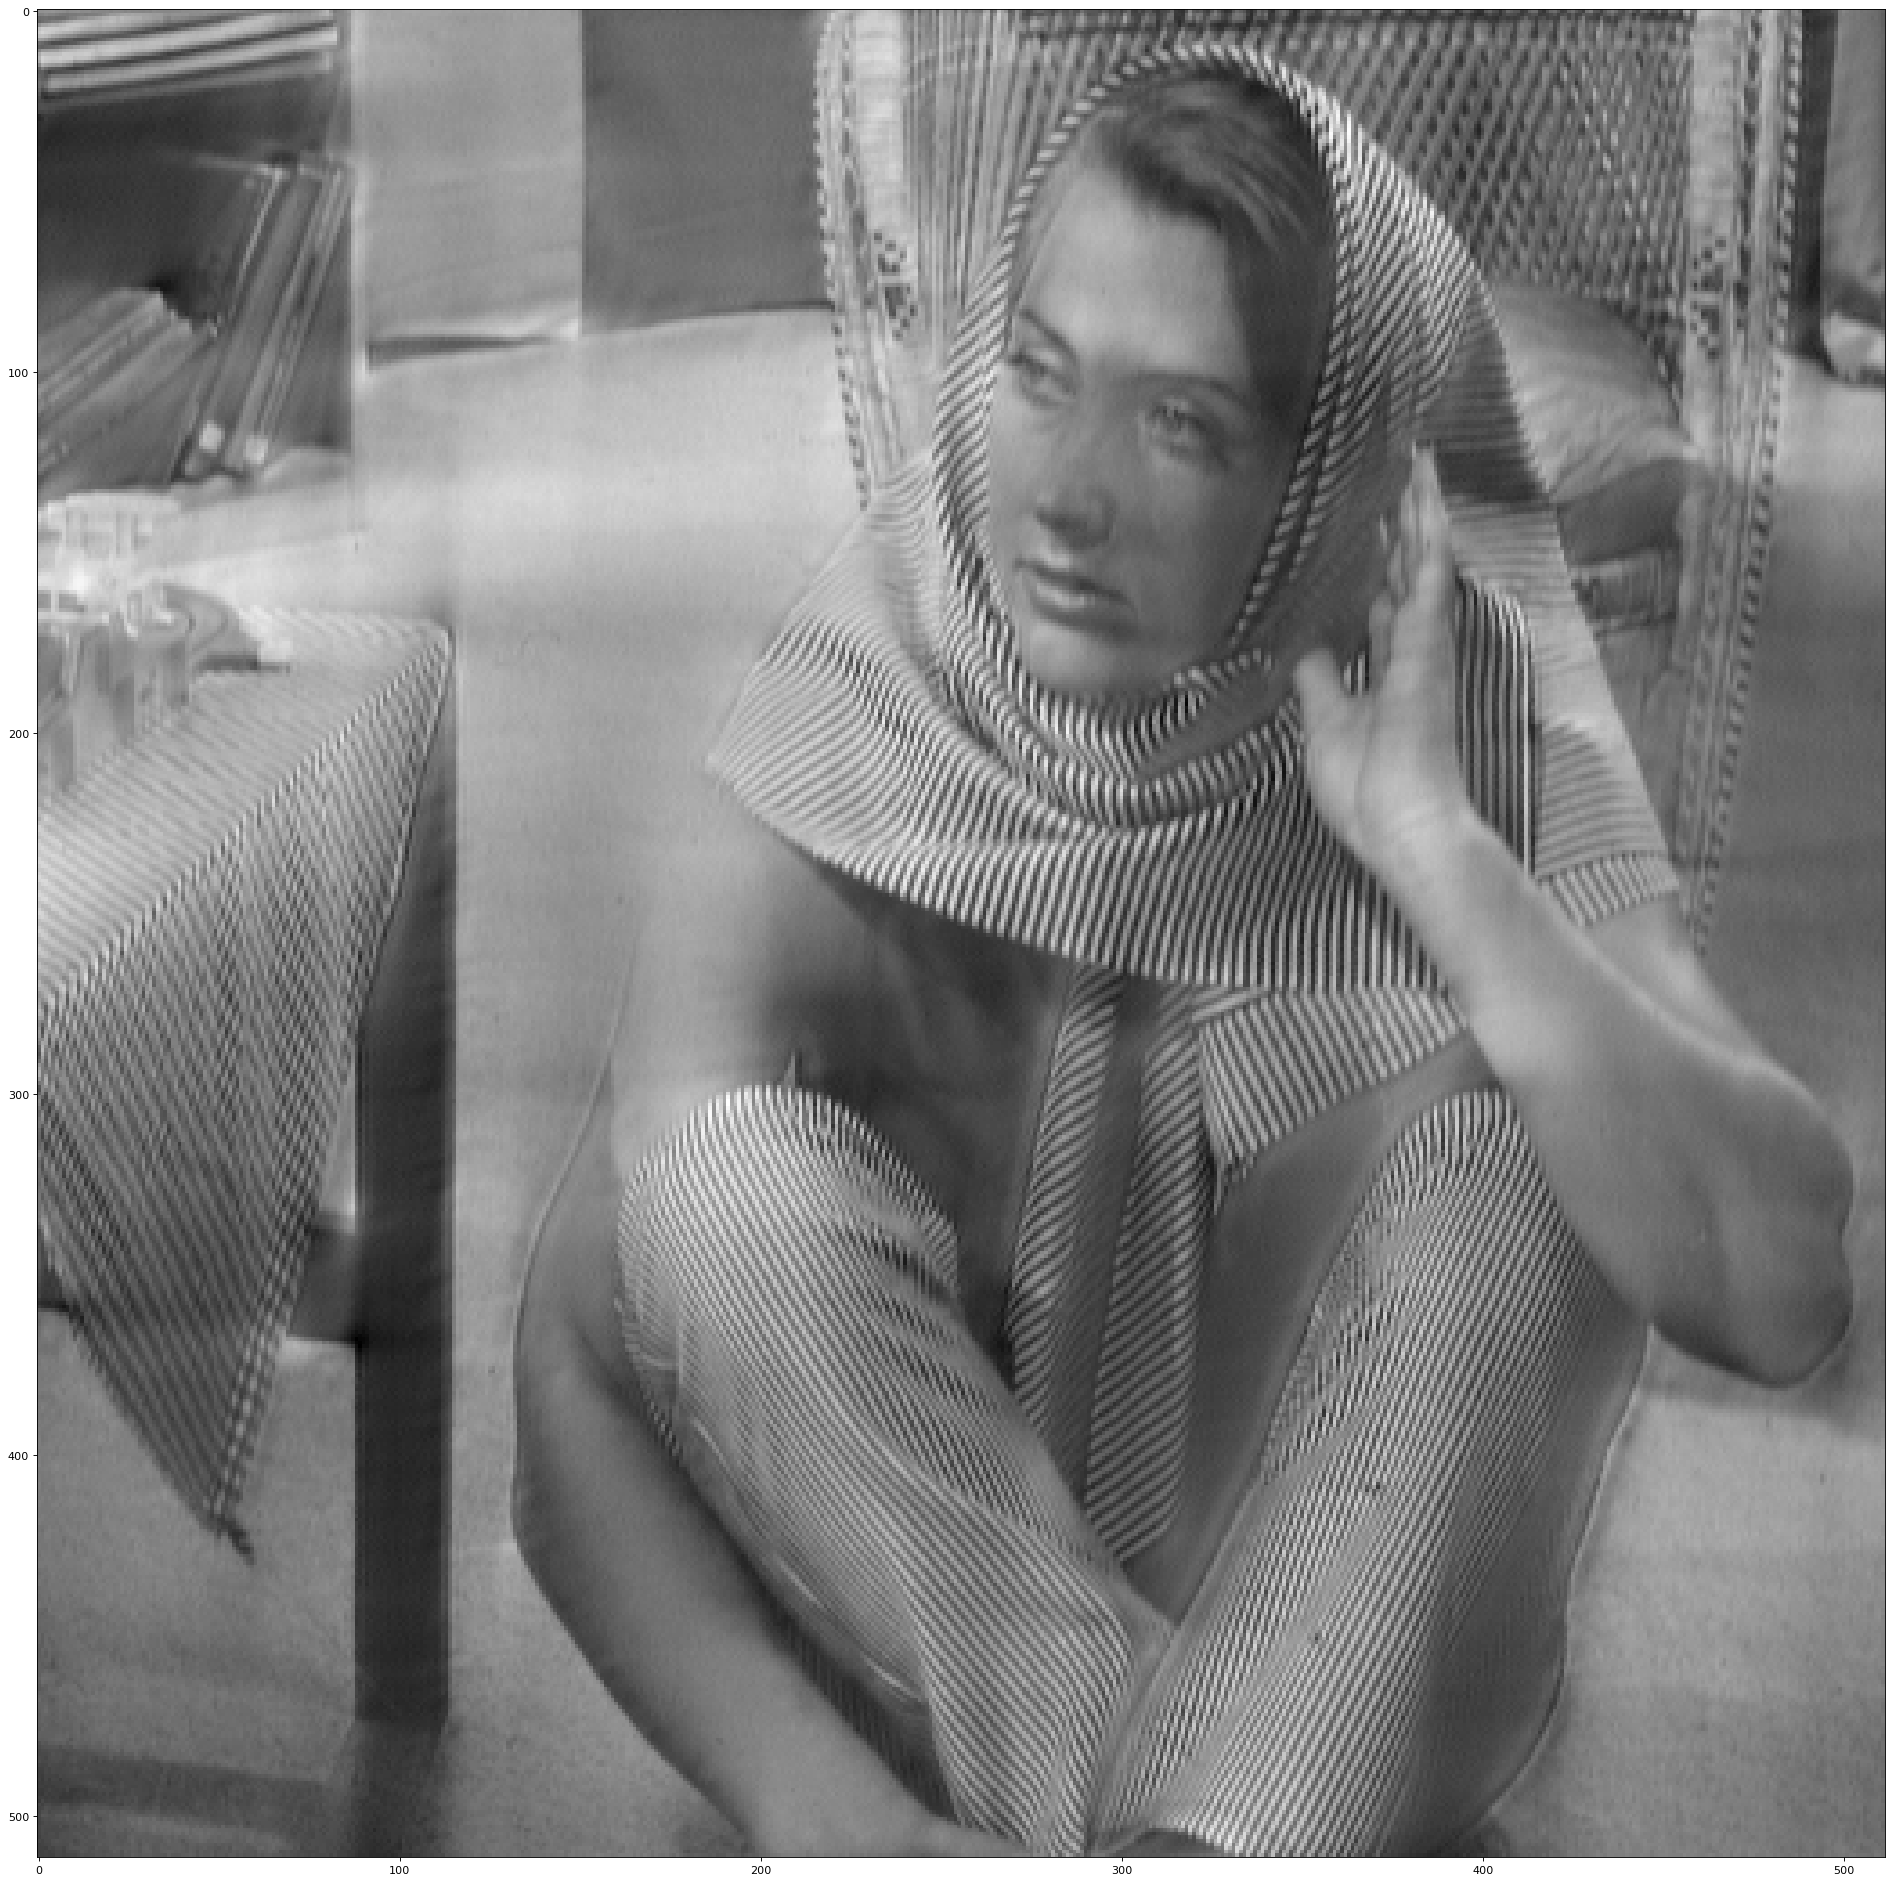

In [395]:
fig = plt.figure(figsize=(30, 30))

plt.imshow(candidates[-1],cmap="gray")